## 기본 베이지 DNN

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%matplotlib inline

In [3]:
df=pd.read_excel('./optimal_data3_1/'+'Continous_2weeks_2day_1term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (58825, 6) (58825,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (166896, 6) (166896,)
SMOTE 적용 전 레이블 값 분포: 
 0    55632
1     2010
2     1183
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    55632
1    55632
2    55632
Name: 8, dtype: int64


In [4]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

10

In [5]:
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [7]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [8]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [9]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [10]:
most_acc=[]

In [11]:
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    # print("TRAIN:", train_index, "TEST:", test_index)
    # print(len(train_index))
    # print(len(test_index))

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 1000
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, pred_list = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')
    most_acc.append(final_acc)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.01it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.10697. Saving Model!
epoch 01, loss: 1.31355, acc: 0.25720, val_loss: 1.10697, val_accuracy: 0.33337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.31it/s]


[INFO] val_acc has been improved from 1.10697 to 1.08829. Saving Model!
epoch 02, loss: 1.08043, acc: 0.33880, val_loss: 1.08829, val_accuracy: 0.41336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.27it/s]


[INFO] val_acc has been improved from 1.08829 to 1.08468. Saving Model!
epoch 03, loss: 1.09418, acc: 0.43786, val_loss: 1.08468, val_accuracy: 0.45992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


[INFO] val_acc has been improved from 1.08468 to 1.07820. Saving Model!
epoch 04, loss: 1.09453, acc: 0.40444, val_loss: 1.07820, val_accuracy: 0.44997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


[INFO] val_acc has been improved from 1.07820 to 1.06859. Saving Model!
epoch 05, loss: 1.09231, acc: 0.40156, val_loss: 1.06859, val_accuracy: 0.45321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


[INFO] val_acc has been improved from 1.06859 to 1.05749. Saving Model!
epoch 06, loss: 1.08858, acc: 0.40175, val_loss: 1.05749, val_accuracy: 0.44164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.07it/s]


[INFO] val_acc has been improved from 1.05749 to 1.04683. Saving Model!
epoch 07, loss: 1.08373, acc: 0.40264, val_loss: 1.04683, val_accuracy: 0.44398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


[INFO] val_acc has been improved from 1.04683 to 1.03874. Saving Model!
epoch 08, loss: 1.07780, acc: 0.40574, val_loss: 1.03874, val_accuracy: 0.44805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.34it/s]


[INFO] val_acc has been improved from 1.03874 to 1.03223. Saving Model!
epoch 09, loss: 1.07314, acc: 0.40914, val_loss: 1.03223, val_accuracy: 0.45009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


[INFO] val_acc has been improved from 1.03223 to 1.02709. Saving Model!
epoch 10, loss: 1.06904, acc: 0.41331, val_loss: 1.02709, val_accuracy: 0.45279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


[INFO] val_acc has been improved from 1.02709 to 1.02249. Saving Model!
epoch 11, loss: 1.06636, acc: 0.41385, val_loss: 1.02249, val_accuracy: 0.45404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.40it/s]


[INFO] val_acc has been improved from 1.02249 to 1.01826. Saving Model!
epoch 12, loss: 1.06430, acc: 0.41651, val_loss: 1.01826, val_accuracy: 0.45470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


[INFO] val_acc has been improved from 1.01826 to 1.01475. Saving Model!
epoch 13, loss: 1.06207, acc: 0.41845, val_loss: 1.01475, val_accuracy: 0.45392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.10it/s]


[INFO] val_acc has been improved from 1.01475 to 1.01165. Saving Model!
epoch 14, loss: 1.06040, acc: 0.41693, val_loss: 1.01165, val_accuracy: 0.45482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.59it/s]


[INFO] val_acc has been improved from 1.01165 to 1.00874. Saving Model!
epoch 15, loss: 1.05861, acc: 0.41816, val_loss: 1.00874, val_accuracy: 0.45848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


[INFO] val_acc has been improved from 1.00874 to 1.00626. Saving Model!
epoch 16, loss: 1.05713, acc: 0.42045, val_loss: 1.00626, val_accuracy: 0.46087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


[INFO] val_acc has been improved from 1.00626 to 1.00389. Saving Model!
epoch 17, loss: 1.05564, acc: 0.41998, val_loss: 1.00389, val_accuracy: 0.46195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.88it/s]


[INFO] val_acc has been improved from 1.00389 to 1.00172. Saving Model!
epoch 18, loss: 1.05393, acc: 0.42036, val_loss: 1.00172, val_accuracy: 0.46315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.81it/s]


[INFO] val_acc has been improved from 1.00172 to 0.99962. Saving Model!
epoch 19, loss: 1.05248, acc: 0.42052, val_loss: 0.99962, val_accuracy: 0.46447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.99962 to 0.99788. Saving Model!
epoch 20, loss: 1.05110, acc: 0.42033, val_loss: 0.99788, val_accuracy: 0.45554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.39it/s]


[INFO] val_acc has been improved from 0.99788 to 0.99640. Saving Model!
epoch 21, loss: 1.04977, acc: 0.41990, val_loss: 0.99640, val_accuracy: 0.45938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.99640 to 0.99491. Saving Model!
epoch 22, loss: 1.04801, acc: 0.42077, val_loss: 0.99491, val_accuracy: 0.45992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.99491 to 0.99363. Saving Model!
epoch 23, loss: 1.04677, acc: 0.42139, val_loss: 0.99363, val_accuracy: 0.46022


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.58it/s]


[INFO] val_acc has been improved from 0.99363 to 0.99212. Saving Model!
epoch 24, loss: 1.04543, acc: 0.42284, val_loss: 0.99212, val_accuracy: 0.46135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.99212 to 0.99116. Saving Model!
epoch 25, loss: 1.04390, acc: 0.42333, val_loss: 0.99116, val_accuracy: 0.45788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.99116 to 0.99064. Saving Model!
epoch 26, loss: 1.04218, acc: 0.42952, val_loss: 0.99064, val_accuracy: 0.45812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.99064 to 0.98790. Saving Model!
epoch 27, loss: 1.04450, acc: 0.42957, val_loss: 0.98790, val_accuracy: 0.45788


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.08it/s]


[INFO] val_acc has been improved from 0.98790 to 0.98765. Saving Model!
epoch 28, loss: 1.03895, acc: 0.43408, val_loss: 0.98765, val_accuracy: 0.45770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.98765 to 0.98738. Saving Model!
epoch 29, loss: 1.03785, acc: 0.43615, val_loss: 0.98738, val_accuracy: 0.45896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.98738 to 0.98632. Saving Model!
epoch 30, loss: 1.03667, acc: 0.43728, val_loss: 0.98632, val_accuracy: 0.45854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


[INFO] val_acc has been improved from 0.98632 to 0.98599. Saving Model!
epoch 31, loss: 1.03520, acc: 0.43772, val_loss: 0.98599, val_accuracy: 0.44721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.98599 to 0.98569. Saving Model!
epoch 32, loss: 1.03367, acc: 0.43940, val_loss: 0.98569, val_accuracy: 0.44643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 33, loss: 1.03174, acc: 0.44129, val_loss: 0.98623, val_accuracy: 0.44661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 34, loss: 1.03048, acc: 0.44177, val_loss: 0.98617, val_accuracy: 0.44590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.06it/s]


epoch 35, loss: 1.02848, acc: 0.44075, val_loss: 0.98812, val_accuracy: 0.44596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 36, loss: 1.02665, acc: 0.44075, val_loss: 0.98831, val_accuracy: 0.46447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 37, loss: 1.02484, acc: 0.44242, val_loss: 0.99013, val_accuracy: 0.45518


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 38, loss: 1.02323, acc: 0.44400, val_loss: 0.99202, val_accuracy: 0.45512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 39, loss: 1.02027, acc: 0.44603, val_loss: 0.99444, val_accuracy: 0.46741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 40, loss: 1.01958, acc: 0.44615, val_loss: 0.99808, val_accuracy: 0.45632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 41, loss: 1.01571, acc: 0.44926, val_loss: 0.99711, val_accuracy: 0.45752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 42, loss: 1.01651, acc: 0.44830, val_loss: 1.00807, val_accuracy: 0.45800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 43, loss: 1.01195, acc: 0.45052, val_loss: 1.00735, val_accuracy: 0.45806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 44, loss: 1.01096, acc: 0.45221, val_loss: 1.01711, val_accuracy: 0.45980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 45, loss: 1.00777, acc: 0.45350, val_loss: 1.01370, val_accuracy: 0.46087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 46, loss: 1.00738, acc: 0.45281, val_loss: 1.02109, val_accuracy: 0.46309


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 47, loss: 1.00269, acc: 0.45647, val_loss: 1.02279, val_accuracy: 0.46058


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 48, loss: 1.00282, acc: 0.45723, val_loss: 1.02335, val_accuracy: 0.46321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 49, loss: 0.99853, acc: 0.45752, val_loss: 1.02532, val_accuracy: 0.45482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 50, loss: 0.99862, acc: 0.46282, val_loss: 1.03069, val_accuracy: 0.46531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 51, loss: 0.99395, acc: 0.46196, val_loss: 1.03181, val_accuracy: 0.45410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 52, loss: 0.99399, acc: 0.46582, val_loss: 1.03355, val_accuracy: 0.45686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 53, loss: 0.98965, acc: 0.46501, val_loss: 1.04354, val_accuracy: 0.45716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 54, loss: 0.98822, acc: 0.46767, val_loss: 1.04037, val_accuracy: 0.45908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 55, loss: 0.98627, acc: 0.46587, val_loss: 1.04939, val_accuracy: 0.45992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 56, loss: 0.98275, acc: 0.46967, val_loss: 1.04059, val_accuracy: 0.46273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 57, loss: 0.98224, acc: 0.46795, val_loss: 1.05013, val_accuracy: 0.46381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 58, loss: 0.97835, acc: 0.47023, val_loss: 1.04700, val_accuracy: 0.46471


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 59, loss: 0.97741, acc: 0.47022, val_loss: 1.05768, val_accuracy: 0.46627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 60, loss: 0.97444, acc: 0.47266, val_loss: 1.05479, val_accuracy: 0.46842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 61, loss: 0.97276, acc: 0.47312, val_loss: 1.06169, val_accuracy: 0.47370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 62, loss: 0.97011, acc: 0.47770, val_loss: 1.05687, val_accuracy: 0.47478


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 63, loss: 0.96875, acc: 0.47807, val_loss: 1.06619, val_accuracy: 0.47693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 64, loss: 0.96629, acc: 0.48115, val_loss: 1.06228, val_accuracy: 0.47897


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 65, loss: 0.96470, acc: 0.48194, val_loss: 1.06938, val_accuracy: 0.48226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 66, loss: 0.96169, acc: 0.48350, val_loss: 1.06444, val_accuracy: 0.48155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 67, loss: 0.96071, acc: 0.48674, val_loss: 1.07243, val_accuracy: 0.48526


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 68, loss: 0.95785, acc: 0.48716, val_loss: 1.06265, val_accuracy: 0.48532


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 69, loss: 0.95602, acc: 0.49091, val_loss: 1.07405, val_accuracy: 0.48760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 70, loss: 0.95361, acc: 0.49145, val_loss: 1.06544, val_accuracy: 0.48904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 71, loss: 0.95263, acc: 0.49124, val_loss: 1.08052, val_accuracy: 0.49149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 72, loss: 0.94989, acc: 0.49535, val_loss: 1.06032, val_accuracy: 0.49221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 73, loss: 0.94782, acc: 0.49751, val_loss: 1.08320, val_accuracy: 0.49371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 74, loss: 0.94620, acc: 0.49976, val_loss: 1.06477, val_accuracy: 0.49491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 75, loss: 0.94356, acc: 0.50284, val_loss: 1.08076, val_accuracy: 0.49611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 76, loss: 0.94212, acc: 0.50336, val_loss: 1.06495, val_accuracy: 0.49712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 77, loss: 0.93988, acc: 0.50554, val_loss: 1.08495, val_accuracy: 0.49712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 78, loss: 0.93801, acc: 0.50593, val_loss: 1.06470, val_accuracy: 0.50006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 79, loss: 0.93614, acc: 0.50855, val_loss: 1.08396, val_accuracy: 0.49623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 80, loss: 0.93400, acc: 0.50759, val_loss: 1.06905, val_accuracy: 0.49641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 81, loss: 0.93189, acc: 0.51365, val_loss: 1.07993, val_accuracy: 0.49826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 82, loss: 0.93037, acc: 0.51357, val_loss: 1.07116, val_accuracy: 0.49934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 83, loss: 0.92734, acc: 0.51740, val_loss: 1.07955, val_accuracy: 0.49952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 84, loss: 0.92661, acc: 0.51743, val_loss: 1.07039, val_accuracy: 0.50413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 85, loss: 0.92393, acc: 0.51925, val_loss: 1.08142, val_accuracy: 0.49958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 86, loss: 0.92330, acc: 0.51870, val_loss: 1.07079, val_accuracy: 0.50431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 87, loss: 0.91978, acc: 0.52399, val_loss: 1.07538, val_accuracy: 0.50078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 88, loss: 0.91979, acc: 0.52196, val_loss: 1.07314, val_accuracy: 0.50449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 89, loss: 0.91622, acc: 0.52411, val_loss: 1.07374, val_accuracy: 0.50048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 90, loss: 0.91498, acc: 0.52634, val_loss: 1.08618, val_accuracy: 0.50300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 91, loss: 0.92026, acc: 0.52401, val_loss: 1.06307, val_accuracy: 0.50461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 92, loss: 0.91002, acc: 0.52849, val_loss: 1.07982, val_accuracy: 0.50419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 93, loss: 0.90837, acc: 0.52625, val_loss: 1.07195, val_accuracy: 0.50791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 94, loss: 0.90899, acc: 0.52902, val_loss: 1.07454, val_accuracy: 0.50521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 95, loss: 0.90431, acc: 0.52939, val_loss: 1.07868, val_accuracy: 0.50677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 96, loss: 0.90628, acc: 0.52833, val_loss: 1.07263, val_accuracy: 0.50953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 97, loss: 0.90071, acc: 0.53151, val_loss: 1.09074, val_accuracy: 0.50971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 98, loss: 0.90173, acc: 0.53007, val_loss: 1.06836, val_accuracy: 0.51264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 99, loss: 0.89846, acc: 0.53547, val_loss: 1.10743, val_accuracy: 0.51300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 100, loss: 0.89716, acc: 0.53226, val_loss: 1.07217, val_accuracy: 0.51300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 101, loss: 0.89637, acc: 0.53766, val_loss: 1.11266, val_accuracy: 0.51624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 102, loss: 0.89335, acc: 0.53561, val_loss: 1.08141, val_accuracy: 0.51558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 103, loss: 0.89189, acc: 0.54079, val_loss: 1.10688, val_accuracy: 0.51827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 104, loss: 0.88943, acc: 0.53997, val_loss: 1.09323, val_accuracy: 0.51809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 105, loss: 0.88775, acc: 0.54280, val_loss: 1.11047, val_accuracy: 0.51821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 106, loss: 0.88710, acc: 0.54035, val_loss: 1.10049, val_accuracy: 0.52133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.49it/s]


epoch 107, loss: 0.88457, acc: 0.54658, val_loss: 1.11781, val_accuracy: 0.52283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 108, loss: 0.88300, acc: 0.54638, val_loss: 1.09966, val_accuracy: 0.52259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 109, loss: 0.88023, acc: 0.54915, val_loss: 1.12432, val_accuracy: 0.52217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 110, loss: 0.87886, acc: 0.55120, val_loss: 1.10266, val_accuracy: 0.52762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 111, loss: 0.87655, acc: 0.55261, val_loss: 1.12730, val_accuracy: 0.52349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 112, loss: 0.87602, acc: 0.55150, val_loss: 1.10786, val_accuracy: 0.53038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 113, loss: 0.87270, acc: 0.55649, val_loss: 1.12988, val_accuracy: 0.52540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 114, loss: 0.87276, acc: 0.55593, val_loss: 1.11385, val_accuracy: 0.53223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 115, loss: 0.86899, acc: 0.55883, val_loss: 1.13590, val_accuracy: 0.52888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 116, loss: 0.87007, acc: 0.55650, val_loss: 1.10858, val_accuracy: 0.53014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 117, loss: 0.86745, acc: 0.56297, val_loss: 1.14783, val_accuracy: 0.53086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 118, loss: 0.86556, acc: 0.56126, val_loss: 1.11228, val_accuracy: 0.53170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 119, loss: 0.86526, acc: 0.56596, val_loss: 1.14606, val_accuracy: 0.53349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 120, loss: 0.86228, acc: 0.56335, val_loss: 1.11403, val_accuracy: 0.53487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 121, loss: 0.86134, acc: 0.56996, val_loss: 1.14663, val_accuracy: 0.53649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 122, loss: 0.85850, acc: 0.57063, val_loss: 1.12353, val_accuracy: 0.53667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 123, loss: 0.85866, acc: 0.56972, val_loss: 1.14314, val_accuracy: 0.53565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 124, loss: 0.85637, acc: 0.57030, val_loss: 1.12916, val_accuracy: 0.53373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 125, loss: 0.85519, acc: 0.57451, val_loss: 1.14217, val_accuracy: 0.54002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 126, loss: 0.85328, acc: 0.57482, val_loss: 1.12709, val_accuracy: 0.53823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 127, loss: 0.85270, acc: 0.57575, val_loss: 1.14692, val_accuracy: 0.54104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 128, loss: 0.85112, acc: 0.57522, val_loss: 1.13299, val_accuracy: 0.53847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 129, loss: 0.84847, acc: 0.58149, val_loss: 1.14721, val_accuracy: 0.54572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 130, loss: 0.84662, acc: 0.58199, val_loss: 1.13581, val_accuracy: 0.54254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 131, loss: 0.84546, acc: 0.58110, val_loss: 1.14553, val_accuracy: 0.54739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 132, loss: 0.84289, acc: 0.58473, val_loss: 1.14226, val_accuracy: 0.54584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 133, loss: 0.84254, acc: 0.58488, val_loss: 1.14591, val_accuracy: 0.55051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 134, loss: 0.84016, acc: 0.58712, val_loss: 1.14512, val_accuracy: 0.54925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 135, loss: 0.83958, acc: 0.58818, val_loss: 1.14589, val_accuracy: 0.55530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 136, loss: 0.83687, acc: 0.59034, val_loss: 1.14767, val_accuracy: 0.55297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 137, loss: 0.83722, acc: 0.59020, val_loss: 1.14660, val_accuracy: 0.55662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 138, loss: 0.83482, acc: 0.59191, val_loss: 1.15108, val_accuracy: 0.55596


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 139, loss: 0.83372, acc: 0.59436, val_loss: 1.14769, val_accuracy: 0.55746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 140, loss: 0.83202, acc: 0.59315, val_loss: 1.15193, val_accuracy: 0.55692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 141, loss: 0.83016, acc: 0.59642, val_loss: 1.14304, val_accuracy: 0.55884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 142, loss: 0.82984, acc: 0.59637, val_loss: 1.14864, val_accuracy: 0.55842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 143, loss: 0.82774, acc: 0.59866, val_loss: 1.14108, val_accuracy: 0.56075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 144, loss: 0.82740, acc: 0.59894, val_loss: 1.14767, val_accuracy: 0.55890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 145, loss: 0.82384, acc: 0.60301, val_loss: 1.13713, val_accuracy: 0.56261


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 146, loss: 0.82216, acc: 0.60023, val_loss: 1.15025, val_accuracy: 0.56081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 147, loss: 0.82179, acc: 0.60354, val_loss: 1.13107, val_accuracy: 0.56447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 148, loss: 0.81850, acc: 0.60256, val_loss: 1.15082, val_accuracy: 0.56399


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 149, loss: 0.81920, acc: 0.60459, val_loss: 1.12946, val_accuracy: 0.56561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 150, loss: 0.81571, acc: 0.60500, val_loss: 1.15494, val_accuracy: 0.56693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 151, loss: 0.81638, acc: 0.60605, val_loss: 1.13059, val_accuracy: 0.56711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 152, loss: 0.81340, acc: 0.60840, val_loss: 1.14997, val_accuracy: 0.56956


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 153, loss: 0.81353, acc: 0.61064, val_loss: 1.13008, val_accuracy: 0.56944


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 154, loss: 0.81054, acc: 0.61069, val_loss: 1.14622, val_accuracy: 0.57064


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 155, loss: 0.81079, acc: 0.61376, val_loss: 1.13199, val_accuracy: 0.57340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 156, loss: 0.80796, acc: 0.61315, val_loss: 1.13452, val_accuracy: 0.57190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 157, loss: 0.80774, acc: 0.61458, val_loss: 1.13403, val_accuracy: 0.57687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 158, loss: 0.80643, acc: 0.61597, val_loss: 1.13163, val_accuracy: 0.57316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 159, loss: 0.80513, acc: 0.61495, val_loss: 1.14357, val_accuracy: 0.57831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 160, loss: 0.80560, acc: 0.61840, val_loss: 1.12562, val_accuracy: 0.57430


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 161, loss: 0.80305, acc: 0.61655, val_loss: 1.13882, val_accuracy: 0.58059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 162, loss: 0.80272, acc: 0.61933, val_loss: 1.13511, val_accuracy: 0.57484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 163, loss: 0.80012, acc: 0.61984, val_loss: 1.13468, val_accuracy: 0.57046


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 164, loss: 0.80102, acc: 0.62239, val_loss: 1.14052, val_accuracy: 0.57639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 165, loss: 0.79814, acc: 0.62211, val_loss: 1.12528, val_accuracy: 0.57250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 166, loss: 0.79680, acc: 0.62359, val_loss: 1.13816, val_accuracy: 0.57915


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 167, loss: 0.79475, acc: 0.62683, val_loss: 1.12559, val_accuracy: 0.57513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 168, loss: 0.79342, acc: 0.62725, val_loss: 1.12844, val_accuracy: 0.58292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 169, loss: 0.79247, acc: 0.62860, val_loss: 1.12503, val_accuracy: 0.57681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 170, loss: 0.79083, acc: 0.62882, val_loss: 1.13416, val_accuracy: 0.58328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 171, loss: 0.78925, acc: 0.63069, val_loss: 1.12025, val_accuracy: 0.57723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 172, loss: 0.78780, acc: 0.63276, val_loss: 1.13503, val_accuracy: 0.57597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 173, loss: 0.78535, acc: 0.63681, val_loss: 1.11331, val_accuracy: 0.57759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 174, loss: 0.78416, acc: 0.63436, val_loss: 1.13200, val_accuracy: 0.57609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 175, loss: 0.78297, acc: 0.63697, val_loss: 1.11167, val_accuracy: 0.58029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.39it/s]


epoch 176, loss: 0.77988, acc: 0.63561, val_loss: 1.12842, val_accuracy: 0.57873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 177, loss: 0.77944, acc: 0.63963, val_loss: 1.11014, val_accuracy: 0.58143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 178, loss: 0.77660, acc: 0.63701, val_loss: 1.12950, val_accuracy: 0.58472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 179, loss: 0.77741, acc: 0.64386, val_loss: 1.10664, val_accuracy: 0.58250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 180, loss: 0.77320, acc: 0.63913, val_loss: 1.12861, val_accuracy: 0.58520


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 181, loss: 0.77316, acc: 0.64513, val_loss: 1.10477, val_accuracy: 0.58340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 182, loss: 0.76941, acc: 0.64153, val_loss: 1.12860, val_accuracy: 0.58676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 183, loss: 0.77108, acc: 0.64779, val_loss: 1.10842, val_accuracy: 0.58550


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 184, loss: 0.76692, acc: 0.64335, val_loss: 1.12782, val_accuracy: 0.58814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 185, loss: 0.76883, acc: 0.64742, val_loss: 1.10000, val_accuracy: 0.59035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 186, loss: 0.76544, acc: 0.64432, val_loss: 1.12893, val_accuracy: 0.58214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 187, loss: 0.76825, acc: 0.64669, val_loss: 1.11345, val_accuracy: 0.58850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 188, loss: 0.76050, acc: 0.64579, val_loss: 1.12636, val_accuracy: 0.59077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 189, loss: 0.76475, acc: 0.64957, val_loss: 1.10900, val_accuracy: 0.59377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 190, loss: 0.75939, acc: 0.64753, val_loss: 1.12594, val_accuracy: 0.58460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 191, loss: 0.76135, acc: 0.65109, val_loss: 1.10304, val_accuracy: 0.59473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 192, loss: 0.75612, acc: 0.64876, val_loss: 1.13819, val_accuracy: 0.58712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 193, loss: 0.75832, acc: 0.65093, val_loss: 1.09673, val_accuracy: 0.59551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 194, loss: 0.75323, acc: 0.64988, val_loss: 1.12390, val_accuracy: 0.59449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 195, loss: 0.75527, acc: 0.65382, val_loss: 1.10091, val_accuracy: 0.59605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 196, loss: 0.75113, acc: 0.65155, val_loss: 1.11304, val_accuracy: 0.59467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 197, loss: 0.75217, acc: 0.65497, val_loss: 1.09074, val_accuracy: 0.59820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 198, loss: 0.75001, acc: 0.65463, val_loss: 1.11534, val_accuracy: 0.59581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 199, loss: 0.74969, acc: 0.65608, val_loss: 1.07490, val_accuracy: 0.59700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 200, loss: 0.74800, acc: 0.65511, val_loss: 1.11269, val_accuracy: 0.59629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 201, loss: 0.74689, acc: 0.65833, val_loss: 1.06809, val_accuracy: 0.59868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 202, loss: 0.74683, acc: 0.65780, val_loss: 1.10666, val_accuracy: 0.59748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 203, loss: 0.74403, acc: 0.66083, val_loss: 1.07248, val_accuracy: 0.59251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 204, loss: 0.74788, acc: 0.65796, val_loss: 1.09766, val_accuracy: 0.59772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 205, loss: 0.74095, acc: 0.66193, val_loss: 1.05418, val_accuracy: 0.60228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 206, loss: 0.74278, acc: 0.66108, val_loss: 1.08895, val_accuracy: 0.60060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 207, loss: 0.73677, acc: 0.66506, val_loss: 1.06605, val_accuracy: 0.59533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 208, loss: 0.73977, acc: 0.66477, val_loss: 1.08721, val_accuracy: 0.60138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 209, loss: 0.73524, acc: 0.66836, val_loss: 1.04932, val_accuracy: 0.60779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 210, loss: 0.73549, acc: 0.66715, val_loss: 1.07577, val_accuracy: 0.60312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 211, loss: 0.73263, acc: 0.66869, val_loss: 1.03812, val_accuracy: 0.60959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 212, loss: 0.73260, acc: 0.66906, val_loss: 1.06868, val_accuracy: 0.60767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 213, loss: 0.72913, acc: 0.67001, val_loss: 1.05705, val_accuracy: 0.61019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 214, loss: 0.73066, acc: 0.66990, val_loss: 1.06762, val_accuracy: 0.60899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 215, loss: 0.72689, acc: 0.67010, val_loss: 1.03907, val_accuracy: 0.61174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 216, loss: 0.72658, acc: 0.67294, val_loss: 1.05947, val_accuracy: 0.60947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 217, loss: 0.72471, acc: 0.67180, val_loss: 1.02997, val_accuracy: 0.61234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 218, loss: 0.72547, acc: 0.67364, val_loss: 1.04964, val_accuracy: 0.61078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 219, loss: 0.72159, acc: 0.67557, val_loss: 1.03756, val_accuracy: 0.61252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 220, loss: 0.72255, acc: 0.67578, val_loss: 1.03958, val_accuracy: 0.61198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 221, loss: 0.72007, acc: 0.67622, val_loss: 1.02558, val_accuracy: 0.61282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 222, loss: 0.72187, acc: 0.67840, val_loss: 1.03186, val_accuracy: 0.61336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 223, loss: 0.71641, acc: 0.67869, val_loss: 1.03862, val_accuracy: 0.60288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 224, loss: 0.71925, acc: 0.67960, val_loss: 1.03472, val_accuracy: 0.61420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 225, loss: 0.71363, acc: 0.68062, val_loss: 1.03361, val_accuracy: 0.61084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 226, loss: 0.71742, acc: 0.67995, val_loss: 1.03345, val_accuracy: 0.61330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 227, loss: 0.71161, acc: 0.68027, val_loss: 1.03040, val_accuracy: 0.61288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 228, loss: 0.71301, acc: 0.68182, val_loss: 1.02990, val_accuracy: 0.61600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 229, loss: 0.70953, acc: 0.68461, val_loss: 1.01789, val_accuracy: 0.61756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 230, loss: 0.70746, acc: 0.68569, val_loss: 1.03067, val_accuracy: 0.61696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 231, loss: 0.70738, acc: 0.68645, val_loss: 1.01111, val_accuracy: 0.61234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 232, loss: 0.70473, acc: 0.68775, val_loss: 1.01866, val_accuracy: 0.61738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 233, loss: 0.70475, acc: 0.68806, val_loss: 1.00462, val_accuracy: 0.61923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 234, loss: 0.70208, acc: 0.69082, val_loss: 1.01023, val_accuracy: 0.61702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 235, loss: 0.70175, acc: 0.68905, val_loss: 1.00299, val_accuracy: 0.61438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 236, loss: 0.70020, acc: 0.69232, val_loss: 1.01320, val_accuracy: 0.61797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 237, loss: 0.69863, acc: 0.69226, val_loss: 1.00933, val_accuracy: 0.61971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 238, loss: 0.69613, acc: 0.69465, val_loss: 1.00425, val_accuracy: 0.61971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 239, loss: 0.69541, acc: 0.69226, val_loss: 0.99822, val_accuracy: 0.62049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 240, loss: 0.69523, acc: 0.69503, val_loss: 0.99501, val_accuracy: 0.61989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 241, loss: 0.69332, acc: 0.69459, val_loss: 1.00338, val_accuracy: 0.62145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 242, loss: 0.69309, acc: 0.69672, val_loss: 0.99271, val_accuracy: 0.62271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 243, loss: 0.69062, acc: 0.69595, val_loss: 1.01564, val_accuracy: 0.62163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 244, loss: 0.69084, acc: 0.69699, val_loss: 0.98895, val_accuracy: 0.62289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 245, loss: 0.68754, acc: 0.69748, val_loss: 1.01070, val_accuracy: 0.61851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.98569 to 0.97051. Saving Model!
epoch 246, loss: 0.68915, acc: 0.69926, val_loss: 0.97051, val_accuracy: 0.62522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 247, loss: 0.68390, acc: 0.69941, val_loss: 0.99666, val_accuracy: 0.62403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 248, loss: 0.68580, acc: 0.70171, val_loss: 0.97725, val_accuracy: 0.62582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 249, loss: 0.68248, acc: 0.70092, val_loss: 0.99113, val_accuracy: 0.62079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.97051 to 0.96885. Saving Model!
epoch 250, loss: 0.68233, acc: 0.70250, val_loss: 0.96885, val_accuracy: 0.62786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 251, loss: 0.67988, acc: 0.70293, val_loss: 0.99358, val_accuracy: 0.62361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


[INFO] val_acc has been improved from 0.96885 to 0.96388. Saving Model!
epoch 252, loss: 0.68121, acc: 0.70347, val_loss: 0.96388, val_accuracy: 0.63960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 253, loss: 0.67749, acc: 0.70356, val_loss: 0.98347, val_accuracy: 0.62415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.96388 to 0.96092. Saving Model!
epoch 254, loss: 0.67751, acc: 0.70518, val_loss: 0.96092, val_accuracy: 0.62966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 255, loss: 0.67583, acc: 0.70389, val_loss: 0.97738, val_accuracy: 0.62912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.96092 to 0.96074. Saving Model!
epoch 256, loss: 0.67563, acc: 0.70710, val_loss: 0.96074, val_accuracy: 0.63122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 257, loss: 0.67232, acc: 0.70702, val_loss: 0.97390, val_accuracy: 0.62552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.96074 to 0.95513. Saving Model!
epoch 258, loss: 0.67316, acc: 0.70755, val_loss: 0.95513, val_accuracy: 0.64260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 259, loss: 0.67131, acc: 0.70665, val_loss: 0.97340, val_accuracy: 0.62636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


[INFO] val_acc has been improved from 0.95513 to 0.94737. Saving Model!
epoch 260, loss: 0.67120, acc: 0.70963, val_loss: 0.94737, val_accuracy: 0.64236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 261, loss: 0.66850, acc: 0.70922, val_loss: 0.96689, val_accuracy: 0.62966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


[INFO] val_acc has been improved from 0.94737 to 0.94351. Saving Model!
epoch 262, loss: 0.66994, acc: 0.71061, val_loss: 0.94351, val_accuracy: 0.64350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 263, loss: 0.66775, acc: 0.70947, val_loss: 0.95655, val_accuracy: 0.63337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 264, loss: 0.66717, acc: 0.71250, val_loss: 0.95092, val_accuracy: 0.64080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 265, loss: 0.66618, acc: 0.70941, val_loss: 0.96902, val_accuracy: 0.63439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.94351 to 0.93839. Saving Model!
epoch 266, loss: 0.66589, acc: 0.71282, val_loss: 0.93839, val_accuracy: 0.64548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 267, loss: 0.66307, acc: 0.71343, val_loss: 0.94478, val_accuracy: 0.63098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.93839 to 0.92307. Saving Model!
epoch 268, loss: 0.66193, acc: 0.71513, val_loss: 0.92307, val_accuracy: 0.64614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 269, loss: 0.66004, acc: 0.71431, val_loss: 0.92787, val_accuracy: 0.63068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 270, loss: 0.65972, acc: 0.71640, val_loss: 0.93587, val_accuracy: 0.63553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.92307 to 0.92047. Saving Model!
epoch 271, loss: 0.65709, acc: 0.71801, val_loss: 0.92047, val_accuracy: 0.63265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 272, loss: 0.65589, acc: 0.71783, val_loss: 0.92872, val_accuracy: 0.64338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 273, loss: 0.65515, acc: 0.71803, val_loss: 0.92648, val_accuracy: 0.63769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 274, loss: 0.65391, acc: 0.71917, val_loss: 0.92418, val_accuracy: 0.64440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 275, loss: 0.65374, acc: 0.71767, val_loss: 0.92445, val_accuracy: 0.63829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.92047 to 0.91631. Saving Model!
epoch 276, loss: 0.65362, acc: 0.72026, val_loss: 0.91631, val_accuracy: 0.64506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 277, loss: 0.65186, acc: 0.72015, val_loss: 0.91642, val_accuracy: 0.63907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


[INFO] val_acc has been improved from 0.91631 to 0.91599. Saving Model!
epoch 278, loss: 0.65012, acc: 0.72132, val_loss: 0.91599, val_accuracy: 0.64572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.91599 to 0.90524. Saving Model!
epoch 279, loss: 0.65094, acc: 0.72205, val_loss: 0.90524, val_accuracy: 0.64092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 280, loss: 0.64716, acc: 0.72217, val_loss: 0.90937, val_accuracy: 0.65740


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 281, loss: 0.64910, acc: 0.72375, val_loss: 0.90631, val_accuracy: 0.64122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 282, loss: 0.64511, acc: 0.72353, val_loss: 0.92554, val_accuracy: 0.64002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 283, loss: 0.65015, acc: 0.72557, val_loss: 0.91101, val_accuracy: 0.64236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 284, loss: 0.64303, acc: 0.72634, val_loss: 0.91773, val_accuracy: 0.64194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 285, loss: 0.64536, acc: 0.72787, val_loss: 0.91355, val_accuracy: 0.64242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


[INFO] val_acc has been improved from 0.90524 to 0.89877. Saving Model!
epoch 286, loss: 0.64174, acc: 0.72616, val_loss: 0.89877, val_accuracy: 0.65021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 287, loss: 0.64116, acc: 0.72745, val_loss: 0.90208, val_accuracy: 0.63625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.89877 to 0.88830. Saving Model!
epoch 288, loss: 0.64022, acc: 0.72964, val_loss: 0.88830, val_accuracy: 0.66255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 289, loss: 0.63663, acc: 0.72975, val_loss: 0.89446, val_accuracy: 0.65554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 290, loss: 0.63678, acc: 0.73165, val_loss: 0.89551, val_accuracy: 0.66159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


[INFO] val_acc has been improved from 0.88830 to 0.88693. Saving Model!
epoch 291, loss: 0.63580, acc: 0.73279, val_loss: 0.88693, val_accuracy: 0.65087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 292, loss: 0.63583, acc: 0.72907, val_loss: 0.89802, val_accuracy: 0.65476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 293, loss: 0.63892, acc: 0.73029, val_loss: 0.89715, val_accuracy: 0.65686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.46it/s]


epoch 294, loss: 0.63504, acc: 0.73083, val_loss: 0.89174, val_accuracy: 0.65632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 295, loss: 0.63957, acc: 0.73144, val_loss: 0.89106, val_accuracy: 0.66848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 296, loss: 0.63103, acc: 0.73180, val_loss: 0.90165, val_accuracy: 0.65662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.88693 to 0.88032. Saving Model!
epoch 297, loss: 0.63698, acc: 0.73494, val_loss: 0.88032, val_accuracy: 0.65818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 298, loss: 0.62942, acc: 0.73225, val_loss: 0.89651, val_accuracy: 0.65578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 299, loss: 0.63377, acc: 0.73444, val_loss: 0.89801, val_accuracy: 0.66908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 300, loss: 0.63079, acc: 0.73224, val_loss: 0.88735, val_accuracy: 0.65686


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 301, loss: 0.62717, acc: 0.73819, val_loss: 0.88773, val_accuracy: 0.67082


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 302, loss: 0.62592, acc: 0.73765, val_loss: 0.88774, val_accuracy: 0.65872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 303, loss: 0.62361, acc: 0.74047, val_loss: 0.88749, val_accuracy: 0.66255


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 304, loss: 0.62352, acc: 0.73879, val_loss: 0.88818, val_accuracy: 0.65884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 305, loss: 0.62399, acc: 0.74021, val_loss: 0.88545, val_accuracy: 0.65267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 306, loss: 0.61992, acc: 0.73932, val_loss: 0.89374, val_accuracy: 0.65992


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 307, loss: 0.62599, acc: 0.74060, val_loss: 0.88132, val_accuracy: 0.68406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 308, loss: 0.62032, acc: 0.73707, val_loss: 0.89208, val_accuracy: 0.65902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 309, loss: 0.62434, acc: 0.73958, val_loss: 0.88450, val_accuracy: 0.66531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 310, loss: 0.61649, acc: 0.74012, val_loss: 0.88706, val_accuracy: 0.66040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 311, loss: 0.61731, acc: 0.74300, val_loss: 0.88600, val_accuracy: 0.66669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 312, loss: 0.61428, acc: 0.74381, val_loss: 0.88717, val_accuracy: 0.66183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 313, loss: 0.61249, acc: 0.74546, val_loss: 0.88493, val_accuracy: 0.66741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 314, loss: 0.61235, acc: 0.74481, val_loss: 0.88240, val_accuracy: 0.66219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 315, loss: 0.61104, acc: 0.74610, val_loss: 0.88347, val_accuracy: 0.66747


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 316, loss: 0.60997, acc: 0.74512, val_loss: 0.88715, val_accuracy: 0.66243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 317, loss: 0.61139, acc: 0.74612, val_loss: 0.88090, val_accuracy: 0.66459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 318, loss: 0.60767, acc: 0.74557, val_loss: 0.88405, val_accuracy: 0.66249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


[INFO] val_acc has been improved from 0.88032 to 0.87984. Saving Model!
epoch 319, loss: 0.60932, acc: 0.74737, val_loss: 0.87984, val_accuracy: 0.68023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 320, loss: 0.60502, acc: 0.74669, val_loss: 0.88649, val_accuracy: 0.66393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 321, loss: 0.60789, acc: 0.74793, val_loss: 0.88109, val_accuracy: 0.66561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 322, loss: 0.60338, acc: 0.74767, val_loss: 0.88611, val_accuracy: 0.66513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.87984 to 0.87812. Saving Model!
epoch 323, loss: 0.60557, acc: 0.74936, val_loss: 0.87812, val_accuracy: 0.67819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 324, loss: 0.60220, acc: 0.74839, val_loss: 0.88425, val_accuracy: 0.66663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 325, loss: 0.60340, acc: 0.75018, val_loss: 0.88186, val_accuracy: 0.66741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 326, loss: 0.60078, acc: 0.74907, val_loss: 0.87867, val_accuracy: 0.66627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 327, loss: 0.60029, acc: 0.75141, val_loss: 0.88252, val_accuracy: 0.67232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


[INFO] val_acc has been improved from 0.87812 to 0.87637. Saving Model!
epoch 328, loss: 0.59853, acc: 0.75092, val_loss: 0.87637, val_accuracy: 0.66765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 329, loss: 0.59813, acc: 0.75172, val_loss: 0.88526, val_accuracy: 0.66926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.87637 to 0.87282. Saving Model!
epoch 330, loss: 0.59631, acc: 0.75241, val_loss: 0.87282, val_accuracy: 0.66854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 331, loss: 0.59723, acc: 0.75251, val_loss: 0.88223, val_accuracy: 0.66896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 332, loss: 0.59515, acc: 0.75247, val_loss: 0.87487, val_accuracy: 0.66908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 333, loss: 0.59445, acc: 0.75440, val_loss: 0.88012, val_accuracy: 0.68101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


[INFO] val_acc has been improved from 0.87282 to 0.87222. Saving Model!
epoch 334, loss: 0.59362, acc: 0.75343, val_loss: 0.87222, val_accuracy: 0.67424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 335, loss: 0.59194, acc: 0.75506, val_loss: 0.88247, val_accuracy: 0.67166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 336, loss: 0.59152, acc: 0.75454, val_loss: 0.87262, val_accuracy: 0.67765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 337, loss: 0.58975, acc: 0.75594, val_loss: 0.88516, val_accuracy: 0.67298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.87222 to 0.87057. Saving Model!
epoch 338, loss: 0.59023, acc: 0.75424, val_loss: 0.87057, val_accuracy: 0.67340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 339, loss: 0.58835, acc: 0.75619, val_loss: 0.88117, val_accuracy: 0.67328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 340, loss: 0.58800, acc: 0.75635, val_loss: 0.87190, val_accuracy: 0.67316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 341, loss: 0.58918, acc: 0.75609, val_loss: 0.87432, val_accuracy: 0.68532


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 342, loss: 0.58591, acc: 0.75621, val_loss: 0.87382, val_accuracy: 0.67585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 343, loss: 0.58685, acc: 0.75654, val_loss: 0.87669, val_accuracy: 0.67639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.87057 to 0.87005. Saving Model!
epoch 344, loss: 0.58672, acc: 0.75618, val_loss: 0.87005, val_accuracy: 0.68694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 345, loss: 0.58388, acc: 0.75683, val_loss: 0.87817, val_accuracy: 0.67687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 346, loss: 0.58441, acc: 0.75821, val_loss: 0.87662, val_accuracy: 0.67537


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 347, loss: 0.58388, acc: 0.75774, val_loss: 0.87324, val_accuracy: 0.68652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 348, loss: 0.58292, acc: 0.75719, val_loss: 0.87623, val_accuracy: 0.67627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 349, loss: 0.58181, acc: 0.76049, val_loss: 0.87280, val_accuracy: 0.67651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 350, loss: 0.58139, acc: 0.75598, val_loss: 0.87020, val_accuracy: 0.67735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 351, loss: 0.57955, acc: 0.76028, val_loss: 0.87543, val_accuracy: 0.67771


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.87005 to 0.86785. Saving Model!
epoch 352, loss: 0.58100, acc: 0.75835, val_loss: 0.86785, val_accuracy: 0.67693


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 353, loss: 0.57799, acc: 0.75920, val_loss: 0.87259, val_accuracy: 0.68754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 354, loss: 0.57820, acc: 0.76089, val_loss: 0.87270, val_accuracy: 0.68916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 355, loss: 0.57813, acc: 0.75753, val_loss: 0.87601, val_accuracy: 0.66741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 356, loss: 0.57685, acc: 0.76062, val_loss: 0.87484, val_accuracy: 0.67885


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 357, loss: 0.57623, acc: 0.75853, val_loss: 0.86842, val_accuracy: 0.68904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 358, loss: 0.57635, acc: 0.76131, val_loss: 0.87319, val_accuracy: 0.66872


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 359, loss: 0.57077, acc: 0.76275, val_loss: 0.87541, val_accuracy: 0.67867


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 360, loss: 0.57444, acc: 0.76037, val_loss: 0.86994, val_accuracy: 0.68035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 361, loss: 0.57020, acc: 0.76350, val_loss: 0.87795, val_accuracy: 0.67831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 362, loss: 0.57232, acc: 0.76264, val_loss: 0.87074, val_accuracy: 0.68029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.86785 to 0.86678. Saving Model!
epoch 363, loss: 0.57509, acc: 0.75950, val_loss: 0.86678, val_accuracy: 0.67969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 364, loss: 0.57011, acc: 0.76243, val_loss: 0.88054, val_accuracy: 0.67939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.86678 to 0.86537. Saving Model!
epoch 365, loss: 0.57155, acc: 0.76325, val_loss: 0.86537, val_accuracy: 0.68017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


[INFO] val_acc has been improved from 0.86537 to 0.86141. Saving Model!
epoch 366, loss: 0.57065, acc: 0.76259, val_loss: 0.86141, val_accuracy: 0.68047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 367, loss: 0.56805, acc: 0.76398, val_loss: 0.87711, val_accuracy: 0.68029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


[INFO] val_acc has been improved from 0.86141 to 0.85346. Saving Model!
epoch 368, loss: 0.57172, acc: 0.76261, val_loss: 0.85346, val_accuracy: 0.68334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.04it/s]


epoch 369, loss: 0.56450, acc: 0.76478, val_loss: 0.88274, val_accuracy: 0.67969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 370, loss: 0.57007, acc: 0.76472, val_loss: 0.86254, val_accuracy: 0.68250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 371, loss: 0.56842, acc: 0.76246, val_loss: 0.87631, val_accuracy: 0.66980


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 372, loss: 0.56576, acc: 0.76539, val_loss: 0.86869, val_accuracy: 0.67238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 373, loss: 0.56679, acc: 0.76525, val_loss: 0.85918, val_accuracy: 0.68316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 374, loss: 0.56219, acc: 0.76658, val_loss: 0.87545, val_accuracy: 0.67244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 375, loss: 0.56203, acc: 0.76720, val_loss: 0.86430, val_accuracy: 0.68179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 376, loss: 0.55952, acc: 0.76704, val_loss: 0.87291, val_accuracy: 0.67352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 377, loss: 0.55895, acc: 0.76881, val_loss: 0.86482, val_accuracy: 0.67142


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 378, loss: 0.55846, acc: 0.76848, val_loss: 0.86921, val_accuracy: 0.67376


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 379, loss: 0.55721, acc: 0.76946, val_loss: 0.87104, val_accuracy: 0.67256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 380, loss: 0.55833, acc: 0.76965, val_loss: 0.86367, val_accuracy: 0.68550


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 381, loss: 0.55445, acc: 0.76878, val_loss: 0.86788, val_accuracy: 0.68448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 382, loss: 0.55825, acc: 0.76963, val_loss: 0.86576, val_accuracy: 0.67370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 383, loss: 0.55348, acc: 0.76844, val_loss: 0.86737, val_accuracy: 0.67364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 384, loss: 0.55803, acc: 0.76840, val_loss: 0.86800, val_accuracy: 0.68646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 385, loss: 0.55582, acc: 0.76795, val_loss: 0.86678, val_accuracy: 0.68418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 386, loss: 0.55486, acc: 0.76886, val_loss: 0.85914, val_accuracy: 0.68670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 387, loss: 0.55289, acc: 0.77171, val_loss: 0.86531, val_accuracy: 0.68490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 388, loss: 0.55147, acc: 0.77193, val_loss: 0.86633, val_accuracy: 0.67573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 389, loss: 0.55140, acc: 0.77139, val_loss: 0.86437, val_accuracy: 0.67663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 390, loss: 0.55021, acc: 0.77205, val_loss: 0.86477, val_accuracy: 0.68670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 391, loss: 0.54959, acc: 0.77127, val_loss: 0.86381, val_accuracy: 0.67627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 392, loss: 0.54995, acc: 0.77264, val_loss: 0.86337, val_accuracy: 0.68760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 393, loss: 0.54768, acc: 0.76995, val_loss: 0.87327, val_accuracy: 0.67645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 394, loss: 0.55118, acc: 0.77229, val_loss: 0.86285, val_accuracy: 0.67735


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 395, loss: 0.55035, acc: 0.76905, val_loss: 0.86674, val_accuracy: 0.68694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 396, loss: 0.54721, acc: 0.77348, val_loss: 0.86243, val_accuracy: 0.67711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 397, loss: 0.54655, acc: 0.77237, val_loss: 0.87144, val_accuracy: 0.68862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 398, loss: 0.54683, acc: 0.77517, val_loss: 0.85750, val_accuracy: 0.68886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 399, loss: 0.54513, acc: 0.77229, val_loss: 0.86837, val_accuracy: 0.68077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 400, loss: 0.54638, acc: 0.77516, val_loss: 0.85642, val_accuracy: 0.68874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 401, loss: 0.54231, acc: 0.77406, val_loss: 0.86992, val_accuracy: 0.67975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 402, loss: 0.54510, acc: 0.77567, val_loss: 0.85844, val_accuracy: 0.67849


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 403, loss: 0.54140, acc: 0.77460, val_loss: 0.86819, val_accuracy: 0.67957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 404, loss: 0.54327, acc: 0.77552, val_loss: 0.85873, val_accuracy: 0.67987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 405, loss: 0.53926, acc: 0.77514, val_loss: 0.86664, val_accuracy: 0.69071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 406, loss: 0.54157, acc: 0.77654, val_loss: 0.86270, val_accuracy: 0.68011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 407, loss: 0.53834, acc: 0.77579, val_loss: 0.87047, val_accuracy: 0.68101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 408, loss: 0.54089, acc: 0.77655, val_loss: 0.85995, val_accuracy: 0.69095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 409, loss: 0.53931, acc: 0.77420, val_loss: 0.86674, val_accuracy: 0.68101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 410, loss: 0.54083, acc: 0.77745, val_loss: 0.86691, val_accuracy: 0.69185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 411, loss: 0.53792, acc: 0.77623, val_loss: 0.85950, val_accuracy: 0.67993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 412, loss: 0.53930, acc: 0.77746, val_loss: 0.86706, val_accuracy: 0.69269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 413, loss: 0.53508, acc: 0.77847, val_loss: 0.86551, val_accuracy: 0.68053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 414, loss: 0.53805, acc: 0.77910, val_loss: 0.86412, val_accuracy: 0.68244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 415, loss: 0.53357, acc: 0.77978, val_loss: 0.86365, val_accuracy: 0.69245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 416, loss: 0.53377, acc: 0.77914, val_loss: 0.86570, val_accuracy: 0.69503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 417, loss: 0.53375, acc: 0.78060, val_loss: 0.86091, val_accuracy: 0.68214


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 418, loss: 0.53444, acc: 0.77903, val_loss: 0.86523, val_accuracy: 0.69377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 419, loss: 0.53281, acc: 0.78065, val_loss: 0.87232, val_accuracy: 0.68250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 420, loss: 0.53432, acc: 0.77906, val_loss: 0.85533, val_accuracy: 0.69263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 421, loss: 0.53100, acc: 0.77950, val_loss: 0.86378, val_accuracy: 0.68424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 422, loss: 0.53201, acc: 0.78121, val_loss: 0.86228, val_accuracy: 0.69365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 423, loss: 0.52936, acc: 0.78045, val_loss: 0.86762, val_accuracy: 0.69437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 424, loss: 0.53101, acc: 0.78168, val_loss: 0.85927, val_accuracy: 0.68634


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 425, loss: 0.52857, acc: 0.78156, val_loss: 0.86159, val_accuracy: 0.68388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 426, loss: 0.52731, acc: 0.78316, val_loss: 0.86209, val_accuracy: 0.69712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 427, loss: 0.52733, acc: 0.78137, val_loss: 0.87067, val_accuracy: 0.69491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 428, loss: 0.52660, acc: 0.78290, val_loss: 0.86448, val_accuracy: 0.69623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 429, loss: 0.52620, acc: 0.78298, val_loss: 0.86439, val_accuracy: 0.68556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 430, loss: 0.52991, acc: 0.77986, val_loss: 0.86251, val_accuracy: 0.69557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 431, loss: 0.52503, acc: 0.78241, val_loss: 0.87335, val_accuracy: 0.68646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.85346 to 0.85073. Saving Model!
epoch 432, loss: 0.53240, acc: 0.78201, val_loss: 0.85073, val_accuracy: 0.69599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 433, loss: 0.52427, acc: 0.78273, val_loss: 0.87025, val_accuracy: 0.68556


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 434, loss: 0.52759, acc: 0.78442, val_loss: 0.85854, val_accuracy: 0.69646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 435, loss: 0.52352, acc: 0.78217, val_loss: 0.87454, val_accuracy: 0.68652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 436, loss: 0.52630, acc: 0.78430, val_loss: 0.85858, val_accuracy: 0.68916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 437, loss: 0.52457, acc: 0.78321, val_loss: 0.86404, val_accuracy: 0.69646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 438, loss: 0.52083, acc: 0.78619, val_loss: 0.86403, val_accuracy: 0.69838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 439, loss: 0.52401, acc: 0.78538, val_loss: 0.86744, val_accuracy: 0.69892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 440, loss: 0.51966, acc: 0.78643, val_loss: 0.87079, val_accuracy: 0.69814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 441, loss: 0.52104, acc: 0.78491, val_loss: 0.86746, val_accuracy: 0.68868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 442, loss: 0.52351, acc: 0.78360, val_loss: 0.86506, val_accuracy: 0.69754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 443, loss: 0.51870, acc: 0.78395, val_loss: 0.86727, val_accuracy: 0.69874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 444, loss: 0.52302, acc: 0.78486, val_loss: 0.87160, val_accuracy: 0.68880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 445, loss: 0.51983, acc: 0.78529, val_loss: 0.87468, val_accuracy: 0.69934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 446, loss: 0.52189, acc: 0.78488, val_loss: 0.86349, val_accuracy: 0.69065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 447, loss: 0.51602, acc: 0.78827, val_loss: 0.86545, val_accuracy: 0.69760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.08it/s]


epoch 448, loss: 0.52007, acc: 0.78488, val_loss: 0.86130, val_accuracy: 0.70210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 449, loss: 0.51731, acc: 0.78790, val_loss: 0.87050, val_accuracy: 0.69976


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 450, loss: 0.51707, acc: 0.78434, val_loss: 0.86657, val_accuracy: 0.69029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.47it/s]


epoch 451, loss: 0.51507, acc: 0.78794, val_loss: 0.86771, val_accuracy: 0.69227


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 452, loss: 0.51634, acc: 0.78658, val_loss: 0.86314, val_accuracy: 0.69970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 453, loss: 0.51256, acc: 0.78821, val_loss: 0.87904, val_accuracy: 0.69029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 454, loss: 0.51655, acc: 0.78884, val_loss: 0.85846, val_accuracy: 0.70066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 455, loss: 0.51348, acc: 0.78967, val_loss: 0.87992, val_accuracy: 0.70132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 456, loss: 0.51463, acc: 0.78932, val_loss: 0.86830, val_accuracy: 0.69017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 457, loss: 0.51437, acc: 0.78752, val_loss: 0.86794, val_accuracy: 0.70821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 458, loss: 0.51177, acc: 0.78900, val_loss: 0.86974, val_accuracy: 0.69101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 459, loss: 0.51044, acc: 0.79055, val_loss: 0.87619, val_accuracy: 0.70042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 460, loss: 0.51226, acc: 0.78869, val_loss: 0.87021, val_accuracy: 0.69089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 461, loss: 0.50906, acc: 0.79101, val_loss: 0.87419, val_accuracy: 0.69964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 462, loss: 0.51203, acc: 0.78786, val_loss: 0.86454, val_accuracy: 0.68999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 463, loss: 0.50906, acc: 0.79076, val_loss: 0.88001, val_accuracy: 0.69275


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 464, loss: 0.51631, acc: 0.79008, val_loss: 0.85667, val_accuracy: 0.70252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 465, loss: 0.50891, acc: 0.78980, val_loss: 0.88802, val_accuracy: 0.69155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 466, loss: 0.51252, acc: 0.79027, val_loss: 0.86483, val_accuracy: 0.69143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 467, loss: 0.50927, acc: 0.78978, val_loss: 0.88499, val_accuracy: 0.70485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 468, loss: 0.51059, acc: 0.79210, val_loss: 0.86910, val_accuracy: 0.69299


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 469, loss: 0.51050, acc: 0.78890, val_loss: 0.87715, val_accuracy: 0.70300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 470, loss: 0.50806, acc: 0.79069, val_loss: 0.87158, val_accuracy: 0.70300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 471, loss: 0.50663, acc: 0.79187, val_loss: 0.88279, val_accuracy: 0.70324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 472, loss: 0.50657, acc: 0.79227, val_loss: 0.87501, val_accuracy: 0.69215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 473, loss: 0.50392, acc: 0.79248, val_loss: 0.87848, val_accuracy: 0.69401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 474, loss: 0.50399, acc: 0.79510, val_loss: 0.86818, val_accuracy: 0.70413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 475, loss: 0.50083, acc: 0.79418, val_loss: 0.88481, val_accuracy: 0.69401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 476, loss: 0.50752, acc: 0.79214, val_loss: 0.86898, val_accuracy: 0.69185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 477, loss: 0.50324, acc: 0.79302, val_loss: 0.88433, val_accuracy: 0.70599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 478, loss: 0.50813, acc: 0.79410, val_loss: 0.88251, val_accuracy: 0.69383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 479, loss: 0.50828, acc: 0.78800, val_loss: 0.87690, val_accuracy: 0.71252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 480, loss: 0.50381, acc: 0.79462, val_loss: 0.87340, val_accuracy: 0.69395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 481, loss: 0.50505, acc: 0.79379, val_loss: 0.88525, val_accuracy: 0.70611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 482, loss: 0.50050, acc: 0.79454, val_loss: 0.88084, val_accuracy: 0.69317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 483, loss: 0.49951, acc: 0.79502, val_loss: 0.88190, val_accuracy: 0.69664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 484, loss: 0.49825, acc: 0.79742, val_loss: 0.87253, val_accuracy: 0.70533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 485, loss: 0.49503, acc: 0.79782, val_loss: 0.88721, val_accuracy: 0.69485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 486, loss: 0.49888, acc: 0.79791, val_loss: 0.86891, val_accuracy: 0.69473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 487, loss: 0.49574, acc: 0.79473, val_loss: 0.88915, val_accuracy: 0.70629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 488, loss: 0.49866, acc: 0.79778, val_loss: 0.88133, val_accuracy: 0.69629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 489, loss: 0.49870, acc: 0.79443, val_loss: 0.88099, val_accuracy: 0.70617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 490, loss: 0.49509, acc: 0.79693, val_loss: 0.88223, val_accuracy: 0.69491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 491, loss: 0.49526, acc: 0.79727, val_loss: 0.88914, val_accuracy: 0.69635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 492, loss: 0.49536, acc: 0.79760, val_loss: 0.87902, val_accuracy: 0.69395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 493, loss: 0.49496, acc: 0.79649, val_loss: 0.88279, val_accuracy: 0.69850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 494, loss: 0.50071, acc: 0.79613, val_loss: 0.86564, val_accuracy: 0.70617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 495, loss: 0.49092, acc: 0.79797, val_loss: 0.89556, val_accuracy: 0.69641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 496, loss: 0.49826, acc: 0.79905, val_loss: 0.87338, val_accuracy: 0.69557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 497, loss: 0.49292, acc: 0.79770, val_loss: 0.90299, val_accuracy: 0.69652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 498, loss: 0.49477, acc: 0.80067, val_loss: 0.88422, val_accuracy: 0.69778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 499, loss: 0.49343, acc: 0.79631, val_loss: 0.89096, val_accuracy: 0.70683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 500, loss: 0.49119, acc: 0.80139, val_loss: 0.88098, val_accuracy: 0.69605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 501, loss: 0.49105, acc: 0.79855, val_loss: 0.89564, val_accuracy: 0.70773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 502, loss: 0.48830, acc: 0.80066, val_loss: 0.87862, val_accuracy: 0.69658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 503, loss: 0.48695, acc: 0.80061, val_loss: 0.88778, val_accuracy: 0.69940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 504, loss: 0.48888, acc: 0.80053, val_loss: 0.87929, val_accuracy: 0.70737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 505, loss: 0.48532, acc: 0.80213, val_loss: 0.89748, val_accuracy: 0.69934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 506, loss: 0.49282, acc: 0.80121, val_loss: 0.87641, val_accuracy: 0.70677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 507, loss: 0.48564, acc: 0.80075, val_loss: 0.90296, val_accuracy: 0.69718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 508, loss: 0.49121, acc: 0.80264, val_loss: 0.87917, val_accuracy: 0.69664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 509, loss: 0.48646, acc: 0.79962, val_loss: 0.90237, val_accuracy: 0.70899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 510, loss: 0.48531, acc: 0.80282, val_loss: 0.88392, val_accuracy: 0.69736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 511, loss: 0.48728, acc: 0.80113, val_loss: 0.89189, val_accuracy: 0.71150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 512, loss: 0.48309, acc: 0.80321, val_loss: 0.89102, val_accuracy: 0.69742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 513, loss: 0.48536, acc: 0.80058, val_loss: 0.89153, val_accuracy: 0.69898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 514, loss: 0.48292, acc: 0.80374, val_loss: 0.88449, val_accuracy: 0.69754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 515, loss: 0.48026, acc: 0.80374, val_loss: 0.89795, val_accuracy: 0.69976


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 516, loss: 0.48209, acc: 0.80549, val_loss: 0.88519, val_accuracy: 0.69820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 517, loss: 0.48060, acc: 0.80094, val_loss: 0.89045, val_accuracy: 0.71067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 518, loss: 0.48043, acc: 0.80444, val_loss: 0.89454, val_accuracy: 0.69964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 519, loss: 0.48417, acc: 0.80140, val_loss: 0.89210, val_accuracy: 0.71102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 520, loss: 0.48014, acc: 0.80351, val_loss: 0.88916, val_accuracy: 0.69868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 521, loss: 0.48263, acc: 0.80328, val_loss: 0.90013, val_accuracy: 0.71150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 522, loss: 0.47987, acc: 0.80236, val_loss: 0.88675, val_accuracy: 0.69772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 523, loss: 0.48079, acc: 0.80403, val_loss: 0.89549, val_accuracy: 0.70228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 524, loss: 0.48046, acc: 0.80382, val_loss: 0.88455, val_accuracy: 0.70989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 525, loss: 0.47816, acc: 0.80538, val_loss: 0.90849, val_accuracy: 0.70108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 526, loss: 0.47880, acc: 0.80691, val_loss: 0.88531, val_accuracy: 0.69946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 527, loss: 0.47739, acc: 0.80539, val_loss: 0.90064, val_accuracy: 0.71234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 528, loss: 0.47624, acc: 0.80643, val_loss: 0.89190, val_accuracy: 0.70090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 529, loss: 0.47807, acc: 0.80505, val_loss: 0.90016, val_accuracy: 0.71246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 530, loss: 0.47449, acc: 0.80717, val_loss: 0.89839, val_accuracy: 0.70006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 531, loss: 0.47870, acc: 0.80475, val_loss: 0.89358, val_accuracy: 0.70324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 532, loss: 0.47525, acc: 0.80590, val_loss: 0.89318, val_accuracy: 0.71198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 533, loss: 0.47651, acc: 0.80565, val_loss: 0.90526, val_accuracy: 0.70210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 534, loss: 0.47759, acc: 0.80604, val_loss: 0.88129, val_accuracy: 0.70078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 535, loss: 0.47411, acc: 0.80584, val_loss: 0.90568, val_accuracy: 0.70258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 536, loss: 0.47473, acc: 0.80862, val_loss: 0.88741, val_accuracy: 0.71162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 537, loss: 0.47221, acc: 0.80712, val_loss: 0.91476, val_accuracy: 0.70264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 538, loss: 0.47449, acc: 0.80779, val_loss: 0.89175, val_accuracy: 0.70246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 539, loss: 0.47415, acc: 0.80529, val_loss: 0.90568, val_accuracy: 0.71402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 540, loss: 0.47138, acc: 0.80792, val_loss: 0.89973, val_accuracy: 0.70359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 541, loss: 0.47208, acc: 0.80697, val_loss: 0.90138, val_accuracy: 0.71498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.46it/s]


epoch 542, loss: 0.47006, acc: 0.80906, val_loss: 0.89937, val_accuracy: 0.70318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 543, loss: 0.46986, acc: 0.80892, val_loss: 0.90839, val_accuracy: 0.70665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 544, loss: 0.47095, acc: 0.80929, val_loss: 0.90030, val_accuracy: 0.70497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 545, loss: 0.46966, acc: 0.80815, val_loss: 0.90810, val_accuracy: 0.70461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 546, loss: 0.46989, acc: 0.81119, val_loss: 0.89629, val_accuracy: 0.70503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 547, loss: 0.46871, acc: 0.80794, val_loss: 0.91673, val_accuracy: 0.70587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 548, loss: 0.46973, acc: 0.80975, val_loss: 0.90665, val_accuracy: 0.70371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 549, loss: 0.47532, acc: 0.80667, val_loss: 0.90091, val_accuracy: 0.71875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 550, loss: 0.46641, acc: 0.81075, val_loss: 0.90990, val_accuracy: 0.70389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 551, loss: 0.47741, acc: 0.80748, val_loss: 0.90223, val_accuracy: 0.71636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 552, loss: 0.47136, acc: 0.80754, val_loss: 0.90912, val_accuracy: 0.71588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 553, loss: 0.46913, acc: 0.80997, val_loss: 0.91204, val_accuracy: 0.70737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 554, loss: 0.46960, acc: 0.80983, val_loss: 0.89576, val_accuracy: 0.71624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 555, loss: 0.46514, acc: 0.81135, val_loss: 0.92082, val_accuracy: 0.70719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 556, loss: 0.46575, acc: 0.81384, val_loss: 0.90052, val_accuracy: 0.70629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 557, loss: 0.46668, acc: 0.80996, val_loss: 0.92617, val_accuracy: 0.71911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 558, loss: 0.46249, acc: 0.81490, val_loss: 0.90282, val_accuracy: 0.70713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 559, loss: 0.46564, acc: 0.81137, val_loss: 0.92108, val_accuracy: 0.70809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 560, loss: 0.46345, acc: 0.81465, val_loss: 0.90043, val_accuracy: 0.70755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 561, loss: 0.46627, acc: 0.81167, val_loss: 0.91666, val_accuracy: 0.70821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 562, loss: 0.46240, acc: 0.81400, val_loss: 0.90494, val_accuracy: 0.70791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 563, loss: 0.46338, acc: 0.81256, val_loss: 0.92532, val_accuracy: 0.70875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 564, loss: 0.46214, acc: 0.81465, val_loss: 0.90526, val_accuracy: 0.70659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 565, loss: 0.46064, acc: 0.81426, val_loss: 0.92310, val_accuracy: 0.70989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 566, loss: 0.45948, acc: 0.81597, val_loss: 0.90856, val_accuracy: 0.70833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 567, loss: 0.46144, acc: 0.81441, val_loss: 0.91612, val_accuracy: 0.71983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 568, loss: 0.45778, acc: 0.81539, val_loss: 0.91826, val_accuracy: 0.70935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 569, loss: 0.46395, acc: 0.81448, val_loss: 0.92051, val_accuracy: 0.71061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 570, loss: 0.45843, acc: 0.81653, val_loss: 0.90999, val_accuracy: 0.71947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 571, loss: 0.45934, acc: 0.81493, val_loss: 0.91382, val_accuracy: 0.71072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 572, loss: 0.45738, acc: 0.81673, val_loss: 0.91059, val_accuracy: 0.70923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 573, loss: 0.45548, acc: 0.81720, val_loss: 0.92937, val_accuracy: 0.71078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 574, loss: 0.45738, acc: 0.81794, val_loss: 0.91007, val_accuracy: 0.70905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 575, loss: 0.45804, acc: 0.81411, val_loss: 0.93020, val_accuracy: 0.71001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 576, loss: 0.45563, acc: 0.81782, val_loss: 0.91483, val_accuracy: 0.70875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 577, loss: 0.46115, acc: 0.81376, val_loss: 0.92194, val_accuracy: 0.72163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 578, loss: 0.45423, acc: 0.81911, val_loss: 0.92710, val_accuracy: 0.70923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 579, loss: 0.46034, acc: 0.81560, val_loss: 0.91456, val_accuracy: 0.72127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 580, loss: 0.45318, acc: 0.81882, val_loss: 0.92759, val_accuracy: 0.71019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 581, loss: 0.45551, acc: 0.81781, val_loss: 0.92283, val_accuracy: 0.71168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 582, loss: 0.45237, acc: 0.81865, val_loss: 0.91160, val_accuracy: 0.72199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 583, loss: 0.45392, acc: 0.81842, val_loss: 0.93160, val_accuracy: 0.71132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 584, loss: 0.45359, acc: 0.81955, val_loss: 0.91267, val_accuracy: 0.72223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 585, loss: 0.45272, acc: 0.81836, val_loss: 0.93684, val_accuracy: 0.71222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 586, loss: 0.45138, acc: 0.82048, val_loss: 0.91264, val_accuracy: 0.71126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 587, loss: 0.45414, acc: 0.81726, val_loss: 0.92826, val_accuracy: 0.72277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 588, loss: 0.44992, acc: 0.82164, val_loss: 0.92119, val_accuracy: 0.71102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 589, loss: 0.45539, acc: 0.81821, val_loss: 0.93038, val_accuracy: 0.72445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 590, loss: 0.44895, acc: 0.82045, val_loss: 0.92301, val_accuracy: 0.71222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.37it/s]


epoch 591, loss: 0.44945, acc: 0.82021, val_loss: 0.93532, val_accuracy: 0.71234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.49it/s]


epoch 592, loss: 0.44962, acc: 0.82092, val_loss: 0.92451, val_accuracy: 0.71204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 593, loss: 0.45147, acc: 0.81848, val_loss: 0.93650, val_accuracy: 0.71246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 594, loss: 0.44991, acc: 0.82108, val_loss: 0.91548, val_accuracy: 0.72265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 595, loss: 0.45722, acc: 0.81760, val_loss: 0.94849, val_accuracy: 0.71168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 596, loss: 0.46243, acc: 0.81822, val_loss: 0.92937, val_accuracy: 0.70857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 597, loss: 0.46892, acc: 0.81113, val_loss: 0.92825, val_accuracy: 0.71306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 598, loss: 0.45791, acc: 0.81724, val_loss: 0.93410, val_accuracy: 0.71090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 599, loss: 0.46306, acc: 0.81346, val_loss: 0.92989, val_accuracy: 0.71246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 600, loss: 0.45339, acc: 0.81917, val_loss: 0.93132, val_accuracy: 0.71270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 601, loss: 0.45187, acc: 0.82066, val_loss: 0.92892, val_accuracy: 0.71240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 602, loss: 0.45011, acc: 0.82259, val_loss: 0.93323, val_accuracy: 0.72487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 603, loss: 0.44842, acc: 0.82208, val_loss: 0.94183, val_accuracy: 0.71342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 604, loss: 0.44817, acc: 0.82263, val_loss: 0.93056, val_accuracy: 0.72451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 605, loss: 0.44635, acc: 0.82289, val_loss: 0.94511, val_accuracy: 0.71252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 606, loss: 0.44786, acc: 0.82287, val_loss: 0.93372, val_accuracy: 0.71390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 607, loss: 0.44911, acc: 0.82006, val_loss: 0.93955, val_accuracy: 0.71168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 608, loss: 0.44810, acc: 0.82246, val_loss: 0.92175, val_accuracy: 0.72385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 609, loss: 0.44860, acc: 0.82060, val_loss: 0.94958, val_accuracy: 0.71180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 610, loss: 0.44932, acc: 0.82270, val_loss: 0.92307, val_accuracy: 0.71420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 611, loss: 0.44796, acc: 0.81952, val_loss: 0.94728, val_accuracy: 0.71144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 612, loss: 0.44630, acc: 0.82403, val_loss: 0.92579, val_accuracy: 0.71414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 613, loss: 0.44646, acc: 0.82178, val_loss: 0.94540, val_accuracy: 0.72355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 614, loss: 0.44808, acc: 0.82130, val_loss: 0.93050, val_accuracy: 0.71498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 615, loss: 0.44572, acc: 0.82445, val_loss: 0.94977, val_accuracy: 0.71300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 616, loss: 0.44710, acc: 0.82266, val_loss: 0.92757, val_accuracy: 0.71450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 617, loss: 0.44450, acc: 0.82234, val_loss: 0.95083, val_accuracy: 0.71294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 618, loss: 0.44555, acc: 0.82379, val_loss: 0.93106, val_accuracy: 0.72582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 619, loss: 0.44241, acc: 0.82327, val_loss: 0.94747, val_accuracy: 0.71354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 620, loss: 0.44586, acc: 0.82538, val_loss: 0.93333, val_accuracy: 0.71522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 621, loss: 0.44512, acc: 0.82079, val_loss: 0.95014, val_accuracy: 0.70941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 622, loss: 0.45504, acc: 0.82039, val_loss: 0.94622, val_accuracy: 0.71270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 623, loss: 0.45556, acc: 0.81673, val_loss: 0.92984, val_accuracy: 0.72259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 624, loss: 0.44388, acc: 0.82519, val_loss: 0.94526, val_accuracy: 0.71546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 625, loss: 0.44930, acc: 0.82135, val_loss: 0.93288, val_accuracy: 0.72379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 626, loss: 0.44316, acc: 0.82276, val_loss: 0.93904, val_accuracy: 0.71540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 627, loss: 0.44199, acc: 0.82204, val_loss: 0.95532, val_accuracy: 0.71390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 628, loss: 0.44517, acc: 0.82487, val_loss: 0.92845, val_accuracy: 0.72762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 629, loss: 0.43869, acc: 0.82579, val_loss: 0.97074, val_accuracy: 0.71354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 630, loss: 0.44517, acc: 0.82377, val_loss: 0.92833, val_accuracy: 0.71678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 631, loss: 0.43988, acc: 0.82495, val_loss: 0.97038, val_accuracy: 0.71396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 632, loss: 0.44393, acc: 0.82462, val_loss: 0.92779, val_accuracy: 0.71630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 633, loss: 0.44056, acc: 0.82384, val_loss: 0.95187, val_accuracy: 0.72493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 634, loss: 0.43757, acc: 0.82690, val_loss: 0.94647, val_accuracy: 0.71750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 635, loss: 0.43605, acc: 0.82533, val_loss: 0.94565, val_accuracy: 0.72654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 636, loss: 0.43569, acc: 0.82882, val_loss: 0.94106, val_accuracy: 0.71720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 637, loss: 0.43634, acc: 0.82602, val_loss: 0.94532, val_accuracy: 0.72594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 638, loss: 0.43562, acc: 0.82798, val_loss: 0.93441, val_accuracy: 0.71827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 639, loss: 0.43576, acc: 0.82544, val_loss: 0.95126, val_accuracy: 0.71540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 640, loss: 0.43485, acc: 0.82832, val_loss: 0.93308, val_accuracy: 0.72876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 641, loss: 0.43309, acc: 0.82674, val_loss: 0.95142, val_accuracy: 0.71438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 642, loss: 0.43668, acc: 0.82704, val_loss: 0.93535, val_accuracy: 0.71768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 643, loss: 0.43499, acc: 0.82682, val_loss: 0.95638, val_accuracy: 0.72750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 644, loss: 0.43431, acc: 0.82836, val_loss: 0.93186, val_accuracy: 0.72013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 645, loss: 0.43205, acc: 0.82698, val_loss: 0.95112, val_accuracy: 0.71618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 646, loss: 0.43474, acc: 0.82836, val_loss: 0.94363, val_accuracy: 0.72960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 647, loss: 0.43177, acc: 0.82692, val_loss: 0.95214, val_accuracy: 0.71642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 648, loss: 0.43337, acc: 0.82874, val_loss: 0.94308, val_accuracy: 0.71917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 649, loss: 0.42849, acc: 0.82895, val_loss: 0.95917, val_accuracy: 0.71684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 650, loss: 0.43145, acc: 0.83103, val_loss: 0.93643, val_accuracy: 0.71875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 651, loss: 0.43008, acc: 0.82720, val_loss: 0.95893, val_accuracy: 0.72816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 652, loss: 0.43101, acc: 0.83079, val_loss: 0.95062, val_accuracy: 0.71977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 653, loss: 0.43198, acc: 0.82712, val_loss: 0.94965, val_accuracy: 0.72924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 654, loss: 0.42996, acc: 0.83025, val_loss: 0.94229, val_accuracy: 0.71941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 655, loss: 0.42796, acc: 0.82999, val_loss: 0.96520, val_accuracy: 0.71863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 656, loss: 0.42971, acc: 0.83130, val_loss: 0.93983, val_accuracy: 0.72013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 657, loss: 0.42640, acc: 0.82964, val_loss: 0.96216, val_accuracy: 0.71893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 658, loss: 0.42879, acc: 0.83096, val_loss: 0.93926, val_accuracy: 0.72043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 659, loss: 0.42571, acc: 0.83123, val_loss: 0.96680, val_accuracy: 0.71750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 660, loss: 0.42710, acc: 0.83209, val_loss: 0.94582, val_accuracy: 0.72043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 661, loss: 0.42650, acc: 0.82832, val_loss: 0.95718, val_accuracy: 0.71857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 662, loss: 0.42596, acc: 0.83342, val_loss: 0.95680, val_accuracy: 0.71941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 663, loss: 0.42850, acc: 0.82949, val_loss: 0.95720, val_accuracy: 0.72912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 664, loss: 0.42600, acc: 0.83138, val_loss: 0.95606, val_accuracy: 0.71965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 665, loss: 0.42648, acc: 0.83017, val_loss: 0.96699, val_accuracy: 0.71983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 666, loss: 0.42840, acc: 0.83184, val_loss: 0.96010, val_accuracy: 0.71911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 667, loss: 0.42317, acc: 0.83208, val_loss: 0.96420, val_accuracy: 0.71989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 668, loss: 0.42719, acc: 0.83198, val_loss: 0.95793, val_accuracy: 0.72169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 669, loss: 0.42462, acc: 0.82893, val_loss: 0.95402, val_accuracy: 0.72888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 670, loss: 0.42723, acc: 0.83308, val_loss: 0.96520, val_accuracy: 0.72097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 671, loss: 0.42867, acc: 0.82877, val_loss: 0.95647, val_accuracy: 0.73002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 672, loss: 0.42425, acc: 0.83364, val_loss: 0.96666, val_accuracy: 0.72055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 673, loss: 0.42355, acc: 0.83052, val_loss: 0.96168, val_accuracy: 0.73098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 674, loss: 0.42505, acc: 0.83353, val_loss: 0.95639, val_accuracy: 0.72103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 675, loss: 0.42146, acc: 0.83222, val_loss: 0.96464, val_accuracy: 0.72079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 676, loss: 0.42374, acc: 0.83422, val_loss: 0.94906, val_accuracy: 0.73241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 677, loss: 0.42049, acc: 0.83260, val_loss: 0.98062, val_accuracy: 0.72025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 678, loss: 0.42307, acc: 0.83309, val_loss: 0.95625, val_accuracy: 0.72187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 679, loss: 0.42135, acc: 0.83080, val_loss: 0.97240, val_accuracy: 0.71953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 680, loss: 0.42300, acc: 0.83358, val_loss: 0.95980, val_accuracy: 0.72181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 681, loss: 0.42244, acc: 0.83266, val_loss: 0.96185, val_accuracy: 0.73188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 682, loss: 0.42286, acc: 0.83202, val_loss: 0.96577, val_accuracy: 0.72217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 683, loss: 0.42260, acc: 0.83083, val_loss: 0.97155, val_accuracy: 0.71953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 684, loss: 0.42191, acc: 0.83568, val_loss: 0.96312, val_accuracy: 0.72157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 685, loss: 0.42206, acc: 0.83260, val_loss: 0.97720, val_accuracy: 0.72067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 686, loss: 0.42471, acc: 0.83148, val_loss: 0.95603, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 687, loss: 0.41883, acc: 0.83272, val_loss: 0.99274, val_accuracy: 0.72193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 688, loss: 0.42491, acc: 0.83525, val_loss: 0.96134, val_accuracy: 0.72097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 689, loss: 0.42025, acc: 0.83226, val_loss: 0.98250, val_accuracy: 0.71827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 690, loss: 0.42191, acc: 0.83435, val_loss: 0.95728, val_accuracy: 0.72385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 691, loss: 0.42341, acc: 0.83125, val_loss: 0.97049, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 692, loss: 0.42086, acc: 0.83601, val_loss: 0.96956, val_accuracy: 0.72313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 693, loss: 0.41837, acc: 0.83386, val_loss: 0.97838, val_accuracy: 0.72145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 694, loss: 0.41869, acc: 0.83594, val_loss: 0.96482, val_accuracy: 0.72367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 695, loss: 0.41550, acc: 0.83329, val_loss: 0.97238, val_accuracy: 0.72259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 696, loss: 0.41776, acc: 0.83767, val_loss: 0.96551, val_accuracy: 0.72361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 697, loss: 0.41352, acc: 0.83581, val_loss: 0.97226, val_accuracy: 0.72253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 698, loss: 0.41540, acc: 0.83710, val_loss: 0.97093, val_accuracy: 0.72385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 699, loss: 0.41440, acc: 0.83523, val_loss: 0.97558, val_accuracy: 0.72331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 700, loss: 0.41380, acc: 0.83963, val_loss: 0.97266, val_accuracy: 0.72367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 701, loss: 0.41228, acc: 0.83521, val_loss: 0.97955, val_accuracy: 0.72139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 702, loss: 0.41543, acc: 0.83635, val_loss: 0.97754, val_accuracy: 0.72409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 703, loss: 0.41585, acc: 0.83499, val_loss: 0.97275, val_accuracy: 0.72355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 704, loss: 0.41391, acc: 0.83748, val_loss: 0.97570, val_accuracy: 0.72445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 705, loss: 0.41156, acc: 0.83730, val_loss: 0.98010, val_accuracy: 0.72397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 706, loss: 0.41147, acc: 0.84023, val_loss: 0.98350, val_accuracy: 0.72475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 707, loss: 0.40935, acc: 0.83750, val_loss: 0.97978, val_accuracy: 0.72409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 708, loss: 0.41125, acc: 0.83799, val_loss: 0.96240, val_accuracy: 0.72481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 709, loss: 0.40798, acc: 0.83870, val_loss: 0.98523, val_accuracy: 0.72409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 710, loss: 0.41249, acc: 0.83883, val_loss: 0.96245, val_accuracy: 0.72475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 711, loss: 0.40858, acc: 0.83849, val_loss: 0.98733, val_accuracy: 0.72463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 712, loss: 0.41148, acc: 0.83822, val_loss: 0.96752, val_accuracy: 0.72552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 713, loss: 0.40820, acc: 0.83648, val_loss: 0.98758, val_accuracy: 0.72439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 714, loss: 0.41313, acc: 0.83779, val_loss: 0.96742, val_accuracy: 0.72510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]


epoch 715, loss: 0.40858, acc: 0.83791, val_loss: 0.99605, val_accuracy: 0.72415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 716, loss: 0.41402, acc: 0.83921, val_loss: 0.97244, val_accuracy: 0.72558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 717, loss: 0.40657, acc: 0.83967, val_loss: 0.99787, val_accuracy: 0.72451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 718, loss: 0.41260, acc: 0.83881, val_loss: 0.97391, val_accuracy: 0.72774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 719, loss: 0.40670, acc: 0.83925, val_loss: 0.98859, val_accuracy: 0.72499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 720, loss: 0.40868, acc: 0.84023, val_loss: 0.96896, val_accuracy: 0.72750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.08it/s]


epoch 721, loss: 0.40522, acc: 0.83994, val_loss: 0.99286, val_accuracy: 0.72612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 722, loss: 0.40871, acc: 0.84101, val_loss: 0.98064, val_accuracy: 0.72576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 723, loss: 0.40650, acc: 0.83858, val_loss: 0.99580, val_accuracy: 0.72546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 724, loss: 0.41210, acc: 0.83916, val_loss: 0.97288, val_accuracy: 0.72546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 725, loss: 0.40577, acc: 0.84048, val_loss: 1.00371, val_accuracy: 0.72714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 726, loss: 0.40916, acc: 0.84167, val_loss: 0.96432, val_accuracy: 0.72846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 727, loss: 0.40413, acc: 0.84015, val_loss: 0.98963, val_accuracy: 0.72732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.05it/s]


epoch 728, loss: 0.40664, acc: 0.84026, val_loss: 0.98321, val_accuracy: 0.72672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 729, loss: 0.40496, acc: 0.84031, val_loss: 0.98886, val_accuracy: 0.72678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 730, loss: 0.40359, acc: 0.84322, val_loss: 0.97532, val_accuracy: 0.72756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 731, loss: 0.40483, acc: 0.84249, val_loss: 0.99392, val_accuracy: 0.72900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 732, loss: 0.40385, acc: 0.84249, val_loss: 0.98852, val_accuracy: 0.72768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 733, loss: 0.40161, acc: 0.84266, val_loss: 0.98487, val_accuracy: 0.72906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 734, loss: 0.40448, acc: 0.84206, val_loss: 0.99039, val_accuracy: 0.72834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 735, loss: 0.40162, acc: 0.84172, val_loss: 0.98698, val_accuracy: 0.73960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 736, loss: 0.40433, acc: 0.84348, val_loss: 0.98996, val_accuracy: 0.72864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 737, loss: 0.40077, acc: 0.84303, val_loss: 0.98569, val_accuracy: 0.74026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 738, loss: 0.40451, acc: 0.84276, val_loss: 0.99051, val_accuracy: 0.72798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 739, loss: 0.39925, acc: 0.84410, val_loss: 0.98336, val_accuracy: 0.72816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 740, loss: 0.40863, acc: 0.83810, val_loss: 1.00479, val_accuracy: 0.72606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 741, loss: 0.40670, acc: 0.84001, val_loss: 0.98349, val_accuracy: 0.72900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 742, loss: 0.41033, acc: 0.84053, val_loss: 1.00646, val_accuracy: 0.72660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 743, loss: 0.40064, acc: 0.84191, val_loss: 0.99810, val_accuracy: 0.72834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 744, loss: 0.40582, acc: 0.84252, val_loss: 0.99567, val_accuracy: 0.72960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 745, loss: 0.39863, acc: 0.84496, val_loss: 0.99309, val_accuracy: 0.73008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 746, loss: 0.40476, acc: 0.84208, val_loss: 0.99523, val_accuracy: 0.72798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.06it/s]


epoch 747, loss: 0.40319, acc: 0.84057, val_loss: 0.99575, val_accuracy: 0.72768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 748, loss: 0.40248, acc: 0.84411, val_loss: 0.99195, val_accuracy: 0.72876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 749, loss: 0.40140, acc: 0.84302, val_loss: 0.99202, val_accuracy: 0.72804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 750, loss: 0.40263, acc: 0.84291, val_loss: 0.98112, val_accuracy: 0.72768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 751, loss: 0.39952, acc: 0.84630, val_loss: 0.99555, val_accuracy: 0.72846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 752, loss: 0.39980, acc: 0.84234, val_loss: 1.00185, val_accuracy: 0.73026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 753, loss: 0.40046, acc: 0.84270, val_loss: 0.98875, val_accuracy: 0.73116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 754, loss: 0.39657, acc: 0.84596, val_loss: 1.01554, val_accuracy: 0.73020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 755, loss: 0.40175, acc: 0.84433, val_loss: 0.97150, val_accuracy: 0.73128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 756, loss: 0.39590, acc: 0.84471, val_loss: 1.01969, val_accuracy: 0.72906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 757, loss: 0.40020, acc: 0.84224, val_loss: 0.98165, val_accuracy: 0.72888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 758, loss: 0.39690, acc: 0.84576, val_loss: 1.01686, val_accuracy: 0.74044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 759, loss: 0.39946, acc: 0.84274, val_loss: 1.00261, val_accuracy: 0.72960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 760, loss: 0.39616, acc: 0.84501, val_loss: 1.00467, val_accuracy: 0.72960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 761, loss: 0.40022, acc: 0.84471, val_loss: 0.99355, val_accuracy: 0.72834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 762, loss: 0.39658, acc: 0.84407, val_loss: 0.99767, val_accuracy: 0.73146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 763, loss: 0.39842, acc: 0.84375, val_loss: 0.99839, val_accuracy: 0.72954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 764, loss: 0.39321, acc: 0.84602, val_loss: 1.00277, val_accuracy: 0.73158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 765, loss: 0.39643, acc: 0.84753, val_loss: 0.98781, val_accuracy: 0.73134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 766, loss: 0.39356, acc: 0.84703, val_loss: 1.00534, val_accuracy: 0.73038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 767, loss: 0.39283, acc: 0.84682, val_loss: 0.99366, val_accuracy: 0.73217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.08it/s]


epoch 768, loss: 0.39110, acc: 0.84864, val_loss: 1.00926, val_accuracy: 0.73128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 769, loss: 0.39079, acc: 0.84874, val_loss: 0.99029, val_accuracy: 0.73086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 770, loss: 0.39022, acc: 0.84952, val_loss: 1.00209, val_accuracy: 0.73134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 771, loss: 0.39186, acc: 0.85016, val_loss: 1.00227, val_accuracy: 0.73086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 772, loss: 0.39085, acc: 0.84807, val_loss: 1.00643, val_accuracy: 0.73092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 773, loss: 0.39281, acc: 0.84712, val_loss: 0.98614, val_accuracy: 0.73128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 774, loss: 0.39009, acc: 0.84949, val_loss: 1.00985, val_accuracy: 0.73146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 775, loss: 0.39074, acc: 0.84935, val_loss: 1.01400, val_accuracy: 0.73122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 776, loss: 0.38971, acc: 0.84989, val_loss: 1.00226, val_accuracy: 0.73110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 777, loss: 0.38996, acc: 0.84865, val_loss: 1.01867, val_accuracy: 0.73188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 778, loss: 0.39054, acc: 0.85063, val_loss: 0.98801, val_accuracy: 0.73086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 779, loss: 0.38928, acc: 0.85112, val_loss: 1.02218, val_accuracy: 0.73170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 780, loss: 0.38935, acc: 0.85094, val_loss: 0.98496, val_accuracy: 0.73421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 781, loss: 0.39105, acc: 0.84857, val_loss: 1.02300, val_accuracy: 0.73092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 782, loss: 0.38895, acc: 0.84885, val_loss: 0.98113, val_accuracy: 0.73182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 783, loss: 0.39143, acc: 0.84899, val_loss: 1.02911, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 784, loss: 0.38871, acc: 0.85031, val_loss: 1.00759, val_accuracy: 0.73229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 785, loss: 0.39140, acc: 0.84941, val_loss: 1.01674, val_accuracy: 0.73176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 786, loss: 0.38667, acc: 0.85090, val_loss: 1.00788, val_accuracy: 0.73427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 787, loss: 0.38843, acc: 0.84962, val_loss: 1.01462, val_accuracy: 0.73176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 788, loss: 0.38691, acc: 0.85130, val_loss: 1.01697, val_accuracy: 0.73247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 789, loss: 0.38704, acc: 0.85048, val_loss: 1.01540, val_accuracy: 0.73337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 790, loss: 0.38833, acc: 0.85102, val_loss: 1.00801, val_accuracy: 0.73895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 791, loss: 0.39271, acc: 0.84848, val_loss: 1.02545, val_accuracy: 0.73104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 792, loss: 0.39529, acc: 0.84588, val_loss: 1.02409, val_accuracy: 0.73265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 793, loss: 0.39172, acc: 0.84865, val_loss: 1.00307, val_accuracy: 0.73164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 794, loss: 0.38806, acc: 0.84824, val_loss: 1.03308, val_accuracy: 0.73128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 795, loss: 0.39057, acc: 0.84899, val_loss: 1.00433, val_accuracy: 0.73247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 796, loss: 0.38815, acc: 0.84950, val_loss: 1.02420, val_accuracy: 0.73301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 797, loss: 0.38745, acc: 0.85039, val_loss: 1.03339, val_accuracy: 0.73212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 798, loss: 0.38576, acc: 0.85035, val_loss: 0.99753, val_accuracy: 0.73265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 799, loss: 0.38447, acc: 0.85166, val_loss: 1.03120, val_accuracy: 0.73319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 800, loss: 0.38629, acc: 0.85027, val_loss: 1.01291, val_accuracy: 0.73319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 801, loss: 0.38207, acc: 0.85302, val_loss: 1.03400, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 802, loss: 0.38437, acc: 0.85363, val_loss: 1.00191, val_accuracy: 0.73319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 803, loss: 0.38274, acc: 0.85357, val_loss: 1.03588, val_accuracy: 0.73415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 804, loss: 0.38305, acc: 0.85331, val_loss: 1.00898, val_accuracy: 0.73439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 805, loss: 0.38336, acc: 0.85144, val_loss: 1.03937, val_accuracy: 0.73343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 806, loss: 0.38518, acc: 0.85172, val_loss: 1.01713, val_accuracy: 0.73259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 807, loss: 0.38333, acc: 0.85184, val_loss: 1.03138, val_accuracy: 0.73355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 808, loss: 0.38383, acc: 0.85271, val_loss: 1.00811, val_accuracy: 0.73307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 809, loss: 0.38191, acc: 0.85266, val_loss: 1.02621, val_accuracy: 0.73457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 810, loss: 0.38420, acc: 0.85205, val_loss: 1.01973, val_accuracy: 0.73913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 811, loss: 0.38294, acc: 0.85219, val_loss: 1.03749, val_accuracy: 0.73421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 812, loss: 0.38546, acc: 0.85171, val_loss: 1.02342, val_accuracy: 0.73343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 813, loss: 0.38241, acc: 0.85161, val_loss: 1.04091, val_accuracy: 0.73463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 814, loss: 0.38465, acc: 0.85206, val_loss: 1.01893, val_accuracy: 0.73397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 815, loss: 0.38060, acc: 0.85383, val_loss: 1.03567, val_accuracy: 0.73457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 816, loss: 0.38164, acc: 0.85396, val_loss: 1.02993, val_accuracy: 0.73301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 817, loss: 0.38224, acc: 0.85210, val_loss: 1.03817, val_accuracy: 0.74026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 818, loss: 0.38499, acc: 0.85115, val_loss: 1.02608, val_accuracy: 0.73421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 819, loss: 0.38122, acc: 0.85258, val_loss: 1.04327, val_accuracy: 0.73379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 820, loss: 0.38362, acc: 0.85322, val_loss: 1.01585, val_accuracy: 0.73505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 821, loss: 0.37971, acc: 0.85284, val_loss: 1.03421, val_accuracy: 0.73373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 822, loss: 0.38181, acc: 0.85518, val_loss: 1.03528, val_accuracy: 0.73457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 823, loss: 0.37823, acc: 0.85358, val_loss: 1.03880, val_accuracy: 0.73547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 824, loss: 0.38011, acc: 0.85612, val_loss: 1.01646, val_accuracy: 0.73535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 825, loss: 0.37720, acc: 0.85479, val_loss: 1.04222, val_accuracy: 0.73487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 826, loss: 0.37960, acc: 0.85566, val_loss: 1.02378, val_accuracy: 0.73475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 827, loss: 0.37772, acc: 0.85495, val_loss: 1.03223, val_accuracy: 0.73577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 828, loss: 0.37923, acc: 0.85505, val_loss: 1.03999, val_accuracy: 0.73565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 829, loss: 0.37868, acc: 0.85467, val_loss: 1.03232, val_accuracy: 0.73535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 830, loss: 0.37882, acc: 0.85498, val_loss: 1.02361, val_accuracy: 0.73865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 831, loss: 0.37825, acc: 0.85593, val_loss: 1.04526, val_accuracy: 0.73637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 832, loss: 0.38312, acc: 0.85261, val_loss: 1.03889, val_accuracy: 0.73499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 833, loss: 0.37882, acc: 0.85407, val_loss: 1.03036, val_accuracy: 0.73978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 834, loss: 0.37860, acc: 0.85595, val_loss: 1.03123, val_accuracy: 0.73499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 835, loss: 0.37631, acc: 0.85632, val_loss: 1.04549, val_accuracy: 0.73547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 836, loss: 0.37791, acc: 0.85531, val_loss: 1.05056, val_accuracy: 0.73505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 837, loss: 0.37879, acc: 0.85254, val_loss: 1.02306, val_accuracy: 0.73487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 838, loss: 0.37667, acc: 0.85532, val_loss: 1.05005, val_accuracy: 0.73613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 839, loss: 0.37991, acc: 0.85439, val_loss: 1.02987, val_accuracy: 0.73445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 840, loss: 0.37520, acc: 0.85602, val_loss: 1.05554, val_accuracy: 0.73523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 841, loss: 0.37661, acc: 0.85615, val_loss: 1.03657, val_accuracy: 0.74086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 842, loss: 0.37448, acc: 0.85760, val_loss: 1.04077, val_accuracy: 0.74188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 843, loss: 0.37687, acc: 0.85676, val_loss: 1.03429, val_accuracy: 0.73535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 844, loss: 0.37705, acc: 0.85449, val_loss: 1.07587, val_accuracy: 0.73619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 845, loss: 0.37874, acc: 0.85533, val_loss: 1.01914, val_accuracy: 0.74140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 846, loss: 0.37496, acc: 0.85580, val_loss: 1.05523, val_accuracy: 0.73667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 847, loss: 0.37394, acc: 0.85786, val_loss: 1.05424, val_accuracy: 0.73595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 848, loss: 0.37383, acc: 0.85587, val_loss: 1.05605, val_accuracy: 0.74152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 849, loss: 0.37487, acc: 0.85736, val_loss: 1.04031, val_accuracy: 0.73637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 850, loss: 0.37488, acc: 0.85512, val_loss: 1.04179, val_accuracy: 0.73715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 851, loss: 0.37733, acc: 0.85447, val_loss: 1.06075, val_accuracy: 0.73535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 852, loss: 0.37327, acc: 0.85666, val_loss: 1.02733, val_accuracy: 0.73649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 853, loss: 0.37633, acc: 0.85664, val_loss: 1.07936, val_accuracy: 0.73715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 854, loss: 0.37437, acc: 0.85569, val_loss: 1.02651, val_accuracy: 0.74158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 855, loss: 0.37626, acc: 0.85574, val_loss: 1.06764, val_accuracy: 0.73583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 856, loss: 0.37524, acc: 0.85543, val_loss: 1.05328, val_accuracy: 0.73613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 857, loss: 0.37479, acc: 0.85527, val_loss: 1.07082, val_accuracy: 0.73637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 858, loss: 0.37465, acc: 0.85656, val_loss: 1.04805, val_accuracy: 0.74158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 859, loss: 0.37245, acc: 0.85783, val_loss: 1.04662, val_accuracy: 0.73649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 860, loss: 0.37067, acc: 0.85804, val_loss: 1.06007, val_accuracy: 0.74266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 861, loss: 0.37136, acc: 0.85652, val_loss: 1.05197, val_accuracy: 0.73667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 862, loss: 0.37210, acc: 0.85752, val_loss: 1.04255, val_accuracy: 0.73691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 863, loss: 0.37100, acc: 0.85744, val_loss: 1.07299, val_accuracy: 0.73781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 864, loss: 0.37057, acc: 0.85811, val_loss: 1.05225, val_accuracy: 0.73661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 865, loss: 0.37224, acc: 0.85706, val_loss: 1.06460, val_accuracy: 0.74266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 866, loss: 0.37107, acc: 0.85704, val_loss: 1.05017, val_accuracy: 0.74320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 867, loss: 0.36982, acc: 0.85902, val_loss: 1.07408, val_accuracy: 0.73787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 868, loss: 0.37063, acc: 0.85715, val_loss: 1.02760, val_accuracy: 0.74218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 869, loss: 0.37081, acc: 0.85867, val_loss: 1.07870, val_accuracy: 0.73829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 870, loss: 0.37219, acc: 0.85879, val_loss: 1.02888, val_accuracy: 0.73853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 871, loss: 0.36873, acc: 0.85850, val_loss: 1.07141, val_accuracy: 0.73871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 872, loss: 0.37056, acc: 0.85681, val_loss: 1.05013, val_accuracy: 0.74080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 873, loss: 0.37007, acc: 0.85785, val_loss: 1.06679, val_accuracy: 0.73727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 874, loss: 0.36962, acc: 0.85712, val_loss: 1.06930, val_accuracy: 0.73799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 875, loss: 0.37036, acc: 0.85746, val_loss: 1.06772, val_accuracy: 0.74422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 876, loss: 0.36831, acc: 0.86014, val_loss: 1.05625, val_accuracy: 0.73877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 877, loss: 0.36847, acc: 0.85913, val_loss: 1.07127, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 878, loss: 0.37099, acc: 0.86005, val_loss: 1.05543, val_accuracy: 0.73745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 879, loss: 0.37044, acc: 0.85715, val_loss: 1.08183, val_accuracy: 0.74386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 880, loss: 0.37114, acc: 0.85600, val_loss: 1.04324, val_accuracy: 0.73769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 881, loss: 0.36788, acc: 0.85862, val_loss: 1.06635, val_accuracy: 0.74374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 882, loss: 0.36807, acc: 0.85939, val_loss: 1.05700, val_accuracy: 0.74266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 883, loss: 0.36672, acc: 0.85878, val_loss: 1.06926, val_accuracy: 0.73901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 884, loss: 0.36975, acc: 0.85967, val_loss: 1.06366, val_accuracy: 0.74362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 885, loss: 0.36670, acc: 0.85895, val_loss: 1.06598, val_accuracy: 0.73841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 886, loss: 0.37160, acc: 0.85756, val_loss: 1.06693, val_accuracy: 0.74410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 887, loss: 0.36498, acc: 0.85918, val_loss: 1.07126, val_accuracy: 0.73841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 888, loss: 0.37159, acc: 0.85810, val_loss: 1.06676, val_accuracy: 0.74404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 889, loss: 0.36738, acc: 0.85869, val_loss: 1.06169, val_accuracy: 0.74883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 890, loss: 0.37029, acc: 0.85619, val_loss: 1.08683, val_accuracy: 0.73799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 891, loss: 0.36634, acc: 0.85829, val_loss: 1.04565, val_accuracy: 0.73793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 892, loss: 0.36768, acc: 0.86039, val_loss: 1.07389, val_accuracy: 0.73841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 893, loss: 0.36317, acc: 0.86044, val_loss: 1.06469, val_accuracy: 0.73865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 894, loss: 0.36549, acc: 0.86104, val_loss: 1.07954, val_accuracy: 0.73925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 895, loss: 0.36368, acc: 0.86160, val_loss: 1.04496, val_accuracy: 0.74494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 896, loss: 0.36335, acc: 0.86250, val_loss: 1.08456, val_accuracy: 0.73954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 897, loss: 0.36226, acc: 0.86178, val_loss: 1.06016, val_accuracy: 0.73972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 898, loss: 0.36494, acc: 0.85955, val_loss: 1.09391, val_accuracy: 0.74452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 899, loss: 0.36448, acc: 0.86134, val_loss: 1.05126, val_accuracy: 0.73829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 900, loss: 0.36560, acc: 0.85965, val_loss: 1.08184, val_accuracy: 0.74002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 901, loss: 0.36365, acc: 0.86144, val_loss: 1.06658, val_accuracy: 0.74548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 902, loss: 0.36025, acc: 0.86296, val_loss: 1.08396, val_accuracy: 0.73942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 903, loss: 0.36266, acc: 0.86198, val_loss: 1.06636, val_accuracy: 0.74620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 904, loss: 0.36271, acc: 0.86035, val_loss: 1.07574, val_accuracy: 0.74038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 905, loss: 0.36231, acc: 0.86079, val_loss: 1.06567, val_accuracy: 0.74608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 906, loss: 0.36177, acc: 0.86190, val_loss: 1.08358, val_accuracy: 0.74548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 907, loss: 0.36433, acc: 0.86074, val_loss: 1.04460, val_accuracy: 0.73954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 908, loss: 0.36047, acc: 0.86177, val_loss: 1.10500, val_accuracy: 0.74691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 909, loss: 0.36142, acc: 0.86309, val_loss: 1.06077, val_accuracy: 0.74620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 910, loss: 0.35969, acc: 0.86171, val_loss: 1.08202, val_accuracy: 0.74649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 911, loss: 0.36244, acc: 0.86342, val_loss: 1.08191, val_accuracy: 0.74679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 912, loss: 0.35999, acc: 0.86154, val_loss: 1.07515, val_accuracy: 0.73984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 913, loss: 0.36482, acc: 0.86178, val_loss: 1.10153, val_accuracy: 0.74038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 914, loss: 0.36010, acc: 0.86039, val_loss: 1.04639, val_accuracy: 0.74086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 915, loss: 0.36600, acc: 0.85967, val_loss: 1.08513, val_accuracy: 0.74685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 916, loss: 0.36056, acc: 0.86072, val_loss: 1.04496, val_accuracy: 0.74536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 917, loss: 0.36109, acc: 0.86179, val_loss: 1.10278, val_accuracy: 0.74080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 918, loss: 0.36039, acc: 0.86148, val_loss: 1.05230, val_accuracy: 0.74074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 919, loss: 0.36403, acc: 0.86066, val_loss: 1.09764, val_accuracy: 0.74649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 920, loss: 0.35880, acc: 0.86108, val_loss: 1.07300, val_accuracy: 0.74248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 921, loss: 0.35958, acc: 0.86198, val_loss: 1.09142, val_accuracy: 0.74667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 922, loss: 0.35818, acc: 0.86168, val_loss: 1.06267, val_accuracy: 0.74679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 923, loss: 0.35905, acc: 0.86337, val_loss: 1.10143, val_accuracy: 0.74865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 924, loss: 0.35715, acc: 0.86228, val_loss: 1.06290, val_accuracy: 0.74709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 925, loss: 0.35654, acc: 0.86291, val_loss: 1.09225, val_accuracy: 0.74134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 926, loss: 0.35628, acc: 0.86425, val_loss: 1.08504, val_accuracy: 0.74787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 927, loss: 0.35758, acc: 0.86321, val_loss: 1.07897, val_accuracy: 0.74703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 928, loss: 0.35507, acc: 0.86475, val_loss: 1.09240, val_accuracy: 0.74883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 929, loss: 0.35554, acc: 0.86393, val_loss: 1.07548, val_accuracy: 0.74709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 930, loss: 0.35689, acc: 0.86405, val_loss: 1.09523, val_accuracy: 0.74769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 931, loss: 0.35597, acc: 0.86475, val_loss: 1.06471, val_accuracy: 0.74895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 932, loss: 0.35746, acc: 0.86301, val_loss: 1.09607, val_accuracy: 0.74739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 933, loss: 0.35533, acc: 0.86287, val_loss: 1.05795, val_accuracy: 0.74122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 934, loss: 0.35813, acc: 0.86133, val_loss: 1.10341, val_accuracy: 0.74931


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 935, loss: 0.35737, acc: 0.86206, val_loss: 1.06544, val_accuracy: 0.74140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 936, loss: 0.35530, acc: 0.86529, val_loss: 1.09479, val_accuracy: 0.74296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 937, loss: 0.35589, acc: 0.86420, val_loss: 1.08715, val_accuracy: 0.74769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 938, loss: 0.35568, acc: 0.86379, val_loss: 1.08156, val_accuracy: 0.74949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 939, loss: 0.35430, acc: 0.86403, val_loss: 1.08680, val_accuracy: 0.74248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 940, loss: 0.35629, acc: 0.86317, val_loss: 1.08062, val_accuracy: 0.74937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 941, loss: 0.35463, acc: 0.86493, val_loss: 1.10138, val_accuracy: 0.74799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 942, loss: 0.35404, acc: 0.86471, val_loss: 1.08254, val_accuracy: 0.74236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 943, loss: 0.35627, acc: 0.86273, val_loss: 1.10101, val_accuracy: 0.74865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 944, loss: 0.35536, acc: 0.86172, val_loss: 1.07133, val_accuracy: 0.74859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 945, loss: 0.35262, acc: 0.86530, val_loss: 1.10685, val_accuracy: 0.74242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 946, loss: 0.35446, acc: 0.86517, val_loss: 1.08163, val_accuracy: 0.74919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 947, loss: 0.35245, acc: 0.86431, val_loss: 1.09336, val_accuracy: 0.74811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 948, loss: 0.35291, acc: 0.86573, val_loss: 1.09380, val_accuracy: 0.75015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 949, loss: 0.35148, acc: 0.86548, val_loss: 1.07922, val_accuracy: 0.74871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 950, loss: 0.35473, acc: 0.86380, val_loss: 1.10585, val_accuracy: 0.75075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 951, loss: 0.35234, acc: 0.86435, val_loss: 1.06672, val_accuracy: 0.74889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 952, loss: 0.35346, acc: 0.86641, val_loss: 1.10196, val_accuracy: 0.74913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 953, loss: 0.35439, acc: 0.86245, val_loss: 1.10090, val_accuracy: 0.74284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 954, loss: 0.35542, acc: 0.86472, val_loss: 1.08425, val_accuracy: 0.74883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 955, loss: 0.35039, acc: 0.86529, val_loss: 1.09535, val_accuracy: 0.74979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 956, loss: 0.35405, acc: 0.86525, val_loss: 1.06696, val_accuracy: 0.74913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 957, loss: 0.35192, acc: 0.86379, val_loss: 1.11453, val_accuracy: 0.74416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 958, loss: 0.35502, acc: 0.86507, val_loss: 1.06959, val_accuracy: 0.74973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 959, loss: 0.35029, acc: 0.86431, val_loss: 1.11137, val_accuracy: 0.74907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 960, loss: 0.35626, acc: 0.86323, val_loss: 1.08408, val_accuracy: 0.74901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 961, loss: 0.35224, acc: 0.86421, val_loss: 1.10570, val_accuracy: 0.74458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 962, loss: 0.35780, acc: 0.86218, val_loss: 1.12712, val_accuracy: 0.74949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 963, loss: 0.35393, acc: 0.86369, val_loss: 1.05975, val_accuracy: 0.74955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 964, loss: 0.35543, acc: 0.86377, val_loss: 1.09681, val_accuracy: 0.74859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 965, loss: 0.35127, acc: 0.86519, val_loss: 1.08489, val_accuracy: 0.75009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 966, loss: 0.35148, acc: 0.86662, val_loss: 1.09016, val_accuracy: 0.75117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 967, loss: 0.35208, acc: 0.86547, val_loss: 1.11015, val_accuracy: 0.74997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 968, loss: 0.35034, acc: 0.86739, val_loss: 1.07990, val_accuracy: 0.75045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 969, loss: 0.35133, acc: 0.86714, val_loss: 1.12699, val_accuracy: 0.75081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 970, loss: 0.34963, acc: 0.86596, val_loss: 1.08180, val_accuracy: 0.75117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 971, loss: 0.35232, acc: 0.86540, val_loss: 1.11470, val_accuracy: 0.75063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 972, loss: 0.34906, acc: 0.86580, val_loss: 1.07523, val_accuracy: 0.74973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 973, loss: 0.35495, acc: 0.86516, val_loss: 1.12197, val_accuracy: 0.75075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 974, loss: 0.35125, acc: 0.86401, val_loss: 1.06003, val_accuracy: 0.74997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 975, loss: 0.35400, acc: 0.86339, val_loss: 1.11314, val_accuracy: 0.74943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 976, loss: 0.34779, acc: 0.86607, val_loss: 1.08725, val_accuracy: 0.74979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 977, loss: 0.35274, acc: 0.86573, val_loss: 1.12261, val_accuracy: 0.75105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 978, loss: 0.34967, acc: 0.86566, val_loss: 1.08155, val_accuracy: 0.75147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 979, loss: 0.34768, acc: 0.86751, val_loss: 1.11646, val_accuracy: 0.74973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 980, loss: 0.34890, acc: 0.86738, val_loss: 1.07310, val_accuracy: 0.75165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 981, loss: 0.34811, acc: 0.86706, val_loss: 1.10993, val_accuracy: 0.75087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 982, loss: 0.34633, acc: 0.86897, val_loss: 1.10406, val_accuracy: 0.75159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 983, loss: 0.34624, acc: 0.86989, val_loss: 1.11119, val_accuracy: 0.75165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 984, loss: 0.34709, acc: 0.86907, val_loss: 1.09579, val_accuracy: 0.75219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 985, loss: 0.34516, acc: 0.86921, val_loss: 1.10125, val_accuracy: 0.75183


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 986, loss: 0.34519, acc: 0.86933, val_loss: 1.11455, val_accuracy: 0.75273


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 987, loss: 0.34517, acc: 0.86841, val_loss: 1.10471, val_accuracy: 0.75177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 988, loss: 0.34607, acc: 0.86947, val_loss: 1.10171, val_accuracy: 0.75081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 989, loss: 0.34349, acc: 0.87044, val_loss: 1.08999, val_accuracy: 0.75165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 990, loss: 0.34506, acc: 0.87025, val_loss: 1.12027, val_accuracy: 0.75219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 991, loss: 0.34324, acc: 0.86963, val_loss: 1.07786, val_accuracy: 0.75231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 992, loss: 0.36449, acc: 0.86476, val_loss: 1.09995, val_accuracy: 0.75177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 993, loss: 0.36453, acc: 0.86380, val_loss: 1.07478, val_accuracy: 0.74721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 994, loss: 0.35513, acc: 0.86565, val_loss: 1.08954, val_accuracy: 0.75195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 995, loss: 0.35304, acc: 0.86580, val_loss: 1.08858, val_accuracy: 0.75141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 996, loss: 0.34653, acc: 0.86704, val_loss: 1.10190, val_accuracy: 0.75165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 997, loss: 0.35297, acc: 0.86783, val_loss: 1.09922, val_accuracy: 0.75165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 998, loss: 0.34697, acc: 0.86676, val_loss: 1.10819, val_accuracy: 0.76195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 999, loss: 0.35833, acc: 0.86630, val_loss: 1.11862, val_accuracy: 0.75147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 1000, loss: 0.34634, acc: 0.86606, val_loss: 1.07780, val_accuracy: 0.75081
0번째 교차검증
evaluation loss: 0.85073, evaluation accuracy: 0.69599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.49075. Saving Model!
epoch 01, loss: 0.58821, acc: 0.76290, val_loss: 0.49075, val_accuracy: 0.80144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.49075 to 0.48451. Saving Model!
epoch 02, loss: 0.58002, acc: 0.76434, val_loss: 0.48451, val_accuracy: 0.81498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


[INFO] val_acc has been improved from 0.48451 to 0.48114. Saving Model!
epoch 03, loss: 0.56361, acc: 0.77000, val_loss: 0.48114, val_accuracy: 0.81708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 04, loss: 0.55110, acc: 0.77420, val_loss: 0.48362, val_accuracy: 0.81672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 05, loss: 0.54961, acc: 0.77549, val_loss: 0.48884, val_accuracy: 0.81564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 06, loss: 0.54661, acc: 0.77657, val_loss: 0.49148, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 07, loss: 0.55126, acc: 0.77510, val_loss: 0.49232, val_accuracy: 0.81618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 08, loss: 0.53968, acc: 0.77854, val_loss: 0.49455, val_accuracy: 0.80965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 09, loss: 0.54297, acc: 0.77946, val_loss: 0.49170, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 10, loss: 0.53772, acc: 0.77828, val_loss: 0.49792, val_accuracy: 0.80521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 11, loss: 0.53841, acc: 0.78060, val_loss: 0.49481, val_accuracy: 0.81726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 12, loss: 0.53486, acc: 0.78023, val_loss: 0.50151, val_accuracy: 0.80473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 13, loss: 0.53584, acc: 0.78087, val_loss: 0.49862, val_accuracy: 0.80863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 14, loss: 0.53441, acc: 0.78124, val_loss: 0.50449, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 15, loss: 0.53207, acc: 0.78259, val_loss: 0.49868, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 16, loss: 0.53085, acc: 0.78292, val_loss: 0.50522, val_accuracy: 0.80527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 17, loss: 0.52915, acc: 0.78356, val_loss: 0.50081, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 18, loss: 0.52863, acc: 0.78458, val_loss: 0.50688, val_accuracy: 0.80653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 19, loss: 0.52846, acc: 0.78410, val_loss: 0.50324, val_accuracy: 0.80611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 20, loss: 0.52583, acc: 0.78452, val_loss: 0.50829, val_accuracy: 0.80779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 21, loss: 0.52738, acc: 0.78474, val_loss: 0.50462, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 22, loss: 0.52470, acc: 0.78708, val_loss: 0.50949, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 23, loss: 0.52847, acc: 0.78555, val_loss: 0.50801, val_accuracy: 0.80605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 24, loss: 0.52551, acc: 0.78526, val_loss: 0.51016, val_accuracy: 0.80827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 25, loss: 0.52405, acc: 0.78590, val_loss: 0.50985, val_accuracy: 0.79694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 26, loss: 0.52206, acc: 0.78707, val_loss: 0.51256, val_accuracy: 0.80641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 27, loss: 0.52349, acc: 0.78664, val_loss: 0.51051, val_accuracy: 0.79724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 28, loss: 0.52062, acc: 0.78740, val_loss: 0.51547, val_accuracy: 0.79802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 29, loss: 0.52227, acc: 0.78743, val_loss: 0.51185, val_accuracy: 0.78844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 30, loss: 0.52132, acc: 0.78816, val_loss: 0.51675, val_accuracy: 0.80479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 31, loss: 0.52044, acc: 0.78729, val_loss: 0.51376, val_accuracy: 0.78945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 32, loss: 0.52150, acc: 0.78603, val_loss: 0.51925, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 33, loss: 0.52099, acc: 0.78713, val_loss: 0.51437, val_accuracy: 0.78951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 34, loss: 0.52211, acc: 0.78585, val_loss: 0.52228, val_accuracy: 0.78610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 35, loss: 0.51742, acc: 0.78753, val_loss: 0.51156, val_accuracy: 0.79820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 36, loss: 0.51887, acc: 0.78802, val_loss: 0.52502, val_accuracy: 0.78568


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 37, loss: 0.51616, acc: 0.78883, val_loss: 0.51530, val_accuracy: 0.79862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 38, loss: 0.51643, acc: 0.78729, val_loss: 0.52201, val_accuracy: 0.78664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 39, loss: 0.51702, acc: 0.78853, val_loss: 0.51935, val_accuracy: 0.78886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 40, loss: 0.51396, acc: 0.78908, val_loss: 0.52317, val_accuracy: 0.78808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 41, loss: 0.51648, acc: 0.78888, val_loss: 0.51987, val_accuracy: 0.78880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 42, loss: 0.51423, acc: 0.78839, val_loss: 0.52393, val_accuracy: 0.79071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 43, loss: 0.51537, acc: 0.78960, val_loss: 0.52152, val_accuracy: 0.79059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 44, loss: 0.51361, acc: 0.78891, val_loss: 0.52756, val_accuracy: 0.78592


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 45, loss: 0.51466, acc: 0.79010, val_loss: 0.52182, val_accuracy: 0.78999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 46, loss: 0.51300, acc: 0.78898, val_loss: 0.52991, val_accuracy: 0.78682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 47, loss: 0.51455, acc: 0.79049, val_loss: 0.52421, val_accuracy: 0.78664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 48, loss: 0.51296, acc: 0.78796, val_loss: 0.52858, val_accuracy: 0.78610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 49, loss: 0.51187, acc: 0.79059, val_loss: 0.52399, val_accuracy: 0.78652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 50, loss: 0.51119, acc: 0.79061, val_loss: 0.53198, val_accuracy: 0.78634


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 51, loss: 0.51101, acc: 0.79168, val_loss: 0.52473, val_accuracy: 0.78694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 52, loss: 0.50920, acc: 0.79141, val_loss: 0.53221, val_accuracy: 0.78718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 53, loss: 0.50936, acc: 0.79201, val_loss: 0.52707, val_accuracy: 0.78772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 54, loss: 0.50898, acc: 0.79240, val_loss: 0.53227, val_accuracy: 0.78814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 55, loss: 0.50809, acc: 0.79350, val_loss: 0.52853, val_accuracy: 0.78664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 56, loss: 0.50878, acc: 0.79193, val_loss: 0.53547, val_accuracy: 0.78700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 57, loss: 0.50872, acc: 0.79345, val_loss: 0.52863, val_accuracy: 0.78688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 58, loss: 0.50765, acc: 0.79154, val_loss: 0.53616, val_accuracy: 0.78832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 59, loss: 0.50782, acc: 0.79345, val_loss: 0.52835, val_accuracy: 0.78838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 60, loss: 0.50772, acc: 0.79260, val_loss: 0.53915, val_accuracy: 0.78796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 61, loss: 0.50827, acc: 0.79364, val_loss: 0.53119, val_accuracy: 0.78796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 62, loss: 0.50872, acc: 0.79103, val_loss: 0.53904, val_accuracy: 0.78736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 63, loss: 0.50840, acc: 0.79414, val_loss: 0.53431, val_accuracy: 0.78598


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 64, loss: 0.50872, acc: 0.79010, val_loss: 0.53809, val_accuracy: 0.78730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 65, loss: 0.50784, acc: 0.79435, val_loss: 0.53344, val_accuracy: 0.78652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 66, loss: 0.50519, acc: 0.79364, val_loss: 0.53998, val_accuracy: 0.78796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 67, loss: 0.50629, acc: 0.79454, val_loss: 0.53731, val_accuracy: 0.78676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 68, loss: 0.50448, acc: 0.79110, val_loss: 0.54131, val_accuracy: 0.78772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 69, loss: 0.50706, acc: 0.79430, val_loss: 0.53873, val_accuracy: 0.78580


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 70, loss: 0.50722, acc: 0.79073, val_loss: 0.54767, val_accuracy: 0.78808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 71, loss: 0.50533, acc: 0.79635, val_loss: 0.53281, val_accuracy: 0.78754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 72, loss: 0.50407, acc: 0.79500, val_loss: 0.54763, val_accuracy: 0.78772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 73, loss: 0.50315, acc: 0.79557, val_loss: 0.53469, val_accuracy: 0.78820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 74, loss: 0.50194, acc: 0.79476, val_loss: 0.54956, val_accuracy: 0.78838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 75, loss: 0.50417, acc: 0.79444, val_loss: 0.53760, val_accuracy: 0.78778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 76, loss: 0.50081, acc: 0.79738, val_loss: 0.54859, val_accuracy: 0.78011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 77, loss: 0.50397, acc: 0.79605, val_loss: 0.54753, val_accuracy: 0.78808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 78, loss: 0.49996, acc: 0.79613, val_loss: 0.54413, val_accuracy: 0.78939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 79, loss: 0.50448, acc: 0.79491, val_loss: 0.55111, val_accuracy: 0.78688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 80, loss: 0.50250, acc: 0.79409, val_loss: 0.54743, val_accuracy: 0.78933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 81, loss: 0.50076, acc: 0.79673, val_loss: 0.54636, val_accuracy: 0.78688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 82, loss: 0.50036, acc: 0.79459, val_loss: 0.55253, val_accuracy: 0.78149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 83, loss: 0.49612, acc: 0.79862, val_loss: 0.54331, val_accuracy: 0.78933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 84, loss: 0.49586, acc: 0.79856, val_loss: 0.55057, val_accuracy: 0.78226


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 85, loss: 0.49445, acc: 0.79943, val_loss: 0.54575, val_accuracy: 0.78862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 86, loss: 0.49507, acc: 0.79897, val_loss: 0.55408, val_accuracy: 0.78340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 87, loss: 0.49337, acc: 0.80075, val_loss: 0.54760, val_accuracy: 0.78916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 88, loss: 0.49391, acc: 0.79782, val_loss: 0.55088, val_accuracy: 0.78328


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 89, loss: 0.49304, acc: 0.80034, val_loss: 0.55276, val_accuracy: 0.78197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 90, loss: 0.49402, acc: 0.79924, val_loss: 0.54983, val_accuracy: 0.79137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 91, loss: 0.49099, acc: 0.80032, val_loss: 0.54861, val_accuracy: 0.78173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 92, loss: 0.49169, acc: 0.80068, val_loss: 0.55817, val_accuracy: 0.78334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 93, loss: 0.49267, acc: 0.80014, val_loss: 0.54865, val_accuracy: 0.78238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 94, loss: 0.49163, acc: 0.79947, val_loss: 0.55678, val_accuracy: 0.78346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 95, loss: 0.49027, acc: 0.80117, val_loss: 0.55126, val_accuracy: 0.78987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 96, loss: 0.48901, acc: 0.80015, val_loss: 0.55611, val_accuracy: 0.78358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 97, loss: 0.49042, acc: 0.80182, val_loss: 0.55710, val_accuracy: 0.78292


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 98, loss: 0.48857, acc: 0.79981, val_loss: 0.55426, val_accuracy: 0.78484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 99, loss: 0.48874, acc: 0.80226, val_loss: 0.55612, val_accuracy: 0.78310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 100, loss: 0.48938, acc: 0.79998, val_loss: 0.56223, val_accuracy: 0.78400


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 101, loss: 0.48833, acc: 0.80167, val_loss: 0.55121, val_accuracy: 0.78274


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 102, loss: 0.48688, acc: 0.80165, val_loss: 0.56307, val_accuracy: 0.78394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 103, loss: 0.48654, acc: 0.80221, val_loss: 0.55773, val_accuracy: 0.78370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 104, loss: 0.48473, acc: 0.80257, val_loss: 0.56020, val_accuracy: 0.78490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 105, loss: 0.48515, acc: 0.80280, val_loss: 0.56073, val_accuracy: 0.78346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 106, loss: 0.48429, acc: 0.80085, val_loss: 0.55547, val_accuracy: 0.78460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 107, loss: 0.48429, acc: 0.80296, val_loss: 0.56201, val_accuracy: 0.78424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 108, loss: 0.48446, acc: 0.80336, val_loss: 0.56419, val_accuracy: 0.78616


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 109, loss: 0.48314, acc: 0.80246, val_loss: 0.56001, val_accuracy: 0.77723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 110, loss: 0.48371, acc: 0.80547, val_loss: 0.56918, val_accuracy: 0.78520


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 111, loss: 0.48501, acc: 0.80174, val_loss: 0.56204, val_accuracy: 0.78442


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 112, loss: 0.48278, acc: 0.80625, val_loss: 0.56573, val_accuracy: 0.78610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 113, loss: 0.48043, acc: 0.80447, val_loss: 0.56395, val_accuracy: 0.78406


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 114, loss: 0.48055, acc: 0.80677, val_loss: 0.56276, val_accuracy: 0.78646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 115, loss: 0.48035, acc: 0.80535, val_loss: 0.57564, val_accuracy: 0.77819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 116, loss: 0.48168, acc: 0.80328, val_loss: 0.55318, val_accuracy: 0.78742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 117, loss: 0.47994, acc: 0.80459, val_loss: 0.57366, val_accuracy: 0.77837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 118, loss: 0.48338, acc: 0.80372, val_loss: 0.56681, val_accuracy: 0.78796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 119, loss: 0.47861, acc: 0.80475, val_loss: 0.56283, val_accuracy: 0.78550


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 120, loss: 0.47916, acc: 0.80718, val_loss: 0.56833, val_accuracy: 0.78658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 121, loss: 0.47704, acc: 0.80512, val_loss: 0.56824, val_accuracy: 0.78610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 122, loss: 0.47719, acc: 0.80871, val_loss: 0.56553, val_accuracy: 0.78856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 123, loss: 0.47655, acc: 0.80578, val_loss: 0.56942, val_accuracy: 0.78664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 124, loss: 0.47582, acc: 0.80896, val_loss: 0.56528, val_accuracy: 0.78778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 125, loss: 0.47706, acc: 0.80565, val_loss: 0.57564, val_accuracy: 0.77927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 126, loss: 0.47918, acc: 0.80652, val_loss: 0.56689, val_accuracy: 0.78634


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 127, loss: 0.47465, acc: 0.80827, val_loss: 0.57264, val_accuracy: 0.77963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 128, loss: 0.47530, acc: 0.80914, val_loss: 0.56545, val_accuracy: 0.78904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 129, loss: 0.47390, acc: 0.80830, val_loss: 0.57724, val_accuracy: 0.77927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 130, loss: 0.47408, acc: 0.80995, val_loss: 0.56464, val_accuracy: 0.79137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 131, loss: 0.47345, acc: 0.80922, val_loss: 0.57675, val_accuracy: 0.77987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 132, loss: 0.47364, acc: 0.81089, val_loss: 0.56734, val_accuracy: 0.78898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 133, loss: 0.47092, acc: 0.81007, val_loss: 0.57695, val_accuracy: 0.77945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 134, loss: 0.47357, acc: 0.80926, val_loss: 0.57067, val_accuracy: 0.78802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 135, loss: 0.47038, acc: 0.81020, val_loss: 0.57313, val_accuracy: 0.78107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 136, loss: 0.47167, acc: 0.81212, val_loss: 0.57471, val_accuracy: 0.78910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 137, loss: 0.47019, acc: 0.81005, val_loss: 0.57374, val_accuracy: 0.78011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 138, loss: 0.46984, acc: 0.81377, val_loss: 0.56954, val_accuracy: 0.78928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 139, loss: 0.46845, acc: 0.81083, val_loss: 0.57890, val_accuracy: 0.78095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 140, loss: 0.46889, acc: 0.81181, val_loss: 0.56811, val_accuracy: 0.79005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 141, loss: 0.46661, acc: 0.81238, val_loss: 0.57467, val_accuracy: 0.78951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 142, loss: 0.46703, acc: 0.81400, val_loss: 0.57007, val_accuracy: 0.79035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 143, loss: 0.46503, acc: 0.81418, val_loss: 0.57626, val_accuracy: 0.78862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 144, loss: 0.46636, acc: 0.81216, val_loss: 0.57243, val_accuracy: 0.78999


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 145, loss: 0.46678, acc: 0.81241, val_loss: 0.58059, val_accuracy: 0.78119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 146, loss: 0.46571, acc: 0.81358, val_loss: 0.57506, val_accuracy: 0.78951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 147, loss: 0.46647, acc: 0.81168, val_loss: 0.58162, val_accuracy: 0.78203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 148, loss: 0.46750, acc: 0.81278, val_loss: 0.57490, val_accuracy: 0.78969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 149, loss: 0.46643, acc: 0.81194, val_loss: 0.58632, val_accuracy: 0.78874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 150, loss: 0.46675, acc: 0.81232, val_loss: 0.57036, val_accuracy: 0.79083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 151, loss: 0.46364, acc: 0.81372, val_loss: 0.58512, val_accuracy: 0.78149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 152, loss: 0.46683, acc: 0.81406, val_loss: 0.57586, val_accuracy: 0.79161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 153, loss: 0.46312, acc: 0.81513, val_loss: 0.58085, val_accuracy: 0.78951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 154, loss: 0.46675, acc: 0.81317, val_loss: 0.58284, val_accuracy: 0.79017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 155, loss: 0.46154, acc: 0.81466, val_loss: 0.57193, val_accuracy: 0.79053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 156, loss: 0.46232, acc: 0.81513, val_loss: 0.58150, val_accuracy: 0.79059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 157, loss: 0.46046, acc: 0.81575, val_loss: 0.58149, val_accuracy: 0.79029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 158, loss: 0.46078, acc: 0.81443, val_loss: 0.57519, val_accuracy: 0.79089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 159, loss: 0.46010, acc: 0.81587, val_loss: 0.58051, val_accuracy: 0.78957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 160, loss: 0.46101, acc: 0.81574, val_loss: 0.57559, val_accuracy: 0.79167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 161, loss: 0.45888, acc: 0.81571, val_loss: 0.58429, val_accuracy: 0.78334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 162, loss: 0.46227, acc: 0.81556, val_loss: 0.58583, val_accuracy: 0.79251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 163, loss: 0.46165, acc: 0.81508, val_loss: 0.58523, val_accuracy: 0.79029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 164, loss: 0.46349, acc: 0.81226, val_loss: 0.57682, val_accuracy: 0.79191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 165, loss: 0.45691, acc: 0.81627, val_loss: 0.57886, val_accuracy: 0.79125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 166, loss: 0.46051, acc: 0.81728, val_loss: 0.58553, val_accuracy: 0.79257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 167, loss: 0.45687, acc: 0.81581, val_loss: 0.58564, val_accuracy: 0.78352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 168, loss: 0.46029, acc: 0.81820, val_loss: 0.58341, val_accuracy: 0.79275


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 169, loss: 0.45533, acc: 0.81714, val_loss: 0.58196, val_accuracy: 0.79047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 170, loss: 0.45736, acc: 0.81831, val_loss: 0.58258, val_accuracy: 0.79221


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 171, loss: 0.45372, acc: 0.81834, val_loss: 0.58613, val_accuracy: 0.79089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 172, loss: 0.45682, acc: 0.81854, val_loss: 0.57674, val_accuracy: 0.79401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 173, loss: 0.45360, acc: 0.81747, val_loss: 0.58869, val_accuracy: 0.78346


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 174, loss: 0.45670, acc: 0.81920, val_loss: 0.58137, val_accuracy: 0.79437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 175, loss: 0.45218, acc: 0.81890, val_loss: 0.58577, val_accuracy: 0.79161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 176, loss: 0.45348, acc: 0.82048, val_loss: 0.58063, val_accuracy: 0.79311


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 177, loss: 0.45285, acc: 0.81818, val_loss: 0.58826, val_accuracy: 0.78298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 178, loss: 0.45422, acc: 0.82209, val_loss: 0.58704, val_accuracy: 0.79413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 179, loss: 0.45175, acc: 0.81880, val_loss: 0.58587, val_accuracy: 0.79197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 180, loss: 0.45324, acc: 0.82155, val_loss: 0.58120, val_accuracy: 0.79479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 181, loss: 0.45005, acc: 0.81990, val_loss: 0.58721, val_accuracy: 0.79203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 182, loss: 0.45251, acc: 0.82212, val_loss: 0.58110, val_accuracy: 0.79509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 183, loss: 0.44895, acc: 0.81946, val_loss: 0.58899, val_accuracy: 0.78466


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 184, loss: 0.45095, acc: 0.82085, val_loss: 0.58838, val_accuracy: 0.79485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 185, loss: 0.45093, acc: 0.81977, val_loss: 0.59106, val_accuracy: 0.79263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 186, loss: 0.45258, acc: 0.82245, val_loss: 0.58279, val_accuracy: 0.79413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 187, loss: 0.44914, acc: 0.82114, val_loss: 0.59606, val_accuracy: 0.78514


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 188, loss: 0.45188, acc: 0.82155, val_loss: 0.57925, val_accuracy: 0.79539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 189, loss: 0.44670, acc: 0.82091, val_loss: 0.58705, val_accuracy: 0.79329


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 190, loss: 0.44963, acc: 0.82260, val_loss: 0.58695, val_accuracy: 0.79539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 191, loss: 0.44690, acc: 0.82091, val_loss: 0.58891, val_accuracy: 0.79143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 192, loss: 0.44869, acc: 0.82421, val_loss: 0.58944, val_accuracy: 0.79533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 193, loss: 0.44558, acc: 0.82315, val_loss: 0.58542, val_accuracy: 0.79251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 194, loss: 0.44588, acc: 0.82524, val_loss: 0.58697, val_accuracy: 0.79593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 195, loss: 0.44448, acc: 0.82319, val_loss: 0.58779, val_accuracy: 0.79395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 196, loss: 0.44622, acc: 0.82550, val_loss: 0.58802, val_accuracy: 0.79670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 197, loss: 0.44398, acc: 0.82365, val_loss: 0.59322, val_accuracy: 0.79347


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 198, loss: 0.44589, acc: 0.82511, val_loss: 0.59254, val_accuracy: 0.79533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 199, loss: 0.44439, acc: 0.82458, val_loss: 0.59068, val_accuracy: 0.79245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 200, loss: 0.44557, acc: 0.82496, val_loss: 0.58657, val_accuracy: 0.79652


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]


epoch 201, loss: 0.44288, acc: 0.82389, val_loss: 0.59478, val_accuracy: 0.79419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 202, loss: 0.44489, acc: 0.82496, val_loss: 0.58815, val_accuracy: 0.79688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 203, loss: 0.44075, acc: 0.82478, val_loss: 0.58417, val_accuracy: 0.79479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 204, loss: 0.44259, acc: 0.82521, val_loss: 0.59693, val_accuracy: 0.79581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 205, loss: 0.44045, acc: 0.82547, val_loss: 0.58972, val_accuracy: 0.79467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 206, loss: 0.44103, acc: 0.82720, val_loss: 0.58720, val_accuracy: 0.79646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 207, loss: 0.43920, acc: 0.82603, val_loss: 0.58879, val_accuracy: 0.79503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 208, loss: 0.43937, acc: 0.82899, val_loss: 0.59364, val_accuracy: 0.79724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 209, loss: 0.43679, acc: 0.82686, val_loss: 0.58139, val_accuracy: 0.79664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 210, loss: 0.43825, acc: 0.82761, val_loss: 0.59332, val_accuracy: 0.79766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 211, loss: 0.43685, acc: 0.82733, val_loss: 0.58585, val_accuracy: 0.79641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 212, loss: 0.43661, acc: 0.82746, val_loss: 0.59702, val_accuracy: 0.79700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 213, loss: 0.43619, acc: 0.82721, val_loss: 0.58326, val_accuracy: 0.79730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 214, loss: 0.43636, acc: 0.82893, val_loss: 0.59904, val_accuracy: 0.79748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 215, loss: 0.43525, acc: 0.82806, val_loss: 0.58288, val_accuracy: 0.79766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 216, loss: 0.43450, acc: 0.82964, val_loss: 0.59400, val_accuracy: 0.79856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 217, loss: 0.43529, acc: 0.82844, val_loss: 0.58419, val_accuracy: 0.79724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 218, loss: 0.43470, acc: 0.82932, val_loss: 0.60460, val_accuracy: 0.79617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 219, loss: 0.43703, acc: 0.82641, val_loss: 0.58899, val_accuracy: 0.79688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 220, loss: 0.43247, acc: 0.82835, val_loss: 0.59940, val_accuracy: 0.79922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 221, loss: 0.43609, acc: 0.82775, val_loss: 0.57861, val_accuracy: 0.79742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 222, loss: 0.43159, acc: 0.83005, val_loss: 0.59984, val_accuracy: 0.79790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 223, loss: 0.43475, acc: 0.83099, val_loss: 0.58785, val_accuracy: 0.79868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 224, loss: 0.43131, acc: 0.82702, val_loss: 0.60838, val_accuracy: 0.78945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 225, loss: 0.43581, acc: 0.82904, val_loss: 0.59166, val_accuracy: 0.79916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 226, loss: 0.43265, acc: 0.82757, val_loss: 0.60286, val_accuracy: 0.79910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 227, loss: 0.43323, acc: 0.83112, val_loss: 0.57158, val_accuracy: 0.79850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 228, loss: 0.43333, acc: 0.82796, val_loss: 0.61575, val_accuracy: 0.79922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 229, loss: 0.43443, acc: 0.83144, val_loss: 0.57972, val_accuracy: 0.79874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 230, loss: 0.43002, acc: 0.82943, val_loss: 0.60357, val_accuracy: 0.79784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 231, loss: 0.43511, acc: 0.83039, val_loss: 0.59276, val_accuracy: 0.79874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 232, loss: 0.42930, acc: 0.82961, val_loss: 0.60278, val_accuracy: 0.80024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 233, loss: 0.42965, acc: 0.83252, val_loss: 0.57750, val_accuracy: 0.79982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 234, loss: 0.42808, acc: 0.83141, val_loss: 0.61078, val_accuracy: 0.79910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 235, loss: 0.42850, acc: 0.83347, val_loss: 0.58837, val_accuracy: 0.79946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 236, loss: 0.42704, acc: 0.83222, val_loss: 0.60356, val_accuracy: 0.80162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 237, loss: 0.42914, acc: 0.83242, val_loss: 0.58898, val_accuracy: 0.79958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 238, loss: 0.42698, acc: 0.83100, val_loss: 0.61105, val_accuracy: 0.80024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 239, loss: 0.42916, acc: 0.83169, val_loss: 0.57939, val_accuracy: 0.80036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 240, loss: 0.42617, acc: 0.83138, val_loss: 0.60242, val_accuracy: 0.80000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 241, loss: 0.43092, acc: 0.83233, val_loss: 0.61048, val_accuracy: 0.79940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 242, loss: 0.42698, acc: 0.83114, val_loss: 0.59275, val_accuracy: 0.79898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 243, loss: 0.42629, acc: 0.83407, val_loss: 0.59245, val_accuracy: 0.80042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 244, loss: 0.42583, acc: 0.83409, val_loss: 0.60425, val_accuracy: 0.80036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 245, loss: 0.42523, acc: 0.83248, val_loss: 0.59715, val_accuracy: 0.79988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 246, loss: 0.42311, acc: 0.83226, val_loss: 0.59173, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 247, loss: 0.42484, acc: 0.83457, val_loss: 0.60007, val_accuracy: 0.80084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 248, loss: 0.42304, acc: 0.83421, val_loss: 0.60327, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 249, loss: 0.42350, acc: 0.83418, val_loss: 0.59738, val_accuracy: 0.80018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 250, loss: 0.42320, acc: 0.83379, val_loss: 0.60710, val_accuracy: 0.80198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 251, loss: 0.42183, acc: 0.83507, val_loss: 0.58818, val_accuracy: 0.80090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 252, loss: 0.42228, acc: 0.83463, val_loss: 0.60168, val_accuracy: 0.80096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 253, loss: 0.42182, acc: 0.83499, val_loss: 0.60686, val_accuracy: 0.80132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 254, loss: 0.42232, acc: 0.83389, val_loss: 0.60483, val_accuracy: 0.80222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 255, loss: 0.42135, acc: 0.83513, val_loss: 0.59872, val_accuracy: 0.80102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.17it/s]


epoch 256, loss: 0.42097, acc: 0.83610, val_loss: 0.59539, val_accuracy: 0.80150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.98it/s]


epoch 257, loss: 0.41968, acc: 0.83702, val_loss: 0.60956, val_accuracy: 0.80078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.97it/s]


epoch 258, loss: 0.42139, acc: 0.83424, val_loss: 0.59774, val_accuracy: 0.80144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 259, loss: 0.41940, acc: 0.83549, val_loss: 0.60199, val_accuracy: 0.80114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.00it/s]


epoch 260, loss: 0.42135, acc: 0.83472, val_loss: 0.61252, val_accuracy: 0.79497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 261, loss: 0.42028, acc: 0.83546, val_loss: 0.60029, val_accuracy: 0.80240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 262, loss: 0.42018, acc: 0.83597, val_loss: 0.59558, val_accuracy: 0.80084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.49it/s]


epoch 263, loss: 0.42306, acc: 0.83404, val_loss: 0.60433, val_accuracy: 0.80294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 264, loss: 0.41821, acc: 0.83590, val_loss: 0.60464, val_accuracy: 0.80228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 265, loss: 0.41771, acc: 0.83817, val_loss: 0.60101, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 266, loss: 0.41822, acc: 0.83583, val_loss: 0.60725, val_accuracy: 0.79623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 267, loss: 0.41811, acc: 0.83672, val_loss: 0.61442, val_accuracy: 0.80210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 268, loss: 0.41803, acc: 0.83712, val_loss: 0.59704, val_accuracy: 0.80210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 269, loss: 0.41744, acc: 0.83583, val_loss: 0.60752, val_accuracy: 0.80162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]


epoch 270, loss: 0.41821, acc: 0.83475, val_loss: 0.61565, val_accuracy: 0.79599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 271, loss: 0.42017, acc: 0.83521, val_loss: 0.60766, val_accuracy: 0.79545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 272, loss: 0.41698, acc: 0.83867, val_loss: 0.60221, val_accuracy: 0.79389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 273, loss: 0.41880, acc: 0.83700, val_loss: 0.62653, val_accuracy: 0.79575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 274, loss: 0.41847, acc: 0.83638, val_loss: 0.58792, val_accuracy: 0.79527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 275, loss: 0.41505, acc: 0.83738, val_loss: 0.61843, val_accuracy: 0.80198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 276, loss: 0.41865, acc: 0.83686, val_loss: 0.61453, val_accuracy: 0.79611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.37it/s]


epoch 277, loss: 0.41515, acc: 0.83513, val_loss: 0.59462, val_accuracy: 0.80258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 278, loss: 0.41595, acc: 0.83899, val_loss: 0.61599, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 279, loss: 0.41830, acc: 0.83688, val_loss: 0.61737, val_accuracy: 0.79545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 280, loss: 0.41452, acc: 0.83829, val_loss: 0.60030, val_accuracy: 0.80377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 281, loss: 0.41525, acc: 0.83805, val_loss: 0.61772, val_accuracy: 0.80234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 282, loss: 0.41381, acc: 0.84017, val_loss: 0.60491, val_accuracy: 0.79593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 283, loss: 0.41337, acc: 0.83794, val_loss: 0.61967, val_accuracy: 0.80294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 284, loss: 0.41333, acc: 0.83743, val_loss: 0.61322, val_accuracy: 0.80312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 285, loss: 0.41212, acc: 0.83859, val_loss: 0.60568, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 286, loss: 0.41186, acc: 0.83929, val_loss: 0.61403, val_accuracy: 0.80258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 287, loss: 0.41218, acc: 0.83995, val_loss: 0.61735, val_accuracy: 0.80348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 288, loss: 0.41012, acc: 0.84006, val_loss: 0.60198, val_accuracy: 0.80371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 289, loss: 0.41178, acc: 0.83925, val_loss: 0.62691, val_accuracy: 0.80342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 290, loss: 0.41247, acc: 0.84063, val_loss: 0.60151, val_accuracy: 0.80377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 291, loss: 0.40948, acc: 0.84021, val_loss: 0.61226, val_accuracy: 0.80425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 292, loss: 0.40965, acc: 0.84186, val_loss: 0.60682, val_accuracy: 0.80485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 293, loss: 0.40927, acc: 0.84053, val_loss: 0.61308, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 294, loss: 0.40873, acc: 0.84266, val_loss: 0.60850, val_accuracy: 0.80473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 295, loss: 0.40977, acc: 0.84021, val_loss: 0.61356, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 296, loss: 0.40864, acc: 0.84202, val_loss: 0.61551, val_accuracy: 0.80461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 297, loss: 0.40955, acc: 0.84025, val_loss: 0.61302, val_accuracy: 0.79712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 298, loss: 0.41126, acc: 0.84118, val_loss: 0.62291, val_accuracy: 0.79838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 299, loss: 0.41084, acc: 0.83941, val_loss: 0.62756, val_accuracy: 0.79706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 300, loss: 0.41021, acc: 0.84274, val_loss: 0.60776, val_accuracy: 0.80348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 301, loss: 0.41090, acc: 0.84032, val_loss: 0.62776, val_accuracy: 0.79790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.08it/s]


epoch 302, loss: 0.40996, acc: 0.84025, val_loss: 0.60983, val_accuracy: 0.80521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 303, loss: 0.40758, acc: 0.84201, val_loss: 0.61844, val_accuracy: 0.80527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 304, loss: 0.40781, acc: 0.84246, val_loss: 0.60864, val_accuracy: 0.79796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 305, loss: 0.40622, acc: 0.84220, val_loss: 0.62956, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 306, loss: 0.40849, acc: 0.84196, val_loss: 0.61686, val_accuracy: 0.79832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 307, loss: 0.40712, acc: 0.84210, val_loss: 0.60794, val_accuracy: 0.80437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 308, loss: 0.40602, acc: 0.84331, val_loss: 0.63074, val_accuracy: 0.79796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 309, loss: 0.40611, acc: 0.84093, val_loss: 0.61288, val_accuracy: 0.80599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 310, loss: 0.40416, acc: 0.84453, val_loss: 0.60390, val_accuracy: 0.79832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 311, loss: 0.40427, acc: 0.84294, val_loss: 0.62162, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 312, loss: 0.40485, acc: 0.84228, val_loss: 0.62332, val_accuracy: 0.80599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 313, loss: 0.40432, acc: 0.84389, val_loss: 0.60491, val_accuracy: 0.80587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 314, loss: 0.40271, acc: 0.84499, val_loss: 0.63012, val_accuracy: 0.79844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 315, loss: 0.40497, acc: 0.84191, val_loss: 0.62054, val_accuracy: 0.80689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 316, loss: 0.40202, acc: 0.84608, val_loss: 0.61260, val_accuracy: 0.80647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 317, loss: 0.40258, acc: 0.84318, val_loss: 0.62334, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 318, loss: 0.40230, acc: 0.84523, val_loss: 0.60789, val_accuracy: 0.80653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 319, loss: 0.40165, acc: 0.84409, val_loss: 0.62253, val_accuracy: 0.80060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 320, loss: 0.40366, acc: 0.84387, val_loss: 0.61857, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 321, loss: 0.40220, acc: 0.84365, val_loss: 0.62764, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 322, loss: 0.40021, acc: 0.84672, val_loss: 0.61374, val_accuracy: 0.79868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 323, loss: 0.40180, acc: 0.84334, val_loss: 0.62046, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 324, loss: 0.40046, acc: 0.84573, val_loss: 0.62460, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 325, loss: 0.40152, acc: 0.84636, val_loss: 0.60869, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 326, loss: 0.39966, acc: 0.84540, val_loss: 0.62938, val_accuracy: 0.79982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 327, loss: 0.40169, acc: 0.84535, val_loss: 0.62205, val_accuracy: 0.80719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 328, loss: 0.39869, acc: 0.84595, val_loss: 0.62491, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 329, loss: 0.39972, acc: 0.84588, val_loss: 0.61312, val_accuracy: 0.80779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 330, loss: 0.39699, acc: 0.84729, val_loss: 0.62428, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 331, loss: 0.39933, acc: 0.84663, val_loss: 0.62314, val_accuracy: 0.80815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 332, loss: 0.39876, acc: 0.84512, val_loss: 0.63053, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 333, loss: 0.39888, acc: 0.84780, val_loss: 0.60526, val_accuracy: 0.79964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 334, loss: 0.40133, acc: 0.84419, val_loss: 0.63473, val_accuracy: 0.80731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 335, loss: 0.40163, acc: 0.84468, val_loss: 0.62303, val_accuracy: 0.80072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 336, loss: 0.39903, acc: 0.84684, val_loss: 0.61619, val_accuracy: 0.80042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.07it/s]


epoch 337, loss: 0.39951, acc: 0.84616, val_loss: 0.63514, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 338, loss: 0.39896, acc: 0.84459, val_loss: 0.63210, val_accuracy: 0.80006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 339, loss: 0.39583, acc: 0.84849, val_loss: 0.61013, val_accuracy: 0.80114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 340, loss: 0.39667, acc: 0.84606, val_loss: 0.63050, val_accuracy: 0.80839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 341, loss: 0.39692, acc: 0.84606, val_loss: 0.62917, val_accuracy: 0.79994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 342, loss: 0.39393, acc: 0.84957, val_loss: 0.62233, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 343, loss: 0.39548, acc: 0.84764, val_loss: 0.62698, val_accuracy: 0.80108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 344, loss: 0.39447, acc: 0.84731, val_loss: 0.63334, val_accuracy: 0.80150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 345, loss: 0.39422, acc: 0.84818, val_loss: 0.61412, val_accuracy: 0.80875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 346, loss: 0.39336, acc: 0.84805, val_loss: 0.63156, val_accuracy: 0.80210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 347, loss: 0.39392, acc: 0.84802, val_loss: 0.62069, val_accuracy: 0.80911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 348, loss: 0.39439, acc: 0.84662, val_loss: 0.63941, val_accuracy: 0.80156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 349, loss: 0.39386, acc: 0.84696, val_loss: 0.62939, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 350, loss: 0.39288, acc: 0.85033, val_loss: 0.62794, val_accuracy: 0.80180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 351, loss: 0.39476, acc: 0.84665, val_loss: 0.63216, val_accuracy: 0.80797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 352, loss: 0.39446, acc: 0.84697, val_loss: 0.61927, val_accuracy: 0.80072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 353, loss: 0.39506, acc: 0.84809, val_loss: 0.63199, val_accuracy: 0.80863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 354, loss: 0.39705, acc: 0.84843, val_loss: 0.64923, val_accuracy: 0.80216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 355, loss: 0.39351, acc: 0.84790, val_loss: 0.61476, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 356, loss: 0.39145, acc: 0.85052, val_loss: 0.63320, val_accuracy: 0.80204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 357, loss: 0.39254, acc: 0.84778, val_loss: 0.62934, val_accuracy: 0.80881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 358, loss: 0.39162, acc: 0.84897, val_loss: 0.62189, val_accuracy: 0.80216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 359, loss: 0.38892, acc: 0.85034, val_loss: 0.63227, val_accuracy: 0.80971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 360, loss: 0.39025, acc: 0.85009, val_loss: 0.62748, val_accuracy: 0.80953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 361, loss: 0.38905, acc: 0.85018, val_loss: 0.63829, val_accuracy: 0.80989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 362, loss: 0.38953, acc: 0.85025, val_loss: 0.61459, val_accuracy: 0.81019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 363, loss: 0.38753, acc: 0.85139, val_loss: 0.63418, val_accuracy: 0.80210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 364, loss: 0.39086, acc: 0.84963, val_loss: 0.63403, val_accuracy: 0.80983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 365, loss: 0.39053, acc: 0.84921, val_loss: 0.62525, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 366, loss: 0.38850, acc: 0.85118, val_loss: 0.63766, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 367, loss: 0.39016, acc: 0.85015, val_loss: 0.63832, val_accuracy: 0.80318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 368, loss: 0.39160, acc: 0.84792, val_loss: 0.63749, val_accuracy: 0.80246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 369, loss: 0.38892, acc: 0.84937, val_loss: 0.62354, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 370, loss: 0.39286, acc: 0.84833, val_loss: 0.64310, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 371, loss: 0.39797, acc: 0.84604, val_loss: 0.65408, val_accuracy: 0.80132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 372, loss: 0.39539, acc: 0.84661, val_loss: 0.63257, val_accuracy: 0.80198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 373, loss: 0.38840, acc: 0.85133, val_loss: 0.62037, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 374, loss: 0.38936, acc: 0.85047, val_loss: 0.63345, val_accuracy: 0.80270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 375, loss: 0.38605, acc: 0.85166, val_loss: 0.63624, val_accuracy: 0.80210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 376, loss: 0.38794, acc: 0.85139, val_loss: 0.62871, val_accuracy: 0.81132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 377, loss: 0.38803, acc: 0.85059, val_loss: 0.64271, val_accuracy: 0.80359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 378, loss: 0.39011, acc: 0.84877, val_loss: 0.63346, val_accuracy: 0.80348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 379, loss: 0.38714, acc: 0.85026, val_loss: 0.63385, val_accuracy: 0.81043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 380, loss: 0.38536, acc: 0.85096, val_loss: 0.63357, val_accuracy: 0.80371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 381, loss: 0.38379, acc: 0.85222, val_loss: 0.63487, val_accuracy: 0.81096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 382, loss: 0.38574, acc: 0.85095, val_loss: 0.63134, val_accuracy: 0.80306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 383, loss: 0.38344, acc: 0.85187, val_loss: 0.63859, val_accuracy: 0.81049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 384, loss: 0.38749, acc: 0.84919, val_loss: 0.63968, val_accuracy: 0.80425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 385, loss: 0.38674, acc: 0.85110, val_loss: 0.63503, val_accuracy: 0.80318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 386, loss: 0.38661, acc: 0.85069, val_loss: 0.64320, val_accuracy: 0.80359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 387, loss: 0.38328, acc: 0.85190, val_loss: 0.63460, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 388, loss: 0.38446, acc: 0.85164, val_loss: 0.64546, val_accuracy: 0.80419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 389, loss: 0.38350, acc: 0.85132, val_loss: 0.63472, val_accuracy: 0.81156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 390, loss: 0.38300, acc: 0.85144, val_loss: 0.64187, val_accuracy: 0.80324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 391, loss: 0.38305, acc: 0.85423, val_loss: 0.63328, val_accuracy: 0.81138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 392, loss: 0.38432, acc: 0.85112, val_loss: 0.65598, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 393, loss: 0.38293, acc: 0.85184, val_loss: 0.62486, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 394, loss: 0.38279, acc: 0.85250, val_loss: 0.64224, val_accuracy: 0.81037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 395, loss: 0.38576, acc: 0.85132, val_loss: 0.64919, val_accuracy: 0.80437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 396, loss: 0.38345, acc: 0.85179, val_loss: 0.61891, val_accuracy: 0.81168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 397, loss: 0.38078, acc: 0.85325, val_loss: 0.64544, val_accuracy: 0.81126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 398, loss: 0.38166, acc: 0.85391, val_loss: 0.62665, val_accuracy: 0.80425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 399, loss: 0.37881, acc: 0.85436, val_loss: 0.64525, val_accuracy: 0.81270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 400, loss: 0.38041, acc: 0.85281, val_loss: 0.64707, val_accuracy: 0.81156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 401, loss: 0.37859, acc: 0.85521, val_loss: 0.62592, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 402, loss: 0.37990, acc: 0.85481, val_loss: 0.65299, val_accuracy: 0.81180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 403, loss: 0.37854, acc: 0.85321, val_loss: 0.64182, val_accuracy: 0.80539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 404, loss: 0.38179, acc: 0.85188, val_loss: 0.62293, val_accuracy: 0.80419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 405, loss: 0.38141, acc: 0.85296, val_loss: 0.65416, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 406, loss: 0.38381, acc: 0.85142, val_loss: 0.63544, val_accuracy: 0.80491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 407, loss: 0.37744, acc: 0.85446, val_loss: 0.64924, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 408, loss: 0.38002, acc: 0.85422, val_loss: 0.64964, val_accuracy: 0.80467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 409, loss: 0.37794, acc: 0.85517, val_loss: 0.63756, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 410, loss: 0.37858, acc: 0.85289, val_loss: 0.65664, val_accuracy: 0.80521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 411, loss: 0.37807, acc: 0.85381, val_loss: 0.62462, val_accuracy: 0.81174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 412, loss: 0.37657, acc: 0.85598, val_loss: 0.65914, val_accuracy: 0.80545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 413, loss: 0.37747, acc: 0.85491, val_loss: 0.63101, val_accuracy: 0.81156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 414, loss: 0.37736, acc: 0.85586, val_loss: 0.65899, val_accuracy: 0.80617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 415, loss: 0.37557, acc: 0.85548, val_loss: 0.63530, val_accuracy: 0.81276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 416, loss: 0.37830, acc: 0.85455, val_loss: 0.65821, val_accuracy: 0.80563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 417, loss: 0.37834, acc: 0.85454, val_loss: 0.64057, val_accuracy: 0.81252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 418, loss: 0.37851, acc: 0.85408, val_loss: 0.65962, val_accuracy: 0.80503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 419, loss: 0.37727, acc: 0.85443, val_loss: 0.63635, val_accuracy: 0.80521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 420, loss: 0.37532, acc: 0.85654, val_loss: 0.64928, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 421, loss: 0.37477, acc: 0.85531, val_loss: 0.64894, val_accuracy: 0.81282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 422, loss: 0.37441, acc: 0.85594, val_loss: 0.64392, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 423, loss: 0.37417, acc: 0.85656, val_loss: 0.64350, val_accuracy: 0.81180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 424, loss: 0.37582, acc: 0.85605, val_loss: 0.66850, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 425, loss: 0.37439, acc: 0.85618, val_loss: 0.63557, val_accuracy: 0.80575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.07it/s]


epoch 426, loss: 0.38822, acc: 0.85094, val_loss: 0.67553, val_accuracy: 0.80419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 427, loss: 0.38159, acc: 0.85395, val_loss: 0.62659, val_accuracy: 0.81222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 428, loss: 0.38168, acc: 0.85216, val_loss: 0.66471, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 429, loss: 0.37854, acc: 0.85350, val_loss: 0.66309, val_accuracy: 0.80503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 430, loss: 0.37910, acc: 0.85222, val_loss: 0.65035, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 431, loss: 0.37659, acc: 0.85382, val_loss: 0.65072, val_accuracy: 0.81174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 432, loss: 0.37702, acc: 0.85475, val_loss: 0.65568, val_accuracy: 0.80545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 433, loss: 0.37565, acc: 0.85537, val_loss: 0.64195, val_accuracy: 0.80575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 434, loss: 0.37355, acc: 0.85705, val_loss: 0.65862, val_accuracy: 0.80551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 435, loss: 0.37290, acc: 0.85690, val_loss: 0.64214, val_accuracy: 0.80581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 436, loss: 0.37226, acc: 0.85692, val_loss: 0.66926, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 437, loss: 0.36992, acc: 0.85891, val_loss: 0.64069, val_accuracy: 0.81378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 438, loss: 0.37172, acc: 0.85718, val_loss: 0.65122, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 439, loss: 0.36965, acc: 0.85951, val_loss: 0.64922, val_accuracy: 0.81318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 440, loss: 0.37272, acc: 0.85726, val_loss: 0.66111, val_accuracy: 0.80575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 441, loss: 0.37057, acc: 0.85847, val_loss: 0.64323, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 442, loss: 0.37191, acc: 0.85848, val_loss: 0.65500, val_accuracy: 0.81294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 443, loss: 0.36839, acc: 0.85997, val_loss: 0.64430, val_accuracy: 0.81360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 444, loss: 0.37023, acc: 0.85876, val_loss: 0.65519, val_accuracy: 0.80647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 445, loss: 0.36724, acc: 0.86138, val_loss: 0.64914, val_accuracy: 0.81378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 446, loss: 0.37034, acc: 0.85822, val_loss: 0.65229, val_accuracy: 0.81450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 447, loss: 0.36834, acc: 0.85937, val_loss: 0.65239, val_accuracy: 0.80719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 448, loss: 0.37023, acc: 0.86082, val_loss: 0.65359, val_accuracy: 0.81378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.03it/s]


epoch 449, loss: 0.36784, acc: 0.85977, val_loss: 0.65653, val_accuracy: 0.80665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 450, loss: 0.36969, acc: 0.85911, val_loss: 0.65069, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 451, loss: 0.36738, acc: 0.86086, val_loss: 0.66196, val_accuracy: 0.80605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 452, loss: 0.37011, acc: 0.85823, val_loss: 0.64848, val_accuracy: 0.80545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 453, loss: 0.36927, acc: 0.86080, val_loss: 0.65256, val_accuracy: 0.80581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 454, loss: 0.36963, acc: 0.85813, val_loss: 0.67047, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 455, loss: 0.36847, acc: 0.85769, val_loss: 0.65556, val_accuracy: 0.80593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 456, loss: 0.36737, acc: 0.85945, val_loss: 0.65657, val_accuracy: 0.81378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 457, loss: 0.36982, acc: 0.85862, val_loss: 0.66622, val_accuracy: 0.80665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 458, loss: 0.36933, acc: 0.85941, val_loss: 0.64944, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 459, loss: 0.36947, acc: 0.85982, val_loss: 0.68807, val_accuracy: 0.80551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 460, loss: 0.37102, acc: 0.85728, val_loss: 0.62206, val_accuracy: 0.80581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 461, loss: 0.36947, acc: 0.85851, val_loss: 0.66773, val_accuracy: 0.80743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 462, loss: 0.37368, acc: 0.85694, val_loss: 0.66398, val_accuracy: 0.80623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.07it/s]


epoch 463, loss: 0.36691, acc: 0.85988, val_loss: 0.65561, val_accuracy: 0.80653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 464, loss: 0.36726, acc: 0.86146, val_loss: 0.64849, val_accuracy: 0.80647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 465, loss: 0.36487, acc: 0.86108, val_loss: 0.66282, val_accuracy: 0.80677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 466, loss: 0.36558, acc: 0.86186, val_loss: 0.65504, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 467, loss: 0.36375, acc: 0.86179, val_loss: 0.67144, val_accuracy: 0.80755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 468, loss: 0.36412, acc: 0.86359, val_loss: 0.63227, val_accuracy: 0.80755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 469, loss: 0.36442, acc: 0.86116, val_loss: 0.67808, val_accuracy: 0.81378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 470, loss: 0.36633, acc: 0.86198, val_loss: 0.65967, val_accuracy: 0.80725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 471, loss: 0.36275, acc: 0.86354, val_loss: 0.66347, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 472, loss: 0.36413, acc: 0.86185, val_loss: 0.66216, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 473, loss: 0.36322, acc: 0.86307, val_loss: 0.66851, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 474, loss: 0.36536, acc: 0.86166, val_loss: 0.66223, val_accuracy: 0.80617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 475, loss: 0.36801, acc: 0.85979, val_loss: 0.67397, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 476, loss: 0.36826, acc: 0.85937, val_loss: 0.64522, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 477, loss: 0.36507, acc: 0.86041, val_loss: 0.67013, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 478, loss: 0.36705, acc: 0.85909, val_loss: 0.67506, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 479, loss: 0.36317, acc: 0.86377, val_loss: 0.66701, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 480, loss: 0.36387, acc: 0.86148, val_loss: 0.65648, val_accuracy: 0.80773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 481, loss: 0.36131, acc: 0.86381, val_loss: 0.67183, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 482, loss: 0.36505, acc: 0.86045, val_loss: 0.66637, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 483, loss: 0.35945, acc: 0.86483, val_loss: 0.66539, val_accuracy: 0.80833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 484, loss: 0.36001, acc: 0.86351, val_loss: 0.64651, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 485, loss: 0.35796, acc: 0.86458, val_loss: 0.66619, val_accuracy: 0.81438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 486, loss: 0.35987, acc: 0.86328, val_loss: 0.67029, val_accuracy: 0.80977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 487, loss: 0.35833, acc: 0.86529, val_loss: 0.65569, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 488, loss: 0.35920, acc: 0.86443, val_loss: 0.67326, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 489, loss: 0.35901, acc: 0.86519, val_loss: 0.66907, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 490, loss: 0.35824, acc: 0.86501, val_loss: 0.65282, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 491, loss: 0.35909, acc: 0.86413, val_loss: 0.67394, val_accuracy: 0.80713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 492, loss: 0.35987, acc: 0.86431, val_loss: 0.67107, val_accuracy: 0.80713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 493, loss: 0.35873, acc: 0.86401, val_loss: 0.66840, val_accuracy: 0.80977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 494, loss: 0.36030, acc: 0.86404, val_loss: 0.66953, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 495, loss: 0.36024, acc: 0.86189, val_loss: 0.69032, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 496, loss: 0.36338, acc: 0.86258, val_loss: 0.65479, val_accuracy: 0.80797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 497, loss: 0.36008, acc: 0.86426, val_loss: 0.66603, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 498, loss: 0.36201, acc: 0.86442, val_loss: 0.68610, val_accuracy: 0.80731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 499, loss: 0.36051, acc: 0.86403, val_loss: 0.67107, val_accuracy: 0.80779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 500, loss: 0.35868, acc: 0.86515, val_loss: 0.67002, val_accuracy: 0.80935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 501, loss: 0.35943, acc: 0.86445, val_loss: 0.68234, val_accuracy: 0.80881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 502, loss: 0.35551, acc: 0.86646, val_loss: 0.65945, val_accuracy: 0.80863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 503, loss: 0.35612, acc: 0.86522, val_loss: 0.68411, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 504, loss: 0.35714, acc: 0.86514, val_loss: 0.67327, val_accuracy: 0.80839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 505, loss: 0.35513, acc: 0.86611, val_loss: 0.66553, val_accuracy: 0.80911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 506, loss: 0.35472, acc: 0.86691, val_loss: 0.67562, val_accuracy: 0.80881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 507, loss: 0.35547, acc: 0.86634, val_loss: 0.67071, val_accuracy: 0.80911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 508, loss: 0.35465, acc: 0.86624, val_loss: 0.66659, val_accuracy: 0.80773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 509, loss: 0.35441, acc: 0.86628, val_loss: 0.68491, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 510, loss: 0.35457, acc: 0.86768, val_loss: 0.66836, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 511, loss: 0.35424, acc: 0.86550, val_loss: 0.68226, val_accuracy: 0.80911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 512, loss: 0.35386, acc: 0.86701, val_loss: 0.66096, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 513, loss: 0.35278, acc: 0.86714, val_loss: 0.69483, val_accuracy: 0.80731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 514, loss: 0.35640, acc: 0.86523, val_loss: 0.68586, val_accuracy: 0.80857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 515, loss: 0.35550, acc: 0.86637, val_loss: 0.65411, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 516, loss: 0.35642, acc: 0.86642, val_loss: 0.68894, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.49it/s]


epoch 517, loss: 0.35715, acc: 0.86518, val_loss: 0.68259, val_accuracy: 0.80827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 518, loss: 0.35545, acc: 0.86589, val_loss: 0.65198, val_accuracy: 0.81019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 519, loss: 0.35369, acc: 0.86684, val_loss: 0.68576, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 520, loss: 0.35625, acc: 0.86470, val_loss: 0.66675, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 521, loss: 0.35415, acc: 0.86668, val_loss: 0.68443, val_accuracy: 0.80791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 522, loss: 0.35723, acc: 0.86506, val_loss: 0.68301, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 523, loss: 0.35270, acc: 0.86725, val_loss: 0.66506, val_accuracy: 0.81001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 524, loss: 0.35443, acc: 0.86634, val_loss: 0.69080, val_accuracy: 0.80845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 525, loss: 0.35105, acc: 0.86835, val_loss: 0.67857, val_accuracy: 0.80965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.08it/s]


epoch 526, loss: 0.35532, acc: 0.86720, val_loss: 0.66866, val_accuracy: 0.80953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 527, loss: 0.34942, acc: 0.86862, val_loss: 0.68091, val_accuracy: 0.80941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 528, loss: 0.35542, acc: 0.86644, val_loss: 0.67967, val_accuracy: 0.80989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 529, loss: 0.35107, acc: 0.86713, val_loss: 0.68581, val_accuracy: 0.80947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 530, loss: 0.35257, acc: 0.86686, val_loss: 0.68301, val_accuracy: 0.80971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 531, loss: 0.35050, acc: 0.86770, val_loss: 0.66927, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 532, loss: 0.35128, acc: 0.86796, val_loss: 0.69751, val_accuracy: 0.80911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 533, loss: 0.35075, acc: 0.86802, val_loss: 0.68873, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 534, loss: 0.35035, acc: 0.86820, val_loss: 0.66761, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 535, loss: 0.35060, acc: 0.86798, val_loss: 0.69157, val_accuracy: 0.80965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 536, loss: 0.35337, acc: 0.86726, val_loss: 0.66625, val_accuracy: 0.80611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 537, loss: 0.35207, acc: 0.86613, val_loss: 0.69939, val_accuracy: 0.80881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 538, loss: 0.35513, acc: 0.86691, val_loss: 0.67883, val_accuracy: 0.80989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 539, loss: 0.34988, acc: 0.86658, val_loss: 0.67438, val_accuracy: 0.81786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 540, loss: 0.34972, acc: 0.86943, val_loss: 0.67939, val_accuracy: 0.80995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 541, loss: 0.34657, acc: 0.86979, val_loss: 0.68098, val_accuracy: 0.81078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 542, loss: 0.35078, acc: 0.86763, val_loss: 0.67801, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 543, loss: 0.34858, acc: 0.86995, val_loss: 0.68215, val_accuracy: 0.81001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 544, loss: 0.34695, acc: 0.87003, val_loss: 0.67275, val_accuracy: 0.81037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 545, loss: 0.34766, acc: 0.86974, val_loss: 0.69354, val_accuracy: 0.80947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 546, loss: 0.34807, acc: 0.87042, val_loss: 0.67794, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 547, loss: 0.34680, acc: 0.87023, val_loss: 0.67342, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 548, loss: 0.34650, acc: 0.86927, val_loss: 0.69037, val_accuracy: 0.81061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 549, loss: 0.34881, acc: 0.86856, val_loss: 0.69239, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 550, loss: 0.34589, acc: 0.87092, val_loss: 0.67390, val_accuracy: 0.80971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 551, loss: 0.34543, acc: 0.87086, val_loss: 0.69941, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 552, loss: 0.34624, acc: 0.86959, val_loss: 0.68133, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 553, loss: 0.34654, acc: 0.87080, val_loss: 0.67547, val_accuracy: 0.81138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 554, loss: 0.34672, acc: 0.86955, val_loss: 0.68741, val_accuracy: 0.80983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 555, loss: 0.34735, acc: 0.87080, val_loss: 0.70025, val_accuracy: 0.80989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 556, loss: 0.34808, acc: 0.86861, val_loss: 0.69084, val_accuracy: 0.81156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 557, loss: 0.34537, acc: 0.86995, val_loss: 0.67399, val_accuracy: 0.81108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 558, loss: 0.34617, acc: 0.86913, val_loss: 0.67930, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 559, loss: 0.34568, acc: 0.87084, val_loss: 0.69113, val_accuracy: 0.80953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 560, loss: 0.34673, acc: 0.87009, val_loss: 0.69425, val_accuracy: 0.81150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 561, loss: 0.34486, acc: 0.87041, val_loss: 0.67202, val_accuracy: 0.80959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 562, loss: 0.34650, acc: 0.87016, val_loss: 0.70027, val_accuracy: 0.81013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 563, loss: 0.34741, acc: 0.86845, val_loss: 0.71135, val_accuracy: 0.80815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 564, loss: 0.34802, acc: 0.86947, val_loss: 0.65382, val_accuracy: 0.81702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 565, loss: 0.34680, acc: 0.86883, val_loss: 0.70952, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 566, loss: 0.34590, acc: 0.87106, val_loss: 0.66558, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 567, loss: 0.34576, acc: 0.87068, val_loss: 0.70695, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 568, loss: 0.34342, acc: 0.87062, val_loss: 0.67014, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 569, loss: 0.34410, acc: 0.86994, val_loss: 0.70248, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 570, loss: 0.34333, acc: 0.87052, val_loss: 0.68019, val_accuracy: 0.80869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 571, loss: 0.34168, acc: 0.87297, val_loss: 0.69830, val_accuracy: 0.80875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 572, loss: 0.34315, acc: 0.87102, val_loss: 0.68809, val_accuracy: 0.81168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 573, loss: 0.34268, acc: 0.87230, val_loss: 0.68612, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 574, loss: 0.34169, acc: 0.87149, val_loss: 0.68719, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 575, loss: 0.34331, acc: 0.87036, val_loss: 0.68754, val_accuracy: 0.80875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 576, loss: 0.34229, acc: 0.87108, val_loss: 0.69566, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 577, loss: 0.34389, acc: 0.87113, val_loss: 0.68317, val_accuracy: 0.81192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 578, loss: 0.34072, acc: 0.87118, val_loss: 0.69647, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 579, loss: 0.34296, acc: 0.87180, val_loss: 0.68449, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 580, loss: 0.34271, acc: 0.87021, val_loss: 0.69879, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 581, loss: 0.34160, acc: 0.87309, val_loss: 0.69494, val_accuracy: 0.80983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 582, loss: 0.34137, acc: 0.87270, val_loss: 0.69161, val_accuracy: 0.81037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 583, loss: 0.34110, acc: 0.87281, val_loss: 0.69170, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 584, loss: 0.34433, acc: 0.87116, val_loss: 0.69943, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 585, loss: 0.34324, acc: 0.87149, val_loss: 0.67934, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 586, loss: 0.34331, acc: 0.87013, val_loss: 0.69166, val_accuracy: 0.80917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 587, loss: 0.34215, acc: 0.87160, val_loss: 0.70703, val_accuracy: 0.80851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 588, loss: 0.34211, acc: 0.87012, val_loss: 0.68635, val_accuracy: 0.80947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 589, loss: 0.33806, acc: 0.87375, val_loss: 0.68767, val_accuracy: 0.80899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 590, loss: 0.34082, acc: 0.87156, val_loss: 0.70112, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 591, loss: 0.33914, acc: 0.87454, val_loss: 0.67093, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 592, loss: 0.33930, acc: 0.87236, val_loss: 0.69435, val_accuracy: 0.80959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 593, loss: 0.34096, acc: 0.87219, val_loss: 0.70829, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 594, loss: 0.33930, acc: 0.87359, val_loss: 0.69606, val_accuracy: 0.81222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 595, loss: 0.33864, acc: 0.87291, val_loss: 0.69640, val_accuracy: 0.80977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 596, loss: 0.33940, acc: 0.87423, val_loss: 0.68653, val_accuracy: 0.80815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 597, loss: 0.34162, acc: 0.87108, val_loss: 0.71004, val_accuracy: 0.80839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 598, loss: 0.34029, acc: 0.87307, val_loss: 0.67789, val_accuracy: 0.80899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 599, loss: 0.34283, acc: 0.87062, val_loss: 0.70569, val_accuracy: 0.80899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 600, loss: 0.33753, acc: 0.87341, val_loss: 0.69351, val_accuracy: 0.80983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 601, loss: 0.33741, acc: 0.87402, val_loss: 0.68694, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 602, loss: 0.33652, acc: 0.87507, val_loss: 0.70560, val_accuracy: 0.81234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 603, loss: 0.33879, acc: 0.87322, val_loss: 0.69164, val_accuracy: 0.81013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 604, loss: 0.33803, acc: 0.87363, val_loss: 0.71423, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 605, loss: 0.33733, acc: 0.87441, val_loss: 0.67512, val_accuracy: 0.81102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 606, loss: 0.33719, acc: 0.87337, val_loss: 0.71055, val_accuracy: 0.80953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 607, loss: 0.33869, acc: 0.87325, val_loss: 0.70928, val_accuracy: 0.80833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 608, loss: 0.33826, acc: 0.87386, val_loss: 0.66943, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 609, loss: 0.33892, acc: 0.87379, val_loss: 0.71622, val_accuracy: 0.80941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 610, loss: 0.33784, acc: 0.87385, val_loss: 0.68312, val_accuracy: 0.81043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 611, loss: 0.33630, acc: 0.87407, val_loss: 0.70625, val_accuracy: 0.81078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 612, loss: 0.33472, acc: 0.87539, val_loss: 0.68368, val_accuracy: 0.81037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 613, loss: 0.33523, acc: 0.87495, val_loss: 0.70922, val_accuracy: 0.80989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 614, loss: 0.33640, acc: 0.87352, val_loss: 0.70910, val_accuracy: 0.81216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 615, loss: 0.33467, acc: 0.87603, val_loss: 0.69010, val_accuracy: 0.81007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 616, loss: 0.33508, acc: 0.87403, val_loss: 0.71309, val_accuracy: 0.81144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 617, loss: 0.33642, acc: 0.87606, val_loss: 0.68153, val_accuracy: 0.81108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 618, loss: 0.33436, acc: 0.87338, val_loss: 0.71045, val_accuracy: 0.81061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 619, loss: 0.33400, acc: 0.87484, val_loss: 0.68650, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 620, loss: 0.33283, acc: 0.87606, val_loss: 0.69035, val_accuracy: 0.81061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 621, loss: 0.33241, acc: 0.87602, val_loss: 0.70403, val_accuracy: 0.81037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 622, loss: 0.33326, acc: 0.87652, val_loss: 0.68503, val_accuracy: 0.81096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 623, loss: 0.33160, acc: 0.87690, val_loss: 0.70237, val_accuracy: 0.81013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 624, loss: 0.33274, acc: 0.87695, val_loss: 0.68968, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 625, loss: 0.33257, acc: 0.87652, val_loss: 0.70723, val_accuracy: 0.81114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.44it/s]


epoch 626, loss: 0.33286, acc: 0.87596, val_loss: 0.69952, val_accuracy: 0.81043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 627, loss: 0.33387, acc: 0.87561, val_loss: 0.69969, val_accuracy: 0.80947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 628, loss: 0.33546, acc: 0.87397, val_loss: 0.70270, val_accuracy: 0.81504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 629, loss: 0.33690, acc: 0.87469, val_loss: 0.70270, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 630, loss: 0.33412, acc: 0.87393, val_loss: 0.67383, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 631, loss: 0.33385, acc: 0.87480, val_loss: 0.71826, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 632, loss: 0.33354, acc: 0.87435, val_loss: 0.69307, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 633, loss: 0.33280, acc: 0.87545, val_loss: 0.70747, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 634, loss: 0.33197, acc: 0.87691, val_loss: 0.69110, val_accuracy: 0.81132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 635, loss: 0.33064, acc: 0.87642, val_loss: 0.71767, val_accuracy: 0.81210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 636, loss: 0.33008, acc: 0.87704, val_loss: 0.69766, val_accuracy: 0.81132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 637, loss: 0.32973, acc: 0.87719, val_loss: 0.68482, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 638, loss: 0.33087, acc: 0.87652, val_loss: 0.72415, val_accuracy: 0.80971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 639, loss: 0.33359, acc: 0.87433, val_loss: 0.71441, val_accuracy: 0.81013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 640, loss: 0.33279, acc: 0.87588, val_loss: 0.69947, val_accuracy: 0.81061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 641, loss: 0.33319, acc: 0.87427, val_loss: 0.70075, val_accuracy: 0.81001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 642, loss: 0.33436, acc: 0.87405, val_loss: 0.69364, val_accuracy: 0.81108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 643, loss: 0.33194, acc: 0.87538, val_loss: 0.72914, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 644, loss: 0.33167, acc: 0.87612, val_loss: 0.69001, val_accuracy: 0.81049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 645, loss: 0.33118, acc: 0.87745, val_loss: 0.72759, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 646, loss: 0.33141, acc: 0.87615, val_loss: 0.70045, val_accuracy: 0.81114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 647, loss: 0.33014, acc: 0.87792, val_loss: 0.70879, val_accuracy: 0.81228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 648, loss: 0.33032, acc: 0.87558, val_loss: 0.70006, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 649, loss: 0.32933, acc: 0.87798, val_loss: 0.70903, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 650, loss: 0.32927, acc: 0.87654, val_loss: 0.70558, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 651, loss: 0.33100, acc: 0.87561, val_loss: 0.73057, val_accuracy: 0.81150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 652, loss: 0.32942, acc: 0.87843, val_loss: 0.68537, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 653, loss: 0.32910, acc: 0.87662, val_loss: 0.71951, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 654, loss: 0.33003, acc: 0.87594, val_loss: 0.71111, val_accuracy: 0.81138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 655, loss: 0.32875, acc: 0.87700, val_loss: 0.70669, val_accuracy: 0.81168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 656, loss: 0.32766, acc: 0.87912, val_loss: 0.70880, val_accuracy: 0.81096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 657, loss: 0.32701, acc: 0.87682, val_loss: 0.71520, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 658, loss: 0.32954, acc: 0.87585, val_loss: 0.72990, val_accuracy: 0.81019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 659, loss: 0.33388, acc: 0.87748, val_loss: 0.70016, val_accuracy: 0.80611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 660, loss: 0.36527, acc: 0.86110, val_loss: 0.78914, val_accuracy: 0.80461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 661, loss: 0.37942, acc: 0.85542, val_loss: 0.68770, val_accuracy: 0.80767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 662, loss: 0.35747, acc: 0.86275, val_loss: 0.69987, val_accuracy: 0.80911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 663, loss: 0.35323, acc: 0.86883, val_loss: 0.69929, val_accuracy: 0.81049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 664, loss: 0.36314, acc: 0.86754, val_loss: 0.73053, val_accuracy: 0.82259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 665, loss: 0.35115, acc: 0.86957, val_loss: 0.67712, val_accuracy: 0.81606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 666, loss: 0.33459, acc: 0.87444, val_loss: 0.71600, val_accuracy: 0.80959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 667, loss: 0.33833, acc: 0.87371, val_loss: 0.71099, val_accuracy: 0.81019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 668, loss: 0.33369, acc: 0.87628, val_loss: 0.70372, val_accuracy: 0.81570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 669, loss: 0.33092, acc: 0.87642, val_loss: 0.72072, val_accuracy: 0.81540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 670, loss: 0.32854, acc: 0.87793, val_loss: 0.69584, val_accuracy: 0.81120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 671, loss: 0.32642, acc: 0.87834, val_loss: 0.70374, val_accuracy: 0.80995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 672, loss: 0.32641, acc: 0.87907, val_loss: 0.68753, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 673, loss: 0.32583, acc: 0.87713, val_loss: 0.72284, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 674, loss: 0.32471, acc: 0.87883, val_loss: 0.69437, val_accuracy: 0.81744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 675, loss: 0.32439, acc: 0.87938, val_loss: 0.71405, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 676, loss: 0.32466, acc: 0.87867, val_loss: 0.71187, val_accuracy: 0.81714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 677, loss: 0.32299, acc: 0.87971, val_loss: 0.70764, val_accuracy: 0.81186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 678, loss: 0.32512, acc: 0.87953, val_loss: 0.69189, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 679, loss: 0.32359, acc: 0.87931, val_loss: 0.72422, val_accuracy: 0.81803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 680, loss: 0.32253, acc: 0.88080, val_loss: 0.68273, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 681, loss: 0.32265, acc: 0.87917, val_loss: 0.70576, val_accuracy: 0.82570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 682, loss: 0.32322, acc: 0.87758, val_loss: 0.72329, val_accuracy: 0.81234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 683, loss: 0.32305, acc: 0.87944, val_loss: 0.68823, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 684, loss: 0.32064, acc: 0.87966, val_loss: 0.72026, val_accuracy: 0.81288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 685, loss: 0.32496, acc: 0.87882, val_loss: 0.70634, val_accuracy: 0.81941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 686, loss: 0.32224, acc: 0.87883, val_loss: 0.72095, val_accuracy: 0.81037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 687, loss: 0.32611, acc: 0.87907, val_loss: 0.69341, val_accuracy: 0.82534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 688, loss: 0.32370, acc: 0.87897, val_loss: 0.71554, val_accuracy: 0.81210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 689, loss: 0.32164, acc: 0.87996, val_loss: 0.71171, val_accuracy: 0.81803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 690, loss: 0.32139, acc: 0.88080, val_loss: 0.70556, val_accuracy: 0.81845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 691, loss: 0.32002, acc: 0.87975, val_loss: 0.71728, val_accuracy: 0.81851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 692, loss: 0.32492, acc: 0.87947, val_loss: 0.70082, val_accuracy: 0.81780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 693, loss: 0.32169, acc: 0.87922, val_loss: 0.71305, val_accuracy: 0.82576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 694, loss: 0.32204, acc: 0.87894, val_loss: 0.69615, val_accuracy: 0.81791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 695, loss: 0.32139, acc: 0.87919, val_loss: 0.70903, val_accuracy: 0.81851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 696, loss: 0.32227, acc: 0.88020, val_loss: 0.73263, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 697, loss: 0.32049, acc: 0.88106, val_loss: 0.70064, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 698, loss: 0.31978, acc: 0.88036, val_loss: 0.72351, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 699, loss: 0.32117, acc: 0.87911, val_loss: 0.70753, val_accuracy: 0.81845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 700, loss: 0.32116, acc: 0.87904, val_loss: 0.72218, val_accuracy: 0.81642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 701, loss: 0.32315, acc: 0.88026, val_loss: 0.71022, val_accuracy: 0.81726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 702, loss: 0.32221, acc: 0.88058, val_loss: 0.72345, val_accuracy: 0.81756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 703, loss: 0.32087, acc: 0.88108, val_loss: 0.70208, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 704, loss: 0.31910, acc: 0.88054, val_loss: 0.72218, val_accuracy: 0.81911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 705, loss: 0.32031, acc: 0.88001, val_loss: 0.70978, val_accuracy: 0.81845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 706, loss: 0.31878, acc: 0.88040, val_loss: 0.72738, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 707, loss: 0.31947, acc: 0.88021, val_loss: 0.68718, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 708, loss: 0.31728, acc: 0.88174, val_loss: 0.72556, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 709, loss: 0.31898, acc: 0.88026, val_loss: 0.70773, val_accuracy: 0.81857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.46it/s]


epoch 710, loss: 0.31719, acc: 0.88139, val_loss: 0.72571, val_accuracy: 0.81857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 711, loss: 0.31725, acc: 0.88132, val_loss: 0.70395, val_accuracy: 0.81845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 712, loss: 0.31807, acc: 0.88194, val_loss: 0.73247, val_accuracy: 0.81947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 713, loss: 0.31859, acc: 0.88076, val_loss: 0.69182, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 714, loss: 0.31899, acc: 0.88026, val_loss: 0.73661, val_accuracy: 0.81708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 715, loss: 0.32017, acc: 0.88196, val_loss: 0.70393, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 716, loss: 0.31952, acc: 0.88044, val_loss: 0.72823, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 717, loss: 0.31816, acc: 0.88184, val_loss: 0.69313, val_accuracy: 0.81821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 718, loss: 0.31862, acc: 0.88154, val_loss: 0.74575, val_accuracy: 0.81815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 719, loss: 0.31962, acc: 0.88013, val_loss: 0.72244, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 720, loss: 0.31897, acc: 0.88094, val_loss: 0.69166, val_accuracy: 0.81821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 721, loss: 0.31901, acc: 0.87923, val_loss: 0.73069, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 722, loss: 0.31638, acc: 0.88292, val_loss: 0.71807, val_accuracy: 0.81857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 723, loss: 0.31572, acc: 0.88299, val_loss: 0.71769, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 724, loss: 0.31688, acc: 0.88216, val_loss: 0.72158, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 725, loss: 0.31785, acc: 0.88058, val_loss: 0.71706, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 726, loss: 0.31836, acc: 0.88172, val_loss: 0.74140, val_accuracy: 0.81762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 727, loss: 0.31878, acc: 0.88222, val_loss: 0.69930, val_accuracy: 0.81881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 728, loss: 0.31697, acc: 0.88144, val_loss: 0.74689, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 729, loss: 0.31645, acc: 0.88217, val_loss: 0.68539, val_accuracy: 0.81911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 730, loss: 0.31526, acc: 0.88199, val_loss: 0.74580, val_accuracy: 0.81786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 731, loss: 0.31724, acc: 0.88108, val_loss: 0.71420, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 732, loss: 0.31522, acc: 0.88287, val_loss: 0.72985, val_accuracy: 0.81869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 733, loss: 0.31623, acc: 0.88257, val_loss: 0.71555, val_accuracy: 0.81947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 734, loss: 0.31713, acc: 0.88255, val_loss: 0.75034, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 735, loss: 0.31821, acc: 0.88244, val_loss: 0.70692, val_accuracy: 0.81516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 736, loss: 0.31883, acc: 0.88138, val_loss: 0.74240, val_accuracy: 0.81768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 737, loss: 0.32159, acc: 0.88008, val_loss: 0.71865, val_accuracy: 0.81857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 738, loss: 0.31828, acc: 0.88160, val_loss: 0.75329, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 739, loss: 0.31631, acc: 0.88257, val_loss: 0.71290, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 740, loss: 0.31796, acc: 0.88224, val_loss: 0.72678, val_accuracy: 0.81869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 741, loss: 0.31719, acc: 0.88152, val_loss: 0.73434, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 742, loss: 0.31515, acc: 0.88309, val_loss: 0.73623, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 743, loss: 0.31416, acc: 0.88330, val_loss: 0.70451, val_accuracy: 0.81977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 744, loss: 0.31426, acc: 0.88311, val_loss: 0.75835, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 745, loss: 0.31561, acc: 0.88193, val_loss: 0.72519, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 746, loss: 0.31424, acc: 0.88370, val_loss: 0.72286, val_accuracy: 0.81995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 747, loss: 0.31408, acc: 0.88283, val_loss: 0.74068, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 748, loss: 0.31522, acc: 0.88208, val_loss: 0.75283, val_accuracy: 0.81845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 749, loss: 0.31260, acc: 0.88382, val_loss: 0.70739, val_accuracy: 0.81995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 750, loss: 0.31221, acc: 0.88409, val_loss: 0.74039, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 751, loss: 0.31359, acc: 0.88325, val_loss: 0.73129, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 752, loss: 0.31271, acc: 0.88437, val_loss: 0.71896, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 753, loss: 0.31500, acc: 0.88310, val_loss: 0.72199, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 754, loss: 0.31356, acc: 0.88498, val_loss: 0.74083, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 755, loss: 0.31209, acc: 0.88360, val_loss: 0.71076, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 756, loss: 0.31168, acc: 0.88573, val_loss: 0.74494, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 757, loss: 0.31224, acc: 0.88326, val_loss: 0.73774, val_accuracy: 0.81821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 758, loss: 0.31260, acc: 0.88386, val_loss: 0.72614, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 759, loss: 0.31140, acc: 0.88434, val_loss: 0.72664, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 760, loss: 0.31320, acc: 0.88263, val_loss: 0.76902, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 761, loss: 0.31370, acc: 0.88308, val_loss: 0.71259, val_accuracy: 0.81959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 762, loss: 0.31191, acc: 0.88520, val_loss: 0.72150, val_accuracy: 0.81762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 763, loss: 0.31615, acc: 0.88313, val_loss: 0.73120, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 764, loss: 0.31566, acc: 0.88217, val_loss: 0.73985, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 765, loss: 0.31296, acc: 0.88370, val_loss: 0.73147, val_accuracy: 0.81959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 766, loss: 0.31061, acc: 0.88488, val_loss: 0.71904, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 767, loss: 0.31027, acc: 0.88503, val_loss: 0.73996, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 768, loss: 0.31010, acc: 0.88496, val_loss: 0.74192, val_accuracy: 0.81989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 769, loss: 0.30938, acc: 0.88632, val_loss: 0.72562, val_accuracy: 0.82085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 770, loss: 0.30860, acc: 0.88523, val_loss: 0.73469, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 771, loss: 0.30894, acc: 0.88600, val_loss: 0.73020, val_accuracy: 0.82043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 772, loss: 0.30715, acc: 0.88795, val_loss: 0.72835, val_accuracy: 0.82091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 773, loss: 0.30930, acc: 0.88657, val_loss: 0.73113, val_accuracy: 0.82085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 774, loss: 0.31008, acc: 0.88479, val_loss: 0.74047, val_accuracy: 0.81995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 775, loss: 0.31242, acc: 0.88351, val_loss: 0.74121, val_accuracy: 0.82013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 776, loss: 0.31040, acc: 0.88382, val_loss: 0.73390, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 777, loss: 0.31099, acc: 0.88458, val_loss: 0.75213, val_accuracy: 0.81971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 778, loss: 0.31556, acc: 0.88238, val_loss: 0.73567, val_accuracy: 0.81989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 779, loss: 0.30930, acc: 0.88686, val_loss: 0.71732, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 780, loss: 0.30879, acc: 0.88562, val_loss: 0.73021, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 781, loss: 0.30775, acc: 0.88482, val_loss: 0.73537, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 782, loss: 0.30961, acc: 0.88665, val_loss: 0.73845, val_accuracy: 0.82085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 783, loss: 0.30754, acc: 0.88697, val_loss: 0.72306, val_accuracy: 0.82025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 784, loss: 0.31010, acc: 0.88589, val_loss: 0.74473, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 785, loss: 0.30938, acc: 0.88464, val_loss: 0.75065, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 786, loss: 0.30870, acc: 0.88662, val_loss: 0.73083, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 787, loss: 0.30762, acc: 0.88608, val_loss: 0.73494, val_accuracy: 0.82079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 788, loss: 0.30834, acc: 0.88667, val_loss: 0.75929, val_accuracy: 0.82109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 789, loss: 0.30712, acc: 0.88584, val_loss: 0.73549, val_accuracy: 0.82019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 790, loss: 0.30616, acc: 0.88725, val_loss: 0.74180, val_accuracy: 0.82205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 791, loss: 0.30668, acc: 0.88721, val_loss: 0.72896, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 792, loss: 0.30668, acc: 0.88554, val_loss: 0.74524, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 793, loss: 0.31021, acc: 0.88323, val_loss: 0.76278, val_accuracy: 0.82019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 794, loss: 0.31046, acc: 0.88616, val_loss: 0.70314, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 795, loss: 0.30661, acc: 0.88612, val_loss: 0.74637, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 796, loss: 0.30850, acc: 0.88615, val_loss: 0.74800, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 797, loss: 0.30730, acc: 0.88621, val_loss: 0.73020, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 798, loss: 0.30894, acc: 0.88586, val_loss: 0.76315, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 799, loss: 0.30921, acc: 0.88630, val_loss: 0.73522, val_accuracy: 0.82109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 800, loss: 0.31009, acc: 0.88507, val_loss: 0.72998, val_accuracy: 0.82163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 801, loss: 0.30776, acc: 0.88616, val_loss: 0.73760, val_accuracy: 0.82019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 802, loss: 0.30888, acc: 0.88634, val_loss: 0.73741, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 803, loss: 0.30692, acc: 0.88677, val_loss: 0.73292, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 804, loss: 0.30846, acc: 0.88541, val_loss: 0.75156, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 805, loss: 0.30514, acc: 0.88679, val_loss: 0.74999, val_accuracy: 0.82241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 806, loss: 0.30505, acc: 0.88650, val_loss: 0.72438, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 807, loss: 0.30364, acc: 0.88787, val_loss: 0.72177, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 808, loss: 0.30593, acc: 0.88639, val_loss: 0.77212, val_accuracy: 0.82193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 809, loss: 0.30632, acc: 0.88799, val_loss: 0.70453, val_accuracy: 0.82211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 810, loss: 0.30287, acc: 0.88771, val_loss: 0.75087, val_accuracy: 0.82073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 811, loss: 0.30397, acc: 0.88811, val_loss: 0.72072, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 812, loss: 0.30349, acc: 0.88857, val_loss: 0.76501, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 813, loss: 0.30391, acc: 0.88774, val_loss: 0.72924, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 814, loss: 0.30593, acc: 0.88630, val_loss: 0.73464, val_accuracy: 0.82085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 815, loss: 0.30753, acc: 0.88540, val_loss: 0.77105, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 816, loss: 0.30688, acc: 0.88629, val_loss: 0.72929, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 817, loss: 0.30311, acc: 0.88827, val_loss: 0.72231, val_accuracy: 0.82205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 818, loss: 0.30468, acc: 0.88734, val_loss: 0.76165, val_accuracy: 0.82091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 819, loss: 0.30578, acc: 0.88472, val_loss: 0.76336, val_accuracy: 0.82139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 820, loss: 0.30820, acc: 0.88600, val_loss: 0.69079, val_accuracy: 0.82193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 821, loss: 0.30393, acc: 0.88677, val_loss: 0.76992, val_accuracy: 0.82127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 822, loss: 0.30726, acc: 0.88754, val_loss: 0.71084, val_accuracy: 0.82097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 823, loss: 0.30155, acc: 0.88876, val_loss: 0.76206, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 824, loss: 0.30532, acc: 0.88785, val_loss: 0.71999, val_accuracy: 0.82085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 825, loss: 0.30213, acc: 0.88911, val_loss: 0.76155, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 826, loss: 0.30419, acc: 0.88849, val_loss: 0.74796, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 827, loss: 0.30242, acc: 0.88873, val_loss: 0.75750, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 828, loss: 0.30233, acc: 0.88889, val_loss: 0.72884, val_accuracy: 0.82253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 829, loss: 0.30399, acc: 0.88783, val_loss: 0.75211, val_accuracy: 0.82205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 830, loss: 0.30628, acc: 0.88800, val_loss: 0.75110, val_accuracy: 0.82133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 831, loss: 0.30476, acc: 0.88572, val_loss: 0.75963, val_accuracy: 0.82019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 832, loss: 0.30743, acc: 0.88699, val_loss: 0.74132, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 833, loss: 0.30826, acc: 0.88500, val_loss: 0.75509, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 834, loss: 0.30830, acc: 0.88455, val_loss: 0.77344, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 835, loss: 0.30647, acc: 0.88664, val_loss: 0.72492, val_accuracy: 0.82301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 836, loss: 0.30307, acc: 0.88732, val_loss: 0.75699, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 837, loss: 0.30346, acc: 0.88777, val_loss: 0.72923, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 838, loss: 0.30207, acc: 0.88860, val_loss: 0.76672, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 839, loss: 0.30160, acc: 0.88918, val_loss: 0.70997, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 840, loss: 0.30088, acc: 0.88978, val_loss: 0.75988, val_accuracy: 0.82133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 841, loss: 0.30226, acc: 0.88747, val_loss: 0.76830, val_accuracy: 0.82301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 842, loss: 0.30182, acc: 0.88934, val_loss: 0.71749, val_accuracy: 0.82307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 843, loss: 0.29990, acc: 0.88867, val_loss: 0.75397, val_accuracy: 0.82241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 844, loss: 0.30133, acc: 0.88719, val_loss: 0.75231, val_accuracy: 0.82205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 845, loss: 0.30050, acc: 0.88914, val_loss: 0.76193, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 846, loss: 0.30072, acc: 0.88836, val_loss: 0.73918, val_accuracy: 0.82349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 847, loss: 0.30005, acc: 0.88901, val_loss: 0.76677, val_accuracy: 0.82277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 848, loss: 0.30353, acc: 0.88719, val_loss: 0.75005, val_accuracy: 0.82211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 849, loss: 0.30080, acc: 0.88743, val_loss: 0.77553, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 850, loss: 0.30381, acc: 0.88905, val_loss: 0.72003, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 851, loss: 0.29893, acc: 0.88966, val_loss: 0.76606, val_accuracy: 0.82295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 852, loss: 0.30238, acc: 0.88823, val_loss: 0.75402, val_accuracy: 0.82163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 853, loss: 0.30054, acc: 0.89027, val_loss: 0.73137, val_accuracy: 0.82319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 854, loss: 0.30063, acc: 0.88813, val_loss: 0.78229, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 855, loss: 0.30144, acc: 0.88801, val_loss: 0.75449, val_accuracy: 0.82199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 856, loss: 0.29888, acc: 0.88884, val_loss: 0.74323, val_accuracy: 0.82397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 857, loss: 0.30189, acc: 0.88987, val_loss: 0.75569, val_accuracy: 0.82385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 858, loss: 0.29971, acc: 0.88956, val_loss: 0.75854, val_accuracy: 0.82349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 859, loss: 0.30168, acc: 0.88736, val_loss: 0.76261, val_accuracy: 0.82265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 860, loss: 0.30365, acc: 0.88612, val_loss: 0.73246, val_accuracy: 0.82307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 861, loss: 0.30330, acc: 0.88845, val_loss: 0.76014, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 862, loss: 0.30561, acc: 0.88728, val_loss: 0.73490, val_accuracy: 0.82259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 863, loss: 0.30252, acc: 0.88922, val_loss: 0.76931, val_accuracy: 0.82241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 864, loss: 0.30319, acc: 0.88656, val_loss: 0.75925, val_accuracy: 0.82277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 865, loss: 0.29952, acc: 0.88929, val_loss: 0.75611, val_accuracy: 0.82427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 866, loss: 0.30027, acc: 0.88907, val_loss: 0.75156, val_accuracy: 0.82307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 867, loss: 0.29655, acc: 0.89108, val_loss: 0.75743, val_accuracy: 0.82385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 868, loss: 0.29774, acc: 0.89056, val_loss: 0.75122, val_accuracy: 0.82379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 869, loss: 0.29638, acc: 0.89036, val_loss: 0.76496, val_accuracy: 0.82319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 870, loss: 0.29685, acc: 0.89069, val_loss: 0.74623, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 871, loss: 0.29674, acc: 0.88875, val_loss: 0.77163, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 872, loss: 0.29640, acc: 0.89018, val_loss: 0.76154, val_accuracy: 0.82343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 873, loss: 0.29658, acc: 0.89025, val_loss: 0.74998, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 874, loss: 0.29525, acc: 0.89175, val_loss: 0.74335, val_accuracy: 0.82349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 875, loss: 0.29744, acc: 0.88969, val_loss: 0.79283, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 876, loss: 0.29692, acc: 0.89120, val_loss: 0.73163, val_accuracy: 0.82403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 877, loss: 0.29548, acc: 0.89064, val_loss: 0.74450, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 878, loss: 0.29849, acc: 0.88978, val_loss: 0.73205, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 879, loss: 0.30075, acc: 0.88771, val_loss: 0.79919, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 880, loss: 0.30026, acc: 0.88773, val_loss: 0.74072, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 881, loss: 0.29723, acc: 0.89065, val_loss: 0.74671, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 882, loss: 0.29456, acc: 0.89001, val_loss: 0.74078, val_accuracy: 0.82199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 883, loss: 0.29434, acc: 0.89108, val_loss: 0.74453, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 884, loss: 0.29454, acc: 0.89130, val_loss: 0.77015, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 885, loss: 0.29547, acc: 0.89160, val_loss: 0.73287, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 886, loss: 0.29339, acc: 0.89164, val_loss: 0.77052, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 887, loss: 0.29535, acc: 0.89156, val_loss: 0.75008, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 888, loss: 0.29345, acc: 0.89170, val_loss: 0.76937, val_accuracy: 0.82373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 889, loss: 0.29725, acc: 0.89033, val_loss: 0.72953, val_accuracy: 0.82379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 890, loss: 0.29409, acc: 0.89106, val_loss: 0.76326, val_accuracy: 0.82313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 891, loss: 0.29712, acc: 0.89032, val_loss: 0.77300, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 892, loss: 0.29904, acc: 0.88801, val_loss: 0.77895, val_accuracy: 0.82241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 893, loss: 0.30007, acc: 0.88981, val_loss: 0.71243, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 894, loss: 0.29610, acc: 0.89020, val_loss: 0.78850, val_accuracy: 0.82301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 895, loss: 0.29817, acc: 0.89010, val_loss: 0.74186, val_accuracy: 0.82439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 896, loss: 0.29593, acc: 0.89094, val_loss: 0.77509, val_accuracy: 0.82487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 897, loss: 0.29374, acc: 0.89133, val_loss: 0.75770, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 898, loss: 0.29354, acc: 0.89188, val_loss: 0.77252, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 899, loss: 0.29474, acc: 0.89040, val_loss: 0.78354, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 900, loss: 0.29286, acc: 0.89313, val_loss: 0.74141, val_accuracy: 0.82481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 901, loss: 0.29449, acc: 0.89057, val_loss: 0.77585, val_accuracy: 0.82337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 902, loss: 0.29722, acc: 0.88983, val_loss: 0.79360, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 903, loss: 0.29511, acc: 0.89034, val_loss: 0.74246, val_accuracy: 0.82534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 904, loss: 0.29512, acc: 0.89106, val_loss: 0.73668, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 905, loss: 0.29384, acc: 0.89144, val_loss: 0.77622, val_accuracy: 0.82582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 906, loss: 0.29216, acc: 0.89170, val_loss: 0.76550, val_accuracy: 0.82349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 907, loss: 0.29297, acc: 0.89169, val_loss: 0.75144, val_accuracy: 0.82528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 908, loss: 0.28952, acc: 0.89367, val_loss: 0.75115, val_accuracy: 0.82463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 909, loss: 0.29436, acc: 0.89223, val_loss: 0.79629, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 910, loss: 0.29347, acc: 0.89086, val_loss: 0.78368, val_accuracy: 0.82415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 911, loss: 0.29499, acc: 0.89128, val_loss: 0.74885, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 912, loss: 0.29082, acc: 0.89343, val_loss: 0.77521, val_accuracy: 0.82427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 913, loss: 0.29415, acc: 0.89108, val_loss: 0.74616, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 914, loss: 0.29008, acc: 0.89313, val_loss: 0.77769, val_accuracy: 0.82504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 915, loss: 0.29260, acc: 0.89329, val_loss: 0.74830, val_accuracy: 0.82397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 916, loss: 0.29024, acc: 0.89402, val_loss: 0.78650, val_accuracy: 0.82528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 917, loss: 0.29160, acc: 0.89349, val_loss: 0.76459, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 918, loss: 0.29011, acc: 0.89363, val_loss: 0.79313, val_accuracy: 0.82546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 919, loss: 0.29246, acc: 0.89337, val_loss: 0.74940, val_accuracy: 0.82475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 920, loss: 0.29241, acc: 0.89097, val_loss: 0.79263, val_accuracy: 0.82409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 921, loss: 0.29577, acc: 0.89076, val_loss: 0.78381, val_accuracy: 0.82397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 922, loss: 0.29180, acc: 0.89307, val_loss: 0.73893, val_accuracy: 0.82445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 923, loss: 0.29305, acc: 0.89211, val_loss: 0.75549, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 924, loss: 0.29156, acc: 0.89263, val_loss: 0.77712, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 925, loss: 0.29030, acc: 0.89353, val_loss: 0.75986, val_accuracy: 0.82469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 926, loss: 0.28985, acc: 0.89427, val_loss: 0.76064, val_accuracy: 0.82504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 927, loss: 0.29046, acc: 0.89301, val_loss: 0.78686, val_accuracy: 0.82463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 928, loss: 0.29309, acc: 0.89347, val_loss: 0.75471, val_accuracy: 0.82259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 929, loss: 0.29458, acc: 0.89207, val_loss: 0.79242, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 930, loss: 0.29638, acc: 0.89156, val_loss: 0.75317, val_accuracy: 0.82379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 931, loss: 0.29012, acc: 0.89275, val_loss: 0.79340, val_accuracy: 0.82493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 932, loss: 0.29069, acc: 0.89464, val_loss: 0.76741, val_accuracy: 0.82445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 933, loss: 0.29157, acc: 0.89408, val_loss: 0.77110, val_accuracy: 0.82409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 934, loss: 0.29075, acc: 0.89249, val_loss: 0.75970, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 935, loss: 0.29185, acc: 0.89228, val_loss: 0.78911, val_accuracy: 0.82493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 936, loss: 0.29030, acc: 0.89377, val_loss: 0.78611, val_accuracy: 0.82439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 937, loss: 0.28987, acc: 0.89384, val_loss: 0.74080, val_accuracy: 0.82546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 938, loss: 0.28931, acc: 0.89337, val_loss: 0.79766, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 939, loss: 0.29047, acc: 0.89399, val_loss: 0.78003, val_accuracy: 0.82528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 940, loss: 0.28886, acc: 0.89498, val_loss: 0.77024, val_accuracy: 0.82654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 941, loss: 0.29001, acc: 0.89291, val_loss: 0.75495, val_accuracy: 0.82415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 942, loss: 0.28858, acc: 0.89544, val_loss: 0.78174, val_accuracy: 0.82660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 943, loss: 0.28967, acc: 0.89391, val_loss: 0.74680, val_accuracy: 0.82582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 944, loss: 0.28939, acc: 0.89378, val_loss: 0.79338, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 945, loss: 0.28974, acc: 0.89433, val_loss: 0.76509, val_accuracy: 0.82415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 946, loss: 0.29206, acc: 0.89293, val_loss: 0.76178, val_accuracy: 0.82391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 947, loss: 0.29389, acc: 0.89313, val_loss: 0.78556, val_accuracy: 0.82343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 948, loss: 0.29093, acc: 0.89423, val_loss: 0.76551, val_accuracy: 0.82564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 949, loss: 0.28965, acc: 0.89245, val_loss: 0.77988, val_accuracy: 0.82481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 950, loss: 0.28886, acc: 0.89424, val_loss: 0.76865, val_accuracy: 0.82546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 951, loss: 0.28753, acc: 0.89464, val_loss: 0.78217, val_accuracy: 0.82546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 952, loss: 0.28992, acc: 0.89433, val_loss: 0.77784, val_accuracy: 0.82522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 953, loss: 0.28593, acc: 0.89548, val_loss: 0.77065, val_accuracy: 0.82594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 954, loss: 0.28883, acc: 0.89504, val_loss: 0.77914, val_accuracy: 0.82534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 955, loss: 0.28653, acc: 0.89502, val_loss: 0.75872, val_accuracy: 0.82499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 956, loss: 0.29052, acc: 0.89343, val_loss: 0.79504, val_accuracy: 0.82487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 957, loss: 0.28762, acc: 0.89511, val_loss: 0.75105, val_accuracy: 0.82499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 958, loss: 0.28883, acc: 0.89516, val_loss: 0.78950, val_accuracy: 0.82540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 959, loss: 0.28782, acc: 0.89383, val_loss: 0.77098, val_accuracy: 0.82624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 960, loss: 0.28829, acc: 0.89428, val_loss: 0.79560, val_accuracy: 0.82570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 961, loss: 0.28577, acc: 0.89449, val_loss: 0.76795, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 962, loss: 0.28634, acc: 0.89675, val_loss: 0.77336, val_accuracy: 0.82582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 963, loss: 0.28579, acc: 0.89484, val_loss: 0.78947, val_accuracy: 0.82690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 964, loss: 0.28532, acc: 0.89601, val_loss: 0.76780, val_accuracy: 0.82606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 965, loss: 0.28531, acc: 0.89595, val_loss: 0.78395, val_accuracy: 0.82642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 966, loss: 0.28474, acc: 0.89649, val_loss: 0.78025, val_accuracy: 0.82570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 967, loss: 0.28454, acc: 0.89687, val_loss: 0.78299, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 968, loss: 0.28790, acc: 0.89506, val_loss: 0.76637, val_accuracy: 0.82481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 969, loss: 0.28694, acc: 0.89470, val_loss: 0.79778, val_accuracy: 0.82504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 970, loss: 0.29110, acc: 0.89339, val_loss: 0.81836, val_accuracy: 0.82385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 971, loss: 0.28923, acc: 0.89332, val_loss: 0.77384, val_accuracy: 0.82439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 972, loss: 0.29007, acc: 0.89391, val_loss: 0.75841, val_accuracy: 0.82487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 973, loss: 0.29170, acc: 0.89205, val_loss: 0.80662, val_accuracy: 0.82481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 974, loss: 0.28932, acc: 0.89325, val_loss: 0.80063, val_accuracy: 0.82463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 975, loss: 0.28756, acc: 0.89421, val_loss: 0.76454, val_accuracy: 0.82510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 976, loss: 0.28618, acc: 0.89516, val_loss: 0.75966, val_accuracy: 0.82546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 977, loss: 0.28917, acc: 0.89407, val_loss: 0.79809, val_accuracy: 0.82534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 978, loss: 0.28678, acc: 0.89560, val_loss: 0.77053, val_accuracy: 0.82600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 979, loss: 0.28611, acc: 0.89554, val_loss: 0.78543, val_accuracy: 0.82636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 980, loss: 0.28614, acc: 0.89429, val_loss: 0.78532, val_accuracy: 0.82510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 981, loss: 0.28682, acc: 0.89556, val_loss: 0.81057, val_accuracy: 0.82576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 982, loss: 0.28792, acc: 0.89618, val_loss: 0.73530, val_accuracy: 0.82576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 983, loss: 0.29068, acc: 0.89318, val_loss: 0.81398, val_accuracy: 0.82720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 984, loss: 0.29125, acc: 0.89327, val_loss: 0.76283, val_accuracy: 0.82499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 985, loss: 0.28569, acc: 0.89526, val_loss: 0.80264, val_accuracy: 0.82522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 986, loss: 0.28697, acc: 0.89674, val_loss: 0.75060, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 987, loss: 0.28294, acc: 0.89605, val_loss: 0.81852, val_accuracy: 0.82570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 988, loss: 0.28563, acc: 0.89654, val_loss: 0.78319, val_accuracy: 0.82708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 989, loss: 0.28384, acc: 0.89613, val_loss: 0.79469, val_accuracy: 0.82678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 990, loss: 0.28373, acc: 0.89665, val_loss: 0.76709, val_accuracy: 0.82624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 991, loss: 0.28231, acc: 0.89705, val_loss: 0.79742, val_accuracy: 0.82612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 992, loss: 0.28280, acc: 0.89721, val_loss: 0.78713, val_accuracy: 0.82690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 993, loss: 0.28280, acc: 0.89759, val_loss: 0.76337, val_accuracy: 0.82666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 994, loss: 0.28238, acc: 0.89624, val_loss: 0.79488, val_accuracy: 0.82684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 995, loss: 0.28191, acc: 0.89739, val_loss: 0.78314, val_accuracy: 0.82654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 996, loss: 0.28189, acc: 0.89753, val_loss: 0.77788, val_accuracy: 0.82780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 997, loss: 0.28560, acc: 0.89517, val_loss: 0.80222, val_accuracy: 0.82600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 998, loss: 0.28315, acc: 0.89482, val_loss: 0.80200, val_accuracy: 0.82540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 999, loss: 0.28520, acc: 0.89616, val_loss: 0.77061, val_accuracy: 0.82510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 1000, loss: 0.28394, acc: 0.89676, val_loss: 0.78563, val_accuracy: 0.82648
1번째 교차검증
evaluation loss: 0.48114, evaluation accuracy: 0.81708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.51064. Saving Model!
epoch 01, loss: 0.56115, acc: 0.77346, val_loss: 0.51064, val_accuracy: 0.78412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 02, loss: 0.56136, acc: 0.77241, val_loss: 0.51496, val_accuracy: 0.78220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 03, loss: 0.54965, acc: 0.77681, val_loss: 0.51863, val_accuracy: 0.77885


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 04, loss: 0.54330, acc: 0.77868, val_loss: 0.52850, val_accuracy: 0.77178


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 05, loss: 0.55324, acc: 0.77697, val_loss: 0.52649, val_accuracy: 0.77172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 06, loss: 0.53802, acc: 0.78199, val_loss: 0.53116, val_accuracy: 0.77364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 07, loss: 0.54103, acc: 0.78127, val_loss: 0.53249, val_accuracy: 0.77316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 08, loss: 0.53701, acc: 0.78155, val_loss: 0.53561, val_accuracy: 0.77280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 09, loss: 0.53805, acc: 0.78352, val_loss: 0.53669, val_accuracy: 0.77112


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 10, loss: 0.53430, acc: 0.78092, val_loss: 0.54043, val_accuracy: 0.77250


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 11, loss: 0.53529, acc: 0.78241, val_loss: 0.54199, val_accuracy: 0.77244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 12, loss: 0.53187, acc: 0.78331, val_loss: 0.54707, val_accuracy: 0.76393


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 13, loss: 0.53318, acc: 0.78357, val_loss: 0.54572, val_accuracy: 0.76561


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 14, loss: 0.53130, acc: 0.78430, val_loss: 0.55049, val_accuracy: 0.76417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 15, loss: 0.53016, acc: 0.78512, val_loss: 0.54705, val_accuracy: 0.76489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 16, loss: 0.52914, acc: 0.78469, val_loss: 0.55344, val_accuracy: 0.76842


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 17, loss: 0.52917, acc: 0.78541, val_loss: 0.55202, val_accuracy: 0.76417


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 18, loss: 0.52867, acc: 0.78449, val_loss: 0.55670, val_accuracy: 0.76501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 19, loss: 0.52779, acc: 0.78692, val_loss: 0.55492, val_accuracy: 0.76411


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 20, loss: 0.52615, acc: 0.78367, val_loss: 0.55949, val_accuracy: 0.76615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 21, loss: 0.52835, acc: 0.78683, val_loss: 0.55914, val_accuracy: 0.76267


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 22, loss: 0.52975, acc: 0.78143, val_loss: 0.56420, val_accuracy: 0.76477


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 23, loss: 0.53584, acc: 0.78332, val_loss: 0.56554, val_accuracy: 0.76195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 24, loss: 0.53416, acc: 0.78098, val_loss: 0.56688, val_accuracy: 0.76483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 25, loss: 0.53031, acc: 0.78589, val_loss: 0.56848, val_accuracy: 0.76429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 26, loss: 0.52720, acc: 0.78589, val_loss: 0.57200, val_accuracy: 0.76459


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 27, loss: 0.52578, acc: 0.78762, val_loss: 0.56866, val_accuracy: 0.76423


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 28, loss: 0.52373, acc: 0.78726, val_loss: 0.57347, val_accuracy: 0.76741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 29, loss: 0.52414, acc: 0.78689, val_loss: 0.56917, val_accuracy: 0.76447


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 30, loss: 0.52006, acc: 0.78846, val_loss: 0.57286, val_accuracy: 0.76603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 31, loss: 0.52053, acc: 0.78974, val_loss: 0.57045, val_accuracy: 0.76453


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 32, loss: 0.52009, acc: 0.78823, val_loss: 0.57545, val_accuracy: 0.76609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 33, loss: 0.51885, acc: 0.78910, val_loss: 0.57352, val_accuracy: 0.76513


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 34, loss: 0.51850, acc: 0.78801, val_loss: 0.57757, val_accuracy: 0.76639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 35, loss: 0.51601, acc: 0.79199, val_loss: 0.57516, val_accuracy: 0.76519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 36, loss: 0.51615, acc: 0.78987, val_loss: 0.58082, val_accuracy: 0.76567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 37, loss: 0.51446, acc: 0.79228, val_loss: 0.57630, val_accuracy: 0.76627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 38, loss: 0.51433, acc: 0.79077, val_loss: 0.58183, val_accuracy: 0.76585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 39, loss: 0.51436, acc: 0.79203, val_loss: 0.57811, val_accuracy: 0.76543


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 40, loss: 0.51441, acc: 0.79080, val_loss: 0.58511, val_accuracy: 0.76603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 41, loss: 0.51483, acc: 0.79223, val_loss: 0.57990, val_accuracy: 0.76597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 42, loss: 0.51273, acc: 0.79200, val_loss: 0.58474, val_accuracy: 0.76663


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 43, loss: 0.51127, acc: 0.79368, val_loss: 0.58214, val_accuracy: 0.76651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 44, loss: 0.51031, acc: 0.79240, val_loss: 0.58719, val_accuracy: 0.76627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 45, loss: 0.50941, acc: 0.79432, val_loss: 0.58321, val_accuracy: 0.76567


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 46, loss: 0.50815, acc: 0.79276, val_loss: 0.58658, val_accuracy: 0.76699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 47, loss: 0.50713, acc: 0.79533, val_loss: 0.58399, val_accuracy: 0.76609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 48, loss: 0.50678, acc: 0.79466, val_loss: 0.58991, val_accuracy: 0.76717


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 49, loss: 0.50649, acc: 0.79583, val_loss: 0.58675, val_accuracy: 0.76705


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 50, loss: 0.50675, acc: 0.79421, val_loss: 0.58965, val_accuracy: 0.76723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 51, loss: 0.50554, acc: 0.79575, val_loss: 0.58790, val_accuracy: 0.76639


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 52, loss: 0.50501, acc: 0.79541, val_loss: 0.59294, val_accuracy: 0.76765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 53, loss: 0.50472, acc: 0.79691, val_loss: 0.58969, val_accuracy: 0.76765


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 54, loss: 0.50324, acc: 0.79488, val_loss: 0.59243, val_accuracy: 0.76896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 55, loss: 0.50277, acc: 0.79790, val_loss: 0.58938, val_accuracy: 0.76759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 56, loss: 0.50210, acc: 0.79714, val_loss: 0.59579, val_accuracy: 0.76812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 57, loss: 0.50248, acc: 0.79768, val_loss: 0.59223, val_accuracy: 0.76759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 58, loss: 0.50064, acc: 0.79609, val_loss: 0.59609, val_accuracy: 0.76854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 59, loss: 0.50234, acc: 0.79775, val_loss: 0.59287, val_accuracy: 0.76699


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 60, loss: 0.50009, acc: 0.79643, val_loss: 0.59682, val_accuracy: 0.76926


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 61, loss: 0.50112, acc: 0.79878, val_loss: 0.59448, val_accuracy: 0.76711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 62, loss: 0.49771, acc: 0.79699, val_loss: 0.59880, val_accuracy: 0.76938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 63, loss: 0.49924, acc: 0.79948, val_loss: 0.59635, val_accuracy: 0.76783


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 64, loss: 0.49775, acc: 0.79796, val_loss: 0.59884, val_accuracy: 0.77034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 65, loss: 0.49943, acc: 0.79990, val_loss: 0.59737, val_accuracy: 0.76705


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 66, loss: 0.49703, acc: 0.79768, val_loss: 0.60138, val_accuracy: 0.77016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 67, loss: 0.49797, acc: 0.80011, val_loss: 0.59795, val_accuracy: 0.76878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 68, loss: 0.49704, acc: 0.79604, val_loss: 0.60220, val_accuracy: 0.77016


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 69, loss: 0.49843, acc: 0.79926, val_loss: 0.59945, val_accuracy: 0.76687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 70, loss: 0.49674, acc: 0.79814, val_loss: 0.60318, val_accuracy: 0.76962


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 71, loss: 0.49639, acc: 0.80057, val_loss: 0.60209, val_accuracy: 0.76818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 72, loss: 0.49513, acc: 0.79950, val_loss: 0.60498, val_accuracy: 0.77052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 73, loss: 0.49566, acc: 0.80056, val_loss: 0.60069, val_accuracy: 0.76902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 74, loss: 0.49301, acc: 0.80005, val_loss: 0.60686, val_accuracy: 0.77052


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 75, loss: 0.49458, acc: 0.80128, val_loss: 0.60134, val_accuracy: 0.76848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 76, loss: 0.49204, acc: 0.79867, val_loss: 0.60728, val_accuracy: 0.77088


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 77, loss: 0.49393, acc: 0.80179, val_loss: 0.60380, val_accuracy: 0.76974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 78, loss: 0.49498, acc: 0.79724, val_loss: 0.60659, val_accuracy: 0.77034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 79, loss: 0.49145, acc: 0.80284, val_loss: 0.60609, val_accuracy: 0.77034


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 80, loss: 0.49123, acc: 0.80172, val_loss: 0.60652, val_accuracy: 0.77130


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 81, loss: 0.48997, acc: 0.80195, val_loss: 0.60423, val_accuracy: 0.76968


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 82, loss: 0.48907, acc: 0.80282, val_loss: 0.60642, val_accuracy: 0.77130


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 83, loss: 0.49054, acc: 0.80173, val_loss: 0.60807, val_accuracy: 0.76998


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 84, loss: 0.48733, acc: 0.80360, val_loss: 0.60971, val_accuracy: 0.77220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 85, loss: 0.49195, acc: 0.80279, val_loss: 0.60437, val_accuracy: 0.76986


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 86, loss: 0.48545, acc: 0.80306, val_loss: 0.61099, val_accuracy: 0.77274


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 87, loss: 0.48665, acc: 0.80493, val_loss: 0.60809, val_accuracy: 0.77040


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 88, loss: 0.48461, acc: 0.80440, val_loss: 0.61219, val_accuracy: 0.77352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 89, loss: 0.48603, acc: 0.80490, val_loss: 0.60946, val_accuracy: 0.77076


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 90, loss: 0.48389, acc: 0.80518, val_loss: 0.61323, val_accuracy: 0.77334


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 91, loss: 0.48497, acc: 0.80432, val_loss: 0.60905, val_accuracy: 0.77148


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 92, loss: 0.48191, acc: 0.80439, val_loss: 0.61364, val_accuracy: 0.77340


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 93, loss: 0.48469, acc: 0.80445, val_loss: 0.61216, val_accuracy: 0.77172


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 94, loss: 0.48049, acc: 0.80519, val_loss: 0.61451, val_accuracy: 0.77418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 95, loss: 0.48232, acc: 0.80557, val_loss: 0.61173, val_accuracy: 0.77232


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 96, loss: 0.48057, acc: 0.80531, val_loss: 0.61599, val_accuracy: 0.77400


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 97, loss: 0.48207, acc: 0.80565, val_loss: 0.61148, val_accuracy: 0.77196


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 98, loss: 0.47978, acc: 0.80566, val_loss: 0.61687, val_accuracy: 0.77484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 99, loss: 0.48079, acc: 0.80657, val_loss: 0.61185, val_accuracy: 0.77286


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 100, loss: 0.48007, acc: 0.80410, val_loss: 0.61916, val_accuracy: 0.77418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 101, loss: 0.47951, acc: 0.80651, val_loss: 0.61590, val_accuracy: 0.77298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 102, loss: 0.48192, acc: 0.80465, val_loss: 0.61666, val_accuracy: 0.77394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 103, loss: 0.47886, acc: 0.80614, val_loss: 0.61602, val_accuracy: 0.77382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 104, loss: 0.47611, acc: 0.80738, val_loss: 0.61741, val_accuracy: 0.77352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 105, loss: 0.47831, acc: 0.80839, val_loss: 0.61609, val_accuracy: 0.77484


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 106, loss: 0.47448, acc: 0.80800, val_loss: 0.62216, val_accuracy: 0.77490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 107, loss: 0.47521, acc: 0.80852, val_loss: 0.61757, val_accuracy: 0.77436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 108, loss: 0.47487, acc: 0.80832, val_loss: 0.62161, val_accuracy: 0.77496


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 109, loss: 0.47391, acc: 0.80822, val_loss: 0.61934, val_accuracy: 0.77454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 110, loss: 0.47270, acc: 0.80966, val_loss: 0.62336, val_accuracy: 0.77597


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 111, loss: 0.47411, acc: 0.80796, val_loss: 0.62058, val_accuracy: 0.77472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 112, loss: 0.47201, acc: 0.80987, val_loss: 0.62423, val_accuracy: 0.77633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 113, loss: 0.47370, acc: 0.80833, val_loss: 0.62292, val_accuracy: 0.77507


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 114, loss: 0.47149, acc: 0.80951, val_loss: 0.62605, val_accuracy: 0.77573


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 115, loss: 0.47312, acc: 0.80882, val_loss: 0.62680, val_accuracy: 0.77579


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 116, loss: 0.47144, acc: 0.80996, val_loss: 0.62731, val_accuracy: 0.77651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 117, loss: 0.47252, acc: 0.80773, val_loss: 0.62465, val_accuracy: 0.77627


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 118, loss: 0.46910, acc: 0.80986, val_loss: 0.63074, val_accuracy: 0.77723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 119, loss: 0.47479, acc: 0.80889, val_loss: 0.62393, val_accuracy: 0.77501


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 120, loss: 0.47030, acc: 0.80976, val_loss: 0.63374, val_accuracy: 0.77687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 121, loss: 0.47077, acc: 0.81053, val_loss: 0.62484, val_accuracy: 0.77519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 122, loss: 0.46984, acc: 0.81078, val_loss: 0.63226, val_accuracy: 0.77705


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 123, loss: 0.46758, acc: 0.81017, val_loss: 0.62731, val_accuracy: 0.77609


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 124, loss: 0.46885, acc: 0.81229, val_loss: 0.62914, val_accuracy: 0.77729


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 125, loss: 0.46786, acc: 0.81005, val_loss: 0.63001, val_accuracy: 0.77645


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 126, loss: 0.46659, acc: 0.81353, val_loss: 0.63448, val_accuracy: 0.77759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 127, loss: 0.46987, acc: 0.81156, val_loss: 0.62785, val_accuracy: 0.77615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 128, loss: 0.46585, acc: 0.81248, val_loss: 0.63687, val_accuracy: 0.77807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 129, loss: 0.46554, acc: 0.81342, val_loss: 0.62619, val_accuracy: 0.77687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 130, loss: 0.46580, acc: 0.81274, val_loss: 0.63466, val_accuracy: 0.77741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 131, loss: 0.46404, acc: 0.81274, val_loss: 0.63490, val_accuracy: 0.77651


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 132, loss: 0.46678, acc: 0.81546, val_loss: 0.63537, val_accuracy: 0.77669


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 133, loss: 0.46394, acc: 0.81391, val_loss: 0.63222, val_accuracy: 0.77759


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 134, loss: 0.46316, acc: 0.81447, val_loss: 0.63685, val_accuracy: 0.77879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 135, loss: 0.46433, acc: 0.81383, val_loss: 0.63125, val_accuracy: 0.77843


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 136, loss: 0.46221, acc: 0.81331, val_loss: 0.63793, val_accuracy: 0.77813


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 137, loss: 0.46229, acc: 0.81530, val_loss: 0.63111, val_accuracy: 0.77825


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 138, loss: 0.46320, acc: 0.81515, val_loss: 0.63645, val_accuracy: 0.77945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 139, loss: 0.46043, acc: 0.81477, val_loss: 0.63518, val_accuracy: 0.77741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 140, loss: 0.46114, acc: 0.81627, val_loss: 0.63693, val_accuracy: 0.77927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 141, loss: 0.46073, acc: 0.81547, val_loss: 0.63669, val_accuracy: 0.77873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 142, loss: 0.45896, acc: 0.81673, val_loss: 0.64051, val_accuracy: 0.77921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 143, loss: 0.46095, acc: 0.81464, val_loss: 0.63450, val_accuracy: 0.77849


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 144, loss: 0.45956, acc: 0.81696, val_loss: 0.64319, val_accuracy: 0.77891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 145, loss: 0.46051, acc: 0.81403, val_loss: 0.63696, val_accuracy: 0.77951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 146, loss: 0.45988, acc: 0.81655, val_loss: 0.64204, val_accuracy: 0.77975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 147, loss: 0.46063, acc: 0.81220, val_loss: 0.63836, val_accuracy: 0.77909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 148, loss: 0.45729, acc: 0.81700, val_loss: 0.64218, val_accuracy: 0.77969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 149, loss: 0.45814, acc: 0.81780, val_loss: 0.63573, val_accuracy: 0.77957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 150, loss: 0.45777, acc: 0.81702, val_loss: 0.64346, val_accuracy: 0.77879


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 151, loss: 0.45714, acc: 0.81757, val_loss: 0.63659, val_accuracy: 0.78011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 152, loss: 0.45647, acc: 0.81817, val_loss: 0.64165, val_accuracy: 0.78119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 153, loss: 0.45516, acc: 0.81759, val_loss: 0.63704, val_accuracy: 0.78035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 154, loss: 0.45521, acc: 0.81814, val_loss: 0.64446, val_accuracy: 0.78029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 155, loss: 0.45565, acc: 0.81806, val_loss: 0.64231, val_accuracy: 0.78011


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 156, loss: 0.45540, acc: 0.81862, val_loss: 0.64646, val_accuracy: 0.78047


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 157, loss: 0.45463, acc: 0.81889, val_loss: 0.64023, val_accuracy: 0.78161


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 158, loss: 0.45425, acc: 0.81881, val_loss: 0.64344, val_accuracy: 0.78137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 159, loss: 0.45384, acc: 0.81856, val_loss: 0.64492, val_accuracy: 0.78065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 160, loss: 0.45491, acc: 0.81811, val_loss: 0.64463, val_accuracy: 0.78083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 161, loss: 0.45299, acc: 0.81902, val_loss: 0.64538, val_accuracy: 0.78089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 162, loss: 0.45362, acc: 0.81933, val_loss: 0.64361, val_accuracy: 0.78029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 163, loss: 0.45259, acc: 0.81959, val_loss: 0.64593, val_accuracy: 0.78149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 164, loss: 0.45183, acc: 0.82058, val_loss: 0.64668, val_accuracy: 0.78143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 165, loss: 0.44935, acc: 0.82015, val_loss: 0.64711, val_accuracy: 0.78268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 166, loss: 0.45026, acc: 0.82071, val_loss: 0.64789, val_accuracy: 0.78143


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 167, loss: 0.44899, acc: 0.82174, val_loss: 0.64710, val_accuracy: 0.78203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 168, loss: 0.44974, acc: 0.81919, val_loss: 0.64990, val_accuracy: 0.78256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 169, loss: 0.45126, acc: 0.82128, val_loss: 0.65002, val_accuracy: 0.78256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 170, loss: 0.45220, acc: 0.81977, val_loss: 0.64762, val_accuracy: 0.78262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 171, loss: 0.44959, acc: 0.82053, val_loss: 0.65025, val_accuracy: 0.78256


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 172, loss: 0.44977, acc: 0.82051, val_loss: 0.64420, val_accuracy: 0.78268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 173, loss: 0.45096, acc: 0.82064, val_loss: 0.65171, val_accuracy: 0.78244


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 174, loss: 0.44683, acc: 0.82041, val_loss: 0.65025, val_accuracy: 0.78310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 175, loss: 0.44947, acc: 0.82228, val_loss: 0.65608, val_accuracy: 0.78358


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 176, loss: 0.44840, acc: 0.82036, val_loss: 0.64998, val_accuracy: 0.78262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 177, loss: 0.44726, acc: 0.82308, val_loss: 0.65759, val_accuracy: 0.78262


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 178, loss: 0.44825, acc: 0.82001, val_loss: 0.64884, val_accuracy: 0.78280


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 179, loss: 0.44854, acc: 0.81969, val_loss: 0.65600, val_accuracy: 0.78364


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 180, loss: 0.44576, acc: 0.82070, val_loss: 0.65070, val_accuracy: 0.78298


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 181, loss: 0.44610, acc: 0.82328, val_loss: 0.65295, val_accuracy: 0.78412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 182, loss: 0.44461, acc: 0.82233, val_loss: 0.65271, val_accuracy: 0.78352


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 183, loss: 0.44476, acc: 0.82437, val_loss: 0.65312, val_accuracy: 0.78382


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 184, loss: 0.44371, acc: 0.82381, val_loss: 0.65104, val_accuracy: 0.78370


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 185, loss: 0.44384, acc: 0.82318, val_loss: 0.65682, val_accuracy: 0.78394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 186, loss: 0.44211, acc: 0.82226, val_loss: 0.65144, val_accuracy: 0.78424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 187, loss: 0.44266, acc: 0.82514, val_loss: 0.65330, val_accuracy: 0.78472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 188, loss: 0.44081, acc: 0.82412, val_loss: 0.65540, val_accuracy: 0.78454


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 189, loss: 0.44122, acc: 0.82516, val_loss: 0.65842, val_accuracy: 0.78388


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 190, loss: 0.44080, acc: 0.82341, val_loss: 0.65452, val_accuracy: 0.78424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 191, loss: 0.44033, acc: 0.82653, val_loss: 0.65652, val_accuracy: 0.78448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 192, loss: 0.44052, acc: 0.82402, val_loss: 0.65579, val_accuracy: 0.78562


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 193, loss: 0.44081, acc: 0.82360, val_loss: 0.66030, val_accuracy: 0.78394


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 194, loss: 0.44274, acc: 0.82477, val_loss: 0.65811, val_accuracy: 0.78424


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 195, loss: 0.44394, acc: 0.82411, val_loss: 0.65866, val_accuracy: 0.78418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 196, loss: 0.44088, acc: 0.82409, val_loss: 0.66595, val_accuracy: 0.78436


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 197, loss: 0.44225, acc: 0.82533, val_loss: 0.65516, val_accuracy: 0.78490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 198, loss: 0.44013, acc: 0.82422, val_loss: 0.66357, val_accuracy: 0.78472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 199, loss: 0.43896, acc: 0.82577, val_loss: 0.65716, val_accuracy: 0.78538


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 200, loss: 0.43851, acc: 0.82605, val_loss: 0.65935, val_accuracy: 0.78610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 201, loss: 0.43687, acc: 0.82605, val_loss: 0.65964, val_accuracy: 0.78568


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 202, loss: 0.43729, acc: 0.82759, val_loss: 0.66129, val_accuracy: 0.78610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 203, loss: 0.43893, acc: 0.82726, val_loss: 0.66068, val_accuracy: 0.78508


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 204, loss: 0.43574, acc: 0.82519, val_loss: 0.66041, val_accuracy: 0.78604


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 205, loss: 0.43818, acc: 0.82581, val_loss: 0.66157, val_accuracy: 0.78550


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 206, loss: 0.43900, acc: 0.82778, val_loss: 0.66096, val_accuracy: 0.78604


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 207, loss: 0.43439, acc: 0.82653, val_loss: 0.66201, val_accuracy: 0.78754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 208, loss: 0.43693, acc: 0.82692, val_loss: 0.66168, val_accuracy: 0.78472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 209, loss: 0.43616, acc: 0.82565, val_loss: 0.66220, val_accuracy: 0.78706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 210, loss: 0.43304, acc: 0.82728, val_loss: 0.66566, val_accuracy: 0.78610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 211, loss: 0.43400, acc: 0.82967, val_loss: 0.65898, val_accuracy: 0.78760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 212, loss: 0.43240, acc: 0.82889, val_loss: 0.66293, val_accuracy: 0.78790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 213, loss: 0.43333, acc: 0.82832, val_loss: 0.66469, val_accuracy: 0.78754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 214, loss: 0.43307, acc: 0.82834, val_loss: 0.66362, val_accuracy: 0.78712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 215, loss: 0.43019, acc: 0.83001, val_loss: 0.66356, val_accuracy: 0.78706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 216, loss: 0.43366, acc: 0.82792, val_loss: 0.66478, val_accuracy: 0.78748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 217, loss: 0.43037, acc: 0.82836, val_loss: 0.66326, val_accuracy: 0.78874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 218, loss: 0.43014, acc: 0.82955, val_loss: 0.66591, val_accuracy: 0.78850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 219, loss: 0.43036, acc: 0.83090, val_loss: 0.66300, val_accuracy: 0.78760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 220, loss: 0.43108, acc: 0.82793, val_loss: 0.66485, val_accuracy: 0.78850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 221, loss: 0.42888, acc: 0.82931, val_loss: 0.66725, val_accuracy: 0.78862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 222, loss: 0.43258, acc: 0.82874, val_loss: 0.66641, val_accuracy: 0.78802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 223, loss: 0.42896, acc: 0.82929, val_loss: 0.66776, val_accuracy: 0.78868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 224, loss: 0.43027, acc: 0.83013, val_loss: 0.66670, val_accuracy: 0.78922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 225, loss: 0.42861, acc: 0.82931, val_loss: 0.66164, val_accuracy: 0.78922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 226, loss: 0.43003, acc: 0.83039, val_loss: 0.67029, val_accuracy: 0.78874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 227, loss: 0.42969, acc: 0.82940, val_loss: 0.66900, val_accuracy: 0.78880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 228, loss: 0.42880, acc: 0.82893, val_loss: 0.67062, val_accuracy: 0.78928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 229, loss: 0.42680, acc: 0.83138, val_loss: 0.66444, val_accuracy: 0.78957


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 230, loss: 0.42958, acc: 0.83111, val_loss: 0.67302, val_accuracy: 0.78898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 231, loss: 0.42575, acc: 0.83067, val_loss: 0.67083, val_accuracy: 0.78969


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 232, loss: 0.42753, acc: 0.82965, val_loss: 0.66906, val_accuracy: 0.79059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 233, loss: 0.42658, acc: 0.83164, val_loss: 0.67204, val_accuracy: 0.78939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 234, loss: 0.42867, acc: 0.83013, val_loss: 0.67105, val_accuracy: 0.78963


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 235, loss: 0.42549, acc: 0.83087, val_loss: 0.67043, val_accuracy: 0.79035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 236, loss: 0.42591, acc: 0.83219, val_loss: 0.67350, val_accuracy: 0.78993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 237, loss: 0.42610, acc: 0.83246, val_loss: 0.66609, val_accuracy: 0.79089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 238, loss: 0.42302, acc: 0.83332, val_loss: 0.67204, val_accuracy: 0.79089


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 239, loss: 0.42435, acc: 0.83237, val_loss: 0.66975, val_accuracy: 0.79131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 240, loss: 0.42257, acc: 0.83268, val_loss: 0.66891, val_accuracy: 0.79095


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 241, loss: 0.42272, acc: 0.83340, val_loss: 0.66927, val_accuracy: 0.79131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 242, loss: 0.42277, acc: 0.83325, val_loss: 0.67136, val_accuracy: 0.79155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 243, loss: 0.42301, acc: 0.83238, val_loss: 0.67214, val_accuracy: 0.79179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 244, loss: 0.42228, acc: 0.83325, val_loss: 0.67294, val_accuracy: 0.79173


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 245, loss: 0.42098, acc: 0.83393, val_loss: 0.67056, val_accuracy: 0.79197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 246, loss: 0.42141, acc: 0.83305, val_loss: 0.67755, val_accuracy: 0.79137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 247, loss: 0.42179, acc: 0.83153, val_loss: 0.67000, val_accuracy: 0.79191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 248, loss: 0.42194, acc: 0.83360, val_loss: 0.68283, val_accuracy: 0.79005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 249, loss: 0.42346, acc: 0.83472, val_loss: 0.66802, val_accuracy: 0.79137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 250, loss: 0.41998, acc: 0.83551, val_loss: 0.67770, val_accuracy: 0.79101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 251, loss: 0.42369, acc: 0.83416, val_loss: 0.67292, val_accuracy: 0.79071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 252, loss: 0.42128, acc: 0.83438, val_loss: 0.67273, val_accuracy: 0.79191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 253, loss: 0.41861, acc: 0.83471, val_loss: 0.67350, val_accuracy: 0.79083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 254, loss: 0.41843, acc: 0.83586, val_loss: 0.67236, val_accuracy: 0.79299


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 255, loss: 0.41859, acc: 0.83577, val_loss: 0.68016, val_accuracy: 0.79263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 256, loss: 0.41704, acc: 0.83726, val_loss: 0.67659, val_accuracy: 0.79071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 257, loss: 0.41805, acc: 0.83588, val_loss: 0.67250, val_accuracy: 0.79287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 258, loss: 0.41777, acc: 0.83599, val_loss: 0.67825, val_accuracy: 0.79245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 259, loss: 0.41727, acc: 0.83668, val_loss: 0.67286, val_accuracy: 0.79299


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 260, loss: 0.41620, acc: 0.83511, val_loss: 0.67870, val_accuracy: 0.79263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 261, loss: 0.41734, acc: 0.83608, val_loss: 0.66861, val_accuracy: 0.79113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 262, loss: 0.41953, acc: 0.83481, val_loss: 0.67888, val_accuracy: 0.79251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 263, loss: 0.41676, acc: 0.83553, val_loss: 0.67254, val_accuracy: 0.79365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 264, loss: 0.41636, acc: 0.83511, val_loss: 0.67766, val_accuracy: 0.79203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 265, loss: 0.41721, acc: 0.83604, val_loss: 0.67406, val_accuracy: 0.79287


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 266, loss: 0.41462, acc: 0.83728, val_loss: 0.68276, val_accuracy: 0.79215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 267, loss: 0.41744, acc: 0.83737, val_loss: 0.67243, val_accuracy: 0.79359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 268, loss: 0.41562, acc: 0.83599, val_loss: 0.68020, val_accuracy: 0.79353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 269, loss: 0.41320, acc: 0.83764, val_loss: 0.67307, val_accuracy: 0.79227


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 270, loss: 0.41387, acc: 0.83687, val_loss: 0.67488, val_accuracy: 0.79395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 271, loss: 0.41303, acc: 0.83824, val_loss: 0.67632, val_accuracy: 0.79389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 272, loss: 0.41319, acc: 0.83800, val_loss: 0.68133, val_accuracy: 0.79323


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 273, loss: 0.41253, acc: 0.83710, val_loss: 0.68016, val_accuracy: 0.79377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 274, loss: 0.41232, acc: 0.83907, val_loss: 0.67637, val_accuracy: 0.79437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 275, loss: 0.41133, acc: 0.83961, val_loss: 0.67853, val_accuracy: 0.79413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 276, loss: 0.41200, acc: 0.83986, val_loss: 0.67928, val_accuracy: 0.79461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 277, loss: 0.41080, acc: 0.83913, val_loss: 0.68034, val_accuracy: 0.79341


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 278, loss: 0.41201, acc: 0.83816, val_loss: 0.68012, val_accuracy: 0.79437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 279, loss: 0.41053, acc: 0.83913, val_loss: 0.68267, val_accuracy: 0.79419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 280, loss: 0.41097, acc: 0.83873, val_loss: 0.67905, val_accuracy: 0.79431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 281, loss: 0.40846, acc: 0.83980, val_loss: 0.68446, val_accuracy: 0.79461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 282, loss: 0.41060, acc: 0.83937, val_loss: 0.67909, val_accuracy: 0.79491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 283, loss: 0.40970, acc: 0.83844, val_loss: 0.68500, val_accuracy: 0.79437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 284, loss: 0.40993, acc: 0.83869, val_loss: 0.68167, val_accuracy: 0.79365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 285, loss: 0.41151, acc: 0.83939, val_loss: 0.68068, val_accuracy: 0.79413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 286, loss: 0.41102, acc: 0.83857, val_loss: 0.68409, val_accuracy: 0.79479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 287, loss: 0.40757, acc: 0.83963, val_loss: 0.68136, val_accuracy: 0.79431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 288, loss: 0.41069, acc: 0.84007, val_loss: 0.68002, val_accuracy: 0.79539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 289, loss: 0.40550, acc: 0.84099, val_loss: 0.68685, val_accuracy: 0.79545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 290, loss: 0.40861, acc: 0.84007, val_loss: 0.68318, val_accuracy: 0.79551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 291, loss: 0.40646, acc: 0.84208, val_loss: 0.68741, val_accuracy: 0.79515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 292, loss: 0.40610, acc: 0.84149, val_loss: 0.68110, val_accuracy: 0.79629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 293, loss: 0.40587, acc: 0.84174, val_loss: 0.68620, val_accuracy: 0.79551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 294, loss: 0.40494, acc: 0.84167, val_loss: 0.68465, val_accuracy: 0.79539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 295, loss: 0.40457, acc: 0.84154, val_loss: 0.68206, val_accuracy: 0.79629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 296, loss: 0.40502, acc: 0.84212, val_loss: 0.68402, val_accuracy: 0.79527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 297, loss: 0.40650, acc: 0.84214, val_loss: 0.69014, val_accuracy: 0.79431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 298, loss: 0.40803, acc: 0.84133, val_loss: 0.68202, val_accuracy: 0.79664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 299, loss: 0.40607, acc: 0.84253, val_loss: 0.68944, val_accuracy: 0.79629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 300, loss: 0.40521, acc: 0.84034, val_loss: 0.68608, val_accuracy: 0.79467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 301, loss: 0.40442, acc: 0.84066, val_loss: 0.69005, val_accuracy: 0.79539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 302, loss: 0.40526, acc: 0.84274, val_loss: 0.68011, val_accuracy: 0.79670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 303, loss: 0.40096, acc: 0.84348, val_loss: 0.68868, val_accuracy: 0.79700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 304, loss: 0.40363, acc: 0.84390, val_loss: 0.67791, val_accuracy: 0.79736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 305, loss: 0.40013, acc: 0.84435, val_loss: 0.68925, val_accuracy: 0.79706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 306, loss: 0.40241, acc: 0.84391, val_loss: 0.68553, val_accuracy: 0.79629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 307, loss: 0.40078, acc: 0.84308, val_loss: 0.68902, val_accuracy: 0.79718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 308, loss: 0.40070, acc: 0.84460, val_loss: 0.68977, val_accuracy: 0.79664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 309, loss: 0.40076, acc: 0.84256, val_loss: 0.68913, val_accuracy: 0.79676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 310, loss: 0.40259, acc: 0.84422, val_loss: 0.68450, val_accuracy: 0.79599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 311, loss: 0.40252, acc: 0.84344, val_loss: 0.68666, val_accuracy: 0.79641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 312, loss: 0.40346, acc: 0.84337, val_loss: 0.69290, val_accuracy: 0.79688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 313, loss: 0.40032, acc: 0.84367, val_loss: 0.68327, val_accuracy: 0.79641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 314, loss: 0.40207, acc: 0.84379, val_loss: 0.68904, val_accuracy: 0.79814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 315, loss: 0.39865, acc: 0.84544, val_loss: 0.69147, val_accuracy: 0.79748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 316, loss: 0.39966, acc: 0.84492, val_loss: 0.68893, val_accuracy: 0.79646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 317, loss: 0.39930, acc: 0.84405, val_loss: 0.69219, val_accuracy: 0.79844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 318, loss: 0.39918, acc: 0.84415, val_loss: 0.69462, val_accuracy: 0.79706


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 319, loss: 0.40023, acc: 0.84373, val_loss: 0.68433, val_accuracy: 0.79736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 320, loss: 0.40177, acc: 0.84338, val_loss: 0.68618, val_accuracy: 0.79730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 321, loss: 0.40031, acc: 0.84387, val_loss: 0.69389, val_accuracy: 0.79748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 322, loss: 0.39996, acc: 0.84435, val_loss: 0.69113, val_accuracy: 0.79623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 323, loss: 0.40041, acc: 0.84439, val_loss: 0.69297, val_accuracy: 0.79802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 324, loss: 0.39653, acc: 0.84584, val_loss: 0.68704, val_accuracy: 0.79802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 325, loss: 0.39793, acc: 0.84410, val_loss: 0.68763, val_accuracy: 0.79790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 326, loss: 0.39760, acc: 0.84440, val_loss: 0.69385, val_accuracy: 0.79730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 327, loss: 0.39781, acc: 0.84571, val_loss: 0.69782, val_accuracy: 0.79724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 328, loss: 0.39743, acc: 0.84605, val_loss: 0.69017, val_accuracy: 0.79760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 329, loss: 0.39586, acc: 0.84593, val_loss: 0.69356, val_accuracy: 0.79952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 330, loss: 0.39394, acc: 0.84750, val_loss: 0.68987, val_accuracy: 0.79826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 331, loss: 0.39461, acc: 0.84718, val_loss: 0.68943, val_accuracy: 0.79970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 332, loss: 0.39522, acc: 0.84684, val_loss: 0.69099, val_accuracy: 0.79832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 333, loss: 0.39325, acc: 0.84700, val_loss: 0.69314, val_accuracy: 0.79802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 334, loss: 0.39792, acc: 0.84652, val_loss: 0.68061, val_accuracy: 0.79712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 335, loss: 0.40895, acc: 0.84087, val_loss: 0.69884, val_accuracy: 0.79664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 336, loss: 0.40873, acc: 0.84186, val_loss: 0.69149, val_accuracy: 0.79802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 337, loss: 0.39844, acc: 0.84487, val_loss: 0.69116, val_accuracy: 0.79862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 338, loss: 0.39688, acc: 0.84521, val_loss: 0.69880, val_accuracy: 0.79946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 339, loss: 0.39580, acc: 0.84754, val_loss: 0.69476, val_accuracy: 0.79928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 340, loss: 0.39436, acc: 0.84731, val_loss: 0.69032, val_accuracy: 0.80132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 341, loss: 0.39589, acc: 0.84654, val_loss: 0.68905, val_accuracy: 0.79934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 342, loss: 0.39470, acc: 0.84776, val_loss: 0.69680, val_accuracy: 0.80096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 343, loss: 0.39501, acc: 0.84742, val_loss: 0.68893, val_accuracy: 0.79814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 344, loss: 0.39530, acc: 0.84837, val_loss: 0.69791, val_accuracy: 0.80012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 345, loss: 0.39088, acc: 0.84805, val_loss: 0.70059, val_accuracy: 0.80090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 346, loss: 0.39342, acc: 0.84889, val_loss: 0.69173, val_accuracy: 0.80078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 347, loss: 0.39711, acc: 0.84815, val_loss: 0.70342, val_accuracy: 0.80060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 348, loss: 0.40200, acc: 0.84470, val_loss: 0.69318, val_accuracy: 0.79976


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 349, loss: 0.39163, acc: 0.84953, val_loss: 0.69394, val_accuracy: 0.80114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 350, loss: 0.39297, acc: 0.84885, val_loss: 0.70023, val_accuracy: 0.80102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 351, loss: 0.39177, acc: 0.84974, val_loss: 0.69728, val_accuracy: 0.80132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 352, loss: 0.39041, acc: 0.84926, val_loss: 0.69742, val_accuracy: 0.80084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 353, loss: 0.38742, acc: 0.85382, val_loss: 0.69814, val_accuracy: 0.80258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 354, loss: 0.38972, acc: 0.85000, val_loss: 0.69638, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 355, loss: 0.38912, acc: 0.85033, val_loss: 0.70055, val_accuracy: 0.80144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 356, loss: 0.38902, acc: 0.85190, val_loss: 0.69837, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 357, loss: 0.38632, acc: 0.85069, val_loss: 0.69987, val_accuracy: 0.80132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 358, loss: 0.38870, acc: 0.85145, val_loss: 0.69898, val_accuracy: 0.80042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 359, loss: 0.38663, acc: 0.85134, val_loss: 0.69391, val_accuracy: 0.80162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 360, loss: 0.38832, acc: 0.85035, val_loss: 0.70177, val_accuracy: 0.80132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 361, loss: 0.38623, acc: 0.85082, val_loss: 0.70036, val_accuracy: 0.80084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 362, loss: 0.38827, acc: 0.85009, val_loss: 0.70208, val_accuracy: 0.80150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 363, loss: 0.38787, acc: 0.84982, val_loss: 0.70393, val_accuracy: 0.80096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 364, loss: 0.38815, acc: 0.85103, val_loss: 0.70254, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 365, loss: 0.38881, acc: 0.85124, val_loss: 0.69501, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 366, loss: 0.38777, acc: 0.85197, val_loss: 0.69968, val_accuracy: 0.80210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 367, loss: 0.38585, acc: 0.85168, val_loss: 0.69878, val_accuracy: 0.80204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 368, loss: 0.38433, acc: 0.85353, val_loss: 0.70107, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 369, loss: 0.38472, acc: 0.85308, val_loss: 0.69698, val_accuracy: 0.80312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 370, loss: 0.38557, acc: 0.85192, val_loss: 0.70404, val_accuracy: 0.80240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 371, loss: 0.38302, acc: 0.85373, val_loss: 0.70237, val_accuracy: 0.80210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 372, loss: 0.38440, acc: 0.85240, val_loss: 0.70219, val_accuracy: 0.80330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 373, loss: 0.38360, acc: 0.85273, val_loss: 0.69918, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 374, loss: 0.38279, acc: 0.85415, val_loss: 0.70688, val_accuracy: 0.80306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 375, loss: 0.38307, acc: 0.85403, val_loss: 0.70069, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 376, loss: 0.38216, acc: 0.85421, val_loss: 0.70582, val_accuracy: 0.80306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.08it/s]


epoch 377, loss: 0.38595, acc: 0.85182, val_loss: 0.70125, val_accuracy: 0.79994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 378, loss: 0.38661, acc: 0.85137, val_loss: 0.70521, val_accuracy: 0.80234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 379, loss: 0.38435, acc: 0.85212, val_loss: 0.70259, val_accuracy: 0.80330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 380, loss: 0.38336, acc: 0.85435, val_loss: 0.70781, val_accuracy: 0.80306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 381, loss: 0.38135, acc: 0.85284, val_loss: 0.70264, val_accuracy: 0.80072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 382, loss: 0.37926, acc: 0.85475, val_loss: 0.70163, val_accuracy: 0.80365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 383, loss: 0.38071, acc: 0.85497, val_loss: 0.69894, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 384, loss: 0.37938, acc: 0.85527, val_loss: 0.70783, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 385, loss: 0.38192, acc: 0.85359, val_loss: 0.70532, val_accuracy: 0.80312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 386, loss: 0.37813, acc: 0.85564, val_loss: 0.70544, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 387, loss: 0.37864, acc: 0.85596, val_loss: 0.70291, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 388, loss: 0.37786, acc: 0.85509, val_loss: 0.70567, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 389, loss: 0.37957, acc: 0.85484, val_loss: 0.70634, val_accuracy: 0.80395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 390, loss: 0.37691, acc: 0.85606, val_loss: 0.70524, val_accuracy: 0.80443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 391, loss: 0.37909, acc: 0.85658, val_loss: 0.70431, val_accuracy: 0.80377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 392, loss: 0.37898, acc: 0.85594, val_loss: 0.70723, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 393, loss: 0.37836, acc: 0.85532, val_loss: 0.70694, val_accuracy: 0.80324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 394, loss: 0.37632, acc: 0.85634, val_loss: 0.69798, val_accuracy: 0.80246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 395, loss: 0.37714, acc: 0.85688, val_loss: 0.70892, val_accuracy: 0.80300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 396, loss: 0.37613, acc: 0.85612, val_loss: 0.70782, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 397, loss: 0.37749, acc: 0.85667, val_loss: 0.70932, val_accuracy: 0.80342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 398, loss: 0.37722, acc: 0.85491, val_loss: 0.70925, val_accuracy: 0.80264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 399, loss: 0.37985, acc: 0.85458, val_loss: 0.70607, val_accuracy: 0.80342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 400, loss: 0.37709, acc: 0.85679, val_loss: 0.70560, val_accuracy: 0.80461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 401, loss: 0.37805, acc: 0.85454, val_loss: 0.70491, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 402, loss: 0.37629, acc: 0.85576, val_loss: 0.71181, val_accuracy: 0.80252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 403, loss: 0.37507, acc: 0.85647, val_loss: 0.71058, val_accuracy: 0.80371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 404, loss: 0.37484, acc: 0.85726, val_loss: 0.70744, val_accuracy: 0.80443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 405, loss: 0.37419, acc: 0.85633, val_loss: 0.70658, val_accuracy: 0.80425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 406, loss: 0.37313, acc: 0.85652, val_loss: 0.70752, val_accuracy: 0.80455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 407, loss: 0.37205, acc: 0.85904, val_loss: 0.71017, val_accuracy: 0.80623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 408, loss: 0.37278, acc: 0.85754, val_loss: 0.70983, val_accuracy: 0.80443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 409, loss: 0.37360, acc: 0.85831, val_loss: 0.71092, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 410, loss: 0.37282, acc: 0.85811, val_loss: 0.70865, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 411, loss: 0.37338, acc: 0.85714, val_loss: 0.70500, val_accuracy: 0.80348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 412, loss: 0.37357, acc: 0.85630, val_loss: 0.71352, val_accuracy: 0.79760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 413, loss: 0.37259, acc: 0.85716, val_loss: 0.70916, val_accuracy: 0.80365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 414, loss: 0.37455, acc: 0.85718, val_loss: 0.71377, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 415, loss: 0.37413, acc: 0.85877, val_loss: 0.71563, val_accuracy: 0.79539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 416, loss: 0.37347, acc: 0.85749, val_loss: 0.71270, val_accuracy: 0.79790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 417, loss: 0.37339, acc: 0.85675, val_loss: 0.71322, val_accuracy: 0.80395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 418, loss: 0.37471, acc: 0.85676, val_loss: 0.71358, val_accuracy: 0.79868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 419, loss: 0.37219, acc: 0.85780, val_loss: 0.71402, val_accuracy: 0.80575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 420, loss: 0.37477, acc: 0.85764, val_loss: 0.70493, val_accuracy: 0.79844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 421, loss: 0.37071, acc: 0.85823, val_loss: 0.71596, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 422, loss: 0.37254, acc: 0.85797, val_loss: 0.71742, val_accuracy: 0.79820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 423, loss: 0.37012, acc: 0.85865, val_loss: 0.71249, val_accuracy: 0.79904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 424, loss: 0.37112, acc: 0.85859, val_loss: 0.71651, val_accuracy: 0.79886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 425, loss: 0.36962, acc: 0.85885, val_loss: 0.71411, val_accuracy: 0.79946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 426, loss: 0.37051, acc: 0.85935, val_loss: 0.71408, val_accuracy: 0.79916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 427, loss: 0.36888, acc: 0.85879, val_loss: 0.71870, val_accuracy: 0.79940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 428, loss: 0.36901, acc: 0.86051, val_loss: 0.71065, val_accuracy: 0.79826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 429, loss: 0.36713, acc: 0.86015, val_loss: 0.71985, val_accuracy: 0.79934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 430, loss: 0.36870, acc: 0.85878, val_loss: 0.71648, val_accuracy: 0.79820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 431, loss: 0.36775, acc: 0.86016, val_loss: 0.71593, val_accuracy: 0.79850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 432, loss: 0.36884, acc: 0.85891, val_loss: 0.71129, val_accuracy: 0.79934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 433, loss: 0.36881, acc: 0.85867, val_loss: 0.72061, val_accuracy: 0.79880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 434, loss: 0.36800, acc: 0.85869, val_loss: 0.71962, val_accuracy: 0.79820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 435, loss: 0.36789, acc: 0.86004, val_loss: 0.71539, val_accuracy: 0.79850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 436, loss: 0.37027, acc: 0.85909, val_loss: 0.71459, val_accuracy: 0.79623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 437, loss: 0.36859, acc: 0.85894, val_loss: 0.71451, val_accuracy: 0.80090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 438, loss: 0.36692, acc: 0.86090, val_loss: 0.72041, val_accuracy: 0.80090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 439, loss: 0.36860, acc: 0.85975, val_loss: 0.71541, val_accuracy: 0.79952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 440, loss: 0.36845, acc: 0.85979, val_loss: 0.72021, val_accuracy: 0.80012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 441, loss: 0.36500, acc: 0.86196, val_loss: 0.71673, val_accuracy: 0.79904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 442, loss: 0.36568, acc: 0.86005, val_loss: 0.71956, val_accuracy: 0.79898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 443, loss: 0.36613, acc: 0.86007, val_loss: 0.72190, val_accuracy: 0.79928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 444, loss: 0.36613, acc: 0.86166, val_loss: 0.72179, val_accuracy: 0.80030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 445, loss: 0.36758, acc: 0.85890, val_loss: 0.71234, val_accuracy: 0.79940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 446, loss: 0.36812, acc: 0.85851, val_loss: 0.72845, val_accuracy: 0.79575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 447, loss: 0.36823, acc: 0.86043, val_loss: 0.72185, val_accuracy: 0.79940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 448, loss: 0.36943, acc: 0.85890, val_loss: 0.71959, val_accuracy: 0.79850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 449, loss: 0.36844, acc: 0.86021, val_loss: 0.72440, val_accuracy: 0.79820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 450, loss: 0.36408, acc: 0.86172, val_loss: 0.71943, val_accuracy: 0.79958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 451, loss: 0.36552, acc: 0.86095, val_loss: 0.72062, val_accuracy: 0.80012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 452, loss: 0.36380, acc: 0.86146, val_loss: 0.71862, val_accuracy: 0.80000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 453, loss: 0.36218, acc: 0.86220, val_loss: 0.72764, val_accuracy: 0.80042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 454, loss: 0.36298, acc: 0.86170, val_loss: 0.72248, val_accuracy: 0.79982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 455, loss: 0.36119, acc: 0.86164, val_loss: 0.72643, val_accuracy: 0.79940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 456, loss: 0.36061, acc: 0.86371, val_loss: 0.72431, val_accuracy: 0.80114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 457, loss: 0.36220, acc: 0.86289, val_loss: 0.72698, val_accuracy: 0.80018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 458, loss: 0.36217, acc: 0.86090, val_loss: 0.72640, val_accuracy: 0.80006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 459, loss: 0.36380, acc: 0.86267, val_loss: 0.72169, val_accuracy: 0.79982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 460, loss: 0.36469, acc: 0.86232, val_loss: 0.72002, val_accuracy: 0.79988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 461, loss: 0.36338, acc: 0.86262, val_loss: 0.72964, val_accuracy: 0.79982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 462, loss: 0.36320, acc: 0.86022, val_loss: 0.72424, val_accuracy: 0.80018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 463, loss: 0.36351, acc: 0.86264, val_loss: 0.73069, val_accuracy: 0.80036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 464, loss: 0.36285, acc: 0.86129, val_loss: 0.72522, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 465, loss: 0.36202, acc: 0.86288, val_loss: 0.73078, val_accuracy: 0.80096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 466, loss: 0.35986, acc: 0.86397, val_loss: 0.72719, val_accuracy: 0.80102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 467, loss: 0.36140, acc: 0.86206, val_loss: 0.72876, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 468, loss: 0.36413, acc: 0.86124, val_loss: 0.72905, val_accuracy: 0.79838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 469, loss: 0.36035, acc: 0.86218, val_loss: 0.73305, val_accuracy: 0.80114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 470, loss: 0.36140, acc: 0.86199, val_loss: 0.72277, val_accuracy: 0.80090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 471, loss: 0.36174, acc: 0.86207, val_loss: 0.72998, val_accuracy: 0.80144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 472, loss: 0.36191, acc: 0.86114, val_loss: 0.72747, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 473, loss: 0.35911, acc: 0.86479, val_loss: 0.73994, val_accuracy: 0.79922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 474, loss: 0.36050, acc: 0.86407, val_loss: 0.72277, val_accuracy: 0.80162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 475, loss: 0.36090, acc: 0.86283, val_loss: 0.73796, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 476, loss: 0.35881, acc: 0.86382, val_loss: 0.72789, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 477, loss: 0.35808, acc: 0.86473, val_loss: 0.73500, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 478, loss: 0.35735, acc: 0.86369, val_loss: 0.72335, val_accuracy: 0.80012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 479, loss: 0.35809, acc: 0.86379, val_loss: 0.73610, val_accuracy: 0.80192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 480, loss: 0.35804, acc: 0.86433, val_loss: 0.72911, val_accuracy: 0.80090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 481, loss: 0.35827, acc: 0.86433, val_loss: 0.74180, val_accuracy: 0.80036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 482, loss: 0.35829, acc: 0.86515, val_loss: 0.73286, val_accuracy: 0.80018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 483, loss: 0.35843, acc: 0.86303, val_loss: 0.73846, val_accuracy: 0.80186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 484, loss: 0.35789, acc: 0.86473, val_loss: 0.73872, val_accuracy: 0.80054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 485, loss: 0.35647, acc: 0.86495, val_loss: 0.73479, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 486, loss: 0.35503, acc: 0.86511, val_loss: 0.74004, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 487, loss: 0.35689, acc: 0.86579, val_loss: 0.73372, val_accuracy: 0.80150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 488, loss: 0.35393, acc: 0.86605, val_loss: 0.74019, val_accuracy: 0.80198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 489, loss: 0.35536, acc: 0.86664, val_loss: 0.73308, val_accuracy: 0.80264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 490, loss: 0.35583, acc: 0.86468, val_loss: 0.74145, val_accuracy: 0.80048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 491, loss: 0.35358, acc: 0.86699, val_loss: 0.73589, val_accuracy: 0.80294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 492, loss: 0.35445, acc: 0.86657, val_loss: 0.73615, val_accuracy: 0.80156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 493, loss: 0.35667, acc: 0.86370, val_loss: 0.74164, val_accuracy: 0.79994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 494, loss: 0.35805, acc: 0.86345, val_loss: 0.74635, val_accuracy: 0.80144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 495, loss: 0.35675, acc: 0.86506, val_loss: 0.73307, val_accuracy: 0.80186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 496, loss: 0.35531, acc: 0.86568, val_loss: 0.74869, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 497, loss: 0.35483, acc: 0.86603, val_loss: 0.74028, val_accuracy: 0.79682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 498, loss: 0.35736, acc: 0.86485, val_loss: 0.75080, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 499, loss: 0.35831, acc: 0.86476, val_loss: 0.73866, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 500, loss: 0.35529, acc: 0.86567, val_loss: 0.75111, val_accuracy: 0.79730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 501, loss: 0.35382, acc: 0.86739, val_loss: 0.74301, val_accuracy: 0.80132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 502, loss: 0.35641, acc: 0.86422, val_loss: 0.74653, val_accuracy: 0.80006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 503, loss: 0.35598, acc: 0.86610, val_loss: 0.74365, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 504, loss: 0.35491, acc: 0.86518, val_loss: 0.74768, val_accuracy: 0.79838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 505, loss: 0.35561, acc: 0.86590, val_loss: 0.74756, val_accuracy: 0.80114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 506, loss: 0.35399, acc: 0.86717, val_loss: 0.73254, val_accuracy: 0.80210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 507, loss: 0.35632, acc: 0.86622, val_loss: 0.75075, val_accuracy: 0.80096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 508, loss: 0.35097, acc: 0.86756, val_loss: 0.74387, val_accuracy: 0.80144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 509, loss: 0.35251, acc: 0.86582, val_loss: 0.75254, val_accuracy: 0.80377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 510, loss: 0.35062, acc: 0.86752, val_loss: 0.74190, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 511, loss: 0.35062, acc: 0.86806, val_loss: 0.75255, val_accuracy: 0.80252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 512, loss: 0.35090, acc: 0.86861, val_loss: 0.74900, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 513, loss: 0.34959, acc: 0.86796, val_loss: 0.74926, val_accuracy: 0.80264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 514, loss: 0.35176, acc: 0.86741, val_loss: 0.74940, val_accuracy: 0.80294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 515, loss: 0.34907, acc: 0.86868, val_loss: 0.74134, val_accuracy: 0.80330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 516, loss: 0.35199, acc: 0.86642, val_loss: 0.75624, val_accuracy: 0.80096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 517, loss: 0.35541, acc: 0.86459, val_loss: 0.75393, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 518, loss: 0.35320, acc: 0.86695, val_loss: 0.74539, val_accuracy: 0.80156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 519, loss: 0.35209, acc: 0.86788, val_loss: 0.75603, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 520, loss: 0.35040, acc: 0.86687, val_loss: 0.74264, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 521, loss: 0.35031, acc: 0.86879, val_loss: 0.75875, val_accuracy: 0.80258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 522, loss: 0.34722, acc: 0.86909, val_loss: 0.75261, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 523, loss: 0.34961, acc: 0.86857, val_loss: 0.74958, val_accuracy: 0.80389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 524, loss: 0.34800, acc: 0.86738, val_loss: 0.75691, val_accuracy: 0.80300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 525, loss: 0.34794, acc: 0.86804, val_loss: 0.75625, val_accuracy: 0.80192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 526, loss: 0.34787, acc: 0.86878, val_loss: 0.75032, val_accuracy: 0.80365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 527, loss: 0.34631, acc: 0.86936, val_loss: 0.76024, val_accuracy: 0.80252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 528, loss: 0.34749, acc: 0.86924, val_loss: 0.75559, val_accuracy: 0.80240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 529, loss: 0.34624, acc: 0.86947, val_loss: 0.75464, val_accuracy: 0.80413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 530, loss: 0.34495, acc: 0.87116, val_loss: 0.75363, val_accuracy: 0.80012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 531, loss: 0.34697, acc: 0.86875, val_loss: 0.75300, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 532, loss: 0.34538, acc: 0.86877, val_loss: 0.75978, val_accuracy: 0.80228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.05it/s]


epoch 533, loss: 0.34719, acc: 0.86954, val_loss: 0.74930, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 534, loss: 0.34531, acc: 0.87052, val_loss: 0.75711, val_accuracy: 0.80455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 535, loss: 0.34727, acc: 0.87020, val_loss: 0.75727, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 536, loss: 0.34334, acc: 0.87148, val_loss: 0.75070, val_accuracy: 0.80324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 537, loss: 0.34703, acc: 0.86980, val_loss: 0.75364, val_accuracy: 0.80485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 538, loss: 0.34709, acc: 0.86821, val_loss: 0.75756, val_accuracy: 0.80072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 539, loss: 0.34619, acc: 0.86877, val_loss: 0.76394, val_accuracy: 0.80318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 540, loss: 0.34957, acc: 0.86721, val_loss: 0.75171, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 541, loss: 0.34753, acc: 0.86793, val_loss: 0.75475, val_accuracy: 0.80467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 542, loss: 0.34761, acc: 0.86801, val_loss: 0.75814, val_accuracy: 0.80371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 543, loss: 0.34424, acc: 0.87101, val_loss: 0.75665, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 544, loss: 0.34573, acc: 0.86870, val_loss: 0.76164, val_accuracy: 0.80359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 545, loss: 0.34568, acc: 0.86897, val_loss: 0.75612, val_accuracy: 0.80437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 546, loss: 0.34754, acc: 0.86991, val_loss: 0.76121, val_accuracy: 0.80060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 547, loss: 0.34491, acc: 0.86882, val_loss: 0.76990, val_accuracy: 0.80102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 548, loss: 0.34972, acc: 0.86807, val_loss: 0.75658, val_accuracy: 0.80264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 549, loss: 0.34694, acc: 0.86935, val_loss: 0.75244, val_accuracy: 0.80443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 550, loss: 0.34840, acc: 0.86889, val_loss: 0.76911, val_accuracy: 0.79946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 551, loss: 0.34390, acc: 0.87102, val_loss: 0.76614, val_accuracy: 0.80395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 552, loss: 0.34652, acc: 0.86897, val_loss: 0.76518, val_accuracy: 0.80282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 553, loss: 0.34540, acc: 0.86920, val_loss: 0.77065, val_accuracy: 0.80443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 554, loss: 0.34555, acc: 0.87088, val_loss: 0.76541, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 555, loss: 0.34181, acc: 0.87137, val_loss: 0.76244, val_accuracy: 0.80395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 556, loss: 0.34263, acc: 0.87093, val_loss: 0.76631, val_accuracy: 0.80413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 557, loss: 0.34105, acc: 0.87242, val_loss: 0.76534, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 558, loss: 0.34261, acc: 0.87042, val_loss: 0.76731, val_accuracy: 0.80377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 559, loss: 0.33924, acc: 0.87359, val_loss: 0.76775, val_accuracy: 0.80419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 560, loss: 0.33899, acc: 0.87297, val_loss: 0.76226, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 561, loss: 0.34012, acc: 0.87279, val_loss: 0.76807, val_accuracy: 0.80581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 562, loss: 0.34049, acc: 0.87156, val_loss: 0.75918, val_accuracy: 0.80575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 563, loss: 0.34014, acc: 0.87258, val_loss: 0.76474, val_accuracy: 0.80473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 564, loss: 0.34194, acc: 0.87038, val_loss: 0.77259, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 565, loss: 0.34022, acc: 0.87285, val_loss: 0.76182, val_accuracy: 0.80449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 566, loss: 0.33951, acc: 0.87315, val_loss: 0.76639, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 567, loss: 0.34182, acc: 0.87359, val_loss: 0.76526, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 568, loss: 0.34134, acc: 0.87128, val_loss: 0.76801, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 569, loss: 0.34029, acc: 0.87242, val_loss: 0.76175, val_accuracy: 0.80545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 570, loss: 0.34315, acc: 0.87239, val_loss: 0.77379, val_accuracy: 0.80192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 571, loss: 0.34050, acc: 0.87287, val_loss: 0.76461, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 572, loss: 0.33967, acc: 0.87349, val_loss: 0.76860, val_accuracy: 0.80443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 573, loss: 0.34392, acc: 0.86986, val_loss: 0.76999, val_accuracy: 0.80713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 574, loss: 0.34498, acc: 0.86992, val_loss: 0.77269, val_accuracy: 0.80497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 575, loss: 0.33917, acc: 0.87303, val_loss: 0.77145, val_accuracy: 0.80216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 576, loss: 0.34191, acc: 0.87106, val_loss: 0.77583, val_accuracy: 0.80479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 577, loss: 0.33970, acc: 0.87285, val_loss: 0.77127, val_accuracy: 0.80665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 578, loss: 0.33924, acc: 0.87391, val_loss: 0.77202, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 579, loss: 0.33903, acc: 0.87278, val_loss: 0.77319, val_accuracy: 0.80539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 580, loss: 0.33711, acc: 0.87315, val_loss: 0.77818, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 581, loss: 0.34061, acc: 0.87261, val_loss: 0.76873, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 582, loss: 0.33974, acc: 0.87389, val_loss: 0.76983, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 583, loss: 0.33745, acc: 0.87433, val_loss: 0.77238, val_accuracy: 0.80545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 584, loss: 0.33809, acc: 0.87463, val_loss: 0.77030, val_accuracy: 0.80336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 585, loss: 0.33889, acc: 0.87309, val_loss: 0.78091, val_accuracy: 0.80575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 586, loss: 0.33636, acc: 0.87481, val_loss: 0.76182, val_accuracy: 0.80312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 587, loss: 0.33749, acc: 0.87352, val_loss: 0.77318, val_accuracy: 0.80527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 588, loss: 0.33737, acc: 0.87463, val_loss: 0.76804, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 589, loss: 0.33912, acc: 0.87135, val_loss: 0.78368, val_accuracy: 0.80312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 590, loss: 0.33696, acc: 0.87383, val_loss: 0.76674, val_accuracy: 0.80647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 591, loss: 0.33576, acc: 0.87590, val_loss: 0.77360, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 592, loss: 0.33594, acc: 0.87399, val_loss: 0.76978, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 593, loss: 0.33599, acc: 0.87617, val_loss: 0.78004, val_accuracy: 0.80647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 594, loss: 0.33317, acc: 0.87493, val_loss: 0.76353, val_accuracy: 0.80653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 595, loss: 0.33441, acc: 0.87483, val_loss: 0.77378, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 596, loss: 0.33305, acc: 0.87624, val_loss: 0.77272, val_accuracy: 0.80413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 597, loss: 0.33402, acc: 0.87580, val_loss: 0.77358, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 598, loss: 0.33346, acc: 0.87592, val_loss: 0.77474, val_accuracy: 0.80623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 599, loss: 0.33374, acc: 0.87545, val_loss: 0.77636, val_accuracy: 0.80701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 600, loss: 0.33352, acc: 0.87571, val_loss: 0.77125, val_accuracy: 0.80336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 601, loss: 0.33313, acc: 0.87630, val_loss: 0.77746, val_accuracy: 0.80665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 602, loss: 0.33187, acc: 0.87691, val_loss: 0.76790, val_accuracy: 0.80425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 603, loss: 0.33242, acc: 0.87589, val_loss: 0.78049, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 604, loss: 0.33142, acc: 0.87698, val_loss: 0.77814, val_accuracy: 0.80665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 605, loss: 0.33219, acc: 0.87715, val_loss: 0.77274, val_accuracy: 0.80743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 606, loss: 0.33184, acc: 0.87564, val_loss: 0.77394, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 607, loss: 0.33133, acc: 0.87533, val_loss: 0.77681, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 608, loss: 0.33306, acc: 0.87691, val_loss: 0.77992, val_accuracy: 0.80719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 609, loss: 0.33345, acc: 0.87520, val_loss: 0.77032, val_accuracy: 0.80503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 610, loss: 0.33279, acc: 0.87644, val_loss: 0.77191, val_accuracy: 0.80839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 611, loss: 0.33341, acc: 0.87694, val_loss: 0.77538, val_accuracy: 0.80629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 612, loss: 0.33160, acc: 0.87708, val_loss: 0.77311, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 613, loss: 0.33247, acc: 0.87686, val_loss: 0.78411, val_accuracy: 0.80455


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 614, loss: 0.33118, acc: 0.87672, val_loss: 0.76888, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 615, loss: 0.32989, acc: 0.87664, val_loss: 0.78118, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 616, loss: 0.33121, acc: 0.87608, val_loss: 0.77809, val_accuracy: 0.80929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 617, loss: 0.32997, acc: 0.87679, val_loss: 0.78106, val_accuracy: 0.80767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 618, loss: 0.33124, acc: 0.87659, val_loss: 0.77213, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 619, loss: 0.32830, acc: 0.87781, val_loss: 0.78191, val_accuracy: 0.80881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 620, loss: 0.33002, acc: 0.87596, val_loss: 0.77557, val_accuracy: 0.80701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 621, loss: 0.32994, acc: 0.87687, val_loss: 0.77787, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 622, loss: 0.33031, acc: 0.87783, val_loss: 0.77850, val_accuracy: 0.80515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 623, loss: 0.33181, acc: 0.87655, val_loss: 0.78800, val_accuracy: 0.80497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 624, loss: 0.33271, acc: 0.87530, val_loss: 0.77539, val_accuracy: 0.80629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 625, loss: 0.33209, acc: 0.87525, val_loss: 0.78709, val_accuracy: 0.80833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 626, loss: 0.33275, acc: 0.87576, val_loss: 0.77870, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 627, loss: 0.33137, acc: 0.87586, val_loss: 0.79213, val_accuracy: 0.80593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 628, loss: 0.33196, acc: 0.87674, val_loss: 0.78228, val_accuracy: 0.80701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 629, loss: 0.33101, acc: 0.87536, val_loss: 0.78636, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 630, loss: 0.32820, acc: 0.87897, val_loss: 0.77918, val_accuracy: 0.80527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 631, loss: 0.32930, acc: 0.87738, val_loss: 0.78578, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 632, loss: 0.32939, acc: 0.87737, val_loss: 0.78687, val_accuracy: 0.80653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 633, loss: 0.32954, acc: 0.87787, val_loss: 0.78710, val_accuracy: 0.80521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 634, loss: 0.32945, acc: 0.87604, val_loss: 0.77631, val_accuracy: 0.80503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 635, loss: 0.33020, acc: 0.87756, val_loss: 0.77979, val_accuracy: 0.80809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 636, loss: 0.32939, acc: 0.87724, val_loss: 0.78786, val_accuracy: 0.80791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 637, loss: 0.32782, acc: 0.87914, val_loss: 0.77867, val_accuracy: 0.80527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 638, loss: 0.32976, acc: 0.87626, val_loss: 0.79118, val_accuracy: 0.80330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 639, loss: 0.33053, acc: 0.87597, val_loss: 0.79081, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 640, loss: 0.33119, acc: 0.87562, val_loss: 0.78873, val_accuracy: 0.80779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 641, loss: 0.32856, acc: 0.87771, val_loss: 0.78215, val_accuracy: 0.80521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 642, loss: 0.32946, acc: 0.87569, val_loss: 0.79259, val_accuracy: 0.80731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 643, loss: 0.32590, acc: 0.87805, val_loss: 0.78669, val_accuracy: 0.80815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 644, loss: 0.32787, acc: 0.87791, val_loss: 0.78678, val_accuracy: 0.80617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 645, loss: 0.32766, acc: 0.87751, val_loss: 0.78414, val_accuracy: 0.80731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 646, loss: 0.32427, acc: 0.88015, val_loss: 0.78638, val_accuracy: 0.80653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 647, loss: 0.32550, acc: 0.87859, val_loss: 0.78421, val_accuracy: 0.80791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.36it/s]


epoch 648, loss: 0.32538, acc: 0.87905, val_loss: 0.78628, val_accuracy: 0.80911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 649, loss: 0.32414, acc: 0.88085, val_loss: 0.78812, val_accuracy: 0.80827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.88it/s]


epoch 650, loss: 0.32806, acc: 0.87845, val_loss: 0.78721, val_accuracy: 0.80701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.01it/s]


epoch 651, loss: 0.33330, acc: 0.87698, val_loss: 0.79105, val_accuracy: 0.80647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.24it/s]


epoch 652, loss: 0.33313, acc: 0.87496, val_loss: 0.78687, val_accuracy: 0.80725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.38it/s]


epoch 653, loss: 0.32822, acc: 0.87803, val_loss: 0.80008, val_accuracy: 0.80419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.23it/s]


epoch 654, loss: 0.32941, acc: 0.87610, val_loss: 0.78170, val_accuracy: 0.80563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]


epoch 655, loss: 0.32838, acc: 0.87803, val_loss: 0.80932, val_accuracy: 0.80725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 656, loss: 0.32591, acc: 0.87913, val_loss: 0.78751, val_accuracy: 0.80503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 657, loss: 0.32580, acc: 0.87953, val_loss: 0.79059, val_accuracy: 0.80593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 658, loss: 0.32315, acc: 0.87877, val_loss: 0.79253, val_accuracy: 0.80941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 659, loss: 0.32358, acc: 0.88102, val_loss: 0.79262, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 660, loss: 0.32309, acc: 0.87988, val_loss: 0.78272, val_accuracy: 0.80935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 661, loss: 0.32277, acc: 0.87962, val_loss: 0.79412, val_accuracy: 0.80653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 662, loss: 0.32226, acc: 0.87955, val_loss: 0.79047, val_accuracy: 0.80857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 663, loss: 0.32283, acc: 0.88008, val_loss: 0.79306, val_accuracy: 0.80917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 664, loss: 0.32165, acc: 0.87975, val_loss: 0.79554, val_accuracy: 0.80899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 665, loss: 0.32313, acc: 0.88018, val_loss: 0.78712, val_accuracy: 0.80857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 666, loss: 0.32334, acc: 0.88038, val_loss: 0.79340, val_accuracy: 0.80869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 667, loss: 0.32308, acc: 0.88126, val_loss: 0.79559, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 668, loss: 0.32467, acc: 0.87905, val_loss: 0.78807, val_accuracy: 0.80929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 669, loss: 0.32339, acc: 0.88072, val_loss: 0.78730, val_accuracy: 0.80593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 670, loss: 0.32334, acc: 0.88030, val_loss: 0.78826, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 671, loss: 0.32100, acc: 0.88050, val_loss: 0.79314, val_accuracy: 0.80953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 672, loss: 0.32208, acc: 0.88148, val_loss: 0.79128, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 673, loss: 0.32469, acc: 0.87727, val_loss: 0.80677, val_accuracy: 0.80875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 674, loss: 0.35139, acc: 0.87259, val_loss: 0.82408, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 675, loss: 0.38684, acc: 0.85974, val_loss: 0.83913, val_accuracy: 0.79700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 676, loss: 0.37619, acc: 0.85687, val_loss: 0.81778, val_accuracy: 0.80078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 677, loss: 0.35726, acc: 0.86572, val_loss: 0.82433, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 678, loss: 0.34374, acc: 0.87073, val_loss: 0.83363, val_accuracy: 0.80449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 679, loss: 0.33472, acc: 0.87287, val_loss: 0.81454, val_accuracy: 0.80707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 680, loss: 0.32951, acc: 0.87748, val_loss: 0.80133, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 681, loss: 0.32352, acc: 0.87961, val_loss: 0.79936, val_accuracy: 0.80485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 682, loss: 0.32576, acc: 0.87893, val_loss: 0.80287, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 683, loss: 0.32112, acc: 0.87981, val_loss: 0.79829, val_accuracy: 0.80839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 684, loss: 0.32344, acc: 0.87965, val_loss: 0.79903, val_accuracy: 0.80551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 685, loss: 0.32142, acc: 0.88051, val_loss: 0.80007, val_accuracy: 0.80935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 686, loss: 0.31736, acc: 0.88154, val_loss: 0.80103, val_accuracy: 0.80755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 687, loss: 0.32060, acc: 0.88163, val_loss: 0.79726, val_accuracy: 0.80863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 688, loss: 0.31918, acc: 0.88148, val_loss: 0.79488, val_accuracy: 0.80971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 689, loss: 0.31798, acc: 0.88133, val_loss: 0.80002, val_accuracy: 0.80707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 690, loss: 0.31816, acc: 0.88279, val_loss: 0.79519, val_accuracy: 0.80947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 691, loss: 0.31974, acc: 0.88110, val_loss: 0.79840, val_accuracy: 0.80965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 692, loss: 0.31735, acc: 0.88123, val_loss: 0.79389, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 693, loss: 0.31898, acc: 0.88195, val_loss: 0.80165, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 694, loss: 0.31627, acc: 0.88161, val_loss: 0.79468, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 695, loss: 0.31941, acc: 0.88051, val_loss: 0.80266, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 696, loss: 0.31674, acc: 0.88255, val_loss: 0.79730, val_accuracy: 0.80743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 697, loss: 0.32046, acc: 0.87940, val_loss: 0.79612, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 698, loss: 0.31706, acc: 0.88277, val_loss: 0.79672, val_accuracy: 0.80977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 699, loss: 0.32156, acc: 0.88009, val_loss: 0.79807, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 700, loss: 0.31927, acc: 0.88194, val_loss: 0.79845, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 701, loss: 0.31881, acc: 0.88165, val_loss: 0.80297, val_accuracy: 0.80935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 702, loss: 0.31817, acc: 0.88121, val_loss: 0.80110, val_accuracy: 0.80929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 703, loss: 0.31796, acc: 0.88188, val_loss: 0.80144, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 704, loss: 0.32021, acc: 0.87965, val_loss: 0.81821, val_accuracy: 0.80911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 705, loss: 0.32082, acc: 0.88051, val_loss: 0.79809, val_accuracy: 0.81061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 706, loss: 0.31966, acc: 0.88147, val_loss: 0.79481, val_accuracy: 0.80743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 707, loss: 0.31634, acc: 0.88174, val_loss: 0.80580, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 708, loss: 0.31622, acc: 0.88317, val_loss: 0.80186, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 709, loss: 0.31716, acc: 0.88190, val_loss: 0.80310, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 710, loss: 0.31522, acc: 0.88346, val_loss: 0.80109, val_accuracy: 0.80767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 711, loss: 0.31477, acc: 0.88442, val_loss: 0.80152, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 712, loss: 0.31636, acc: 0.88251, val_loss: 0.80157, val_accuracy: 0.80767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 713, loss: 0.31744, acc: 0.88112, val_loss: 0.80717, val_accuracy: 0.80995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 714, loss: 0.31631, acc: 0.88227, val_loss: 0.80013, val_accuracy: 0.81043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 715, loss: 0.31439, acc: 0.88311, val_loss: 0.80443, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 716, loss: 0.31535, acc: 0.88263, val_loss: 0.79965, val_accuracy: 0.80785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 717, loss: 0.31534, acc: 0.88313, val_loss: 0.80689, val_accuracy: 0.80965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 718, loss: 0.31572, acc: 0.88301, val_loss: 0.79842, val_accuracy: 0.80767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 719, loss: 0.31430, acc: 0.88359, val_loss: 0.80127, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 720, loss: 0.31562, acc: 0.88267, val_loss: 0.80307, val_accuracy: 0.81043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 721, loss: 0.31617, acc: 0.88310, val_loss: 0.80419, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 722, loss: 0.31486, acc: 0.88261, val_loss: 0.80307, val_accuracy: 0.80647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 723, loss: 0.31768, acc: 0.88180, val_loss: 0.79929, val_accuracy: 0.80941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 724, loss: 0.31480, acc: 0.88232, val_loss: 0.79212, val_accuracy: 0.80767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 725, loss: 0.31572, acc: 0.88220, val_loss: 0.80884, val_accuracy: 0.81150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 726, loss: 0.31360, acc: 0.88420, val_loss: 0.80002, val_accuracy: 0.80851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 727, loss: 0.31391, acc: 0.88301, val_loss: 0.81017, val_accuracy: 0.80971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 728, loss: 0.31529, acc: 0.88264, val_loss: 0.80814, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 729, loss: 0.31567, acc: 0.88257, val_loss: 0.79781, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 730, loss: 0.31525, acc: 0.88357, val_loss: 0.81467, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 731, loss: 0.31586, acc: 0.88207, val_loss: 0.80067, val_accuracy: 0.81132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 732, loss: 0.31659, acc: 0.88255, val_loss: 0.79836, val_accuracy: 0.80719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 733, loss: 0.31598, acc: 0.88329, val_loss: 0.80951, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 734, loss: 0.31394, acc: 0.88277, val_loss: 0.80240, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 735, loss: 0.31454, acc: 0.88236, val_loss: 0.81314, val_accuracy: 0.80845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 736, loss: 0.31656, acc: 0.88198, val_loss: 0.79444, val_accuracy: 0.81001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 737, loss: 0.31522, acc: 0.88336, val_loss: 0.81453, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 738, loss: 0.31418, acc: 0.88323, val_loss: 0.80180, val_accuracy: 0.80959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 739, loss: 0.31263, acc: 0.88441, val_loss: 0.81538, val_accuracy: 0.81204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 740, loss: 0.31211, acc: 0.88515, val_loss: 0.79755, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 741, loss: 0.31186, acc: 0.88460, val_loss: 0.81112, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 742, loss: 0.31222, acc: 0.88514, val_loss: 0.80278, val_accuracy: 0.80857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 743, loss: 0.31164, acc: 0.88419, val_loss: 0.80844, val_accuracy: 0.80899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 744, loss: 0.31120, acc: 0.88427, val_loss: 0.80773, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 745, loss: 0.31118, acc: 0.88504, val_loss: 0.80010, val_accuracy: 0.80941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 746, loss: 0.31102, acc: 0.88491, val_loss: 0.81178, val_accuracy: 0.80773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 747, loss: 0.31441, acc: 0.88389, val_loss: 0.80373, val_accuracy: 0.80995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 748, loss: 0.31485, acc: 0.88455, val_loss: 0.79672, val_accuracy: 0.81156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 749, loss: 0.31460, acc: 0.88206, val_loss: 0.80585, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 750, loss: 0.31138, acc: 0.88491, val_loss: 0.81058, val_accuracy: 0.81138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 751, loss: 0.31144, acc: 0.88509, val_loss: 0.80001, val_accuracy: 0.80809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 752, loss: 0.31202, acc: 0.88506, val_loss: 0.81014, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 753, loss: 0.31236, acc: 0.88379, val_loss: 0.80938, val_accuracy: 0.81138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 754, loss: 0.30999, acc: 0.88542, val_loss: 0.80832, val_accuracy: 0.80833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 755, loss: 0.31000, acc: 0.88488, val_loss: 0.80045, val_accuracy: 0.81138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 756, loss: 0.30819, acc: 0.88560, val_loss: 0.81242, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 757, loss: 0.30898, acc: 0.88652, val_loss: 0.80402, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 758, loss: 0.30987, acc: 0.88494, val_loss: 0.81382, val_accuracy: 0.80869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 759, loss: 0.30943, acc: 0.88526, val_loss: 0.80108, val_accuracy: 0.81270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 760, loss: 0.30886, acc: 0.88530, val_loss: 0.80658, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 761, loss: 0.30906, acc: 0.88449, val_loss: 0.80566, val_accuracy: 0.81288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 762, loss: 0.30970, acc: 0.88450, val_loss: 0.80518, val_accuracy: 0.81186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 763, loss: 0.30883, acc: 0.88602, val_loss: 0.80863, val_accuracy: 0.81318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 764, loss: 0.30873, acc: 0.88640, val_loss: 0.80391, val_accuracy: 0.80929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 765, loss: 0.30796, acc: 0.88666, val_loss: 0.80912, val_accuracy: 0.81384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 766, loss: 0.30799, acc: 0.88607, val_loss: 0.80855, val_accuracy: 0.81222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 767, loss: 0.30862, acc: 0.88580, val_loss: 0.80612, val_accuracy: 0.80917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 768, loss: 0.30766, acc: 0.88703, val_loss: 0.81145, val_accuracy: 0.81186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 769, loss: 0.30897, acc: 0.88479, val_loss: 0.80318, val_accuracy: 0.81228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 770, loss: 0.30801, acc: 0.88505, val_loss: 0.80813, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 771, loss: 0.30803, acc: 0.88590, val_loss: 0.80863, val_accuracy: 0.81180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 772, loss: 0.30649, acc: 0.88591, val_loss: 0.80833, val_accuracy: 0.81282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 773, loss: 0.30421, acc: 0.88650, val_loss: 0.81223, val_accuracy: 0.81013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 774, loss: 0.30746, acc: 0.88639, val_loss: 0.81157, val_accuracy: 0.81270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 775, loss: 0.30851, acc: 0.88554, val_loss: 0.80918, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 776, loss: 0.30621, acc: 0.88777, val_loss: 0.81973, val_accuracy: 0.80953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 777, loss: 0.31015, acc: 0.88578, val_loss: 0.80106, val_accuracy: 0.81174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 778, loss: 0.30738, acc: 0.88688, val_loss: 0.80802, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 779, loss: 0.30779, acc: 0.88719, val_loss: 0.80660, val_accuracy: 0.81019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 780, loss: 0.30757, acc: 0.88656, val_loss: 0.81909, val_accuracy: 0.81132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 781, loss: 0.30620, acc: 0.88626, val_loss: 0.81165, val_accuracy: 0.81396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 782, loss: 0.30573, acc: 0.88604, val_loss: 0.81429, val_accuracy: 0.81061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 783, loss: 0.30796, acc: 0.88681, val_loss: 0.81442, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 784, loss: 0.30666, acc: 0.88675, val_loss: 0.81547, val_accuracy: 0.81192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 785, loss: 0.30539, acc: 0.88598, val_loss: 0.81337, val_accuracy: 0.81013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 786, loss: 0.30592, acc: 0.88707, val_loss: 0.81743, val_accuracy: 0.81372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 787, loss: 0.30409, acc: 0.88808, val_loss: 0.81199, val_accuracy: 0.81318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 788, loss: 0.30500, acc: 0.88712, val_loss: 0.81541, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 789, loss: 0.30190, acc: 0.88961, val_loss: 0.80438, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 790, loss: 0.30498, acc: 0.88735, val_loss: 0.81925, val_accuracy: 0.81294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 791, loss: 0.30417, acc: 0.88769, val_loss: 0.80473, val_accuracy: 0.81348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 792, loss: 0.30293, acc: 0.88786, val_loss: 0.81774, val_accuracy: 0.81300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 793, loss: 0.30320, acc: 0.88851, val_loss: 0.80639, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 794, loss: 0.30150, acc: 0.88821, val_loss: 0.82244, val_accuracy: 0.81384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 795, loss: 0.30227, acc: 0.88688, val_loss: 0.81096, val_accuracy: 0.81360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 796, loss: 0.30316, acc: 0.88856, val_loss: 0.80955, val_accuracy: 0.81360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 797, loss: 0.30290, acc: 0.88794, val_loss: 0.81384, val_accuracy: 0.81049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 798, loss: 0.30403, acc: 0.88783, val_loss: 0.81818, val_accuracy: 0.81492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 799, loss: 0.30304, acc: 0.88648, val_loss: 0.80724, val_accuracy: 0.81342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 800, loss: 0.30185, acc: 0.88837, val_loss: 0.82193, val_accuracy: 0.81372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 801, loss: 0.30145, acc: 0.88887, val_loss: 0.81005, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 802, loss: 0.30163, acc: 0.88867, val_loss: 0.81512, val_accuracy: 0.81438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 803, loss: 0.30265, acc: 0.88783, val_loss: 0.82157, val_accuracy: 0.81276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 804, loss: 0.30411, acc: 0.88806, val_loss: 0.81499, val_accuracy: 0.81450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 805, loss: 0.30491, acc: 0.88692, val_loss: 0.81367, val_accuracy: 0.80899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 806, loss: 0.30412, acc: 0.88745, val_loss: 0.82288, val_accuracy: 0.81270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 807, loss: 0.30316, acc: 0.88767, val_loss: 0.80922, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 808, loss: 0.30365, acc: 0.88739, val_loss: 0.83027, val_accuracy: 0.81450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 809, loss: 0.30592, acc: 0.88742, val_loss: 0.81548, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 810, loss: 0.30418, acc: 0.88732, val_loss: 0.82802, val_accuracy: 0.81294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 811, loss: 0.30282, acc: 0.88830, val_loss: 0.81641, val_accuracy: 0.81282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 812, loss: 0.30399, acc: 0.88728, val_loss: 0.82955, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 813, loss: 0.30758, acc: 0.88548, val_loss: 0.81936, val_accuracy: 0.81366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 814, loss: 0.30511, acc: 0.88861, val_loss: 0.82268, val_accuracy: 0.81216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 815, loss: 0.30489, acc: 0.88694, val_loss: 0.81937, val_accuracy: 0.81300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 816, loss: 0.30329, acc: 0.88848, val_loss: 0.83398, val_accuracy: 0.81396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 817, loss: 0.30277, acc: 0.88770, val_loss: 0.81641, val_accuracy: 0.81342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 818, loss: 0.30252, acc: 0.88665, val_loss: 0.82631, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 819, loss: 0.30353, acc: 0.88808, val_loss: 0.82904, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 820, loss: 0.30591, acc: 0.88546, val_loss: 0.82165, val_accuracy: 0.81300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 821, loss: 0.30434, acc: 0.88702, val_loss: 0.82384, val_accuracy: 0.81378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 822, loss: 0.30252, acc: 0.88825, val_loss: 0.81891, val_accuracy: 0.81270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 823, loss: 0.30284, acc: 0.88789, val_loss: 0.83234, val_accuracy: 0.81378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 824, loss: 0.30324, acc: 0.88799, val_loss: 0.82568, val_accuracy: 0.81282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 825, loss: 0.30408, acc: 0.88743, val_loss: 0.83287, val_accuracy: 0.81324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 826, loss: 0.30099, acc: 0.88869, val_loss: 0.82150, val_accuracy: 0.81348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 827, loss: 0.30324, acc: 0.88853, val_loss: 0.82332, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 828, loss: 0.29843, acc: 0.88999, val_loss: 0.81878, val_accuracy: 0.81210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 829, loss: 0.29807, acc: 0.88911, val_loss: 0.82149, val_accuracy: 0.81456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 830, loss: 0.29752, acc: 0.89142, val_loss: 0.82115, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 831, loss: 0.29840, acc: 0.88978, val_loss: 0.82004, val_accuracy: 0.81396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 832, loss: 0.29757, acc: 0.89114, val_loss: 0.82618, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 833, loss: 0.29775, acc: 0.89030, val_loss: 0.81002, val_accuracy: 0.81426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 834, loss: 0.29886, acc: 0.88918, val_loss: 0.83003, val_accuracy: 0.81426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 835, loss: 0.29913, acc: 0.88971, val_loss: 0.82006, val_accuracy: 0.81456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 836, loss: 0.29938, acc: 0.89009, val_loss: 0.82463, val_accuracy: 0.81462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 837, loss: 0.29926, acc: 0.88826, val_loss: 0.83862, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 838, loss: 0.30126, acc: 0.88872, val_loss: 0.81521, val_accuracy: 0.81486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 839, loss: 0.29962, acc: 0.89035, val_loss: 0.81910, val_accuracy: 0.81474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 840, loss: 0.29847, acc: 0.88971, val_loss: 0.81455, val_accuracy: 0.81594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 841, loss: 0.29930, acc: 0.88968, val_loss: 0.83058, val_accuracy: 0.81348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 842, loss: 0.29686, acc: 0.89083, val_loss: 0.81945, val_accuracy: 0.81228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 843, loss: 0.29887, acc: 0.88945, val_loss: 0.84051, val_accuracy: 0.81318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 844, loss: 0.29781, acc: 0.88994, val_loss: 0.81967, val_accuracy: 0.81516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 845, loss: 0.29895, acc: 0.88960, val_loss: 0.83136, val_accuracy: 0.81396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 846, loss: 0.29692, acc: 0.89039, val_loss: 0.81794, val_accuracy: 0.81468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 847, loss: 0.29769, acc: 0.89067, val_loss: 0.82656, val_accuracy: 0.81204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 848, loss: 0.29738, acc: 0.89022, val_loss: 0.83503, val_accuracy: 0.81456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 849, loss: 0.29997, acc: 0.88883, val_loss: 0.82800, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 850, loss: 0.29830, acc: 0.88897, val_loss: 0.82956, val_accuracy: 0.81270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 851, loss: 0.29639, acc: 0.89124, val_loss: 0.81891, val_accuracy: 0.81486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 852, loss: 0.29690, acc: 0.89072, val_loss: 0.83780, val_accuracy: 0.81192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 853, loss: 0.29516, acc: 0.89078, val_loss: 0.82818, val_accuracy: 0.81546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 854, loss: 0.29588, acc: 0.89134, val_loss: 0.82689, val_accuracy: 0.81588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 855, loss: 0.29401, acc: 0.89062, val_loss: 0.83485, val_accuracy: 0.81486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.30it/s]


epoch 856, loss: 0.29526, acc: 0.89090, val_loss: 0.82899, val_accuracy: 0.81492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.53it/s]


epoch 857, loss: 0.29753, acc: 0.89057, val_loss: 0.82068, val_accuracy: 0.81540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 858, loss: 0.29518, acc: 0.89098, val_loss: 0.83659, val_accuracy: 0.81210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 859, loss: 0.29755, acc: 0.88972, val_loss: 0.83751, val_accuracy: 0.81600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 860, loss: 0.29558, acc: 0.89048, val_loss: 0.83114, val_accuracy: 0.81450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 861, loss: 0.29627, acc: 0.89211, val_loss: 0.83096, val_accuracy: 0.81552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 862, loss: 0.29868, acc: 0.88980, val_loss: 0.83943, val_accuracy: 0.81180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 863, loss: 0.29845, acc: 0.88961, val_loss: 0.84276, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 864, loss: 0.29814, acc: 0.88951, val_loss: 0.83799, val_accuracy: 0.81570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 865, loss: 0.30448, acc: 0.88737, val_loss: 0.83613, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 866, loss: 0.30439, acc: 0.88620, val_loss: 0.83758, val_accuracy: 0.81372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 867, loss: 0.31190, acc: 0.88303, val_loss: 0.83448, val_accuracy: 0.81144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 868, loss: 0.30361, acc: 0.88664, val_loss: 0.83862, val_accuracy: 0.81234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 869, loss: 0.31110, acc: 0.88660, val_loss: 0.82997, val_accuracy: 0.81258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 870, loss: 0.30452, acc: 0.88620, val_loss: 0.83912, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 871, loss: 0.31202, acc: 0.88483, val_loss: 0.83102, val_accuracy: 0.81540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 872, loss: 0.31326, acc: 0.88287, val_loss: 0.83281, val_accuracy: 0.81156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 873, loss: 0.32154, acc: 0.88218, val_loss: 0.84836, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 874, loss: 0.31875, acc: 0.88222, val_loss: 0.84691, val_accuracy: 0.81282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 875, loss: 0.31729, acc: 0.88034, val_loss: 0.86326, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 876, loss: 0.31637, acc: 0.88396, val_loss: 0.86839, val_accuracy: 0.81150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 877, loss: 0.30829, acc: 0.88517, val_loss: 0.86847, val_accuracy: 0.81366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 878, loss: 0.30456, acc: 0.88787, val_loss: 0.85986, val_accuracy: 0.81468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 879, loss: 0.29943, acc: 0.88717, val_loss: 0.84421, val_accuracy: 0.81588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 880, loss: 0.29488, acc: 0.89100, val_loss: 0.84117, val_accuracy: 0.81654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 881, loss: 0.29356, acc: 0.89182, val_loss: 0.84903, val_accuracy: 0.81462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 882, loss: 0.29330, acc: 0.89146, val_loss: 0.84327, val_accuracy: 0.81594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 883, loss: 0.29330, acc: 0.89310, val_loss: 0.83828, val_accuracy: 0.81510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 884, loss: 0.29216, acc: 0.89194, val_loss: 0.83967, val_accuracy: 0.81528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 885, loss: 0.29210, acc: 0.89276, val_loss: 0.84413, val_accuracy: 0.81690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 886, loss: 0.29403, acc: 0.89162, val_loss: 0.83695, val_accuracy: 0.81624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 887, loss: 0.29204, acc: 0.89142, val_loss: 0.84289, val_accuracy: 0.81582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 888, loss: 0.29369, acc: 0.89123, val_loss: 0.83388, val_accuracy: 0.81660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 889, loss: 0.29475, acc: 0.89165, val_loss: 0.83548, val_accuracy: 0.81696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 890, loss: 0.29217, acc: 0.89176, val_loss: 0.83441, val_accuracy: 0.81570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 891, loss: 0.29165, acc: 0.89249, val_loss: 0.83955, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 892, loss: 0.29129, acc: 0.89349, val_loss: 0.83950, val_accuracy: 0.81660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 893, loss: 0.29172, acc: 0.89256, val_loss: 0.84517, val_accuracy: 0.81654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 894, loss: 0.29267, acc: 0.89257, val_loss: 0.83040, val_accuracy: 0.81600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 895, loss: 0.29173, acc: 0.89250, val_loss: 0.84322, val_accuracy: 0.81618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 896, loss: 0.29165, acc: 0.89223, val_loss: 0.83450, val_accuracy: 0.81744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 897, loss: 0.29072, acc: 0.89293, val_loss: 0.84402, val_accuracy: 0.81582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 898, loss: 0.29026, acc: 0.89392, val_loss: 0.83406, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 899, loss: 0.28910, acc: 0.89287, val_loss: 0.83704, val_accuracy: 0.81696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 900, loss: 0.29233, acc: 0.89198, val_loss: 0.83854, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 901, loss: 0.29074, acc: 0.89279, val_loss: 0.84615, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 902, loss: 0.29191, acc: 0.89351, val_loss: 0.84486, val_accuracy: 0.81648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 903, loss: 0.29332, acc: 0.89122, val_loss: 0.83828, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 904, loss: 0.29387, acc: 0.89204, val_loss: 0.83991, val_accuracy: 0.81558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 905, loss: 0.29277, acc: 0.89068, val_loss: 0.84323, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 906, loss: 0.29408, acc: 0.89254, val_loss: 0.84986, val_accuracy: 0.81636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 907, loss: 0.29389, acc: 0.89014, val_loss: 0.84300, val_accuracy: 0.81768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 908, loss: 0.29139, acc: 0.89253, val_loss: 0.84995, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 909, loss: 0.29069, acc: 0.89321, val_loss: 0.84275, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 910, loss: 0.29009, acc: 0.89343, val_loss: 0.84242, val_accuracy: 0.81714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 911, loss: 0.29043, acc: 0.89307, val_loss: 0.84414, val_accuracy: 0.81893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 912, loss: 0.28986, acc: 0.89385, val_loss: 0.84092, val_accuracy: 0.81762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 913, loss: 0.28910, acc: 0.89217, val_loss: 0.84890, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 914, loss: 0.28765, acc: 0.89339, val_loss: 0.83864, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 915, loss: 0.28870, acc: 0.89403, val_loss: 0.84626, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 916, loss: 0.28663, acc: 0.89381, val_loss: 0.84947, val_accuracy: 0.81791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 917, loss: 0.28885, acc: 0.89490, val_loss: 0.83447, val_accuracy: 0.81941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 918, loss: 0.28862, acc: 0.89337, val_loss: 0.84578, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 919, loss: 0.28904, acc: 0.89354, val_loss: 0.84418, val_accuracy: 0.81899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 920, loss: 0.28694, acc: 0.89421, val_loss: 0.84388, val_accuracy: 0.81899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 921, loss: 0.28822, acc: 0.89525, val_loss: 0.84906, val_accuracy: 0.81815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 922, loss: 0.28704, acc: 0.89386, val_loss: 0.84671, val_accuracy: 0.81851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 923, loss: 0.28973, acc: 0.89342, val_loss: 0.84306, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 924, loss: 0.28894, acc: 0.89369, val_loss: 0.83443, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 925, loss: 0.28750, acc: 0.89388, val_loss: 0.85261, val_accuracy: 0.81947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 926, loss: 0.28757, acc: 0.89442, val_loss: 0.83416, val_accuracy: 0.81750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 927, loss: 0.28732, acc: 0.89520, val_loss: 0.84454, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 928, loss: 0.28696, acc: 0.89422, val_loss: 0.83818, val_accuracy: 0.81941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 929, loss: 0.28785, acc: 0.89551, val_loss: 0.86430, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 930, loss: 0.29159, acc: 0.89367, val_loss: 0.82521, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 931, loss: 0.28712, acc: 0.89546, val_loss: 0.84470, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 932, loss: 0.28957, acc: 0.89360, val_loss: 0.84091, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 933, loss: 0.28815, acc: 0.89438, val_loss: 0.85420, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 934, loss: 0.28824, acc: 0.89365, val_loss: 0.85022, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 935, loss: 0.28657, acc: 0.89476, val_loss: 0.85319, val_accuracy: 0.81959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 936, loss: 0.28601, acc: 0.89462, val_loss: 0.83671, val_accuracy: 0.82091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 937, loss: 0.28424, acc: 0.89619, val_loss: 0.85141, val_accuracy: 0.81959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 938, loss: 0.28686, acc: 0.89408, val_loss: 0.84502, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 939, loss: 0.28602, acc: 0.89607, val_loss: 0.84193, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 940, loss: 0.28497, acc: 0.89562, val_loss: 0.84463, val_accuracy: 0.82019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 941, loss: 0.28709, acc: 0.89560, val_loss: 0.84331, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 942, loss: 0.28582, acc: 0.89310, val_loss: 0.84254, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 943, loss: 0.28481, acc: 0.89618, val_loss: 0.83528, val_accuracy: 0.81953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 944, loss: 0.28689, acc: 0.89381, val_loss: 0.86301, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 945, loss: 0.29385, acc: 0.89168, val_loss: 0.85118, val_accuracy: 0.81570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 946, loss: 0.30175, acc: 0.88795, val_loss: 0.84240, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 947, loss: 0.29644, acc: 0.89128, val_loss: 0.86709, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 948, loss: 0.29453, acc: 0.89002, val_loss: 0.85905, val_accuracy: 0.81881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 949, loss: 0.29128, acc: 0.89175, val_loss: 0.87011, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 950, loss: 0.28818, acc: 0.89314, val_loss: 0.86308, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 951, loss: 0.28640, acc: 0.89552, val_loss: 0.85433, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 952, loss: 0.28567, acc: 0.89464, val_loss: 0.86283, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 953, loss: 0.28867, acc: 0.89441, val_loss: 0.84576, val_accuracy: 0.82073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 954, loss: 0.28468, acc: 0.89492, val_loss: 0.85235, val_accuracy: 0.81989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 955, loss: 0.28470, acc: 0.89598, val_loss: 0.85307, val_accuracy: 0.82079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 956, loss: 0.28638, acc: 0.89450, val_loss: 0.84623, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 957, loss: 0.28438, acc: 0.89582, val_loss: 0.84734, val_accuracy: 0.82007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 958, loss: 0.28416, acc: 0.89544, val_loss: 0.85141, val_accuracy: 0.81995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 959, loss: 0.28281, acc: 0.89664, val_loss: 0.84124, val_accuracy: 0.82097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 960, loss: 0.28227, acc: 0.89725, val_loss: 0.84803, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 961, loss: 0.28222, acc: 0.89783, val_loss: 0.84451, val_accuracy: 0.82037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 962, loss: 0.28263, acc: 0.89670, val_loss: 0.85165, val_accuracy: 0.82013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 963, loss: 0.28156, acc: 0.89680, val_loss: 0.84429, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 964, loss: 0.28022, acc: 0.89739, val_loss: 0.84337, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 965, loss: 0.28030, acc: 0.89782, val_loss: 0.84977, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 966, loss: 0.28197, acc: 0.89656, val_loss: 0.84330, val_accuracy: 0.82073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 967, loss: 0.28325, acc: 0.89648, val_loss: 0.85086, val_accuracy: 0.82133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 968, loss: 0.28207, acc: 0.89685, val_loss: 0.83619, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 969, loss: 0.28241, acc: 0.89660, val_loss: 0.85726, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 970, loss: 0.28217, acc: 0.89688, val_loss: 0.85088, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 971, loss: 0.28257, acc: 0.89564, val_loss: 0.84546, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 972, loss: 0.28149, acc: 0.89652, val_loss: 0.84115, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 973, loss: 0.28252, acc: 0.89632, val_loss: 0.84539, val_accuracy: 0.82019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.01it/s]


epoch 974, loss: 0.28308, acc: 0.89632, val_loss: 0.85533, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 975, loss: 0.28517, acc: 0.89540, val_loss: 0.85404, val_accuracy: 0.82025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 976, loss: 0.28371, acc: 0.89526, val_loss: 0.84927, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 977, loss: 0.28168, acc: 0.89586, val_loss: 0.85085, val_accuracy: 0.81989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 978, loss: 0.28260, acc: 0.89693, val_loss: 0.84453, val_accuracy: 0.82067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 979, loss: 0.28131, acc: 0.89857, val_loss: 0.84328, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 980, loss: 0.28096, acc: 0.89825, val_loss: 0.84878, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 981, loss: 0.28078, acc: 0.89734, val_loss: 0.84382, val_accuracy: 0.82211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 982, loss: 0.28134, acc: 0.89645, val_loss: 0.85627, val_accuracy: 0.81977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 983, loss: 0.28889, acc: 0.89329, val_loss: 0.86148, val_accuracy: 0.82073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 984, loss: 0.28549, acc: 0.89458, val_loss: 0.85901, val_accuracy: 0.82145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 985, loss: 0.28766, acc: 0.89528, val_loss: 0.87309, val_accuracy: 0.82007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 986, loss: 0.28461, acc: 0.89464, val_loss: 0.87183, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 987, loss: 0.28937, acc: 0.89332, val_loss: 0.86067, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 988, loss: 0.29064, acc: 0.89245, val_loss: 0.88206, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 989, loss: 0.28768, acc: 0.89476, val_loss: 0.84283, val_accuracy: 0.82025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 990, loss: 0.28654, acc: 0.89242, val_loss: 0.86591, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 991, loss: 0.28851, acc: 0.89432, val_loss: 0.84193, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 992, loss: 0.28616, acc: 0.89317, val_loss: 0.86030, val_accuracy: 0.82037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 993, loss: 0.28250, acc: 0.89609, val_loss: 0.85336, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 994, loss: 0.28308, acc: 0.89721, val_loss: 0.87065, val_accuracy: 0.82145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 995, loss: 0.28503, acc: 0.89550, val_loss: 0.84821, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 996, loss: 0.28018, acc: 0.89741, val_loss: 0.86486, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 997, loss: 0.28130, acc: 0.89677, val_loss: 0.85336, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 998, loss: 0.28259, acc: 0.89601, val_loss: 0.86968, val_accuracy: 0.82223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 999, loss: 0.28078, acc: 0.89817, val_loss: 0.84524, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 1000, loss: 0.28020, acc: 0.89605, val_loss: 0.86599, val_accuracy: 0.82187
2번째 교차검증
evaluation loss: 0.51064, evaluation accuracy: 0.78412


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.45451. Saving Model!
epoch 01, loss: 0.57603, acc: 0.76916, val_loss: 0.45451, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 02, loss: 0.56163, acc: 0.76930, val_loss: 0.45458, val_accuracy: 0.80815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 03, loss: 0.55246, acc: 0.77688, val_loss: 0.45701, val_accuracy: 0.80755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 04, loss: 0.55118, acc: 0.77459, val_loss: 0.46249, val_accuracy: 0.80713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 05, loss: 0.55803, acc: 0.77392, val_loss: 0.45941, val_accuracy: 0.80779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 06, loss: 0.54556, acc: 0.77761, val_loss: 0.46196, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 07, loss: 0.54350, acc: 0.77964, val_loss: 0.46266, val_accuracy: 0.80491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 08, loss: 0.54178, acc: 0.78063, val_loss: 0.46412, val_accuracy: 0.80551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 09, loss: 0.53872, acc: 0.78182, val_loss: 0.46419, val_accuracy: 0.80647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 10, loss: 0.53951, acc: 0.78046, val_loss: 0.46418, val_accuracy: 0.80497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 11, loss: 0.53769, acc: 0.78147, val_loss: 0.46715, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 12, loss: 0.53825, acc: 0.78127, val_loss: 0.46620, val_accuracy: 0.80509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 13, loss: 0.53484, acc: 0.78171, val_loss: 0.47016, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 14, loss: 0.53623, acc: 0.78426, val_loss: 0.46785, val_accuracy: 0.80719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 15, loss: 0.53453, acc: 0.78346, val_loss: 0.47195, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 16, loss: 0.53429, acc: 0.78133, val_loss: 0.46982, val_accuracy: 0.80743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 17, loss: 0.52983, acc: 0.78641, val_loss: 0.47186, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 18, loss: 0.53129, acc: 0.78542, val_loss: 0.47222, val_accuracy: 0.80701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 19, loss: 0.52943, acc: 0.78622, val_loss: 0.47050, val_accuracy: 0.80773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 20, loss: 0.52761, acc: 0.78689, val_loss: 0.47453, val_accuracy: 0.80725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 21, loss: 0.52923, acc: 0.78734, val_loss: 0.47309, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 22, loss: 0.52783, acc: 0.78630, val_loss: 0.47552, val_accuracy: 0.80857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 23, loss: 0.52803, acc: 0.78605, val_loss: 0.47476, val_accuracy: 0.80785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 24, loss: 0.52652, acc: 0.78758, val_loss: 0.47427, val_accuracy: 0.80767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 25, loss: 0.52492, acc: 0.78745, val_loss: 0.47827, val_accuracy: 0.80779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 26, loss: 0.52460, acc: 0.78819, val_loss: 0.47437, val_accuracy: 0.80857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 27, loss: 0.52402, acc: 0.78818, val_loss: 0.47928, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 28, loss: 0.52338, acc: 0.78862, val_loss: 0.47524, val_accuracy: 0.80917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 29, loss: 0.52317, acc: 0.78811, val_loss: 0.47859, val_accuracy: 0.80827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 30, loss: 0.52221, acc: 0.78883, val_loss: 0.47932, val_accuracy: 0.80935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 31, loss: 0.52291, acc: 0.78868, val_loss: 0.47933, val_accuracy: 0.80036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 32, loss: 0.52185, acc: 0.78784, val_loss: 0.48095, val_accuracy: 0.80881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 33, loss: 0.52010, acc: 0.78929, val_loss: 0.47958, val_accuracy: 0.80192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 34, loss: 0.51929, acc: 0.78938, val_loss: 0.48147, val_accuracy: 0.80300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 35, loss: 0.51923, acc: 0.78988, val_loss: 0.48199, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 36, loss: 0.51786, acc: 0.79028, val_loss: 0.48078, val_accuracy: 0.80204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 37, loss: 0.51712, acc: 0.79125, val_loss: 0.48179, val_accuracy: 0.80270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 38, loss: 0.51571, acc: 0.79115, val_loss: 0.48339, val_accuracy: 0.80162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 39, loss: 0.51756, acc: 0.79106, val_loss: 0.48160, val_accuracy: 0.80234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 40, loss: 0.51557, acc: 0.79182, val_loss: 0.48662, val_accuracy: 0.80300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 41, loss: 0.51757, acc: 0.79152, val_loss: 0.48124, val_accuracy: 0.80300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 42, loss: 0.51252, acc: 0.79241, val_loss: 0.48629, val_accuracy: 0.80330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 43, loss: 0.51425, acc: 0.79317, val_loss: 0.48302, val_accuracy: 0.80186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 44, loss: 0.51349, acc: 0.79227, val_loss: 0.48548, val_accuracy: 0.80348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 45, loss: 0.51347, acc: 0.79252, val_loss: 0.48639, val_accuracy: 0.80030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 46, loss: 0.51225, acc: 0.79324, val_loss: 0.48489, val_accuracy: 0.80342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 47, loss: 0.51156, acc: 0.79350, val_loss: 0.48812, val_accuracy: 0.80264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 48, loss: 0.51065, acc: 0.79372, val_loss: 0.48433, val_accuracy: 0.80192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 49, loss: 0.51060, acc: 0.79350, val_loss: 0.48991, val_accuracy: 0.80246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 50, loss: 0.51062, acc: 0.79404, val_loss: 0.48565, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 51, loss: 0.51080, acc: 0.79342, val_loss: 0.48903, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 52, loss: 0.50879, acc: 0.79417, val_loss: 0.48974, val_accuracy: 0.80240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 53, loss: 0.51096, acc: 0.79416, val_loss: 0.48935, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 54, loss: 0.50763, acc: 0.79503, val_loss: 0.49014, val_accuracy: 0.80264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 55, loss: 0.50793, acc: 0.79541, val_loss: 0.48939, val_accuracy: 0.80258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 56, loss: 0.50579, acc: 0.79344, val_loss: 0.49078, val_accuracy: 0.80240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 57, loss: 0.50627, acc: 0.79622, val_loss: 0.49127, val_accuracy: 0.80258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 58, loss: 0.50680, acc: 0.79256, val_loss: 0.49021, val_accuracy: 0.80342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 59, loss: 0.50545, acc: 0.79567, val_loss: 0.49404, val_accuracy: 0.80330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 60, loss: 0.50638, acc: 0.79432, val_loss: 0.49094, val_accuracy: 0.80300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 61, loss: 0.50469, acc: 0.79489, val_loss: 0.49545, val_accuracy: 0.80318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 62, loss: 0.50461, acc: 0.79725, val_loss: 0.49162, val_accuracy: 0.80336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 63, loss: 0.50514, acc: 0.79407, val_loss: 0.49407, val_accuracy: 0.80252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 64, loss: 0.50361, acc: 0.79635, val_loss: 0.49458, val_accuracy: 0.80425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 65, loss: 0.50670, acc: 0.79381, val_loss: 0.49421, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 66, loss: 0.50088, acc: 0.79706, val_loss: 0.49508, val_accuracy: 0.80359


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 67, loss: 0.50269, acc: 0.79757, val_loss: 0.49492, val_accuracy: 0.80096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 68, loss: 0.50064, acc: 0.79717, val_loss: 0.49598, val_accuracy: 0.80264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 69, loss: 0.50054, acc: 0.79874, val_loss: 0.49652, val_accuracy: 0.80150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 70, loss: 0.50019, acc: 0.79595, val_loss: 0.49366, val_accuracy: 0.80348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 71, loss: 0.49906, acc: 0.79852, val_loss: 0.49961, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 72, loss: 0.50078, acc: 0.79784, val_loss: 0.49489, val_accuracy: 0.80479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 73, loss: 0.49832, acc: 0.79765, val_loss: 0.50054, val_accuracy: 0.80252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 74, loss: 0.49804, acc: 0.79976, val_loss: 0.49468, val_accuracy: 0.80461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 75, loss: 0.49920, acc: 0.79697, val_loss: 0.50017, val_accuracy: 0.80282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 76, loss: 0.49786, acc: 0.79950, val_loss: 0.49869, val_accuracy: 0.80371


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 77, loss: 0.50190, acc: 0.79514, val_loss: 0.49984, val_accuracy: 0.80330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 78, loss: 0.49576, acc: 0.79831, val_loss: 0.50007, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 79, loss: 0.49768, acc: 0.79840, val_loss: 0.50067, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 80, loss: 0.49608, acc: 0.79976, val_loss: 0.49794, val_accuracy: 0.80258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 81, loss: 0.49416, acc: 0.79912, val_loss: 0.50252, val_accuracy: 0.80270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 82, loss: 0.49475, acc: 0.80015, val_loss: 0.49844, val_accuracy: 0.80312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 83, loss: 0.49186, acc: 0.80005, val_loss: 0.50176, val_accuracy: 0.80443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 84, loss: 0.49292, acc: 0.80071, val_loss: 0.49966, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 85, loss: 0.49302, acc: 0.79900, val_loss: 0.50422, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 86, loss: 0.49263, acc: 0.80137, val_loss: 0.49909, val_accuracy: 0.80425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 87, loss: 0.49141, acc: 0.79884, val_loss: 0.50316, val_accuracy: 0.80467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 88, loss: 0.49180, acc: 0.80093, val_loss: 0.50283, val_accuracy: 0.80324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 89, loss: 0.49360, acc: 0.79873, val_loss: 0.50261, val_accuracy: 0.80539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 90, loss: 0.49092, acc: 0.80143, val_loss: 0.50472, val_accuracy: 0.80330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 91, loss: 0.48993, acc: 0.80112, val_loss: 0.50369, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 92, loss: 0.48903, acc: 0.80198, val_loss: 0.50413, val_accuracy: 0.80395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 93, loss: 0.48816, acc: 0.80084, val_loss: 0.50428, val_accuracy: 0.80461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 94, loss: 0.48812, acc: 0.80303, val_loss: 0.50311, val_accuracy: 0.80503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 95, loss: 0.48641, acc: 0.80147, val_loss: 0.50641, val_accuracy: 0.80545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 96, loss: 0.48793, acc: 0.80244, val_loss: 0.50414, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 97, loss: 0.48750, acc: 0.80074, val_loss: 0.50751, val_accuracy: 0.80078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 98, loss: 0.48708, acc: 0.80291, val_loss: 0.50813, val_accuracy: 0.80431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 99, loss: 0.48963, acc: 0.80051, val_loss: 0.50431, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 100, loss: 0.48513, acc: 0.80150, val_loss: 0.51029, val_accuracy: 0.80419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 101, loss: 0.48595, acc: 0.80320, val_loss: 0.50502, val_accuracy: 0.80060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 102, loss: 0.48467, acc: 0.80333, val_loss: 0.50838, val_accuracy: 0.79988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 103, loss: 0.48229, acc: 0.80368, val_loss: 0.50808, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 104, loss: 0.48397, acc: 0.80336, val_loss: 0.50871, val_accuracy: 0.79904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 105, loss: 0.48163, acc: 0.80350, val_loss: 0.50791, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 106, loss: 0.48217, acc: 0.80418, val_loss: 0.50814, val_accuracy: 0.79820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 107, loss: 0.48134, acc: 0.80462, val_loss: 0.50836, val_accuracy: 0.80192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 108, loss: 0.48034, acc: 0.80433, val_loss: 0.51205, val_accuracy: 0.80060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 109, loss: 0.48203, acc: 0.80557, val_loss: 0.50827, val_accuracy: 0.80264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 110, loss: 0.47934, acc: 0.80537, val_loss: 0.51214, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 111, loss: 0.48095, acc: 0.80527, val_loss: 0.50933, val_accuracy: 0.80294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 112, loss: 0.48002, acc: 0.80622, val_loss: 0.51145, val_accuracy: 0.80246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 113, loss: 0.48171, acc: 0.80361, val_loss: 0.51372, val_accuracy: 0.80108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 114, loss: 0.48008, acc: 0.80403, val_loss: 0.51255, val_accuracy: 0.80180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 115, loss: 0.48149, acc: 0.80524, val_loss: 0.51419, val_accuracy: 0.80348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 116, loss: 0.48015, acc: 0.80511, val_loss: 0.51164, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 117, loss: 0.47951, acc: 0.80618, val_loss: 0.51275, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 118, loss: 0.47737, acc: 0.80689, val_loss: 0.51329, val_accuracy: 0.80336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 119, loss: 0.47982, acc: 0.80848, val_loss: 0.51460, val_accuracy: 0.80342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 120, loss: 0.47804, acc: 0.80600, val_loss: 0.51450, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 121, loss: 0.47885, acc: 0.80717, val_loss: 0.51518, val_accuracy: 0.80324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 122, loss: 0.47669, acc: 0.80695, val_loss: 0.51642, val_accuracy: 0.80348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 123, loss: 0.48048, acc: 0.80832, val_loss: 0.51437, val_accuracy: 0.80449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 124, loss: 0.47602, acc: 0.80588, val_loss: 0.51756, val_accuracy: 0.80365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 125, loss: 0.47813, acc: 0.80713, val_loss: 0.51463, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 126, loss: 0.47597, acc: 0.80678, val_loss: 0.51812, val_accuracy: 0.80437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 127, loss: 0.47766, acc: 0.80936, val_loss: 0.51519, val_accuracy: 0.80431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 128, loss: 0.47568, acc: 0.80715, val_loss: 0.51745, val_accuracy: 0.80479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 129, loss: 0.47588, acc: 0.81043, val_loss: 0.51648, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 130, loss: 0.47449, acc: 0.80701, val_loss: 0.51939, val_accuracy: 0.80324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 131, loss: 0.47583, acc: 0.80790, val_loss: 0.51486, val_accuracy: 0.80473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 132, loss: 0.47338, acc: 0.80975, val_loss: 0.51984, val_accuracy: 0.80413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 133, loss: 0.47570, acc: 0.81057, val_loss: 0.51593, val_accuracy: 0.80497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 134, loss: 0.47469, acc: 0.80853, val_loss: 0.52200, val_accuracy: 0.80473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 135, loss: 0.47538, acc: 0.80999, val_loss: 0.51903, val_accuracy: 0.80336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 136, loss: 0.47349, acc: 0.81113, val_loss: 0.52057, val_accuracy: 0.80515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 137, loss: 0.47161, acc: 0.81013, val_loss: 0.51640, val_accuracy: 0.80557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 138, loss: 0.47081, acc: 0.81225, val_loss: 0.52221, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 139, loss: 0.47169, acc: 0.81176, val_loss: 0.51740, val_accuracy: 0.80593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 140, loss: 0.46954, acc: 0.81250, val_loss: 0.52030, val_accuracy: 0.80533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 141, loss: 0.47167, acc: 0.81343, val_loss: 0.52187, val_accuracy: 0.80527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 142, loss: 0.46863, acc: 0.81256, val_loss: 0.52253, val_accuracy: 0.80593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 143, loss: 0.47088, acc: 0.81206, val_loss: 0.52103, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 144, loss: 0.46806, acc: 0.81246, val_loss: 0.52237, val_accuracy: 0.80557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 145, loss: 0.47070, acc: 0.81163, val_loss: 0.51744, val_accuracy: 0.80587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 146, loss: 0.46863, acc: 0.81358, val_loss: 0.52704, val_accuracy: 0.80659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 147, loss: 0.47360, acc: 0.81051, val_loss: 0.52211, val_accuracy: 0.80629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 148, loss: 0.46660, acc: 0.81343, val_loss: 0.52399, val_accuracy: 0.80605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 149, loss: 0.47023, acc: 0.81325, val_loss: 0.52337, val_accuracy: 0.80563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 150, loss: 0.46633, acc: 0.81421, val_loss: 0.52288, val_accuracy: 0.80725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 151, loss: 0.46757, acc: 0.81230, val_loss: 0.52084, val_accuracy: 0.80653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 152, loss: 0.46567, acc: 0.81424, val_loss: 0.52440, val_accuracy: 0.80737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 153, loss: 0.46749, acc: 0.81376, val_loss: 0.52283, val_accuracy: 0.80575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 154, loss: 0.46423, acc: 0.81494, val_loss: 0.52530, val_accuracy: 0.80695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 155, loss: 0.46533, acc: 0.81586, val_loss: 0.52444, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 156, loss: 0.46308, acc: 0.81571, val_loss: 0.52592, val_accuracy: 0.80743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 157, loss: 0.46468, acc: 0.81559, val_loss: 0.52262, val_accuracy: 0.80767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 158, loss: 0.46199, acc: 0.81538, val_loss: 0.52647, val_accuracy: 0.80797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 159, loss: 0.46478, acc: 0.81388, val_loss: 0.52267, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 160, loss: 0.46318, acc: 0.81630, val_loss: 0.52986, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 161, loss: 0.46395, acc: 0.81533, val_loss: 0.52517, val_accuracy: 0.80671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 162, loss: 0.46128, acc: 0.81574, val_loss: 0.52729, val_accuracy: 0.80839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 163, loss: 0.46241, acc: 0.81671, val_loss: 0.52534, val_accuracy: 0.80641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 164, loss: 0.46061, acc: 0.81641, val_loss: 0.52646, val_accuracy: 0.80881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 165, loss: 0.46235, acc: 0.81525, val_loss: 0.52436, val_accuracy: 0.80593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 166, loss: 0.46133, acc: 0.81706, val_loss: 0.52976, val_accuracy: 0.80851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 167, loss: 0.46484, acc: 0.81524, val_loss: 0.52731, val_accuracy: 0.80677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 168, loss: 0.45928, acc: 0.81696, val_loss: 0.53011, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 169, loss: 0.46174, acc: 0.81677, val_loss: 0.52667, val_accuracy: 0.80845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 170, loss: 0.45771, acc: 0.81738, val_loss: 0.52994, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 171, loss: 0.45782, acc: 0.81750, val_loss: 0.52620, val_accuracy: 0.80677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 172, loss: 0.45746, acc: 0.81921, val_loss: 0.52875, val_accuracy: 0.80983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 173, loss: 0.45972, acc: 0.81850, val_loss: 0.53278, val_accuracy: 0.80797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 174, loss: 0.45707, acc: 0.81718, val_loss: 0.52709, val_accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 175, loss: 0.45872, acc: 0.81790, val_loss: 0.53257, val_accuracy: 0.80785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 176, loss: 0.45540, acc: 0.81997, val_loss: 0.52882, val_accuracy: 0.80971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 177, loss: 0.45640, acc: 0.81694, val_loss: 0.53136, val_accuracy: 0.80761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 178, loss: 0.45334, acc: 0.82006, val_loss: 0.52983, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 179, loss: 0.45580, acc: 0.81788, val_loss: 0.52862, val_accuracy: 0.80875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 180, loss: 0.45316, acc: 0.81950, val_loss: 0.53346, val_accuracy: 0.80995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 181, loss: 0.45616, acc: 0.81686, val_loss: 0.53198, val_accuracy: 0.80851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 182, loss: 0.45309, acc: 0.81988, val_loss: 0.53166, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 183, loss: 0.45382, acc: 0.81914, val_loss: 0.52877, val_accuracy: 0.80941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 184, loss: 0.45221, acc: 0.82112, val_loss: 0.53354, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 185, loss: 0.45372, acc: 0.81965, val_loss: 0.53038, val_accuracy: 0.80971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 186, loss: 0.45218, acc: 0.82115, val_loss: 0.53017, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 187, loss: 0.45251, acc: 0.82137, val_loss: 0.53100, val_accuracy: 0.80749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 188, loss: 0.45010, acc: 0.82137, val_loss: 0.53248, val_accuracy: 0.81049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 189, loss: 0.45347, acc: 0.82023, val_loss: 0.53153, val_accuracy: 0.80869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 190, loss: 0.44995, acc: 0.82081, val_loss: 0.54296, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 191, loss: 0.46028, acc: 0.81516, val_loss: 0.52929, val_accuracy: 0.80965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 192, loss: 0.44794, acc: 0.82206, val_loss: 0.53466, val_accuracy: 0.81144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 193, loss: 0.45115, acc: 0.82005, val_loss: 0.53360, val_accuracy: 0.80797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 194, loss: 0.44915, acc: 0.82205, val_loss: 0.53606, val_accuracy: 0.81138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 195, loss: 0.45145, acc: 0.81830, val_loss: 0.53075, val_accuracy: 0.80923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 196, loss: 0.44827, acc: 0.82186, val_loss: 0.53611, val_accuracy: 0.81126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 197, loss: 0.45166, acc: 0.82018, val_loss: 0.53440, val_accuracy: 0.80947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 198, loss: 0.44921, acc: 0.82194, val_loss: 0.53696, val_accuracy: 0.81156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 199, loss: 0.45166, acc: 0.82153, val_loss: 0.53674, val_accuracy: 0.80959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 200, loss: 0.44891, acc: 0.82208, val_loss: 0.53620, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 201, loss: 0.45005, acc: 0.82074, val_loss: 0.53578, val_accuracy: 0.81031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 202, loss: 0.44582, acc: 0.82318, val_loss: 0.53306, val_accuracy: 0.81150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 203, loss: 0.44707, acc: 0.82274, val_loss: 0.53563, val_accuracy: 0.80845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 204, loss: 0.44556, acc: 0.82195, val_loss: 0.53746, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 205, loss: 0.44894, acc: 0.82422, val_loss: 0.53666, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 206, loss: 0.44612, acc: 0.82328, val_loss: 0.53547, val_accuracy: 0.81078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 207, loss: 0.44823, acc: 0.82032, val_loss: 0.53619, val_accuracy: 0.80965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 208, loss: 0.44588, acc: 0.82354, val_loss: 0.53468, val_accuracy: 0.81330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 209, loss: 0.44550, acc: 0.82415, val_loss: 0.53479, val_accuracy: 0.81007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 210, loss: 0.44413, acc: 0.82603, val_loss: 0.53836, val_accuracy: 0.81282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 211, loss: 0.44455, acc: 0.82402, val_loss: 0.53553, val_accuracy: 0.81037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 212, loss: 0.44243, acc: 0.82538, val_loss: 0.53791, val_accuracy: 0.81049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 213, loss: 0.44243, acc: 0.82633, val_loss: 0.53487, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 214, loss: 0.44198, acc: 0.82553, val_loss: 0.53693, val_accuracy: 0.81120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 215, loss: 0.44160, acc: 0.82636, val_loss: 0.53979, val_accuracy: 0.81204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 216, loss: 0.44041, acc: 0.82582, val_loss: 0.53254, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 217, loss: 0.44204, acc: 0.82722, val_loss: 0.54232, val_accuracy: 0.81354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 218, loss: 0.44343, acc: 0.82483, val_loss: 0.53824, val_accuracy: 0.81090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 219, loss: 0.44188, acc: 0.82585, val_loss: 0.54239, val_accuracy: 0.80947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 220, loss: 0.44378, acc: 0.82437, val_loss: 0.53744, val_accuracy: 0.81348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 221, loss: 0.44229, acc: 0.82499, val_loss: 0.54153, val_accuracy: 0.81384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 222, loss: 0.44065, acc: 0.82583, val_loss: 0.53265, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 223, loss: 0.43984, acc: 0.82772, val_loss: 0.54128, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 224, loss: 0.43956, acc: 0.82635, val_loss: 0.53550, val_accuracy: 0.81360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 225, loss: 0.43887, acc: 0.82753, val_loss: 0.54223, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 226, loss: 0.43699, acc: 0.82793, val_loss: 0.53616, val_accuracy: 0.81384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 227, loss: 0.43824, acc: 0.82746, val_loss: 0.54229, val_accuracy: 0.81222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 228, loss: 0.43970, acc: 0.82556, val_loss: 0.54227, val_accuracy: 0.81007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 229, loss: 0.44392, acc: 0.82448, val_loss: 0.55045, val_accuracy: 0.81258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 230, loss: 0.44829, acc: 0.82276, val_loss: 0.53782, val_accuracy: 0.80803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 231, loss: 0.43926, acc: 0.82646, val_loss: 0.54480, val_accuracy: 0.81444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 232, loss: 0.43994, acc: 0.82749, val_loss: 0.52875, val_accuracy: 0.81444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 233, loss: 0.43829, acc: 0.82865, val_loss: 0.54648, val_accuracy: 0.81462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 234, loss: 0.43503, acc: 0.82901, val_loss: 0.53218, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 235, loss: 0.43700, acc: 0.82811, val_loss: 0.54572, val_accuracy: 0.81198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 236, loss: 0.43601, acc: 0.82825, val_loss: 0.53904, val_accuracy: 0.81318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 237, loss: 0.43617, acc: 0.82955, val_loss: 0.54524, val_accuracy: 0.81108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 238, loss: 0.43624, acc: 0.83023, val_loss: 0.54010, val_accuracy: 0.81396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 239, loss: 0.43300, acc: 0.82993, val_loss: 0.54095, val_accuracy: 0.81294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 240, loss: 0.43279, acc: 0.82939, val_loss: 0.54204, val_accuracy: 0.81426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 241, loss: 0.43218, acc: 0.83189, val_loss: 0.54098, val_accuracy: 0.81582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 242, loss: 0.43212, acc: 0.82994, val_loss: 0.54274, val_accuracy: 0.81222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 243, loss: 0.43093, acc: 0.83129, val_loss: 0.54337, val_accuracy: 0.81552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 244, loss: 0.43133, acc: 0.83059, val_loss: 0.54128, val_accuracy: 0.81462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 245, loss: 0.43132, acc: 0.83208, val_loss: 0.54605, val_accuracy: 0.81372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 246, loss: 0.43030, acc: 0.83077, val_loss: 0.54053, val_accuracy: 0.81480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 247, loss: 0.43099, acc: 0.83100, val_loss: 0.54630, val_accuracy: 0.81504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 248, loss: 0.42997, acc: 0.83252, val_loss: 0.54261, val_accuracy: 0.81438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 249, loss: 0.42867, acc: 0.83217, val_loss: 0.54951, val_accuracy: 0.81444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 250, loss: 0.43170, acc: 0.83166, val_loss: 0.54134, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 251, loss: 0.42917, acc: 0.83148, val_loss: 0.54672, val_accuracy: 0.81480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 252, loss: 0.42953, acc: 0.83150, val_loss: 0.54377, val_accuracy: 0.81354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 253, loss: 0.42924, acc: 0.83087, val_loss: 0.54528, val_accuracy: 0.81516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 254, loss: 0.42960, acc: 0.83196, val_loss: 0.55135, val_accuracy: 0.81504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 255, loss: 0.43121, acc: 0.83070, val_loss: 0.54708, val_accuracy: 0.81342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 256, loss: 0.43023, acc: 0.83083, val_loss: 0.54493, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 257, loss: 0.42765, acc: 0.83160, val_loss: 0.54476, val_accuracy: 0.81768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 258, loss: 0.42656, acc: 0.83437, val_loss: 0.54668, val_accuracy: 0.81546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 259, loss: 0.42676, acc: 0.83317, val_loss: 0.54520, val_accuracy: 0.81534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 260, loss: 0.42516, acc: 0.83316, val_loss: 0.54785, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 261, loss: 0.42629, acc: 0.83236, val_loss: 0.54660, val_accuracy: 0.81708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 262, loss: 0.42506, acc: 0.83344, val_loss: 0.54967, val_accuracy: 0.81546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 263, loss: 0.42536, acc: 0.83319, val_loss: 0.54687, val_accuracy: 0.81474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 264, loss: 0.42443, acc: 0.83411, val_loss: 0.54770, val_accuracy: 0.81612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 265, loss: 0.42476, acc: 0.83366, val_loss: 0.55455, val_accuracy: 0.81546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 266, loss: 0.42582, acc: 0.83350, val_loss: 0.54701, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 267, loss: 0.42574, acc: 0.83306, val_loss: 0.54801, val_accuracy: 0.81564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 268, loss: 0.42564, acc: 0.83260, val_loss: 0.55189, val_accuracy: 0.81648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 269, loss: 0.42800, acc: 0.83309, val_loss: 0.55070, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 270, loss: 0.42293, acc: 0.83539, val_loss: 0.54591, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 271, loss: 0.42353, acc: 0.83463, val_loss: 0.55033, val_accuracy: 0.81648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 272, loss: 0.42234, acc: 0.83552, val_loss: 0.54857, val_accuracy: 0.81702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 273, loss: 0.42171, acc: 0.83544, val_loss: 0.54861, val_accuracy: 0.81582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 274, loss: 0.42219, acc: 0.83436, val_loss: 0.55347, val_accuracy: 0.81618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 275, loss: 0.42310, acc: 0.83385, val_loss: 0.54927, val_accuracy: 0.81762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 276, loss: 0.42054, acc: 0.83616, val_loss: 0.54880, val_accuracy: 0.81666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.41it/s]


epoch 277, loss: 0.42108, acc: 0.83574, val_loss: 0.55404, val_accuracy: 0.81552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.83it/s]


epoch 278, loss: 0.42118, acc: 0.83593, val_loss: 0.55087, val_accuracy: 0.81768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 279, loss: 0.42227, acc: 0.83523, val_loss: 0.55210, val_accuracy: 0.81702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.04it/s]


epoch 280, loss: 0.42049, acc: 0.83646, val_loss: 0.55027, val_accuracy: 0.81642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]


epoch 281, loss: 0.42106, acc: 0.83523, val_loss: 0.55238, val_accuracy: 0.81654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 282, loss: 0.41918, acc: 0.83762, val_loss: 0.55326, val_accuracy: 0.81851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.08it/s]


epoch 283, loss: 0.42103, acc: 0.83476, val_loss: 0.55385, val_accuracy: 0.81684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 284, loss: 0.42027, acc: 0.83569, val_loss: 0.55678, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 285, loss: 0.42204, acc: 0.83437, val_loss: 0.55258, val_accuracy: 0.81648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 286, loss: 0.42024, acc: 0.83568, val_loss: 0.55520, val_accuracy: 0.81959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 287, loss: 0.42151, acc: 0.83626, val_loss: 0.55459, val_accuracy: 0.81851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 288, loss: 0.41829, acc: 0.83783, val_loss: 0.55470, val_accuracy: 0.81606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 289, loss: 0.41683, acc: 0.83776, val_loss: 0.55264, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 290, loss: 0.41798, acc: 0.83778, val_loss: 0.55211, val_accuracy: 0.81857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 291, loss: 0.41775, acc: 0.83621, val_loss: 0.55698, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 292, loss: 0.41950, acc: 0.83839, val_loss: 0.56415, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 293, loss: 0.42085, acc: 0.83419, val_loss: 0.55412, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 294, loss: 0.41915, acc: 0.83760, val_loss: 0.55278, val_accuracy: 0.81660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 295, loss: 0.41804, acc: 0.83763, val_loss: 0.56169, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 296, loss: 0.41935, acc: 0.83740, val_loss: 0.55292, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 297, loss: 0.41691, acc: 0.83592, val_loss: 0.55269, val_accuracy: 0.81875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 298, loss: 0.41612, acc: 0.83842, val_loss: 0.55789, val_accuracy: 0.81768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 299, loss: 0.41677, acc: 0.83678, val_loss: 0.55411, val_accuracy: 0.81881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 300, loss: 0.41420, acc: 0.83844, val_loss: 0.55856, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 301, loss: 0.41530, acc: 0.83736, val_loss: 0.55534, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 302, loss: 0.41448, acc: 0.83867, val_loss: 0.55793, val_accuracy: 0.81714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 303, loss: 0.41465, acc: 0.83742, val_loss: 0.55448, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 304, loss: 0.41322, acc: 0.84001, val_loss: 0.55742, val_accuracy: 0.82043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 305, loss: 0.41452, acc: 0.83820, val_loss: 0.55734, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 306, loss: 0.41450, acc: 0.83971, val_loss: 0.56545, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 307, loss: 0.41624, acc: 0.83751, val_loss: 0.55828, val_accuracy: 0.82073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 308, loss: 0.41191, acc: 0.83950, val_loss: 0.55580, val_accuracy: 0.81959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 309, loss: 0.41149, acc: 0.83946, val_loss: 0.55684, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 310, loss: 0.41072, acc: 0.84140, val_loss: 0.56214, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 311, loss: 0.41168, acc: 0.83976, val_loss: 0.55249, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 312, loss: 0.41046, acc: 0.84101, val_loss: 0.56417, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 313, loss: 0.41152, acc: 0.84025, val_loss: 0.55639, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 314, loss: 0.40993, acc: 0.84011, val_loss: 0.55934, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 315, loss: 0.40903, acc: 0.84097, val_loss: 0.55475, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 316, loss: 0.40940, acc: 0.84112, val_loss: 0.56101, val_accuracy: 0.82085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 317, loss: 0.40821, acc: 0.84140, val_loss: 0.55982, val_accuracy: 0.82127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 318, loss: 0.40810, acc: 0.84095, val_loss: 0.56226, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 319, loss: 0.40804, acc: 0.83943, val_loss: 0.55426, val_accuracy: 0.82145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 320, loss: 0.40685, acc: 0.84157, val_loss: 0.56460, val_accuracy: 0.82145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 321, loss: 0.40710, acc: 0.84147, val_loss: 0.55709, val_accuracy: 0.82127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 322, loss: 0.40618, acc: 0.84303, val_loss: 0.56533, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 323, loss: 0.40750, acc: 0.84135, val_loss: 0.56324, val_accuracy: 0.82139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 324, loss: 0.40766, acc: 0.84109, val_loss: 0.55986, val_accuracy: 0.82109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 325, loss: 0.40680, acc: 0.84190, val_loss: 0.56706, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 326, loss: 0.41042, acc: 0.83994, val_loss: 0.56365, val_accuracy: 0.82079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 327, loss: 0.41080, acc: 0.84039, val_loss: 0.56059, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 328, loss: 0.40805, acc: 0.84116, val_loss: 0.56573, val_accuracy: 0.82145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 329, loss: 0.40887, acc: 0.84198, val_loss: 0.55894, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 330, loss: 0.40448, acc: 0.84262, val_loss: 0.56143, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 331, loss: 0.40564, acc: 0.84326, val_loss: 0.56450, val_accuracy: 0.82109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 332, loss: 0.40583, acc: 0.84112, val_loss: 0.56177, val_accuracy: 0.82277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 333, loss: 0.40460, acc: 0.84270, val_loss: 0.56119, val_accuracy: 0.82277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 334, loss: 0.40285, acc: 0.84286, val_loss: 0.56133, val_accuracy: 0.82283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 335, loss: 0.40346, acc: 0.84270, val_loss: 0.56447, val_accuracy: 0.82271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 336, loss: 0.40314, acc: 0.84284, val_loss: 0.56404, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 337, loss: 0.40251, acc: 0.84422, val_loss: 0.56271, val_accuracy: 0.82277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 338, loss: 0.40331, acc: 0.84296, val_loss: 0.56554, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 339, loss: 0.40477, acc: 0.84146, val_loss: 0.57291, val_accuracy: 0.82319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 340, loss: 0.40619, acc: 0.84208, val_loss: 0.56419, val_accuracy: 0.82211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 341, loss: 0.40414, acc: 0.84223, val_loss: 0.56619, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 342, loss: 0.40135, acc: 0.84355, val_loss: 0.55918, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 343, loss: 0.40186, acc: 0.84463, val_loss: 0.57405, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 344, loss: 0.40399, acc: 0.84377, val_loss: 0.56462, val_accuracy: 0.82271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 345, loss: 0.40251, acc: 0.84224, val_loss: 0.56703, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 346, loss: 0.40198, acc: 0.84413, val_loss: 0.56241, val_accuracy: 0.82391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 347, loss: 0.40095, acc: 0.84359, val_loss: 0.56982, val_accuracy: 0.82427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 348, loss: 0.40021, acc: 0.84378, val_loss: 0.56620, val_accuracy: 0.82337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 349, loss: 0.40027, acc: 0.84543, val_loss: 0.56288, val_accuracy: 0.82307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 350, loss: 0.39920, acc: 0.84487, val_loss: 0.56516, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 351, loss: 0.39957, acc: 0.84474, val_loss: 0.57188, val_accuracy: 0.82349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 352, loss: 0.39962, acc: 0.84565, val_loss: 0.56764, val_accuracy: 0.82385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 353, loss: 0.40050, acc: 0.84362, val_loss: 0.56569, val_accuracy: 0.82504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 354, loss: 0.40040, acc: 0.84198, val_loss: 0.57261, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 355, loss: 0.40188, acc: 0.84296, val_loss: 0.56839, val_accuracy: 0.82552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 356, loss: 0.40083, acc: 0.84352, val_loss: 0.56975, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 357, loss: 0.40089, acc: 0.84370, val_loss: 0.56783, val_accuracy: 0.82409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 358, loss: 0.39665, acc: 0.84678, val_loss: 0.56687, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 359, loss: 0.39952, acc: 0.84449, val_loss: 0.57519, val_accuracy: 0.82397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 360, loss: 0.39887, acc: 0.84533, val_loss: 0.56139, val_accuracy: 0.82445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 361, loss: 0.39712, acc: 0.84349, val_loss: 0.56982, val_accuracy: 0.82439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 362, loss: 0.39981, acc: 0.84430, val_loss: 0.56260, val_accuracy: 0.82499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 363, loss: 0.39727, acc: 0.84406, val_loss: 0.57024, val_accuracy: 0.82373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 364, loss: 0.39668, acc: 0.84531, val_loss: 0.56765, val_accuracy: 0.82409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 365, loss: 0.39867, acc: 0.84396, val_loss: 0.57356, val_accuracy: 0.82385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 366, loss: 0.39942, acc: 0.84367, val_loss: 0.56345, val_accuracy: 0.82493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 367, loss: 0.39609, acc: 0.84434, val_loss: 0.57092, val_accuracy: 0.82493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 368, loss: 0.39694, acc: 0.84761, val_loss: 0.56774, val_accuracy: 0.82493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 369, loss: 0.39493, acc: 0.84611, val_loss: 0.57295, val_accuracy: 0.82528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 370, loss: 0.39483, acc: 0.84690, val_loss: 0.57075, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 371, loss: 0.39320, acc: 0.84668, val_loss: 0.56839, val_accuracy: 0.82558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 372, loss: 0.39253, acc: 0.84835, val_loss: 0.57149, val_accuracy: 0.82576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 373, loss: 0.39177, acc: 0.84672, val_loss: 0.56889, val_accuracy: 0.82546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 374, loss: 0.39263, acc: 0.84752, val_loss: 0.57117, val_accuracy: 0.82582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 375, loss: 0.39225, acc: 0.84705, val_loss: 0.56911, val_accuracy: 0.82630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 376, loss: 0.39320, acc: 0.84706, val_loss: 0.57054, val_accuracy: 0.82570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 377, loss: 0.39252, acc: 0.84641, val_loss: 0.56908, val_accuracy: 0.82510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 378, loss: 0.39446, acc: 0.84776, val_loss: 0.58082, val_accuracy: 0.82516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 379, loss: 0.39581, acc: 0.84537, val_loss: 0.57358, val_accuracy: 0.82564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 380, loss: 0.39457, acc: 0.84603, val_loss: 0.56773, val_accuracy: 0.82534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 381, loss: 0.39151, acc: 0.84678, val_loss: 0.56808, val_accuracy: 0.82708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 382, loss: 0.39081, acc: 0.84820, val_loss: 0.57581, val_accuracy: 0.81684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 383, loss: 0.39178, acc: 0.84905, val_loss: 0.57565, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 384, loss: 0.39083, acc: 0.84682, val_loss: 0.56881, val_accuracy: 0.82696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 385, loss: 0.38877, acc: 0.84887, val_loss: 0.56879, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 386, loss: 0.39021, acc: 0.84754, val_loss: 0.57549, val_accuracy: 0.82678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 387, loss: 0.39110, acc: 0.84857, val_loss: 0.57077, val_accuracy: 0.82720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 388, loss: 0.38853, acc: 0.84717, val_loss: 0.56734, val_accuracy: 0.82648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 389, loss: 0.38898, acc: 0.84818, val_loss: 0.57598, val_accuracy: 0.82672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 390, loss: 0.38804, acc: 0.84855, val_loss: 0.56966, val_accuracy: 0.82552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 391, loss: 0.38912, acc: 0.84855, val_loss: 0.57631, val_accuracy: 0.82780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 392, loss: 0.38816, acc: 0.84919, val_loss: 0.56595, val_accuracy: 0.82780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 393, loss: 0.38827, acc: 0.84840, val_loss: 0.57788, val_accuracy: 0.82720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 394, loss: 0.39002, acc: 0.84822, val_loss: 0.56915, val_accuracy: 0.82732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 395, loss: 0.38801, acc: 0.84824, val_loss: 0.57287, val_accuracy: 0.82726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 396, loss: 0.38885, acc: 0.84997, val_loss: 0.57363, val_accuracy: 0.82732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 397, loss: 0.38759, acc: 0.84857, val_loss: 0.57137, val_accuracy: 0.82666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 398, loss: 0.38768, acc: 0.85059, val_loss: 0.57070, val_accuracy: 0.82786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 399, loss: 0.38674, acc: 0.84896, val_loss: 0.57429, val_accuracy: 0.82714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 400, loss: 0.38759, acc: 0.84950, val_loss: 0.57470, val_accuracy: 0.82744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 401, loss: 0.38712, acc: 0.84780, val_loss: 0.56962, val_accuracy: 0.82708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 402, loss: 0.38776, acc: 0.84863, val_loss: 0.58031, val_accuracy: 0.82822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 403, loss: 0.38797, acc: 0.84876, val_loss: 0.57436, val_accuracy: 0.82720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 404, loss: 0.39050, acc: 0.84803, val_loss: 0.57689, val_accuracy: 0.82427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 405, loss: 0.40289, acc: 0.84303, val_loss: 0.57131, val_accuracy: 0.82564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 406, loss: 0.39719, acc: 0.84559, val_loss: 0.57164, val_accuracy: 0.82522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 407, loss: 0.38936, acc: 0.84913, val_loss: 0.56898, val_accuracy: 0.82654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 408, loss: 0.38840, acc: 0.84925, val_loss: 0.57057, val_accuracy: 0.82822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 409, loss: 0.38613, acc: 0.84967, val_loss: 0.56994, val_accuracy: 0.82822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 410, loss: 0.38469, acc: 0.85032, val_loss: 0.56537, val_accuracy: 0.82786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 411, loss: 0.38328, acc: 0.85086, val_loss: 0.57605, val_accuracy: 0.82828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 412, loss: 0.38598, acc: 0.85053, val_loss: 0.56645, val_accuracy: 0.82792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 413, loss: 0.38258, acc: 0.85235, val_loss: 0.57250, val_accuracy: 0.82858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 414, loss: 0.38205, acc: 0.85244, val_loss: 0.57533, val_accuracy: 0.82918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 415, loss: 0.38416, acc: 0.84950, val_loss: 0.57287, val_accuracy: 0.82900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 416, loss: 0.38278, acc: 0.84919, val_loss: 0.57064, val_accuracy: 0.82882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 417, loss: 0.38263, acc: 0.85088, val_loss: 0.57266, val_accuracy: 0.82906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 418, loss: 0.38160, acc: 0.85140, val_loss: 0.57319, val_accuracy: 0.82864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 419, loss: 0.38136, acc: 0.85108, val_loss: 0.57282, val_accuracy: 0.82948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 420, loss: 0.38112, acc: 0.85235, val_loss: 0.57459, val_accuracy: 0.82870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 421, loss: 0.38239, acc: 0.85193, val_loss: 0.57988, val_accuracy: 0.82924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 422, loss: 0.38756, acc: 0.84988, val_loss: 0.57244, val_accuracy: 0.82582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 423, loss: 0.39215, acc: 0.84785, val_loss: 0.57609, val_accuracy: 0.82702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 424, loss: 0.38838, acc: 0.84871, val_loss: 0.57086, val_accuracy: 0.83086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 425, loss: 0.38416, acc: 0.85026, val_loss: 0.57882, val_accuracy: 0.82942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 426, loss: 0.38260, acc: 0.85284, val_loss: 0.56824, val_accuracy: 0.82900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 427, loss: 0.38015, acc: 0.85122, val_loss: 0.57464, val_accuracy: 0.82816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 428, loss: 0.37980, acc: 0.85238, val_loss: 0.57492, val_accuracy: 0.83038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 429, loss: 0.37882, acc: 0.85419, val_loss: 0.57491, val_accuracy: 0.82942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 430, loss: 0.37934, acc: 0.85314, val_loss: 0.57066, val_accuracy: 0.83134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 431, loss: 0.37956, acc: 0.85192, val_loss: 0.58710, val_accuracy: 0.82924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 432, loss: 0.38390, acc: 0.85282, val_loss: 0.57127, val_accuracy: 0.82822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 433, loss: 0.38805, acc: 0.84740, val_loss: 0.58252, val_accuracy: 0.82954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 434, loss: 0.38850, acc: 0.84953, val_loss: 0.57824, val_accuracy: 0.83062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 435, loss: 0.38138, acc: 0.85155, val_loss: 0.57935, val_accuracy: 0.83020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 436, loss: 0.38143, acc: 0.85252, val_loss: 0.57131, val_accuracy: 0.82990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 437, loss: 0.38088, acc: 0.85200, val_loss: 0.57856, val_accuracy: 0.83020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 438, loss: 0.37933, acc: 0.85266, val_loss: 0.56995, val_accuracy: 0.83235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 439, loss: 0.37862, acc: 0.85383, val_loss: 0.58142, val_accuracy: 0.83056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 440, loss: 0.37804, acc: 0.85323, val_loss: 0.57221, val_accuracy: 0.82984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 441, loss: 0.37594, acc: 0.85525, val_loss: 0.56956, val_accuracy: 0.83134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 442, loss: 0.37415, acc: 0.85520, val_loss: 0.57740, val_accuracy: 0.83104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 443, loss: 0.37617, acc: 0.85449, val_loss: 0.57893, val_accuracy: 0.83140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 444, loss: 0.37330, acc: 0.85503, val_loss: 0.56814, val_accuracy: 0.83050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 445, loss: 0.37432, acc: 0.85578, val_loss: 0.58297, val_accuracy: 0.83176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 446, loss: 0.37622, acc: 0.85292, val_loss: 0.57287, val_accuracy: 0.83074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 447, loss: 0.37580, acc: 0.85316, val_loss: 0.57697, val_accuracy: 0.83068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 448, loss: 0.37698, acc: 0.85401, val_loss: 0.58631, val_accuracy: 0.82990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 449, loss: 0.37864, acc: 0.85321, val_loss: 0.58313, val_accuracy: 0.83110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 450, loss: 0.37506, acc: 0.85477, val_loss: 0.57222, val_accuracy: 0.83277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 451, loss: 0.37258, acc: 0.85573, val_loss: 0.57576, val_accuracy: 0.83062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 452, loss: 0.37357, acc: 0.85644, val_loss: 0.58077, val_accuracy: 0.83140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 453, loss: 0.37361, acc: 0.85435, val_loss: 0.57744, val_accuracy: 0.83056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 454, loss: 0.37231, acc: 0.85536, val_loss: 0.57385, val_accuracy: 0.83373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 455, loss: 0.37190, acc: 0.85541, val_loss: 0.58290, val_accuracy: 0.83110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 456, loss: 0.37471, acc: 0.85495, val_loss: 0.57680, val_accuracy: 0.83409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 457, loss: 0.37433, acc: 0.85448, val_loss: 0.58481, val_accuracy: 0.82133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 458, loss: 0.37451, acc: 0.85487, val_loss: 0.57079, val_accuracy: 0.83170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 459, loss: 0.37644, acc: 0.85401, val_loss: 0.58355, val_accuracy: 0.83104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 460, loss: 0.37432, acc: 0.85471, val_loss: 0.57875, val_accuracy: 0.83110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 461, loss: 0.37612, acc: 0.85435, val_loss: 0.57951, val_accuracy: 0.83050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 462, loss: 0.37699, acc: 0.85358, val_loss: 0.58844, val_accuracy: 0.83182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 463, loss: 0.38785, acc: 0.84903, val_loss: 0.58832, val_accuracy: 0.82319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 464, loss: 0.38120, acc: 0.85221, val_loss: 0.57995, val_accuracy: 0.83032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 465, loss: 0.37834, acc: 0.85442, val_loss: 0.58400, val_accuracy: 0.83044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


epoch 466, loss: 0.37416, acc: 0.85631, val_loss: 0.58376, val_accuracy: 0.83307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 467, loss: 0.37377, acc: 0.85600, val_loss: 0.57908, val_accuracy: 0.83283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 468, loss: 0.37252, acc: 0.85688, val_loss: 0.57964, val_accuracy: 0.83277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 469, loss: 0.37275, acc: 0.85648, val_loss: 0.58093, val_accuracy: 0.82996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 470, loss: 0.37805, acc: 0.85418, val_loss: 0.58143, val_accuracy: 0.83152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 471, loss: 0.37384, acc: 0.85505, val_loss: 0.58047, val_accuracy: 0.83271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 472, loss: 0.36960, acc: 0.85857, val_loss: 0.57900, val_accuracy: 0.83463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 473, loss: 0.37219, acc: 0.85649, val_loss: 0.58104, val_accuracy: 0.83301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 474, loss: 0.37029, acc: 0.85669, val_loss: 0.57580, val_accuracy: 0.83337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 475, loss: 0.36838, acc: 0.85997, val_loss: 0.57730, val_accuracy: 0.83487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 476, loss: 0.36794, acc: 0.85829, val_loss: 0.58063, val_accuracy: 0.83355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 477, loss: 0.36982, acc: 0.85920, val_loss: 0.58057, val_accuracy: 0.83421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 478, loss: 0.36633, acc: 0.85810, val_loss: 0.57331, val_accuracy: 0.83409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 479, loss: 0.36756, acc: 0.85903, val_loss: 0.57808, val_accuracy: 0.83541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 480, loss: 0.36625, acc: 0.85928, val_loss: 0.57880, val_accuracy: 0.83493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 481, loss: 0.36889, acc: 0.85795, val_loss: 0.58435, val_accuracy: 0.83475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 482, loss: 0.36661, acc: 0.85894, val_loss: 0.57480, val_accuracy: 0.83541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 483, loss: 0.36633, acc: 0.85974, val_loss: 0.58706, val_accuracy: 0.83541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 484, loss: 0.36827, acc: 0.85796, val_loss: 0.57879, val_accuracy: 0.83379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 485, loss: 0.36697, acc: 0.85861, val_loss: 0.58288, val_accuracy: 0.83235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 486, loss: 0.36966, acc: 0.85789, val_loss: 0.58419, val_accuracy: 0.83613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 487, loss: 0.36860, acc: 0.85780, val_loss: 0.58450, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 488, loss: 0.36634, acc: 0.85848, val_loss: 0.57769, val_accuracy: 0.83469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 489, loss: 0.36576, acc: 0.85919, val_loss: 0.58194, val_accuracy: 0.83403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 490, loss: 0.36529, acc: 0.85847, val_loss: 0.58290, val_accuracy: 0.83613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.47it/s]


epoch 491, loss: 0.36553, acc: 0.86009, val_loss: 0.58277, val_accuracy: 0.83469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 492, loss: 0.36236, acc: 0.86072, val_loss: 0.58038, val_accuracy: 0.83541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 493, loss: 0.36606, acc: 0.85865, val_loss: 0.58926, val_accuracy: 0.83349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 494, loss: 0.36491, acc: 0.85975, val_loss: 0.57501, val_accuracy: 0.83559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 495, loss: 0.36331, acc: 0.86096, val_loss: 0.58214, val_accuracy: 0.83511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 496, loss: 0.36185, acc: 0.86197, val_loss: 0.58199, val_accuracy: 0.83655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 497, loss: 0.36515, acc: 0.85772, val_loss: 0.58543, val_accuracy: 0.83481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 498, loss: 0.36353, acc: 0.85981, val_loss: 0.57777, val_accuracy: 0.83547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 499, loss: 0.36224, acc: 0.86120, val_loss: 0.58868, val_accuracy: 0.83511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 500, loss: 0.36315, acc: 0.85963, val_loss: 0.58193, val_accuracy: 0.83583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 501, loss: 0.36217, acc: 0.86295, val_loss: 0.58403, val_accuracy: 0.82439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 502, loss: 0.35981, acc: 0.86200, val_loss: 0.57939, val_accuracy: 0.83721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 503, loss: 0.36102, acc: 0.86135, val_loss: 0.58730, val_accuracy: 0.82433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 504, loss: 0.36174, acc: 0.86056, val_loss: 0.58007, val_accuracy: 0.83505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 505, loss: 0.36153, acc: 0.86156, val_loss: 0.58804, val_accuracy: 0.83589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 506, loss: 0.36198, acc: 0.86022, val_loss: 0.58553, val_accuracy: 0.83577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 507, loss: 0.36489, acc: 0.86012, val_loss: 0.57865, val_accuracy: 0.83529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 508, loss: 0.36219, acc: 0.86054, val_loss: 0.58680, val_accuracy: 0.83565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 509, loss: 0.36449, acc: 0.86043, val_loss: 0.58352, val_accuracy: 0.83164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 510, loss: 0.37051, acc: 0.85838, val_loss: 0.59803, val_accuracy: 0.81318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 511, loss: 0.37501, acc: 0.85664, val_loss: 0.58362, val_accuracy: 0.83547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 512, loss: 0.36730, acc: 0.85890, val_loss: 0.58410, val_accuracy: 0.83421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 513, loss: 0.36635, acc: 0.86112, val_loss: 0.58346, val_accuracy: 0.83481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 514, loss: 0.36493, acc: 0.85787, val_loss: 0.58737, val_accuracy: 0.83451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 515, loss: 0.36647, acc: 0.85851, val_loss: 0.57781, val_accuracy: 0.83481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 516, loss: 0.36109, acc: 0.85931, val_loss: 0.59234, val_accuracy: 0.82391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 517, loss: 0.36268, acc: 0.86162, val_loss: 0.58925, val_accuracy: 0.83487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 518, loss: 0.36086, acc: 0.86180, val_loss: 0.58042, val_accuracy: 0.83619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 519, loss: 0.35802, acc: 0.86337, val_loss: 0.59119, val_accuracy: 0.82481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 520, loss: 0.35908, acc: 0.86263, val_loss: 0.59545, val_accuracy: 0.83589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 521, loss: 0.36051, acc: 0.86239, val_loss: 0.58091, val_accuracy: 0.83559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 522, loss: 0.35755, acc: 0.86299, val_loss: 0.58957, val_accuracy: 0.83673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 523, loss: 0.35898, acc: 0.86393, val_loss: 0.58473, val_accuracy: 0.83583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 524, loss: 0.35961, acc: 0.86089, val_loss: 0.58594, val_accuracy: 0.83709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 525, loss: 0.35808, acc: 0.86342, val_loss: 0.58305, val_accuracy: 0.83721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 526, loss: 0.35669, acc: 0.86220, val_loss: 0.58962, val_accuracy: 0.83511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 527, loss: 0.35774, acc: 0.86465, val_loss: 0.58699, val_accuracy: 0.83547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 528, loss: 0.35747, acc: 0.86257, val_loss: 0.59645, val_accuracy: 0.82540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 529, loss: 0.35908, acc: 0.86381, val_loss: 0.58239, val_accuracy: 0.83751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 530, loss: 0.35741, acc: 0.86334, val_loss: 0.58659, val_accuracy: 0.83637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 531, loss: 0.35741, acc: 0.86316, val_loss: 0.59336, val_accuracy: 0.83583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 532, loss: 0.35935, acc: 0.86345, val_loss: 0.58875, val_accuracy: 0.83631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 533, loss: 0.35862, acc: 0.86222, val_loss: 0.59166, val_accuracy: 0.83631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 534, loss: 0.35694, acc: 0.86377, val_loss: 0.59158, val_accuracy: 0.82696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 535, loss: 0.35735, acc: 0.86336, val_loss: 0.58445, val_accuracy: 0.83793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 536, loss: 0.35476, acc: 0.86505, val_loss: 0.58894, val_accuracy: 0.83601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 537, loss: 0.35396, acc: 0.86473, val_loss: 0.58568, val_accuracy: 0.83679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 538, loss: 0.35384, acc: 0.86569, val_loss: 0.59240, val_accuracy: 0.82654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 539, loss: 0.35294, acc: 0.86497, val_loss: 0.58551, val_accuracy: 0.83793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 540, loss: 0.35416, acc: 0.86504, val_loss: 0.59262, val_accuracy: 0.83721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 541, loss: 0.35586, acc: 0.86499, val_loss: 0.58970, val_accuracy: 0.83823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 542, loss: 0.35295, acc: 0.86592, val_loss: 0.59189, val_accuracy: 0.82594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 543, loss: 0.35421, acc: 0.86535, val_loss: 0.58784, val_accuracy: 0.83799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 544, loss: 0.35211, acc: 0.86701, val_loss: 0.59622, val_accuracy: 0.82750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 545, loss: 0.35387, acc: 0.86429, val_loss: 0.59135, val_accuracy: 0.83775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 546, loss: 0.35314, acc: 0.86719, val_loss: 0.58593, val_accuracy: 0.83763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 547, loss: 0.35333, acc: 0.86503, val_loss: 0.59107, val_accuracy: 0.83865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 548, loss: 0.35477, acc: 0.86567, val_loss: 0.59619, val_accuracy: 0.82516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 549, loss: 0.36048, acc: 0.86319, val_loss: 0.59201, val_accuracy: 0.82552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 550, loss: 0.35931, acc: 0.86212, val_loss: 0.59501, val_accuracy: 0.83373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.05it/s]


epoch 551, loss: 0.36039, acc: 0.86121, val_loss: 0.59341, val_accuracy: 0.83733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 552, loss: 0.36294, acc: 0.86175, val_loss: 0.58800, val_accuracy: 0.82534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 553, loss: 0.35603, acc: 0.86161, val_loss: 0.59958, val_accuracy: 0.83637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 554, loss: 0.35914, acc: 0.86327, val_loss: 0.58659, val_accuracy: 0.82672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 555, loss: 0.35402, acc: 0.86373, val_loss: 0.59461, val_accuracy: 0.83643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 556, loss: 0.35424, acc: 0.86618, val_loss: 0.59381, val_accuracy: 0.83763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 557, loss: 0.35510, acc: 0.86418, val_loss: 0.59198, val_accuracy: 0.83799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 558, loss: 0.35631, acc: 0.86397, val_loss: 0.59021, val_accuracy: 0.82594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 559, loss: 0.35194, acc: 0.86692, val_loss: 0.59824, val_accuracy: 0.82612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 560, loss: 0.35251, acc: 0.86485, val_loss: 0.59479, val_accuracy: 0.83775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 561, loss: 0.35061, acc: 0.86843, val_loss: 0.59164, val_accuracy: 0.83835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 562, loss: 0.34926, acc: 0.86613, val_loss: 0.59129, val_accuracy: 0.83817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 563, loss: 0.35212, acc: 0.86612, val_loss: 0.59657, val_accuracy: 0.82786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 564, loss: 0.35207, acc: 0.86517, val_loss: 0.59181, val_accuracy: 0.82672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 565, loss: 0.34953, acc: 0.86827, val_loss: 0.59746, val_accuracy: 0.83829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 566, loss: 0.35143, acc: 0.86530, val_loss: 0.59353, val_accuracy: 0.83781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 567, loss: 0.34917, acc: 0.86746, val_loss: 0.59278, val_accuracy: 0.82798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 568, loss: 0.34977, acc: 0.86736, val_loss: 0.60058, val_accuracy: 0.83667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 569, loss: 0.35939, acc: 0.86210, val_loss: 0.59436, val_accuracy: 0.82702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 570, loss: 0.35547, acc: 0.86365, val_loss: 0.59513, val_accuracy: 0.83847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 571, loss: 0.35175, acc: 0.86620, val_loss: 0.58951, val_accuracy: 0.83787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 572, loss: 0.35023, acc: 0.86648, val_loss: 0.59799, val_accuracy: 0.82912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 573, loss: 0.34900, acc: 0.86780, val_loss: 0.59193, val_accuracy: 0.83865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 574, loss: 0.34872, acc: 0.86694, val_loss: 0.59652, val_accuracy: 0.82786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 575, loss: 0.34932, acc: 0.86714, val_loss: 0.59836, val_accuracy: 0.82804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 576, loss: 0.34854, acc: 0.86813, val_loss: 0.59589, val_accuracy: 0.83960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 577, loss: 0.34874, acc: 0.86666, val_loss: 0.59140, val_accuracy: 0.83841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 578, loss: 0.34906, acc: 0.86774, val_loss: 0.59625, val_accuracy: 0.82816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 579, loss: 0.35030, acc: 0.86613, val_loss: 0.60499, val_accuracy: 0.82702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 580, loss: 0.34808, acc: 0.86758, val_loss: 0.59153, val_accuracy: 0.83942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 581, loss: 0.34716, acc: 0.86857, val_loss: 0.59669, val_accuracy: 0.83865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 582, loss: 0.34517, acc: 0.86937, val_loss: 0.58749, val_accuracy: 0.83984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 583, loss: 0.34726, acc: 0.86930, val_loss: 0.60332, val_accuracy: 0.82846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 584, loss: 0.34709, acc: 0.86766, val_loss: 0.59423, val_accuracy: 0.82876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 585, loss: 0.34655, acc: 0.87016, val_loss: 0.59812, val_accuracy: 0.82798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 586, loss: 0.34765, acc: 0.86716, val_loss: 0.59430, val_accuracy: 0.83984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 587, loss: 0.35080, acc: 0.86739, val_loss: 0.58890, val_accuracy: 0.84020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 588, loss: 0.34471, acc: 0.86884, val_loss: 0.59530, val_accuracy: 0.83930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 589, loss: 0.34871, acc: 0.86778, val_loss: 0.60543, val_accuracy: 0.82834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 590, loss: 0.34668, acc: 0.86770, val_loss: 0.59377, val_accuracy: 0.83972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 591, loss: 0.34539, acc: 0.86969, val_loss: 0.59300, val_accuracy: 0.82834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 592, loss: 0.34449, acc: 0.86837, val_loss: 0.58935, val_accuracy: 0.84008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 593, loss: 0.34546, acc: 0.86847, val_loss: 0.60260, val_accuracy: 0.82864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 594, loss: 0.34671, acc: 0.87013, val_loss: 0.60730, val_accuracy: 0.82810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 595, loss: 0.34952, acc: 0.86919, val_loss: 0.59468, val_accuracy: 0.83811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 596, loss: 0.34718, acc: 0.86853, val_loss: 0.58614, val_accuracy: 0.84008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 597, loss: 0.34612, acc: 0.86939, val_loss: 0.59180, val_accuracy: 0.83895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 598, loss: 0.34464, acc: 0.86901, val_loss: 0.60671, val_accuracy: 0.83907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 599, loss: 0.34708, acc: 0.86754, val_loss: 0.59523, val_accuracy: 0.82714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 600, loss: 0.34478, acc: 0.87104, val_loss: 0.59423, val_accuracy: 0.82750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 601, loss: 0.34307, acc: 0.86929, val_loss: 0.59948, val_accuracy: 0.84020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 602, loss: 0.34395, acc: 0.86897, val_loss: 0.59665, val_accuracy: 0.83008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 603, loss: 0.34011, acc: 0.87182, val_loss: 0.59594, val_accuracy: 0.82894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 604, loss: 0.34275, acc: 0.87161, val_loss: 0.59842, val_accuracy: 0.83074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 605, loss: 0.34274, acc: 0.86989, val_loss: 0.60039, val_accuracy: 0.82918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 606, loss: 0.34190, acc: 0.87148, val_loss: 0.59930, val_accuracy: 0.82882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 607, loss: 0.34018, acc: 0.87144, val_loss: 0.60041, val_accuracy: 0.83044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 608, loss: 0.34141, acc: 0.87132, val_loss: 0.59331, val_accuracy: 0.83925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 609, loss: 0.34047, acc: 0.87024, val_loss: 0.59838, val_accuracy: 0.82918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 610, loss: 0.34383, acc: 0.86899, val_loss: 0.59641, val_accuracy: 0.83978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.49it/s]


epoch 611, loss: 0.34274, acc: 0.87028, val_loss: 0.60220, val_accuracy: 0.82810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 612, loss: 0.34309, acc: 0.86931, val_loss: 0.59288, val_accuracy: 0.84014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


epoch 613, loss: 0.34171, acc: 0.86859, val_loss: 0.59328, val_accuracy: 0.83972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 614, loss: 0.34247, acc: 0.87149, val_loss: 0.61048, val_accuracy: 0.82996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 615, loss: 0.34223, acc: 0.87092, val_loss: 0.60701, val_accuracy: 0.82948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 616, loss: 0.34224, acc: 0.87026, val_loss: 0.59625, val_accuracy: 0.83942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 617, loss: 0.34168, acc: 0.87162, val_loss: 0.59551, val_accuracy: 0.82900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 618, loss: 0.34240, acc: 0.86953, val_loss: 0.60578, val_accuracy: 0.83930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 619, loss: 0.34577, acc: 0.86935, val_loss: 0.60141, val_accuracy: 0.83978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 620, loss: 0.34034, acc: 0.87076, val_loss: 0.59759, val_accuracy: 0.82984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 621, loss: 0.34356, acc: 0.86965, val_loss: 0.59890, val_accuracy: 0.83002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 622, loss: 0.34112, acc: 0.87071, val_loss: 0.60886, val_accuracy: 0.84086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 623, loss: 0.34278, acc: 0.87162, val_loss: 0.60180, val_accuracy: 0.82900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 624, loss: 0.33971, acc: 0.87094, val_loss: 0.59364, val_accuracy: 0.84122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 625, loss: 0.33891, acc: 0.87202, val_loss: 0.60597, val_accuracy: 0.83002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 626, loss: 0.33989, acc: 0.87029, val_loss: 0.60574, val_accuracy: 0.82888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 627, loss: 0.33855, acc: 0.87293, val_loss: 0.59959, val_accuracy: 0.82930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 628, loss: 0.33672, acc: 0.87230, val_loss: 0.60832, val_accuracy: 0.82906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 629, loss: 0.33980, acc: 0.87150, val_loss: 0.60574, val_accuracy: 0.84218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 630, loss: 0.34197, acc: 0.87084, val_loss: 0.59581, val_accuracy: 0.83948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 631, loss: 0.33994, acc: 0.87090, val_loss: 0.61141, val_accuracy: 0.82996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 632, loss: 0.34047, acc: 0.87315, val_loss: 0.60961, val_accuracy: 0.83086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 633, loss: 0.33971, acc: 0.87120, val_loss: 0.60080, val_accuracy: 0.84194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 634, loss: 0.33946, acc: 0.87155, val_loss: 0.60295, val_accuracy: 0.82948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 635, loss: 0.33819, acc: 0.87208, val_loss: 0.60336, val_accuracy: 0.83002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 636, loss: 0.34059, acc: 0.87251, val_loss: 0.60732, val_accuracy: 0.82846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 637, loss: 0.33703, acc: 0.87307, val_loss: 0.60191, val_accuracy: 0.84056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 638, loss: 0.33898, acc: 0.87405, val_loss: 0.61153, val_accuracy: 0.82834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 639, loss: 0.33855, acc: 0.87265, val_loss: 0.60444, val_accuracy: 0.83092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 640, loss: 0.33942, acc: 0.87334, val_loss: 0.60242, val_accuracy: 0.84014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 641, loss: 0.34311, acc: 0.87072, val_loss: 0.60087, val_accuracy: 0.83954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 642, loss: 0.36973, acc: 0.85987, val_loss: 0.62038, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 643, loss: 0.37653, acc: 0.85865, val_loss: 0.60242, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 644, loss: 0.36146, acc: 0.86020, val_loss: 0.60564, val_accuracy: 0.83655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 645, loss: 0.35214, acc: 0.86888, val_loss: 0.59453, val_accuracy: 0.84002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 646, loss: 0.34555, acc: 0.87112, val_loss: 0.60320, val_accuracy: 0.84128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 647, loss: 0.33998, acc: 0.87263, val_loss: 0.59734, val_accuracy: 0.84092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 648, loss: 0.33654, acc: 0.87461, val_loss: 0.60503, val_accuracy: 0.83140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 649, loss: 0.33777, acc: 0.87269, val_loss: 0.60032, val_accuracy: 0.84038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 650, loss: 0.33795, acc: 0.87347, val_loss: 0.59794, val_accuracy: 0.84128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 651, loss: 0.33586, acc: 0.87284, val_loss: 0.60297, val_accuracy: 0.83223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 652, loss: 0.33530, acc: 0.87542, val_loss: 0.59532, val_accuracy: 0.84158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 653, loss: 0.33447, acc: 0.87264, val_loss: 0.59769, val_accuracy: 0.84110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 654, loss: 0.33242, acc: 0.87594, val_loss: 0.59862, val_accuracy: 0.83158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 655, loss: 0.33364, acc: 0.87477, val_loss: 0.60561, val_accuracy: 0.83146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 656, loss: 0.33354, acc: 0.87505, val_loss: 0.59979, val_accuracy: 0.84224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 657, loss: 0.33187, acc: 0.87564, val_loss: 0.59781, val_accuracy: 0.83176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 658, loss: 0.33162, acc: 0.87568, val_loss: 0.60590, val_accuracy: 0.83188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 659, loss: 0.33319, acc: 0.87477, val_loss: 0.60560, val_accuracy: 0.83247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 660, loss: 0.33159, acc: 0.87550, val_loss: 0.60025, val_accuracy: 0.83068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 661, loss: 0.33232, acc: 0.87661, val_loss: 0.60767, val_accuracy: 0.84170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 662, loss: 0.33298, acc: 0.87419, val_loss: 0.60372, val_accuracy: 0.83217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 663, loss: 0.33029, acc: 0.87768, val_loss: 0.60478, val_accuracy: 0.84260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 664, loss: 0.33044, acc: 0.87526, val_loss: 0.60332, val_accuracy: 0.83212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 665, loss: 0.33167, acc: 0.87597, val_loss: 0.60941, val_accuracy: 0.83146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 666, loss: 0.33281, acc: 0.87529, val_loss: 0.60376, val_accuracy: 0.84176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 667, loss: 0.33126, acc: 0.87564, val_loss: 0.60393, val_accuracy: 0.83277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 668, loss: 0.33055, acc: 0.87683, val_loss: 0.59991, val_accuracy: 0.84344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 669, loss: 0.33251, acc: 0.87480, val_loss: 0.61082, val_accuracy: 0.83194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 670, loss: 0.33038, acc: 0.87567, val_loss: 0.60589, val_accuracy: 0.84212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 671, loss: 0.32974, acc: 0.87661, val_loss: 0.59612, val_accuracy: 0.83188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 672, loss: 0.32989, acc: 0.87672, val_loss: 0.61039, val_accuracy: 0.83307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 673, loss: 0.33044, acc: 0.87520, val_loss: 0.60848, val_accuracy: 0.83200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 674, loss: 0.32846, acc: 0.87628, val_loss: 0.59543, val_accuracy: 0.83122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 675, loss: 0.32999, acc: 0.87753, val_loss: 0.61675, val_accuracy: 0.83170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 676, loss: 0.33029, acc: 0.87723, val_loss: 0.61723, val_accuracy: 0.83265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 677, loss: 0.33075, acc: 0.87691, val_loss: 0.60350, val_accuracy: 0.83080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 678, loss: 0.32849, acc: 0.87554, val_loss: 0.60885, val_accuracy: 0.83277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 679, loss: 0.33024, acc: 0.87719, val_loss: 0.60969, val_accuracy: 0.83122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 680, loss: 0.33022, acc: 0.87480, val_loss: 0.60546, val_accuracy: 0.83271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 681, loss: 0.33031, acc: 0.87721, val_loss: 0.60989, val_accuracy: 0.83170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 682, loss: 0.32839, acc: 0.87730, val_loss: 0.60902, val_accuracy: 0.83337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 683, loss: 0.32874, acc: 0.87712, val_loss: 0.60942, val_accuracy: 0.83283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 684, loss: 0.32873, acc: 0.87640, val_loss: 0.60670, val_accuracy: 0.83319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 685, loss: 0.32913, acc: 0.87682, val_loss: 0.61359, val_accuracy: 0.83062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 686, loss: 0.32718, acc: 0.87772, val_loss: 0.60930, val_accuracy: 0.83140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 687, loss: 0.32834, acc: 0.87779, val_loss: 0.60846, val_accuracy: 0.83229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 688, loss: 0.32770, acc: 0.87771, val_loss: 0.60789, val_accuracy: 0.83295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 689, loss: 0.32705, acc: 0.87714, val_loss: 0.61145, val_accuracy: 0.83253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 690, loss: 0.32781, acc: 0.87845, val_loss: 0.60951, val_accuracy: 0.83223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 691, loss: 0.32810, acc: 0.87718, val_loss: 0.60735, val_accuracy: 0.83349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 692, loss: 0.32641, acc: 0.87837, val_loss: 0.61350, val_accuracy: 0.83391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 693, loss: 0.33037, acc: 0.87678, val_loss: 0.60805, val_accuracy: 0.83241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 694, loss: 0.32785, acc: 0.87662, val_loss: 0.60710, val_accuracy: 0.83259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 695, loss: 0.32546, acc: 0.87922, val_loss: 0.61430, val_accuracy: 0.83247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 696, loss: 0.32718, acc: 0.87830, val_loss: 0.61590, val_accuracy: 0.83331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 697, loss: 0.32708, acc: 0.87795, val_loss: 0.60909, val_accuracy: 0.83217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 698, loss: 0.32738, acc: 0.87581, val_loss: 0.60644, val_accuracy: 0.84122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 699, loss: 0.32938, acc: 0.87734, val_loss: 0.61881, val_accuracy: 0.83265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 700, loss: 0.32827, acc: 0.87795, val_loss: 0.61878, val_accuracy: 0.83170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 701, loss: 0.32985, acc: 0.87516, val_loss: 0.61079, val_accuracy: 0.83223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 702, loss: 0.32596, acc: 0.87757, val_loss: 0.61037, val_accuracy: 0.83164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 703, loss: 0.32830, acc: 0.87759, val_loss: 0.62110, val_accuracy: 0.83259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 704, loss: 0.32782, acc: 0.87923, val_loss: 0.60630, val_accuracy: 0.83206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 705, loss: 0.32399, acc: 0.87911, val_loss: 0.61393, val_accuracy: 0.83241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 706, loss: 0.32477, acc: 0.87954, val_loss: 0.61415, val_accuracy: 0.83235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 707, loss: 0.32355, acc: 0.87843, val_loss: 0.61327, val_accuracy: 0.83259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 708, loss: 0.32700, acc: 0.87805, val_loss: 0.61746, val_accuracy: 0.83194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 709, loss: 0.32435, acc: 0.87841, val_loss: 0.61799, val_accuracy: 0.83235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 710, loss: 0.32839, acc: 0.87853, val_loss: 0.60287, val_accuracy: 0.84410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 711, loss: 0.32455, acc: 0.87887, val_loss: 0.60883, val_accuracy: 0.83253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 712, loss: 0.32724, acc: 0.87498, val_loss: 0.62191, val_accuracy: 0.83343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 713, loss: 0.32682, acc: 0.87745, val_loss: 0.61419, val_accuracy: 0.83206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 714, loss: 0.32620, acc: 0.87801, val_loss: 0.61481, val_accuracy: 0.83385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 715, loss: 0.32536, acc: 0.87767, val_loss: 0.61723, val_accuracy: 0.83319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 716, loss: 0.32427, acc: 0.88004, val_loss: 0.61504, val_accuracy: 0.83206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 717, loss: 0.32411, acc: 0.87930, val_loss: 0.62244, val_accuracy: 0.83200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 718, loss: 0.32464, acc: 0.87712, val_loss: 0.61114, val_accuracy: 0.83415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 719, loss: 0.32400, acc: 0.87780, val_loss: 0.61983, val_accuracy: 0.83176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 720, loss: 0.32408, acc: 0.87969, val_loss: 0.61877, val_accuracy: 0.83313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 721, loss: 0.32588, acc: 0.87978, val_loss: 0.61953, val_accuracy: 0.83206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 722, loss: 0.32260, acc: 0.87931, val_loss: 0.61557, val_accuracy: 0.83361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 723, loss: 0.32680, acc: 0.87860, val_loss: 0.61700, val_accuracy: 0.83259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 724, loss: 0.32294, acc: 0.87928, val_loss: 0.61124, val_accuracy: 0.84548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 725, loss: 0.32478, acc: 0.88090, val_loss: 0.62132, val_accuracy: 0.83217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 726, loss: 0.32311, acc: 0.87969, val_loss: 0.61467, val_accuracy: 0.83433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 727, loss: 0.32418, acc: 0.88034, val_loss: 0.62024, val_accuracy: 0.83313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 728, loss: 0.32316, acc: 0.87973, val_loss: 0.60985, val_accuracy: 0.83463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 729, loss: 0.32087, acc: 0.88010, val_loss: 0.62536, val_accuracy: 0.83235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 730, loss: 0.32509, acc: 0.88071, val_loss: 0.62347, val_accuracy: 0.83277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 731, loss: 0.32774, acc: 0.87740, val_loss: 0.60898, val_accuracy: 0.83379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 732, loss: 0.32401, acc: 0.87927, val_loss: 0.61487, val_accuracy: 0.84398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 733, loss: 0.32456, acc: 0.87958, val_loss: 0.62173, val_accuracy: 0.83421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 734, loss: 0.32245, acc: 0.88095, val_loss: 0.61870, val_accuracy: 0.83349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 735, loss: 0.32875, acc: 0.87777, val_loss: 0.62283, val_accuracy: 0.83373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 736, loss: 0.32468, acc: 0.88006, val_loss: 0.61496, val_accuracy: 0.83241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 737, loss: 0.32448, acc: 0.88138, val_loss: 0.61981, val_accuracy: 0.83439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 738, loss: 0.32378, acc: 0.87839, val_loss: 0.62054, val_accuracy: 0.83206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 739, loss: 0.32278, acc: 0.88196, val_loss: 0.61196, val_accuracy: 0.83349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 740, loss: 0.31984, acc: 0.88022, val_loss: 0.62011, val_accuracy: 0.83511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 741, loss: 0.32212, acc: 0.88066, val_loss: 0.61975, val_accuracy: 0.83283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 742, loss: 0.31961, acc: 0.88140, val_loss: 0.61300, val_accuracy: 0.83505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 743, loss: 0.32194, acc: 0.87996, val_loss: 0.61791, val_accuracy: 0.83313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 744, loss: 0.32218, acc: 0.87974, val_loss: 0.61197, val_accuracy: 0.83517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 745, loss: 0.32259, acc: 0.87981, val_loss: 0.62152, val_accuracy: 0.83319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 746, loss: 0.32159, acc: 0.88137, val_loss: 0.62030, val_accuracy: 0.83385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 747, loss: 0.32210, acc: 0.88012, val_loss: 0.62359, val_accuracy: 0.83499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 748, loss: 0.32216, acc: 0.88042, val_loss: 0.61528, val_accuracy: 0.83397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 749, loss: 0.32168, acc: 0.88049, val_loss: 0.61849, val_accuracy: 0.83409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 750, loss: 0.32095, acc: 0.88057, val_loss: 0.61825, val_accuracy: 0.83577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 751, loss: 0.32068, acc: 0.88177, val_loss: 0.62279, val_accuracy: 0.83469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 752, loss: 0.31779, acc: 0.88261, val_loss: 0.60807, val_accuracy: 0.84638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 753, loss: 0.31820, acc: 0.88305, val_loss: 0.61006, val_accuracy: 0.83415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 754, loss: 0.31877, acc: 0.88204, val_loss: 0.62000, val_accuracy: 0.83469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 755, loss: 0.31840, acc: 0.88189, val_loss: 0.61520, val_accuracy: 0.83475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 756, loss: 0.31713, acc: 0.88299, val_loss: 0.61975, val_accuracy: 0.83553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 757, loss: 0.31803, acc: 0.88228, val_loss: 0.61819, val_accuracy: 0.83487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 758, loss: 0.31777, acc: 0.88106, val_loss: 0.60955, val_accuracy: 0.84434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 759, loss: 0.32301, acc: 0.88072, val_loss: 0.62368, val_accuracy: 0.83217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 760, loss: 0.32320, acc: 0.88039, val_loss: 0.62607, val_accuracy: 0.83451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 761, loss: 0.32200, acc: 0.88122, val_loss: 0.61717, val_accuracy: 0.83373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 762, loss: 0.31992, acc: 0.88130, val_loss: 0.62134, val_accuracy: 0.83439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 763, loss: 0.32458, acc: 0.87898, val_loss: 0.60988, val_accuracy: 0.83235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 764, loss: 0.32188, acc: 0.88165, val_loss: 0.61766, val_accuracy: 0.84332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 765, loss: 0.32557, acc: 0.87796, val_loss: 0.61584, val_accuracy: 0.83146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 766, loss: 0.31846, acc: 0.88169, val_loss: 0.61730, val_accuracy: 0.83649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 767, loss: 0.32053, acc: 0.88345, val_loss: 0.62074, val_accuracy: 0.83301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 768, loss: 0.32020, acc: 0.88070, val_loss: 0.61437, val_accuracy: 0.83295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 769, loss: 0.31931, acc: 0.88090, val_loss: 0.62062, val_accuracy: 0.83427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 770, loss: 0.31905, acc: 0.87994, val_loss: 0.61306, val_accuracy: 0.83715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 771, loss: 0.31674, acc: 0.88365, val_loss: 0.62250, val_accuracy: 0.83481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 772, loss: 0.31942, acc: 0.88018, val_loss: 0.61829, val_accuracy: 0.84440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 773, loss: 0.31600, acc: 0.88385, val_loss: 0.62174, val_accuracy: 0.83505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 774, loss: 0.31844, acc: 0.88265, val_loss: 0.61734, val_accuracy: 0.83391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 775, loss: 0.31703, acc: 0.88225, val_loss: 0.62405, val_accuracy: 0.83505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 776, loss: 0.31667, acc: 0.88291, val_loss: 0.61955, val_accuracy: 0.83349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 777, loss: 0.31696, acc: 0.88323, val_loss: 0.61701, val_accuracy: 0.83319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 778, loss: 0.31361, acc: 0.88397, val_loss: 0.62285, val_accuracy: 0.83457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 779, loss: 0.31491, acc: 0.88467, val_loss: 0.62288, val_accuracy: 0.83589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 780, loss: 0.31386, acc: 0.88226, val_loss: 0.62291, val_accuracy: 0.83475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 781, loss: 0.31731, acc: 0.88262, val_loss: 0.61441, val_accuracy: 0.83583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 782, loss: 0.31420, acc: 0.88297, val_loss: 0.62558, val_accuracy: 0.83265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 783, loss: 0.31597, acc: 0.88524, val_loss: 0.61860, val_accuracy: 0.83241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 784, loss: 0.31405, acc: 0.88321, val_loss: 0.62410, val_accuracy: 0.83391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 785, loss: 0.31730, acc: 0.88042, val_loss: 0.61952, val_accuracy: 0.83343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 786, loss: 0.31588, acc: 0.88133, val_loss: 0.62533, val_accuracy: 0.83289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 787, loss: 0.31659, acc: 0.88360, val_loss: 0.61988, val_accuracy: 0.83343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 788, loss: 0.31486, acc: 0.88335, val_loss: 0.61537, val_accuracy: 0.84332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 789, loss: 0.31821, acc: 0.88301, val_loss: 0.64736, val_accuracy: 0.83110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 790, loss: 0.33388, acc: 0.87913, val_loss: 0.62775, val_accuracy: 0.83325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 791, loss: 0.32576, acc: 0.87921, val_loss: 0.62118, val_accuracy: 0.83206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 792, loss: 0.31686, acc: 0.88399, val_loss: 0.61718, val_accuracy: 0.83457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 793, loss: 0.31785, acc: 0.88288, val_loss: 0.63741, val_accuracy: 0.83188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 794, loss: 0.31502, acc: 0.88413, val_loss: 0.62023, val_accuracy: 0.84614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 795, loss: 0.31774, acc: 0.88320, val_loss: 0.61603, val_accuracy: 0.83343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 796, loss: 0.31480, acc: 0.88419, val_loss: 0.62376, val_accuracy: 0.83355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 797, loss: 0.31427, acc: 0.88386, val_loss: 0.62616, val_accuracy: 0.83319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 798, loss: 0.31101, acc: 0.88605, val_loss: 0.61174, val_accuracy: 0.83307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 799, loss: 0.31137, acc: 0.88609, val_loss: 0.63193, val_accuracy: 0.83403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 800, loss: 0.31087, acc: 0.88557, val_loss: 0.62311, val_accuracy: 0.83403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 801, loss: 0.31051, acc: 0.88589, val_loss: 0.62263, val_accuracy: 0.83457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 802, loss: 0.30922, acc: 0.88674, val_loss: 0.61899, val_accuracy: 0.83313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 803, loss: 0.31146, acc: 0.88606, val_loss: 0.62966, val_accuracy: 0.83349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 804, loss: 0.31126, acc: 0.88586, val_loss: 0.62003, val_accuracy: 0.83439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 805, loss: 0.31085, acc: 0.88614, val_loss: 0.62261, val_accuracy: 0.83487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 806, loss: 0.31157, acc: 0.88525, val_loss: 0.62081, val_accuracy: 0.83571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 807, loss: 0.31052, acc: 0.88449, val_loss: 0.62349, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 808, loss: 0.31014, acc: 0.88526, val_loss: 0.62063, val_accuracy: 0.83355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 809, loss: 0.30962, acc: 0.88653, val_loss: 0.62309, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 810, loss: 0.30990, acc: 0.88582, val_loss: 0.63113, val_accuracy: 0.83403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 811, loss: 0.31066, acc: 0.88513, val_loss: 0.62402, val_accuracy: 0.83451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 812, loss: 0.30698, acc: 0.88753, val_loss: 0.62069, val_accuracy: 0.83415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 813, loss: 0.30914, acc: 0.88662, val_loss: 0.62616, val_accuracy: 0.83469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 814, loss: 0.30869, acc: 0.88512, val_loss: 0.62084, val_accuracy: 0.83421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 815, loss: 0.30891, acc: 0.88530, val_loss: 0.62630, val_accuracy: 0.83457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 816, loss: 0.31228, acc: 0.88374, val_loss: 0.61362, val_accuracy: 0.83391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 817, loss: 0.30884, acc: 0.88620, val_loss: 0.62600, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 818, loss: 0.30818, acc: 0.88743, val_loss: 0.62716, val_accuracy: 0.83487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 819, loss: 0.31049, acc: 0.88618, val_loss: 0.61936, val_accuracy: 0.84512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 820, loss: 0.30680, acc: 0.88616, val_loss: 0.62916, val_accuracy: 0.83451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 821, loss: 0.31136, acc: 0.88737, val_loss: 0.62120, val_accuracy: 0.83349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 822, loss: 0.30639, acc: 0.88578, val_loss: 0.63084, val_accuracy: 0.83493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 823, loss: 0.30850, acc: 0.88714, val_loss: 0.62387, val_accuracy: 0.83289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 824, loss: 0.30632, acc: 0.88742, val_loss: 0.62888, val_accuracy: 0.83403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 825, loss: 0.30934, acc: 0.88726, val_loss: 0.62287, val_accuracy: 0.83439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 826, loss: 0.30816, acc: 0.88799, val_loss: 0.62379, val_accuracy: 0.83463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 827, loss: 0.30843, acc: 0.88621, val_loss: 0.62324, val_accuracy: 0.83469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 828, loss: 0.30660, acc: 0.88807, val_loss: 0.62531, val_accuracy: 0.83499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 829, loss: 0.30822, acc: 0.88638, val_loss: 0.62502, val_accuracy: 0.83421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 830, loss: 0.30617, acc: 0.88650, val_loss: 0.62852, val_accuracy: 0.83487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 831, loss: 0.30759, acc: 0.88626, val_loss: 0.62739, val_accuracy: 0.83457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 832, loss: 0.30647, acc: 0.88697, val_loss: 0.62887, val_accuracy: 0.83415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 833, loss: 0.31257, acc: 0.88325, val_loss: 0.61831, val_accuracy: 0.84500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 834, loss: 0.30762, acc: 0.88702, val_loss: 0.63079, val_accuracy: 0.83463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 835, loss: 0.30858, acc: 0.88713, val_loss: 0.63549, val_accuracy: 0.83481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 836, loss: 0.30843, acc: 0.88737, val_loss: 0.62666, val_accuracy: 0.83379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 837, loss: 0.30821, acc: 0.88484, val_loss: 0.63356, val_accuracy: 0.83397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 838, loss: 0.30839, acc: 0.88698, val_loss: 0.62656, val_accuracy: 0.83499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 839, loss: 0.30636, acc: 0.88717, val_loss: 0.63462, val_accuracy: 0.83355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 840, loss: 0.30709, acc: 0.88823, val_loss: 0.63686, val_accuracy: 0.83439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 841, loss: 0.30756, acc: 0.88635, val_loss: 0.62228, val_accuracy: 0.84536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 842, loss: 0.30578, acc: 0.88837, val_loss: 0.62691, val_accuracy: 0.83559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 843, loss: 0.30806, acc: 0.88562, val_loss: 0.62941, val_accuracy: 0.83517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 844, loss: 0.30668, acc: 0.88628, val_loss: 0.62852, val_accuracy: 0.83511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 845, loss: 0.30518, acc: 0.88815, val_loss: 0.62427, val_accuracy: 0.83433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 846, loss: 0.30468, acc: 0.88739, val_loss: 0.63630, val_accuracy: 0.83517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 847, loss: 0.30497, acc: 0.88787, val_loss: 0.61872, val_accuracy: 0.83571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 848, loss: 0.30341, acc: 0.88912, val_loss: 0.63452, val_accuracy: 0.83547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 849, loss: 0.30465, acc: 0.88781, val_loss: 0.62663, val_accuracy: 0.83481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 850, loss: 0.30592, acc: 0.88718, val_loss: 0.63543, val_accuracy: 0.83379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 851, loss: 0.30550, acc: 0.88608, val_loss: 0.62673, val_accuracy: 0.83523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 852, loss: 0.30680, acc: 0.88886, val_loss: 0.63619, val_accuracy: 0.83325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 853, loss: 0.30532, acc: 0.88674, val_loss: 0.62829, val_accuracy: 0.83475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 854, loss: 0.30674, acc: 0.88871, val_loss: 0.63421, val_accuracy: 0.83415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 855, loss: 0.30569, acc: 0.88679, val_loss: 0.63440, val_accuracy: 0.83631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 856, loss: 0.30671, acc: 0.88777, val_loss: 0.62675, val_accuracy: 0.83493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 857, loss: 0.30774, acc: 0.88605, val_loss: 0.63640, val_accuracy: 0.83349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 858, loss: 0.31277, acc: 0.88570, val_loss: 0.66107, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 859, loss: 0.31539, acc: 0.88324, val_loss: 0.62047, val_accuracy: 0.84428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 860, loss: 0.31000, acc: 0.88686, val_loss: 0.60371, val_accuracy: 0.84566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 861, loss: 0.30913, acc: 0.88469, val_loss: 0.61382, val_accuracy: 0.84524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 862, loss: 0.30388, acc: 0.88833, val_loss: 0.63041, val_accuracy: 0.83391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 863, loss: 0.30567, acc: 0.88778, val_loss: 0.62911, val_accuracy: 0.83451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 864, loss: 0.30363, acc: 0.88792, val_loss: 0.62999, val_accuracy: 0.83523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 865, loss: 0.30335, acc: 0.88864, val_loss: 0.61693, val_accuracy: 0.84584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 866, loss: 0.30255, acc: 0.88676, val_loss: 0.63016, val_accuracy: 0.83457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 867, loss: 0.30405, acc: 0.88731, val_loss: 0.63706, val_accuracy: 0.83457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 868, loss: 0.30378, acc: 0.88753, val_loss: 0.62870, val_accuracy: 0.83523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 869, loss: 0.30268, acc: 0.88865, val_loss: 0.63169, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 870, loss: 0.29902, acc: 0.89097, val_loss: 0.63723, val_accuracy: 0.83697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.06it/s]


epoch 871, loss: 0.30198, acc: 0.88837, val_loss: 0.62723, val_accuracy: 0.83505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 872, loss: 0.30141, acc: 0.88856, val_loss: 0.63557, val_accuracy: 0.83499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.16it/s]


epoch 873, loss: 0.30072, acc: 0.88913, val_loss: 0.62935, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 874, loss: 0.29943, acc: 0.89024, val_loss: 0.63487, val_accuracy: 0.83541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 875, loss: 0.30008, acc: 0.88935, val_loss: 0.62818, val_accuracy: 0.83595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 876, loss: 0.29923, acc: 0.89124, val_loss: 0.63680, val_accuracy: 0.83577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 877, loss: 0.30270, acc: 0.88721, val_loss: 0.63938, val_accuracy: 0.83457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 878, loss: 0.30523, acc: 0.88717, val_loss: 0.63882, val_accuracy: 0.83391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 879, loss: 0.30330, acc: 0.88801, val_loss: 0.63554, val_accuracy: 0.83643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 880, loss: 0.30197, acc: 0.88990, val_loss: 0.63794, val_accuracy: 0.83481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 881, loss: 0.30130, acc: 0.88867, val_loss: 0.63343, val_accuracy: 0.83547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 882, loss: 0.30171, acc: 0.88849, val_loss: 0.64332, val_accuracy: 0.83493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 883, loss: 0.30099, acc: 0.88899, val_loss: 0.62661, val_accuracy: 0.83553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 884, loss: 0.29972, acc: 0.89012, val_loss: 0.64383, val_accuracy: 0.83481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 885, loss: 0.30101, acc: 0.88923, val_loss: 0.62881, val_accuracy: 0.83655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 886, loss: 0.29968, acc: 0.88943, val_loss: 0.64462, val_accuracy: 0.83469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 887, loss: 0.30085, acc: 0.88939, val_loss: 0.63202, val_accuracy: 0.83595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 888, loss: 0.29971, acc: 0.88863, val_loss: 0.63641, val_accuracy: 0.83559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 889, loss: 0.29822, acc: 0.88994, val_loss: 0.63077, val_accuracy: 0.83625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 890, loss: 0.30020, acc: 0.88815, val_loss: 0.63466, val_accuracy: 0.83403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 891, loss: 0.30180, acc: 0.88937, val_loss: 0.64467, val_accuracy: 0.83529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 892, loss: 0.29980, acc: 0.88746, val_loss: 0.64251, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 893, loss: 0.30222, acc: 0.88954, val_loss: 0.63446, val_accuracy: 0.83529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 894, loss: 0.29986, acc: 0.88911, val_loss: 0.63521, val_accuracy: 0.83637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 895, loss: 0.29858, acc: 0.89049, val_loss: 0.63774, val_accuracy: 0.83619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 896, loss: 0.29750, acc: 0.89011, val_loss: 0.64006, val_accuracy: 0.83517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 897, loss: 0.29796, acc: 0.88999, val_loss: 0.63925, val_accuracy: 0.83517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 898, loss: 0.29876, acc: 0.89006, val_loss: 0.64057, val_accuracy: 0.83565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 899, loss: 0.29873, acc: 0.89044, val_loss: 0.63694, val_accuracy: 0.83625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 900, loss: 0.29864, acc: 0.89066, val_loss: 0.64086, val_accuracy: 0.83589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 901, loss: 0.29886, acc: 0.88943, val_loss: 0.62802, val_accuracy: 0.83655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 902, loss: 0.29795, acc: 0.89080, val_loss: 0.64391, val_accuracy: 0.83559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 903, loss: 0.29978, acc: 0.88919, val_loss: 0.64177, val_accuracy: 0.83625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 904, loss: 0.29787, acc: 0.89157, val_loss: 0.63658, val_accuracy: 0.83673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 905, loss: 0.29771, acc: 0.89062, val_loss: 0.64325, val_accuracy: 0.83655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 906, loss: 0.29768, acc: 0.89075, val_loss: 0.64003, val_accuracy: 0.83631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 907, loss: 0.29759, acc: 0.89029, val_loss: 0.63370, val_accuracy: 0.83667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 908, loss: 0.29604, acc: 0.89079, val_loss: 0.63783, val_accuracy: 0.83625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 909, loss: 0.30196, acc: 0.89008, val_loss: 0.64568, val_accuracy: 0.83607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 910, loss: 0.29644, acc: 0.88915, val_loss: 0.64508, val_accuracy: 0.83559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 911, loss: 0.29891, acc: 0.89092, val_loss: 0.63723, val_accuracy: 0.83679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 912, loss: 0.29658, acc: 0.88958, val_loss: 0.62816, val_accuracy: 0.83427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 913, loss: 0.30234, acc: 0.88905, val_loss: 0.65500, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 914, loss: 0.29993, acc: 0.88810, val_loss: 0.64046, val_accuracy: 0.83547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 915, loss: 0.30336, acc: 0.88867, val_loss: 0.64916, val_accuracy: 0.82457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 916, loss: 0.30134, acc: 0.88767, val_loss: 0.63542, val_accuracy: 0.83715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 917, loss: 0.30110, acc: 0.88823, val_loss: 0.63361, val_accuracy: 0.84608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 918, loss: 0.30397, acc: 0.88787, val_loss: 0.64078, val_accuracy: 0.83469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 919, loss: 0.30058, acc: 0.88774, val_loss: 0.62484, val_accuracy: 0.83571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 920, loss: 0.29601, acc: 0.89169, val_loss: 0.64807, val_accuracy: 0.83661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 921, loss: 0.29774, acc: 0.88891, val_loss: 0.63349, val_accuracy: 0.83595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 922, loss: 0.29728, acc: 0.89118, val_loss: 0.64040, val_accuracy: 0.83571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 923, loss: 0.29575, acc: 0.89119, val_loss: 0.63982, val_accuracy: 0.83685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 924, loss: 0.29859, acc: 0.88937, val_loss: 0.63135, val_accuracy: 0.83589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 925, loss: 0.29634, acc: 0.89128, val_loss: 0.64526, val_accuracy: 0.83625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 926, loss: 0.29598, acc: 0.89002, val_loss: 0.64839, val_accuracy: 0.82546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 927, loss: 0.29644, acc: 0.89116, val_loss: 0.63280, val_accuracy: 0.83727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 928, loss: 0.29576, acc: 0.89156, val_loss: 0.65101, val_accuracy: 0.83619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 929, loss: 0.29525, acc: 0.89322, val_loss: 0.63858, val_accuracy: 0.83739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 930, loss: 0.29709, acc: 0.89070, val_loss: 0.64759, val_accuracy: 0.83529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 931, loss: 0.29699, acc: 0.89102, val_loss: 0.63956, val_accuracy: 0.83781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 932, loss: 0.29652, acc: 0.89052, val_loss: 0.64513, val_accuracy: 0.83379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 933, loss: 0.30214, acc: 0.89018, val_loss: 0.66682, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 934, loss: 0.30101, acc: 0.88908, val_loss: 0.63282, val_accuracy: 0.83493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 935, loss: 0.29887, acc: 0.88956, val_loss: 0.63882, val_accuracy: 0.83643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 936, loss: 0.29784, acc: 0.88994, val_loss: 0.63917, val_accuracy: 0.83643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 937, loss: 0.29579, acc: 0.88990, val_loss: 0.63890, val_accuracy: 0.83775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 938, loss: 0.29383, acc: 0.89266, val_loss: 0.64840, val_accuracy: 0.83589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 939, loss: 0.29383, acc: 0.89265, val_loss: 0.63710, val_accuracy: 0.83763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 940, loss: 0.29155, acc: 0.89307, val_loss: 0.64240, val_accuracy: 0.83721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 941, loss: 0.29398, acc: 0.89148, val_loss: 0.64528, val_accuracy: 0.83709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 942, loss: 0.29308, acc: 0.89171, val_loss: 0.63755, val_accuracy: 0.83763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 943, loss: 0.29390, acc: 0.89164, val_loss: 0.65121, val_accuracy: 0.83775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 944, loss: 0.29269, acc: 0.89287, val_loss: 0.64310, val_accuracy: 0.83727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 945, loss: 0.29294, acc: 0.89281, val_loss: 0.63931, val_accuracy: 0.83757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 946, loss: 0.29008, acc: 0.89343, val_loss: 0.64454, val_accuracy: 0.83691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 947, loss: 0.29207, acc: 0.89158, val_loss: 0.64559, val_accuracy: 0.83757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 948, loss: 0.29074, acc: 0.89275, val_loss: 0.64334, val_accuracy: 0.83661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 949, loss: 0.29184, acc: 0.89217, val_loss: 0.64944, val_accuracy: 0.83697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 950, loss: 0.29446, acc: 0.89165, val_loss: 0.63998, val_accuracy: 0.83661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 951, loss: 0.29186, acc: 0.89240, val_loss: 0.65338, val_accuracy: 0.83715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 952, loss: 0.29311, acc: 0.89172, val_loss: 0.64681, val_accuracy: 0.82636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 953, loss: 0.29289, acc: 0.89306, val_loss: 0.64508, val_accuracy: 0.83703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 954, loss: 0.29065, acc: 0.89267, val_loss: 0.64556, val_accuracy: 0.83709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 955, loss: 0.29169, acc: 0.89403, val_loss: 0.64549, val_accuracy: 0.83733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 956, loss: 0.29121, acc: 0.89233, val_loss: 0.64469, val_accuracy: 0.83841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 957, loss: 0.29370, acc: 0.89388, val_loss: 0.64588, val_accuracy: 0.83613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 958, loss: 0.29079, acc: 0.89213, val_loss: 0.65253, val_accuracy: 0.83661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 959, loss: 0.29177, acc: 0.89372, val_loss: 0.64461, val_accuracy: 0.83655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 960, loss: 0.28884, acc: 0.89355, val_loss: 0.65166, val_accuracy: 0.83709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 961, loss: 0.29171, acc: 0.89385, val_loss: 0.64230, val_accuracy: 0.83769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 962, loss: 0.28868, acc: 0.89307, val_loss: 0.65836, val_accuracy: 0.83697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 963, loss: 0.29406, acc: 0.89186, val_loss: 0.65067, val_accuracy: 0.83745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 964, loss: 0.29157, acc: 0.89195, val_loss: 0.65012, val_accuracy: 0.83745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 965, loss: 0.29157, acc: 0.89275, val_loss: 0.65052, val_accuracy: 0.83703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 966, loss: 0.29059, acc: 0.89302, val_loss: 0.63970, val_accuracy: 0.83799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 967, loss: 0.29097, acc: 0.89229, val_loss: 0.64265, val_accuracy: 0.83811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 968, loss: 0.29135, acc: 0.89367, val_loss: 0.64792, val_accuracy: 0.83607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 969, loss: 0.29137, acc: 0.89376, val_loss: 0.64003, val_accuracy: 0.83829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 970, loss: 0.29041, acc: 0.89276, val_loss: 0.65393, val_accuracy: 0.83763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 971, loss: 0.29410, acc: 0.89291, val_loss: 0.64781, val_accuracy: 0.83691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 972, loss: 0.29352, acc: 0.89213, val_loss: 0.65886, val_accuracy: 0.83535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 973, loss: 0.29136, acc: 0.89375, val_loss: 0.64772, val_accuracy: 0.83607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 974, loss: 0.29117, acc: 0.89323, val_loss: 0.65749, val_accuracy: 0.82552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 975, loss: 0.28981, acc: 0.89317, val_loss: 0.65027, val_accuracy: 0.83625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 976, loss: 0.28919, acc: 0.89351, val_loss: 0.64567, val_accuracy: 0.83691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 977, loss: 0.28775, acc: 0.89454, val_loss: 0.64704, val_accuracy: 0.83853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 978, loss: 0.28850, acc: 0.89327, val_loss: 0.65303, val_accuracy: 0.83607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 979, loss: 0.29071, acc: 0.89371, val_loss: 0.65189, val_accuracy: 0.83823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 980, loss: 0.28671, acc: 0.89466, val_loss: 0.65381, val_accuracy: 0.83787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 981, loss: 0.28896, acc: 0.89504, val_loss: 0.64936, val_accuracy: 0.83673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 982, loss: 0.28760, acc: 0.89524, val_loss: 0.65635, val_accuracy: 0.83835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 983, loss: 0.29061, acc: 0.89172, val_loss: 0.65314, val_accuracy: 0.83733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 984, loss: 0.28911, acc: 0.89260, val_loss: 0.63826, val_accuracy: 0.83595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 985, loss: 0.29201, acc: 0.89251, val_loss: 0.65649, val_accuracy: 0.83745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 986, loss: 0.28865, acc: 0.89289, val_loss: 0.66983, val_accuracy: 0.82666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 987, loss: 0.29295, acc: 0.89323, val_loss: 0.65799, val_accuracy: 0.83787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 988, loss: 0.29273, acc: 0.89177, val_loss: 0.65269, val_accuracy: 0.82654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 989, loss: 0.29340, acc: 0.89165, val_loss: 0.65609, val_accuracy: 0.83643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 990, loss: 0.29262, acc: 0.89066, val_loss: 0.66069, val_accuracy: 0.83517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 991, loss: 0.29474, acc: 0.89039, val_loss: 0.64189, val_accuracy: 0.83733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 992, loss: 0.28963, acc: 0.89476, val_loss: 0.65360, val_accuracy: 0.83727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 993, loss: 0.29185, acc: 0.89229, val_loss: 0.66465, val_accuracy: 0.83325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 994, loss: 0.29079, acc: 0.89353, val_loss: 0.64338, val_accuracy: 0.83871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 995, loss: 0.28597, acc: 0.89315, val_loss: 0.65306, val_accuracy: 0.83643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 996, loss: 0.28812, acc: 0.89442, val_loss: 0.65793, val_accuracy: 0.83703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 997, loss: 0.28671, acc: 0.89522, val_loss: 0.65124, val_accuracy: 0.83805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 998, loss: 0.28505, acc: 0.89440, val_loss: 0.65578, val_accuracy: 0.83547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 999, loss: 0.28956, acc: 0.89265, val_loss: 0.63957, val_accuracy: 0.83589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 1000, loss: 0.28876, acc: 0.89357, val_loss: 0.67784, val_accuracy: 0.82427
3번째 교차검증
evaluation loss: 0.45451, evaluation accuracy: 0.80905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.59125. Saving Model!
epoch 01, loss: 0.54804, acc: 0.77607, val_loss: 0.59125, val_accuracy: 0.75111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 02, loss: 0.54979, acc: 0.77422, val_loss: 0.62745, val_accuracy: 0.75003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 03, loss: 0.53546, acc: 0.78292, val_loss: 0.62687, val_accuracy: 0.75069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 04, loss: 0.53485, acc: 0.78062, val_loss: 0.63344, val_accuracy: 0.74991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 05, loss: 0.52796, acc: 0.78472, val_loss: 0.63109, val_accuracy: 0.75087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 06, loss: 0.52895, acc: 0.78411, val_loss: 0.63555, val_accuracy: 0.75075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 07, loss: 0.52422, acc: 0.78553, val_loss: 0.63997, val_accuracy: 0.75093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 08, loss: 0.52565, acc: 0.78614, val_loss: 0.64358, val_accuracy: 0.75027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 09, loss: 0.52186, acc: 0.78651, val_loss: 0.64663, val_accuracy: 0.75111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 10, loss: 0.52347, acc: 0.78704, val_loss: 0.64743, val_accuracy: 0.75081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 11, loss: 0.51936, acc: 0.78747, val_loss: 0.65058, val_accuracy: 0.75105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 12, loss: 0.52160, acc: 0.78705, val_loss: 0.65755, val_accuracy: 0.75087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 13, loss: 0.51984, acc: 0.78744, val_loss: 0.65232, val_accuracy: 0.75129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 14, loss: 0.51728, acc: 0.78828, val_loss: 0.66466, val_accuracy: 0.74032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 15, loss: 0.51689, acc: 0.78844, val_loss: 0.65758, val_accuracy: 0.75087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 16, loss: 0.51634, acc: 0.78960, val_loss: 0.66686, val_accuracy: 0.75153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 17, loss: 0.51577, acc: 0.78835, val_loss: 0.66504, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 18, loss: 0.51568, acc: 0.78902, val_loss: 0.67023, val_accuracy: 0.75201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 19, loss: 0.51387, acc: 0.78983, val_loss: 0.67364, val_accuracy: 0.73972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 20, loss: 0.51705, acc: 0.78931, val_loss: 0.67316, val_accuracy: 0.75117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 21, loss: 0.51203, acc: 0.79028, val_loss: 0.68170, val_accuracy: 0.73164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 22, loss: 0.51470, acc: 0.79066, val_loss: 0.67686, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 23, loss: 0.51105, acc: 0.79016, val_loss: 0.68309, val_accuracy: 0.73140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 24, loss: 0.51361, acc: 0.79013, val_loss: 0.68290, val_accuracy: 0.75315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 25, loss: 0.51134, acc: 0.79091, val_loss: 0.68751, val_accuracy: 0.73146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 26, loss: 0.51102, acc: 0.79095, val_loss: 0.68744, val_accuracy: 0.75315


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 27, loss: 0.50989, acc: 0.79124, val_loss: 0.69238, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 28, loss: 0.51018, acc: 0.79185, val_loss: 0.68998, val_accuracy: 0.75386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 29, loss: 0.50823, acc: 0.79166, val_loss: 0.70047, val_accuracy: 0.73229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 30, loss: 0.50918, acc: 0.79217, val_loss: 0.69460, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 31, loss: 0.50688, acc: 0.79075, val_loss: 0.70427, val_accuracy: 0.73265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 32, loss: 0.50939, acc: 0.79293, val_loss: 0.69327, val_accuracy: 0.74524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 33, loss: 0.50746, acc: 0.79117, val_loss: 0.71255, val_accuracy: 0.73217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 34, loss: 0.50987, acc: 0.79163, val_loss: 0.69653, val_accuracy: 0.74482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 35, loss: 0.50906, acc: 0.78863, val_loss: 0.71137, val_accuracy: 0.73241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 36, loss: 0.50968, acc: 0.79164, val_loss: 0.70478, val_accuracy: 0.73379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 37, loss: 0.50816, acc: 0.78898, val_loss: 0.71272, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 38, loss: 0.50606, acc: 0.79337, val_loss: 0.70359, val_accuracy: 0.73397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 39, loss: 0.50550, acc: 0.79077, val_loss: 0.71794, val_accuracy: 0.73367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 40, loss: 0.50325, acc: 0.79448, val_loss: 0.70889, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 41, loss: 0.50520, acc: 0.79061, val_loss: 0.72112, val_accuracy: 0.73277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 42, loss: 0.50403, acc: 0.79514, val_loss: 0.71294, val_accuracy: 0.73499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 43, loss: 0.50558, acc: 0.79159, val_loss: 0.72158, val_accuracy: 0.73349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 44, loss: 0.50214, acc: 0.79594, val_loss: 0.72140, val_accuracy: 0.73511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 45, loss: 0.50178, acc: 0.79388, val_loss: 0.72118, val_accuracy: 0.73385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 46, loss: 0.49969, acc: 0.79599, val_loss: 0.72045, val_accuracy: 0.73463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 47, loss: 0.50132, acc: 0.79358, val_loss: 0.72693, val_accuracy: 0.73499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 48, loss: 0.49964, acc: 0.79579, val_loss: 0.71811, val_accuracy: 0.73487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 49, loss: 0.50034, acc: 0.79458, val_loss: 0.73426, val_accuracy: 0.73547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 50, loss: 0.49861, acc: 0.79629, val_loss: 0.72467, val_accuracy: 0.73523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 51, loss: 0.49857, acc: 0.79398, val_loss: 0.73154, val_accuracy: 0.73475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 52, loss: 0.49537, acc: 0.79814, val_loss: 0.72911, val_accuracy: 0.73541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 53, loss: 0.49761, acc: 0.79441, val_loss: 0.73753, val_accuracy: 0.73505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 54, loss: 0.49500, acc: 0.79793, val_loss: 0.72907, val_accuracy: 0.73601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 55, loss: 0.49527, acc: 0.79589, val_loss: 0.73608, val_accuracy: 0.73583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 56, loss: 0.49354, acc: 0.79946, val_loss: 0.73222, val_accuracy: 0.73595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 57, loss: 0.49403, acc: 0.79637, val_loss: 0.74412, val_accuracy: 0.73565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 58, loss: 0.49407, acc: 0.79838, val_loss: 0.72881, val_accuracy: 0.73643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 59, loss: 0.49394, acc: 0.79505, val_loss: 0.74635, val_accuracy: 0.73637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 60, loss: 0.49346, acc: 0.79860, val_loss: 0.73655, val_accuracy: 0.73691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 61, loss: 0.49079, acc: 0.79693, val_loss: 0.74565, val_accuracy: 0.73661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 62, loss: 0.49078, acc: 0.79921, val_loss: 0.74144, val_accuracy: 0.73637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 63, loss: 0.49041, acc: 0.79707, val_loss: 0.75318, val_accuracy: 0.73625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 64, loss: 0.49094, acc: 0.79970, val_loss: 0.73644, val_accuracy: 0.73715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 65, loss: 0.48901, acc: 0.79776, val_loss: 0.75660, val_accuracy: 0.73403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 66, loss: 0.48894, acc: 0.79988, val_loss: 0.73412, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 67, loss: 0.49001, acc: 0.79621, val_loss: 0.76039, val_accuracy: 0.73361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 68, loss: 0.48979, acc: 0.80074, val_loss: 0.74466, val_accuracy: 0.73739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 69, loss: 0.48868, acc: 0.79753, val_loss: 0.75629, val_accuracy: 0.73439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 70, loss: 0.48749, acc: 0.80153, val_loss: 0.74954, val_accuracy: 0.73823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 71, loss: 0.48532, acc: 0.80067, val_loss: 0.76025, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 72, loss: 0.48564, acc: 0.80151, val_loss: 0.74784, val_accuracy: 0.73439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 73, loss: 0.48559, acc: 0.79918, val_loss: 0.76395, val_accuracy: 0.73409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 74, loss: 0.48524, acc: 0.80217, val_loss: 0.75345, val_accuracy: 0.73403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 75, loss: 0.48371, acc: 0.80048, val_loss: 0.76334, val_accuracy: 0.73493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 76, loss: 0.48383, acc: 0.80283, val_loss: 0.75805, val_accuracy: 0.73853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 77, loss: 0.48327, acc: 0.79895, val_loss: 0.75849, val_accuracy: 0.73535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 78, loss: 0.48450, acc: 0.80270, val_loss: 0.76937, val_accuracy: 0.73805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 79, loss: 0.48475, acc: 0.79868, val_loss: 0.75636, val_accuracy: 0.73457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 80, loss: 0.48152, acc: 0.80273, val_loss: 0.76270, val_accuracy: 0.72445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 81, loss: 0.48290, acc: 0.80206, val_loss: 0.76684, val_accuracy: 0.73439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 82, loss: 0.48230, acc: 0.80318, val_loss: 0.75933, val_accuracy: 0.73523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 83, loss: 0.48135, acc: 0.80097, val_loss: 0.77781, val_accuracy: 0.73517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 84, loss: 0.48238, acc: 0.80358, val_loss: 0.75741, val_accuracy: 0.73559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 85, loss: 0.48115, acc: 0.80003, val_loss: 0.78216, val_accuracy: 0.73589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 86, loss: 0.48199, acc: 0.80420, val_loss: 0.76352, val_accuracy: 0.73529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 87, loss: 0.48236, acc: 0.79944, val_loss: 0.77373, val_accuracy: 0.73559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 88, loss: 0.47879, acc: 0.80444, val_loss: 0.77066, val_accuracy: 0.73655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 89, loss: 0.47759, acc: 0.80384, val_loss: 0.78570, val_accuracy: 0.73697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 90, loss: 0.47834, acc: 0.80445, val_loss: 0.76904, val_accuracy: 0.73679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 91, loss: 0.47760, acc: 0.80408, val_loss: 0.78354, val_accuracy: 0.73757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 92, loss: 0.47648, acc: 0.80577, val_loss: 0.76840, val_accuracy: 0.73853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 93, loss: 0.47644, acc: 0.80379, val_loss: 0.78960, val_accuracy: 0.73649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 94, loss: 0.47706, acc: 0.80592, val_loss: 0.77115, val_accuracy: 0.73427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 95, loss: 0.47544, acc: 0.80414, val_loss: 0.78446, val_accuracy: 0.72840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 96, loss: 0.47570, acc: 0.80619, val_loss: 0.77849, val_accuracy: 0.73421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 97, loss: 0.47501, acc: 0.80497, val_loss: 0.77939, val_accuracy: 0.73793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 98, loss: 0.47459, acc: 0.80683, val_loss: 0.77832, val_accuracy: 0.73445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 99, loss: 0.47276, acc: 0.80634, val_loss: 0.79462, val_accuracy: 0.72684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 100, loss: 0.47290, acc: 0.80726, val_loss: 0.77148, val_accuracy: 0.73817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 101, loss: 0.47114, acc: 0.80573, val_loss: 0.79715, val_accuracy: 0.73847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 102, loss: 0.47179, acc: 0.80845, val_loss: 0.77217, val_accuracy: 0.73535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 103, loss: 0.47132, acc: 0.80430, val_loss: 0.79458, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 104, loss: 0.47216, acc: 0.80883, val_loss: 0.77522, val_accuracy: 0.73553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 105, loss: 0.47209, acc: 0.80311, val_loss: 0.79459, val_accuracy: 0.72792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 106, loss: 0.47060, acc: 0.80864, val_loss: 0.79125, val_accuracy: 0.72504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 107, loss: 0.46953, acc: 0.80784, val_loss: 0.79547, val_accuracy: 0.73895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 108, loss: 0.46948, acc: 0.80804, val_loss: 0.79231, val_accuracy: 0.72618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 109, loss: 0.46865, acc: 0.80695, val_loss: 0.78875, val_accuracy: 0.73565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 110, loss: 0.46893, acc: 0.80850, val_loss: 0.79998, val_accuracy: 0.72630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 111, loss: 0.46809, acc: 0.80779, val_loss: 0.80053, val_accuracy: 0.73948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 112, loss: 0.46774, acc: 0.80961, val_loss: 0.79696, val_accuracy: 0.72696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 113, loss: 0.46602, acc: 0.80828, val_loss: 0.79796, val_accuracy: 0.72690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 114, loss: 0.46913, acc: 0.80894, val_loss: 0.81248, val_accuracy: 0.72648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 115, loss: 0.46758, acc: 0.80637, val_loss: 0.79856, val_accuracy: 0.72762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 116, loss: 0.46748, acc: 0.80989, val_loss: 0.82510, val_accuracy: 0.72666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 117, loss: 0.46870, acc: 0.80795, val_loss: 0.78915, val_accuracy: 0.73092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 118, loss: 0.46611, acc: 0.80958, val_loss: 0.80773, val_accuracy: 0.72768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 119, loss: 0.46521, acc: 0.81041, val_loss: 0.80137, val_accuracy: 0.72840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 120, loss: 0.46443, acc: 0.81021, val_loss: 0.81787, val_accuracy: 0.72726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 121, loss: 0.46414, acc: 0.81067, val_loss: 0.80701, val_accuracy: 0.72768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 122, loss: 0.46420, acc: 0.81093, val_loss: 0.81624, val_accuracy: 0.72828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 123, loss: 0.46326, acc: 0.80972, val_loss: 0.80646, val_accuracy: 0.72798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 124, loss: 0.46447, acc: 0.81066, val_loss: 0.81989, val_accuracy: 0.72750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 125, loss: 0.46343, acc: 0.81143, val_loss: 0.80533, val_accuracy: 0.72876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 126, loss: 0.46444, acc: 0.81062, val_loss: 0.82884, val_accuracy: 0.72756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 127, loss: 0.46291, acc: 0.80926, val_loss: 0.80639, val_accuracy: 0.72972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 128, loss: 0.46087, acc: 0.81218, val_loss: 0.81517, val_accuracy: 0.73038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 129, loss: 0.45986, acc: 0.81356, val_loss: 0.82092, val_accuracy: 0.72900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 130, loss: 0.46268, acc: 0.81165, val_loss: 0.81756, val_accuracy: 0.74044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 131, loss: 0.46036, acc: 0.81290, val_loss: 0.82143, val_accuracy: 0.72912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 132, loss: 0.46129, acc: 0.81183, val_loss: 0.82967, val_accuracy: 0.72924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 133, loss: 0.46029, acc: 0.81259, val_loss: 0.81694, val_accuracy: 0.72930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 134, loss: 0.46065, acc: 0.81157, val_loss: 0.83312, val_accuracy: 0.72996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 135, loss: 0.46011, acc: 0.81182, val_loss: 0.81235, val_accuracy: 0.73032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 136, loss: 0.45975, acc: 0.81189, val_loss: 0.83643, val_accuracy: 0.73008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 137, loss: 0.45830, acc: 0.81373, val_loss: 0.82426, val_accuracy: 0.73032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 138, loss: 0.45866, acc: 0.81208, val_loss: 0.84221, val_accuracy: 0.72714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 139, loss: 0.45723, acc: 0.81410, val_loss: 0.82454, val_accuracy: 0.73110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 140, loss: 0.45783, acc: 0.81322, val_loss: 0.83415, val_accuracy: 0.72810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 141, loss: 0.45533, acc: 0.81516, val_loss: 0.82422, val_accuracy: 0.73062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 142, loss: 0.45650, acc: 0.81463, val_loss: 0.83324, val_accuracy: 0.72786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 143, loss: 0.45542, acc: 0.81520, val_loss: 0.81776, val_accuracy: 0.73134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 144, loss: 0.45700, acc: 0.81380, val_loss: 0.83564, val_accuracy: 0.72864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 145, loss: 0.45451, acc: 0.81437, val_loss: 0.82099, val_accuracy: 0.73176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 146, loss: 0.45490, acc: 0.81595, val_loss: 0.84470, val_accuracy: 0.73954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 147, loss: 0.45684, acc: 0.81405, val_loss: 0.82356, val_accuracy: 0.73170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 148, loss: 0.45495, acc: 0.81519, val_loss: 0.84218, val_accuracy: 0.74062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 149, loss: 0.45321, acc: 0.81730, val_loss: 0.83200, val_accuracy: 0.73170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 150, loss: 0.45264, acc: 0.81582, val_loss: 0.84592, val_accuracy: 0.73026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.01it/s]


epoch 151, loss: 0.45171, acc: 0.81678, val_loss: 0.83130, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 152, loss: 0.45230, acc: 0.81738, val_loss: 0.85059, val_accuracy: 0.73080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 153, loss: 0.45092, acc: 0.81699, val_loss: 0.83269, val_accuracy: 0.73259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 154, loss: 0.45140, acc: 0.81817, val_loss: 0.85574, val_accuracy: 0.72984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 155, loss: 0.45004, acc: 0.81695, val_loss: 0.82851, val_accuracy: 0.73283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 156, loss: 0.45024, acc: 0.81897, val_loss: 0.84606, val_accuracy: 0.74278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 157, loss: 0.45175, acc: 0.81666, val_loss: 0.82382, val_accuracy: 0.73307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 158, loss: 0.44961, acc: 0.81893, val_loss: 0.84860, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 159, loss: 0.44746, acc: 0.81965, val_loss: 0.83226, val_accuracy: 0.73481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 160, loss: 0.44791, acc: 0.81971, val_loss: 0.84809, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 161, loss: 0.44682, acc: 0.82075, val_loss: 0.83364, val_accuracy: 0.73241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 162, loss: 0.44782, acc: 0.81961, val_loss: 0.85814, val_accuracy: 0.74374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 163, loss: 0.44516, acc: 0.82052, val_loss: 0.83860, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 164, loss: 0.44688, acc: 0.81992, val_loss: 0.84537, val_accuracy: 0.74290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 165, loss: 0.45019, acc: 0.81953, val_loss: 0.84560, val_accuracy: 0.73206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 166, loss: 0.44970, acc: 0.81849, val_loss: 0.84571, val_accuracy: 0.74458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 167, loss: 0.44621, acc: 0.81871, val_loss: 0.83752, val_accuracy: 0.73379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 168, loss: 0.44583, acc: 0.82101, val_loss: 0.84665, val_accuracy: 0.74488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 169, loss: 0.44486, acc: 0.82008, val_loss: 0.83362, val_accuracy: 0.73499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 170, loss: 0.44482, acc: 0.82156, val_loss: 0.85932, val_accuracy: 0.73565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 171, loss: 0.44589, acc: 0.81921, val_loss: 0.83652, val_accuracy: 0.73553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 172, loss: 0.44396, acc: 0.82163, val_loss: 0.84542, val_accuracy: 0.74524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 173, loss: 0.44173, acc: 0.82294, val_loss: 0.83184, val_accuracy: 0.73613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 174, loss: 0.44309, acc: 0.82226, val_loss: 0.85485, val_accuracy: 0.74632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 175, loss: 0.44187, acc: 0.82350, val_loss: 0.83637, val_accuracy: 0.73559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 176, loss: 0.44324, acc: 0.82334, val_loss: 0.87023, val_accuracy: 0.74608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 177, loss: 0.44217, acc: 0.82254, val_loss: 0.84336, val_accuracy: 0.73745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 178, loss: 0.44117, acc: 0.82473, val_loss: 0.85494, val_accuracy: 0.73715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 179, loss: 0.44197, acc: 0.82290, val_loss: 0.83991, val_accuracy: 0.73745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 180, loss: 0.44000, acc: 0.82406, val_loss: 0.85479, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 181, loss: 0.43921, acc: 0.82430, val_loss: 0.83661, val_accuracy: 0.73799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 182, loss: 0.43987, acc: 0.82415, val_loss: 0.85755, val_accuracy: 0.73829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 183, loss: 0.43829, acc: 0.82440, val_loss: 0.84171, val_accuracy: 0.73895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 184, loss: 0.43938, acc: 0.82513, val_loss: 0.85289, val_accuracy: 0.73763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 185, loss: 0.43867, acc: 0.82569, val_loss: 0.84429, val_accuracy: 0.73883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 186, loss: 0.43872, acc: 0.82491, val_loss: 0.85800, val_accuracy: 0.73847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 187, loss: 0.43858, acc: 0.82316, val_loss: 0.83994, val_accuracy: 0.73787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 188, loss: 0.43942, acc: 0.82471, val_loss: 0.87357, val_accuracy: 0.73805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 189, loss: 0.43941, acc: 0.82332, val_loss: 0.84971, val_accuracy: 0.73811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 190, loss: 0.43747, acc: 0.82543, val_loss: 0.85180, val_accuracy: 0.72924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 191, loss: 0.43540, acc: 0.82586, val_loss: 0.85365, val_accuracy: 0.73050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 192, loss: 0.43711, acc: 0.82629, val_loss: 0.85678, val_accuracy: 0.73942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 193, loss: 0.43538, acc: 0.82418, val_loss: 0.84574, val_accuracy: 0.73859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 194, loss: 0.43610, acc: 0.82644, val_loss: 0.86715, val_accuracy: 0.73913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 195, loss: 0.43822, acc: 0.82518, val_loss: 0.84908, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 196, loss: 0.43571, acc: 0.82636, val_loss: 0.86248, val_accuracy: 0.72996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 197, loss: 0.43774, acc: 0.82566, val_loss: 0.85538, val_accuracy: 0.73122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 198, loss: 0.43677, acc: 0.82705, val_loss: 0.86347, val_accuracy: 0.73966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 199, loss: 0.43216, acc: 0.82692, val_loss: 0.85690, val_accuracy: 0.73134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 200, loss: 0.43327, acc: 0.82888, val_loss: 0.85967, val_accuracy: 0.73074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 201, loss: 0.43264, acc: 0.82658, val_loss: 0.86695, val_accuracy: 0.73140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 202, loss: 0.43414, acc: 0.82716, val_loss: 0.86977, val_accuracy: 0.73229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 203, loss: 0.43144, acc: 0.82523, val_loss: 0.84856, val_accuracy: 0.73200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 204, loss: 0.43271, acc: 0.82823, val_loss: 0.86354, val_accuracy: 0.73146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 205, loss: 0.43120, acc: 0.82829, val_loss: 0.85161, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 206, loss: 0.42988, acc: 0.82954, val_loss: 0.86113, val_accuracy: 0.73140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 207, loss: 0.43165, acc: 0.82723, val_loss: 0.85091, val_accuracy: 0.73098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 208, loss: 0.43330, acc: 0.82764, val_loss: 0.87635, val_accuracy: 0.73170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 209, loss: 0.42779, acc: 0.82803, val_loss: 0.85809, val_accuracy: 0.74074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 210, loss: 0.43053, acc: 0.82983, val_loss: 0.87083, val_accuracy: 0.73223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.44it/s]


epoch 211, loss: 0.42962, acc: 0.82856, val_loss: 0.86059, val_accuracy: 0.73235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 212, loss: 0.42925, acc: 0.82977, val_loss: 0.87316, val_accuracy: 0.73152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 213, loss: 0.42662, acc: 0.82935, val_loss: 0.85713, val_accuracy: 0.73337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 214, loss: 0.42905, acc: 0.82977, val_loss: 0.86425, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 215, loss: 0.42544, acc: 0.83100, val_loss: 0.85775, val_accuracy: 0.73361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.34it/s]


epoch 216, loss: 0.42693, acc: 0.83101, val_loss: 0.86321, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 217, loss: 0.42710, acc: 0.83073, val_loss: 0.85028, val_accuracy: 0.73176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 218, loss: 0.42736, acc: 0.83067, val_loss: 0.88364, val_accuracy: 0.73295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 219, loss: 0.42540, acc: 0.82951, val_loss: 0.85806, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 220, loss: 0.42545, acc: 0.83208, val_loss: 0.87657, val_accuracy: 0.73307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 221, loss: 0.42575, acc: 0.83072, val_loss: 0.87455, val_accuracy: 0.73355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 222, loss: 0.42522, acc: 0.83059, val_loss: 0.86305, val_accuracy: 0.73265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 223, loss: 0.42306, acc: 0.83152, val_loss: 0.84658, val_accuracy: 0.72870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 224, loss: 0.42485, acc: 0.83244, val_loss: 0.88343, val_accuracy: 0.73295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 225, loss: 0.42501, acc: 0.83113, val_loss: 0.85073, val_accuracy: 0.72894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 226, loss: 0.42525, acc: 0.83247, val_loss: 0.87549, val_accuracy: 0.73325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 227, loss: 0.42441, acc: 0.83026, val_loss: 0.86885, val_accuracy: 0.72930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 228, loss: 0.42573, acc: 0.83126, val_loss: 0.87300, val_accuracy: 0.73421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 229, loss: 0.41953, acc: 0.83444, val_loss: 0.87899, val_accuracy: 0.72990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 230, loss: 0.42255, acc: 0.83409, val_loss: 0.88073, val_accuracy: 0.73014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 231, loss: 0.42040, acc: 0.83326, val_loss: 0.87407, val_accuracy: 0.73008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 232, loss: 0.42170, acc: 0.83293, val_loss: 0.87865, val_accuracy: 0.73044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 233, loss: 0.41860, acc: 0.83496, val_loss: 0.86878, val_accuracy: 0.73164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 234, loss: 0.42165, acc: 0.83286, val_loss: 0.87815, val_accuracy: 0.73008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 235, loss: 0.41828, acc: 0.83520, val_loss: 0.88025, val_accuracy: 0.73008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 236, loss: 0.42206, acc: 0.83356, val_loss: 0.87814, val_accuracy: 0.73170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 237, loss: 0.41855, acc: 0.83324, val_loss: 0.86504, val_accuracy: 0.73026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 238, loss: 0.42035, acc: 0.83533, val_loss: 0.88719, val_accuracy: 0.73062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 239, loss: 0.41983, acc: 0.83492, val_loss: 0.85926, val_accuracy: 0.72870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 240, loss: 0.41913, acc: 0.83293, val_loss: 0.88075, val_accuracy: 0.73188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 241, loss: 0.41768, acc: 0.83574, val_loss: 0.86196, val_accuracy: 0.73032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 242, loss: 0.41712, acc: 0.83548, val_loss: 0.88279, val_accuracy: 0.73212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 243, loss: 0.41545, acc: 0.83531, val_loss: 0.87935, val_accuracy: 0.73014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 244, loss: 0.41556, acc: 0.83857, val_loss: 0.87414, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 245, loss: 0.41230, acc: 0.83791, val_loss: 0.87395, val_accuracy: 0.72996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 246, loss: 0.41543, acc: 0.83678, val_loss: 0.88694, val_accuracy: 0.73265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 247, loss: 0.41459, acc: 0.83464, val_loss: 0.86626, val_accuracy: 0.72978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 248, loss: 0.41624, acc: 0.83662, val_loss: 0.88699, val_accuracy: 0.72127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 249, loss: 0.41539, acc: 0.83564, val_loss: 0.88140, val_accuracy: 0.73038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


epoch 250, loss: 0.41493, acc: 0.83799, val_loss: 0.87108, val_accuracy: 0.73056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 251, loss: 0.41060, acc: 0.83917, val_loss: 0.87561, val_accuracy: 0.73050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 252, loss: 0.41622, acc: 0.83762, val_loss: 0.87521, val_accuracy: 0.73331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 253, loss: 0.41253, acc: 0.83578, val_loss: 0.88308, val_accuracy: 0.73140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 254, loss: 0.41305, acc: 0.83734, val_loss: 0.88423, val_accuracy: 0.73194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 255, loss: 0.41218, acc: 0.83769, val_loss: 0.89134, val_accuracy: 0.73170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 256, loss: 0.41524, acc: 0.83828, val_loss: 0.88172, val_accuracy: 0.73008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 257, loss: 0.41142, acc: 0.83789, val_loss: 0.90332, val_accuracy: 0.73176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 258, loss: 0.41231, acc: 0.83974, val_loss: 0.88171, val_accuracy: 0.73307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 259, loss: 0.40954, acc: 0.83929, val_loss: 0.89495, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 260, loss: 0.41363, acc: 0.83863, val_loss: 0.89275, val_accuracy: 0.73206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 261, loss: 0.40751, acc: 0.83863, val_loss: 0.88399, val_accuracy: 0.73307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 262, loss: 0.41027, acc: 0.83865, val_loss: 0.88442, val_accuracy: 0.73295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 263, loss: 0.40870, acc: 0.84054, val_loss: 0.89027, val_accuracy: 0.73325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 264, loss: 0.41145, acc: 0.83918, val_loss: 0.90090, val_accuracy: 0.73170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 265, loss: 0.40790, acc: 0.83997, val_loss: 0.90127, val_accuracy: 0.73200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 266, loss: 0.41363, acc: 0.83943, val_loss: 0.88836, val_accuracy: 0.73188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 267, loss: 0.40699, acc: 0.83955, val_loss: 0.89269, val_accuracy: 0.73355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 268, loss: 0.40874, acc: 0.83907, val_loss: 0.89363, val_accuracy: 0.73241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 269, loss: 0.40561, acc: 0.84160, val_loss: 0.89791, val_accuracy: 0.73247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 270, loss: 0.40743, acc: 0.84033, val_loss: 0.88316, val_accuracy: 0.73307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 271, loss: 0.40664, acc: 0.84009, val_loss: 0.87821, val_accuracy: 0.73301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 272, loss: 0.40763, acc: 0.84039, val_loss: 0.90232, val_accuracy: 0.73259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 273, loss: 0.40644, acc: 0.84190, val_loss: 0.89735, val_accuracy: 0.73235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 274, loss: 0.40835, acc: 0.84140, val_loss: 0.89412, val_accuracy: 0.73188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 275, loss: 0.40519, acc: 0.84087, val_loss: 0.90828, val_accuracy: 0.73355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 276, loss: 0.40744, acc: 0.84101, val_loss: 0.88597, val_accuracy: 0.73229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 277, loss: 0.40522, acc: 0.84231, val_loss: 0.89661, val_accuracy: 0.73355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 278, loss: 0.40716, acc: 0.84041, val_loss: 0.90059, val_accuracy: 0.73379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 279, loss: 0.40495, acc: 0.84128, val_loss: 0.89328, val_accuracy: 0.73331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 280, loss: 0.40545, acc: 0.84286, val_loss: 0.90544, val_accuracy: 0.73529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 281, loss: 0.40288, acc: 0.84222, val_loss: 0.90189, val_accuracy: 0.73415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 282, loss: 0.40599, acc: 0.84074, val_loss: 0.90531, val_accuracy: 0.73367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 283, loss: 0.40231, acc: 0.84305, val_loss: 0.90407, val_accuracy: 0.73427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 284, loss: 0.40634, acc: 0.84244, val_loss: 0.89858, val_accuracy: 0.73439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 285, loss: 0.40109, acc: 0.84301, val_loss: 0.89888, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 286, loss: 0.40272, acc: 0.84361, val_loss: 0.90873, val_accuracy: 0.73361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 287, loss: 0.40039, acc: 0.84344, val_loss: 0.90277, val_accuracy: 0.73451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 288, loss: 0.40278, acc: 0.84352, val_loss: 0.89984, val_accuracy: 0.73421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 289, loss: 0.39929, acc: 0.84469, val_loss: 0.90387, val_accuracy: 0.73553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 290, loss: 0.40240, acc: 0.84350, val_loss: 0.89758, val_accuracy: 0.73415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 291, loss: 0.39953, acc: 0.84352, val_loss: 0.91117, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 292, loss: 0.40135, acc: 0.84327, val_loss: 0.89976, val_accuracy: 0.73361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 293, loss: 0.39879, acc: 0.84478, val_loss: 0.88581, val_accuracy: 0.73547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 294, loss: 0.40166, acc: 0.84451, val_loss: 0.91686, val_accuracy: 0.73445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 295, loss: 0.39869, acc: 0.84279, val_loss: 0.90619, val_accuracy: 0.73457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 296, loss: 0.39981, acc: 0.84545, val_loss: 0.90452, val_accuracy: 0.73535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 297, loss: 0.39785, acc: 0.84567, val_loss: 0.92136, val_accuracy: 0.73523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 298, loss: 0.39913, acc: 0.84565, val_loss: 0.91647, val_accuracy: 0.73505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 299, loss: 0.39808, acc: 0.84475, val_loss: 0.90705, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 300, loss: 0.39877, acc: 0.84658, val_loss: 0.90692, val_accuracy: 0.73661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 301, loss: 0.39897, acc: 0.84422, val_loss: 0.91839, val_accuracy: 0.73529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 302, loss: 0.39708, acc: 0.84610, val_loss: 0.91450, val_accuracy: 0.73679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 303, loss: 0.39726, acc: 0.84592, val_loss: 0.89056, val_accuracy: 0.73577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 304, loss: 0.39619, acc: 0.84669, val_loss: 0.91517, val_accuracy: 0.73649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 305, loss: 0.39607, acc: 0.84688, val_loss: 0.90876, val_accuracy: 0.73619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 306, loss: 0.39649, acc: 0.84658, val_loss: 0.92646, val_accuracy: 0.73499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 307, loss: 0.39725, acc: 0.84547, val_loss: 0.91136, val_accuracy: 0.73703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 308, loss: 0.39858, acc: 0.84640, val_loss: 0.89274, val_accuracy: 0.73631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 309, loss: 0.39684, acc: 0.84631, val_loss: 0.90888, val_accuracy: 0.73595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 310, loss: 0.39463, acc: 0.84809, val_loss: 0.90516, val_accuracy: 0.73697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 311, loss: 0.39398, acc: 0.84615, val_loss: 0.91952, val_accuracy: 0.73553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 312, loss: 0.39526, acc: 0.84686, val_loss: 0.92045, val_accuracy: 0.73733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 313, loss: 0.39482, acc: 0.84553, val_loss: 0.90563, val_accuracy: 0.73589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 314, loss: 0.39362, acc: 0.84824, val_loss: 0.90890, val_accuracy: 0.73799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 315, loss: 0.39557, acc: 0.84588, val_loss: 0.91414, val_accuracy: 0.73433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 316, loss: 0.39752, acc: 0.84656, val_loss: 0.93456, val_accuracy: 0.72810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 317, loss: 0.39609, acc: 0.84571, val_loss: 0.93326, val_accuracy: 0.73763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 318, loss: 0.39382, acc: 0.84789, val_loss: 0.91624, val_accuracy: 0.73583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 319, loss: 0.39387, acc: 0.84486, val_loss: 0.91854, val_accuracy: 0.73667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 320, loss: 0.39393, acc: 0.84720, val_loss: 0.93441, val_accuracy: 0.73703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 321, loss: 0.39220, acc: 0.84828, val_loss: 0.88987, val_accuracy: 0.73739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 322, loss: 0.39150, acc: 0.84851, val_loss: 0.91441, val_accuracy: 0.71965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 323, loss: 0.39438, acc: 0.84706, val_loss: 0.91313, val_accuracy: 0.73721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 324, loss: 0.39189, acc: 0.84870, val_loss: 0.91918, val_accuracy: 0.72648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 325, loss: 0.39003, acc: 0.84822, val_loss: 0.91166, val_accuracy: 0.73709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 326, loss: 0.39108, acc: 0.85004, val_loss: 0.93017, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 327, loss: 0.38950, acc: 0.84975, val_loss: 0.92045, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 328, loss: 0.39040, acc: 0.84956, val_loss: 0.93380, val_accuracy: 0.72672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 329, loss: 0.39151, acc: 0.84808, val_loss: 0.90740, val_accuracy: 0.73811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 330, loss: 0.39097, acc: 0.84877, val_loss: 0.91709, val_accuracy: 0.71887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 331, loss: 0.38967, acc: 0.84746, val_loss: 0.91031, val_accuracy: 0.73679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 332, loss: 0.39028, acc: 0.84997, val_loss: 0.90967, val_accuracy: 0.73913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 333, loss: 0.38750, acc: 0.84963, val_loss: 0.92886, val_accuracy: 0.73907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 334, loss: 0.38888, acc: 0.85015, val_loss: 0.92778, val_accuracy: 0.73769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 335, loss: 0.38804, acc: 0.84975, val_loss: 0.92643, val_accuracy: 0.73889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 336, loss: 0.38896, acc: 0.84983, val_loss: 0.93107, val_accuracy: 0.73080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 337, loss: 0.38701, acc: 0.84988, val_loss: 0.92712, val_accuracy: 0.73787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 338, loss: 0.39080, acc: 0.84918, val_loss: 0.92592, val_accuracy: 0.73044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 339, loss: 0.38531, acc: 0.84990, val_loss: 0.90845, val_accuracy: 0.73841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 340, loss: 0.38597, acc: 0.85250, val_loss: 0.92718, val_accuracy: 0.73092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 341, loss: 0.38463, acc: 0.85276, val_loss: 0.93711, val_accuracy: 0.73877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 342, loss: 0.38451, acc: 0.85250, val_loss: 0.92204, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 343, loss: 0.38365, acc: 0.85174, val_loss: 0.92709, val_accuracy: 0.73978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 344, loss: 0.38312, acc: 0.85268, val_loss: 0.92743, val_accuracy: 0.73098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 345, loss: 0.38352, acc: 0.85240, val_loss: 0.91596, val_accuracy: 0.73936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 346, loss: 0.38286, acc: 0.85348, val_loss: 0.90781, val_accuracy: 0.73942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 347, loss: 0.38428, acc: 0.85197, val_loss: 0.92556, val_accuracy: 0.73032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 348, loss: 0.38330, acc: 0.85357, val_loss: 0.92846, val_accuracy: 0.73990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 349, loss: 0.38373, acc: 0.85194, val_loss: 0.92797, val_accuracy: 0.73835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 350, loss: 0.38378, acc: 0.85350, val_loss: 0.92922, val_accuracy: 0.74068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 351, loss: 0.38398, acc: 0.85169, val_loss: 0.92390, val_accuracy: 0.73984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 352, loss: 0.38396, acc: 0.85201, val_loss: 0.91026, val_accuracy: 0.73050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 353, loss: 0.38515, acc: 0.85168, val_loss: 0.92849, val_accuracy: 0.73829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 354, loss: 0.38550, acc: 0.85217, val_loss: 0.92405, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 355, loss: 0.38443, acc: 0.85016, val_loss: 0.92487, val_accuracy: 0.73895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 356, loss: 0.38226, acc: 0.85316, val_loss: 0.93165, val_accuracy: 0.73966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 357, loss: 0.38401, acc: 0.85229, val_loss: 0.93275, val_accuracy: 0.73104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 358, loss: 0.38274, acc: 0.85332, val_loss: 0.93508, val_accuracy: 0.73978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 359, loss: 0.38289, acc: 0.85262, val_loss: 0.93053, val_accuracy: 0.73942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 360, loss: 0.37997, acc: 0.85541, val_loss: 0.92189, val_accuracy: 0.73206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 361, loss: 0.38143, acc: 0.85265, val_loss: 0.93025, val_accuracy: 0.74002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 362, loss: 0.38354, acc: 0.85306, val_loss: 0.93271, val_accuracy: 0.73176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 363, loss: 0.38161, acc: 0.85258, val_loss: 0.93286, val_accuracy: 0.73122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 364, loss: 0.38292, acc: 0.85497, val_loss: 0.93342, val_accuracy: 0.73164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 365, loss: 0.38145, acc: 0.85329, val_loss: 0.91527, val_accuracy: 0.73948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 366, loss: 0.38147, acc: 0.85431, val_loss: 0.92366, val_accuracy: 0.73140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 367, loss: 0.38045, acc: 0.85450, val_loss: 0.92432, val_accuracy: 0.73265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 368, loss: 0.38254, acc: 0.85357, val_loss: 0.94159, val_accuracy: 0.73960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 369, loss: 0.37972, acc: 0.85297, val_loss: 0.94948, val_accuracy: 0.73247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 370, loss: 0.38146, acc: 0.85384, val_loss: 0.92977, val_accuracy: 0.73954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 371, loss: 0.37860, acc: 0.85324, val_loss: 0.94321, val_accuracy: 0.73217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 372, loss: 0.37984, acc: 0.85483, val_loss: 0.94332, val_accuracy: 0.73319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 373, loss: 0.37718, acc: 0.85535, val_loss: 0.91019, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 374, loss: 0.37680, acc: 0.85680, val_loss: 0.92490, val_accuracy: 0.73361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 375, loss: 0.37782, acc: 0.85467, val_loss: 0.94054, val_accuracy: 0.73098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 376, loss: 0.37538, acc: 0.85667, val_loss: 0.93394, val_accuracy: 0.73301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 377, loss: 0.37492, acc: 0.85660, val_loss: 0.92868, val_accuracy: 0.73283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 378, loss: 0.37536, acc: 0.85728, val_loss: 0.93817, val_accuracy: 0.73158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 379, loss: 0.37524, acc: 0.85497, val_loss: 0.92698, val_accuracy: 0.73301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 380, loss: 0.37611, acc: 0.85648, val_loss: 0.92215, val_accuracy: 0.73223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 381, loss: 0.37680, acc: 0.85507, val_loss: 0.93008, val_accuracy: 0.73223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 382, loss: 0.37586, acc: 0.85686, val_loss: 0.94262, val_accuracy: 0.73349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 383, loss: 0.37428, acc: 0.85632, val_loss: 0.91602, val_accuracy: 0.73289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 384, loss: 0.37446, acc: 0.85813, val_loss: 0.92019, val_accuracy: 0.73379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 385, loss: 0.37481, acc: 0.85517, val_loss: 0.92647, val_accuracy: 0.73259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 386, loss: 0.37263, acc: 0.85724, val_loss: 0.92555, val_accuracy: 0.73319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 387, loss: 0.37339, acc: 0.85691, val_loss: 0.93407, val_accuracy: 0.73086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 388, loss: 0.37393, acc: 0.85656, val_loss: 0.94312, val_accuracy: 0.73277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 389, loss: 0.37381, acc: 0.85605, val_loss: 0.93259, val_accuracy: 0.73343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 390, loss: 0.37132, acc: 0.85774, val_loss: 0.92584, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 391, loss: 0.37242, acc: 0.85737, val_loss: 0.93189, val_accuracy: 0.73349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 392, loss: 0.37162, acc: 0.85772, val_loss: 0.94704, val_accuracy: 0.73373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 393, loss: 0.37184, acc: 0.85780, val_loss: 0.93177, val_accuracy: 0.73475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 394, loss: 0.37156, acc: 0.85653, val_loss: 0.92061, val_accuracy: 0.73235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 395, loss: 0.37329, acc: 0.85649, val_loss: 0.92381, val_accuracy: 0.73235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 396, loss: 0.37354, acc: 0.85640, val_loss: 0.92530, val_accuracy: 0.73277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 397, loss: 0.37262, acc: 0.85669, val_loss: 0.93119, val_accuracy: 0.73403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 398, loss: 0.37150, acc: 0.85769, val_loss: 0.93782, val_accuracy: 0.73307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 399, loss: 0.37342, acc: 0.85630, val_loss: 0.94621, val_accuracy: 0.73433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 400, loss: 0.37151, acc: 0.85872, val_loss: 0.93662, val_accuracy: 0.73217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 401, loss: 0.37124, acc: 0.85600, val_loss: 0.93079, val_accuracy: 0.73295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 402, loss: 0.37363, acc: 0.85843, val_loss: 0.93604, val_accuracy: 0.73355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 403, loss: 0.36909, acc: 0.85839, val_loss: 0.93458, val_accuracy: 0.73391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 404, loss: 0.36898, acc: 0.85921, val_loss: 0.93426, val_accuracy: 0.73415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 405, loss: 0.37071, acc: 0.85776, val_loss: 0.93320, val_accuracy: 0.73403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 406, loss: 0.36846, acc: 0.85957, val_loss: 0.94915, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 407, loss: 0.36848, acc: 0.85847, val_loss: 0.93318, val_accuracy: 0.73517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 408, loss: 0.36805, acc: 0.85975, val_loss: 0.93538, val_accuracy: 0.73409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 409, loss: 0.36770, acc: 0.85983, val_loss: 0.93176, val_accuracy: 0.73409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 410, loss: 0.36903, acc: 0.85832, val_loss: 0.93903, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 411, loss: 0.37016, acc: 0.85724, val_loss: 0.92931, val_accuracy: 0.73349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 412, loss: 0.36724, acc: 0.85842, val_loss: 0.93170, val_accuracy: 0.73475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 413, loss: 0.36689, acc: 0.85926, val_loss: 0.93135, val_accuracy: 0.73529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 414, loss: 0.36737, acc: 0.85959, val_loss: 0.93762, val_accuracy: 0.73301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 415, loss: 0.36780, acc: 0.85927, val_loss: 0.93478, val_accuracy: 0.73571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 416, loss: 0.36780, acc: 0.85883, val_loss: 0.92299, val_accuracy: 0.73433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 417, loss: 0.36719, acc: 0.85993, val_loss: 0.93118, val_accuracy: 0.73343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 418, loss: 0.36621, acc: 0.85969, val_loss: 0.95063, val_accuracy: 0.73541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 419, loss: 0.36555, acc: 0.85963, val_loss: 0.93815, val_accuracy: 0.73517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 420, loss: 0.36617, acc: 0.85999, val_loss: 0.94841, val_accuracy: 0.73385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 421, loss: 0.36531, acc: 0.85993, val_loss: 0.95753, val_accuracy: 0.73529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 422, loss: 0.36475, acc: 0.86138, val_loss: 0.94544, val_accuracy: 0.73559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 423, loss: 0.36496, acc: 0.85989, val_loss: 0.92406, val_accuracy: 0.73385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 424, loss: 0.36206, acc: 0.86214, val_loss: 0.93758, val_accuracy: 0.73583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 425, loss: 0.36495, acc: 0.86076, val_loss: 0.94760, val_accuracy: 0.73391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 426, loss: 0.36409, acc: 0.85981, val_loss: 0.94063, val_accuracy: 0.73379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 427, loss: 0.36443, acc: 0.86078, val_loss: 0.95156, val_accuracy: 0.73445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 428, loss: 0.36363, acc: 0.86201, val_loss: 0.94711, val_accuracy: 0.73559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 429, loss: 0.36481, acc: 0.86039, val_loss: 0.95102, val_accuracy: 0.73571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 430, loss: 0.36288, acc: 0.86162, val_loss: 0.92999, val_accuracy: 0.73523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 431, loss: 0.36241, acc: 0.86190, val_loss: 0.95108, val_accuracy: 0.73607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 432, loss: 0.36139, acc: 0.86182, val_loss: 0.93697, val_accuracy: 0.73607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 433, loss: 0.36085, acc: 0.86245, val_loss: 0.96151, val_accuracy: 0.73625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 434, loss: 0.36108, acc: 0.86311, val_loss: 0.93719, val_accuracy: 0.73643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 435, loss: 0.36374, acc: 0.85915, val_loss: 0.93695, val_accuracy: 0.73331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 436, loss: 0.36340, acc: 0.86195, val_loss: 0.93800, val_accuracy: 0.73607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 437, loss: 0.36495, acc: 0.86130, val_loss: 0.94149, val_accuracy: 0.73487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 438, loss: 0.36262, acc: 0.86108, val_loss: 0.94741, val_accuracy: 0.73493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 439, loss: 0.36217, acc: 0.86158, val_loss: 0.95166, val_accuracy: 0.73619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 440, loss: 0.35971, acc: 0.86262, val_loss: 0.95943, val_accuracy: 0.73505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 441, loss: 0.36254, acc: 0.86194, val_loss: 0.94239, val_accuracy: 0.73565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 442, loss: 0.36225, acc: 0.86194, val_loss: 0.92474, val_accuracy: 0.73439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 443, loss: 0.36154, acc: 0.86180, val_loss: 0.94597, val_accuracy: 0.73589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 444, loss: 0.36379, acc: 0.86266, val_loss: 0.94138, val_accuracy: 0.73475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 445, loss: 0.36054, acc: 0.86252, val_loss: 0.95910, val_accuracy: 0.73601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 446, loss: 0.35910, acc: 0.86410, val_loss: 0.96225, val_accuracy: 0.73529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 447, loss: 0.35876, acc: 0.86320, val_loss: 0.96347, val_accuracy: 0.73661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 448, loss: 0.35982, acc: 0.86225, val_loss: 0.93981, val_accuracy: 0.72493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 449, loss: 0.35911, acc: 0.86256, val_loss: 0.95827, val_accuracy: 0.73697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 450, loss: 0.36047, acc: 0.86326, val_loss: 0.92606, val_accuracy: 0.73493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 451, loss: 0.35642, acc: 0.86511, val_loss: 0.95222, val_accuracy: 0.73769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 452, loss: 0.35931, acc: 0.86374, val_loss: 0.93950, val_accuracy: 0.72630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 453, loss: 0.35709, acc: 0.86429, val_loss: 0.94732, val_accuracy: 0.72660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 454, loss: 0.35837, acc: 0.86451, val_loss: 0.94238, val_accuracy: 0.73451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 455, loss: 0.35749, acc: 0.86476, val_loss: 0.93506, val_accuracy: 0.73727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 456, loss: 0.35864, acc: 0.86534, val_loss: 0.95323, val_accuracy: 0.72510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 457, loss: 0.35540, acc: 0.86418, val_loss: 0.95872, val_accuracy: 0.73757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 458, loss: 0.35707, acc: 0.86403, val_loss: 0.93884, val_accuracy: 0.73439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 459, loss: 0.35505, acc: 0.86454, val_loss: 0.95873, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 460, loss: 0.35766, acc: 0.86444, val_loss: 0.94556, val_accuracy: 0.72582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 461, loss: 0.35603, acc: 0.86451, val_loss: 0.94250, val_accuracy: 0.73799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 462, loss: 0.35826, acc: 0.86321, val_loss: 0.93203, val_accuracy: 0.73433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 463, loss: 0.35748, acc: 0.86424, val_loss: 0.94162, val_accuracy: 0.73733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 464, loss: 0.35889, acc: 0.86519, val_loss: 0.95733, val_accuracy: 0.73613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 465, loss: 0.35453, acc: 0.86479, val_loss: 0.96794, val_accuracy: 0.73703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 466, loss: 0.35615, acc: 0.86524, val_loss: 0.96055, val_accuracy: 0.72504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 467, loss: 0.35258, acc: 0.86612, val_loss: 0.95501, val_accuracy: 0.73649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 468, loss: 0.35382, acc: 0.86646, val_loss: 0.94816, val_accuracy: 0.73655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 469, loss: 0.35475, acc: 0.86463, val_loss: 0.93804, val_accuracy: 0.73811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 470, loss: 0.35323, acc: 0.86624, val_loss: 0.93732, val_accuracy: 0.73613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 471, loss: 0.35326, acc: 0.86540, val_loss: 0.94830, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 472, loss: 0.35414, acc: 0.86602, val_loss: 0.95016, val_accuracy: 0.73403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 473, loss: 0.35386, acc: 0.86558, val_loss: 0.96271, val_accuracy: 0.73619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 474, loss: 0.35459, acc: 0.86648, val_loss: 0.93940, val_accuracy: 0.73727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 475, loss: 0.35412, acc: 0.86497, val_loss: 0.95672, val_accuracy: 0.73673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 476, loss: 0.35409, acc: 0.86555, val_loss: 0.94951, val_accuracy: 0.73679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 477, loss: 0.35263, acc: 0.86501, val_loss: 0.96095, val_accuracy: 0.73667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 478, loss: 0.35595, acc: 0.86442, val_loss: 0.94336, val_accuracy: 0.73511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 479, loss: 0.35079, acc: 0.86668, val_loss: 0.96381, val_accuracy: 0.73817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 480, loss: 0.35133, acc: 0.86662, val_loss: 0.94958, val_accuracy: 0.73619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 481, loss: 0.35212, acc: 0.86663, val_loss: 0.95092, val_accuracy: 0.73817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 482, loss: 0.35065, acc: 0.86786, val_loss: 0.95492, val_accuracy: 0.72720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 483, loss: 0.35085, acc: 0.86757, val_loss: 0.95932, val_accuracy: 0.73739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 484, loss: 0.35240, acc: 0.86567, val_loss: 0.96085, val_accuracy: 0.73391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 485, loss: 0.35305, acc: 0.86498, val_loss: 0.95676, val_accuracy: 0.73799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 486, loss: 0.35431, acc: 0.86542, val_loss: 0.94107, val_accuracy: 0.73643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 487, loss: 0.35430, acc: 0.86458, val_loss: 0.94835, val_accuracy: 0.73697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 488, loss: 0.35363, acc: 0.86483, val_loss: 0.93568, val_accuracy: 0.73619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 489, loss: 0.35135, acc: 0.86625, val_loss: 0.96038, val_accuracy: 0.73625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 490, loss: 0.35753, acc: 0.86353, val_loss: 0.93614, val_accuracy: 0.73505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 491, loss: 0.35425, acc: 0.86490, val_loss: 0.99490, val_accuracy: 0.73793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 492, loss: 0.35309, acc: 0.86599, val_loss: 0.95437, val_accuracy: 0.73709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 493, loss: 0.35128, acc: 0.86428, val_loss: 0.95218, val_accuracy: 0.73841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 494, loss: 0.35079, acc: 0.86685, val_loss: 0.96001, val_accuracy: 0.73571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 495, loss: 0.34923, acc: 0.86720, val_loss: 0.96006, val_accuracy: 0.73889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 496, loss: 0.34829, acc: 0.86803, val_loss: 0.95871, val_accuracy: 0.73547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 497, loss: 0.34732, acc: 0.86759, val_loss: 0.96802, val_accuracy: 0.73913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 498, loss: 0.34859, acc: 0.86877, val_loss: 0.95961, val_accuracy: 0.73607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 499, loss: 0.34548, acc: 0.86806, val_loss: 0.96518, val_accuracy: 0.73954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 500, loss: 0.34785, acc: 0.86969, val_loss: 0.96114, val_accuracy: 0.73751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 501, loss: 0.34425, acc: 0.86871, val_loss: 0.96293, val_accuracy: 0.73865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 502, loss: 0.34820, acc: 0.86943, val_loss: 0.95294, val_accuracy: 0.73613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 503, loss: 0.34613, acc: 0.86752, val_loss: 0.98395, val_accuracy: 0.73631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 504, loss: 0.34897, acc: 0.86885, val_loss: 0.94208, val_accuracy: 0.73757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 505, loss: 0.34537, acc: 0.86861, val_loss: 0.96289, val_accuracy: 0.73787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 506, loss: 0.34886, acc: 0.86859, val_loss: 0.94103, val_accuracy: 0.73565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 507, loss: 0.34688, acc: 0.86829, val_loss: 0.95624, val_accuracy: 0.73775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 508, loss: 0.34727, acc: 0.86761, val_loss: 0.95694, val_accuracy: 0.73631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 509, loss: 0.34576, acc: 0.86805, val_loss: 0.98103, val_accuracy: 0.73883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 510, loss: 0.34769, acc: 0.86884, val_loss: 0.95296, val_accuracy: 0.73679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 511, loss: 0.34488, acc: 0.86943, val_loss: 0.95387, val_accuracy: 0.73829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 512, loss: 0.34854, acc: 0.86849, val_loss: 0.96045, val_accuracy: 0.73589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 513, loss: 0.34496, acc: 0.86906, val_loss: 0.97261, val_accuracy: 0.73966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 514, loss: 0.34580, acc: 0.86888, val_loss: 0.97676, val_accuracy: 0.73541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 515, loss: 0.34700, acc: 0.86760, val_loss: 0.97762, val_accuracy: 0.73942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 516, loss: 0.34740, acc: 0.87017, val_loss: 0.95496, val_accuracy: 0.73541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 517, loss: 0.34454, acc: 0.86998, val_loss: 0.95607, val_accuracy: 0.73853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 518, loss: 0.34808, acc: 0.86744, val_loss: 0.97060, val_accuracy: 0.73637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 519, loss: 0.34306, acc: 0.87086, val_loss: 0.98303, val_accuracy: 0.73972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 520, loss: 0.34518, acc: 0.86957, val_loss: 0.96674, val_accuracy: 0.73607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 521, loss: 0.34508, acc: 0.86861, val_loss: 0.97356, val_accuracy: 0.74014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 522, loss: 0.34481, acc: 0.87033, val_loss: 0.97141, val_accuracy: 0.73643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 523, loss: 0.34175, acc: 0.87014, val_loss: 0.96740, val_accuracy: 0.74008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 524, loss: 0.34524, acc: 0.87011, val_loss: 0.96769, val_accuracy: 0.73559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 525, loss: 0.34262, acc: 0.87009, val_loss: 0.94635, val_accuracy: 0.73954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 526, loss: 0.34357, acc: 0.86891, val_loss: 0.97199, val_accuracy: 0.73799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 527, loss: 0.34450, acc: 0.86897, val_loss: 0.98667, val_accuracy: 0.73972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 528, loss: 0.34356, acc: 0.87100, val_loss: 0.98399, val_accuracy: 0.73733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 529, loss: 0.34308, acc: 0.86897, val_loss: 0.97816, val_accuracy: 0.73996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 530, loss: 0.34420, acc: 0.87024, val_loss: 0.98340, val_accuracy: 0.73936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 531, loss: 0.34112, acc: 0.87078, val_loss: 0.95653, val_accuracy: 0.72846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 532, loss: 0.34096, acc: 0.87261, val_loss: 0.98053, val_accuracy: 0.73948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 533, loss: 0.34177, acc: 0.87103, val_loss: 0.98294, val_accuracy: 0.72780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 534, loss: 0.33955, acc: 0.87230, val_loss: 0.98571, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 535, loss: 0.33976, acc: 0.87161, val_loss: 0.97694, val_accuracy: 0.73966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 536, loss: 0.33907, acc: 0.87175, val_loss: 0.99196, val_accuracy: 0.73907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 537, loss: 0.34107, acc: 0.87129, val_loss: 0.96174, val_accuracy: 0.73984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 538, loss: 0.33857, acc: 0.87267, val_loss: 0.97432, val_accuracy: 0.74026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 539, loss: 0.33856, acc: 0.87195, val_loss: 0.98789, val_accuracy: 0.73913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 540, loss: 0.34008, acc: 0.87119, val_loss: 0.98477, val_accuracy: 0.73978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 541, loss: 0.34007, acc: 0.87160, val_loss: 0.99691, val_accuracy: 0.73907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 542, loss: 0.33870, acc: 0.86959, val_loss: 0.98337, val_accuracy: 0.73847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 543, loss: 0.34016, acc: 0.86979, val_loss: 0.96901, val_accuracy: 0.72984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 544, loss: 0.33986, acc: 0.87176, val_loss: 1.01217, val_accuracy: 0.73835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 545, loss: 0.33892, acc: 0.87324, val_loss: 0.96610, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 546, loss: 0.33810, acc: 0.87268, val_loss: 0.98376, val_accuracy: 0.73859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 547, loss: 0.33850, acc: 0.87175, val_loss: 0.97988, val_accuracy: 0.73086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 548, loss: 0.33821, acc: 0.87119, val_loss: 0.98927, val_accuracy: 0.73817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 549, loss: 0.33551, acc: 0.87482, val_loss: 0.99751, val_accuracy: 0.74140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 550, loss: 0.33632, acc: 0.87309, val_loss: 0.98593, val_accuracy: 0.73978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 551, loss: 0.33499, acc: 0.87421, val_loss: 1.00522, val_accuracy: 0.74038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 552, loss: 0.33669, acc: 0.87087, val_loss: 0.98112, val_accuracy: 0.73925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 553, loss: 0.33742, acc: 0.87134, val_loss: 0.98743, val_accuracy: 0.74188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 554, loss: 0.33747, acc: 0.87259, val_loss: 0.97188, val_accuracy: 0.73996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 555, loss: 0.33651, acc: 0.87293, val_loss: 0.99883, val_accuracy: 0.73990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 556, loss: 0.33954, acc: 0.87188, val_loss: 0.98497, val_accuracy: 0.74074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 557, loss: 0.33997, acc: 0.87042, val_loss: 1.01267, val_accuracy: 0.73942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 558, loss: 0.33992, acc: 0.87209, val_loss: 0.97094, val_accuracy: 0.74038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 559, loss: 0.33614, acc: 0.87314, val_loss: 1.00937, val_accuracy: 0.73984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 560, loss: 0.33806, acc: 0.87242, val_loss: 0.99762, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 561, loss: 0.33848, acc: 0.87192, val_loss: 1.01593, val_accuracy: 0.74062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 562, loss: 0.33912, acc: 0.87310, val_loss: 0.98920, val_accuracy: 0.73859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 563, loss: 0.33732, acc: 0.87308, val_loss: 0.97529, val_accuracy: 0.74158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 564, loss: 0.33908, acc: 0.87165, val_loss: 1.00732, val_accuracy: 0.74098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 565, loss: 0.33469, acc: 0.87429, val_loss: 0.97769, val_accuracy: 0.74116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 566, loss: 0.33563, acc: 0.87378, val_loss: 0.98712, val_accuracy: 0.73775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 567, loss: 0.33549, acc: 0.87329, val_loss: 0.99174, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 568, loss: 0.33370, acc: 0.87419, val_loss: 1.00063, val_accuracy: 0.73966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 569, loss: 0.33321, acc: 0.87405, val_loss: 0.98367, val_accuracy: 0.74242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 570, loss: 0.33374, acc: 0.87425, val_loss: 0.97698, val_accuracy: 0.74074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.01it/s]


epoch 571, loss: 0.33243, acc: 0.87467, val_loss: 0.98829, val_accuracy: 0.74164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 572, loss: 0.33258, acc: 0.87465, val_loss: 0.97926, val_accuracy: 0.74140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 573, loss: 0.33410, acc: 0.87285, val_loss: 0.97338, val_accuracy: 0.74230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 574, loss: 0.33242, acc: 0.87527, val_loss: 1.00706, val_accuracy: 0.74146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 575, loss: 0.33243, acc: 0.87499, val_loss: 0.99705, val_accuracy: 0.73188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 576, loss: 0.33268, acc: 0.87315, val_loss: 1.02528, val_accuracy: 0.74068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 577, loss: 0.33346, acc: 0.87507, val_loss: 0.98196, val_accuracy: 0.72990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 578, loss: 0.33214, acc: 0.87392, val_loss: 0.97667, val_accuracy: 0.74128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 579, loss: 0.33120, acc: 0.87567, val_loss: 0.99717, val_accuracy: 0.74332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 580, loss: 0.33227, acc: 0.87367, val_loss: 0.99797, val_accuracy: 0.73960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 581, loss: 0.33487, acc: 0.87354, val_loss: 1.00340, val_accuracy: 0.74080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 582, loss: 0.33577, acc: 0.87344, val_loss: 1.00283, val_accuracy: 0.74008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 583, loss: 0.33443, acc: 0.87261, val_loss: 0.99173, val_accuracy: 0.74170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 584, loss: 0.33373, acc: 0.87458, val_loss: 1.00136, val_accuracy: 0.74110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 585, loss: 0.33065, acc: 0.87555, val_loss: 0.99577, val_accuracy: 0.74272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 586, loss: 0.33351, acc: 0.87548, val_loss: 0.98421, val_accuracy: 0.74194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 587, loss: 0.33167, acc: 0.87401, val_loss: 1.03604, val_accuracy: 0.74254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 588, loss: 0.33548, acc: 0.87208, val_loss: 0.98327, val_accuracy: 0.73925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 589, loss: 0.33518, acc: 0.87311, val_loss: 0.99604, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 590, loss: 0.33644, acc: 0.87439, val_loss: 0.98264, val_accuracy: 0.74008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 591, loss: 0.33219, acc: 0.87538, val_loss: 1.00132, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 592, loss: 0.33252, acc: 0.87556, val_loss: 0.98561, val_accuracy: 0.74194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 593, loss: 0.33178, acc: 0.87497, val_loss: 1.02671, val_accuracy: 0.74356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 594, loss: 0.33253, acc: 0.87510, val_loss: 1.00780, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 595, loss: 0.33215, acc: 0.87365, val_loss: 1.00877, val_accuracy: 0.74428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 596, loss: 0.33285, acc: 0.87449, val_loss: 1.01370, val_accuracy: 0.73739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 597, loss: 0.33241, acc: 0.87398, val_loss: 1.00028, val_accuracy: 0.74398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 598, loss: 0.33322, acc: 0.87604, val_loss: 1.01131, val_accuracy: 0.74050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 599, loss: 0.33017, acc: 0.87438, val_loss: 1.01221, val_accuracy: 0.74296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 600, loss: 0.33047, acc: 0.87542, val_loss: 1.01402, val_accuracy: 0.74044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 601, loss: 0.33019, acc: 0.87380, val_loss: 1.00328, val_accuracy: 0.74350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 602, loss: 0.33215, acc: 0.87572, val_loss: 0.98185, val_accuracy: 0.73176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 603, loss: 0.32948, acc: 0.87379, val_loss: 1.02597, val_accuracy: 0.74362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 604, loss: 0.33187, acc: 0.87598, val_loss: 0.99522, val_accuracy: 0.74122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 605, loss: 0.33066, acc: 0.87403, val_loss: 1.00811, val_accuracy: 0.74296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 606, loss: 0.33190, acc: 0.87565, val_loss: 1.01621, val_accuracy: 0.73972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 607, loss: 0.32921, acc: 0.87678, val_loss: 1.01401, val_accuracy: 0.74314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 608, loss: 0.33022, acc: 0.87540, val_loss: 1.01013, val_accuracy: 0.74068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 609, loss: 0.32909, acc: 0.87530, val_loss: 1.02197, val_accuracy: 0.74404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 610, loss: 0.32839, acc: 0.87600, val_loss: 1.02081, val_accuracy: 0.74038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 611, loss: 0.32725, acc: 0.87624, val_loss: 1.02695, val_accuracy: 0.74254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 612, loss: 0.32661, acc: 0.87815, val_loss: 1.01629, val_accuracy: 0.73116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 613, loss: 0.32738, acc: 0.87619, val_loss: 1.01179, val_accuracy: 0.74416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 614, loss: 0.32692, acc: 0.87692, val_loss: 0.99656, val_accuracy: 0.74146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 615, loss: 0.32790, acc: 0.87612, val_loss: 1.01057, val_accuracy: 0.74452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 616, loss: 0.32945, acc: 0.87606, val_loss: 0.99684, val_accuracy: 0.74170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 617, loss: 0.32798, acc: 0.87421, val_loss: 1.03936, val_accuracy: 0.74356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 618, loss: 0.32845, acc: 0.87795, val_loss: 1.02095, val_accuracy: 0.73331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 619, loss: 0.32508, acc: 0.87692, val_loss: 1.01378, val_accuracy: 0.74344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 620, loss: 0.32661, acc: 0.87782, val_loss: 1.00789, val_accuracy: 0.74122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 621, loss: 0.32512, acc: 0.87745, val_loss: 1.03742, val_accuracy: 0.74440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 622, loss: 0.32616, acc: 0.87826, val_loss: 1.02295, val_accuracy: 0.74266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 623, loss: 0.32645, acc: 0.87691, val_loss: 1.01037, val_accuracy: 0.74404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 624, loss: 0.32559, acc: 0.87844, val_loss: 1.00129, val_accuracy: 0.74158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 625, loss: 0.32656, acc: 0.87706, val_loss: 1.03130, val_accuracy: 0.74410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 626, loss: 0.32441, acc: 0.87808, val_loss: 1.01892, val_accuracy: 0.74056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 627, loss: 0.32405, acc: 0.87800, val_loss: 1.02341, val_accuracy: 0.74524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 628, loss: 0.32391, acc: 0.87916, val_loss: 1.04844, val_accuracy: 0.72990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 629, loss: 0.32211, acc: 0.87818, val_loss: 1.01696, val_accuracy: 0.74488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 630, loss: 0.32309, acc: 0.87851, val_loss: 1.02961, val_accuracy: 0.74164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 631, loss: 0.32549, acc: 0.87746, val_loss: 1.03878, val_accuracy: 0.74356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 632, loss: 0.32345, acc: 0.87762, val_loss: 1.02014, val_accuracy: 0.74242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 633, loss: 0.32290, acc: 0.87789, val_loss: 1.02726, val_accuracy: 0.74386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 634, loss: 0.32430, acc: 0.87943, val_loss: 1.03263, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 635, loss: 0.32214, acc: 0.87692, val_loss: 1.00228, val_accuracy: 0.74344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 636, loss: 0.32214, acc: 0.87935, val_loss: 1.01332, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 637, loss: 0.32350, acc: 0.87773, val_loss: 1.01125, val_accuracy: 0.74362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 638, loss: 0.32417, acc: 0.87871, val_loss: 1.01177, val_accuracy: 0.74458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 639, loss: 0.32185, acc: 0.87907, val_loss: 1.03784, val_accuracy: 0.74494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 640, loss: 0.32479, acc: 0.87809, val_loss: 1.01139, val_accuracy: 0.73337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 641, loss: 0.32607, acc: 0.87537, val_loss: 1.06422, val_accuracy: 0.73337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 642, loss: 0.32622, acc: 0.87761, val_loss: 1.01552, val_accuracy: 0.74332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 643, loss: 0.32339, acc: 0.87817, val_loss: 1.02766, val_accuracy: 0.74560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 644, loss: 0.32375, acc: 0.87867, val_loss: 1.02211, val_accuracy: 0.74194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 645, loss: 0.32117, acc: 0.87834, val_loss: 1.03714, val_accuracy: 0.74470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 646, loss: 0.32205, acc: 0.87996, val_loss: 1.01888, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 647, loss: 0.32049, acc: 0.87893, val_loss: 1.05961, val_accuracy: 0.74500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 648, loss: 0.32028, acc: 0.87983, val_loss: 1.03908, val_accuracy: 0.74428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 649, loss: 0.31935, acc: 0.87899, val_loss: 1.03468, val_accuracy: 0.73433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 650, loss: 0.32110, acc: 0.87901, val_loss: 1.01393, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 651, loss: 0.32097, acc: 0.87932, val_loss: 1.03466, val_accuracy: 0.74422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 652, loss: 0.31964, acc: 0.88160, val_loss: 1.02883, val_accuracy: 0.74260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 653, loss: 0.32083, acc: 0.87770, val_loss: 1.06019, val_accuracy: 0.74338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 654, loss: 0.32083, acc: 0.88099, val_loss: 1.03611, val_accuracy: 0.74476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 655, loss: 0.31877, acc: 0.87950, val_loss: 1.04065, val_accuracy: 0.74643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 656, loss: 0.31960, acc: 0.88092, val_loss: 1.01687, val_accuracy: 0.74212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 657, loss: 0.31910, acc: 0.88006, val_loss: 1.03310, val_accuracy: 0.74590


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 658, loss: 0.31898, acc: 0.88110, val_loss: 1.03960, val_accuracy: 0.73457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 659, loss: 0.32006, acc: 0.87811, val_loss: 1.05754, val_accuracy: 0.74643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 660, loss: 0.32117, acc: 0.87925, val_loss: 1.02483, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 661, loss: 0.32070, acc: 0.87824, val_loss: 1.02529, val_accuracy: 0.74530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 662, loss: 0.32022, acc: 0.88031, val_loss: 1.02510, val_accuracy: 0.73253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 663, loss: 0.31914, acc: 0.88052, val_loss: 1.04292, val_accuracy: 0.74667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 664, loss: 0.31882, acc: 0.88170, val_loss: 1.02412, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 665, loss: 0.31647, acc: 0.88049, val_loss: 1.06064, val_accuracy: 0.74608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 666, loss: 0.31719, acc: 0.88208, val_loss: 1.03270, val_accuracy: 0.73325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 667, loss: 0.31712, acc: 0.87986, val_loss: 1.02597, val_accuracy: 0.74524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 668, loss: 0.31605, acc: 0.88235, val_loss: 1.02905, val_accuracy: 0.74260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 669, loss: 0.31757, acc: 0.87981, val_loss: 1.03523, val_accuracy: 0.74560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 670, loss: 0.31562, acc: 0.88214, val_loss: 1.03890, val_accuracy: 0.74338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 671, loss: 0.31542, acc: 0.88070, val_loss: 1.03650, val_accuracy: 0.74572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 672, loss: 0.31688, acc: 0.88138, val_loss: 1.04767, val_accuracy: 0.73349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 673, loss: 0.31524, acc: 0.88053, val_loss: 1.02378, val_accuracy: 0.74584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 674, loss: 0.31816, acc: 0.88140, val_loss: 0.99641, val_accuracy: 0.74308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 675, loss: 0.31882, acc: 0.87963, val_loss: 1.04560, val_accuracy: 0.74530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 676, loss: 0.31976, acc: 0.88109, val_loss: 1.01424, val_accuracy: 0.73313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 677, loss: 0.31693, acc: 0.87885, val_loss: 1.04905, val_accuracy: 0.74638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 678, loss: 0.31857, acc: 0.88191, val_loss: 1.03928, val_accuracy: 0.73361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 679, loss: 0.31562, acc: 0.88108, val_loss: 1.05249, val_accuracy: 0.74608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 680, loss: 0.31342, acc: 0.88297, val_loss: 1.03772, val_accuracy: 0.74410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 681, loss: 0.31758, acc: 0.88057, val_loss: 1.04242, val_accuracy: 0.74602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 682, loss: 0.31411, acc: 0.88192, val_loss: 1.04300, val_accuracy: 0.73247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 683, loss: 0.31433, acc: 0.88180, val_loss: 1.04922, val_accuracy: 0.74757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 684, loss: 0.31576, acc: 0.88157, val_loss: 1.03911, val_accuracy: 0.74308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 685, loss: 0.31730, acc: 0.87945, val_loss: 1.03737, val_accuracy: 0.74638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 686, loss: 0.31720, acc: 0.88182, val_loss: 1.03387, val_accuracy: 0.73415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 687, loss: 0.31692, acc: 0.87819, val_loss: 1.03735, val_accuracy: 0.74584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 688, loss: 0.31763, acc: 0.88277, val_loss: 1.03237, val_accuracy: 0.73421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 689, loss: 0.31368, acc: 0.88206, val_loss: 1.05568, val_accuracy: 0.74614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 690, loss: 0.31425, acc: 0.88307, val_loss: 1.02313, val_accuracy: 0.74338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 691, loss: 0.31693, acc: 0.88060, val_loss: 1.05243, val_accuracy: 0.74757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 692, loss: 0.31426, acc: 0.88276, val_loss: 1.03129, val_accuracy: 0.73469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 693, loss: 0.31562, acc: 0.88076, val_loss: 1.03311, val_accuracy: 0.74578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 694, loss: 0.31364, acc: 0.88323, val_loss: 1.03717, val_accuracy: 0.74494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 695, loss: 0.31455, acc: 0.88004, val_loss: 1.05002, val_accuracy: 0.74643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 696, loss: 0.31529, acc: 0.88192, val_loss: 1.02777, val_accuracy: 0.74524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 697, loss: 0.31650, acc: 0.87936, val_loss: 1.06186, val_accuracy: 0.74524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 698, loss: 0.31499, acc: 0.88379, val_loss: 1.03874, val_accuracy: 0.74638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 699, loss: 0.31223, acc: 0.88293, val_loss: 1.07008, val_accuracy: 0.74632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 700, loss: 0.31311, acc: 0.88394, val_loss: 1.03631, val_accuracy: 0.74578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 701, loss: 0.31291, acc: 0.88166, val_loss: 1.05321, val_accuracy: 0.74638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 702, loss: 0.31067, acc: 0.88439, val_loss: 1.02711, val_accuracy: 0.74452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 703, loss: 0.31298, acc: 0.88120, val_loss: 1.04161, val_accuracy: 0.74482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 704, loss: 0.31187, acc: 0.88425, val_loss: 1.01262, val_accuracy: 0.74524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 705, loss: 0.31219, acc: 0.88268, val_loss: 1.05899, val_accuracy: 0.74566


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 706, loss: 0.31253, acc: 0.88387, val_loss: 1.02661, val_accuracy: 0.74554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 707, loss: 0.31548, acc: 0.88082, val_loss: 1.07022, val_accuracy: 0.74464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 708, loss: 0.31447, acc: 0.88200, val_loss: 1.04795, val_accuracy: 0.74530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 709, loss: 0.31347, acc: 0.88176, val_loss: 1.04624, val_accuracy: 0.73673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 710, loss: 0.31341, acc: 0.88409, val_loss: 1.03251, val_accuracy: 0.74470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 711, loss: 0.31197, acc: 0.88261, val_loss: 1.03582, val_accuracy: 0.74614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 712, loss: 0.31125, acc: 0.88453, val_loss: 1.01190, val_accuracy: 0.74602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 713, loss: 0.31234, acc: 0.88099, val_loss: 1.05434, val_accuracy: 0.74632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 714, loss: 0.31275, acc: 0.88339, val_loss: 1.01527, val_accuracy: 0.73451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 715, loss: 0.31330, acc: 0.88201, val_loss: 1.03195, val_accuracy: 0.74817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 716, loss: 0.31508, acc: 0.88222, val_loss: 1.04128, val_accuracy: 0.73373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 717, loss: 0.31180, acc: 0.88276, val_loss: 1.04604, val_accuracy: 0.74751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 718, loss: 0.31028, acc: 0.88426, val_loss: 1.04286, val_accuracy: 0.74554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 719, loss: 0.30977, acc: 0.88308, val_loss: 1.07192, val_accuracy: 0.74602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 720, loss: 0.31008, acc: 0.88459, val_loss: 1.03012, val_accuracy: 0.74506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 721, loss: 0.31236, acc: 0.88154, val_loss: 1.03805, val_accuracy: 0.74458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 722, loss: 0.31260, acc: 0.88358, val_loss: 1.01952, val_accuracy: 0.73595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 723, loss: 0.31052, acc: 0.88179, val_loss: 1.06685, val_accuracy: 0.74350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 724, loss: 0.30903, acc: 0.88623, val_loss: 1.04308, val_accuracy: 0.74643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 725, loss: 0.30889, acc: 0.88387, val_loss: 1.05801, val_accuracy: 0.74697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 726, loss: 0.30782, acc: 0.88598, val_loss: 1.02645, val_accuracy: 0.74643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 727, loss: 0.30818, acc: 0.88495, val_loss: 1.06745, val_accuracy: 0.74763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 728, loss: 0.30611, acc: 0.88642, val_loss: 1.06082, val_accuracy: 0.74691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 729, loss: 0.30665, acc: 0.88521, val_loss: 1.02640, val_accuracy: 0.74859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 730, loss: 0.30594, acc: 0.88563, val_loss: 1.02023, val_accuracy: 0.74602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 731, loss: 0.30747, acc: 0.88435, val_loss: 1.08168, val_accuracy: 0.74488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 732, loss: 0.30802, acc: 0.88554, val_loss: 1.04842, val_accuracy: 0.74476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 733, loss: 0.31036, acc: 0.88352, val_loss: 1.05349, val_accuracy: 0.74512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 734, loss: 0.31013, acc: 0.88469, val_loss: 1.04329, val_accuracy: 0.74488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 735, loss: 0.30874, acc: 0.88419, val_loss: 1.06107, val_accuracy: 0.74530


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 736, loss: 0.30954, acc: 0.88478, val_loss: 1.02743, val_accuracy: 0.73715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 737, loss: 0.30720, acc: 0.88471, val_loss: 1.08063, val_accuracy: 0.74464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 738, loss: 0.30937, acc: 0.88293, val_loss: 1.04684, val_accuracy: 0.74542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 739, loss: 0.30938, acc: 0.88321, val_loss: 1.06294, val_accuracy: 0.74775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 740, loss: 0.30864, acc: 0.88376, val_loss: 1.09000, val_accuracy: 0.74709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 741, loss: 0.31047, acc: 0.88353, val_loss: 1.06234, val_accuracy: 0.74739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 742, loss: 0.30772, acc: 0.88461, val_loss: 1.08449, val_accuracy: 0.73631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 743, loss: 0.30643, acc: 0.88505, val_loss: 1.05470, val_accuracy: 0.74853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 744, loss: 0.30588, acc: 0.88545, val_loss: 1.07150, val_accuracy: 0.74452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 745, loss: 0.30565, acc: 0.88654, val_loss: 1.06505, val_accuracy: 0.74578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 746, loss: 0.30570, acc: 0.88589, val_loss: 1.04371, val_accuracy: 0.74608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 747, loss: 0.30626, acc: 0.88474, val_loss: 1.04833, val_accuracy: 0.74913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 748, loss: 0.30431, acc: 0.88616, val_loss: 1.04738, val_accuracy: 0.74578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 749, loss: 0.30402, acc: 0.88682, val_loss: 1.05409, val_accuracy: 0.74805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 750, loss: 0.30273, acc: 0.88751, val_loss: 1.07498, val_accuracy: 0.74661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.42it/s]


epoch 751, loss: 0.30485, acc: 0.88588, val_loss: 1.01118, val_accuracy: 0.74709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 752, loss: 0.30282, acc: 0.88679, val_loss: 1.03523, val_accuracy: 0.74817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 753, loss: 0.30327, acc: 0.88629, val_loss: 1.05449, val_accuracy: 0.74829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 754, loss: 0.30253, acc: 0.88882, val_loss: 1.05924, val_accuracy: 0.74859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 755, loss: 0.30330, acc: 0.88725, val_loss: 1.05535, val_accuracy: 0.74787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 756, loss: 0.30245, acc: 0.88737, val_loss: 1.05476, val_accuracy: 0.74763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 757, loss: 0.30390, acc: 0.88748, val_loss: 1.04205, val_accuracy: 0.74709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 758, loss: 0.30460, acc: 0.88696, val_loss: 1.05808, val_accuracy: 0.74524


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 759, loss: 0.30648, acc: 0.88647, val_loss: 1.05418, val_accuracy: 0.74643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 760, loss: 0.30301, acc: 0.88737, val_loss: 1.05666, val_accuracy: 0.74925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 761, loss: 0.30476, acc: 0.88600, val_loss: 1.07613, val_accuracy: 0.74661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 762, loss: 0.30314, acc: 0.88708, val_loss: 1.08194, val_accuracy: 0.74751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 763, loss: 0.30321, acc: 0.88666, val_loss: 1.10260, val_accuracy: 0.74626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 764, loss: 0.30318, acc: 0.88692, val_loss: 1.04763, val_accuracy: 0.74781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 765, loss: 0.30258, acc: 0.88738, val_loss: 1.08103, val_accuracy: 0.74661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 766, loss: 0.30374, acc: 0.88700, val_loss: 1.06657, val_accuracy: 0.74799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 767, loss: 0.30270, acc: 0.88713, val_loss: 1.05234, val_accuracy: 0.74649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 768, loss: 0.30078, acc: 0.88887, val_loss: 1.04847, val_accuracy: 0.74913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 769, loss: 0.30226, acc: 0.88756, val_loss: 1.05540, val_accuracy: 0.74805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 770, loss: 0.30013, acc: 0.88883, val_loss: 1.06731, val_accuracy: 0.74985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 771, loss: 0.30177, acc: 0.88661, val_loss: 1.07306, val_accuracy: 0.74799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 772, loss: 0.30040, acc: 0.88930, val_loss: 1.07062, val_accuracy: 0.74817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 773, loss: 0.30141, acc: 0.88669, val_loss: 1.07475, val_accuracy: 0.74835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 774, loss: 0.30129, acc: 0.88869, val_loss: 1.04679, val_accuracy: 0.74889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 775, loss: 0.30297, acc: 0.88507, val_loss: 1.10123, val_accuracy: 0.74536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 776, loss: 0.30553, acc: 0.88692, val_loss: 1.04631, val_accuracy: 0.74817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 777, loss: 0.30281, acc: 0.88613, val_loss: 1.08971, val_accuracy: 0.74638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 778, loss: 0.30454, acc: 0.88658, val_loss: 1.07494, val_accuracy: 0.74937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 779, loss: 0.30355, acc: 0.88654, val_loss: 1.08105, val_accuracy: 0.74745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 780, loss: 0.30167, acc: 0.88870, val_loss: 1.05030, val_accuracy: 0.74697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 781, loss: 0.30379, acc: 0.88429, val_loss: 1.08268, val_accuracy: 0.74823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 782, loss: 0.30318, acc: 0.88686, val_loss: 1.06810, val_accuracy: 0.74727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 783, loss: 0.30162, acc: 0.88662, val_loss: 1.07490, val_accuracy: 0.74781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 784, loss: 0.30116, acc: 0.88879, val_loss: 1.06810, val_accuracy: 0.74733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 785, loss: 0.30058, acc: 0.88725, val_loss: 1.05243, val_accuracy: 0.75057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 786, loss: 0.29986, acc: 0.88929, val_loss: 1.03835, val_accuracy: 0.74673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 787, loss: 0.30240, acc: 0.88550, val_loss: 1.06983, val_accuracy: 0.75003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 788, loss: 0.30168, acc: 0.88774, val_loss: 1.05410, val_accuracy: 0.74889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 789, loss: 0.30179, acc: 0.88592, val_loss: 1.08781, val_accuracy: 0.74464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 790, loss: 0.30351, acc: 0.88768, val_loss: 1.06606, val_accuracy: 0.74715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 791, loss: 0.30332, acc: 0.88692, val_loss: 1.06290, val_accuracy: 0.74865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 792, loss: 0.30329, acc: 0.88773, val_loss: 1.06144, val_accuracy: 0.74805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 793, loss: 0.30378, acc: 0.88672, val_loss: 1.07532, val_accuracy: 0.74823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 794, loss: 0.30307, acc: 0.88907, val_loss: 1.06123, val_accuracy: 0.74907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 795, loss: 0.30176, acc: 0.88718, val_loss: 1.06530, val_accuracy: 0.74638


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 796, loss: 0.30285, acc: 0.88754, val_loss: 1.05789, val_accuracy: 0.74775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 797, loss: 0.30214, acc: 0.88601, val_loss: 1.09747, val_accuracy: 0.74715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 798, loss: 0.30065, acc: 0.88872, val_loss: 1.05722, val_accuracy: 0.74847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 799, loss: 0.30257, acc: 0.88658, val_loss: 1.09492, val_accuracy: 0.74548


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 800, loss: 0.30069, acc: 0.88893, val_loss: 1.07359, val_accuracy: 0.74937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 801, loss: 0.29759, acc: 0.88744, val_loss: 1.07680, val_accuracy: 0.74841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 802, loss: 0.29985, acc: 0.88889, val_loss: 1.06578, val_accuracy: 0.74829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 803, loss: 0.29924, acc: 0.88736, val_loss: 1.07377, val_accuracy: 0.74691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 804, loss: 0.29686, acc: 0.88952, val_loss: 1.04826, val_accuracy: 0.74925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 805, loss: 0.29818, acc: 0.88841, val_loss: 1.07851, val_accuracy: 0.74835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 806, loss: 0.29847, acc: 0.88938, val_loss: 1.05338, val_accuracy: 0.74775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 807, loss: 0.30188, acc: 0.88691, val_loss: 1.08006, val_accuracy: 0.74733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 808, loss: 0.30123, acc: 0.88786, val_loss: 1.05659, val_accuracy: 0.74955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 809, loss: 0.29772, acc: 0.88867, val_loss: 1.10797, val_accuracy: 0.74554


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 810, loss: 0.29980, acc: 0.88901, val_loss: 1.07375, val_accuracy: 0.74961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 811, loss: 0.29908, acc: 0.88812, val_loss: 1.07056, val_accuracy: 0.74937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 812, loss: 0.29950, acc: 0.88933, val_loss: 1.05664, val_accuracy: 0.74973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 813, loss: 0.29857, acc: 0.88837, val_loss: 1.10010, val_accuracy: 0.74949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 814, loss: 0.29963, acc: 0.88949, val_loss: 1.07527, val_accuracy: 0.74835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 815, loss: 0.29801, acc: 0.88800, val_loss: 1.08898, val_accuracy: 0.74841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 816, loss: 0.29808, acc: 0.88949, val_loss: 1.07152, val_accuracy: 0.74883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 817, loss: 0.29738, acc: 0.88919, val_loss: 1.11272, val_accuracy: 0.74793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 818, loss: 0.29795, acc: 0.88970, val_loss: 1.07243, val_accuracy: 0.74937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 819, loss: 0.29620, acc: 0.88924, val_loss: 1.07385, val_accuracy: 0.74739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 820, loss: 0.30055, acc: 0.88875, val_loss: 1.06362, val_accuracy: 0.74859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 821, loss: 0.30024, acc: 0.88737, val_loss: 1.08780, val_accuracy: 0.74745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 822, loss: 0.29858, acc: 0.88879, val_loss: 1.06056, val_accuracy: 0.74871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 823, loss: 0.29958, acc: 0.88821, val_loss: 1.09861, val_accuracy: 0.74853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 824, loss: 0.29990, acc: 0.88938, val_loss: 1.09325, val_accuracy: 0.74997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 825, loss: 0.29948, acc: 0.88809, val_loss: 1.10501, val_accuracy: 0.74721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 826, loss: 0.30334, acc: 0.88787, val_loss: 1.08864, val_accuracy: 0.75135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 827, loss: 0.30112, acc: 0.88677, val_loss: 1.08708, val_accuracy: 0.74871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 828, loss: 0.29778, acc: 0.89014, val_loss: 1.05352, val_accuracy: 0.74949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 829, loss: 0.29751, acc: 0.88807, val_loss: 1.10430, val_accuracy: 0.74853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 830, loss: 0.29860, acc: 0.89003, val_loss: 1.07996, val_accuracy: 0.75033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 831, loss: 0.29768, acc: 0.88797, val_loss: 1.12004, val_accuracy: 0.74602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 832, loss: 0.29648, acc: 0.89053, val_loss: 1.07016, val_accuracy: 0.74997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 833, loss: 0.29486, acc: 0.88877, val_loss: 1.11806, val_accuracy: 0.74937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 834, loss: 0.29750, acc: 0.88990, val_loss: 1.08885, val_accuracy: 0.74685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 835, loss: 0.29707, acc: 0.88928, val_loss: 1.10166, val_accuracy: 0.75117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 836, loss: 0.29691, acc: 0.89068, val_loss: 1.07379, val_accuracy: 0.75003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 837, loss: 0.29316, acc: 0.89068, val_loss: 1.07590, val_accuracy: 0.75093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 838, loss: 0.29299, acc: 0.89174, val_loss: 1.08062, val_accuracy: 0.75129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 839, loss: 0.29397, acc: 0.88878, val_loss: 1.09394, val_accuracy: 0.74973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 840, loss: 0.29441, acc: 0.89105, val_loss: 1.07264, val_accuracy: 0.74673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 841, loss: 0.29666, acc: 0.88816, val_loss: 1.12135, val_accuracy: 0.74901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 842, loss: 0.29491, acc: 0.89112, val_loss: 1.09436, val_accuracy: 0.74038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 843, loss: 0.29308, acc: 0.88970, val_loss: 1.11686, val_accuracy: 0.74883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 844, loss: 0.29418, acc: 0.89106, val_loss: 1.07069, val_accuracy: 0.75099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 845, loss: 0.29443, acc: 0.88972, val_loss: 1.11459, val_accuracy: 0.74853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 846, loss: 0.29403, acc: 0.89075, val_loss: 1.06947, val_accuracy: 0.74224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 847, loss: 0.29424, acc: 0.88849, val_loss: 1.10221, val_accuracy: 0.74769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 848, loss: 0.29322, acc: 0.89110, val_loss: 1.08638, val_accuracy: 0.75039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 849, loss: 0.29329, acc: 0.89075, val_loss: 1.07973, val_accuracy: 0.74835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 850, loss: 0.29272, acc: 0.89193, val_loss: 1.07980, val_accuracy: 0.75099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 851, loss: 0.29336, acc: 0.89050, val_loss: 1.09802, val_accuracy: 0.74811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 852, loss: 0.29149, acc: 0.89209, val_loss: 1.06932, val_accuracy: 0.75261


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 853, loss: 0.29168, acc: 0.89032, val_loss: 1.10280, val_accuracy: 0.74943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 854, loss: 0.29156, acc: 0.89246, val_loss: 1.09532, val_accuracy: 0.75093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 855, loss: 0.29255, acc: 0.89090, val_loss: 1.10933, val_accuracy: 0.75069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 856, loss: 0.29340, acc: 0.89097, val_loss: 1.08254, val_accuracy: 0.74985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 857, loss: 0.29307, acc: 0.88977, val_loss: 1.09780, val_accuracy: 0.75009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 858, loss: 0.29421, acc: 0.89204, val_loss: 1.07414, val_accuracy: 0.73942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 859, loss: 0.29306, acc: 0.88980, val_loss: 1.10858, val_accuracy: 0.74955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 860, loss: 0.29834, acc: 0.89058, val_loss: 1.12420, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 861, loss: 0.29817, acc: 0.88852, val_loss: 1.04918, val_accuracy: 0.74871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 862, loss: 0.29955, acc: 0.88910, val_loss: 1.05196, val_accuracy: 0.74859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 863, loss: 0.30395, acc: 0.88721, val_loss: 1.13493, val_accuracy: 0.74931


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 864, loss: 0.29810, acc: 0.88966, val_loss: 1.09034, val_accuracy: 0.74907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 865, loss: 0.29747, acc: 0.88777, val_loss: 1.09826, val_accuracy: 0.75099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 866, loss: 0.29673, acc: 0.89068, val_loss: 1.11625, val_accuracy: 0.75021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 867, loss: 0.29613, acc: 0.88887, val_loss: 1.10835, val_accuracy: 0.74877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 868, loss: 0.29319, acc: 0.89042, val_loss: 1.11430, val_accuracy: 0.75297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 869, loss: 0.29516, acc: 0.88823, val_loss: 1.10627, val_accuracy: 0.73733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 870, loss: 0.29118, acc: 0.89263, val_loss: 1.11543, val_accuracy: 0.75207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.34it/s]


epoch 871, loss: 0.29245, acc: 0.88956, val_loss: 1.08918, val_accuracy: 0.74620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 872, loss: 0.29118, acc: 0.89267, val_loss: 1.07782, val_accuracy: 0.75093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 873, loss: 0.29211, acc: 0.88985, val_loss: 1.11452, val_accuracy: 0.74763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 874, loss: 0.29098, acc: 0.89262, val_loss: 1.08901, val_accuracy: 0.75153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 875, loss: 0.29229, acc: 0.89057, val_loss: 1.13274, val_accuracy: 0.74847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 876, loss: 0.29071, acc: 0.89203, val_loss: 1.08163, val_accuracy: 0.75093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 877, loss: 0.29172, acc: 0.88933, val_loss: 1.11826, val_accuracy: 0.74919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 878, loss: 0.29092, acc: 0.89264, val_loss: 1.08851, val_accuracy: 0.75099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 879, loss: 0.28827, acc: 0.89231, val_loss: 1.10551, val_accuracy: 0.75099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 880, loss: 0.28895, acc: 0.89221, val_loss: 1.10175, val_accuracy: 0.75033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 881, loss: 0.28835, acc: 0.89248, val_loss: 1.12267, val_accuracy: 0.75015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 882, loss: 0.29239, acc: 0.89237, val_loss: 1.13617, val_accuracy: 0.73877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 883, loss: 0.29604, acc: 0.88919, val_loss: 1.14156, val_accuracy: 0.75039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 884, loss: 0.29352, acc: 0.89098, val_loss: 1.10842, val_accuracy: 0.73871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 885, loss: 0.29548, acc: 0.88801, val_loss: 1.14473, val_accuracy: 0.74817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 886, loss: 0.29277, acc: 0.89126, val_loss: 1.10131, val_accuracy: 0.74236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 887, loss: 0.29100, acc: 0.89079, val_loss: 1.14053, val_accuracy: 0.74955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 888, loss: 0.29101, acc: 0.89242, val_loss: 1.11362, val_accuracy: 0.74206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 889, loss: 0.29091, acc: 0.89070, val_loss: 1.13895, val_accuracy: 0.74829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 890, loss: 0.28741, acc: 0.89375, val_loss: 1.09923, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 891, loss: 0.29011, acc: 0.89153, val_loss: 1.11564, val_accuracy: 0.74973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 892, loss: 0.28838, acc: 0.89337, val_loss: 1.10929, val_accuracy: 0.74074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 893, loss: 0.28738, acc: 0.89173, val_loss: 1.10995, val_accuracy: 0.75033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 894, loss: 0.28731, acc: 0.89382, val_loss: 1.10453, val_accuracy: 0.74919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 895, loss: 0.28898, acc: 0.89247, val_loss: 1.12317, val_accuracy: 0.73960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 896, loss: 0.28764, acc: 0.89501, val_loss: 1.10906, val_accuracy: 0.74020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 897, loss: 0.28912, acc: 0.89254, val_loss: 1.10648, val_accuracy: 0.74961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 898, loss: 0.28823, acc: 0.89244, val_loss: 1.08765, val_accuracy: 0.75063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 899, loss: 0.29085, acc: 0.89158, val_loss: 1.13626, val_accuracy: 0.75045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 900, loss: 0.28878, acc: 0.89474, val_loss: 1.10397, val_accuracy: 0.74170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 901, loss: 0.28702, acc: 0.89280, val_loss: 1.12450, val_accuracy: 0.74985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 902, loss: 0.28781, acc: 0.89423, val_loss: 1.11596, val_accuracy: 0.75261


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 903, loss: 0.28750, acc: 0.89267, val_loss: 1.09840, val_accuracy: 0.75063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 904, loss: 0.28472, acc: 0.89495, val_loss: 1.11066, val_accuracy: 0.74110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 905, loss: 0.28639, acc: 0.89340, val_loss: 1.09540, val_accuracy: 0.75201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 906, loss: 0.28676, acc: 0.89462, val_loss: 1.09600, val_accuracy: 0.74194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 907, loss: 0.28582, acc: 0.89372, val_loss: 1.10361, val_accuracy: 0.74152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 908, loss: 0.28601, acc: 0.89425, val_loss: 1.08576, val_accuracy: 0.74158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 909, loss: 0.28477, acc: 0.89340, val_loss: 1.13624, val_accuracy: 0.75021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 910, loss: 0.28445, acc: 0.89510, val_loss: 1.08998, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 911, loss: 0.28453, acc: 0.89480, val_loss: 1.13425, val_accuracy: 0.74050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 912, loss: 0.28385, acc: 0.89504, val_loss: 1.12017, val_accuracy: 0.74356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 913, loss: 0.28547, acc: 0.89392, val_loss: 1.09164, val_accuracy: 0.74002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 914, loss: 0.28473, acc: 0.89482, val_loss: 1.07597, val_accuracy: 0.74242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 915, loss: 0.28628, acc: 0.89351, val_loss: 1.11283, val_accuracy: 0.74026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 916, loss: 0.28548, acc: 0.89403, val_loss: 1.08425, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 917, loss: 0.28444, acc: 0.89393, val_loss: 1.11895, val_accuracy: 0.74086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 918, loss: 0.28443, acc: 0.89548, val_loss: 1.10019, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 919, loss: 0.28466, acc: 0.89307, val_loss: 1.13757, val_accuracy: 0.75003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 920, loss: 0.28831, acc: 0.89389, val_loss: 1.09153, val_accuracy: 0.74134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 921, loss: 0.28935, acc: 0.89259, val_loss: 1.14613, val_accuracy: 0.74020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 922, loss: 0.28815, acc: 0.89325, val_loss: 1.11558, val_accuracy: 0.75099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.07it/s]


epoch 923, loss: 0.28962, acc: 0.89176, val_loss: 1.14945, val_accuracy: 0.75153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 924, loss: 0.28771, acc: 0.89249, val_loss: 1.10615, val_accuracy: 0.74110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 925, loss: 0.28807, acc: 0.89203, val_loss: 1.14053, val_accuracy: 0.74835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.43it/s]


epoch 926, loss: 0.28900, acc: 0.89254, val_loss: 1.11228, val_accuracy: 0.74002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 927, loss: 0.28904, acc: 0.89102, val_loss: 1.14982, val_accuracy: 0.74170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 928, loss: 0.28703, acc: 0.89214, val_loss: 1.07897, val_accuracy: 0.75237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 929, loss: 0.28347, acc: 0.89391, val_loss: 1.09323, val_accuracy: 0.74242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 930, loss: 0.28601, acc: 0.89446, val_loss: 1.08921, val_accuracy: 0.74098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 931, loss: 0.28634, acc: 0.89422, val_loss: 1.13671, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 932, loss: 0.28376, acc: 0.89496, val_loss: 1.08978, val_accuracy: 0.74116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 933, loss: 0.28482, acc: 0.89305, val_loss: 1.10573, val_accuracy: 0.74110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 934, loss: 0.28513, acc: 0.89556, val_loss: 1.12316, val_accuracy: 0.73919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 935, loss: 0.28369, acc: 0.89470, val_loss: 1.13475, val_accuracy: 0.74182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 936, loss: 0.28288, acc: 0.89691, val_loss: 1.10611, val_accuracy: 0.74146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 937, loss: 0.28214, acc: 0.89431, val_loss: 1.10346, val_accuracy: 0.74212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 938, loss: 0.28239, acc: 0.89444, val_loss: 1.08268, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 939, loss: 0.28582, acc: 0.89374, val_loss: 1.12984, val_accuracy: 0.74038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 940, loss: 0.28151, acc: 0.89602, val_loss: 1.09948, val_accuracy: 0.74380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 941, loss: 0.28261, acc: 0.89450, val_loss: 1.11996, val_accuracy: 0.74224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 942, loss: 0.28163, acc: 0.89498, val_loss: 1.11798, val_accuracy: 0.74080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 943, loss: 0.28354, acc: 0.89472, val_loss: 1.15344, val_accuracy: 0.74206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 944, loss: 0.28210, acc: 0.89614, val_loss: 1.11997, val_accuracy: 0.75303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 945, loss: 0.28405, acc: 0.89447, val_loss: 1.08255, val_accuracy: 0.74128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 946, loss: 0.28204, acc: 0.89637, val_loss: 1.10060, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 947, loss: 0.28470, acc: 0.89411, val_loss: 1.11550, val_accuracy: 0.74200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 948, loss: 0.28724, acc: 0.89243, val_loss: 1.08029, val_accuracy: 0.75021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 949, loss: 0.29779, acc: 0.88878, val_loss: 1.11703, val_accuracy: 0.73954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 950, loss: 0.29204, acc: 0.89432, val_loss: 1.09748, val_accuracy: 0.75117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 951, loss: 0.28747, acc: 0.89180, val_loss: 1.10659, val_accuracy: 0.73775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 952, loss: 0.28536, acc: 0.89453, val_loss: 1.09913, val_accuracy: 0.75087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 953, loss: 0.28545, acc: 0.89460, val_loss: 1.11957, val_accuracy: 0.75135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 954, loss: 0.28155, acc: 0.89608, val_loss: 1.05676, val_accuracy: 0.74344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 955, loss: 0.28135, acc: 0.89468, val_loss: 1.13388, val_accuracy: 0.74362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 956, loss: 0.28132, acc: 0.89674, val_loss: 1.09089, val_accuracy: 0.74362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 957, loss: 0.28098, acc: 0.89395, val_loss: 1.12847, val_accuracy: 0.74266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 958, loss: 0.28060, acc: 0.89663, val_loss: 1.10408, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 959, loss: 0.28087, acc: 0.89451, val_loss: 1.14726, val_accuracy: 0.74224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 960, loss: 0.28109, acc: 0.89658, val_loss: 1.12351, val_accuracy: 0.74356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 961, loss: 0.27929, acc: 0.89585, val_loss: 1.15617, val_accuracy: 0.74248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 962, loss: 0.27971, acc: 0.89701, val_loss: 1.10311, val_accuracy: 0.74356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 963, loss: 0.27888, acc: 0.89606, val_loss: 1.14118, val_accuracy: 0.75207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 964, loss: 0.28175, acc: 0.89466, val_loss: 1.09757, val_accuracy: 0.74140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 965, loss: 0.27951, acc: 0.89622, val_loss: 1.14506, val_accuracy: 0.74242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 966, loss: 0.27955, acc: 0.89742, val_loss: 1.11637, val_accuracy: 0.74140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 967, loss: 0.28022, acc: 0.89518, val_loss: 1.12846, val_accuracy: 0.74380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 968, loss: 0.27980, acc: 0.89597, val_loss: 1.11387, val_accuracy: 0.74236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 969, loss: 0.27975, acc: 0.89563, val_loss: 1.11522, val_accuracy: 0.74230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 970, loss: 0.27783, acc: 0.89733, val_loss: 1.10037, val_accuracy: 0.74386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 971, loss: 0.28047, acc: 0.89487, val_loss: 1.11961, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 972, loss: 0.27635, acc: 0.89741, val_loss: 1.10922, val_accuracy: 0.74416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 973, loss: 0.28022, acc: 0.89539, val_loss: 1.13622, val_accuracy: 0.74134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 974, loss: 0.27765, acc: 0.89724, val_loss: 1.10265, val_accuracy: 0.74104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 975, loss: 0.28061, acc: 0.89502, val_loss: 1.11038, val_accuracy: 0.74074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 976, loss: 0.27870, acc: 0.89695, val_loss: 1.11373, val_accuracy: 0.74170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 977, loss: 0.27737, acc: 0.89678, val_loss: 1.11637, val_accuracy: 0.74320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 978, loss: 0.27819, acc: 0.89769, val_loss: 1.12814, val_accuracy: 0.74122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 979, loss: 0.27746, acc: 0.89709, val_loss: 1.14052, val_accuracy: 0.74338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 980, loss: 0.27704, acc: 0.89824, val_loss: 1.11007, val_accuracy: 0.74350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 981, loss: 0.27776, acc: 0.89728, val_loss: 1.14754, val_accuracy: 0.75231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 982, loss: 0.27733, acc: 0.89801, val_loss: 1.12395, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 983, loss: 0.27975, acc: 0.89373, val_loss: 1.08344, val_accuracy: 0.74134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 984, loss: 0.27845, acc: 0.89797, val_loss: 1.09688, val_accuracy: 0.74110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 985, loss: 0.28090, acc: 0.89580, val_loss: 1.10702, val_accuracy: 0.74314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 986, loss: 0.27664, acc: 0.89751, val_loss: 1.10941, val_accuracy: 0.74344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 987, loss: 0.27766, acc: 0.89745, val_loss: 1.12015, val_accuracy: 0.75398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 988, loss: 0.27663, acc: 0.89710, val_loss: 1.12098, val_accuracy: 0.74176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 989, loss: 0.27782, acc: 0.89665, val_loss: 1.12842, val_accuracy: 0.74272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 990, loss: 0.27530, acc: 0.89761, val_loss: 1.10421, val_accuracy: 0.74302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.92it/s]


epoch 991, loss: 0.27807, acc: 0.89697, val_loss: 1.08569, val_accuracy: 0.74434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 992, loss: 0.27509, acc: 0.89832, val_loss: 1.12588, val_accuracy: 0.74332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 993, loss: 0.27710, acc: 0.89731, val_loss: 1.13283, val_accuracy: 0.74368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 994, loss: 0.27464, acc: 0.89807, val_loss: 1.10743, val_accuracy: 0.74452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 995, loss: 0.27597, acc: 0.89734, val_loss: 1.12235, val_accuracy: 0.74356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 996, loss: 0.27657, acc: 0.89796, val_loss: 1.12719, val_accuracy: 0.74278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 997, loss: 0.27555, acc: 0.89802, val_loss: 1.13722, val_accuracy: 0.74272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 998, loss: 0.27563, acc: 0.89802, val_loss: 1.13690, val_accuracy: 0.74374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 999, loss: 0.27499, acc: 0.89812, val_loss: 1.13723, val_accuracy: 0.74332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 1000, loss: 0.27499, acc: 0.89810, val_loss: 1.10984, val_accuracy: 0.74452
4번째 교차검증
evaluation loss: 0.59125, evaluation accuracy: 0.75111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.47100. Saving Model!
epoch 01, loss: 0.58184, acc: 0.76267, val_loss: 0.47100, val_accuracy: 0.80857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 02, loss: 0.59594, acc: 0.75665, val_loss: 0.47131, val_accuracy: 0.80114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


[INFO] val_acc has been improved from 0.47100 to 0.46659. Saving Model!
epoch 03, loss: 0.55681, acc: 0.77279, val_loss: 0.46659, val_accuracy: 0.81192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 04, loss: 0.55479, acc: 0.77246, val_loss: 0.47076, val_accuracy: 0.80054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 05, loss: 0.54849, acc: 0.77431, val_loss: 0.46906, val_accuracy: 0.80395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 06, loss: 0.54946, acc: 0.77517, val_loss: 0.47358, val_accuracy: 0.80060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 07, loss: 0.54486, acc: 0.77639, val_loss: 0.47262, val_accuracy: 0.80312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 08, loss: 0.54271, acc: 0.77874, val_loss: 0.47393, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 09, loss: 0.54087, acc: 0.77792, val_loss: 0.47345, val_accuracy: 0.80318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 10, loss: 0.53830, acc: 0.78027, val_loss: 0.47504, val_accuracy: 0.80557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 11, loss: 0.53736, acc: 0.77971, val_loss: 0.47506, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 12, loss: 0.53518, acc: 0.78109, val_loss: 0.47716, val_accuracy: 0.80443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 13, loss: 0.53567, acc: 0.77848, val_loss: 0.47629, val_accuracy: 0.80419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 14, loss: 0.53387, acc: 0.78206, val_loss: 0.47712, val_accuracy: 0.80401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 15, loss: 0.53258, acc: 0.78282, val_loss: 0.47786, val_accuracy: 0.79790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 16, loss: 0.53188, acc: 0.78310, val_loss: 0.47854, val_accuracy: 0.80503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 17, loss: 0.53066, acc: 0.78372, val_loss: 0.47961, val_accuracy: 0.79814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 18, loss: 0.53034, acc: 0.78316, val_loss: 0.47898, val_accuracy: 0.79664


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 19, loss: 0.52886, acc: 0.78388, val_loss: 0.48181, val_accuracy: 0.79844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 20, loss: 0.52835, acc: 0.78481, val_loss: 0.48175, val_accuracy: 0.79694


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 21, loss: 0.52673, acc: 0.78618, val_loss: 0.48199, val_accuracy: 0.79874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 22, loss: 0.52814, acc: 0.78408, val_loss: 0.48374, val_accuracy: 0.79688


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 23, loss: 0.52547, acc: 0.78565, val_loss: 0.48351, val_accuracy: 0.79910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 24, loss: 0.52781, acc: 0.78456, val_loss: 0.48519, val_accuracy: 0.79617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 25, loss: 0.52467, acc: 0.78654, val_loss: 0.48439, val_accuracy: 0.79838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 26, loss: 0.52447, acc: 0.78671, val_loss: 0.48466, val_accuracy: 0.79617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 27, loss: 0.52248, acc: 0.78633, val_loss: 0.48585, val_accuracy: 0.79952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 28, loss: 0.52324, acc: 0.78724, val_loss: 0.48630, val_accuracy: 0.79730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 29, loss: 0.52140, acc: 0.78733, val_loss: 0.48603, val_accuracy: 0.79892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 30, loss: 0.52161, acc: 0.78956, val_loss: 0.48661, val_accuracy: 0.79754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 31, loss: 0.51960, acc: 0.78914, val_loss: 0.48612, val_accuracy: 0.79946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 32, loss: 0.52297, acc: 0.78462, val_loss: 0.48818, val_accuracy: 0.78844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 33, loss: 0.51840, acc: 0.78946, val_loss: 0.48781, val_accuracy: 0.78933


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 34, loss: 0.52252, acc: 0.78796, val_loss: 0.49063, val_accuracy: 0.78987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 35, loss: 0.51763, acc: 0.78785, val_loss: 0.48855, val_accuracy: 0.78748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 36, loss: 0.51880, acc: 0.79041, val_loss: 0.48890, val_accuracy: 0.78766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 37, loss: 0.51639, acc: 0.78915, val_loss: 0.48946, val_accuracy: 0.79029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 38, loss: 0.51701, acc: 0.78970, val_loss: 0.48955, val_accuracy: 0.78880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 39, loss: 0.51502, acc: 0.79011, val_loss: 0.49146, val_accuracy: 0.79023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 40, loss: 0.51649, acc: 0.79063, val_loss: 0.49100, val_accuracy: 0.78778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 41, loss: 0.51302, acc: 0.79218, val_loss: 0.48943, val_accuracy: 0.78945


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 42, loss: 0.51595, acc: 0.78855, val_loss: 0.49336, val_accuracy: 0.78874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 43, loss: 0.51229, acc: 0.79195, val_loss: 0.49267, val_accuracy: 0.78892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 44, loss: 0.51729, acc: 0.79055, val_loss: 0.49659, val_accuracy: 0.78712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 45, loss: 0.51157, acc: 0.79187, val_loss: 0.49303, val_accuracy: 0.79029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 46, loss: 0.51286, acc: 0.79183, val_loss: 0.49274, val_accuracy: 0.78880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 47, loss: 0.51204, acc: 0.79097, val_loss: 0.49667, val_accuracy: 0.79101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 48, loss: 0.51241, acc: 0.79219, val_loss: 0.49213, val_accuracy: 0.78922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 49, loss: 0.51282, acc: 0.79015, val_loss: 0.49707, val_accuracy: 0.78844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 50, loss: 0.51022, acc: 0.79325, val_loss: 0.49414, val_accuracy: 0.78898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 51, loss: 0.50939, acc: 0.79416, val_loss: 0.49668, val_accuracy: 0.78951


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 52, loss: 0.50864, acc: 0.79337, val_loss: 0.49511, val_accuracy: 0.78993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 53, loss: 0.50754, acc: 0.79436, val_loss: 0.49589, val_accuracy: 0.79005


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 54, loss: 0.50788, acc: 0.79229, val_loss: 0.49487, val_accuracy: 0.78981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 55, loss: 0.50681, acc: 0.79476, val_loss: 0.49676, val_accuracy: 0.79179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 56, loss: 0.51001, acc: 0.79180, val_loss: 0.49972, val_accuracy: 0.78874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 57, loss: 0.50642, acc: 0.79299, val_loss: 0.49658, val_accuracy: 0.79071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 58, loss: 0.50632, acc: 0.79485, val_loss: 0.49573, val_accuracy: 0.79077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 59, loss: 0.50568, acc: 0.79310, val_loss: 0.49850, val_accuracy: 0.79035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 60, loss: 0.50333, acc: 0.79523, val_loss: 0.49733, val_accuracy: 0.79149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 61, loss: 0.50360, acc: 0.79618, val_loss: 0.49987, val_accuracy: 0.79071


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 62, loss: 0.50210, acc: 0.79544, val_loss: 0.49795, val_accuracy: 0.79065


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 63, loss: 0.50310, acc: 0.79677, val_loss: 0.49975, val_accuracy: 0.79113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 64, loss: 0.50267, acc: 0.79409, val_loss: 0.50008, val_accuracy: 0.79149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 65, loss: 0.50157, acc: 0.79675, val_loss: 0.49989, val_accuracy: 0.79149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 66, loss: 0.50333, acc: 0.79422, val_loss: 0.50063, val_accuracy: 0.79053


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 67, loss: 0.50037, acc: 0.79734, val_loss: 0.50099, val_accuracy: 0.79107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 68, loss: 0.50041, acc: 0.79699, val_loss: 0.50075, val_accuracy: 0.79041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 69, loss: 0.49949, acc: 0.79732, val_loss: 0.50018, val_accuracy: 0.79131


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 70, loss: 0.49999, acc: 0.79746, val_loss: 0.50069, val_accuracy: 0.79215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 71, loss: 0.49921, acc: 0.79519, val_loss: 0.50395, val_accuracy: 0.79125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 72, loss: 0.49920, acc: 0.79677, val_loss: 0.49955, val_accuracy: 0.79275


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 73, loss: 0.49954, acc: 0.79613, val_loss: 0.50656, val_accuracy: 0.78987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 74, loss: 0.49770, acc: 0.79892, val_loss: 0.50085, val_accuracy: 0.79197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 75, loss: 0.49630, acc: 0.79811, val_loss: 0.50468, val_accuracy: 0.79077


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 76, loss: 0.49839, acc: 0.79797, val_loss: 0.50529, val_accuracy: 0.79119


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 77, loss: 0.49483, acc: 0.79753, val_loss: 0.50214, val_accuracy: 0.79191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 78, loss: 0.49536, acc: 0.79893, val_loss: 0.50437, val_accuracy: 0.79275


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 79, loss: 0.49399, acc: 0.79970, val_loss: 0.50440, val_accuracy: 0.79101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 80, loss: 0.49427, acc: 0.79946, val_loss: 0.50425, val_accuracy: 0.79197


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 81, loss: 0.49282, acc: 0.79913, val_loss: 0.50464, val_accuracy: 0.79209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 82, loss: 0.49416, acc: 0.79950, val_loss: 0.50845, val_accuracy: 0.79317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 83, loss: 0.49378, acc: 0.79882, val_loss: 0.50445, val_accuracy: 0.79329


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 84, loss: 0.49429, acc: 0.79998, val_loss: 0.50681, val_accuracy: 0.79353


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 85, loss: 0.49335, acc: 0.79793, val_loss: 0.50888, val_accuracy: 0.79203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 86, loss: 0.49115, acc: 0.80089, val_loss: 0.51485, val_accuracy: 0.78520


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 87, loss: 0.50886, acc: 0.79458, val_loss: 0.51300, val_accuracy: 0.78993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 88, loss: 0.49280, acc: 0.80011, val_loss: 0.50697, val_accuracy: 0.79275


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 89, loss: 0.49168, acc: 0.79642, val_loss: 0.50840, val_accuracy: 0.79209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 90, loss: 0.49024, acc: 0.80052, val_loss: 0.50712, val_accuracy: 0.79383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 91, loss: 0.48919, acc: 0.80065, val_loss: 0.51080, val_accuracy: 0.79209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 92, loss: 0.48951, acc: 0.79940, val_loss: 0.50554, val_accuracy: 0.79311


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 93, loss: 0.48734, acc: 0.80097, val_loss: 0.51384, val_accuracy: 0.79323


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 94, loss: 0.48879, acc: 0.80061, val_loss: 0.50932, val_accuracy: 0.79437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 95, loss: 0.48543, acc: 0.80058, val_loss: 0.50709, val_accuracy: 0.79401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 96, loss: 0.48681, acc: 0.80189, val_loss: 0.51099, val_accuracy: 0.79389


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 97, loss: 0.48528, acc: 0.80139, val_loss: 0.50768, val_accuracy: 0.79509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 98, loss: 0.48505, acc: 0.80279, val_loss: 0.51211, val_accuracy: 0.79329


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 99, loss: 0.48475, acc: 0.80231, val_loss: 0.50901, val_accuracy: 0.79395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 100, loss: 0.48463, acc: 0.80112, val_loss: 0.51164, val_accuracy: 0.79545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 101, loss: 0.48442, acc: 0.80248, val_loss: 0.51150, val_accuracy: 0.79581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 102, loss: 0.48266, acc: 0.80355, val_loss: 0.50934, val_accuracy: 0.79473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 103, loss: 0.48319, acc: 0.80400, val_loss: 0.51135, val_accuracy: 0.79569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 104, loss: 0.48253, acc: 0.80390, val_loss: 0.51594, val_accuracy: 0.79473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 105, loss: 0.48379, acc: 0.80123, val_loss: 0.51247, val_accuracy: 0.79365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 106, loss: 0.48264, acc: 0.80344, val_loss: 0.51424, val_accuracy: 0.79539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 107, loss: 0.48757, acc: 0.80135, val_loss: 0.51607, val_accuracy: 0.79473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 108, loss: 0.48094, acc: 0.80241, val_loss: 0.50826, val_accuracy: 0.79712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 109, loss: 0.48220, acc: 0.80354, val_loss: 0.51663, val_accuracy: 0.79593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 110, loss: 0.48155, acc: 0.80141, val_loss: 0.51599, val_accuracy: 0.79629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.91it/s]


epoch 111, loss: 0.47962, acc: 0.80685, val_loss: 0.51382, val_accuracy: 0.79587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 112, loss: 0.48250, acc: 0.80405, val_loss: 0.51889, val_accuracy: 0.79473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 113, loss: 0.48057, acc: 0.80427, val_loss: 0.51262, val_accuracy: 0.79581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 114, loss: 0.47978, acc: 0.80516, val_loss: 0.51441, val_accuracy: 0.79533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 115, loss: 0.47938, acc: 0.80461, val_loss: 0.51670, val_accuracy: 0.79724


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 116, loss: 0.47639, acc: 0.80541, val_loss: 0.51132, val_accuracy: 0.79766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 117, loss: 0.47861, acc: 0.80671, val_loss: 0.51560, val_accuracy: 0.79682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 118, loss: 0.47557, acc: 0.80664, val_loss: 0.51530, val_accuracy: 0.79485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 119, loss: 0.47611, acc: 0.80635, val_loss: 0.51563, val_accuracy: 0.79617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 120, loss: 0.47622, acc: 0.80647, val_loss: 0.51562, val_accuracy: 0.79646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 121, loss: 0.47486, acc: 0.80632, val_loss: 0.51320, val_accuracy: 0.79790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 122, loss: 0.47632, acc: 0.80747, val_loss: 0.51643, val_accuracy: 0.79599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 123, loss: 0.47582, acc: 0.80522, val_loss: 0.52107, val_accuracy: 0.79629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 124, loss: 0.47618, acc: 0.80718, val_loss: 0.51735, val_accuracy: 0.79581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 125, loss: 0.47808, acc: 0.80677, val_loss: 0.52306, val_accuracy: 0.79401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 126, loss: 0.47630, acc: 0.80590, val_loss: 0.51796, val_accuracy: 0.79611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 127, loss: 0.47538, acc: 0.80828, val_loss: 0.51712, val_accuracy: 0.79718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 128, loss: 0.47531, acc: 0.80744, val_loss: 0.51985, val_accuracy: 0.79641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 129, loss: 0.47261, acc: 0.80780, val_loss: 0.51563, val_accuracy: 0.79736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 130, loss: 0.47357, acc: 0.80901, val_loss: 0.51810, val_accuracy: 0.79629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 131, loss: 0.47181, acc: 0.80915, val_loss: 0.52052, val_accuracy: 0.79868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 132, loss: 0.47268, acc: 0.80834, val_loss: 0.51573, val_accuracy: 0.79623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 133, loss: 0.47189, acc: 0.80837, val_loss: 0.52303, val_accuracy: 0.79623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 134, loss: 0.47125, acc: 0.81087, val_loss: 0.51628, val_accuracy: 0.79599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 135, loss: 0.47164, acc: 0.80971, val_loss: 0.52340, val_accuracy: 0.79617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 136, loss: 0.47205, acc: 0.80655, val_loss: 0.51708, val_accuracy: 0.79742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 137, loss: 0.47115, acc: 0.81012, val_loss: 0.52204, val_accuracy: 0.79760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 138, loss: 0.47360, acc: 0.80900, val_loss: 0.52217, val_accuracy: 0.79581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 139, loss: 0.46852, acc: 0.81129, val_loss: 0.51986, val_accuracy: 0.79748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 140, loss: 0.46997, acc: 0.81163, val_loss: 0.51900, val_accuracy: 0.79635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 141, loss: 0.46871, acc: 0.81173, val_loss: 0.51857, val_accuracy: 0.79748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 142, loss: 0.46769, acc: 0.81015, val_loss: 0.52006, val_accuracy: 0.79850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 143, loss: 0.46659, acc: 0.81178, val_loss: 0.52291, val_accuracy: 0.79910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 144, loss: 0.46631, acc: 0.81058, val_loss: 0.51804, val_accuracy: 0.79832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 145, loss: 0.46609, acc: 0.81402, val_loss: 0.52308, val_accuracy: 0.79766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 146, loss: 0.46709, acc: 0.81324, val_loss: 0.52052, val_accuracy: 0.79820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 147, loss: 0.46557, acc: 0.81225, val_loss: 0.52487, val_accuracy: 0.79832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 148, loss: 0.46639, acc: 0.81285, val_loss: 0.51953, val_accuracy: 0.79874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 149, loss: 0.46529, acc: 0.81326, val_loss: 0.52316, val_accuracy: 0.79988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 150, loss: 0.46523, acc: 0.81440, val_loss: 0.51872, val_accuracy: 0.79862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 151, loss: 0.46526, acc: 0.81394, val_loss: 0.52866, val_accuracy: 0.79826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 152, loss: 0.46507, acc: 0.81216, val_loss: 0.52118, val_accuracy: 0.79832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 153, loss: 0.46347, acc: 0.81330, val_loss: 0.52247, val_accuracy: 0.80018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 154, loss: 0.46521, acc: 0.81255, val_loss: 0.52146, val_accuracy: 0.79970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 155, loss: 0.46150, acc: 0.81412, val_loss: 0.52402, val_accuracy: 0.79916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 156, loss: 0.46273, acc: 0.81553, val_loss: 0.52302, val_accuracy: 0.80000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 157, loss: 0.46160, acc: 0.81412, val_loss: 0.52582, val_accuracy: 0.80042


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 158, loss: 0.46254, acc: 0.81234, val_loss: 0.52305, val_accuracy: 0.79922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 159, loss: 0.46060, acc: 0.81589, val_loss: 0.52671, val_accuracy: 0.80078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 160, loss: 0.46310, acc: 0.81573, val_loss: 0.52559, val_accuracy: 0.79874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 161, loss: 0.45954, acc: 0.81587, val_loss: 0.52114, val_accuracy: 0.80084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 162, loss: 0.45855, acc: 0.81742, val_loss: 0.52094, val_accuracy: 0.80054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 163, loss: 0.45955, acc: 0.81581, val_loss: 0.52691, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 164, loss: 0.45869, acc: 0.81570, val_loss: 0.52141, val_accuracy: 0.80114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 165, loss: 0.45767, acc: 0.81600, val_loss: 0.52502, val_accuracy: 0.80168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 166, loss: 0.45741, acc: 0.81742, val_loss: 0.52299, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 167, loss: 0.45604, acc: 0.81756, val_loss: 0.52597, val_accuracy: 0.80192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 168, loss: 0.45597, acc: 0.81882, val_loss: 0.52253, val_accuracy: 0.80138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 169, loss: 0.45643, acc: 0.81777, val_loss: 0.52844, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 170, loss: 0.45761, acc: 0.81608, val_loss: 0.52318, val_accuracy: 0.80090


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 171, loss: 0.45637, acc: 0.81810, val_loss: 0.52722, val_accuracy: 0.80102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 172, loss: 0.45736, acc: 0.81713, val_loss: 0.53352, val_accuracy: 0.80144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 173, loss: 0.45424, acc: 0.81941, val_loss: 0.52053, val_accuracy: 0.80258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 174, loss: 0.45352, acc: 0.81941, val_loss: 0.52765, val_accuracy: 0.79377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 175, loss: 0.45327, acc: 0.81936, val_loss: 0.52317, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 176, loss: 0.45288, acc: 0.82007, val_loss: 0.52750, val_accuracy: 0.80288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 177, loss: 0.45317, acc: 0.81914, val_loss: 0.52387, val_accuracy: 0.80216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 178, loss: 0.45223, acc: 0.82059, val_loss: 0.52814, val_accuracy: 0.80294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 179, loss: 0.45232, acc: 0.82035, val_loss: 0.52814, val_accuracy: 0.80228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 180, loss: 0.45099, acc: 0.82113, val_loss: 0.52808, val_accuracy: 0.79365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 181, loss: 0.45159, acc: 0.82091, val_loss: 0.52626, val_accuracy: 0.79413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 182, loss: 0.45091, acc: 0.82072, val_loss: 0.53247, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 183, loss: 0.44979, acc: 0.82204, val_loss: 0.52792, val_accuracy: 0.80395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 184, loss: 0.45071, acc: 0.82093, val_loss: 0.53055, val_accuracy: 0.79485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 185, loss: 0.45162, acc: 0.82035, val_loss: 0.52729, val_accuracy: 0.80174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 186, loss: 0.44913, acc: 0.82057, val_loss: 0.53473, val_accuracy: 0.79473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 187, loss: 0.45079, acc: 0.82153, val_loss: 0.53185, val_accuracy: 0.80365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 188, loss: 0.44841, acc: 0.82121, val_loss: 0.52468, val_accuracy: 0.80425


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 189, loss: 0.44813, acc: 0.82214, val_loss: 0.52888, val_accuracy: 0.79623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 190, loss: 0.44832, acc: 0.82159, val_loss: 0.53016, val_accuracy: 0.80365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 191, loss: 0.44588, acc: 0.82345, val_loss: 0.52780, val_accuracy: 0.80473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 192, loss: 0.44689, acc: 0.82353, val_loss: 0.53075, val_accuracy: 0.79587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 193, loss: 0.44730, acc: 0.82200, val_loss: 0.52816, val_accuracy: 0.80365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 194, loss: 0.44613, acc: 0.82310, val_loss: 0.53899, val_accuracy: 0.79563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 195, loss: 0.44667, acc: 0.82282, val_loss: 0.52641, val_accuracy: 0.79682


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 196, loss: 0.44521, acc: 0.82210, val_loss: 0.53273, val_accuracy: 0.79635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 197, loss: 0.44509, acc: 0.82419, val_loss: 0.52641, val_accuracy: 0.79646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 198, loss: 0.44402, acc: 0.82313, val_loss: 0.53608, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 199, loss: 0.44466, acc: 0.82423, val_loss: 0.52580, val_accuracy: 0.79646


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 200, loss: 0.44329, acc: 0.82441, val_loss: 0.53399, val_accuracy: 0.80581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 201, loss: 0.44271, acc: 0.82426, val_loss: 0.53110, val_accuracy: 0.79641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 202, loss: 0.44275, acc: 0.82314, val_loss: 0.53138, val_accuracy: 0.79778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 203, loss: 0.44304, acc: 0.82396, val_loss: 0.53635, val_accuracy: 0.80365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 204, loss: 0.44277, acc: 0.82435, val_loss: 0.53011, val_accuracy: 0.79712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 205, loss: 0.44243, acc: 0.82385, val_loss: 0.53222, val_accuracy: 0.79778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 206, loss: 0.44394, acc: 0.82321, val_loss: 0.53620, val_accuracy: 0.79670


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 207, loss: 0.44085, acc: 0.82640, val_loss: 0.52801, val_accuracy: 0.80605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 208, loss: 0.44388, acc: 0.82446, val_loss: 0.54374, val_accuracy: 0.79593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 209, loss: 0.44231, acc: 0.82356, val_loss: 0.52604, val_accuracy: 0.80569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 210, loss: 0.44204, acc: 0.82472, val_loss: 0.53778, val_accuracy: 0.79814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 211, loss: 0.44071, acc: 0.82620, val_loss: 0.53394, val_accuracy: 0.79700


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 212, loss: 0.43852, acc: 0.82547, val_loss: 0.53297, val_accuracy: 0.79862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 213, loss: 0.44011, acc: 0.82627, val_loss: 0.53008, val_accuracy: 0.79796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 214, loss: 0.43845, acc: 0.82643, val_loss: 0.54018, val_accuracy: 0.79748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 215, loss: 0.43790, acc: 0.82688, val_loss: 0.53002, val_accuracy: 0.79766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 216, loss: 0.43799, acc: 0.82646, val_loss: 0.53954, val_accuracy: 0.79874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 217, loss: 0.43931, acc: 0.82676, val_loss: 0.52977, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 218, loss: 0.43879, acc: 0.82571, val_loss: 0.54330, val_accuracy: 0.79952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 219, loss: 0.43949, acc: 0.82707, val_loss: 0.53410, val_accuracy: 0.79712


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 220, loss: 0.43848, acc: 0.82497, val_loss: 0.54054, val_accuracy: 0.80060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 221, loss: 0.43982, acc: 0.82533, val_loss: 0.53091, val_accuracy: 0.79910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 222, loss: 0.43889, acc: 0.82571, val_loss: 0.53795, val_accuracy: 0.79826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 223, loss: 0.43856, acc: 0.82756, val_loss: 0.53881, val_accuracy: 0.80617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 224, loss: 0.43677, acc: 0.82802, val_loss: 0.53144, val_accuracy: 0.80036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 225, loss: 0.43828, acc: 0.82614, val_loss: 0.54380, val_accuracy: 0.79862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 226, loss: 0.43737, acc: 0.82648, val_loss: 0.53400, val_accuracy: 0.80899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 227, loss: 0.43593, acc: 0.82807, val_loss: 0.53535, val_accuracy: 0.79970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 228, loss: 0.43438, acc: 0.82852, val_loss: 0.53247, val_accuracy: 0.80060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 229, loss: 0.43340, acc: 0.83078, val_loss: 0.53938, val_accuracy: 0.80036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 230, loss: 0.43397, acc: 0.82990, val_loss: 0.53399, val_accuracy: 0.80018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 231, loss: 0.43258, acc: 0.83049, val_loss: 0.54100, val_accuracy: 0.80108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 232, loss: 0.43480, acc: 0.82709, val_loss: 0.53410, val_accuracy: 0.80809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 233, loss: 0.43410, acc: 0.82791, val_loss: 0.54709, val_accuracy: 0.80833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 234, loss: 0.43670, acc: 0.82850, val_loss: 0.53861, val_accuracy: 0.80102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 235, loss: 0.43117, acc: 0.83007, val_loss: 0.53754, val_accuracy: 0.80995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 236, loss: 0.43495, acc: 0.82887, val_loss: 0.53741, val_accuracy: 0.80186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 237, loss: 0.43222, acc: 0.82971, val_loss: 0.54080, val_accuracy: 0.80929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 238, loss: 0.43076, acc: 0.83003, val_loss: 0.53761, val_accuracy: 0.80120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 239, loss: 0.42990, acc: 0.83058, val_loss: 0.54200, val_accuracy: 0.80084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 240, loss: 0.43087, acc: 0.83248, val_loss: 0.53698, val_accuracy: 0.80030


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 241, loss: 0.42842, acc: 0.83121, val_loss: 0.53276, val_accuracy: 0.81108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 242, loss: 0.43141, acc: 0.83159, val_loss: 0.54130, val_accuracy: 0.80216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 243, loss: 0.42963, acc: 0.83065, val_loss: 0.53503, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 244, loss: 0.42937, acc: 0.83197, val_loss: 0.53970, val_accuracy: 0.80126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 245, loss: 0.42930, acc: 0.83139, val_loss: 0.54136, val_accuracy: 0.80983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 246, loss: 0.42743, acc: 0.83206, val_loss: 0.53717, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 247, loss: 0.42802, acc: 0.83190, val_loss: 0.53897, val_accuracy: 0.80222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 248, loss: 0.42793, acc: 0.83276, val_loss: 0.53832, val_accuracy: 0.80246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 249, loss: 0.42684, acc: 0.83243, val_loss: 0.53821, val_accuracy: 0.80240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 250, loss: 0.42903, acc: 0.83143, val_loss: 0.54093, val_accuracy: 0.80198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 251, loss: 0.42833, acc: 0.83101, val_loss: 0.53814, val_accuracy: 0.81067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 252, loss: 0.42616, acc: 0.83275, val_loss: 0.54244, val_accuracy: 0.80276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 253, loss: 0.42646, acc: 0.83233, val_loss: 0.54185, val_accuracy: 0.81049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 254, loss: 0.42573, acc: 0.83273, val_loss: 0.53778, val_accuracy: 0.80377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 255, loss: 0.42684, acc: 0.83212, val_loss: 0.54340, val_accuracy: 0.81150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 256, loss: 0.42408, acc: 0.83358, val_loss: 0.54011, val_accuracy: 0.81192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 257, loss: 0.42524, acc: 0.83352, val_loss: 0.54367, val_accuracy: 0.80354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 258, loss: 0.42553, acc: 0.83272, val_loss: 0.54264, val_accuracy: 0.80318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 259, loss: 0.42512, acc: 0.83224, val_loss: 0.54434, val_accuracy: 0.80419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 260, loss: 0.42439, acc: 0.83411, val_loss: 0.54189, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 261, loss: 0.42317, acc: 0.83352, val_loss: 0.54183, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 262, loss: 0.42265, acc: 0.83428, val_loss: 0.54295, val_accuracy: 0.80461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 263, loss: 0.42333, acc: 0.83409, val_loss: 0.54150, val_accuracy: 0.81240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 264, loss: 0.42265, acc: 0.83373, val_loss: 0.54871, val_accuracy: 0.80342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 265, loss: 0.42416, acc: 0.83250, val_loss: 0.54382, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 266, loss: 0.42519, acc: 0.83359, val_loss: 0.55075, val_accuracy: 0.80383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 267, loss: 0.42426, acc: 0.83324, val_loss: 0.53895, val_accuracy: 0.81228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 268, loss: 0.42175, acc: 0.83417, val_loss: 0.54450, val_accuracy: 0.80407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 269, loss: 0.42405, acc: 0.83458, val_loss: 0.54541, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 270, loss: 0.41775, acc: 0.83626, val_loss: 0.54579, val_accuracy: 0.81474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 271, loss: 0.42158, acc: 0.83658, val_loss: 0.54253, val_accuracy: 0.80545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 272, loss: 0.41834, acc: 0.83636, val_loss: 0.54695, val_accuracy: 0.81276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 273, loss: 0.41869, acc: 0.83575, val_loss: 0.54244, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 274, loss: 0.41741, acc: 0.83630, val_loss: 0.55115, val_accuracy: 0.81402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 275, loss: 0.42035, acc: 0.83675, val_loss: 0.54127, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 276, loss: 0.41648, acc: 0.83589, val_loss: 0.54749, val_accuracy: 0.81534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 277, loss: 0.41797, acc: 0.83833, val_loss: 0.54340, val_accuracy: 0.80473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 278, loss: 0.41563, acc: 0.83710, val_loss: 0.54815, val_accuracy: 0.80563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 279, loss: 0.41706, acc: 0.83698, val_loss: 0.54677, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 280, loss: 0.41624, acc: 0.83736, val_loss: 0.53911, val_accuracy: 0.81540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 281, loss: 0.41535, acc: 0.83791, val_loss: 0.55315, val_accuracy: 0.80587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 282, loss: 0.41551, acc: 0.83721, val_loss: 0.54676, val_accuracy: 0.81528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 283, loss: 0.41591, acc: 0.83788, val_loss: 0.54793, val_accuracy: 0.80503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 284, loss: 0.41666, acc: 0.83644, val_loss: 0.54506, val_accuracy: 0.81486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 285, loss: 0.41549, acc: 0.83701, val_loss: 0.55289, val_accuracy: 0.81336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 286, loss: 0.41364, acc: 0.83832, val_loss: 0.54608, val_accuracy: 0.81468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 287, loss: 0.41465, acc: 0.83789, val_loss: 0.55064, val_accuracy: 0.80635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 288, loss: 0.41353, acc: 0.83824, val_loss: 0.54203, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 289, loss: 0.41526, acc: 0.83776, val_loss: 0.55480, val_accuracy: 0.81510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 290, loss: 0.41630, acc: 0.83804, val_loss: 0.55227, val_accuracy: 0.81366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 291, loss: 0.41457, acc: 0.83828, val_loss: 0.55358, val_accuracy: 0.81444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 292, loss: 0.41385, acc: 0.83762, val_loss: 0.54975, val_accuracy: 0.81438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 293, loss: 0.41357, acc: 0.83979, val_loss: 0.55044, val_accuracy: 0.80599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 294, loss: 0.41374, acc: 0.83806, val_loss: 0.55290, val_accuracy: 0.81486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 295, loss: 0.41148, acc: 0.83916, val_loss: 0.55146, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 296, loss: 0.41199, acc: 0.83887, val_loss: 0.54772, val_accuracy: 0.81492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 297, loss: 0.41130, acc: 0.83863, val_loss: 0.55036, val_accuracy: 0.81540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 298, loss: 0.41060, acc: 0.84039, val_loss: 0.55185, val_accuracy: 0.81510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 299, loss: 0.40963, acc: 0.84063, val_loss: 0.54616, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 300, loss: 0.40971, acc: 0.84013, val_loss: 0.55846, val_accuracy: 0.81576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 301, loss: 0.41142, acc: 0.84089, val_loss: 0.54662, val_accuracy: 0.81498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 302, loss: 0.40941, acc: 0.83945, val_loss: 0.55384, val_accuracy: 0.81558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 303, loss: 0.41042, acc: 0.83841, val_loss: 0.54817, val_accuracy: 0.81474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 304, loss: 0.40784, acc: 0.84134, val_loss: 0.55250, val_accuracy: 0.81576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 305, loss: 0.40765, acc: 0.84080, val_loss: 0.55231, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 306, loss: 0.40861, acc: 0.84041, val_loss: 0.54512, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 307, loss: 0.40813, acc: 0.84039, val_loss: 0.56779, val_accuracy: 0.81576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 308, loss: 0.41042, acc: 0.83985, val_loss: 0.54052, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 309, loss: 0.40837, acc: 0.83826, val_loss: 0.56042, val_accuracy: 0.81498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 310, loss: 0.41040, acc: 0.84132, val_loss: 0.55281, val_accuracy: 0.81588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 311, loss: 0.40752, acc: 0.84033, val_loss: 0.55532, val_accuracy: 0.81540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 312, loss: 0.41092, acc: 0.84043, val_loss: 0.55300, val_accuracy: 0.81660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 313, loss: 0.40566, acc: 0.84042, val_loss: 0.54660, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 314, loss: 0.40855, acc: 0.84071, val_loss: 0.55059, val_accuracy: 0.81756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


epoch 315, loss: 0.40533, acc: 0.84172, val_loss: 0.55527, val_accuracy: 0.81660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 316, loss: 0.40556, acc: 0.84253, val_loss: 0.55372, val_accuracy: 0.81750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 317, loss: 0.40386, acc: 0.84207, val_loss: 0.55075, val_accuracy: 0.81642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 318, loss: 0.40513, acc: 0.84286, val_loss: 0.55573, val_accuracy: 0.81696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 319, loss: 0.40285, acc: 0.84278, val_loss: 0.54864, val_accuracy: 0.81654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 320, loss: 0.40461, acc: 0.84270, val_loss: 0.56178, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 321, loss: 0.40427, acc: 0.84250, val_loss: 0.55025, val_accuracy: 0.81606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 322, loss: 0.40507, acc: 0.84083, val_loss: 0.56287, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 323, loss: 0.40651, acc: 0.84123, val_loss: 0.55713, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 324, loss: 0.40256, acc: 0.84241, val_loss: 0.55235, val_accuracy: 0.81780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 325, loss: 0.40305, acc: 0.84252, val_loss: 0.55257, val_accuracy: 0.81738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 326, loss: 0.40211, acc: 0.84300, val_loss: 0.55408, val_accuracy: 0.81750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 327, loss: 0.40243, acc: 0.84372, val_loss: 0.54809, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 328, loss: 0.40140, acc: 0.84342, val_loss: 0.55926, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 329, loss: 0.40170, acc: 0.84311, val_loss: 0.55080, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 330, loss: 0.40108, acc: 0.84224, val_loss: 0.56856, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 331, loss: 0.40500, acc: 0.84184, val_loss: 0.54837, val_accuracy: 0.81869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 332, loss: 0.40169, acc: 0.84122, val_loss: 0.56417, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 333, loss: 0.40394, acc: 0.84467, val_loss: 0.55531, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 334, loss: 0.40122, acc: 0.84266, val_loss: 0.55548, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 335, loss: 0.40094, acc: 0.84467, val_loss: 0.55580, val_accuracy: 0.81899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 336, loss: 0.39972, acc: 0.84222, val_loss: 0.54745, val_accuracy: 0.81893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 337, loss: 0.40024, acc: 0.84434, val_loss: 0.56044, val_accuracy: 0.81893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 338, loss: 0.40065, acc: 0.84316, val_loss: 0.54987, val_accuracy: 0.81953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 339, loss: 0.39874, acc: 0.84359, val_loss: 0.55893, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 340, loss: 0.39904, acc: 0.84367, val_loss: 0.55496, val_accuracy: 0.81786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 341, loss: 0.39870, acc: 0.84554, val_loss: 0.56211, val_accuracy: 0.81869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 342, loss: 0.39889, acc: 0.84467, val_loss: 0.56160, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 343, loss: 0.40218, acc: 0.84248, val_loss: 0.55108, val_accuracy: 0.81947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 344, loss: 0.39982, acc: 0.84172, val_loss: 0.56238, val_accuracy: 0.81780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 345, loss: 0.39843, acc: 0.84419, val_loss: 0.55689, val_accuracy: 0.81821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 346, loss: 0.39981, acc: 0.84340, val_loss: 0.55921, val_accuracy: 0.81881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 347, loss: 0.39911, acc: 0.84407, val_loss: 0.55921, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 348, loss: 0.39776, acc: 0.84439, val_loss: 0.57149, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 349, loss: 0.39719, acc: 0.84679, val_loss: 0.54272, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 350, loss: 0.39575, acc: 0.84501, val_loss: 0.56682, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 351, loss: 0.39589, acc: 0.84704, val_loss: 0.54989, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 352, loss: 0.39496, acc: 0.84585, val_loss: 0.55933, val_accuracy: 0.82043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 353, loss: 0.39670, acc: 0.84492, val_loss: 0.56393, val_accuracy: 0.81881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 354, loss: 0.39600, acc: 0.84440, val_loss: 0.55852, val_accuracy: 0.81989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 355, loss: 0.39706, acc: 0.84549, val_loss: 0.56013, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 356, loss: 0.39643, acc: 0.84266, val_loss: 0.56370, val_accuracy: 0.81977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 357, loss: 0.39735, acc: 0.84454, val_loss: 0.55244, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 358, loss: 0.39789, acc: 0.84489, val_loss: 0.56852, val_accuracy: 0.80869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 359, loss: 0.39873, acc: 0.84533, val_loss: 0.56272, val_accuracy: 0.82109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 360, loss: 0.39537, acc: 0.84556, val_loss: 0.56195, val_accuracy: 0.82067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 361, loss: 0.39404, acc: 0.84746, val_loss: 0.56223, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 362, loss: 0.39289, acc: 0.84600, val_loss: 0.55366, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 363, loss: 0.39318, acc: 0.84704, val_loss: 0.56485, val_accuracy: 0.82163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 364, loss: 0.39231, acc: 0.84650, val_loss: 0.55289, val_accuracy: 0.82085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 365, loss: 0.39182, acc: 0.84777, val_loss: 0.57008, val_accuracy: 0.82163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 366, loss: 0.39134, acc: 0.84818, val_loss: 0.55519, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 367, loss: 0.39212, acc: 0.84656, val_loss: 0.55132, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 368, loss: 0.39021, acc: 0.84895, val_loss: 0.56721, val_accuracy: 0.82163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 369, loss: 0.38989, acc: 0.84777, val_loss: 0.54778, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 370, loss: 0.39072, acc: 0.84704, val_loss: 0.56829, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 371, loss: 0.39135, acc: 0.84650, val_loss: 0.55174, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 372, loss: 0.38868, acc: 0.84761, val_loss: 0.56001, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 373, loss: 0.39016, acc: 0.84911, val_loss: 0.55818, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 374, loss: 0.38853, acc: 0.84917, val_loss: 0.55870, val_accuracy: 0.82271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 375, loss: 0.39259, acc: 0.84711, val_loss: 0.56255, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 376, loss: 0.39075, acc: 0.84565, val_loss: 0.55398, val_accuracy: 0.82193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 377, loss: 0.39458, acc: 0.84767, val_loss: 0.55465, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 378, loss: 0.38993, acc: 0.84793, val_loss: 0.56514, val_accuracy: 0.82241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 379, loss: 0.38956, acc: 0.84938, val_loss: 0.55629, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 380, loss: 0.38745, acc: 0.84947, val_loss: 0.56492, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 381, loss: 0.38826, acc: 0.84703, val_loss: 0.55894, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 382, loss: 0.38813, acc: 0.84888, val_loss: 0.56084, val_accuracy: 0.82307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 383, loss: 0.38788, acc: 0.84905, val_loss: 0.56012, val_accuracy: 0.82271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 384, loss: 0.38557, acc: 0.84865, val_loss: 0.56222, val_accuracy: 0.82283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 385, loss: 0.38554, acc: 0.85038, val_loss: 0.55449, val_accuracy: 0.82457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 386, loss: 0.38599, acc: 0.84941, val_loss: 0.56889, val_accuracy: 0.82307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 387, loss: 0.38766, acc: 0.84927, val_loss: 0.54960, val_accuracy: 0.82079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 388, loss: 0.38795, acc: 0.84875, val_loss: 0.57785, val_accuracy: 0.81150


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 389, loss: 0.38954, acc: 0.84955, val_loss: 0.56584, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 390, loss: 0.38718, acc: 0.84995, val_loss: 0.56460, val_accuracy: 0.82343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 391, loss: 0.38653, acc: 0.85066, val_loss: 0.56512, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 392, loss: 0.38523, acc: 0.85036, val_loss: 0.55586, val_accuracy: 0.82397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 393, loss: 0.38720, acc: 0.84887, val_loss: 0.56675, val_accuracy: 0.82391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 394, loss: 0.38411, acc: 0.84897, val_loss: 0.55550, val_accuracy: 0.82301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 395, loss: 0.38369, acc: 0.85173, val_loss: 0.56723, val_accuracy: 0.82421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 396, loss: 0.38478, acc: 0.84846, val_loss: 0.56499, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 397, loss: 0.38446, acc: 0.85072, val_loss: 0.56038, val_accuracy: 0.82475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 398, loss: 0.38081, acc: 0.85173, val_loss: 0.56559, val_accuracy: 0.82469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 399, loss: 0.38429, acc: 0.85151, val_loss: 0.56391, val_accuracy: 0.82421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 400, loss: 0.38401, acc: 0.84845, val_loss: 0.56137, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 401, loss: 0.38672, acc: 0.84926, val_loss: 0.57846, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 402, loss: 0.38704, acc: 0.84988, val_loss: 0.56565, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 403, loss: 0.38450, acc: 0.84966, val_loss: 0.57339, val_accuracy: 0.81378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 404, loss: 0.38255, acc: 0.85072, val_loss: 0.56946, val_accuracy: 0.82271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 405, loss: 0.38463, acc: 0.85101, val_loss: 0.56534, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 406, loss: 0.38234, acc: 0.85112, val_loss: 0.57427, val_accuracy: 0.82421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 407, loss: 0.38376, acc: 0.84957, val_loss: 0.56080, val_accuracy: 0.82499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 408, loss: 0.38097, acc: 0.85210, val_loss: 0.56775, val_accuracy: 0.81450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 409, loss: 0.38226, acc: 0.85090, val_loss: 0.56541, val_accuracy: 0.82463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 410, loss: 0.37948, acc: 0.85264, val_loss: 0.57022, val_accuracy: 0.82522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 411, loss: 0.38031, acc: 0.85253, val_loss: 0.56420, val_accuracy: 0.82409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 412, loss: 0.37824, acc: 0.85295, val_loss: 0.57157, val_accuracy: 0.82528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 413, loss: 0.38075, acc: 0.85195, val_loss: 0.56344, val_accuracy: 0.82451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 414, loss: 0.38025, acc: 0.85254, val_loss: 0.57174, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 415, loss: 0.37987, acc: 0.85319, val_loss: 0.56575, val_accuracy: 0.82493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 416, loss: 0.37683, acc: 0.85316, val_loss: 0.56513, val_accuracy: 0.82618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 417, loss: 0.37748, acc: 0.85312, val_loss: 0.56795, val_accuracy: 0.82516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 418, loss: 0.37849, acc: 0.85156, val_loss: 0.56275, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 419, loss: 0.37830, acc: 0.85254, val_loss: 0.57319, val_accuracy: 0.81366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 420, loss: 0.37964, acc: 0.85260, val_loss: 0.58005, val_accuracy: 0.82469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 421, loss: 0.37920, acc: 0.85365, val_loss: 0.57017, val_accuracy: 0.82091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 422, loss: 0.37571, acc: 0.85439, val_loss: 0.55913, val_accuracy: 0.82343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 423, loss: 0.37778, acc: 0.85376, val_loss: 0.56975, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 424, loss: 0.37606, acc: 0.85381, val_loss: 0.55651, val_accuracy: 0.82624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 425, loss: 0.37486, acc: 0.85279, val_loss: 0.58130, val_accuracy: 0.81408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 426, loss: 0.37657, acc: 0.85458, val_loss: 0.56149, val_accuracy: 0.82457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 427, loss: 0.37562, acc: 0.85435, val_loss: 0.57622, val_accuracy: 0.82007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 428, loss: 0.37536, acc: 0.85568, val_loss: 0.56534, val_accuracy: 0.82516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 429, loss: 0.37429, acc: 0.85455, val_loss: 0.57350, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 430, loss: 0.37454, acc: 0.85482, val_loss: 0.56585, val_accuracy: 0.82648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 431, loss: 0.37358, acc: 0.85501, val_loss: 0.57718, val_accuracy: 0.82127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 432, loss: 0.37364, acc: 0.85529, val_loss: 0.56892, val_accuracy: 0.82654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 433, loss: 0.37319, acc: 0.85551, val_loss: 0.58363, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 434, loss: 0.37521, acc: 0.85490, val_loss: 0.57609, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 435, loss: 0.37612, acc: 0.85166, val_loss: 0.57932, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 436, loss: 0.37326, acc: 0.85577, val_loss: 0.57020, val_accuracy: 0.82600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 437, loss: 0.37473, acc: 0.85473, val_loss: 0.57237, val_accuracy: 0.82013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 438, loss: 0.37475, acc: 0.85399, val_loss: 0.57271, val_accuracy: 0.82648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 439, loss: 0.37385, acc: 0.85363, val_loss: 0.57043, val_accuracy: 0.82037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 440, loss: 0.37371, acc: 0.85478, val_loss: 0.57222, val_accuracy: 0.82672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 441, loss: 0.37418, acc: 0.85546, val_loss: 0.57979, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 442, loss: 0.37250, acc: 0.85425, val_loss: 0.57575, val_accuracy: 0.82564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 443, loss: 0.37276, acc: 0.85664, val_loss: 0.57916, val_accuracy: 0.82109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 444, loss: 0.37213, acc: 0.85584, val_loss: 0.57351, val_accuracy: 0.82750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 445, loss: 0.37119, acc: 0.85575, val_loss: 0.57688, val_accuracy: 0.82241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 446, loss: 0.37069, acc: 0.85613, val_loss: 0.58063, val_accuracy: 0.82522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 447, loss: 0.37127, acc: 0.85456, val_loss: 0.57992, val_accuracy: 0.82283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 448, loss: 0.37068, acc: 0.85530, val_loss: 0.57826, val_accuracy: 0.82750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 449, loss: 0.37108, acc: 0.85688, val_loss: 0.58528, val_accuracy: 0.81144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 450, loss: 0.37181, acc: 0.85535, val_loss: 0.58139, val_accuracy: 0.82588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 451, loss: 0.37329, acc: 0.85421, val_loss: 0.57299, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 452, loss: 0.37217, acc: 0.85438, val_loss: 0.57558, val_accuracy: 0.81462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 453, loss: 0.37178, acc: 0.85647, val_loss: 0.59064, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 454, loss: 0.37157, acc: 0.85531, val_loss: 0.57287, val_accuracy: 0.82786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 455, loss: 0.37197, acc: 0.85514, val_loss: 0.58919, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 456, loss: 0.37166, acc: 0.85669, val_loss: 0.55412, val_accuracy: 0.82720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 457, loss: 0.37080, acc: 0.85343, val_loss: 0.58761, val_accuracy: 0.81037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 458, loss: 0.37314, acc: 0.85423, val_loss: 0.57260, val_accuracy: 0.82708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 459, loss: 0.36968, acc: 0.85710, val_loss: 0.58169, val_accuracy: 0.82313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 460, loss: 0.37045, acc: 0.85698, val_loss: 0.58003, val_accuracy: 0.82684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 461, loss: 0.36836, acc: 0.85857, val_loss: 0.59054, val_accuracy: 0.81174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 462, loss: 0.37004, acc: 0.85743, val_loss: 0.57316, val_accuracy: 0.82067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 463, loss: 0.36900, acc: 0.85515, val_loss: 0.59680, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 464, loss: 0.37081, acc: 0.85667, val_loss: 0.56911, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 465, loss: 0.36834, acc: 0.85632, val_loss: 0.59648, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 466, loss: 0.37091, acc: 0.85709, val_loss: 0.57430, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 467, loss: 0.36828, acc: 0.85722, val_loss: 0.60425, val_accuracy: 0.81660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 468, loss: 0.36759, acc: 0.85760, val_loss: 0.57076, val_accuracy: 0.82786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 469, loss: 0.36655, acc: 0.85635, val_loss: 0.59620, val_accuracy: 0.81756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 470, loss: 0.36767, acc: 0.85738, val_loss: 0.56892, val_accuracy: 0.82301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 471, loss: 0.36663, acc: 0.85903, val_loss: 0.60526, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 472, loss: 0.36803, acc: 0.85872, val_loss: 0.57229, val_accuracy: 0.82265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 473, loss: 0.36574, acc: 0.85817, val_loss: 0.58771, val_accuracy: 0.81276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 474, loss: 0.36694, acc: 0.85836, val_loss: 0.59125, val_accuracy: 0.82133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 475, loss: 0.36638, acc: 0.85638, val_loss: 0.57976, val_accuracy: 0.82253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 476, loss: 0.36552, acc: 0.85879, val_loss: 0.59033, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 477, loss: 0.36593, acc: 0.85833, val_loss: 0.57753, val_accuracy: 0.82714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 478, loss: 0.36518, acc: 0.85757, val_loss: 0.58610, val_accuracy: 0.81240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 479, loss: 0.36484, acc: 0.85901, val_loss: 0.58021, val_accuracy: 0.82798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 480, loss: 0.36391, acc: 0.85837, val_loss: 0.58447, val_accuracy: 0.81762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 481, loss: 0.36324, acc: 0.85943, val_loss: 0.58280, val_accuracy: 0.81654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 482, loss: 0.36452, acc: 0.85860, val_loss: 0.58476, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 483, loss: 0.36168, acc: 0.85986, val_loss: 0.58949, val_accuracy: 0.82277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 484, loss: 0.36380, acc: 0.86018, val_loss: 0.58368, val_accuracy: 0.81222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 485, loss: 0.36140, acc: 0.86136, val_loss: 0.60417, val_accuracy: 0.81324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 486, loss: 0.36709, acc: 0.85923, val_loss: 0.58138, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 487, loss: 0.36216, acc: 0.85975, val_loss: 0.59377, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 488, loss: 0.36482, acc: 0.85900, val_loss: 0.58283, val_accuracy: 0.81216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 489, loss: 0.36304, acc: 0.85955, val_loss: 0.57453, val_accuracy: 0.82888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 490, loss: 0.36198, acc: 0.86124, val_loss: 0.60560, val_accuracy: 0.81186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 491, loss: 0.36412, acc: 0.85819, val_loss: 0.57057, val_accuracy: 0.82810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 492, loss: 0.36269, acc: 0.85969, val_loss: 0.59155, val_accuracy: 0.81252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 493, loss: 0.36322, acc: 0.85953, val_loss: 0.57585, val_accuracy: 0.82768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 494, loss: 0.35949, acc: 0.86107, val_loss: 0.59076, val_accuracy: 0.82319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 495, loss: 0.36038, acc: 0.86114, val_loss: 0.58937, val_accuracy: 0.81168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 496, loss: 0.36028, acc: 0.86218, val_loss: 0.59273, val_accuracy: 0.81264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 497, loss: 0.36244, acc: 0.85965, val_loss: 0.58321, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 498, loss: 0.36554, acc: 0.85831, val_loss: 0.59725, val_accuracy: 0.81708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 499, loss: 0.36394, acc: 0.85944, val_loss: 0.59432, val_accuracy: 0.81132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 500, loss: 0.36206, acc: 0.85885, val_loss: 0.59227, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 501, loss: 0.36156, acc: 0.86024, val_loss: 0.58231, val_accuracy: 0.82768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 502, loss: 0.36010, acc: 0.86157, val_loss: 0.58771, val_accuracy: 0.81228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 503, loss: 0.35733, acc: 0.86200, val_loss: 0.59266, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 504, loss: 0.35949, acc: 0.86191, val_loss: 0.59099, val_accuracy: 0.82439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 505, loss: 0.35747, acc: 0.86250, val_loss: 0.60336, val_accuracy: 0.81756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 506, loss: 0.35834, acc: 0.86298, val_loss: 0.58150, val_accuracy: 0.82522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 507, loss: 0.35723, acc: 0.86231, val_loss: 0.61049, val_accuracy: 0.81726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 508, loss: 0.35913, acc: 0.86319, val_loss: 0.57614, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 509, loss: 0.35889, acc: 0.86152, val_loss: 0.60250, val_accuracy: 0.81791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 510, loss: 0.35794, acc: 0.86294, val_loss: 0.57785, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 511, loss: 0.35666, acc: 0.86262, val_loss: 0.59487, val_accuracy: 0.81959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 512, loss: 0.35702, acc: 0.86240, val_loss: 0.59115, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 513, loss: 0.35604, acc: 0.86361, val_loss: 0.59309, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 514, loss: 0.35720, acc: 0.86266, val_loss: 0.59296, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 515, loss: 0.35590, acc: 0.86195, val_loss: 0.60570, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 516, loss: 0.35752, acc: 0.86295, val_loss: 0.58332, val_accuracy: 0.82552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 517, loss: 0.35485, acc: 0.86303, val_loss: 0.61770, val_accuracy: 0.81815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 518, loss: 0.35842, acc: 0.86244, val_loss: 0.57137, val_accuracy: 0.82349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 519, loss: 0.35595, acc: 0.86203, val_loss: 0.60701, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 520, loss: 0.35561, acc: 0.86339, val_loss: 0.58547, val_accuracy: 0.82319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.47it/s]


epoch 521, loss: 0.35701, acc: 0.86211, val_loss: 0.61383, val_accuracy: 0.81252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 522, loss: 0.35970, acc: 0.86210, val_loss: 0.59053, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 523, loss: 0.35642, acc: 0.86228, val_loss: 0.60829, val_accuracy: 0.81486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.49it/s]


epoch 524, loss: 0.35441, acc: 0.86446, val_loss: 0.58644, val_accuracy: 0.82588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 525, loss: 0.35430, acc: 0.86372, val_loss: 0.59987, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 526, loss: 0.35470, acc: 0.86527, val_loss: 0.59344, val_accuracy: 0.82516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 527, loss: 0.35281, acc: 0.86486, val_loss: 0.60057, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 528, loss: 0.35283, acc: 0.86528, val_loss: 0.59390, val_accuracy: 0.82552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 529, loss: 0.35323, acc: 0.86568, val_loss: 0.60539, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 530, loss: 0.35389, acc: 0.86461, val_loss: 0.59396, val_accuracy: 0.81474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 531, loss: 0.35425, acc: 0.86335, val_loss: 0.60438, val_accuracy: 0.81276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 532, loss: 0.35571, acc: 0.86540, val_loss: 0.59972, val_accuracy: 0.81528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 533, loss: 0.35477, acc: 0.86229, val_loss: 0.58990, val_accuracy: 0.82427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 534, loss: 0.35307, acc: 0.86488, val_loss: 0.59774, val_accuracy: 0.81366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 535, loss: 0.35197, acc: 0.86690, val_loss: 0.59912, val_accuracy: 0.81384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 536, loss: 0.35211, acc: 0.86529, val_loss: 0.58577, val_accuracy: 0.82576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 537, loss: 0.35047, acc: 0.86629, val_loss: 0.61135, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 538, loss: 0.35254, acc: 0.86455, val_loss: 0.59246, val_accuracy: 0.81498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 539, loss: 0.35122, acc: 0.86598, val_loss: 0.60325, val_accuracy: 0.80707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 540, loss: 0.35099, acc: 0.86542, val_loss: 0.59866, val_accuracy: 0.81444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 541, loss: 0.35200, acc: 0.86594, val_loss: 0.61036, val_accuracy: 0.81414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 542, loss: 0.35095, acc: 0.86575, val_loss: 0.60184, val_accuracy: 0.81624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 543, loss: 0.35139, acc: 0.86716, val_loss: 0.59357, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 544, loss: 0.35020, acc: 0.86614, val_loss: 0.61368, val_accuracy: 0.81348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 545, loss: 0.35416, acc: 0.86455, val_loss: 0.59612, val_accuracy: 0.81252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 546, loss: 0.35397, acc: 0.86419, val_loss: 0.62311, val_accuracy: 0.81438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 547, loss: 0.35319, acc: 0.86732, val_loss: 0.59289, val_accuracy: 0.81384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 548, loss: 0.35032, acc: 0.86517, val_loss: 0.61076, val_accuracy: 0.81360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 549, loss: 0.34863, acc: 0.86753, val_loss: 0.60455, val_accuracy: 0.81336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 550, loss: 0.34933, acc: 0.86756, val_loss: 0.59739, val_accuracy: 0.81426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 551, loss: 0.34865, acc: 0.86635, val_loss: 0.60855, val_accuracy: 0.82007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 552, loss: 0.34802, acc: 0.86751, val_loss: 0.58950, val_accuracy: 0.82570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 553, loss: 0.34868, acc: 0.86667, val_loss: 0.61674, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 554, loss: 0.34828, acc: 0.86810, val_loss: 0.59658, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 555, loss: 0.34730, acc: 0.86682, val_loss: 0.60860, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 556, loss: 0.34805, acc: 0.86805, val_loss: 0.60361, val_accuracy: 0.81582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 557, loss: 0.34636, acc: 0.86855, val_loss: 0.60484, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 558, loss: 0.34774, acc: 0.86771, val_loss: 0.60366, val_accuracy: 0.81606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 559, loss: 0.34652, acc: 0.86863, val_loss: 0.59929, val_accuracy: 0.80821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 560, loss: 0.34775, acc: 0.86847, val_loss: 0.60674, val_accuracy: 0.81474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 561, loss: 0.34680, acc: 0.86849, val_loss: 0.60668, val_accuracy: 0.81456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 562, loss: 0.34751, acc: 0.86788, val_loss: 0.59434, val_accuracy: 0.81462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 563, loss: 0.34690, acc: 0.86837, val_loss: 0.60346, val_accuracy: 0.81582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 564, loss: 0.34926, acc: 0.86698, val_loss: 0.61024, val_accuracy: 0.81450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 565, loss: 0.34951, acc: 0.86730, val_loss: 0.61071, val_accuracy: 0.81498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 566, loss: 0.34696, acc: 0.86767, val_loss: 0.60082, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 567, loss: 0.34765, acc: 0.86796, val_loss: 0.61202, val_accuracy: 0.80683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 568, loss: 0.34604, acc: 0.86909, val_loss: 0.59301, val_accuracy: 0.81528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 569, loss: 0.34740, acc: 0.86827, val_loss: 0.59786, val_accuracy: 0.81750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 570, loss: 0.34568, acc: 0.86801, val_loss: 0.59915, val_accuracy: 0.81726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 571, loss: 0.34503, acc: 0.86861, val_loss: 0.60193, val_accuracy: 0.81564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 572, loss: 0.34643, acc: 0.86863, val_loss: 0.60198, val_accuracy: 0.81624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 573, loss: 0.34472, acc: 0.86906, val_loss: 0.60005, val_accuracy: 0.81732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 574, loss: 0.34596, acc: 0.86875, val_loss: 0.62164, val_accuracy: 0.81744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 575, loss: 0.34509, acc: 0.86957, val_loss: 0.61150, val_accuracy: 0.81540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 576, loss: 0.34713, acc: 0.86799, val_loss: 0.60785, val_accuracy: 0.81462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 577, loss: 0.34524, acc: 0.86924, val_loss: 0.60581, val_accuracy: 0.81588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 578, loss: 0.34679, acc: 0.86804, val_loss: 0.59624, val_accuracy: 0.82660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 579, loss: 0.34460, acc: 0.86974, val_loss: 0.62536, val_accuracy: 0.81288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 580, loss: 0.34690, acc: 0.86744, val_loss: 0.60288, val_accuracy: 0.82564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 581, loss: 0.34393, acc: 0.86890, val_loss: 0.62171, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 582, loss: 0.34432, acc: 0.86976, val_loss: 0.61461, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 583, loss: 0.34292, acc: 0.87050, val_loss: 0.61682, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 584, loss: 0.34264, acc: 0.87178, val_loss: 0.60654, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 585, loss: 0.34108, acc: 0.87118, val_loss: 0.59813, val_accuracy: 0.81618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 586, loss: 0.34141, acc: 0.87152, val_loss: 0.61731, val_accuracy: 0.80893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 587, loss: 0.34348, acc: 0.87034, val_loss: 0.60508, val_accuracy: 0.82343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 588, loss: 0.34495, acc: 0.86955, val_loss: 0.61415, val_accuracy: 0.81468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 589, loss: 0.34428, acc: 0.86891, val_loss: 0.60512, val_accuracy: 0.80869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 590, loss: 0.34431, acc: 0.87010, val_loss: 0.61470, val_accuracy: 0.80743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 591, loss: 0.34341, acc: 0.87233, val_loss: 0.60822, val_accuracy: 0.81624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 592, loss: 0.34029, acc: 0.87130, val_loss: 0.61973, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 593, loss: 0.33984, acc: 0.87283, val_loss: 0.61429, val_accuracy: 0.81845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 594, loss: 0.33957, acc: 0.87244, val_loss: 0.61954, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 595, loss: 0.34037, acc: 0.87194, val_loss: 0.61069, val_accuracy: 0.81851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 596, loss: 0.34034, acc: 0.87121, val_loss: 0.62609, val_accuracy: 0.81606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 597, loss: 0.34082, acc: 0.87142, val_loss: 0.60544, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 598, loss: 0.34112, acc: 0.87207, val_loss: 0.62190, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 599, loss: 0.33917, acc: 0.87263, val_loss: 0.60285, val_accuracy: 0.81055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 600, loss: 0.33945, acc: 0.87131, val_loss: 0.62934, val_accuracy: 0.81702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 601, loss: 0.33931, acc: 0.87121, val_loss: 0.59775, val_accuracy: 0.81857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 602, loss: 0.34012, acc: 0.87208, val_loss: 0.62640, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 603, loss: 0.33789, acc: 0.87169, val_loss: 0.60624, val_accuracy: 0.81138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 604, loss: 0.33892, acc: 0.87113, val_loss: 0.61413, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 605, loss: 0.33707, acc: 0.87353, val_loss: 0.61567, val_accuracy: 0.81815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 606, loss: 0.33891, acc: 0.87285, val_loss: 0.62306, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 607, loss: 0.33564, acc: 0.87326, val_loss: 0.61239, val_accuracy: 0.81881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 608, loss: 0.33902, acc: 0.87275, val_loss: 0.62302, val_accuracy: 0.81168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 609, loss: 0.33559, acc: 0.87304, val_loss: 0.61803, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 610, loss: 0.33694, acc: 0.87267, val_loss: 0.61223, val_accuracy: 0.81162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 611, loss: 0.33504, acc: 0.87438, val_loss: 0.62011, val_accuracy: 0.81240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 612, loss: 0.33810, acc: 0.87169, val_loss: 0.60286, val_accuracy: 0.81911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 613, loss: 0.33558, acc: 0.87425, val_loss: 0.63080, val_accuracy: 0.81348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 614, loss: 0.33701, acc: 0.87450, val_loss: 0.60806, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 615, loss: 0.33670, acc: 0.87368, val_loss: 0.63194, val_accuracy: 0.81240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 616, loss: 0.33754, acc: 0.87343, val_loss: 0.61482, val_accuracy: 0.81941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 617, loss: 0.33680, acc: 0.87370, val_loss: 0.61740, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 618, loss: 0.33627, acc: 0.87329, val_loss: 0.62982, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 619, loss: 0.33551, acc: 0.87469, val_loss: 0.60549, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 620, loss: 0.33520, acc: 0.87377, val_loss: 0.63637, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 621, loss: 0.33576, acc: 0.87423, val_loss: 0.60869, val_accuracy: 0.81252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 622, loss: 0.33791, acc: 0.87080, val_loss: 0.62490, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 623, loss: 0.33546, acc: 0.87453, val_loss: 0.60738, val_accuracy: 0.81750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 624, loss: 0.33643, acc: 0.87311, val_loss: 0.60491, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 625, loss: 0.33670, acc: 0.87263, val_loss: 0.61239, val_accuracy: 0.81216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 626, loss: 0.33534, acc: 0.87343, val_loss: 0.62065, val_accuracy: 0.81989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 627, loss: 0.33525, acc: 0.87350, val_loss: 0.61973, val_accuracy: 0.81072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 628, loss: 0.33611, acc: 0.87411, val_loss: 0.59606, val_accuracy: 0.82037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 629, loss: 0.33607, acc: 0.87434, val_loss: 0.64742, val_accuracy: 0.81001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 630, loss: 0.33895, acc: 0.87208, val_loss: 0.60441, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 631, loss: 0.33813, acc: 0.87252, val_loss: 0.61631, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 632, loss: 0.33481, acc: 0.87394, val_loss: 0.62165, val_accuracy: 0.82055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 633, loss: 0.33450, acc: 0.87493, val_loss: 0.62878, val_accuracy: 0.81180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 634, loss: 0.33891, acc: 0.87218, val_loss: 0.62249, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 635, loss: 0.33765, acc: 0.87317, val_loss: 0.61599, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 636, loss: 0.33356, acc: 0.87417, val_loss: 0.62701, val_accuracy: 0.81246


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 637, loss: 0.33274, acc: 0.87512, val_loss: 0.62160, val_accuracy: 0.81276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 638, loss: 0.33288, acc: 0.87441, val_loss: 0.61542, val_accuracy: 0.81372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 639, loss: 0.33066, acc: 0.87558, val_loss: 0.64352, val_accuracy: 0.82043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 640, loss: 0.33329, acc: 0.87447, val_loss: 0.61361, val_accuracy: 0.81947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 641, loss: 0.33230, acc: 0.87523, val_loss: 0.63587, val_accuracy: 0.81025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 642, loss: 0.33394, acc: 0.87423, val_loss: 0.63177, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 643, loss: 0.33270, acc: 0.87373, val_loss: 0.61919, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 644, loss: 0.33500, acc: 0.87477, val_loss: 0.62858, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 645, loss: 0.33296, acc: 0.87449, val_loss: 0.62949, val_accuracy: 0.81210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 646, loss: 0.33141, acc: 0.87586, val_loss: 0.60780, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 647, loss: 0.33234, acc: 0.87642, val_loss: 0.64095, val_accuracy: 0.81270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 648, loss: 0.33055, acc: 0.87571, val_loss: 0.61846, val_accuracy: 0.81324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 649, loss: 0.33104, acc: 0.87498, val_loss: 0.63429, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 650, loss: 0.33207, acc: 0.87580, val_loss: 0.62568, val_accuracy: 0.82037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 651, loss: 0.33164, acc: 0.87478, val_loss: 0.62102, val_accuracy: 0.82031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 652, loss: 0.32905, acc: 0.87632, val_loss: 0.63018, val_accuracy: 0.81318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 653, loss: 0.33095, acc: 0.87634, val_loss: 0.61963, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 654, loss: 0.33080, acc: 0.87420, val_loss: 0.61753, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 655, loss: 0.32953, acc: 0.87560, val_loss: 0.63011, val_accuracy: 0.82205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 656, loss: 0.32929, acc: 0.87721, val_loss: 0.63538, val_accuracy: 0.82097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 657, loss: 0.32928, acc: 0.87653, val_loss: 0.61832, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 658, loss: 0.32776, acc: 0.87730, val_loss: 0.63705, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 659, loss: 0.32926, acc: 0.87594, val_loss: 0.62522, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 660, loss: 0.32922, acc: 0.87606, val_loss: 0.62946, val_accuracy: 0.82109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 661, loss: 0.32782, acc: 0.87785, val_loss: 0.63048, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 662, loss: 0.32899, acc: 0.87711, val_loss: 0.61663, val_accuracy: 0.82247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 663, loss: 0.32954, acc: 0.87408, val_loss: 0.62129, val_accuracy: 0.81204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 664, loss: 0.33190, acc: 0.87646, val_loss: 0.64703, val_accuracy: 0.81396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 665, loss: 0.33075, acc: 0.87510, val_loss: 0.62918, val_accuracy: 0.81234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 666, loss: 0.33095, acc: 0.87534, val_loss: 0.62620, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 667, loss: 0.33161, acc: 0.87530, val_loss: 0.62702, val_accuracy: 0.82145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 668, loss: 0.33175, acc: 0.87417, val_loss: 0.62963, val_accuracy: 0.81324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 669, loss: 0.33081, acc: 0.87548, val_loss: 0.62876, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 670, loss: 0.33155, acc: 0.87676, val_loss: 0.62242, val_accuracy: 0.82271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 671, loss: 0.32683, acc: 0.87815, val_loss: 0.62666, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 672, loss: 0.32826, acc: 0.87593, val_loss: 0.62763, val_accuracy: 0.81294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 673, loss: 0.32696, acc: 0.87817, val_loss: 0.61530, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 674, loss: 0.32645, acc: 0.87690, val_loss: 0.63955, val_accuracy: 0.82205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 675, loss: 0.32653, acc: 0.87806, val_loss: 0.62903, val_accuracy: 0.81492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 676, loss: 0.32645, acc: 0.87694, val_loss: 0.63363, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 677, loss: 0.32781, acc: 0.87622, val_loss: 0.61992, val_accuracy: 0.81534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 678, loss: 0.32615, acc: 0.87745, val_loss: 0.63497, val_accuracy: 0.82313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 679, loss: 0.32459, acc: 0.87833, val_loss: 0.62472, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 680, loss: 0.32578, acc: 0.87793, val_loss: 0.63355, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 681, loss: 0.32629, acc: 0.87821, val_loss: 0.63086, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 682, loss: 0.32740, acc: 0.87650, val_loss: 0.63544, val_accuracy: 0.81582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 683, loss: 0.32743, acc: 0.87621, val_loss: 0.63404, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 684, loss: 0.32491, acc: 0.87964, val_loss: 0.63809, val_accuracy: 0.81474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 685, loss: 0.32509, acc: 0.87831, val_loss: 0.64188, val_accuracy: 0.82157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 686, loss: 0.32524, acc: 0.87876, val_loss: 0.62708, val_accuracy: 0.82301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 687, loss: 0.32320, acc: 0.87871, val_loss: 0.64324, val_accuracy: 0.81486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 688, loss: 0.32561, acc: 0.87687, val_loss: 0.64038, val_accuracy: 0.81564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 689, loss: 0.32524, acc: 0.87796, val_loss: 0.61780, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 690, loss: 0.32472, acc: 0.87764, val_loss: 0.64905, val_accuracy: 0.81492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 691, loss: 0.32595, acc: 0.87646, val_loss: 0.62955, val_accuracy: 0.81564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 692, loss: 0.32476, acc: 0.87865, val_loss: 0.63060, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 693, loss: 0.32411, acc: 0.87929, val_loss: 0.63214, val_accuracy: 0.81486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 694, loss: 0.32165, acc: 0.87968, val_loss: 0.63668, val_accuracy: 0.81564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 695, loss: 0.32305, acc: 0.87853, val_loss: 0.63280, val_accuracy: 0.82295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 696, loss: 0.32261, acc: 0.87979, val_loss: 0.65110, val_accuracy: 0.82265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 697, loss: 0.32359, acc: 0.87914, val_loss: 0.61997, val_accuracy: 0.82331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 698, loss: 0.32135, acc: 0.87945, val_loss: 0.64753, val_accuracy: 0.81414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 699, loss: 0.32465, acc: 0.87922, val_loss: 0.63715, val_accuracy: 0.81552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 700, loss: 0.32270, acc: 0.87884, val_loss: 0.64422, val_accuracy: 0.82295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 701, loss: 0.32332, acc: 0.87999, val_loss: 0.62028, val_accuracy: 0.81516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 702, loss: 0.32289, acc: 0.87967, val_loss: 0.65021, val_accuracy: 0.81666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 703, loss: 0.32215, acc: 0.87923, val_loss: 0.63820, val_accuracy: 0.81534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 704, loss: 0.32458, acc: 0.87879, val_loss: 0.64199, val_accuracy: 0.81594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 705, loss: 0.32522, acc: 0.87610, val_loss: 0.61783, val_accuracy: 0.83427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 706, loss: 0.32536, acc: 0.87778, val_loss: 0.66201, val_accuracy: 0.81612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 707, loss: 0.32449, acc: 0.87880, val_loss: 0.62677, val_accuracy: 0.81444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 708, loss: 0.32201, acc: 0.87980, val_loss: 0.63422, val_accuracy: 0.82373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 709, loss: 0.32264, acc: 0.88033, val_loss: 0.63714, val_accuracy: 0.81738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.38it/s]


epoch 710, loss: 0.32040, acc: 0.88050, val_loss: 0.64175, val_accuracy: 0.82421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 711, loss: 0.32133, acc: 0.87846, val_loss: 0.63035, val_accuracy: 0.81552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 712, loss: 0.31886, acc: 0.88126, val_loss: 0.64119, val_accuracy: 0.81612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 713, loss: 0.32203, acc: 0.87949, val_loss: 0.62950, val_accuracy: 0.82283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 714, loss: 0.32074, acc: 0.87974, val_loss: 0.65655, val_accuracy: 0.81630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 715, loss: 0.32163, acc: 0.87963, val_loss: 0.61860, val_accuracy: 0.82487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 716, loss: 0.31798, acc: 0.88124, val_loss: 0.64671, val_accuracy: 0.81540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 717, loss: 0.32148, acc: 0.88019, val_loss: 0.63448, val_accuracy: 0.81857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 718, loss: 0.31993, acc: 0.88024, val_loss: 0.64317, val_accuracy: 0.82301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 719, loss: 0.32150, acc: 0.88073, val_loss: 0.63839, val_accuracy: 0.81726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 720, loss: 0.31805, acc: 0.88158, val_loss: 0.63832, val_accuracy: 0.81684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 721, loss: 0.31972, acc: 0.88046, val_loss: 0.63009, val_accuracy: 0.82510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 722, loss: 0.31921, acc: 0.88166, val_loss: 0.62137, val_accuracy: 0.81780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 723, loss: 0.31922, acc: 0.88018, val_loss: 0.63054, val_accuracy: 0.82463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 724, loss: 0.31815, acc: 0.88220, val_loss: 0.62582, val_accuracy: 0.81702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 725, loss: 0.31976, acc: 0.88060, val_loss: 0.63951, val_accuracy: 0.81726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 726, loss: 0.32018, acc: 0.87992, val_loss: 0.62342, val_accuracy: 0.82558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 727, loss: 0.32059, acc: 0.88011, val_loss: 0.66080, val_accuracy: 0.81744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 728, loss: 0.31780, acc: 0.88126, val_loss: 0.65150, val_accuracy: 0.81744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 729, loss: 0.32088, acc: 0.88091, val_loss: 0.64388, val_accuracy: 0.82540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 730, loss: 0.32155, acc: 0.87925, val_loss: 0.65555, val_accuracy: 0.81666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 731, loss: 0.31866, acc: 0.88064, val_loss: 0.63925, val_accuracy: 0.82558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 732, loss: 0.31835, acc: 0.88078, val_loss: 0.64543, val_accuracy: 0.82409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 733, loss: 0.32145, acc: 0.88100, val_loss: 0.63439, val_accuracy: 0.81726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 734, loss: 0.31879, acc: 0.88054, val_loss: 0.65906, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 735, loss: 0.32379, acc: 0.87903, val_loss: 0.65518, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 736, loss: 0.32169, acc: 0.87897, val_loss: 0.63892, val_accuracy: 0.81600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 737, loss: 0.31940, acc: 0.88010, val_loss: 0.63933, val_accuracy: 0.81762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 738, loss: 0.31667, acc: 0.88216, val_loss: 0.66109, val_accuracy: 0.81690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 739, loss: 0.31690, acc: 0.88111, val_loss: 0.63743, val_accuracy: 0.82391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 740, loss: 0.31976, acc: 0.88077, val_loss: 0.64311, val_accuracy: 0.81756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 741, loss: 0.31757, acc: 0.88114, val_loss: 0.65003, val_accuracy: 0.82522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 742, loss: 0.31689, acc: 0.88071, val_loss: 0.65071, val_accuracy: 0.81492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 743, loss: 0.31798, acc: 0.88220, val_loss: 0.64212, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 744, loss: 0.31559, acc: 0.88064, val_loss: 0.65296, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 745, loss: 0.31864, acc: 0.88076, val_loss: 0.63512, val_accuracy: 0.82481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 746, loss: 0.31540, acc: 0.88141, val_loss: 0.66731, val_accuracy: 0.81666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 747, loss: 0.31781, acc: 0.88210, val_loss: 0.62806, val_accuracy: 0.82469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 748, loss: 0.31649, acc: 0.88092, val_loss: 0.64992, val_accuracy: 0.81654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 749, loss: 0.31884, acc: 0.88082, val_loss: 0.64455, val_accuracy: 0.82570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 750, loss: 0.31695, acc: 0.88116, val_loss: 0.63699, val_accuracy: 0.81690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 751, loss: 0.31730, acc: 0.88213, val_loss: 0.66181, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 752, loss: 0.31619, acc: 0.88090, val_loss: 0.65700, val_accuracy: 0.81624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 753, loss: 0.31870, acc: 0.87978, val_loss: 0.63599, val_accuracy: 0.82457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 754, loss: 0.31593, acc: 0.88302, val_loss: 0.66114, val_accuracy: 0.81750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 755, loss: 0.31839, acc: 0.88099, val_loss: 0.64706, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 756, loss: 0.31823, acc: 0.88030, val_loss: 0.63012, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 757, loss: 0.31888, acc: 0.88060, val_loss: 0.64995, val_accuracy: 0.81708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 758, loss: 0.31671, acc: 0.87961, val_loss: 0.63874, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 759, loss: 0.31673, acc: 0.88135, val_loss: 0.65302, val_accuracy: 0.82493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 760, loss: 0.31897, acc: 0.87921, val_loss: 0.64519, val_accuracy: 0.81738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 761, loss: 0.31619, acc: 0.88229, val_loss: 0.65110, val_accuracy: 0.82564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 762, loss: 0.31697, acc: 0.88118, val_loss: 0.64881, val_accuracy: 0.82457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 763, loss: 0.31625, acc: 0.88321, val_loss: 0.65406, val_accuracy: 0.81720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 764, loss: 0.31251, acc: 0.88327, val_loss: 0.65074, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 765, loss: 0.31368, acc: 0.88247, val_loss: 0.65706, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 766, loss: 0.31342, acc: 0.88178, val_loss: 0.64371, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 767, loss: 0.31150, acc: 0.88409, val_loss: 0.66490, val_accuracy: 0.81768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 768, loss: 0.31259, acc: 0.88238, val_loss: 0.64765, val_accuracy: 0.82504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 769, loss: 0.31455, acc: 0.88293, val_loss: 0.65106, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.42it/s]


epoch 770, loss: 0.31069, acc: 0.88334, val_loss: 0.64550, val_accuracy: 0.82499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 771, loss: 0.31200, acc: 0.88346, val_loss: 0.66124, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 772, loss: 0.31138, acc: 0.88379, val_loss: 0.63688, val_accuracy: 0.81845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 773, loss: 0.31058, acc: 0.88403, val_loss: 0.65014, val_accuracy: 0.82714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 774, loss: 0.31121, acc: 0.88385, val_loss: 0.64986, val_accuracy: 0.81762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 775, loss: 0.31103, acc: 0.88482, val_loss: 0.65434, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 776, loss: 0.31070, acc: 0.88299, val_loss: 0.67200, val_accuracy: 0.81672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 777, loss: 0.31099, acc: 0.88450, val_loss: 0.64449, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 778, loss: 0.31064, acc: 0.88311, val_loss: 0.66156, val_accuracy: 0.81869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 779, loss: 0.31215, acc: 0.88436, val_loss: 0.65017, val_accuracy: 0.82606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 780, loss: 0.31040, acc: 0.88281, val_loss: 0.65298, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 781, loss: 0.31395, acc: 0.88214, val_loss: 0.65552, val_accuracy: 0.82606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 782, loss: 0.31288, acc: 0.88118, val_loss: 0.67245, val_accuracy: 0.81726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 783, loss: 0.31306, acc: 0.88280, val_loss: 0.66027, val_accuracy: 0.82433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 784, loss: 0.31216, acc: 0.88287, val_loss: 0.65513, val_accuracy: 0.81863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 785, loss: 0.31041, acc: 0.88441, val_loss: 0.66090, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 786, loss: 0.30863, acc: 0.88540, val_loss: 0.66077, val_accuracy: 0.81827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 787, loss: 0.31070, acc: 0.88372, val_loss: 0.65948, val_accuracy: 0.81803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 788, loss: 0.31101, acc: 0.88485, val_loss: 0.66507, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 789, loss: 0.31157, acc: 0.88237, val_loss: 0.66545, val_accuracy: 0.81875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 790, loss: 0.31174, acc: 0.88233, val_loss: 0.65081, val_accuracy: 0.81899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 791, loss: 0.31162, acc: 0.88437, val_loss: 0.65460, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 792, loss: 0.30731, acc: 0.88517, val_loss: 0.66230, val_accuracy: 0.81947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 793, loss: 0.31005, acc: 0.88443, val_loss: 0.66545, val_accuracy: 0.81678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 794, loss: 0.31005, acc: 0.88377, val_loss: 0.63766, val_accuracy: 0.81899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 795, loss: 0.30858, acc: 0.88422, val_loss: 0.66512, val_accuracy: 0.81899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 796, loss: 0.31039, acc: 0.88535, val_loss: 0.64668, val_accuracy: 0.81875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 797, loss: 0.30948, acc: 0.88566, val_loss: 0.67190, val_accuracy: 0.81875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 798, loss: 0.31009, acc: 0.88392, val_loss: 0.65453, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 799, loss: 0.30859, acc: 0.88427, val_loss: 0.65953, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 800, loss: 0.31208, acc: 0.88451, val_loss: 0.69053, val_accuracy: 0.81893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 801, loss: 0.31542, acc: 0.88212, val_loss: 0.65933, val_accuracy: 0.82528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 802, loss: 0.31401, acc: 0.88243, val_loss: 0.64886, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 803, loss: 0.31311, acc: 0.88285, val_loss: 0.68310, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 804, loss: 0.31127, acc: 0.88294, val_loss: 0.66519, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 805, loss: 0.31168, acc: 0.88482, val_loss: 0.66368, val_accuracy: 0.82690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 806, loss: 0.30791, acc: 0.88364, val_loss: 0.67236, val_accuracy: 0.81672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 807, loss: 0.31118, acc: 0.88295, val_loss: 0.66909, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 808, loss: 0.30766, acc: 0.88541, val_loss: 0.64759, val_accuracy: 0.82606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 809, loss: 0.30795, acc: 0.88438, val_loss: 0.68250, val_accuracy: 0.81851


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 810, loss: 0.30862, acc: 0.88406, val_loss: 0.65707, val_accuracy: 0.81833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 811, loss: 0.30758, acc: 0.88480, val_loss: 0.67269, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 812, loss: 0.30930, acc: 0.88502, val_loss: 0.66318, val_accuracy: 0.82642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 813, loss: 0.30801, acc: 0.88531, val_loss: 0.66698, val_accuracy: 0.81923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 814, loss: 0.30613, acc: 0.88757, val_loss: 0.65263, val_accuracy: 0.81911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 815, loss: 0.30566, acc: 0.88806, val_loss: 0.67934, val_accuracy: 0.81839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 816, loss: 0.30731, acc: 0.88526, val_loss: 0.65483, val_accuracy: 0.81821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 817, loss: 0.30677, acc: 0.88694, val_loss: 0.67295, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 818, loss: 0.30551, acc: 0.88403, val_loss: 0.67641, val_accuracy: 0.81893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 819, loss: 0.30779, acc: 0.88620, val_loss: 0.66759, val_accuracy: 0.81995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 820, loss: 0.30809, acc: 0.88478, val_loss: 0.65473, val_accuracy: 0.81893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 821, loss: 0.30820, acc: 0.88530, val_loss: 0.67888, val_accuracy: 0.82025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 822, loss: 0.30591, acc: 0.88533, val_loss: 0.67779, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 823, loss: 0.30789, acc: 0.88729, val_loss: 0.64903, val_accuracy: 0.82678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 824, loss: 0.30866, acc: 0.88406, val_loss: 0.68219, val_accuracy: 0.81797


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 825, loss: 0.30766, acc: 0.88663, val_loss: 0.65755, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 826, loss: 0.30493, acc: 0.88523, val_loss: 0.68241, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 827, loss: 0.30575, acc: 0.88580, val_loss: 0.66370, val_accuracy: 0.81845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 828, loss: 0.30622, acc: 0.88538, val_loss: 0.69571, val_accuracy: 0.81881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 829, loss: 0.30638, acc: 0.88608, val_loss: 0.65404, val_accuracy: 0.82690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.35it/s]


epoch 830, loss: 0.30469, acc: 0.88692, val_loss: 0.69168, val_accuracy: 0.81941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 831, loss: 0.30417, acc: 0.88686, val_loss: 0.65763, val_accuracy: 0.81809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 832, loss: 0.30508, acc: 0.88538, val_loss: 0.67692, val_accuracy: 0.82666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 833, loss: 0.30517, acc: 0.88550, val_loss: 0.66150, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 834, loss: 0.30437, acc: 0.88746, val_loss: 0.67411, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 835, loss: 0.30491, acc: 0.88600, val_loss: 0.68733, val_accuracy: 0.81821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 836, loss: 0.30564, acc: 0.88721, val_loss: 0.67373, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 837, loss: 0.30592, acc: 0.88566, val_loss: 0.66727, val_accuracy: 0.81774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 838, loss: 0.30609, acc: 0.88654, val_loss: 0.67005, val_accuracy: 0.82043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 839, loss: 0.30438, acc: 0.88552, val_loss: 0.66791, val_accuracy: 0.82594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 840, loss: 0.30508, acc: 0.88651, val_loss: 0.66490, val_accuracy: 0.82007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 841, loss: 0.30363, acc: 0.88693, val_loss: 0.67466, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 842, loss: 0.30238, acc: 0.88853, val_loss: 0.66682, val_accuracy: 0.82798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 843, loss: 0.30390, acc: 0.88742, val_loss: 0.68611, val_accuracy: 0.81899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 844, loss: 0.30392, acc: 0.88682, val_loss: 0.67954, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 845, loss: 0.30458, acc: 0.88655, val_loss: 0.66128, val_accuracy: 0.82540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 846, loss: 0.30422, acc: 0.88828, val_loss: 0.68689, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 847, loss: 0.30492, acc: 0.88708, val_loss: 0.66053, val_accuracy: 0.82091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 848, loss: 0.30354, acc: 0.88644, val_loss: 0.67954, val_accuracy: 0.81959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 849, loss: 0.30591, acc: 0.88597, val_loss: 0.67066, val_accuracy: 0.81899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 850, loss: 0.30504, acc: 0.88767, val_loss: 0.68725, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 851, loss: 0.30528, acc: 0.88596, val_loss: 0.66526, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 852, loss: 0.30305, acc: 0.88790, val_loss: 0.68022, val_accuracy: 0.81935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 853, loss: 0.30252, acc: 0.88800, val_loss: 0.68298, val_accuracy: 0.82079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 854, loss: 0.30455, acc: 0.88812, val_loss: 0.69359, val_accuracy: 0.81941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 855, loss: 0.30419, acc: 0.88523, val_loss: 0.65055, val_accuracy: 0.82660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 856, loss: 0.30492, acc: 0.88828, val_loss: 0.68902, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 857, loss: 0.30598, acc: 0.88771, val_loss: 0.68189, val_accuracy: 0.82091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 858, loss: 0.30530, acc: 0.88581, val_loss: 0.66987, val_accuracy: 0.81869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 859, loss: 0.30208, acc: 0.88954, val_loss: 0.68695, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 860, loss: 0.30381, acc: 0.88726, val_loss: 0.66446, val_accuracy: 0.82750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 861, loss: 0.30379, acc: 0.88805, val_loss: 0.67833, val_accuracy: 0.81905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 862, loss: 0.30376, acc: 0.88891, val_loss: 0.67289, val_accuracy: 0.81989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 863, loss: 0.30140, acc: 0.88798, val_loss: 0.66049, val_accuracy: 0.82738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 864, loss: 0.30107, acc: 0.88897, val_loss: 0.68431, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 865, loss: 0.29826, acc: 0.88943, val_loss: 0.66656, val_accuracy: 0.82115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 866, loss: 0.29991, acc: 0.88872, val_loss: 0.67753, val_accuracy: 0.82768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 867, loss: 0.29941, acc: 0.88960, val_loss: 0.68994, val_accuracy: 0.82019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 868, loss: 0.30156, acc: 0.88870, val_loss: 0.66829, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 869, loss: 0.30466, acc: 0.88491, val_loss: 0.70494, val_accuracy: 0.81965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 870, loss: 0.30256, acc: 0.88714, val_loss: 0.65616, val_accuracy: 0.82792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 871, loss: 0.30602, acc: 0.88576, val_loss: 0.71505, val_accuracy: 0.81887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 872, loss: 0.30825, acc: 0.88486, val_loss: 0.67673, val_accuracy: 0.82648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 873, loss: 0.30002, acc: 0.88874, val_loss: 0.70065, val_accuracy: 0.81168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 874, loss: 0.30662, acc: 0.88710, val_loss: 0.66861, val_accuracy: 0.82642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 875, loss: 0.30323, acc: 0.88819, val_loss: 0.67110, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 876, loss: 0.30491, acc: 0.88801, val_loss: 0.70038, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 877, loss: 0.30078, acc: 0.88745, val_loss: 0.65716, val_accuracy: 0.82738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 878, loss: 0.29966, acc: 0.89035, val_loss: 0.67007, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 879, loss: 0.29822, acc: 0.89054, val_loss: 0.67848, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 880, loss: 0.29849, acc: 0.88949, val_loss: 0.66986, val_accuracy: 0.82882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 881, loss: 0.29735, acc: 0.89001, val_loss: 0.68113, val_accuracy: 0.82145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 882, loss: 0.29781, acc: 0.89063, val_loss: 0.68894, val_accuracy: 0.82139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 883, loss: 0.29626, acc: 0.89159, val_loss: 0.66522, val_accuracy: 0.82073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 884, loss: 0.29924, acc: 0.89016, val_loss: 0.68268, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 885, loss: 0.29633, acc: 0.89118, val_loss: 0.65353, val_accuracy: 0.82816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 886, loss: 0.29721, acc: 0.89048, val_loss: 0.69836, val_accuracy: 0.81234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 887, loss: 0.29662, acc: 0.89058, val_loss: 0.66752, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 888, loss: 0.29955, acc: 0.88883, val_loss: 0.69678, val_accuracy: 0.82067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 889, loss: 0.30016, acc: 0.88935, val_loss: 0.68205, val_accuracy: 0.81983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.99it/s]


epoch 890, loss: 0.30280, acc: 0.88839, val_loss: 0.67816, val_accuracy: 0.82810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 891, loss: 0.29914, acc: 0.88864, val_loss: 0.66359, val_accuracy: 0.81989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 892, loss: 0.30146, acc: 0.88958, val_loss: 0.70000, val_accuracy: 0.82007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 893, loss: 0.29960, acc: 0.88974, val_loss: 0.66569, val_accuracy: 0.82127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 894, loss: 0.29938, acc: 0.88815, val_loss: 0.68580, val_accuracy: 0.81917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 895, loss: 0.29874, acc: 0.88897, val_loss: 0.65956, val_accuracy: 0.82103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 896, loss: 0.29816, acc: 0.88992, val_loss: 0.69538, val_accuracy: 0.82139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 897, loss: 0.29550, acc: 0.89034, val_loss: 0.68593, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 898, loss: 0.29754, acc: 0.89081, val_loss: 0.67593, val_accuracy: 0.82918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 899, loss: 0.29725, acc: 0.88998, val_loss: 0.70888, val_accuracy: 0.82001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 900, loss: 0.30112, acc: 0.88854, val_loss: 0.69332, val_accuracy: 0.82043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 901, loss: 0.29701, acc: 0.89015, val_loss: 0.67627, val_accuracy: 0.82067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 902, loss: 0.29838, acc: 0.89029, val_loss: 0.68967, val_accuracy: 0.81240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 903, loss: 0.29594, acc: 0.89208, val_loss: 0.67060, val_accuracy: 0.82049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 904, loss: 0.29526, acc: 0.89145, val_loss: 0.66409, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 905, loss: 0.29473, acc: 0.89174, val_loss: 0.69689, val_accuracy: 0.82061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 906, loss: 0.29622, acc: 0.88956, val_loss: 0.67926, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 907, loss: 0.29663, acc: 0.88931, val_loss: 0.68547, val_accuracy: 0.82079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 908, loss: 0.29792, acc: 0.89054, val_loss: 0.67628, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 909, loss: 0.29906, acc: 0.88981, val_loss: 0.71407, val_accuracy: 0.81953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 910, loss: 0.29965, acc: 0.88934, val_loss: 0.68933, val_accuracy: 0.82139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 911, loss: 0.29824, acc: 0.88985, val_loss: 0.66379, val_accuracy: 0.81240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 912, loss: 0.29576, acc: 0.89036, val_loss: 0.70230, val_accuracy: 0.82193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 913, loss: 0.29595, acc: 0.89030, val_loss: 0.68295, val_accuracy: 0.82007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 914, loss: 0.29651, acc: 0.89220, val_loss: 0.70047, val_accuracy: 0.82804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 915, loss: 0.29506, acc: 0.89083, val_loss: 0.69355, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 916, loss: 0.29588, acc: 0.88989, val_loss: 0.69308, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 917, loss: 0.29806, acc: 0.89081, val_loss: 0.67825, val_accuracy: 0.82091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 918, loss: 0.29589, acc: 0.89039, val_loss: 0.69006, val_accuracy: 0.82223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 919, loss: 0.29793, acc: 0.88963, val_loss: 0.68822, val_accuracy: 0.82768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 920, loss: 0.30065, acc: 0.88919, val_loss: 0.70459, val_accuracy: 0.81240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 921, loss: 0.30374, acc: 0.88548, val_loss: 0.70451, val_accuracy: 0.81977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 922, loss: 0.29993, acc: 0.88943, val_loss: 0.67949, val_accuracy: 0.82097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 923, loss: 0.29829, acc: 0.89063, val_loss: 0.68369, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 924, loss: 0.29360, acc: 0.89138, val_loss: 0.69395, val_accuracy: 0.82037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 925, loss: 0.29427, acc: 0.89217, val_loss: 0.68104, val_accuracy: 0.82037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 926, loss: 0.29436, acc: 0.89229, val_loss: 0.69301, val_accuracy: 0.82355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 927, loss: 0.29274, acc: 0.89088, val_loss: 0.69587, val_accuracy: 0.81300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 928, loss: 0.29452, acc: 0.89078, val_loss: 0.68300, val_accuracy: 0.82073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 929, loss: 0.29592, acc: 0.89008, val_loss: 0.66367, val_accuracy: 0.82067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 930, loss: 0.29422, acc: 0.89054, val_loss: 0.70907, val_accuracy: 0.82139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 931, loss: 0.29694, acc: 0.88980, val_loss: 0.69960, val_accuracy: 0.82139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 932, loss: 0.29510, acc: 0.89149, val_loss: 0.66812, val_accuracy: 0.82846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 933, loss: 0.29642, acc: 0.89064, val_loss: 0.69502, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 934, loss: 0.29205, acc: 0.89096, val_loss: 0.69719, val_accuracy: 0.82151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 935, loss: 0.29448, acc: 0.89130, val_loss: 0.65578, val_accuracy: 0.82822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 936, loss: 0.29228, acc: 0.89296, val_loss: 0.71441, val_accuracy: 0.82169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 937, loss: 0.29335, acc: 0.89232, val_loss: 0.67568, val_accuracy: 0.82163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 938, loss: 0.29209, acc: 0.89229, val_loss: 0.69005, val_accuracy: 0.81306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 939, loss: 0.29206, acc: 0.89313, val_loss: 0.67119, val_accuracy: 0.82205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 940, loss: 0.28983, acc: 0.89319, val_loss: 0.69114, val_accuracy: 0.82211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 941, loss: 0.28962, acc: 0.89347, val_loss: 0.69615, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 942, loss: 0.28965, acc: 0.89410, val_loss: 0.67945, val_accuracy: 0.81438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 943, loss: 0.28995, acc: 0.89237, val_loss: 0.69360, val_accuracy: 0.82163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 944, loss: 0.29075, acc: 0.89506, val_loss: 0.67141, val_accuracy: 0.82996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 945, loss: 0.28975, acc: 0.89237, val_loss: 0.69372, val_accuracy: 0.82259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 946, loss: 0.29066, acc: 0.89448, val_loss: 0.68373, val_accuracy: 0.82343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 947, loss: 0.29031, acc: 0.89225, val_loss: 0.69813, val_accuracy: 0.82187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 948, loss: 0.28943, acc: 0.89329, val_loss: 0.69058, val_accuracy: 0.82211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 949, loss: 0.28941, acc: 0.89432, val_loss: 0.69597, val_accuracy: 0.82337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 950, loss: 0.29011, acc: 0.89315, val_loss: 0.68901, val_accuracy: 0.81270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 951, loss: 0.29254, acc: 0.89209, val_loss: 0.71487, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 952, loss: 0.28981, acc: 0.89332, val_loss: 0.65664, val_accuracy: 0.82942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 953, loss: 0.29177, acc: 0.89231, val_loss: 0.70962, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 954, loss: 0.29113, acc: 0.89272, val_loss: 0.70643, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 955, loss: 0.29224, acc: 0.89251, val_loss: 0.69612, val_accuracy: 0.81420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 956, loss: 0.29133, acc: 0.89275, val_loss: 0.67338, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 957, loss: 0.29225, acc: 0.89239, val_loss: 0.69932, val_accuracy: 0.82966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 958, loss: 0.29166, acc: 0.89238, val_loss: 0.67462, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 959, loss: 0.29218, acc: 0.89327, val_loss: 0.70918, val_accuracy: 0.82325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 960, loss: 0.29059, acc: 0.89144, val_loss: 0.70577, val_accuracy: 0.82175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 961, loss: 0.29151, acc: 0.89198, val_loss: 0.66998, val_accuracy: 0.81330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 962, loss: 0.29112, acc: 0.89261, val_loss: 0.71323, val_accuracy: 0.82199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 963, loss: 0.29371, acc: 0.89076, val_loss: 0.68601, val_accuracy: 0.82181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 964, loss: 0.29070, acc: 0.89292, val_loss: 0.71339, val_accuracy: 0.81426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 965, loss: 0.29317, acc: 0.89311, val_loss: 0.68115, val_accuracy: 0.82966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 966, loss: 0.29024, acc: 0.89256, val_loss: 0.70101, val_accuracy: 0.82235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 967, loss: 0.29021, acc: 0.89237, val_loss: 0.70009, val_accuracy: 0.81558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 968, loss: 0.28822, acc: 0.89328, val_loss: 0.70370, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 969, loss: 0.28955, acc: 0.89301, val_loss: 0.67587, val_accuracy: 0.82253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 970, loss: 0.28824, acc: 0.89404, val_loss: 0.70227, val_accuracy: 0.83092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 971, loss: 0.28946, acc: 0.89435, val_loss: 0.68508, val_accuracy: 0.82217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 972, loss: 0.28849, acc: 0.89299, val_loss: 0.70937, val_accuracy: 0.82295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 973, loss: 0.29048, acc: 0.89279, val_loss: 0.69138, val_accuracy: 0.82139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 974, loss: 0.28998, acc: 0.89307, val_loss: 0.69378, val_accuracy: 0.82295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 975, loss: 0.28860, acc: 0.89413, val_loss: 0.71660, val_accuracy: 0.82301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 976, loss: 0.29227, acc: 0.88933, val_loss: 0.69126, val_accuracy: 0.81396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 977, loss: 0.28874, acc: 0.89294, val_loss: 0.71258, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 978, loss: 0.29332, acc: 0.89148, val_loss: 0.69833, val_accuracy: 0.82079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 979, loss: 0.29182, acc: 0.89349, val_loss: 0.70460, val_accuracy: 0.81390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 980, loss: 0.29185, acc: 0.89198, val_loss: 0.70849, val_accuracy: 0.81336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 981, loss: 0.29133, acc: 0.89230, val_loss: 0.71386, val_accuracy: 0.82121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 982, loss: 0.30151, acc: 0.88984, val_loss: 0.70375, val_accuracy: 0.82499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 983, loss: 0.32638, acc: 0.88403, val_loss: 0.72405, val_accuracy: 0.80887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 984, loss: 0.31700, acc: 0.88369, val_loss: 0.69863, val_accuracy: 0.81084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 985, loss: 0.30651, acc: 0.88438, val_loss: 0.70002, val_accuracy: 0.81929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 986, loss: 0.29896, acc: 0.88637, val_loss: 0.68372, val_accuracy: 0.82025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 987, loss: 0.29611, acc: 0.88955, val_loss: 0.73369, val_accuracy: 0.81114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 988, loss: 0.29664, acc: 0.89103, val_loss: 0.69765, val_accuracy: 0.82127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 989, loss: 0.29010, acc: 0.89329, val_loss: 0.70354, val_accuracy: 0.82205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 990, loss: 0.29033, acc: 0.89374, val_loss: 0.69390, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 991, loss: 0.28570, acc: 0.89355, val_loss: 0.69602, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 992, loss: 0.28482, acc: 0.89496, val_loss: 0.68347, val_accuracy: 0.82229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 993, loss: 0.28760, acc: 0.89315, val_loss: 0.69578, val_accuracy: 0.82289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 994, loss: 0.28519, acc: 0.89521, val_loss: 0.71291, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 995, loss: 0.28569, acc: 0.89501, val_loss: 0.68691, val_accuracy: 0.82247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 996, loss: 0.28334, acc: 0.89706, val_loss: 0.70699, val_accuracy: 0.81432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 997, loss: 0.28390, acc: 0.89740, val_loss: 0.70576, val_accuracy: 0.82367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 998, loss: 0.28359, acc: 0.89580, val_loss: 0.70693, val_accuracy: 0.81522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 999, loss: 0.28276, acc: 0.89666, val_loss: 0.70811, val_accuracy: 0.82361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 1000, loss: 0.28526, acc: 0.89570, val_loss: 0.68482, val_accuracy: 0.81414
5번째 교차검증
evaluation loss: 0.46659, evaluation accuracy: 0.81192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.50771. Saving Model!
epoch 01, loss: 0.55519, acc: 0.77352, val_loss: 0.50771, val_accuracy: 0.78711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 02, loss: 0.54551, acc: 0.77454, val_loss: 0.50988, val_accuracy: 0.78681


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 03, loss: 0.54410, acc: 0.77704, val_loss: 0.51392, val_accuracy: 0.78483


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 04, loss: 0.53905, acc: 0.77914, val_loss: 0.51714, val_accuracy: 0.78213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 05, loss: 0.53723, acc: 0.77939, val_loss: 0.52067, val_accuracy: 0.78015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 06, loss: 0.53408, acc: 0.78195, val_loss: 0.52173, val_accuracy: 0.78303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 07, loss: 0.53266, acc: 0.78086, val_loss: 0.52653, val_accuracy: 0.78003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 08, loss: 0.53001, acc: 0.78387, val_loss: 0.52555, val_accuracy: 0.78129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 09, loss: 0.53086, acc: 0.78141, val_loss: 0.53253, val_accuracy: 0.77512


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 10, loss: 0.52851, acc: 0.78440, val_loss: 0.53080, val_accuracy: 0.77734


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 11, loss: 0.52852, acc: 0.78390, val_loss: 0.53572, val_accuracy: 0.77608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 12, loss: 0.52776, acc: 0.78384, val_loss: 0.53621, val_accuracy: 0.76823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 13, loss: 0.52530, acc: 0.78590, val_loss: 0.53919, val_accuracy: 0.77698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 14, loss: 0.52845, acc: 0.78394, val_loss: 0.54245, val_accuracy: 0.76781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 15, loss: 0.52140, acc: 0.78620, val_loss: 0.54074, val_accuracy: 0.77740


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 16, loss: 0.52303, acc: 0.78616, val_loss: 0.54465, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 17, loss: 0.52099, acc: 0.78675, val_loss: 0.54494, val_accuracy: 0.76889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 18, loss: 0.52089, acc: 0.78707, val_loss: 0.54807, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 19, loss: 0.52111, acc: 0.78610, val_loss: 0.54902, val_accuracy: 0.76691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 20, loss: 0.51817, acc: 0.78786, val_loss: 0.54910, val_accuracy: 0.75930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 21, loss: 0.51976, acc: 0.78744, val_loss: 0.55521, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 22, loss: 0.51671, acc: 0.79098, val_loss: 0.55083, val_accuracy: 0.76571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 23, loss: 0.51868, acc: 0.78900, val_loss: 0.55809, val_accuracy: 0.74936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 24, loss: 0.51809, acc: 0.79129, val_loss: 0.55350, val_accuracy: 0.75637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 25, loss: 0.51553, acc: 0.79072, val_loss: 0.55688, val_accuracy: 0.75025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 26, loss: 0.51611, acc: 0.78895, val_loss: 0.55977, val_accuracy: 0.75673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.48it/s]


epoch 27, loss: 0.51368, acc: 0.79210, val_loss: 0.55643, val_accuracy: 0.75756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.05it/s]


epoch 28, loss: 0.51317, acc: 0.79133, val_loss: 0.56358, val_accuracy: 0.75733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.75it/s]


epoch 29, loss: 0.51191, acc: 0.79256, val_loss: 0.55847, val_accuracy: 0.75798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.19it/s]


epoch 30, loss: 0.51182, acc: 0.79239, val_loss: 0.56617, val_accuracy: 0.75061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 31, loss: 0.51068, acc: 0.79372, val_loss: 0.56329, val_accuracy: 0.75786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 32, loss: 0.51006, acc: 0.79273, val_loss: 0.56605, val_accuracy: 0.75109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 33, loss: 0.51070, acc: 0.79296, val_loss: 0.56823, val_accuracy: 0.75792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 34, loss: 0.50831, acc: 0.79356, val_loss: 0.56519, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 35, loss: 0.50878, acc: 0.79403, val_loss: 0.57189, val_accuracy: 0.75151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 36, loss: 0.50770, acc: 0.79387, val_loss: 0.56623, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 37, loss: 0.50836, acc: 0.79446, val_loss: 0.57501, val_accuracy: 0.75133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 38, loss: 0.50780, acc: 0.79376, val_loss: 0.57052, val_accuracy: 0.75822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 39, loss: 0.50681, acc: 0.79462, val_loss: 0.57443, val_accuracy: 0.75133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 40, loss: 0.50643, acc: 0.79402, val_loss: 0.57502, val_accuracy: 0.75864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 41, loss: 0.50405, acc: 0.79558, val_loss: 0.57256, val_accuracy: 0.75253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 42, loss: 0.50426, acc: 0.79482, val_loss: 0.57702, val_accuracy: 0.75181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 43, loss: 0.50264, acc: 0.79637, val_loss: 0.57370, val_accuracy: 0.76050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 44, loss: 0.50186, acc: 0.79613, val_loss: 0.57951, val_accuracy: 0.75145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 45, loss: 0.50415, acc: 0.79540, val_loss: 0.57750, val_accuracy: 0.75966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 46, loss: 0.50073, acc: 0.79604, val_loss: 0.57882, val_accuracy: 0.75337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 47, loss: 0.50592, acc: 0.79357, val_loss: 0.58447, val_accuracy: 0.76068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 48, loss: 0.49910, acc: 0.79650, val_loss: 0.57643, val_accuracy: 0.76188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 49, loss: 0.50102, acc: 0.79608, val_loss: 0.58671, val_accuracy: 0.75187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 50, loss: 0.50043, acc: 0.79632, val_loss: 0.58017, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 51, loss: 0.49992, acc: 0.79844, val_loss: 0.58461, val_accuracy: 0.75313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 52, loss: 0.50034, acc: 0.79635, val_loss: 0.58567, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 53, loss: 0.49720, acc: 0.79819, val_loss: 0.58406, val_accuracy: 0.75403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 54, loss: 0.50064, acc: 0.79672, val_loss: 0.59123, val_accuracy: 0.76002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 55, loss: 0.49654, acc: 0.79743, val_loss: 0.58467, val_accuracy: 0.76212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 56, loss: 0.49803, acc: 0.79830, val_loss: 0.59195, val_accuracy: 0.75301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 57, loss: 0.49661, acc: 0.79828, val_loss: 0.58510, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 58, loss: 0.49603, acc: 0.79937, val_loss: 0.59026, val_accuracy: 0.75349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 59, loss: 0.49853, acc: 0.79525, val_loss: 0.59090, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 60, loss: 0.49614, acc: 0.79892, val_loss: 0.59032, val_accuracy: 0.75439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 61, loss: 0.49637, acc: 0.79586, val_loss: 0.59453, val_accuracy: 0.75607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 62, loss: 0.49330, acc: 0.79852, val_loss: 0.59210, val_accuracy: 0.75373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 63, loss: 0.49206, acc: 0.80002, val_loss: 0.59657, val_accuracy: 0.75253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 64, loss: 0.49330, acc: 0.79918, val_loss: 0.59073, val_accuracy: 0.76416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.92it/s]


epoch 65, loss: 0.49158, acc: 0.80107, val_loss: 0.59773, val_accuracy: 0.75049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 66, loss: 0.49411, acc: 0.79905, val_loss: 0.59479, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 67, loss: 0.49011, acc: 0.79975, val_loss: 0.59815, val_accuracy: 0.75427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 68, loss: 0.49505, acc: 0.79817, val_loss: 0.60197, val_accuracy: 0.75307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 69, loss: 0.48914, acc: 0.80049, val_loss: 0.59660, val_accuracy: 0.75487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]


epoch 70, loss: 0.49133, acc: 0.79968, val_loss: 0.59888, val_accuracy: 0.75043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 71, loss: 0.48911, acc: 0.80048, val_loss: 0.59945, val_accuracy: 0.75559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 72, loss: 0.48812, acc: 0.80253, val_loss: 0.60157, val_accuracy: 0.75199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 73, loss: 0.49069, acc: 0.80057, val_loss: 0.59894, val_accuracy: 0.76446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 74, loss: 0.48674, acc: 0.80305, val_loss: 0.60019, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 75, loss: 0.49064, acc: 0.80031, val_loss: 0.60722, val_accuracy: 0.75109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 76, loss: 0.48721, acc: 0.80068, val_loss: 0.60032, val_accuracy: 0.75187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 77, loss: 0.48707, acc: 0.80191, val_loss: 0.60810, val_accuracy: 0.75217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 78, loss: 0.48594, acc: 0.80177, val_loss: 0.60027, val_accuracy: 0.75697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 79, loss: 0.48616, acc: 0.80311, val_loss: 0.60746, val_accuracy: 0.75013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 80, loss: 0.48818, acc: 0.79897, val_loss: 0.60492, val_accuracy: 0.76194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 81, loss: 0.48394, acc: 0.80303, val_loss: 0.60721, val_accuracy: 0.75085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 82, loss: 0.48765, acc: 0.80142, val_loss: 0.61130, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 83, loss: 0.48365, acc: 0.80403, val_loss: 0.60552, val_accuracy: 0.75912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 84, loss: 0.48392, acc: 0.80223, val_loss: 0.60844, val_accuracy: 0.75193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 85, loss: 0.48161, acc: 0.80317, val_loss: 0.61031, val_accuracy: 0.75415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 86, loss: 0.48259, acc: 0.80320, val_loss: 0.61180, val_accuracy: 0.75307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 87, loss: 0.48236, acc: 0.80412, val_loss: 0.61021, val_accuracy: 0.75421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 88, loss: 0.48103, acc: 0.80255, val_loss: 0.61176, val_accuracy: 0.75283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 89, loss: 0.48243, acc: 0.80392, val_loss: 0.61524, val_accuracy: 0.75325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 90, loss: 0.47950, acc: 0.80338, val_loss: 0.61114, val_accuracy: 0.75547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 91, loss: 0.48048, acc: 0.80541, val_loss: 0.61766, val_accuracy: 0.75271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 92, loss: 0.47891, acc: 0.80396, val_loss: 0.61234, val_accuracy: 0.75577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 93, loss: 0.48168, acc: 0.80525, val_loss: 0.62098, val_accuracy: 0.75283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 94, loss: 0.48199, acc: 0.80058, val_loss: 0.61388, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 95, loss: 0.47793, acc: 0.80683, val_loss: 0.61621, val_accuracy: 0.75343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 96, loss: 0.47980, acc: 0.80485, val_loss: 0.61930, val_accuracy: 0.75265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 97, loss: 0.47692, acc: 0.80607, val_loss: 0.61687, val_accuracy: 0.75301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 98, loss: 0.47802, acc: 0.80534, val_loss: 0.62125, val_accuracy: 0.75211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 99, loss: 0.47764, acc: 0.80585, val_loss: 0.62034, val_accuracy: 0.75673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 100, loss: 0.47525, acc: 0.80539, val_loss: 0.62225, val_accuracy: 0.75415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 101, loss: 0.47837, acc: 0.80731, val_loss: 0.62199, val_accuracy: 0.75337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 102, loss: 0.47426, acc: 0.80691, val_loss: 0.62204, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 103, loss: 0.47434, acc: 0.80720, val_loss: 0.62745, val_accuracy: 0.75379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 104, loss: 0.47380, acc: 0.80567, val_loss: 0.62135, val_accuracy: 0.75733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 105, loss: 0.47427, acc: 0.80793, val_loss: 0.62569, val_accuracy: 0.75403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 106, loss: 0.47581, acc: 0.80565, val_loss: 0.62632, val_accuracy: 0.75613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 107, loss: 0.47359, acc: 0.80878, val_loss: 0.62644, val_accuracy: 0.75487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 108, loss: 0.47550, acc: 0.80681, val_loss: 0.63098, val_accuracy: 0.75439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 109, loss: 0.47272, acc: 0.80933, val_loss: 0.62434, val_accuracy: 0.75469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 110, loss: 0.47176, acc: 0.80765, val_loss: 0.63222, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 111, loss: 0.47119, acc: 0.80755, val_loss: 0.62451, val_accuracy: 0.75625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 112, loss: 0.46891, acc: 0.80907, val_loss: 0.62897, val_accuracy: 0.75577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 113, loss: 0.47004, acc: 0.80886, val_loss: 0.62860, val_accuracy: 0.75535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 114, loss: 0.46918, acc: 0.80749, val_loss: 0.62859, val_accuracy: 0.75750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 115, loss: 0.47001, acc: 0.80952, val_loss: 0.63432, val_accuracy: 0.75313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 116, loss: 0.47254, acc: 0.80520, val_loss: 0.63345, val_accuracy: 0.75583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 117, loss: 0.46852, acc: 0.80998, val_loss: 0.63265, val_accuracy: 0.75697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 118, loss: 0.47012, acc: 0.80816, val_loss: 0.63284, val_accuracy: 0.75349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 119, loss: 0.46859, acc: 0.80972, val_loss: 0.63196, val_accuracy: 0.75433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 120, loss: 0.46595, acc: 0.81155, val_loss: 0.63645, val_accuracy: 0.75307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 121, loss: 0.46825, acc: 0.81024, val_loss: 0.63172, val_accuracy: 0.75822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 122, loss: 0.46500, acc: 0.81099, val_loss: 0.63630, val_accuracy: 0.75391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 123, loss: 0.46640, acc: 0.81169, val_loss: 0.63411, val_accuracy: 0.75733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 124, loss: 0.46367, acc: 0.81255, val_loss: 0.63726, val_accuracy: 0.74792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 125, loss: 0.46705, acc: 0.81149, val_loss: 0.63354, val_accuracy: 0.75709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 126, loss: 0.46350, acc: 0.81122, val_loss: 0.64017, val_accuracy: 0.74582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 127, loss: 0.46597, acc: 0.81281, val_loss: 0.63644, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 128, loss: 0.46288, acc: 0.81241, val_loss: 0.63817, val_accuracy: 0.75768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 129, loss: 0.46506, acc: 0.81302, val_loss: 0.64013, val_accuracy: 0.75469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.41it/s]


epoch 130, loss: 0.46468, acc: 0.81014, val_loss: 0.64364, val_accuracy: 0.75109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 131, loss: 0.46322, acc: 0.81256, val_loss: 0.64025, val_accuracy: 0.75900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 132, loss: 0.46492, acc: 0.81251, val_loss: 0.64805, val_accuracy: 0.74576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 133, loss: 0.46293, acc: 0.81239, val_loss: 0.63945, val_accuracy: 0.75816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 134, loss: 0.46058, acc: 0.81493, val_loss: 0.64500, val_accuracy: 0.74666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 135, loss: 0.46288, acc: 0.81296, val_loss: 0.64185, val_accuracy: 0.75972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 136, loss: 0.45868, acc: 0.81440, val_loss: 0.64364, val_accuracy: 0.75277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 137, loss: 0.46050, acc: 0.81330, val_loss: 0.64178, val_accuracy: 0.75906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 138, loss: 0.45849, acc: 0.81442, val_loss: 0.64544, val_accuracy: 0.74366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 139, loss: 0.46118, acc: 0.81434, val_loss: 0.64654, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 140, loss: 0.45829, acc: 0.81448, val_loss: 0.66194, val_accuracy: 0.74354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 141, loss: 0.46978, acc: 0.81081, val_loss: 0.64296, val_accuracy: 0.75858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 142, loss: 0.45826, acc: 0.81559, val_loss: 0.65242, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 143, loss: 0.45897, acc: 0.81398, val_loss: 0.64750, val_accuracy: 0.75721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 144, loss: 0.45732, acc: 0.81660, val_loss: 0.65046, val_accuracy: 0.74846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 145, loss: 0.45727, acc: 0.81659, val_loss: 0.64703, val_accuracy: 0.75619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 146, loss: 0.45636, acc: 0.81613, val_loss: 0.65245, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 147, loss: 0.45524, acc: 0.81711, val_loss: 0.65332, val_accuracy: 0.75265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 148, loss: 0.45463, acc: 0.81757, val_loss: 0.65129, val_accuracy: 0.74594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 149, loss: 0.45416, acc: 0.81843, val_loss: 0.65414, val_accuracy: 0.75733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 150, loss: 0.45441, acc: 0.81651, val_loss: 0.65104, val_accuracy: 0.74936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 151, loss: 0.45460, acc: 0.81860, val_loss: 0.65990, val_accuracy: 0.74618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 152, loss: 0.45440, acc: 0.81831, val_loss: 0.65718, val_accuracy: 0.74528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 153, loss: 0.45457, acc: 0.81776, val_loss: 0.65780, val_accuracy: 0.74876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 154, loss: 0.45244, acc: 0.81798, val_loss: 0.65978, val_accuracy: 0.74606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 155, loss: 0.45165, acc: 0.81990, val_loss: 0.65885, val_accuracy: 0.74834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 156, loss: 0.45084, acc: 0.82094, val_loss: 0.66195, val_accuracy: 0.74390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 157, loss: 0.45129, acc: 0.82036, val_loss: 0.65902, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 158, loss: 0.45047, acc: 0.82111, val_loss: 0.66287, val_accuracy: 0.73462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 159, loss: 0.45038, acc: 0.82005, val_loss: 0.65824, val_accuracy: 0.74528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 160, loss: 0.45001, acc: 0.82140, val_loss: 0.66436, val_accuracy: 0.74624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 161, loss: 0.45037, acc: 0.81912, val_loss: 0.66364, val_accuracy: 0.74570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 162, loss: 0.44994, acc: 0.82116, val_loss: 0.66632, val_accuracy: 0.74714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 163, loss: 0.45141, acc: 0.81918, val_loss: 0.67410, val_accuracy: 0.73432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 164, loss: 0.45153, acc: 0.81904, val_loss: 0.65823, val_accuracy: 0.74960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 165, loss: 0.45142, acc: 0.82056, val_loss: 0.67639, val_accuracy: 0.74708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 166, loss: 0.45132, acc: 0.81944, val_loss: 0.66198, val_accuracy: 0.74420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 167, loss: 0.44886, acc: 0.82026, val_loss: 0.66817, val_accuracy: 0.75846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 168, loss: 0.45043, acc: 0.82039, val_loss: 0.66891, val_accuracy: 0.74588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 169, loss: 0.44848, acc: 0.82086, val_loss: 0.66418, val_accuracy: 0.74954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 170, loss: 0.44736, acc: 0.82205, val_loss: 0.67265, val_accuracy: 0.74678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 171, loss: 0.44696, acc: 0.82003, val_loss: 0.66699, val_accuracy: 0.73563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 172, loss: 0.44632, acc: 0.82245, val_loss: 0.66984, val_accuracy: 0.75948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 173, loss: 0.44477, acc: 0.82263, val_loss: 0.66824, val_accuracy: 0.74780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 174, loss: 0.44577, acc: 0.82282, val_loss: 0.66706, val_accuracy: 0.73653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 175, loss: 0.44386, acc: 0.82235, val_loss: 0.67490, val_accuracy: 0.73737


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 176, loss: 0.44612, acc: 0.82328, val_loss: 0.67677, val_accuracy: 0.74672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 177, loss: 0.44682, acc: 0.82074, val_loss: 0.67382, val_accuracy: 0.74654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 178, loss: 0.44320, acc: 0.82383, val_loss: 0.67224, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 179, loss: 0.44531, acc: 0.82379, val_loss: 0.68021, val_accuracy: 0.73683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 180, loss: 0.44348, acc: 0.82386, val_loss: 0.67114, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 181, loss: 0.44406, acc: 0.82304, val_loss: 0.68201, val_accuracy: 0.74630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 182, loss: 0.44151, acc: 0.82450, val_loss: 0.67177, val_accuracy: 0.74750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 183, loss: 0.44226, acc: 0.82502, val_loss: 0.67961, val_accuracy: 0.74810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 184, loss: 0.44144, acc: 0.82420, val_loss: 0.68196, val_accuracy: 0.73677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 185, loss: 0.44278, acc: 0.82448, val_loss: 0.67600, val_accuracy: 0.74846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 186, loss: 0.44387, acc: 0.82317, val_loss: 0.68284, val_accuracy: 0.74282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 187, loss: 0.44223, acc: 0.82342, val_loss: 0.67262, val_accuracy: 0.73707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 188, loss: 0.44068, acc: 0.82472, val_loss: 0.68588, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 189, loss: 0.44126, acc: 0.82414, val_loss: 0.68571, val_accuracy: 0.73785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.37it/s]


epoch 190, loss: 0.43856, acc: 0.82581, val_loss: 0.68016, val_accuracy: 0.73192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 191, loss: 0.43883, acc: 0.82567, val_loss: 0.68802, val_accuracy: 0.74013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 192, loss: 0.43790, acc: 0.82575, val_loss: 0.68645, val_accuracy: 0.73815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 193, loss: 0.43723, acc: 0.82470, val_loss: 0.68606, val_accuracy: 0.73947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 194, loss: 0.43680, acc: 0.82764, val_loss: 0.68959, val_accuracy: 0.73971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 195, loss: 0.43679, acc: 0.82752, val_loss: 0.69141, val_accuracy: 0.74205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 196, loss: 0.43548, acc: 0.82710, val_loss: 0.69627, val_accuracy: 0.74001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 197, loss: 0.43774, acc: 0.82507, val_loss: 0.69084, val_accuracy: 0.73971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 198, loss: 0.43556, acc: 0.82569, val_loss: 0.69412, val_accuracy: 0.73474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 199, loss: 0.43985, acc: 0.82645, val_loss: 0.69702, val_accuracy: 0.73941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 200, loss: 0.43945, acc: 0.82335, val_loss: 0.69709, val_accuracy: 0.73336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 201, loss: 0.43658, acc: 0.82757, val_loss: 0.69469, val_accuracy: 0.74037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 202, loss: 0.43618, acc: 0.82697, val_loss: 0.70537, val_accuracy: 0.73144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 203, loss: 0.43607, acc: 0.82687, val_loss: 0.69272, val_accuracy: 0.73348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 204, loss: 0.43603, acc: 0.82667, val_loss: 0.70328, val_accuracy: 0.73360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 205, loss: 0.43442, acc: 0.82794, val_loss: 0.69156, val_accuracy: 0.74061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 206, loss: 0.43361, acc: 0.82754, val_loss: 0.69627, val_accuracy: 0.73390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 207, loss: 0.43172, acc: 0.82938, val_loss: 0.69800, val_accuracy: 0.73551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 208, loss: 0.43383, acc: 0.82826, val_loss: 0.70170, val_accuracy: 0.73701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 209, loss: 0.43248, acc: 0.82855, val_loss: 0.69738, val_accuracy: 0.73599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 210, loss: 0.43297, acc: 0.82865, val_loss: 0.69921, val_accuracy: 0.73426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 211, loss: 0.43103, acc: 0.82876, val_loss: 0.70013, val_accuracy: 0.74193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 212, loss: 0.43097, acc: 0.82971, val_loss: 0.69816, val_accuracy: 0.73587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 213, loss: 0.42943, acc: 0.83089, val_loss: 0.70507, val_accuracy: 0.73761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 214, loss: 0.42987, acc: 0.82979, val_loss: 0.70493, val_accuracy: 0.73617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 215, loss: 0.43056, acc: 0.82850, val_loss: 0.70472, val_accuracy: 0.73462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 216, loss: 0.43067, acc: 0.82826, val_loss: 0.70199, val_accuracy: 0.73492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 217, loss: 0.43145, acc: 0.83019, val_loss: 0.70685, val_accuracy: 0.73641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 218, loss: 0.42899, acc: 0.83018, val_loss: 0.70260, val_accuracy: 0.73659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 219, loss: 0.42788, acc: 0.82975, val_loss: 0.70668, val_accuracy: 0.73719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 220, loss: 0.42688, acc: 0.83151, val_loss: 0.70921, val_accuracy: 0.73611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 221, loss: 0.42822, acc: 0.83240, val_loss: 0.70845, val_accuracy: 0.73617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 222, loss: 0.42719, acc: 0.83162, val_loss: 0.70892, val_accuracy: 0.73527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 223, loss: 0.42867, acc: 0.83185, val_loss: 0.70972, val_accuracy: 0.73617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 224, loss: 0.42605, acc: 0.83070, val_loss: 0.70326, val_accuracy: 0.73683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 225, loss: 0.42727, acc: 0.83159, val_loss: 0.71108, val_accuracy: 0.73761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 226, loss: 0.42641, acc: 0.83017, val_loss: 0.70562, val_accuracy: 0.73683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 227, loss: 0.42602, acc: 0.83215, val_loss: 0.70685, val_accuracy: 0.73869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 228, loss: 0.42492, acc: 0.83208, val_loss: 0.71216, val_accuracy: 0.73779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 229, loss: 0.42503, acc: 0.83396, val_loss: 0.71088, val_accuracy: 0.73911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 230, loss: 0.42804, acc: 0.83054, val_loss: 0.71223, val_accuracy: 0.73677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 231, loss: 0.42585, acc: 0.83355, val_loss: 0.71306, val_accuracy: 0.73899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 232, loss: 0.42821, acc: 0.82982, val_loss: 0.71744, val_accuracy: 0.73695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 233, loss: 0.42433, acc: 0.83368, val_loss: 0.70815, val_accuracy: 0.73803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 234, loss: 0.42687, acc: 0.83191, val_loss: 0.71395, val_accuracy: 0.73845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 235, loss: 0.42327, acc: 0.83244, val_loss: 0.71462, val_accuracy: 0.73935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 236, loss: 0.42322, acc: 0.83575, val_loss: 0.71566, val_accuracy: 0.73821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 237, loss: 0.42177, acc: 0.83332, val_loss: 0.72156, val_accuracy: 0.73923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 238, loss: 0.42259, acc: 0.83393, val_loss: 0.71585, val_accuracy: 0.73887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 239, loss: 0.42073, acc: 0.83485, val_loss: 0.71365, val_accuracy: 0.73935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 240, loss: 0.42285, acc: 0.83440, val_loss: 0.72293, val_accuracy: 0.73779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 241, loss: 0.42029, acc: 0.83529, val_loss: 0.71311, val_accuracy: 0.73989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 242, loss: 0.42098, acc: 0.83515, val_loss: 0.71905, val_accuracy: 0.73923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 243, loss: 0.41796, acc: 0.83577, val_loss: 0.71499, val_accuracy: 0.73905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 244, loss: 0.42104, acc: 0.83477, val_loss: 0.71298, val_accuracy: 0.73971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 245, loss: 0.41820, acc: 0.83459, val_loss: 0.71929, val_accuracy: 0.73983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 246, loss: 0.42146, acc: 0.83523, val_loss: 0.71419, val_accuracy: 0.74019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 247, loss: 0.41608, acc: 0.83586, val_loss: 0.72710, val_accuracy: 0.74055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 248, loss: 0.42105, acc: 0.83513, val_loss: 0.72077, val_accuracy: 0.73971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 249, loss: 0.41754, acc: 0.83681, val_loss: 0.72238, val_accuracy: 0.73875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.35it/s]


epoch 250, loss: 0.42005, acc: 0.83508, val_loss: 0.72083, val_accuracy: 0.73959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 251, loss: 0.41822, acc: 0.83473, val_loss: 0.72256, val_accuracy: 0.74007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 252, loss: 0.41719, acc: 0.83753, val_loss: 0.72178, val_accuracy: 0.74091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 253, loss: 0.41715, acc: 0.83731, val_loss: 0.73625, val_accuracy: 0.73953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 254, loss: 0.41753, acc: 0.83720, val_loss: 0.71237, val_accuracy: 0.74043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 255, loss: 0.41534, acc: 0.83731, val_loss: 0.72488, val_accuracy: 0.74157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 256, loss: 0.41559, acc: 0.83802, val_loss: 0.72669, val_accuracy: 0.74169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 257, loss: 0.41582, acc: 0.83766, val_loss: 0.73014, val_accuracy: 0.74103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 258, loss: 0.41456, acc: 0.83751, val_loss: 0.72609, val_accuracy: 0.74073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 259, loss: 0.41442, acc: 0.83766, val_loss: 0.72585, val_accuracy: 0.74079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 260, loss: 0.41255, acc: 0.83862, val_loss: 0.72565, val_accuracy: 0.74163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 261, loss: 0.41579, acc: 0.83512, val_loss: 0.72896, val_accuracy: 0.74091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 262, loss: 0.41381, acc: 0.83771, val_loss: 0.72938, val_accuracy: 0.74115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 263, loss: 0.41488, acc: 0.83737, val_loss: 0.73309, val_accuracy: 0.74061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 264, loss: 0.41358, acc: 0.83812, val_loss: 0.73259, val_accuracy: 0.74145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 265, loss: 0.41330, acc: 0.83793, val_loss: 0.72112, val_accuracy: 0.74175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 266, loss: 0.41255, acc: 0.83704, val_loss: 0.73886, val_accuracy: 0.74342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 267, loss: 0.41232, acc: 0.83934, val_loss: 0.72494, val_accuracy: 0.74097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 268, loss: 0.41259, acc: 0.83839, val_loss: 0.73828, val_accuracy: 0.74270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 269, loss: 0.41147, acc: 0.83922, val_loss: 0.73332, val_accuracy: 0.74223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 270, loss: 0.41181, acc: 0.83910, val_loss: 0.73009, val_accuracy: 0.74348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 271, loss: 0.41113, acc: 0.83970, val_loss: 0.73896, val_accuracy: 0.74115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 272, loss: 0.41074, acc: 0.83916, val_loss: 0.73291, val_accuracy: 0.74330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 273, loss: 0.40902, acc: 0.84119, val_loss: 0.72953, val_accuracy: 0.74288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 274, loss: 0.40982, acc: 0.83937, val_loss: 0.73888, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 275, loss: 0.40902, acc: 0.84020, val_loss: 0.73680, val_accuracy: 0.74294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 276, loss: 0.41045, acc: 0.83875, val_loss: 0.73134, val_accuracy: 0.74223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 277, loss: 0.40898, acc: 0.84100, val_loss: 0.73531, val_accuracy: 0.74288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 278, loss: 0.41043, acc: 0.83949, val_loss: 0.73741, val_accuracy: 0.74270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 279, loss: 0.40922, acc: 0.84031, val_loss: 0.74740, val_accuracy: 0.74217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 280, loss: 0.41045, acc: 0.83856, val_loss: 0.73427, val_accuracy: 0.74091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 281, loss: 0.40895, acc: 0.83942, val_loss: 0.74854, val_accuracy: 0.74306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 282, loss: 0.41010, acc: 0.83597, val_loss: 0.73671, val_accuracy: 0.74163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 283, loss: 0.40894, acc: 0.83817, val_loss: 0.74537, val_accuracy: 0.74193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 284, loss: 0.40872, acc: 0.83811, val_loss: 0.74047, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 285, loss: 0.41169, acc: 0.84047, val_loss: 0.75772, val_accuracy: 0.74408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 286, loss: 0.40847, acc: 0.84045, val_loss: 0.74158, val_accuracy: 0.74205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 287, loss: 0.40777, acc: 0.83937, val_loss: 0.74570, val_accuracy: 0.74336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 288, loss: 0.40606, acc: 0.84119, val_loss: 0.73553, val_accuracy: 0.74354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 289, loss: 0.40387, acc: 0.84252, val_loss: 0.74680, val_accuracy: 0.74420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 290, loss: 0.40475, acc: 0.84180, val_loss: 0.74059, val_accuracy: 0.74360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 291, loss: 0.40252, acc: 0.84383, val_loss: 0.73977, val_accuracy: 0.74408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 292, loss: 0.40378, acc: 0.84236, val_loss: 0.75097, val_accuracy: 0.74504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 293, loss: 0.40316, acc: 0.84173, val_loss: 0.75130, val_accuracy: 0.74486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 294, loss: 0.40599, acc: 0.84135, val_loss: 0.74302, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 295, loss: 0.40624, acc: 0.84084, val_loss: 0.75435, val_accuracy: 0.73725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 296, loss: 0.40392, acc: 0.84067, val_loss: 0.73803, val_accuracy: 0.74312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 297, loss: 0.40392, acc: 0.84200, val_loss: 0.75223, val_accuracy: 0.73893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 298, loss: 0.40344, acc: 0.84109, val_loss: 0.74129, val_accuracy: 0.74318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 299, loss: 0.40013, acc: 0.84251, val_loss: 0.74636, val_accuracy: 0.74468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 300, loss: 0.40221, acc: 0.84254, val_loss: 0.74680, val_accuracy: 0.74432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 301, loss: 0.40218, acc: 0.84287, val_loss: 0.74651, val_accuracy: 0.74342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 302, loss: 0.40318, acc: 0.84277, val_loss: 0.74737, val_accuracy: 0.74438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 303, loss: 0.40317, acc: 0.84035, val_loss: 0.75060, val_accuracy: 0.74546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 304, loss: 0.40285, acc: 0.84163, val_loss: 0.74932, val_accuracy: 0.73773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 305, loss: 0.40129, acc: 0.84216, val_loss: 0.74706, val_accuracy: 0.74504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 306, loss: 0.39974, acc: 0.84291, val_loss: 0.75371, val_accuracy: 0.74612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 307, loss: 0.40084, acc: 0.84330, val_loss: 0.74798, val_accuracy: 0.74486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 308, loss: 0.40092, acc: 0.84340, val_loss: 0.75352, val_accuracy: 0.73833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 309, loss: 0.40036, acc: 0.84453, val_loss: 0.75362, val_accuracy: 0.74600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.39it/s]


epoch 310, loss: 0.40046, acc: 0.84336, val_loss: 0.75269, val_accuracy: 0.73833


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 311, loss: 0.40085, acc: 0.84344, val_loss: 0.75358, val_accuracy: 0.74582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 312, loss: 0.39961, acc: 0.84390, val_loss: 0.74467, val_accuracy: 0.74534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 313, loss: 0.39977, acc: 0.84194, val_loss: 0.75911, val_accuracy: 0.74558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 314, loss: 0.39888, acc: 0.84344, val_loss: 0.75396, val_accuracy: 0.74594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 315, loss: 0.39958, acc: 0.84294, val_loss: 0.75789, val_accuracy: 0.74636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 316, loss: 0.39875, acc: 0.84335, val_loss: 0.74887, val_accuracy: 0.74570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 317, loss: 0.39819, acc: 0.84547, val_loss: 0.75453, val_accuracy: 0.74666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 318, loss: 0.39719, acc: 0.84394, val_loss: 0.75256, val_accuracy: 0.74570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 319, loss: 0.39861, acc: 0.84435, val_loss: 0.75995, val_accuracy: 0.74546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 320, loss: 0.39776, acc: 0.84457, val_loss: 0.75751, val_accuracy: 0.73839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 321, loss: 0.39594, acc: 0.84644, val_loss: 0.75911, val_accuracy: 0.74666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 322, loss: 0.39685, acc: 0.84490, val_loss: 0.75354, val_accuracy: 0.74031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 323, loss: 0.39625, acc: 0.84575, val_loss: 0.75749, val_accuracy: 0.74624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 324, loss: 0.39597, acc: 0.84591, val_loss: 0.76279, val_accuracy: 0.73815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 325, loss: 0.39532, acc: 0.84523, val_loss: 0.75572, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 326, loss: 0.39583, acc: 0.84312, val_loss: 0.76036, val_accuracy: 0.74606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 327, loss: 0.39612, acc: 0.84620, val_loss: 0.76013, val_accuracy: 0.74528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 328, loss: 0.39662, acc: 0.84392, val_loss: 0.76455, val_accuracy: 0.73935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 329, loss: 0.39508, acc: 0.84725, val_loss: 0.75872, val_accuracy: 0.74612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 330, loss: 0.39561, acc: 0.84560, val_loss: 0.76946, val_accuracy: 0.74103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 331, loss: 0.39373, acc: 0.84791, val_loss: 0.75900, val_accuracy: 0.74732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 332, loss: 0.39225, acc: 0.84558, val_loss: 0.76413, val_accuracy: 0.74121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 333, loss: 0.39248, acc: 0.84764, val_loss: 0.76220, val_accuracy: 0.74786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 334, loss: 0.39217, acc: 0.84639, val_loss: 0.76395, val_accuracy: 0.74043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 335, loss: 0.39097, acc: 0.84833, val_loss: 0.76500, val_accuracy: 0.74876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 336, loss: 0.39070, acc: 0.84766, val_loss: 0.76286, val_accuracy: 0.74756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 337, loss: 0.39184, acc: 0.84836, val_loss: 0.75783, val_accuracy: 0.74732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 338, loss: 0.38973, acc: 0.84700, val_loss: 0.77642, val_accuracy: 0.74133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 339, loss: 0.39169, acc: 0.84678, val_loss: 0.76622, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 340, loss: 0.39152, acc: 0.84911, val_loss: 0.76459, val_accuracy: 0.74822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 341, loss: 0.39301, acc: 0.84539, val_loss: 0.77036, val_accuracy: 0.74043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 342, loss: 0.38917, acc: 0.84724, val_loss: 0.77327, val_accuracy: 0.74139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 343, loss: 0.39250, acc: 0.84659, val_loss: 0.76967, val_accuracy: 0.74211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 344, loss: 0.38811, acc: 0.84762, val_loss: 0.76709, val_accuracy: 0.74900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 345, loss: 0.38915, acc: 0.84972, val_loss: 0.76771, val_accuracy: 0.74780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 346, loss: 0.38778, acc: 0.85133, val_loss: 0.77332, val_accuracy: 0.74169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 347, loss: 0.39019, acc: 0.84655, val_loss: 0.76922, val_accuracy: 0.74157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 348, loss: 0.38866, acc: 0.84854, val_loss: 0.77749, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 349, loss: 0.38911, acc: 0.84798, val_loss: 0.77047, val_accuracy: 0.74103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 350, loss: 0.38681, acc: 0.85079, val_loss: 0.77117, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 351, loss: 0.38730, acc: 0.84890, val_loss: 0.77884, val_accuracy: 0.74247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 352, loss: 0.38765, acc: 0.85007, val_loss: 0.77365, val_accuracy: 0.75067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 353, loss: 0.38676, acc: 0.84922, val_loss: 0.77108, val_accuracy: 0.74205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 354, loss: 0.38644, acc: 0.85096, val_loss: 0.77028, val_accuracy: 0.75115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 355, loss: 0.38535, acc: 0.84936, val_loss: 0.77845, val_accuracy: 0.74264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 356, loss: 0.38505, acc: 0.85121, val_loss: 0.76788, val_accuracy: 0.74330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 357, loss: 0.38411, acc: 0.85036, val_loss: 0.77716, val_accuracy: 0.74414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 358, loss: 0.38368, acc: 0.85132, val_loss: 0.77168, val_accuracy: 0.74324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 359, loss: 0.38529, acc: 0.85041, val_loss: 0.78526, val_accuracy: 0.74300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 360, loss: 0.38611, acc: 0.84971, val_loss: 0.77657, val_accuracy: 0.74181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 361, loss: 0.38468, acc: 0.84900, val_loss: 0.77779, val_accuracy: 0.74960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 362, loss: 0.38659, acc: 0.85048, val_loss: 0.78069, val_accuracy: 0.73396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 363, loss: 0.38404, acc: 0.85167, val_loss: 0.78083, val_accuracy: 0.75115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 364, loss: 0.38439, acc: 0.85105, val_loss: 0.78499, val_accuracy: 0.73318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 365, loss: 0.38486, acc: 0.85226, val_loss: 0.77573, val_accuracy: 0.74834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 366, loss: 0.38545, acc: 0.85029, val_loss: 0.78817, val_accuracy: 0.74420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 367, loss: 0.38381, acc: 0.85031, val_loss: 0.78383, val_accuracy: 0.74276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 368, loss: 0.38644, acc: 0.84975, val_loss: 0.77970, val_accuracy: 0.73372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 369, loss: 0.38414, acc: 0.85033, val_loss: 0.78286, val_accuracy: 0.74181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 370, loss: 0.38238, acc: 0.85217, val_loss: 0.78751, val_accuracy: 0.75079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 371, loss: 0.38262, acc: 0.84907, val_loss: 0.79241, val_accuracy: 0.74414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 372, loss: 0.38444, acc: 0.84884, val_loss: 0.78644, val_accuracy: 0.73468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 373, loss: 0.38160, acc: 0.85091, val_loss: 0.78358, val_accuracy: 0.75085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 374, loss: 0.38407, acc: 0.85130, val_loss: 0.79963, val_accuracy: 0.74276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 375, loss: 0.38439, acc: 0.84977, val_loss: 0.78246, val_accuracy: 0.74312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 376, loss: 0.38194, acc: 0.85369, val_loss: 0.77854, val_accuracy: 0.73372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 377, loss: 0.38090, acc: 0.85250, val_loss: 0.79427, val_accuracy: 0.75187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 378, loss: 0.38337, acc: 0.85215, val_loss: 0.79409, val_accuracy: 0.74420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 379, loss: 0.37953, acc: 0.85483, val_loss: 0.78592, val_accuracy: 0.74450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 380, loss: 0.38062, acc: 0.85170, val_loss: 0.80010, val_accuracy: 0.75133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 381, loss: 0.37841, acc: 0.85415, val_loss: 0.77952, val_accuracy: 0.74438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 382, loss: 0.37889, acc: 0.85327, val_loss: 0.79419, val_accuracy: 0.74606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 383, loss: 0.37705, acc: 0.85455, val_loss: 0.78778, val_accuracy: 0.74468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 384, loss: 0.37813, acc: 0.85329, val_loss: 0.79125, val_accuracy: 0.75145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 385, loss: 0.37568, acc: 0.85598, val_loss: 0.79424, val_accuracy: 0.73689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 386, loss: 0.37621, acc: 0.85548, val_loss: 0.79680, val_accuracy: 0.74408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 387, loss: 0.37605, acc: 0.85536, val_loss: 0.78454, val_accuracy: 0.74624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 388, loss: 0.37715, acc: 0.85525, val_loss: 0.80414, val_accuracy: 0.74522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 389, loss: 0.37634, acc: 0.85656, val_loss: 0.79601, val_accuracy: 0.74462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 390, loss: 0.37634, acc: 0.85555, val_loss: 0.79031, val_accuracy: 0.74486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 391, loss: 0.37689, acc: 0.85439, val_loss: 0.80035, val_accuracy: 0.74450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 392, loss: 0.37684, acc: 0.85360, val_loss: 0.80014, val_accuracy: 0.75319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 393, loss: 0.37532, acc: 0.85522, val_loss: 0.78960, val_accuracy: 0.73569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 394, loss: 0.37455, acc: 0.85547, val_loss: 0.80866, val_accuracy: 0.74534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 395, loss: 0.37405, acc: 0.85608, val_loss: 0.79461, val_accuracy: 0.73779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 396, loss: 0.37591, acc: 0.85577, val_loss: 0.80287, val_accuracy: 0.74546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 397, loss: 0.37571, acc: 0.85475, val_loss: 0.80013, val_accuracy: 0.73569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 398, loss: 0.37761, acc: 0.85306, val_loss: 0.79654, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 399, loss: 0.37806, acc: 0.85491, val_loss: 0.79872, val_accuracy: 0.73647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 400, loss: 0.37584, acc: 0.85334, val_loss: 0.79996, val_accuracy: 0.74606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 401, loss: 0.37416, acc: 0.85573, val_loss: 0.80111, val_accuracy: 0.73671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 402, loss: 0.37339, acc: 0.85583, val_loss: 0.80596, val_accuracy: 0.74462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 403, loss: 0.37475, acc: 0.85639, val_loss: 0.79284, val_accuracy: 0.75325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 404, loss: 0.37456, acc: 0.85532, val_loss: 0.81066, val_accuracy: 0.74552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 405, loss: 0.37569, acc: 0.85482, val_loss: 0.79858, val_accuracy: 0.74336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 406, loss: 0.37368, acc: 0.85585, val_loss: 0.81164, val_accuracy: 0.73749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 407, loss: 0.37264, acc: 0.85650, val_loss: 0.80506, val_accuracy: 0.73683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 408, loss: 0.37203, acc: 0.85637, val_loss: 0.80113, val_accuracy: 0.74540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 409, loss: 0.37236, acc: 0.85743, val_loss: 0.80616, val_accuracy: 0.73665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 410, loss: 0.37170, acc: 0.85744, val_loss: 0.81028, val_accuracy: 0.73839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 411, loss: 0.37441, acc: 0.85470, val_loss: 0.80534, val_accuracy: 0.74456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 412, loss: 0.37191, acc: 0.85736, val_loss: 0.80043, val_accuracy: 0.74624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 413, loss: 0.37440, acc: 0.85712, val_loss: 0.82436, val_accuracy: 0.73545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 414, loss: 0.37420, acc: 0.85619, val_loss: 0.80545, val_accuracy: 0.74642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 415, loss: 0.37192, acc: 0.85712, val_loss: 0.81464, val_accuracy: 0.73773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 416, loss: 0.37075, acc: 0.85716, val_loss: 0.80421, val_accuracy: 0.73665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 417, loss: 0.37276, acc: 0.85637, val_loss: 0.81491, val_accuracy: 0.75349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 418, loss: 0.37061, acc: 0.85634, val_loss: 0.80309, val_accuracy: 0.73911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 419, loss: 0.36970, acc: 0.85683, val_loss: 0.81309, val_accuracy: 0.75385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 420, loss: 0.36861, acc: 0.85965, val_loss: 0.81731, val_accuracy: 0.73857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 421, loss: 0.36907, acc: 0.85714, val_loss: 0.81425, val_accuracy: 0.73749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 422, loss: 0.36906, acc: 0.85991, val_loss: 0.80628, val_accuracy: 0.74756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 423, loss: 0.36828, acc: 0.85732, val_loss: 0.82170, val_accuracy: 0.73809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 424, loss: 0.36904, acc: 0.85858, val_loss: 0.81175, val_accuracy: 0.73755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 425, loss: 0.36840, acc: 0.85762, val_loss: 0.81862, val_accuracy: 0.74720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 426, loss: 0.36769, acc: 0.85854, val_loss: 0.82470, val_accuracy: 0.73827


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 427, loss: 0.36894, acc: 0.85716, val_loss: 0.82139, val_accuracy: 0.73905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 428, loss: 0.36690, acc: 0.86018, val_loss: 0.81924, val_accuracy: 0.73845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 429, loss: 0.36587, acc: 0.86058, val_loss: 0.81693, val_accuracy: 0.73881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.99it/s]


epoch 430, loss: 0.36546, acc: 0.85911, val_loss: 0.82175, val_accuracy: 0.73983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 431, loss: 0.36627, acc: 0.85971, val_loss: 0.81844, val_accuracy: 0.74672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 432, loss: 0.36613, acc: 0.85961, val_loss: 0.81580, val_accuracy: 0.74924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 433, loss: 0.37100, acc: 0.85470, val_loss: 0.82329, val_accuracy: 0.74588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 434, loss: 0.36968, acc: 0.85763, val_loss: 0.81971, val_accuracy: 0.74732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 435, loss: 0.37101, acc: 0.85735, val_loss: 0.82753, val_accuracy: 0.73821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 436, loss: 0.36706, acc: 0.85936, val_loss: 0.82735, val_accuracy: 0.74792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 437, loss: 0.36716, acc: 0.85910, val_loss: 0.82987, val_accuracy: 0.73857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 438, loss: 0.36504, acc: 0.86034, val_loss: 0.82947, val_accuracy: 0.73911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 439, loss: 0.36493, acc: 0.85928, val_loss: 0.82817, val_accuracy: 0.73869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 440, loss: 0.36236, acc: 0.86200, val_loss: 0.83033, val_accuracy: 0.73899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 441, loss: 0.36701, acc: 0.85969, val_loss: 0.83453, val_accuracy: 0.75403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 442, loss: 0.36546, acc: 0.85940, val_loss: 0.83181, val_accuracy: 0.73863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 443, loss: 0.36806, acc: 0.85854, val_loss: 0.83350, val_accuracy: 0.73863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 444, loss: 0.36393, acc: 0.86089, val_loss: 0.83278, val_accuracy: 0.74073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 445, loss: 0.36344, acc: 0.86112, val_loss: 0.83526, val_accuracy: 0.74822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 446, loss: 0.36227, acc: 0.86132, val_loss: 0.84091, val_accuracy: 0.73935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 447, loss: 0.36286, acc: 0.86132, val_loss: 0.83326, val_accuracy: 0.74924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 448, loss: 0.36091, acc: 0.86144, val_loss: 0.83389, val_accuracy: 0.74001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 449, loss: 0.36120, acc: 0.86198, val_loss: 0.82740, val_accuracy: 0.74013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 450, loss: 0.36117, acc: 0.86226, val_loss: 0.84025, val_accuracy: 0.74019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 451, loss: 0.36271, acc: 0.86005, val_loss: 0.83152, val_accuracy: 0.73947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 452, loss: 0.36199, acc: 0.86140, val_loss: 0.83620, val_accuracy: 0.73971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 453, loss: 0.36384, acc: 0.85961, val_loss: 0.84314, val_accuracy: 0.73761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 454, loss: 0.36283, acc: 0.86168, val_loss: 0.84064, val_accuracy: 0.73989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 455, loss: 0.36411, acc: 0.85959, val_loss: 0.84611, val_accuracy: 0.73881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 456, loss: 0.36462, acc: 0.85872, val_loss: 0.83595, val_accuracy: 0.73917


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 457, loss: 0.36157, acc: 0.86198, val_loss: 0.82864, val_accuracy: 0.74133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 458, loss: 0.36094, acc: 0.86178, val_loss: 0.84125, val_accuracy: 0.73869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 459, loss: 0.37275, acc: 0.85915, val_loss: 0.86846, val_accuracy: 0.73881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 460, loss: 0.38078, acc: 0.85478, val_loss: 0.88171, val_accuracy: 0.73450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 461, loss: 0.38823, acc: 0.85030, val_loss: 0.86911, val_accuracy: 0.73593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 462, loss: 0.37926, acc: 0.85492, val_loss: 0.86645, val_accuracy: 0.73857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 463, loss: 0.37160, acc: 0.85694, val_loss: 0.86789, val_accuracy: 0.73761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 464, loss: 0.36713, acc: 0.85909, val_loss: 0.84646, val_accuracy: 0.74019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 465, loss: 0.36394, acc: 0.86069, val_loss: 0.85512, val_accuracy: 0.73767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 466, loss: 0.36431, acc: 0.86108, val_loss: 0.82883, val_accuracy: 0.74025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 467, loss: 0.36407, acc: 0.85941, val_loss: 0.85612, val_accuracy: 0.73875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 468, loss: 0.36183, acc: 0.86050, val_loss: 0.81599, val_accuracy: 0.73959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 469, loss: 0.35832, acc: 0.86282, val_loss: 0.82210, val_accuracy: 0.74133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 470, loss: 0.36009, acc: 0.86344, val_loss: 0.82002, val_accuracy: 0.74133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 471, loss: 0.35795, acc: 0.86301, val_loss: 0.83462, val_accuracy: 0.74187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 472, loss: 0.35861, acc: 0.86348, val_loss: 0.83774, val_accuracy: 0.74121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 473, loss: 0.36006, acc: 0.86327, val_loss: 0.82197, val_accuracy: 0.73977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 474, loss: 0.35916, acc: 0.86238, val_loss: 0.83958, val_accuracy: 0.74181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 475, loss: 0.35919, acc: 0.86247, val_loss: 0.84677, val_accuracy: 0.74025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 476, loss: 0.35809, acc: 0.86363, val_loss: 0.82889, val_accuracy: 0.74229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 477, loss: 0.35658, acc: 0.86445, val_loss: 0.83550, val_accuracy: 0.74043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 478, loss: 0.35726, acc: 0.86454, val_loss: 0.84179, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 479, loss: 0.35664, acc: 0.86393, val_loss: 0.84228, val_accuracy: 0.74205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 480, loss: 0.35686, acc: 0.86461, val_loss: 0.84229, val_accuracy: 0.74276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 481, loss: 0.35583, acc: 0.86326, val_loss: 0.83810, val_accuracy: 0.75109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 482, loss: 0.35810, acc: 0.86276, val_loss: 0.84045, val_accuracy: 0.74157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 483, loss: 0.35650, acc: 0.86415, val_loss: 0.83984, val_accuracy: 0.74223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 484, loss: 0.35688, acc: 0.86344, val_loss: 0.85357, val_accuracy: 0.74324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 485, loss: 0.35721, acc: 0.86388, val_loss: 0.85320, val_accuracy: 0.74181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 486, loss: 0.35908, acc: 0.86111, val_loss: 0.84523, val_accuracy: 0.74031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 487, loss: 0.35932, acc: 0.86206, val_loss: 0.85561, val_accuracy: 0.74079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 488, loss: 0.35953, acc: 0.86165, val_loss: 0.92384, val_accuracy: 0.72581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 489, loss: 0.37282, acc: 0.85507, val_loss: 0.86105, val_accuracy: 0.74019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 490, loss: 0.36535, acc: 0.85945, val_loss: 0.86367, val_accuracy: 0.73989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 491, loss: 0.36025, acc: 0.86288, val_loss: 0.86713, val_accuracy: 0.73863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 492, loss: 0.36008, acc: 0.86287, val_loss: 0.84775, val_accuracy: 0.74097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 493, loss: 0.35928, acc: 0.86364, val_loss: 0.86500, val_accuracy: 0.74109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 494, loss: 0.36059, acc: 0.86265, val_loss: 0.86897, val_accuracy: 0.73971


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 495, loss: 0.35675, acc: 0.86415, val_loss: 0.85184, val_accuracy: 0.74127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 496, loss: 0.35862, acc: 0.86333, val_loss: 0.88217, val_accuracy: 0.74001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 497, loss: 0.35577, acc: 0.86317, val_loss: 0.85274, val_accuracy: 0.74330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 498, loss: 0.35436, acc: 0.86520, val_loss: 0.85704, val_accuracy: 0.74175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 499, loss: 0.35156, acc: 0.86642, val_loss: 0.85821, val_accuracy: 0.74133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 500, loss: 0.35170, acc: 0.86604, val_loss: 0.85633, val_accuracy: 0.74426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 501, loss: 0.35117, acc: 0.86700, val_loss: 0.86462, val_accuracy: 0.74187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 502, loss: 0.35498, acc: 0.86469, val_loss: 0.85694, val_accuracy: 0.74151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 503, loss: 0.35219, acc: 0.86588, val_loss: 0.86852, val_accuracy: 0.74187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 504, loss: 0.35379, acc: 0.86445, val_loss: 0.86782, val_accuracy: 0.74276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 505, loss: 0.35058, acc: 0.86743, val_loss: 0.86408, val_accuracy: 0.74330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 506, loss: 0.35270, acc: 0.86455, val_loss: 0.86381, val_accuracy: 0.74360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 507, loss: 0.34900, acc: 0.86690, val_loss: 0.86391, val_accuracy: 0.74300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 508, loss: 0.35133, acc: 0.86717, val_loss: 0.86712, val_accuracy: 0.74312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 509, loss: 0.34995, acc: 0.86762, val_loss: 0.86209, val_accuracy: 0.74318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 510, loss: 0.35257, acc: 0.86373, val_loss: 0.86601, val_accuracy: 0.74241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 511, loss: 0.34960, acc: 0.86650, val_loss: 0.87145, val_accuracy: 0.74270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 512, loss: 0.35055, acc: 0.86626, val_loss: 0.85954, val_accuracy: 0.74229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 513, loss: 0.34822, acc: 0.86851, val_loss: 0.86578, val_accuracy: 0.74468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 514, loss: 0.34870, acc: 0.86642, val_loss: 0.86036, val_accuracy: 0.74402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 515, loss: 0.34833, acc: 0.86827, val_loss: 0.85927, val_accuracy: 0.74276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 516, loss: 0.34767, acc: 0.86720, val_loss: 0.85536, val_accuracy: 0.74402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 517, loss: 0.34777, acc: 0.86726, val_loss: 0.85611, val_accuracy: 0.74558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 518, loss: 0.34908, acc: 0.86626, val_loss: 0.85362, val_accuracy: 0.74348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 519, loss: 0.34803, acc: 0.86851, val_loss: 0.87476, val_accuracy: 0.74181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 520, loss: 0.34815, acc: 0.86748, val_loss: 0.86440, val_accuracy: 0.74372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 521, loss: 0.34773, acc: 0.86746, val_loss: 0.86379, val_accuracy: 0.74348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 522, loss: 0.34759, acc: 0.86814, val_loss: 0.86714, val_accuracy: 0.74522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 523, loss: 0.34578, acc: 0.86849, val_loss: 0.86354, val_accuracy: 0.74480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.39it/s]


epoch 524, loss: 0.34761, acc: 0.86814, val_loss: 0.86832, val_accuracy: 0.74480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 525, loss: 0.34512, acc: 0.86897, val_loss: 0.86574, val_accuracy: 0.74462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.36it/s]


epoch 526, loss: 0.34638, acc: 0.86858, val_loss: 0.86237, val_accuracy: 0.74510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.37it/s]


epoch 527, loss: 0.34363, acc: 0.87069, val_loss: 0.85910, val_accuracy: 0.74504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.58it/s]


epoch 528, loss: 0.34600, acc: 0.86871, val_loss: 0.86665, val_accuracy: 0.74438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 529, loss: 0.34574, acc: 0.86869, val_loss: 0.86752, val_accuracy: 0.74378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 530, loss: 0.34622, acc: 0.86807, val_loss: 0.87239, val_accuracy: 0.74414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 531, loss: 0.34444, acc: 0.86986, val_loss: 0.86326, val_accuracy: 0.74594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 532, loss: 0.34545, acc: 0.86828, val_loss: 0.87043, val_accuracy: 0.74312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 533, loss: 0.34436, acc: 0.86896, val_loss: 0.87555, val_accuracy: 0.74558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 534, loss: 0.34479, acc: 0.86924, val_loss: 0.86172, val_accuracy: 0.74546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 535, loss: 0.34453, acc: 0.86939, val_loss: 0.88923, val_accuracy: 0.74468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 536, loss: 0.34488, acc: 0.86917, val_loss: 0.87585, val_accuracy: 0.74492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 537, loss: 0.34396, acc: 0.87009, val_loss: 0.87493, val_accuracy: 0.74642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 538, loss: 0.34372, acc: 0.87051, val_loss: 0.86978, val_accuracy: 0.74474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 539, loss: 0.34303, acc: 0.87022, val_loss: 0.87556, val_accuracy: 0.74732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 540, loss: 0.34313, acc: 0.86923, val_loss: 0.87026, val_accuracy: 0.74426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 541, loss: 0.34232, acc: 0.87059, val_loss: 0.88697, val_accuracy: 0.74612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 542, loss: 0.34356, acc: 0.86980, val_loss: 0.87767, val_accuracy: 0.74582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 543, loss: 0.34315, acc: 0.87019, val_loss: 0.87960, val_accuracy: 0.74438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 544, loss: 0.34300, acc: 0.86921, val_loss: 0.87310, val_accuracy: 0.74522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 545, loss: 0.34100, acc: 0.87043, val_loss: 0.87925, val_accuracy: 0.74630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 546, loss: 0.34246, acc: 0.86958, val_loss: 0.88879, val_accuracy: 0.74564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 547, loss: 0.34104, acc: 0.87044, val_loss: 0.86990, val_accuracy: 0.74612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 548, loss: 0.34200, acc: 0.86966, val_loss: 0.88462, val_accuracy: 0.74474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.93it/s]


epoch 549, loss: 0.34258, acc: 0.86929, val_loss: 0.89657, val_accuracy: 0.74474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 550, loss: 0.34577, acc: 0.86857, val_loss: 0.87629, val_accuracy: 0.74420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 551, loss: 0.34461, acc: 0.86849, val_loss: 0.89358, val_accuracy: 0.74456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 552, loss: 0.34436, acc: 0.86854, val_loss: 0.89577, val_accuracy: 0.74450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 553, loss: 0.34331, acc: 0.86937, val_loss: 0.87601, val_accuracy: 0.74654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 554, loss: 0.34119, acc: 0.87001, val_loss: 0.88133, val_accuracy: 0.74540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 555, loss: 0.33954, acc: 0.87100, val_loss: 0.87177, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 556, loss: 0.33954, acc: 0.87144, val_loss: 0.88611, val_accuracy: 0.74618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 557, loss: 0.33999, acc: 0.87059, val_loss: 0.87766, val_accuracy: 0.74612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 558, loss: 0.33952, acc: 0.87078, val_loss: 0.88913, val_accuracy: 0.74630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 559, loss: 0.33920, acc: 0.87216, val_loss: 0.88642, val_accuracy: 0.74630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 560, loss: 0.33870, acc: 0.87078, val_loss: 0.88540, val_accuracy: 0.74618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 561, loss: 0.33761, acc: 0.87254, val_loss: 0.87944, val_accuracy: 0.74714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 562, loss: 0.33967, acc: 0.87079, val_loss: 0.90356, val_accuracy: 0.73521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 563, loss: 0.33894, acc: 0.87176, val_loss: 0.87982, val_accuracy: 0.74690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 564, loss: 0.33871, acc: 0.87095, val_loss: 0.87867, val_accuracy: 0.74696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 565, loss: 0.33812, acc: 0.87214, val_loss: 0.88704, val_accuracy: 0.74648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 566, loss: 0.33883, acc: 0.87106, val_loss: 0.90066, val_accuracy: 0.74690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 567, loss: 0.33814, acc: 0.87148, val_loss: 0.88983, val_accuracy: 0.74576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 568, loss: 0.33833, acc: 0.87184, val_loss: 0.89735, val_accuracy: 0.74606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 569, loss: 0.33805, acc: 0.87116, val_loss: 0.89174, val_accuracy: 0.74738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 570, loss: 0.33867, acc: 0.86959, val_loss: 0.89075, val_accuracy: 0.74678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 571, loss: 0.34016, acc: 0.87023, val_loss: 0.90217, val_accuracy: 0.74714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 572, loss: 0.33742, acc: 0.87165, val_loss: 0.90185, val_accuracy: 0.74642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 573, loss: 0.34111, acc: 0.87024, val_loss: 0.89906, val_accuracy: 0.74678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 574, loss: 0.33630, acc: 0.87230, val_loss: 0.90270, val_accuracy: 0.74672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 575, loss: 0.33918, acc: 0.87027, val_loss: 0.88738, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 576, loss: 0.33670, acc: 0.87123, val_loss: 0.89261, val_accuracy: 0.74756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 577, loss: 0.33662, acc: 0.87037, val_loss: 0.90145, val_accuracy: 0.74642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 578, loss: 0.33478, acc: 0.87403, val_loss: 0.89199, val_accuracy: 0.74720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 579, loss: 0.33788, acc: 0.87038, val_loss: 0.91274, val_accuracy: 0.74636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 580, loss: 0.33701, acc: 0.87229, val_loss: 0.89404, val_accuracy: 0.74654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 581, loss: 0.33614, acc: 0.87282, val_loss: 0.90205, val_accuracy: 0.74660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 582, loss: 0.33575, acc: 0.87374, val_loss: 0.90594, val_accuracy: 0.74780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 583, loss: 0.33751, acc: 0.87035, val_loss: 0.88851, val_accuracy: 0.74834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 584, loss: 0.33566, acc: 0.87333, val_loss: 0.89720, val_accuracy: 0.74654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 585, loss: 0.33628, acc: 0.87082, val_loss: 0.90852, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 586, loss: 0.33575, acc: 0.87200, val_loss: 0.91622, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 587, loss: 0.33600, acc: 0.87143, val_loss: 0.89124, val_accuracy: 0.74798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 588, loss: 0.33389, acc: 0.87473, val_loss: 0.91618, val_accuracy: 0.74738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 589, loss: 0.33388, acc: 0.87354, val_loss: 0.90829, val_accuracy: 0.74846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 590, loss: 0.33275, acc: 0.87428, val_loss: 0.89449, val_accuracy: 0.74744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 591, loss: 0.33515, acc: 0.87351, val_loss: 0.92056, val_accuracy: 0.74744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 592, loss: 0.33245, acc: 0.87470, val_loss: 0.90172, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 593, loss: 0.33319, acc: 0.87458, val_loss: 0.90224, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 594, loss: 0.33317, acc: 0.87442, val_loss: 0.90993, val_accuracy: 0.74792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 595, loss: 0.33206, acc: 0.87395, val_loss: 0.91051, val_accuracy: 0.74792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 596, loss: 0.33592, acc: 0.87294, val_loss: 0.90539, val_accuracy: 0.74810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 597, loss: 0.33540, acc: 0.87319, val_loss: 0.90257, val_accuracy: 0.74738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 598, loss: 0.33590, acc: 0.87289, val_loss: 0.92494, val_accuracy: 0.74612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 599, loss: 0.33725, acc: 0.87209, val_loss: 0.90735, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 600, loss: 0.33448, acc: 0.87460, val_loss: 0.90690, val_accuracy: 0.74660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 601, loss: 0.33305, acc: 0.87445, val_loss: 0.91768, val_accuracy: 0.74972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 602, loss: 0.33263, acc: 0.87505, val_loss: 0.89997, val_accuracy: 0.74762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 603, loss: 0.33311, acc: 0.87493, val_loss: 0.91173, val_accuracy: 0.74750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 604, loss: 0.33084, acc: 0.87501, val_loss: 0.91851, val_accuracy: 0.74750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 605, loss: 0.33245, acc: 0.87559, val_loss: 0.94199, val_accuracy: 0.74774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 606, loss: 0.33043, acc: 0.87477, val_loss: 0.90937, val_accuracy: 0.74906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 607, loss: 0.33193, acc: 0.87457, val_loss: 0.91343, val_accuracy: 0.74780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 608, loss: 0.33022, acc: 0.87622, val_loss: 0.91791, val_accuracy: 0.74804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.49it/s]


epoch 609, loss: 0.33432, acc: 0.87202, val_loss: 0.92265, val_accuracy: 0.74714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 610, loss: 0.33382, acc: 0.87212, val_loss: 0.91029, val_accuracy: 0.74762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 611, loss: 0.33695, acc: 0.87232, val_loss: 0.93195, val_accuracy: 0.74720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 612, loss: 0.33298, acc: 0.87383, val_loss: 0.90798, val_accuracy: 0.74924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 613, loss: 0.33347, acc: 0.87471, val_loss: 0.91677, val_accuracy: 0.74690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 614, loss: 0.33027, acc: 0.87648, val_loss: 0.92481, val_accuracy: 0.74864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 615, loss: 0.33057, acc: 0.87586, val_loss: 0.92132, val_accuracy: 0.74684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 616, loss: 0.32981, acc: 0.87463, val_loss: 0.91459, val_accuracy: 0.74810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 617, loss: 0.33039, acc: 0.87464, val_loss: 0.92427, val_accuracy: 0.74906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 618, loss: 0.32911, acc: 0.87537, val_loss: 0.91246, val_accuracy: 0.74816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 619, loss: 0.33202, acc: 0.87469, val_loss: 0.92683, val_accuracy: 0.74594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 620, loss: 0.33009, acc: 0.87512, val_loss: 0.92183, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 621, loss: 0.33329, acc: 0.87351, val_loss: 0.93764, val_accuracy: 0.74582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 622, loss: 0.33223, acc: 0.87288, val_loss: 0.92475, val_accuracy: 0.74846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 623, loss: 0.33155, acc: 0.87539, val_loss: 0.92238, val_accuracy: 0.74756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 624, loss: 0.33059, acc: 0.87417, val_loss: 0.94024, val_accuracy: 0.74780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 625, loss: 0.33192, acc: 0.87461, val_loss: 0.91353, val_accuracy: 0.74834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 626, loss: 0.32924, acc: 0.87521, val_loss: 0.92052, val_accuracy: 0.74948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 627, loss: 0.33137, acc: 0.87431, val_loss: 0.92582, val_accuracy: 0.74768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 628, loss: 0.33034, acc: 0.87467, val_loss: 0.92076, val_accuracy: 0.74972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 629, loss: 0.33235, acc: 0.87348, val_loss: 0.93036, val_accuracy: 0.74522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 630, loss: 0.33197, acc: 0.87494, val_loss: 0.93843, val_accuracy: 0.74930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 631, loss: 0.33147, acc: 0.87472, val_loss: 0.91014, val_accuracy: 0.74744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 632, loss: 0.32780, acc: 0.87664, val_loss: 0.93559, val_accuracy: 0.74972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 633, loss: 0.32782, acc: 0.87594, val_loss: 0.91301, val_accuracy: 0.74936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 634, loss: 0.32544, acc: 0.87700, val_loss: 0.93193, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 635, loss: 0.32717, acc: 0.87586, val_loss: 0.91682, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 636, loss: 0.32592, acc: 0.87625, val_loss: 0.93936, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 637, loss: 0.32699, acc: 0.87614, val_loss: 0.93643, val_accuracy: 0.74648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 638, loss: 0.32867, acc: 0.87523, val_loss: 0.91632, val_accuracy: 0.74846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 639, loss: 0.32886, acc: 0.87496, val_loss: 0.94181, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 640, loss: 0.32694, acc: 0.87617, val_loss: 0.92891, val_accuracy: 0.74978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 641, loss: 0.32770, acc: 0.87583, val_loss: 0.93307, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 642, loss: 0.32433, acc: 0.87798, val_loss: 0.92599, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 643, loss: 0.32428, acc: 0.87800, val_loss: 0.92872, val_accuracy: 0.74978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 644, loss: 0.32301, acc: 0.87887, val_loss: 0.95428, val_accuracy: 0.74972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 645, loss: 0.32466, acc: 0.87755, val_loss: 0.93092, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 646, loss: 0.32288, acc: 0.87863, val_loss: 0.93859, val_accuracy: 0.74972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 647, loss: 0.32451, acc: 0.87764, val_loss: 0.93639, val_accuracy: 0.75043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 648, loss: 0.32306, acc: 0.87930, val_loss: 0.93284, val_accuracy: 0.74924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 649, loss: 0.32560, acc: 0.87622, val_loss: 0.93451, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 650, loss: 0.32365, acc: 0.87640, val_loss: 0.94493, val_accuracy: 0.75043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 651, loss: 0.32360, acc: 0.87684, val_loss: 0.94131, val_accuracy: 0.74960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 652, loss: 0.32386, acc: 0.87698, val_loss: 0.92665, val_accuracy: 0.75019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 653, loss: 0.32636, acc: 0.87612, val_loss: 0.93230, val_accuracy: 0.75037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 654, loss: 0.32684, acc: 0.87736, val_loss: 0.94535, val_accuracy: 0.74762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 655, loss: 0.32890, acc: 0.87468, val_loss: 0.96439, val_accuracy: 0.74918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 656, loss: 0.33027, acc: 0.87431, val_loss: 0.92778, val_accuracy: 0.74810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 657, loss: 0.32816, acc: 0.87476, val_loss: 0.94354, val_accuracy: 0.74984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 658, loss: 0.32809, acc: 0.87527, val_loss: 0.93837, val_accuracy: 0.74840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 659, loss: 0.32514, acc: 0.87697, val_loss: 0.95798, val_accuracy: 0.74960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 660, loss: 0.32885, acc: 0.87568, val_loss: 0.93691, val_accuracy: 0.74876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 661, loss: 0.32592, acc: 0.87666, val_loss: 0.94208, val_accuracy: 0.74960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 662, loss: 0.32533, acc: 0.87736, val_loss: 0.95304, val_accuracy: 0.74918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 663, loss: 0.32174, acc: 0.87850, val_loss: 0.95497, val_accuracy: 0.75061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 664, loss: 0.32198, acc: 0.87929, val_loss: 0.94227, val_accuracy: 0.74966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 665, loss: 0.32162, acc: 0.87835, val_loss: 0.94771, val_accuracy: 0.75013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 666, loss: 0.32176, acc: 0.87922, val_loss: 0.94237, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 667, loss: 0.32349, acc: 0.87859, val_loss: 0.95502, val_accuracy: 0.74936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 668, loss: 0.32764, acc: 0.87482, val_loss: 0.95895, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.49it/s]


epoch 669, loss: 0.32776, acc: 0.87642, val_loss: 0.92604, val_accuracy: 0.75007


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 670, loss: 0.32792, acc: 0.87498, val_loss: 0.95811, val_accuracy: 0.74858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 671, loss: 0.32340, acc: 0.87818, val_loss: 0.94291, val_accuracy: 0.75019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 672, loss: 0.32259, acc: 0.87740, val_loss: 0.94246, val_accuracy: 0.75061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 673, loss: 0.32149, acc: 0.87894, val_loss: 0.94277, val_accuracy: 0.75013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 674, loss: 0.32170, acc: 0.87990, val_loss: 0.95715, val_accuracy: 0.74990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 675, loss: 0.32246, acc: 0.87848, val_loss: 0.94883, val_accuracy: 0.75031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 676, loss: 0.32052, acc: 0.87803, val_loss: 0.93559, val_accuracy: 0.75031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 677, loss: 0.32005, acc: 0.88015, val_loss: 0.94848, val_accuracy: 0.75163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 678, loss: 0.31884, acc: 0.88068, val_loss: 0.95305, val_accuracy: 0.74984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 679, loss: 0.32062, acc: 0.87923, val_loss: 0.94490, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 680, loss: 0.32471, acc: 0.87734, val_loss: 0.94487, val_accuracy: 0.74906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 681, loss: 0.32371, acc: 0.87829, val_loss: 0.96123, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 682, loss: 0.32297, acc: 0.87809, val_loss: 0.96978, val_accuracy: 0.75019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 683, loss: 0.31972, acc: 0.87853, val_loss: 0.94596, val_accuracy: 0.75061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 684, loss: 0.31989, acc: 0.87899, val_loss: 0.96125, val_accuracy: 0.75037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 685, loss: 0.31859, acc: 0.88002, val_loss: 0.94342, val_accuracy: 0.75145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 686, loss: 0.32083, acc: 0.87867, val_loss: 0.95830, val_accuracy: 0.75013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 687, loss: 0.31903, acc: 0.87921, val_loss: 0.95124, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 688, loss: 0.32139, acc: 0.87947, val_loss: 0.97198, val_accuracy: 0.74942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 689, loss: 0.31685, acc: 0.88044, val_loss: 0.93204, val_accuracy: 0.75253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 690, loss: 0.31927, acc: 0.87950, val_loss: 0.95882, val_accuracy: 0.75037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 691, loss: 0.31767, acc: 0.87985, val_loss: 0.96064, val_accuracy: 0.75259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 692, loss: 0.31889, acc: 0.88099, val_loss: 0.95492, val_accuracy: 0.74930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 693, loss: 0.31770, acc: 0.88064, val_loss: 0.95921, val_accuracy: 0.75097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 694, loss: 0.31807, acc: 0.88055, val_loss: 0.95967, val_accuracy: 0.75127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 695, loss: 0.31732, acc: 0.87911, val_loss: 0.94675, val_accuracy: 0.75193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 696, loss: 0.31996, acc: 0.87859, val_loss: 0.94121, val_accuracy: 0.75001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 697, loss: 0.32009, acc: 0.87973, val_loss: 0.94286, val_accuracy: 0.75199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 698, loss: 0.31983, acc: 0.87980, val_loss: 0.96538, val_accuracy: 0.74924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 699, loss: 0.32098, acc: 0.87984, val_loss: 0.96748, val_accuracy: 0.75103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 700, loss: 0.31847, acc: 0.88044, val_loss: 0.95043, val_accuracy: 0.75127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 701, loss: 0.31723, acc: 0.88113, val_loss: 0.96450, val_accuracy: 0.75109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 702, loss: 0.31640, acc: 0.88092, val_loss: 0.96913, val_accuracy: 0.75085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 703, loss: 0.31718, acc: 0.88054, val_loss: 0.96258, val_accuracy: 0.75223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 704, loss: 0.31565, acc: 0.88068, val_loss: 0.94189, val_accuracy: 0.75091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 705, loss: 0.31714, acc: 0.88087, val_loss: 0.96821, val_accuracy: 0.75193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 706, loss: 0.31654, acc: 0.88023, val_loss: 0.94022, val_accuracy: 0.75157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 707, loss: 0.31612, acc: 0.88090, val_loss: 0.96068, val_accuracy: 0.75247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 708, loss: 0.31698, acc: 0.88052, val_loss: 0.94756, val_accuracy: 0.75085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 709, loss: 0.31660, acc: 0.88092, val_loss: 0.97725, val_accuracy: 0.75187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 710, loss: 0.31718, acc: 0.88061, val_loss: 0.96849, val_accuracy: 0.75127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 711, loss: 0.31639, acc: 0.87944, val_loss: 0.95275, val_accuracy: 0.75103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 712, loss: 0.31896, acc: 0.88094, val_loss: 0.97010, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 713, loss: 0.31727, acc: 0.88124, val_loss: 0.97022, val_accuracy: 0.75163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 714, loss: 0.31728, acc: 0.88164, val_loss: 0.97046, val_accuracy: 0.75049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 715, loss: 0.31418, acc: 0.88068, val_loss: 0.96174, val_accuracy: 0.75241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 716, loss: 0.31509, acc: 0.88084, val_loss: 0.96641, val_accuracy: 0.75259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 717, loss: 0.31396, acc: 0.88190, val_loss: 0.95364, val_accuracy: 0.75277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 718, loss: 0.31686, acc: 0.88102, val_loss: 0.97315, val_accuracy: 0.75103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 719, loss: 0.31376, acc: 0.88158, val_loss: 0.95593, val_accuracy: 0.75163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 720, loss: 0.31634, acc: 0.87987, val_loss: 0.95334, val_accuracy: 0.75157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 721, loss: 0.31498, acc: 0.88215, val_loss: 0.95342, val_accuracy: 0.75193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 722, loss: 0.31664, acc: 0.88036, val_loss: 0.97786, val_accuracy: 0.75121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 723, loss: 0.31567, acc: 0.88072, val_loss: 0.95803, val_accuracy: 0.75139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 724, loss: 0.31318, acc: 0.88229, val_loss: 0.95717, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 725, loss: 0.31311, acc: 0.88203, val_loss: 0.96153, val_accuracy: 0.75217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 726, loss: 0.31566, acc: 0.88162, val_loss: 0.94698, val_accuracy: 0.75415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 727, loss: 0.31507, acc: 0.88260, val_loss: 0.98137, val_accuracy: 0.75193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 728, loss: 0.31890, acc: 0.87942, val_loss: 0.96031, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.39it/s]


epoch 729, loss: 0.31389, acc: 0.88023, val_loss: 0.95862, val_accuracy: 0.75217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 730, loss: 0.32180, acc: 0.87913, val_loss: 0.97507, val_accuracy: 0.75241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 731, loss: 0.33751, acc: 0.87385, val_loss: 0.97142, val_accuracy: 0.74912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 732, loss: 0.33208, acc: 0.87414, val_loss: 0.99498, val_accuracy: 0.75097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 733, loss: 0.32560, acc: 0.87825, val_loss: 0.96247, val_accuracy: 0.75025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 734, loss: 0.32081, acc: 0.87857, val_loss: 0.98222, val_accuracy: 0.75115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 735, loss: 0.32203, acc: 0.88082, val_loss: 0.99093, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 736, loss: 0.32233, acc: 0.87850, val_loss: 0.97070, val_accuracy: 0.75169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 737, loss: 0.32243, acc: 0.87917, val_loss: 0.97708, val_accuracy: 0.75175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 738, loss: 0.31579, acc: 0.88174, val_loss: 0.95198, val_accuracy: 0.75163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 739, loss: 0.31234, acc: 0.88263, val_loss: 0.99359, val_accuracy: 0.75289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 740, loss: 0.31265, acc: 0.88142, val_loss: 0.96617, val_accuracy: 0.75271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 741, loss: 0.31232, acc: 0.88343, val_loss: 0.97415, val_accuracy: 0.75319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 742, loss: 0.31230, acc: 0.88293, val_loss: 0.98419, val_accuracy: 0.75373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 743, loss: 0.31052, acc: 0.88270, val_loss: 0.97888, val_accuracy: 0.75217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 744, loss: 0.31175, acc: 0.88350, val_loss: 0.96978, val_accuracy: 0.75355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 745, loss: 0.31050, acc: 0.88245, val_loss: 0.98292, val_accuracy: 0.75289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 746, loss: 0.30920, acc: 0.88401, val_loss: 0.96483, val_accuracy: 0.75229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 747, loss: 0.30835, acc: 0.88500, val_loss: 0.97154, val_accuracy: 0.75247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 748, loss: 0.30913, acc: 0.88403, val_loss: 0.97928, val_accuracy: 0.75301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 749, loss: 0.30728, acc: 0.88623, val_loss: 0.96634, val_accuracy: 0.75427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 750, loss: 0.30889, acc: 0.88361, val_loss: 0.97143, val_accuracy: 0.75397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 751, loss: 0.30744, acc: 0.88593, val_loss: 0.97375, val_accuracy: 0.75301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 752, loss: 0.30673, acc: 0.88490, val_loss: 0.96624, val_accuracy: 0.75427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 753, loss: 0.30803, acc: 0.88592, val_loss: 0.99076, val_accuracy: 0.75247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 754, loss: 0.30699, acc: 0.88530, val_loss: 0.96699, val_accuracy: 0.75355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 755, loss: 0.30712, acc: 0.88564, val_loss: 0.97099, val_accuracy: 0.75157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 756, loss: 0.30874, acc: 0.88362, val_loss: 1.00739, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 757, loss: 0.31081, acc: 0.88439, val_loss: 0.97715, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 758, loss: 0.31093, acc: 0.88349, val_loss: 0.97862, val_accuracy: 0.75313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 759, loss: 0.30889, acc: 0.88374, val_loss: 0.98620, val_accuracy: 0.75265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 760, loss: 0.30927, acc: 0.88359, val_loss: 0.98179, val_accuracy: 0.75391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 761, loss: 0.30913, acc: 0.88535, val_loss: 1.00430, val_accuracy: 0.75319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 762, loss: 0.30787, acc: 0.88465, val_loss: 0.97275, val_accuracy: 0.75415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 763, loss: 0.30932, acc: 0.88447, val_loss: 0.97603, val_accuracy: 0.75175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 764, loss: 0.30942, acc: 0.88330, val_loss: 0.97683, val_accuracy: 0.75355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 765, loss: 0.31637, acc: 0.88176, val_loss: 0.98096, val_accuracy: 0.75097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 766, loss: 0.31584, acc: 0.88118, val_loss: 0.97909, val_accuracy: 0.75157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 767, loss: 0.31370, acc: 0.88303, val_loss: 0.98163, val_accuracy: 0.75139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 768, loss: 0.31078, acc: 0.88374, val_loss: 0.98526, val_accuracy: 0.75343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 769, loss: 0.31010, acc: 0.88395, val_loss: 0.99195, val_accuracy: 0.75265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 770, loss: 0.31032, acc: 0.88308, val_loss: 0.98453, val_accuracy: 0.75373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 771, loss: 0.30885, acc: 0.88339, val_loss: 0.98356, val_accuracy: 0.75151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 772, loss: 0.30741, acc: 0.88427, val_loss: 0.96957, val_accuracy: 0.75487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 773, loss: 0.30849, acc: 0.88493, val_loss: 0.99086, val_accuracy: 0.75247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 774, loss: 0.30934, acc: 0.88356, val_loss: 0.98524, val_accuracy: 0.75469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 775, loss: 0.30905, acc: 0.88484, val_loss: 0.98455, val_accuracy: 0.75475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 776, loss: 0.30894, acc: 0.88472, val_loss: 0.98381, val_accuracy: 0.75349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 777, loss: 0.30860, acc: 0.88352, val_loss: 0.97485, val_accuracy: 0.75295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 778, loss: 0.30469, acc: 0.88513, val_loss: 0.98544, val_accuracy: 0.75481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 779, loss: 0.30627, acc: 0.88566, val_loss: 0.98631, val_accuracy: 0.75277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 780, loss: 0.30416, acc: 0.88648, val_loss: 0.98469, val_accuracy: 0.75379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 781, loss: 0.30575, acc: 0.88592, val_loss: 0.98776, val_accuracy: 0.75385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 782, loss: 0.30265, acc: 0.88647, val_loss: 0.99445, val_accuracy: 0.75469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 783, loss: 0.30525, acc: 0.88529, val_loss: 0.98802, val_accuracy: 0.75295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 784, loss: 0.30302, acc: 0.88648, val_loss: 0.97231, val_accuracy: 0.75481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 785, loss: 0.30435, acc: 0.88648, val_loss: 1.00015, val_accuracy: 0.75355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 786, loss: 0.30294, acc: 0.88650, val_loss: 0.99851, val_accuracy: 0.75535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 787, loss: 0.30584, acc: 0.88519, val_loss: 0.99594, val_accuracy: 0.75349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 788, loss: 0.30490, acc: 0.88451, val_loss: 0.98746, val_accuracy: 0.75385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 789, loss: 0.30472, acc: 0.88536, val_loss: 0.98095, val_accuracy: 0.75343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 790, loss: 0.30662, acc: 0.88438, val_loss: 0.97831, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 791, loss: 0.30644, acc: 0.88627, val_loss: 1.00915, val_accuracy: 0.75265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 792, loss: 0.30877, acc: 0.88446, val_loss: 0.98875, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 793, loss: 0.30720, acc: 0.88445, val_loss: 0.99070, val_accuracy: 0.75289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 794, loss: 0.30639, acc: 0.88530, val_loss: 0.98845, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 795, loss: 0.30648, acc: 0.88479, val_loss: 1.00033, val_accuracy: 0.75265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 796, loss: 0.30504, acc: 0.88616, val_loss: 0.99617, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 797, loss: 0.30383, acc: 0.88564, val_loss: 0.99807, val_accuracy: 0.75349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 798, loss: 0.30307, acc: 0.88646, val_loss: 0.98853, val_accuracy: 0.75433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 799, loss: 0.30378, acc: 0.88580, val_loss: 1.00618, val_accuracy: 0.75325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 800, loss: 0.30307, acc: 0.88645, val_loss: 1.01612, val_accuracy: 0.75247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 801, loss: 0.30435, acc: 0.88552, val_loss: 0.97401, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 802, loss: 0.30384, acc: 0.88653, val_loss: 1.00767, val_accuracy: 0.75301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 803, loss: 0.30411, acc: 0.88511, val_loss: 0.99228, val_accuracy: 0.75373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 804, loss: 0.30153, acc: 0.88692, val_loss: 1.00239, val_accuracy: 0.75403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 805, loss: 0.30180, acc: 0.88580, val_loss: 0.98310, val_accuracy: 0.75511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 806, loss: 0.30138, acc: 0.88771, val_loss: 0.99506, val_accuracy: 0.75259


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 807, loss: 0.30216, acc: 0.88811, val_loss: 1.01502, val_accuracy: 0.75577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 808, loss: 0.30333, acc: 0.88558, val_loss: 1.00900, val_accuracy: 0.75331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 809, loss: 0.30149, acc: 0.88764, val_loss: 0.99437, val_accuracy: 0.75505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 810, loss: 0.30438, acc: 0.88690, val_loss: 1.00532, val_accuracy: 0.75181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 811, loss: 0.30282, acc: 0.88591, val_loss: 1.00383, val_accuracy: 0.75373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 812, loss: 0.30873, acc: 0.88309, val_loss: 0.98456, val_accuracy: 0.75145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 813, loss: 0.30646, acc: 0.88588, val_loss: 1.00743, val_accuracy: 0.75505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 814, loss: 0.30541, acc: 0.88538, val_loss: 1.02417, val_accuracy: 0.75325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 815, loss: 0.30256, acc: 0.88550, val_loss: 1.00295, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 816, loss: 0.30223, acc: 0.88775, val_loss: 1.01711, val_accuracy: 0.75433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 817, loss: 0.29840, acc: 0.88825, val_loss: 1.00402, val_accuracy: 0.75445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 818, loss: 0.30145, acc: 0.88842, val_loss: 1.01818, val_accuracy: 0.75313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 819, loss: 0.29849, acc: 0.88805, val_loss: 1.00288, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 820, loss: 0.30068, acc: 0.88740, val_loss: 0.99764, val_accuracy: 0.75355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 821, loss: 0.29894, acc: 0.88736, val_loss: 1.00633, val_accuracy: 0.75613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 822, loss: 0.30052, acc: 0.88832, val_loss: 1.00025, val_accuracy: 0.75319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 823, loss: 0.29945, acc: 0.88720, val_loss: 1.00658, val_accuracy: 0.75565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 824, loss: 0.30028, acc: 0.88676, val_loss: 0.99598, val_accuracy: 0.75475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 825, loss: 0.29760, acc: 0.88783, val_loss: 1.00480, val_accuracy: 0.75481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 826, loss: 0.29921, acc: 0.88931, val_loss: 0.99930, val_accuracy: 0.75469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 827, loss: 0.30064, acc: 0.88881, val_loss: 1.00572, val_accuracy: 0.75553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 828, loss: 0.30174, acc: 0.88773, val_loss: 1.00603, val_accuracy: 0.75391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 829, loss: 0.29836, acc: 0.88899, val_loss: 1.01714, val_accuracy: 0.75535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 830, loss: 0.29968, acc: 0.88899, val_loss: 1.00887, val_accuracy: 0.75187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 831, loss: 0.29853, acc: 0.88760, val_loss: 1.01432, val_accuracy: 0.75583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 832, loss: 0.30075, acc: 0.88852, val_loss: 1.01485, val_accuracy: 0.75373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 833, loss: 0.29715, acc: 0.88879, val_loss: 0.99868, val_accuracy: 0.75577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 834, loss: 0.29992, acc: 0.88848, val_loss: 1.01824, val_accuracy: 0.75397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 835, loss: 0.29825, acc: 0.88803, val_loss: 1.00283, val_accuracy: 0.75607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 836, loss: 0.29987, acc: 0.88710, val_loss: 1.01820, val_accuracy: 0.75337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 837, loss: 0.30027, acc: 0.88899, val_loss: 0.98206, val_accuracy: 0.75655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 838, loss: 0.30042, acc: 0.88901, val_loss: 1.03378, val_accuracy: 0.75343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 839, loss: 0.29798, acc: 0.88927, val_loss: 1.02451, val_accuracy: 0.75715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 840, loss: 0.29921, acc: 0.88835, val_loss: 1.01837, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 841, loss: 0.29753, acc: 0.88779, val_loss: 1.01099, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 842, loss: 0.29956, acc: 0.88892, val_loss: 1.00969, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 843, loss: 0.29841, acc: 0.88778, val_loss: 1.00412, val_accuracy: 0.75553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 844, loss: 0.29827, acc: 0.88974, val_loss: 1.02371, val_accuracy: 0.75553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 845, loss: 0.30269, acc: 0.88612, val_loss: 1.00802, val_accuracy: 0.75535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 846, loss: 0.30062, acc: 0.88699, val_loss: 1.01696, val_accuracy: 0.75409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 847, loss: 0.30199, acc: 0.88688, val_loss: 1.00285, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 848, loss: 0.30241, acc: 0.88755, val_loss: 1.05121, val_accuracy: 0.75229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.40it/s]


epoch 849, loss: 0.29945, acc: 0.88809, val_loss: 1.02240, val_accuracy: 0.75547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 850, loss: 0.29682, acc: 0.89034, val_loss: 1.02670, val_accuracy: 0.75499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 851, loss: 0.29650, acc: 0.88880, val_loss: 1.01365, val_accuracy: 0.75595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 852, loss: 0.29457, acc: 0.89087, val_loss: 1.01408, val_accuracy: 0.75535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 853, loss: 0.29507, acc: 0.89035, val_loss: 1.01110, val_accuracy: 0.75631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 854, loss: 0.29424, acc: 0.89049, val_loss: 1.01700, val_accuracy: 0.75439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 855, loss: 0.29551, acc: 0.89120, val_loss: 1.00952, val_accuracy: 0.75673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 856, loss: 0.29318, acc: 0.89108, val_loss: 1.02196, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 857, loss: 0.29342, acc: 0.89047, val_loss: 1.00823, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 858, loss: 0.29559, acc: 0.89058, val_loss: 1.01826, val_accuracy: 0.75433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 859, loss: 0.29656, acc: 0.88787, val_loss: 1.01489, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 860, loss: 0.29694, acc: 0.88936, val_loss: 1.00436, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 861, loss: 0.29583, acc: 0.89025, val_loss: 1.02397, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 862, loss: 0.29937, acc: 0.88845, val_loss: 1.03188, val_accuracy: 0.75433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 863, loss: 0.29766, acc: 0.88810, val_loss: 1.02398, val_accuracy: 0.75619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 864, loss: 0.29836, acc: 0.88941, val_loss: 1.01628, val_accuracy: 0.75433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 865, loss: 0.29581, acc: 0.88933, val_loss: 1.00876, val_accuracy: 0.75565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 866, loss: 0.29548, acc: 0.89022, val_loss: 1.02884, val_accuracy: 0.75583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 867, loss: 0.29426, acc: 0.89060, val_loss: 1.00937, val_accuracy: 0.75685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 868, loss: 0.29637, acc: 0.88880, val_loss: 1.03160, val_accuracy: 0.75709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 869, loss: 0.29324, acc: 0.89008, val_loss: 1.02217, val_accuracy: 0.75756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 870, loss: 0.29740, acc: 0.88901, val_loss: 1.03069, val_accuracy: 0.75475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 871, loss: 0.29513, acc: 0.89000, val_loss: 1.00810, val_accuracy: 0.75954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 872, loss: 0.29756, acc: 0.89056, val_loss: 1.01905, val_accuracy: 0.75481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 873, loss: 0.29425, acc: 0.88930, val_loss: 1.03157, val_accuracy: 0.76074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 874, loss: 0.29562, acc: 0.88971, val_loss: 1.03127, val_accuracy: 0.75709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 875, loss: 0.29491, acc: 0.88949, val_loss: 1.00729, val_accuracy: 0.75721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 876, loss: 0.29763, acc: 0.89028, val_loss: 1.07458, val_accuracy: 0.75319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 877, loss: 0.29975, acc: 0.88831, val_loss: 1.03897, val_accuracy: 0.75577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 878, loss: 0.29731, acc: 0.88903, val_loss: 1.00225, val_accuracy: 0.75385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 879, loss: 0.29409, acc: 0.89029, val_loss: 1.01712, val_accuracy: 0.75733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 880, loss: 0.29397, acc: 0.89060, val_loss: 1.04018, val_accuracy: 0.75529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 881, loss: 0.29384, acc: 0.88935, val_loss: 1.02700, val_accuracy: 0.75595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 882, loss: 0.29102, acc: 0.89176, val_loss: 1.01753, val_accuracy: 0.75715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 883, loss: 0.29327, acc: 0.89083, val_loss: 1.03403, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 884, loss: 0.29145, acc: 0.89100, val_loss: 1.04073, val_accuracy: 0.75529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 885, loss: 0.29299, acc: 0.89033, val_loss: 1.01665, val_accuracy: 0.75589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 886, loss: 0.29135, acc: 0.89248, val_loss: 1.02597, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 887, loss: 0.29127, acc: 0.89211, val_loss: 1.00603, val_accuracy: 0.75649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 888, loss: 0.28976, acc: 0.89283, val_loss: 1.03927, val_accuracy: 0.75565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 889, loss: 0.29010, acc: 0.89272, val_loss: 1.01386, val_accuracy: 0.75637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 890, loss: 0.28958, acc: 0.89297, val_loss: 1.03134, val_accuracy: 0.75547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 891, loss: 0.29094, acc: 0.89156, val_loss: 1.03116, val_accuracy: 0.75631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 892, loss: 0.29204, acc: 0.89214, val_loss: 1.03520, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 893, loss: 0.29201, acc: 0.89058, val_loss: 1.02290, val_accuracy: 0.75619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 894, loss: 0.29137, acc: 0.89265, val_loss: 1.03962, val_accuracy: 0.75990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 895, loss: 0.29138, acc: 0.89153, val_loss: 1.01161, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 896, loss: 0.29248, acc: 0.89187, val_loss: 1.02933, val_accuracy: 0.75487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 897, loss: 0.28984, acc: 0.89154, val_loss: 1.03294, val_accuracy: 0.75721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 898, loss: 0.29202, acc: 0.89214, val_loss: 1.02875, val_accuracy: 0.75547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 899, loss: 0.28880, acc: 0.89256, val_loss: 1.03015, val_accuracy: 0.76200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 900, loss: 0.29064, acc: 0.89209, val_loss: 1.02569, val_accuracy: 0.75517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 901, loss: 0.28843, acc: 0.89313, val_loss: 1.01270, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 902, loss: 0.29155, acc: 0.89153, val_loss: 1.06345, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 903, loss: 0.29292, acc: 0.89213, val_loss: 1.00531, val_accuracy: 0.75762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 904, loss: 0.29606, acc: 0.89160, val_loss: 1.06678, val_accuracy: 0.75313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 905, loss: 0.29477, acc: 0.88865, val_loss: 1.04504, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 906, loss: 0.29252, acc: 0.89207, val_loss: 1.02625, val_accuracy: 0.75643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 907, loss: 0.29024, acc: 0.89231, val_loss: 1.02686, val_accuracy: 0.75721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 908, loss: 0.28942, acc: 0.89444, val_loss: 1.04500, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 909, loss: 0.28941, acc: 0.89206, val_loss: 1.04610, val_accuracy: 0.76122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 910, loss: 0.29120, acc: 0.89299, val_loss: 1.04339, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 911, loss: 0.28890, acc: 0.89201, val_loss: 1.02951, val_accuracy: 0.76104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 912, loss: 0.28915, acc: 0.89274, val_loss: 1.04244, val_accuracy: 0.76098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 913, loss: 0.28658, acc: 0.89321, val_loss: 1.03819, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 914, loss: 0.29015, acc: 0.89389, val_loss: 1.03487, val_accuracy: 0.75637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 915, loss: 0.28802, acc: 0.89225, val_loss: 1.03831, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 916, loss: 0.29071, acc: 0.89270, val_loss: 1.04341, val_accuracy: 0.76056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 917, loss: 0.28917, acc: 0.89227, val_loss: 1.02178, val_accuracy: 0.76176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 918, loss: 0.29147, acc: 0.89241, val_loss: 1.04710, val_accuracy: 0.75487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 919, loss: 0.29183, acc: 0.89132, val_loss: 1.02959, val_accuracy: 0.75721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 920, loss: 0.29341, acc: 0.89194, val_loss: 1.06246, val_accuracy: 0.75511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 921, loss: 0.29065, acc: 0.89210, val_loss: 1.04610, val_accuracy: 0.75637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 922, loss: 0.29038, acc: 0.89184, val_loss: 1.04905, val_accuracy: 0.75655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 923, loss: 0.28984, acc: 0.89313, val_loss: 1.03064, val_accuracy: 0.76020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 924, loss: 0.28801, acc: 0.89317, val_loss: 1.05307, val_accuracy: 0.76020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 925, loss: 0.28818, acc: 0.89423, val_loss: 1.04316, val_accuracy: 0.75721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 926, loss: 0.29012, acc: 0.89240, val_loss: 1.05011, val_accuracy: 0.75511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 927, loss: 0.28563, acc: 0.89491, val_loss: 1.04813, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 928, loss: 0.28691, acc: 0.89385, val_loss: 1.02919, val_accuracy: 0.76134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 929, loss: 0.28550, acc: 0.89449, val_loss: 1.03039, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 930, loss: 0.28680, acc: 0.89435, val_loss: 1.04505, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 931, loss: 0.28314, acc: 0.89694, val_loss: 1.04569, val_accuracy: 0.75804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 932, loss: 0.28653, acc: 0.89263, val_loss: 1.04897, val_accuracy: 0.75631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 933, loss: 0.28519, acc: 0.89431, val_loss: 1.04318, val_accuracy: 0.76146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 934, loss: 0.28474, acc: 0.89512, val_loss: 1.02941, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 935, loss: 0.28550, acc: 0.89296, val_loss: 1.03651, val_accuracy: 0.76140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 936, loss: 0.28523, acc: 0.89537, val_loss: 1.03650, val_accuracy: 0.75768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 937, loss: 0.28676, acc: 0.89456, val_loss: 1.05704, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 938, loss: 0.28732, acc: 0.89331, val_loss: 1.04238, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 939, loss: 0.29051, acc: 0.89341, val_loss: 1.04868, val_accuracy: 0.76128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 940, loss: 0.29418, acc: 0.89287, val_loss: 1.06802, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 941, loss: 0.29295, acc: 0.89018, val_loss: 1.05319, val_accuracy: 0.75709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 942, loss: 0.29365, acc: 0.88953, val_loss: 1.04328, val_accuracy: 0.75852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 943, loss: 0.29021, acc: 0.89337, val_loss: 1.02274, val_accuracy: 0.76194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 944, loss: 0.28748, acc: 0.89290, val_loss: 1.04236, val_accuracy: 0.75906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 945, loss: 0.29005, acc: 0.89267, val_loss: 1.05229, val_accuracy: 0.76068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 946, loss: 0.28735, acc: 0.89365, val_loss: 1.06032, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 947, loss: 0.28707, acc: 0.89480, val_loss: 1.06786, val_accuracy: 0.76176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 948, loss: 0.28556, acc: 0.89578, val_loss: 1.05824, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 949, loss: 0.28555, acc: 0.89414, val_loss: 1.03945, val_accuracy: 0.76104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 950, loss: 0.28612, acc: 0.89363, val_loss: 1.04087, val_accuracy: 0.75990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 951, loss: 0.28304, acc: 0.89600, val_loss: 1.02984, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 952, loss: 0.28438, acc: 0.89524, val_loss: 1.04777, val_accuracy: 0.76104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 953, loss: 0.28148, acc: 0.89654, val_loss: 1.03963, val_accuracy: 0.76344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 954, loss: 0.28537, acc: 0.89508, val_loss: 1.04341, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 955, loss: 0.28269, acc: 0.89459, val_loss: 1.03561, val_accuracy: 0.76068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 956, loss: 0.28638, acc: 0.89417, val_loss: 1.07279, val_accuracy: 0.76104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 957, loss: 0.28613, acc: 0.89325, val_loss: 1.04619, val_accuracy: 0.76128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 958, loss: 0.29163, acc: 0.89209, val_loss: 1.07353, val_accuracy: 0.75553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 959, loss: 0.29225, acc: 0.89172, val_loss: 1.02257, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 960, loss: 0.29348, acc: 0.89058, val_loss: 1.10262, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 961, loss: 0.28521, acc: 0.89492, val_loss: 1.06912, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 962, loss: 0.28450, acc: 0.89499, val_loss: 1.04691, val_accuracy: 0.76140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 963, loss: 0.28213, acc: 0.89441, val_loss: 1.04705, val_accuracy: 0.76092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 964, loss: 0.28238, acc: 0.89632, val_loss: 1.05091, val_accuracy: 0.76122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 965, loss: 0.28205, acc: 0.89647, val_loss: 1.04432, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 966, loss: 0.28209, acc: 0.89609, val_loss: 1.05158, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 967, loss: 0.28234, acc: 0.89483, val_loss: 1.06575, val_accuracy: 0.76200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 968, loss: 0.28089, acc: 0.89696, val_loss: 1.06403, val_accuracy: 0.76224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 969, loss: 0.28082, acc: 0.89756, val_loss: 1.08263, val_accuracy: 0.76128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 970, loss: 0.28154, acc: 0.89542, val_loss: 1.05445, val_accuracy: 0.76386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 971, loss: 0.28130, acc: 0.89591, val_loss: 1.05307, val_accuracy: 0.76038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 972, loss: 0.28145, acc: 0.89667, val_loss: 1.05033, val_accuracy: 0.75822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 973, loss: 0.28194, acc: 0.89708, val_loss: 1.06182, val_accuracy: 0.75834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 974, loss: 0.28379, acc: 0.89500, val_loss: 1.07054, val_accuracy: 0.76140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 975, loss: 0.28105, acc: 0.89648, val_loss: 1.05040, val_accuracy: 0.76002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 976, loss: 0.28179, acc: 0.89593, val_loss: 1.05044, val_accuracy: 0.76368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 977, loss: 0.28427, acc: 0.89544, val_loss: 1.03733, val_accuracy: 0.76092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 978, loss: 0.28247, acc: 0.89437, val_loss: 1.07564, val_accuracy: 0.76152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 979, loss: 0.28365, acc: 0.89610, val_loss: 1.07104, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 980, loss: 0.28219, acc: 0.89685, val_loss: 1.06538, val_accuracy: 0.76182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 981, loss: 0.28212, acc: 0.89673, val_loss: 1.07630, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 982, loss: 0.28396, acc: 0.89447, val_loss: 1.05393, val_accuracy: 0.76182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 983, loss: 0.28394, acc: 0.89526, val_loss: 1.04766, val_accuracy: 0.76074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 984, loss: 0.28340, acc: 0.89491, val_loss: 1.05618, val_accuracy: 0.76188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 985, loss: 0.28449, acc: 0.89564, val_loss: 1.02944, val_accuracy: 0.76020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 986, loss: 0.28251, acc: 0.89605, val_loss: 1.09710, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 987, loss: 0.28627, acc: 0.89363, val_loss: 1.06599, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 988, loss: 0.28286, acc: 0.89487, val_loss: 1.05549, val_accuracy: 0.76314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 989, loss: 0.28408, acc: 0.89517, val_loss: 1.06323, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 990, loss: 0.28201, acc: 0.89722, val_loss: 1.06019, val_accuracy: 0.76248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 991, loss: 0.28425, acc: 0.89481, val_loss: 1.06002, val_accuracy: 0.75625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 992, loss: 0.28211, acc: 0.89559, val_loss: 1.08024, val_accuracy: 0.76284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 993, loss: 0.28426, acc: 0.89690, val_loss: 1.06352, val_accuracy: 0.75577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 994, loss: 0.28131, acc: 0.89666, val_loss: 1.05146, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 995, loss: 0.28059, acc: 0.89807, val_loss: 1.06653, val_accuracy: 0.76182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 996, loss: 0.28209, acc: 0.89791, val_loss: 1.07377, val_accuracy: 0.76122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 997, loss: 0.28170, acc: 0.89687, val_loss: 1.05985, val_accuracy: 0.76200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 998, loss: 0.28175, acc: 0.89623, val_loss: 1.07792, val_accuracy: 0.76314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 999, loss: 0.28139, acc: 0.89655, val_loss: 1.02833, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 1000, loss: 0.27858, acc: 0.89718, val_loss: 1.06573, val_accuracy: 0.76356
6번째 교차검증
evaluation loss: 0.50771, evaluation accuracy: 0.78711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.54765. Saving Model!
epoch 01, loss: 0.54842, acc: 0.77665, val_loss: 0.54765, val_accuracy: 0.75511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 02, loss: 0.54583, acc: 0.77633, val_loss: 0.54954, val_accuracy: 0.76230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 03, loss: 0.53718, acc: 0.78214, val_loss: 0.55593, val_accuracy: 0.76380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 04, loss: 0.53779, acc: 0.78244, val_loss: 0.55834, val_accuracy: 0.75930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 05, loss: 0.53154, acc: 0.78291, val_loss: 0.55659, val_accuracy: 0.75930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 06, loss: 0.53159, acc: 0.78335, val_loss: 0.56679, val_accuracy: 0.75067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 07, loss: 0.52846, acc: 0.78539, val_loss: 0.55959, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 08, loss: 0.52789, acc: 0.78454, val_loss: 0.57397, val_accuracy: 0.75133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 09, loss: 0.52632, acc: 0.78625, val_loss: 0.56434, val_accuracy: 0.76002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 10, loss: 0.52448, acc: 0.78572, val_loss: 0.57664, val_accuracy: 0.75157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 11, loss: 0.52402, acc: 0.78713, val_loss: 0.56781, val_accuracy: 0.76056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 12, loss: 0.52236, acc: 0.78767, val_loss: 0.57920, val_accuracy: 0.74408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 13, loss: 0.52143, acc: 0.78817, val_loss: 0.57492, val_accuracy: 0.75019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 14, loss: 0.52056, acc: 0.78890, val_loss: 0.57895, val_accuracy: 0.74253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 15, loss: 0.51867, acc: 0.78932, val_loss: 0.58214, val_accuracy: 0.74145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 16, loss: 0.51917, acc: 0.78972, val_loss: 0.58142, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 17, loss: 0.51770, acc: 0.78881, val_loss: 0.58155, val_accuracy: 0.74882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 18, loss: 0.51736, acc: 0.78977, val_loss: 0.59494, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 19, loss: 0.51973, acc: 0.78810, val_loss: 0.57646, val_accuracy: 0.74498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 20, loss: 0.51504, acc: 0.78932, val_loss: 0.59683, val_accuracy: 0.74276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 21, loss: 0.51369, acc: 0.79117, val_loss: 0.58417, val_accuracy: 0.75247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 22, loss: 0.51564, acc: 0.78954, val_loss: 0.59233, val_accuracy: 0.73653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 23, loss: 0.51283, acc: 0.79180, val_loss: 0.59846, val_accuracy: 0.74288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 24, loss: 0.51422, acc: 0.79119, val_loss: 0.58461, val_accuracy: 0.74648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 25, loss: 0.51090, acc: 0.79118, val_loss: 0.60307, val_accuracy: 0.73611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 26, loss: 0.50976, acc: 0.79350, val_loss: 0.59294, val_accuracy: 0.73701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 27, loss: 0.50998, acc: 0.79314, val_loss: 0.60051, val_accuracy: 0.74342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 28, loss: 0.50797, acc: 0.79449, val_loss: 0.59619, val_accuracy: 0.73785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 29, loss: 0.50931, acc: 0.79317, val_loss: 0.60458, val_accuracy: 0.73755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 30, loss: 0.50905, acc: 0.79368, val_loss: 0.60778, val_accuracy: 0.74414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 31, loss: 0.51019, acc: 0.79406, val_loss: 0.59159, val_accuracy: 0.74270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 32, loss: 0.50508, acc: 0.79471, val_loss: 0.61498, val_accuracy: 0.74342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 33, loss: 0.50581, acc: 0.79530, val_loss: 0.59695, val_accuracy: 0.74642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 34, loss: 0.50505, acc: 0.79442, val_loss: 0.61970, val_accuracy: 0.73330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 35, loss: 0.50481, acc: 0.79680, val_loss: 0.60257, val_accuracy: 0.73887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 36, loss: 0.50267, acc: 0.79668, val_loss: 0.60985, val_accuracy: 0.73713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 37, loss: 0.50206, acc: 0.79678, val_loss: 0.61405, val_accuracy: 0.73677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 38, loss: 0.50102, acc: 0.79655, val_loss: 0.61058, val_accuracy: 0.73228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 39, loss: 0.50170, acc: 0.79569, val_loss: 0.61687, val_accuracy: 0.73893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 40, loss: 0.49960, acc: 0.79736, val_loss: 0.60988, val_accuracy: 0.73228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 41, loss: 0.50055, acc: 0.79677, val_loss: 0.61544, val_accuracy: 0.73899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 42, loss: 0.49856, acc: 0.79777, val_loss: 0.62203, val_accuracy: 0.73126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 43, loss: 0.50094, acc: 0.79795, val_loss: 0.61177, val_accuracy: 0.73989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 44, loss: 0.49788, acc: 0.79790, val_loss: 0.62237, val_accuracy: 0.73144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 45, loss: 0.49778, acc: 0.79793, val_loss: 0.61842, val_accuracy: 0.73288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 46, loss: 0.49646, acc: 0.79919, val_loss: 0.62339, val_accuracy: 0.73228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 47, loss: 0.49733, acc: 0.79884, val_loss: 0.61844, val_accuracy: 0.73360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 48, loss: 0.49564, acc: 0.79892, val_loss: 0.62657, val_accuracy: 0.73198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 49, loss: 0.49568, acc: 0.79968, val_loss: 0.61797, val_accuracy: 0.73330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 50, loss: 0.49554, acc: 0.79720, val_loss: 0.63436, val_accuracy: 0.73186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 51, loss: 0.49404, acc: 0.80139, val_loss: 0.63138, val_accuracy: 0.73294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 52, loss: 0.49542, acc: 0.79976, val_loss: 0.62648, val_accuracy: 0.73288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 53, loss: 0.49348, acc: 0.80031, val_loss: 0.63328, val_accuracy: 0.73264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 54, loss: 0.49228, acc: 0.80110, val_loss: 0.63324, val_accuracy: 0.73270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 55, loss: 0.49337, acc: 0.80093, val_loss: 0.63184, val_accuracy: 0.73396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 56, loss: 0.49193, acc: 0.79953, val_loss: 0.64774, val_accuracy: 0.73354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 57, loss: 0.49398, acc: 0.80111, val_loss: 0.61989, val_accuracy: 0.73372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 58, loss: 0.49004, acc: 0.80085, val_loss: 0.64901, val_accuracy: 0.73288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 59, loss: 0.49087, acc: 0.80209, val_loss: 0.63095, val_accuracy: 0.73408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 60, loss: 0.48943, acc: 0.80077, val_loss: 0.64572, val_accuracy: 0.73438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 61, loss: 0.48954, acc: 0.80253, val_loss: 0.64215, val_accuracy: 0.73282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 62, loss: 0.49194, acc: 0.79990, val_loss: 0.62897, val_accuracy: 0.73426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 63, loss: 0.48782, acc: 0.80107, val_loss: 0.65553, val_accuracy: 0.73372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 64, loss: 0.49045, acc: 0.80263, val_loss: 0.63526, val_accuracy: 0.73462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 65, loss: 0.48774, acc: 0.80200, val_loss: 0.64656, val_accuracy: 0.73390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 66, loss: 0.48614, acc: 0.80256, val_loss: 0.65275, val_accuracy: 0.73492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 67, loss: 0.48652, acc: 0.80370, val_loss: 0.63896, val_accuracy: 0.73396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 68, loss: 0.48448, acc: 0.80343, val_loss: 0.64972, val_accuracy: 0.73581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 69, loss: 0.48513, acc: 0.80412, val_loss: 0.64535, val_accuracy: 0.73474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 70, loss: 0.48405, acc: 0.80378, val_loss: 0.65662, val_accuracy: 0.73498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 71, loss: 0.48360, acc: 0.80546, val_loss: 0.64240, val_accuracy: 0.73683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 72, loss: 0.48315, acc: 0.80458, val_loss: 0.65633, val_accuracy: 0.73504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 73, loss: 0.48288, acc: 0.80497, val_loss: 0.64294, val_accuracy: 0.73731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 74, loss: 0.48094, acc: 0.80505, val_loss: 0.66316, val_accuracy: 0.73545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 75, loss: 0.48289, acc: 0.80579, val_loss: 0.64459, val_accuracy: 0.73779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 76, loss: 0.48087, acc: 0.80426, val_loss: 0.66139, val_accuracy: 0.73527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 77, loss: 0.48171, acc: 0.80569, val_loss: 0.64786, val_accuracy: 0.73725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 78, loss: 0.47918, acc: 0.80578, val_loss: 0.66392, val_accuracy: 0.73593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 79, loss: 0.48094, acc: 0.80572, val_loss: 0.65580, val_accuracy: 0.73695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 80, loss: 0.48054, acc: 0.80560, val_loss: 0.65330, val_accuracy: 0.73695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 81, loss: 0.47777, acc: 0.80607, val_loss: 0.66370, val_accuracy: 0.73767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 82, loss: 0.47957, acc: 0.80554, val_loss: 0.65880, val_accuracy: 0.73743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 83, loss: 0.47912, acc: 0.80432, val_loss: 0.66020, val_accuracy: 0.73815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 84, loss: 0.48017, acc: 0.80429, val_loss: 0.67636, val_accuracy: 0.73629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 85, loss: 0.48175, acc: 0.80589, val_loss: 0.64751, val_accuracy: 0.73719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 86, loss: 0.47899, acc: 0.80359, val_loss: 0.67690, val_accuracy: 0.73755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 87, loss: 0.47689, acc: 0.80820, val_loss: 0.65497, val_accuracy: 0.73755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 88, loss: 0.47839, acc: 0.80420, val_loss: 0.66580, val_accuracy: 0.73773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 89, loss: 0.47481, acc: 0.80789, val_loss: 0.67770, val_accuracy: 0.73665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 90, loss: 0.47838, acc: 0.80422, val_loss: 0.65340, val_accuracy: 0.73881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 91, loss: 0.47475, acc: 0.80751, val_loss: 0.68106, val_accuracy: 0.73761


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 92, loss: 0.47773, acc: 0.80733, val_loss: 0.65936, val_accuracy: 0.73785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 93, loss: 0.47412, acc: 0.80809, val_loss: 0.67197, val_accuracy: 0.73947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 94, loss: 0.47404, acc: 0.80767, val_loss: 0.67867, val_accuracy: 0.73881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 95, loss: 0.47501, acc: 0.80783, val_loss: 0.66743, val_accuracy: 0.73989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 96, loss: 0.47246, acc: 0.80761, val_loss: 0.68395, val_accuracy: 0.73839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 97, loss: 0.47300, acc: 0.80930, val_loss: 0.66386, val_accuracy: 0.73953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 98, loss: 0.47278, acc: 0.80705, val_loss: 0.67423, val_accuracy: 0.74031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 99, loss: 0.47082, acc: 0.80809, val_loss: 0.68372, val_accuracy: 0.73845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 100, loss: 0.47277, acc: 0.80793, val_loss: 0.66403, val_accuracy: 0.74031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 101, loss: 0.47007, acc: 0.80992, val_loss: 0.68468, val_accuracy: 0.73995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 102, loss: 0.47099, acc: 0.80916, val_loss: 0.67677, val_accuracy: 0.73857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 103, loss: 0.46919, acc: 0.80966, val_loss: 0.67426, val_accuracy: 0.74073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 104, loss: 0.46826, acc: 0.80960, val_loss: 0.68303, val_accuracy: 0.74019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 105, loss: 0.46798, acc: 0.81093, val_loss: 0.67359, val_accuracy: 0.74163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 106, loss: 0.46643, acc: 0.81002, val_loss: 0.69014, val_accuracy: 0.74109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 107, loss: 0.46677, acc: 0.81169, val_loss: 0.67636, val_accuracy: 0.74157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 108, loss: 0.46710, acc: 0.80864, val_loss: 0.67895, val_accuracy: 0.74145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 109, loss: 0.46583, acc: 0.81132, val_loss: 0.69118, val_accuracy: 0.74061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 110, loss: 0.46955, acc: 0.81067, val_loss: 0.67823, val_accuracy: 0.74103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 111, loss: 0.46629, acc: 0.80982, val_loss: 0.67901, val_accuracy: 0.74151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 112, loss: 0.46634, acc: 0.81047, val_loss: 0.69966, val_accuracy: 0.73899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 113, loss: 0.46750, acc: 0.81099, val_loss: 0.67471, val_accuracy: 0.74294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 114, loss: 0.46369, acc: 0.81219, val_loss: 0.69502, val_accuracy: 0.74175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 115, loss: 0.46369, acc: 0.81233, val_loss: 0.68013, val_accuracy: 0.74282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 116, loss: 0.46278, acc: 0.81328, val_loss: 0.69064, val_accuracy: 0.74187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 117, loss: 0.46242, acc: 0.81119, val_loss: 0.68767, val_accuracy: 0.74241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 118, loss: 0.46109, acc: 0.81328, val_loss: 0.69311, val_accuracy: 0.74175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 119, loss: 0.46238, acc: 0.81336, val_loss: 0.68621, val_accuracy: 0.74318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 120, loss: 0.45983, acc: 0.81415, val_loss: 0.69646, val_accuracy: 0.74229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 121, loss: 0.46156, acc: 0.81303, val_loss: 0.68666, val_accuracy: 0.74366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 122, loss: 0.46031, acc: 0.81239, val_loss: 0.69857, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 123, loss: 0.46015, acc: 0.81156, val_loss: 0.70240, val_accuracy: 0.74247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 124, loss: 0.46243, acc: 0.81368, val_loss: 0.68054, val_accuracy: 0.74306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 125, loss: 0.46074, acc: 0.81156, val_loss: 0.70431, val_accuracy: 0.74372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 126, loss: 0.45972, acc: 0.81379, val_loss: 0.69736, val_accuracy: 0.74157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 127, loss: 0.46169, acc: 0.81354, val_loss: 0.68263, val_accuracy: 0.74390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 128, loss: 0.45800, acc: 0.81454, val_loss: 0.70800, val_accuracy: 0.74270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 129, loss: 0.45757, acc: 0.81372, val_loss: 0.69920, val_accuracy: 0.74330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 130, loss: 0.45777, acc: 0.81622, val_loss: 0.69892, val_accuracy: 0.73695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 131, loss: 0.45542, acc: 0.81502, val_loss: 0.70907, val_accuracy: 0.74306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 132, loss: 0.46039, acc: 0.81326, val_loss: 0.68499, val_accuracy: 0.74408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 133, loss: 0.45616, acc: 0.81492, val_loss: 0.71430, val_accuracy: 0.74426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 134, loss: 0.45742, acc: 0.81618, val_loss: 0.68954, val_accuracy: 0.74372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 135, loss: 0.45663, acc: 0.81316, val_loss: 0.70789, val_accuracy: 0.74342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 136, loss: 0.45401, acc: 0.81752, val_loss: 0.71530, val_accuracy: 0.74276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 137, loss: 0.45670, acc: 0.81703, val_loss: 0.69576, val_accuracy: 0.74462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 138, loss: 0.45307, acc: 0.81588, val_loss: 0.71546, val_accuracy: 0.73707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 139, loss: 0.45134, acc: 0.81887, val_loss: 0.70245, val_accuracy: 0.74528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 140, loss: 0.45193, acc: 0.81926, val_loss: 0.71720, val_accuracy: 0.73755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 141, loss: 0.45126, acc: 0.82016, val_loss: 0.70949, val_accuracy: 0.74486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 142, loss: 0.45144, acc: 0.81966, val_loss: 0.71230, val_accuracy: 0.73749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 143, loss: 0.45086, acc: 0.81906, val_loss: 0.72210, val_accuracy: 0.73779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 144, loss: 0.45484, acc: 0.81709, val_loss: 0.69594, val_accuracy: 0.74498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 145, loss: 0.45117, acc: 0.81861, val_loss: 0.72360, val_accuracy: 0.73803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 146, loss: 0.44939, acc: 0.81956, val_loss: 0.70760, val_accuracy: 0.74732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 147, loss: 0.44983, acc: 0.82219, val_loss: 0.70997, val_accuracy: 0.73899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.35it/s]


epoch 148, loss: 0.44826, acc: 0.82004, val_loss: 0.71811, val_accuracy: 0.73911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 149, loss: 0.44775, acc: 0.82015, val_loss: 0.71997, val_accuracy: 0.74540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 150, loss: 0.44924, acc: 0.82093, val_loss: 0.71711, val_accuracy: 0.73983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 151, loss: 0.44572, acc: 0.82182, val_loss: 0.72942, val_accuracy: 0.73965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 152, loss: 0.45093, acc: 0.82079, val_loss: 0.70920, val_accuracy: 0.73953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 153, loss: 0.44642, acc: 0.82262, val_loss: 0.72959, val_accuracy: 0.74031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 154, loss: 0.44656, acc: 0.82236, val_loss: 0.71421, val_accuracy: 0.74672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 155, loss: 0.44710, acc: 0.82318, val_loss: 0.72993, val_accuracy: 0.74055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 156, loss: 0.44546, acc: 0.82418, val_loss: 0.71581, val_accuracy: 0.74139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 157, loss: 0.44525, acc: 0.82218, val_loss: 0.72953, val_accuracy: 0.74001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 158, loss: 0.44449, acc: 0.82245, val_loss: 0.71534, val_accuracy: 0.74175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 159, loss: 0.44709, acc: 0.82162, val_loss: 0.73579, val_accuracy: 0.74013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 160, loss: 0.44645, acc: 0.82233, val_loss: 0.70754, val_accuracy: 0.74163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 161, loss: 0.44476, acc: 0.82400, val_loss: 0.73706, val_accuracy: 0.74067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 162, loss: 0.44204, acc: 0.82447, val_loss: 0.71817, val_accuracy: 0.74151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 163, loss: 0.44237, acc: 0.82517, val_loss: 0.73395, val_accuracy: 0.74091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 164, loss: 0.44351, acc: 0.82364, val_loss: 0.71960, val_accuracy: 0.74318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 165, loss: 0.44209, acc: 0.82495, val_loss: 0.73947, val_accuracy: 0.74013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 166, loss: 0.44409, acc: 0.82374, val_loss: 0.72743, val_accuracy: 0.74163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 167, loss: 0.44137, acc: 0.82591, val_loss: 0.73566, val_accuracy: 0.74079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 168, loss: 0.44013, acc: 0.82517, val_loss: 0.72422, val_accuracy: 0.74163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 169, loss: 0.43916, acc: 0.82595, val_loss: 0.73523, val_accuracy: 0.74169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 170, loss: 0.44054, acc: 0.82543, val_loss: 0.72917, val_accuracy: 0.74288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 171, loss: 0.44025, acc: 0.82637, val_loss: 0.73759, val_accuracy: 0.74217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 172, loss: 0.43892, acc: 0.82519, val_loss: 0.73703, val_accuracy: 0.74181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 173, loss: 0.44000, acc: 0.82704, val_loss: 0.73183, val_accuracy: 0.74145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 174, loss: 0.43877, acc: 0.82538, val_loss: 0.73641, val_accuracy: 0.74300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 175, loss: 0.43913, acc: 0.82601, val_loss: 0.74175, val_accuracy: 0.74163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 176, loss: 0.44175, acc: 0.82509, val_loss: 0.73217, val_accuracy: 0.74163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 177, loss: 0.43933, acc: 0.82670, val_loss: 0.73359, val_accuracy: 0.74109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 178, loss: 0.43676, acc: 0.82596, val_loss: 0.74486, val_accuracy: 0.74235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 179, loss: 0.43644, acc: 0.82814, val_loss: 0.73825, val_accuracy: 0.74145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 180, loss: 0.43600, acc: 0.82750, val_loss: 0.74278, val_accuracy: 0.74264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 181, loss: 0.43627, acc: 0.82835, val_loss: 0.74018, val_accuracy: 0.74187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 182, loss: 0.43532, acc: 0.82851, val_loss: 0.74542, val_accuracy: 0.74306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 183, loss: 0.43418, acc: 0.82895, val_loss: 0.73739, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 184, loss: 0.43465, acc: 0.82888, val_loss: 0.74451, val_accuracy: 0.74306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 185, loss: 0.43395, acc: 0.82928, val_loss: 0.75162, val_accuracy: 0.74193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 186, loss: 0.43536, acc: 0.82946, val_loss: 0.73774, val_accuracy: 0.74360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 187, loss: 0.43397, acc: 0.82943, val_loss: 0.74683, val_accuracy: 0.74258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 188, loss: 0.43298, acc: 0.82791, val_loss: 0.74005, val_accuracy: 0.74360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 189, loss: 0.43377, acc: 0.82978, val_loss: 0.74483, val_accuracy: 0.74294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 190, loss: 0.43191, acc: 0.82956, val_loss: 0.75147, val_accuracy: 0.74354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 191, loss: 0.43178, acc: 0.82924, val_loss: 0.73681, val_accuracy: 0.74318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 192, loss: 0.43039, acc: 0.82902, val_loss: 0.75106, val_accuracy: 0.74432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 193, loss: 0.43118, acc: 0.83069, val_loss: 0.75293, val_accuracy: 0.74330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 194, loss: 0.43265, acc: 0.82954, val_loss: 0.74362, val_accuracy: 0.74384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 195, loss: 0.43026, acc: 0.82977, val_loss: 0.74730, val_accuracy: 0.74282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 196, loss: 0.42999, acc: 0.82971, val_loss: 0.74735, val_accuracy: 0.74444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 197, loss: 0.43100, acc: 0.82994, val_loss: 0.74702, val_accuracy: 0.74282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 198, loss: 0.42817, acc: 0.82941, val_loss: 0.75348, val_accuracy: 0.74552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 199, loss: 0.43023, acc: 0.83063, val_loss: 0.74616, val_accuracy: 0.74396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 200, loss: 0.42933, acc: 0.83102, val_loss: 0.75831, val_accuracy: 0.74390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 201, loss: 0.43173, acc: 0.82956, val_loss: 0.73030, val_accuracy: 0.74534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 202, loss: 0.42681, acc: 0.83018, val_loss: 0.76510, val_accuracy: 0.74546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 203, loss: 0.42673, acc: 0.83214, val_loss: 0.74322, val_accuracy: 0.74516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 204, loss: 0.42668, acc: 0.83218, val_loss: 0.75051, val_accuracy: 0.74492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 205, loss: 0.42556, acc: 0.83193, val_loss: 0.75515, val_accuracy: 0.74480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 206, loss: 0.42584, acc: 0.83188, val_loss: 0.74728, val_accuracy: 0.74798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 207, loss: 0.42491, acc: 0.83165, val_loss: 0.75732, val_accuracy: 0.74486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 208, loss: 0.42360, acc: 0.83201, val_loss: 0.76430, val_accuracy: 0.74618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 209, loss: 0.42661, acc: 0.83259, val_loss: 0.73562, val_accuracy: 0.74564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 210, loss: 0.42402, acc: 0.83306, val_loss: 0.76881, val_accuracy: 0.74606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 211, loss: 0.42425, acc: 0.83344, val_loss: 0.74329, val_accuracy: 0.74510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 212, loss: 0.42277, acc: 0.83343, val_loss: 0.76067, val_accuracy: 0.74636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 213, loss: 0.42229, acc: 0.83433, val_loss: 0.76047, val_accuracy: 0.74600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 214, loss: 0.42235, acc: 0.83363, val_loss: 0.75922, val_accuracy: 0.74564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 215, loss: 0.42283, acc: 0.83481, val_loss: 0.75528, val_accuracy: 0.74600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 216, loss: 0.42128, acc: 0.83455, val_loss: 0.76768, val_accuracy: 0.74690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 217, loss: 0.42485, acc: 0.83309, val_loss: 0.74658, val_accuracy: 0.74672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 218, loss: 0.42009, acc: 0.83454, val_loss: 0.77516, val_accuracy: 0.74666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 219, loss: 0.42581, acc: 0.83062, val_loss: 0.74871, val_accuracy: 0.74594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 220, loss: 0.42339, acc: 0.83258, val_loss: 0.77169, val_accuracy: 0.74588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 221, loss: 0.42034, acc: 0.83654, val_loss: 0.74763, val_accuracy: 0.74600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 222, loss: 0.42017, acc: 0.83390, val_loss: 0.77422, val_accuracy: 0.74684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 223, loss: 0.42051, acc: 0.83457, val_loss: 0.75156, val_accuracy: 0.74708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 224, loss: 0.42026, acc: 0.83360, val_loss: 0.76943, val_accuracy: 0.74684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 225, loss: 0.42191, acc: 0.83391, val_loss: 0.75512, val_accuracy: 0.74648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 226, loss: 0.41886, acc: 0.83380, val_loss: 0.77458, val_accuracy: 0.74684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 227, loss: 0.42335, acc: 0.83290, val_loss: 0.74605, val_accuracy: 0.74636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 228, loss: 0.41786, acc: 0.83549, val_loss: 0.77403, val_accuracy: 0.74750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 229, loss: 0.41798, acc: 0.83600, val_loss: 0.76740, val_accuracy: 0.74672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 230, loss: 0.41793, acc: 0.83537, val_loss: 0.77558, val_accuracy: 0.74666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 231, loss: 0.41813, acc: 0.83638, val_loss: 0.75970, val_accuracy: 0.74828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 232, loss: 0.41604, acc: 0.83603, val_loss: 0.76986, val_accuracy: 0.74810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 233, loss: 0.41726, acc: 0.83781, val_loss: 0.76312, val_accuracy: 0.74636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 234, loss: 0.41514, acc: 0.83562, val_loss: 0.77105, val_accuracy: 0.74744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 235, loss: 0.41783, acc: 0.83573, val_loss: 0.77065, val_accuracy: 0.74636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 236, loss: 0.41614, acc: 0.83585, val_loss: 0.78112, val_accuracy: 0.74618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 237, loss: 0.41931, acc: 0.83569, val_loss: 0.76021, val_accuracy: 0.74684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 238, loss: 0.41488, acc: 0.83649, val_loss: 0.77753, val_accuracy: 0.74882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 239, loss: 0.41386, acc: 0.83790, val_loss: 0.76235, val_accuracy: 0.74756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 240, loss: 0.41388, acc: 0.83666, val_loss: 0.77978, val_accuracy: 0.74750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 241, loss: 0.41312, acc: 0.84003, val_loss: 0.77162, val_accuracy: 0.74726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 242, loss: 0.41339, acc: 0.83778, val_loss: 0.77224, val_accuracy: 0.74804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 243, loss: 0.41231, acc: 0.83828, val_loss: 0.78847, val_accuracy: 0.74654


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 244, loss: 0.41340, acc: 0.83794, val_loss: 0.77143, val_accuracy: 0.74810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 245, loss: 0.41412, acc: 0.83844, val_loss: 0.76983, val_accuracy: 0.74708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 246, loss: 0.41234, acc: 0.83864, val_loss: 0.77926, val_accuracy: 0.74834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 247, loss: 0.41279, acc: 0.83920, val_loss: 0.78660, val_accuracy: 0.74726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 248, loss: 0.41182, acc: 0.83710, val_loss: 0.77997, val_accuracy: 0.74798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 249, loss: 0.41278, acc: 0.83741, val_loss: 0.77145, val_accuracy: 0.74792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 250, loss: 0.41013, acc: 0.83855, val_loss: 0.79355, val_accuracy: 0.74816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 251, loss: 0.41314, acc: 0.83777, val_loss: 0.77141, val_accuracy: 0.74726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 252, loss: 0.41103, acc: 0.83961, val_loss: 0.79497, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 253, loss: 0.40821, acc: 0.84105, val_loss: 0.76860, val_accuracy: 0.74804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 254, loss: 0.40895, acc: 0.83947, val_loss: 0.78933, val_accuracy: 0.74834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 255, loss: 0.40992, acc: 0.84071, val_loss: 0.77646, val_accuracy: 0.74816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 256, loss: 0.40795, acc: 0.83945, val_loss: 0.78317, val_accuracy: 0.74846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 257, loss: 0.40900, acc: 0.84057, val_loss: 0.79451, val_accuracy: 0.74828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 258, loss: 0.40976, acc: 0.84033, val_loss: 0.76975, val_accuracy: 0.74978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 259, loss: 0.40820, acc: 0.84115, val_loss: 0.78641, val_accuracy: 0.74750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 260, loss: 0.40753, acc: 0.84060, val_loss: 0.78450, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 261, loss: 0.40712, acc: 0.84189, val_loss: 0.78950, val_accuracy: 0.74834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 262, loss: 0.40757, acc: 0.83959, val_loss: 0.78822, val_accuracy: 0.74954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 263, loss: 0.40687, acc: 0.84226, val_loss: 0.77465, val_accuracy: 0.74858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 264, loss: 0.40679, acc: 0.84005, val_loss: 0.79750, val_accuracy: 0.74930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 265, loss: 0.40525, acc: 0.84351, val_loss: 0.77375, val_accuracy: 0.75001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 266, loss: 0.40537, acc: 0.83924, val_loss: 0.79942, val_accuracy: 0.74912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 267, loss: 0.40533, acc: 0.84317, val_loss: 0.78789, val_accuracy: 0.74942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 268, loss: 0.40753, acc: 0.84201, val_loss: 0.77486, val_accuracy: 0.74864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 269, loss: 0.40691, acc: 0.84195, val_loss: 0.79862, val_accuracy: 0.74852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 270, loss: 0.40814, acc: 0.84028, val_loss: 0.77937, val_accuracy: 0.74924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 271, loss: 0.40614, acc: 0.84266, val_loss: 0.79163, val_accuracy: 0.74978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 272, loss: 0.40437, acc: 0.84083, val_loss: 0.79191, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 273, loss: 0.40376, acc: 0.84406, val_loss: 0.79850, val_accuracy: 0.74906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 274, loss: 0.40604, acc: 0.84173, val_loss: 0.77466, val_accuracy: 0.75043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 275, loss: 0.40404, acc: 0.84312, val_loss: 0.81355, val_accuracy: 0.74894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 276, loss: 0.40531, acc: 0.84262, val_loss: 0.77770, val_accuracy: 0.75103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 277, loss: 0.40149, acc: 0.84418, val_loss: 0.79506, val_accuracy: 0.75067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 278, loss: 0.40293, acc: 0.84233, val_loss: 0.78227, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 279, loss: 0.40191, acc: 0.84472, val_loss: 0.80088, val_accuracy: 0.74978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 280, loss: 0.40094, acc: 0.84371, val_loss: 0.78718, val_accuracy: 0.75037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 281, loss: 0.40040, acc: 0.84445, val_loss: 0.79913, val_accuracy: 0.75001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 282, loss: 0.39933, acc: 0.84575, val_loss: 0.79716, val_accuracy: 0.75067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 283, loss: 0.39972, acc: 0.84565, val_loss: 0.80082, val_accuracy: 0.74978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 284, loss: 0.40024, acc: 0.84316, val_loss: 0.79794, val_accuracy: 0.75187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 285, loss: 0.40201, acc: 0.84251, val_loss: 0.78786, val_accuracy: 0.74996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 286, loss: 0.40133, acc: 0.84370, val_loss: 0.81661, val_accuracy: 0.75085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 287, loss: 0.40724, acc: 0.84103, val_loss: 0.77021, val_accuracy: 0.75055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 288, loss: 0.40362, acc: 0.84211, val_loss: 0.82759, val_accuracy: 0.74906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 289, loss: 0.40278, acc: 0.84412, val_loss: 0.77364, val_accuracy: 0.74972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 290, loss: 0.39867, acc: 0.84497, val_loss: 0.81253, val_accuracy: 0.75055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 291, loss: 0.39687, acc: 0.84628, val_loss: 0.79365, val_accuracy: 0.75025


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 292, loss: 0.39642, acc: 0.84665, val_loss: 0.80078, val_accuracy: 0.75055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 293, loss: 0.39498, acc: 0.84650, val_loss: 0.80238, val_accuracy: 0.74990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 294, loss: 0.39708, acc: 0.84484, val_loss: 0.80047, val_accuracy: 0.75091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 295, loss: 0.39550, acc: 0.84707, val_loss: 0.81367, val_accuracy: 0.75073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 296, loss: 0.39887, acc: 0.84527, val_loss: 0.79328, val_accuracy: 0.75241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 297, loss: 0.39634, acc: 0.84521, val_loss: 0.81786, val_accuracy: 0.75031


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 298, loss: 0.39594, acc: 0.84784, val_loss: 0.79815, val_accuracy: 0.75187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 299, loss: 0.39521, acc: 0.84807, val_loss: 0.80091, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 300, loss: 0.39306, acc: 0.84680, val_loss: 0.80924, val_accuracy: 0.75271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 301, loss: 0.39420, acc: 0.84827, val_loss: 0.79739, val_accuracy: 0.75157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 302, loss: 0.39394, acc: 0.84776, val_loss: 0.80080, val_accuracy: 0.75187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 303, loss: 0.39399, acc: 0.84650, val_loss: 0.82782, val_accuracy: 0.75097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 304, loss: 0.39562, acc: 0.84607, val_loss: 0.78861, val_accuracy: 0.75361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 305, loss: 0.39449, acc: 0.84758, val_loss: 0.81254, val_accuracy: 0.75109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 306, loss: 0.39310, acc: 0.84730, val_loss: 0.80962, val_accuracy: 0.75229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 307, loss: 0.39151, acc: 0.84865, val_loss: 0.81318, val_accuracy: 0.75199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 308, loss: 0.39257, acc: 0.84836, val_loss: 0.80578, val_accuracy: 0.75223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 309, loss: 0.39230, acc: 0.84951, val_loss: 0.80669, val_accuracy: 0.75163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 310, loss: 0.39167, acc: 0.84888, val_loss: 0.81214, val_accuracy: 0.75253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 311, loss: 0.39260, acc: 0.84935, val_loss: 0.80760, val_accuracy: 0.75217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 312, loss: 0.39113, acc: 0.84961, val_loss: 0.82256, val_accuracy: 0.75277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 313, loss: 0.39182, acc: 0.84844, val_loss: 0.79113, val_accuracy: 0.75301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 314, loss: 0.39061, acc: 0.84861, val_loss: 0.82189, val_accuracy: 0.75319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 315, loss: 0.39320, acc: 0.84814, val_loss: 0.81317, val_accuracy: 0.75295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 316, loss: 0.38936, acc: 0.84939, val_loss: 0.82289, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 317, loss: 0.39099, acc: 0.84782, val_loss: 0.80457, val_accuracy: 0.75295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 318, loss: 0.38987, acc: 0.84929, val_loss: 0.83474, val_accuracy: 0.75289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 319, loss: 0.39105, acc: 0.84970, val_loss: 0.79825, val_accuracy: 0.75229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.14it/s]


epoch 320, loss: 0.38877, acc: 0.85148, val_loss: 0.83659, val_accuracy: 0.75403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 321, loss: 0.38675, acc: 0.85115, val_loss: 0.81056, val_accuracy: 0.75295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 322, loss: 0.38672, acc: 0.85170, val_loss: 0.82353, val_accuracy: 0.75397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 323, loss: 0.38677, acc: 0.85238, val_loss: 0.81109, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 324, loss: 0.38505, acc: 0.85179, val_loss: 0.82959, val_accuracy: 0.75415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 325, loss: 0.38605, acc: 0.85174, val_loss: 0.81925, val_accuracy: 0.75415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 326, loss: 0.38496, acc: 0.85220, val_loss: 0.82179, val_accuracy: 0.75391


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 327, loss: 0.38686, acc: 0.85085, val_loss: 0.82309, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 328, loss: 0.38690, acc: 0.84967, val_loss: 0.83463, val_accuracy: 0.75355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 329, loss: 0.38814, acc: 0.85096, val_loss: 0.80151, val_accuracy: 0.75415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 330, loss: 0.38596, acc: 0.85145, val_loss: 0.85236, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 331, loss: 0.38521, acc: 0.85251, val_loss: 0.81436, val_accuracy: 0.75319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 332, loss: 0.38700, acc: 0.85107, val_loss: 0.84421, val_accuracy: 0.75427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 333, loss: 0.38356, acc: 0.85254, val_loss: 0.81906, val_accuracy: 0.75307


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 334, loss: 0.38629, acc: 0.85246, val_loss: 0.84010, val_accuracy: 0.75373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 335, loss: 0.38357, acc: 0.85208, val_loss: 0.83515, val_accuracy: 0.75295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 336, loss: 0.38434, acc: 0.85244, val_loss: 0.83468, val_accuracy: 0.75427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 337, loss: 0.38528, acc: 0.85226, val_loss: 0.82049, val_accuracy: 0.75427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 338, loss: 0.38343, acc: 0.85226, val_loss: 0.83410, val_accuracy: 0.75409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 339, loss: 0.38411, acc: 0.85038, val_loss: 0.83421, val_accuracy: 0.75265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 340, loss: 0.38595, acc: 0.85105, val_loss: 0.84871, val_accuracy: 0.75451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 341, loss: 0.38462, acc: 0.85220, val_loss: 0.80659, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 342, loss: 0.38369, acc: 0.85406, val_loss: 0.84922, val_accuracy: 0.75409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 343, loss: 0.38180, acc: 0.85361, val_loss: 0.82235, val_accuracy: 0.75481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 344, loss: 0.38218, acc: 0.85359, val_loss: 0.83619, val_accuracy: 0.75517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 345, loss: 0.38347, acc: 0.85374, val_loss: 0.85731, val_accuracy: 0.75265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 346, loss: 0.38391, acc: 0.85220, val_loss: 0.85146, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 347, loss: 0.38329, acc: 0.85322, val_loss: 0.82737, val_accuracy: 0.75505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 348, loss: 0.38044, acc: 0.85357, val_loss: 0.83988, val_accuracy: 0.75493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 349, loss: 0.38001, acc: 0.85518, val_loss: 0.83739, val_accuracy: 0.75403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 350, loss: 0.38210, acc: 0.85158, val_loss: 0.82816, val_accuracy: 0.75529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 351, loss: 0.38070, acc: 0.85620, val_loss: 0.84615, val_accuracy: 0.75343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 352, loss: 0.38131, acc: 0.85332, val_loss: 0.83487, val_accuracy: 0.75457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 353, loss: 0.37931, acc: 0.85588, val_loss: 0.84750, val_accuracy: 0.75433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 354, loss: 0.37910, acc: 0.85403, val_loss: 0.82897, val_accuracy: 0.75505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 355, loss: 0.37714, acc: 0.85583, val_loss: 0.84485, val_accuracy: 0.75385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 356, loss: 0.37807, acc: 0.85505, val_loss: 0.84384, val_accuracy: 0.75631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 357, loss: 0.37785, acc: 0.85567, val_loss: 0.84168, val_accuracy: 0.75481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 358, loss: 0.37643, acc: 0.85499, val_loss: 0.84944, val_accuracy: 0.75553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 359, loss: 0.37591, acc: 0.85672, val_loss: 0.84165, val_accuracy: 0.75445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 360, loss: 0.37674, acc: 0.85579, val_loss: 0.85429, val_accuracy: 0.75649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 361, loss: 0.37585, acc: 0.85716, val_loss: 0.83854, val_accuracy: 0.75493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.10it/s]


epoch 362, loss: 0.37634, acc: 0.85662, val_loss: 0.85838, val_accuracy: 0.75517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 363, loss: 0.37670, acc: 0.85684, val_loss: 0.85675, val_accuracy: 0.75385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 364, loss: 0.37831, acc: 0.85523, val_loss: 0.82996, val_accuracy: 0.75577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 365, loss: 0.37785, acc: 0.85567, val_loss: 0.85360, val_accuracy: 0.75553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 366, loss: 0.37589, acc: 0.85704, val_loss: 0.85081, val_accuracy: 0.75499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 367, loss: 0.37853, acc: 0.85493, val_loss: 0.84003, val_accuracy: 0.75607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 368, loss: 0.37499, acc: 0.85708, val_loss: 0.86784, val_accuracy: 0.75625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 369, loss: 0.37599, acc: 0.85734, val_loss: 0.83168, val_accuracy: 0.75607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 370, loss: 0.37559, acc: 0.85706, val_loss: 0.86013, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 371, loss: 0.37573, acc: 0.85799, val_loss: 0.83689, val_accuracy: 0.75559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 372, loss: 0.37331, acc: 0.85655, val_loss: 0.86400, val_accuracy: 0.75559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 373, loss: 0.37258, acc: 0.85843, val_loss: 0.85090, val_accuracy: 0.75625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 374, loss: 0.37168, acc: 0.85807, val_loss: 0.84507, val_accuracy: 0.75619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 375, loss: 0.37175, acc: 0.85895, val_loss: 0.86600, val_accuracy: 0.75559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 376, loss: 0.37319, acc: 0.85800, val_loss: 0.82929, val_accuracy: 0.75739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 377, loss: 0.37257, acc: 0.85969, val_loss: 0.87718, val_accuracy: 0.75625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 378, loss: 0.37188, acc: 0.85832, val_loss: 0.84320, val_accuracy: 0.75709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 379, loss: 0.37260, acc: 0.85808, val_loss: 0.86212, val_accuracy: 0.75643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 380, loss: 0.37171, acc: 0.85780, val_loss: 0.85460, val_accuracy: 0.75697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 381, loss: 0.37230, acc: 0.85866, val_loss: 0.84989, val_accuracy: 0.75649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 382, loss: 0.37086, acc: 0.85943, val_loss: 0.87390, val_accuracy: 0.75649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 383, loss: 0.37223, acc: 0.85799, val_loss: 0.82949, val_accuracy: 0.75685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 384, loss: 0.37094, acc: 0.85937, val_loss: 0.88973, val_accuracy: 0.75679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 385, loss: 0.37016, acc: 0.85847, val_loss: 0.85127, val_accuracy: 0.75697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 386, loss: 0.37182, acc: 0.85851, val_loss: 0.85665, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 387, loss: 0.36832, acc: 0.85889, val_loss: 0.87527, val_accuracy: 0.75667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  8.00it/s]


epoch 388, loss: 0.37208, acc: 0.85848, val_loss: 0.83529, val_accuracy: 0.75810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 389, loss: 0.36870, acc: 0.86010, val_loss: 0.87702, val_accuracy: 0.75661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 390, loss: 0.36917, acc: 0.85877, val_loss: 0.85715, val_accuracy: 0.75625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 391, loss: 0.36809, acc: 0.85977, val_loss: 0.85456, val_accuracy: 0.75834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 392, loss: 0.36757, acc: 0.86117, val_loss: 0.86837, val_accuracy: 0.75858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 393, loss: 0.36731, acc: 0.85996, val_loss: 0.86268, val_accuracy: 0.75727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 394, loss: 0.36611, acc: 0.86103, val_loss: 0.87282, val_accuracy: 0.75703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 395, loss: 0.36609, acc: 0.86025, val_loss: 0.87208, val_accuracy: 0.75816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 396, loss: 0.36669, acc: 0.86075, val_loss: 0.86399, val_accuracy: 0.75948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 397, loss: 0.36548, acc: 0.86231, val_loss: 0.87257, val_accuracy: 0.75667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 398, loss: 0.36483, acc: 0.86062, val_loss: 0.87244, val_accuracy: 0.75870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 399, loss: 0.36564, acc: 0.86186, val_loss: 0.87861, val_accuracy: 0.75762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 400, loss: 0.36498, acc: 0.86234, val_loss: 0.87005, val_accuracy: 0.75768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 401, loss: 0.36634, acc: 0.86133, val_loss: 0.88461, val_accuracy: 0.75900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 402, loss: 0.36508, acc: 0.86132, val_loss: 0.86225, val_accuracy: 0.75703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 403, loss: 0.36725, acc: 0.85979, val_loss: 0.87091, val_accuracy: 0.75721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 404, loss: 0.36492, acc: 0.86254, val_loss: 0.88989, val_accuracy: 0.75792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 405, loss: 0.36913, acc: 0.85905, val_loss: 0.84992, val_accuracy: 0.75828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 406, loss: 0.36720, acc: 0.86144, val_loss: 0.89565, val_accuracy: 0.75762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 407, loss: 0.36706, acc: 0.85927, val_loss: 0.87040, val_accuracy: 0.75792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 408, loss: 0.36900, acc: 0.85956, val_loss: 0.87049, val_accuracy: 0.75691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 409, loss: 0.36594, acc: 0.86069, val_loss: 0.90370, val_accuracy: 0.75822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 410, loss: 0.36740, acc: 0.85910, val_loss: 0.86637, val_accuracy: 0.75768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 411, loss: 0.36544, acc: 0.86232, val_loss: 0.89342, val_accuracy: 0.75948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 412, loss: 0.36314, acc: 0.86135, val_loss: 0.86200, val_accuracy: 0.75846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 413, loss: 0.36308, acc: 0.86266, val_loss: 0.88822, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 414, loss: 0.36268, acc: 0.86329, val_loss: 0.88899, val_accuracy: 0.75846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 415, loss: 0.36398, acc: 0.86192, val_loss: 0.86601, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 416, loss: 0.36437, acc: 0.86199, val_loss: 0.88607, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 417, loss: 0.36399, acc: 0.86087, val_loss: 0.89344, val_accuracy: 0.75673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 418, loss: 0.36829, acc: 0.85930, val_loss: 0.86330, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 419, loss: 0.36113, acc: 0.86395, val_loss: 0.89786, val_accuracy: 0.75876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 420, loss: 0.36643, acc: 0.85835, val_loss: 0.86150, val_accuracy: 0.75930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 421, loss: 0.36147, acc: 0.86266, val_loss: 0.89711, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 422, loss: 0.36168, acc: 0.86124, val_loss: 0.87718, val_accuracy: 0.75882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 423, loss: 0.35899, acc: 0.86516, val_loss: 0.89376, val_accuracy: 0.75954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 424, loss: 0.36073, acc: 0.86406, val_loss: 0.89242, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 425, loss: 0.35881, acc: 0.86422, val_loss: 0.89214, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 426, loss: 0.36210, acc: 0.86295, val_loss: 0.88962, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 427, loss: 0.35753, acc: 0.86487, val_loss: 0.90268, val_accuracy: 0.75984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 428, loss: 0.36106, acc: 0.86365, val_loss: 0.87915, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 429, loss: 0.35760, acc: 0.86421, val_loss: 0.89939, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 430, loss: 0.36076, acc: 0.86232, val_loss: 0.89369, val_accuracy: 0.75984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 431, loss: 0.36001, acc: 0.86403, val_loss: 0.88791, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 432, loss: 0.35875, acc: 0.86361, val_loss: 0.88825, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 433, loss: 0.35964, acc: 0.86389, val_loss: 0.89503, val_accuracy: 0.75954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 434, loss: 0.35868, acc: 0.86383, val_loss: 0.89476, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 435, loss: 0.35838, acc: 0.86574, val_loss: 0.90081, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 436, loss: 0.35768, acc: 0.86270, val_loss: 0.88241, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 437, loss: 0.35620, acc: 0.86517, val_loss: 0.90001, val_accuracy: 0.76032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 438, loss: 0.35834, acc: 0.86360, val_loss: 0.90505, val_accuracy: 0.75996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 439, loss: 0.35740, acc: 0.86487, val_loss: 0.89845, val_accuracy: 0.76092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 440, loss: 0.35637, acc: 0.86528, val_loss: 0.89592, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 441, loss: 0.35852, acc: 0.86457, val_loss: 0.89508, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 442, loss: 0.35759, acc: 0.86373, val_loss: 0.90206, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 443, loss: 0.35976, acc: 0.86481, val_loss: 0.90504, val_accuracy: 0.76014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 444, loss: 0.35633, acc: 0.86447, val_loss: 0.89877, val_accuracy: 0.75984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 445, loss: 0.35740, acc: 0.86548, val_loss: 0.90438, val_accuracy: 0.76050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 446, loss: 0.35692, acc: 0.86435, val_loss: 0.91054, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 447, loss: 0.36206, acc: 0.86116, val_loss: 0.87949, val_accuracy: 0.75912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.46it/s]


epoch 448, loss: 0.35611, acc: 0.86511, val_loss: 0.92129, val_accuracy: 0.76026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 449, loss: 0.35934, acc: 0.86424, val_loss: 0.88651, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 450, loss: 0.35562, acc: 0.86537, val_loss: 0.91018, val_accuracy: 0.76128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 451, loss: 0.35639, acc: 0.86413, val_loss: 0.89545, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 452, loss: 0.35515, acc: 0.86644, val_loss: 0.89653, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 453, loss: 0.35396, acc: 0.86714, val_loss: 0.91442, val_accuracy: 0.76152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 454, loss: 0.35296, acc: 0.86672, val_loss: 0.89799, val_accuracy: 0.76146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 455, loss: 0.35418, acc: 0.86578, val_loss: 0.91266, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 456, loss: 0.35235, acc: 0.86604, val_loss: 0.90446, val_accuracy: 0.75966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 457, loss: 0.35567, acc: 0.86541, val_loss: 0.89824, val_accuracy: 0.76068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 458, loss: 0.35231, acc: 0.86673, val_loss: 0.91781, val_accuracy: 0.76140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 459, loss: 0.35323, acc: 0.86654, val_loss: 0.90331, val_accuracy: 0.76134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 460, loss: 0.35053, acc: 0.86764, val_loss: 0.90149, val_accuracy: 0.76260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 461, loss: 0.35130, acc: 0.86816, val_loss: 0.90761, val_accuracy: 0.76122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 462, loss: 0.35129, acc: 0.86722, val_loss: 0.91580, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 463, loss: 0.35258, acc: 0.86734, val_loss: 0.91039, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 464, loss: 0.35119, acc: 0.86755, val_loss: 0.90234, val_accuracy: 0.76296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 465, loss: 0.35443, acc: 0.86546, val_loss: 0.91955, val_accuracy: 0.76050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 466, loss: 0.35297, acc: 0.86636, val_loss: 0.90808, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 467, loss: 0.35599, acc: 0.86600, val_loss: 0.90612, val_accuracy: 0.76206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 468, loss: 0.35395, acc: 0.86572, val_loss: 0.92332, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 469, loss: 0.35359, acc: 0.86662, val_loss: 0.92175, val_accuracy: 0.76074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 470, loss: 0.35320, acc: 0.86573, val_loss: 0.90142, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 471, loss: 0.35154, acc: 0.86701, val_loss: 0.92005, val_accuracy: 0.76260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 472, loss: 0.35054, acc: 0.86748, val_loss: 0.92407, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 473, loss: 0.35352, acc: 0.86601, val_loss: 0.91229, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 474, loss: 0.34981, acc: 0.86874, val_loss: 0.92162, val_accuracy: 0.76260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 475, loss: 0.35048, acc: 0.86753, val_loss: 0.91113, val_accuracy: 0.76230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 476, loss: 0.34905, acc: 0.86775, val_loss: 0.91360, val_accuracy: 0.76380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 477, loss: 0.35117, acc: 0.86602, val_loss: 0.92187, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 478, loss: 0.35137, acc: 0.86731, val_loss: 0.93683, val_accuracy: 0.76152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 479, loss: 0.35183, acc: 0.86694, val_loss: 0.89002, val_accuracy: 0.76122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 480, loss: 0.34854, acc: 0.86866, val_loss: 0.91790, val_accuracy: 0.76398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 481, loss: 0.34916, acc: 0.86826, val_loss: 0.92168, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 482, loss: 0.34698, acc: 0.86931, val_loss: 0.91337, val_accuracy: 0.76146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 483, loss: 0.34740, acc: 0.86975, val_loss: 0.93255, val_accuracy: 0.76224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 484, loss: 0.34649, acc: 0.86963, val_loss: 0.92803, val_accuracy: 0.76338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 485, loss: 0.34689, acc: 0.86818, val_loss: 0.92497, val_accuracy: 0.76212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 486, loss: 0.34702, acc: 0.86985, val_loss: 0.91471, val_accuracy: 0.76230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 487, loss: 0.34739, acc: 0.86958, val_loss: 0.93483, val_accuracy: 0.76326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 488, loss: 0.34482, acc: 0.87127, val_loss: 0.92015, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 489, loss: 0.34978, acc: 0.86781, val_loss: 0.93450, val_accuracy: 0.75373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 490, loss: 0.35630, acc: 0.86441, val_loss: 0.95638, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 491, loss: 0.35959, acc: 0.86455, val_loss: 0.86774, val_accuracy: 0.76206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 492, loss: 0.34811, acc: 0.86880, val_loss: 0.93173, val_accuracy: 0.76464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 493, loss: 0.34995, acc: 0.86782, val_loss: 0.91660, val_accuracy: 0.76422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 494, loss: 0.34587, acc: 0.86862, val_loss: 0.92342, val_accuracy: 0.75085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 495, loss: 0.34697, acc: 0.86993, val_loss: 0.92171, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 496, loss: 0.34508, acc: 0.86990, val_loss: 0.93320, val_accuracy: 0.76368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 497, loss: 0.34612, acc: 0.87078, val_loss: 0.92684, val_accuracy: 0.76176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 498, loss: 0.34488, acc: 0.87071, val_loss: 0.92155, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 499, loss: 0.34476, acc: 0.87015, val_loss: 0.93031, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 500, loss: 0.34149, acc: 0.87218, val_loss: 0.93010, val_accuracy: 0.76338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 501, loss: 0.34462, acc: 0.87006, val_loss: 0.93036, val_accuracy: 0.76458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 502, loss: 0.34170, acc: 0.87155, val_loss: 0.92766, val_accuracy: 0.76529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 503, loss: 0.34297, acc: 0.87292, val_loss: 0.93966, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 504, loss: 0.34272, acc: 0.87170, val_loss: 0.92659, val_accuracy: 0.76458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 505, loss: 0.34295, acc: 0.87077, val_loss: 0.93796, val_accuracy: 0.76326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 506, loss: 0.34168, acc: 0.87231, val_loss: 0.93574, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 507, loss: 0.34159, acc: 0.87224, val_loss: 0.94451, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 508, loss: 0.34011, acc: 0.87174, val_loss: 0.93090, val_accuracy: 0.76482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 509, loss: 0.34336, acc: 0.87076, val_loss: 0.94451, val_accuracy: 0.75774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 510, loss: 0.34219, acc: 0.87136, val_loss: 0.94644, val_accuracy: 0.76230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 511, loss: 0.34387, acc: 0.87019, val_loss: 0.91876, val_accuracy: 0.75828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 512, loss: 0.34163, acc: 0.87162, val_loss: 0.93900, val_accuracy: 0.76482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 513, loss: 0.34248, acc: 0.87116, val_loss: 0.93043, val_accuracy: 0.76368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 514, loss: 0.34077, acc: 0.87331, val_loss: 0.93704, val_accuracy: 0.76032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 515, loss: 0.33987, acc: 0.87434, val_loss: 0.93182, val_accuracy: 0.76547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 516, loss: 0.34059, acc: 0.87294, val_loss: 0.93022, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 517, loss: 0.34141, acc: 0.87193, val_loss: 0.92759, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 518, loss: 0.34114, acc: 0.87291, val_loss: 0.94564, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 519, loss: 0.34112, acc: 0.87269, val_loss: 0.94592, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 520, loss: 0.34106, acc: 0.87179, val_loss: 0.92360, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 521, loss: 0.34472, acc: 0.86895, val_loss: 0.95813, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 522, loss: 0.34258, acc: 0.87167, val_loss: 0.92133, val_accuracy: 0.76458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 523, loss: 0.34326, acc: 0.86999, val_loss: 0.95589, val_accuracy: 0.76416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 524, loss: 0.34051, acc: 0.87199, val_loss: 0.95195, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 525, loss: 0.34115, acc: 0.87216, val_loss: 0.94993, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 526, loss: 0.33975, acc: 0.87347, val_loss: 0.94287, val_accuracy: 0.76020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 527, loss: 0.33989, acc: 0.87351, val_loss: 0.95436, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 528, loss: 0.33698, acc: 0.87409, val_loss: 0.94312, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 529, loss: 0.34053, acc: 0.87143, val_loss: 0.95232, val_accuracy: 0.75990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 530, loss: 0.33874, acc: 0.87306, val_loss: 0.95406, val_accuracy: 0.75834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 531, loss: 0.34141, acc: 0.87232, val_loss: 0.94551, val_accuracy: 0.76493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 532, loss: 0.33859, acc: 0.87357, val_loss: 0.94872, val_accuracy: 0.76637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 533, loss: 0.34042, acc: 0.87205, val_loss: 0.95166, val_accuracy: 0.76014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 534, loss: 0.33646, acc: 0.87350, val_loss: 0.95513, val_accuracy: 0.76499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 535, loss: 0.33938, acc: 0.87373, val_loss: 0.95737, val_accuracy: 0.76482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 536, loss: 0.33666, acc: 0.87430, val_loss: 0.95376, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 537, loss: 0.33790, acc: 0.87318, val_loss: 0.96366, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 538, loss: 0.33460, acc: 0.87463, val_loss: 0.95232, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 539, loss: 0.33738, acc: 0.87336, val_loss: 0.96072, val_accuracy: 0.76104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 540, loss: 0.33506, acc: 0.87505, val_loss: 0.96276, val_accuracy: 0.75984


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 541, loss: 0.33720, acc: 0.87419, val_loss: 0.95227, val_accuracy: 0.76649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 542, loss: 0.33454, acc: 0.87525, val_loss: 0.95615, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 543, loss: 0.33691, acc: 0.87509, val_loss: 0.96237, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 544, loss: 0.33496, acc: 0.87490, val_loss: 0.93666, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 545, loss: 0.33627, acc: 0.87442, val_loss: 0.97508, val_accuracy: 0.76470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 546, loss: 0.33445, acc: 0.87577, val_loss: 0.94184, val_accuracy: 0.76218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 547, loss: 0.33559, acc: 0.87518, val_loss: 0.96777, val_accuracy: 0.76050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 548, loss: 0.33731, acc: 0.87251, val_loss: 0.97169, val_accuracy: 0.76571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 549, loss: 0.33767, acc: 0.87425, val_loss: 0.94323, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 550, loss: 0.33348, acc: 0.87601, val_loss: 0.95973, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 551, loss: 0.33401, acc: 0.87529, val_loss: 0.96598, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 552, loss: 0.33309, acc: 0.87529, val_loss: 0.95336, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 553, loss: 0.33373, acc: 0.87696, val_loss: 0.96820, val_accuracy: 0.76248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 554, loss: 0.33317, acc: 0.87540, val_loss: 0.96413, val_accuracy: 0.76092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 555, loss: 0.33365, acc: 0.87621, val_loss: 0.96815, val_accuracy: 0.75613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 556, loss: 0.33335, acc: 0.87568, val_loss: 0.95793, val_accuracy: 0.76074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 557, loss: 0.33216, acc: 0.87642, val_loss: 0.96941, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.03it/s]


epoch 558, loss: 0.33148, acc: 0.87670, val_loss: 0.96790, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.79it/s]


epoch 559, loss: 0.33332, acc: 0.87622, val_loss: 0.95737, val_accuracy: 0.76781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.78it/s]


epoch 560, loss: 0.33211, acc: 0.87654, val_loss: 0.94916, val_accuracy: 0.75691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.64it/s]


epoch 561, loss: 0.33052, acc: 0.87638, val_loss: 0.95426, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.40it/s]


epoch 562, loss: 0.32945, acc: 0.87782, val_loss: 0.96013, val_accuracy: 0.76284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.17it/s]


epoch 563, loss: 0.33146, acc: 0.87590, val_loss: 0.96534, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.42it/s]


epoch 564, loss: 0.33000, acc: 0.87703, val_loss: 0.94703, val_accuracy: 0.76194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.80it/s]


epoch 565, loss: 0.33418, acc: 0.87464, val_loss: 0.98273, val_accuracy: 0.75846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 566, loss: 0.34508, acc: 0.86950, val_loss: 0.99512, val_accuracy: 0.76499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 567, loss: 0.34901, acc: 0.86777, val_loss: 0.91934, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 568, loss: 0.33603, acc: 0.87467, val_loss: 0.94919, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 569, loss: 0.33466, acc: 0.87423, val_loss: 0.96224, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 570, loss: 0.33139, acc: 0.87626, val_loss: 0.94596, val_accuracy: 0.75427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 571, loss: 0.33291, acc: 0.87575, val_loss: 0.96733, val_accuracy: 0.76727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 572, loss: 0.33066, acc: 0.87660, val_loss: 0.95782, val_accuracy: 0.76230


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 573, loss: 0.33082, acc: 0.87624, val_loss: 0.96128, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 574, loss: 0.32883, acc: 0.87724, val_loss: 0.95961, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 575, loss: 0.32862, acc: 0.87788, val_loss: 0.96168, val_accuracy: 0.75673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 576, loss: 0.32901, acc: 0.87777, val_loss: 0.96823, val_accuracy: 0.76290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 577, loss: 0.32910, acc: 0.87746, val_loss: 0.96195, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 578, loss: 0.32853, acc: 0.87816, val_loss: 0.97084, val_accuracy: 0.76260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 579, loss: 0.32827, acc: 0.87714, val_loss: 0.96828, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 580, loss: 0.32723, acc: 0.87833, val_loss: 0.97113, val_accuracy: 0.76212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 581, loss: 0.32732, acc: 0.87885, val_loss: 0.97044, val_accuracy: 0.76290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 582, loss: 0.32766, acc: 0.87782, val_loss: 0.96821, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 583, loss: 0.32822, acc: 0.87738, val_loss: 0.97343, val_accuracy: 0.76799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 584, loss: 0.32728, acc: 0.87863, val_loss: 0.98936, val_accuracy: 0.76266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 585, loss: 0.32928, acc: 0.87820, val_loss: 0.96559, val_accuracy: 0.76817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 586, loss: 0.32864, acc: 0.87587, val_loss: 0.96428, val_accuracy: 0.76218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 587, loss: 0.32636, acc: 0.87901, val_loss: 0.98422, val_accuracy: 0.76823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 588, loss: 0.32919, acc: 0.87758, val_loss: 0.98134, val_accuracy: 0.76326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 589, loss: 0.32892, acc: 0.87637, val_loss: 0.98741, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 590, loss: 0.32660, acc: 0.87914, val_loss: 0.98348, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 591, loss: 0.32703, acc: 0.87966, val_loss: 0.97231, val_accuracy: 0.76296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 592, loss: 0.32500, acc: 0.87815, val_loss: 0.99546, val_accuracy: 0.76374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 593, loss: 0.32478, acc: 0.88020, val_loss: 0.96697, val_accuracy: 0.76314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 594, loss: 0.32502, acc: 0.87958, val_loss: 0.99202, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 595, loss: 0.32375, acc: 0.88028, val_loss: 0.98021, val_accuracy: 0.76398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 596, loss: 0.32519, acc: 0.87908, val_loss: 0.97856, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 597, loss: 0.32520, acc: 0.88024, val_loss: 0.99408, val_accuracy: 0.76937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 598, loss: 0.32502, acc: 0.87971, val_loss: 0.96088, val_accuracy: 0.76386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 599, loss: 0.32531, acc: 0.87878, val_loss: 0.98558, val_accuracy: 0.76799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 600, loss: 0.32749, acc: 0.87941, val_loss: 0.99040, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 601, loss: 0.32706, acc: 0.87638, val_loss: 0.96800, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 602, loss: 0.32370, acc: 0.88001, val_loss: 0.98954, val_accuracy: 0.76476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 603, loss: 0.32297, acc: 0.88096, val_loss: 0.97275, val_accuracy: 0.76943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 604, loss: 0.32346, acc: 0.87979, val_loss: 0.98822, val_accuracy: 0.76398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 605, loss: 0.32331, acc: 0.88123, val_loss: 0.99305, val_accuracy: 0.76901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 606, loss: 0.32223, acc: 0.88015, val_loss: 0.98921, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 607, loss: 0.32224, acc: 0.88121, val_loss: 0.98143, val_accuracy: 0.76446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 608, loss: 0.32161, acc: 0.88006, val_loss: 0.99713, val_accuracy: 0.76422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 609, loss: 0.32114, acc: 0.88150, val_loss: 0.98002, val_accuracy: 0.76907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 610, loss: 0.32343, acc: 0.88072, val_loss: 0.99898, val_accuracy: 0.75786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 611, loss: 0.32357, acc: 0.87951, val_loss: 0.98171, val_accuracy: 0.76937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 612, loss: 0.32305, acc: 0.88024, val_loss: 1.00366, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 613, loss: 0.32081, acc: 0.88088, val_loss: 0.98226, val_accuracy: 0.76937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 614, loss: 0.32260, acc: 0.88044, val_loss: 1.00223, val_accuracy: 0.76446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 615, loss: 0.32236, acc: 0.87938, val_loss: 0.99199, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 616, loss: 0.32297, acc: 0.88061, val_loss: 0.98767, val_accuracy: 0.76428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 617, loss: 0.32280, acc: 0.88040, val_loss: 0.98228, val_accuracy: 0.76428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 618, loss: 0.32168, acc: 0.88068, val_loss: 1.00338, val_accuracy: 0.76320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.90it/s]


epoch 619, loss: 0.32193, acc: 0.87920, val_loss: 0.99081, val_accuracy: 0.76452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 620, loss: 0.32262, acc: 0.88085, val_loss: 0.99593, val_accuracy: 0.76482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 621, loss: 0.32341, acc: 0.87925, val_loss: 0.97842, val_accuracy: 0.76308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 622, loss: 0.32245, acc: 0.87888, val_loss: 1.01427, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 623, loss: 0.32079, acc: 0.88100, val_loss: 0.98754, val_accuracy: 0.76398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 624, loss: 0.32112, acc: 0.88086, val_loss: 1.00603, val_accuracy: 0.76446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 625, loss: 0.31846, acc: 0.88349, val_loss: 0.99352, val_accuracy: 0.77063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 626, loss: 0.31832, acc: 0.88149, val_loss: 1.00469, val_accuracy: 0.76446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 627, loss: 0.31857, acc: 0.88325, val_loss: 1.00431, val_accuracy: 0.76517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 628, loss: 0.31843, acc: 0.88224, val_loss: 1.00050, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 629, loss: 0.31695, acc: 0.88322, val_loss: 1.00363, val_accuracy: 0.77177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 630, loss: 0.31991, acc: 0.88135, val_loss: 0.99660, val_accuracy: 0.76386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 631, loss: 0.31928, acc: 0.88197, val_loss: 1.00962, val_accuracy: 0.76577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 632, loss: 0.31856, acc: 0.88196, val_loss: 0.99744, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 633, loss: 0.31826, acc: 0.88305, val_loss: 1.01196, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 634, loss: 0.32028, acc: 0.88233, val_loss: 1.00831, val_accuracy: 0.76547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 635, loss: 0.31857, acc: 0.88172, val_loss: 0.99691, val_accuracy: 0.76499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 636, loss: 0.31775, acc: 0.88355, val_loss: 1.00541, val_accuracy: 0.76517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 637, loss: 0.31795, acc: 0.88183, val_loss: 1.00308, val_accuracy: 0.77003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 638, loss: 0.31836, acc: 0.88170, val_loss: 1.00203, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 639, loss: 0.32231, acc: 0.88053, val_loss: 1.02902, val_accuracy: 0.76374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 640, loss: 0.32327, acc: 0.87925, val_loss: 1.01997, val_accuracy: 0.76314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 641, loss: 0.32311, acc: 0.88005, val_loss: 0.99802, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 642, loss: 0.31950, acc: 0.87999, val_loss: 1.00563, val_accuracy: 0.76458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 643, loss: 0.31826, acc: 0.88215, val_loss: 1.00604, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 644, loss: 0.31944, acc: 0.88079, val_loss: 1.01443, val_accuracy: 0.76476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 645, loss: 0.31980, acc: 0.88097, val_loss: 1.01227, val_accuracy: 0.76482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 646, loss: 0.31903, acc: 0.88203, val_loss: 1.01212, val_accuracy: 0.76493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 647, loss: 0.31613, acc: 0.88290, val_loss: 0.99166, val_accuracy: 0.76541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 648, loss: 0.31850, acc: 0.88262, val_loss: 1.02156, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 649, loss: 0.31534, acc: 0.88473, val_loss: 0.98215, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 650, loss: 0.31571, acc: 0.88443, val_loss: 1.01175, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 651, loss: 0.31394, acc: 0.88494, val_loss: 1.01070, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 652, loss: 0.31500, acc: 0.88471, val_loss: 1.00679, val_accuracy: 0.76505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 653, loss: 0.31429, acc: 0.88424, val_loss: 1.00690, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 654, loss: 0.31595, acc: 0.88380, val_loss: 1.01182, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 655, loss: 0.31399, acc: 0.88453, val_loss: 1.01598, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 656, loss: 0.31675, acc: 0.88471, val_loss: 0.99246, val_accuracy: 0.76631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 657, loss: 0.31291, acc: 0.88505, val_loss: 1.02182, val_accuracy: 0.76637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 658, loss: 0.31609, acc: 0.88411, val_loss: 1.00248, val_accuracy: 0.77111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 659, loss: 0.31446, acc: 0.88473, val_loss: 1.01762, val_accuracy: 0.76637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 660, loss: 0.31543, acc: 0.88327, val_loss: 1.00357, val_accuracy: 0.76679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 661, loss: 0.31265, acc: 0.88555, val_loss: 1.01806, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 662, loss: 0.31464, acc: 0.88493, val_loss: 1.00745, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 663, loss: 0.31349, acc: 0.88548, val_loss: 1.02330, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 664, loss: 0.31429, acc: 0.88486, val_loss: 1.00102, val_accuracy: 0.76547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 665, loss: 0.31719, acc: 0.88244, val_loss: 1.03614, val_accuracy: 0.76314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 666, loss: 0.33089, acc: 0.87711, val_loss: 1.04585, val_accuracy: 0.76943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 667, loss: 0.33529, acc: 0.87553, val_loss: 0.94631, val_accuracy: 0.76404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 668, loss: 0.32510, acc: 0.87686, val_loss: 0.99825, val_accuracy: 0.76577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 669, loss: 0.32348, acc: 0.87977, val_loss: 1.02719, val_accuracy: 0.76631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 670, loss: 0.32207, acc: 0.88060, val_loss: 0.97924, val_accuracy: 0.76619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 671, loss: 0.31447, acc: 0.88463, val_loss: 1.00475, val_accuracy: 0.76679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 672, loss: 0.31385, acc: 0.88405, val_loss: 0.98919, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 673, loss: 0.31077, acc: 0.88517, val_loss: 1.00855, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 674, loss: 0.31075, acc: 0.88662, val_loss: 0.99919, val_accuracy: 0.76476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 675, loss: 0.31069, acc: 0.88564, val_loss: 1.01552, val_accuracy: 0.76613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 676, loss: 0.31026, acc: 0.88497, val_loss: 1.00027, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 677, loss: 0.30985, acc: 0.88662, val_loss: 1.01352, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 678, loss: 0.31007, acc: 0.88624, val_loss: 1.01047, val_accuracy: 0.76727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 679, loss: 0.30808, acc: 0.88848, val_loss: 0.99802, val_accuracy: 0.76793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 680, loss: 0.30970, acc: 0.88556, val_loss: 1.00921, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 681, loss: 0.30754, acc: 0.88915, val_loss: 1.00245, val_accuracy: 0.76661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 682, loss: 0.30966, acc: 0.88534, val_loss: 1.01584, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 683, loss: 0.30811, acc: 0.88752, val_loss: 0.99781, val_accuracy: 0.76673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 684, loss: 0.31019, acc: 0.88654, val_loss: 1.01074, val_accuracy: 0.76745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 685, loss: 0.30815, acc: 0.88680, val_loss: 1.00484, val_accuracy: 0.76757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 686, loss: 0.31069, acc: 0.88630, val_loss: 1.01888, val_accuracy: 0.76733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 687, loss: 0.30864, acc: 0.88552, val_loss: 1.00384, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 688, loss: 0.31014, acc: 0.88617, val_loss: 1.00459, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 689, loss: 0.30796, acc: 0.88726, val_loss: 1.00218, val_accuracy: 0.76607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 690, loss: 0.31109, acc: 0.88519, val_loss: 1.01839, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 691, loss: 0.30978, acc: 0.88499, val_loss: 0.99870, val_accuracy: 0.76637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 692, loss: 0.30848, acc: 0.88723, val_loss: 1.02258, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 693, loss: 0.30997, acc: 0.88646, val_loss: 1.02668, val_accuracy: 0.76553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 694, loss: 0.31134, acc: 0.88546, val_loss: 1.01363, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 695, loss: 0.31161, acc: 0.88378, val_loss: 1.01647, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 696, loss: 0.31126, acc: 0.88596, val_loss: 1.03459, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 697, loss: 0.31065, acc: 0.88584, val_loss: 1.00297, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 698, loss: 0.31203, acc: 0.88571, val_loss: 1.02610, val_accuracy: 0.76613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 699, loss: 0.30822, acc: 0.88588, val_loss: 1.00102, val_accuracy: 0.76883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 700, loss: 0.31038, acc: 0.88618, val_loss: 1.03051, val_accuracy: 0.76703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 701, loss: 0.30852, acc: 0.88648, val_loss: 0.99941, val_accuracy: 0.76865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 702, loss: 0.30648, acc: 0.88878, val_loss: 1.02478, val_accuracy: 0.76649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 703, loss: 0.30799, acc: 0.88618, val_loss: 1.00588, val_accuracy: 0.76619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 704, loss: 0.30678, acc: 0.88555, val_loss: 1.02682, val_accuracy: 0.76661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 705, loss: 0.30572, acc: 0.88845, val_loss: 1.00380, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 706, loss: 0.30696, acc: 0.88772, val_loss: 1.02058, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 707, loss: 0.30561, acc: 0.88812, val_loss: 1.01239, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 708, loss: 0.30512, acc: 0.88861, val_loss: 1.01572, val_accuracy: 0.76835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 709, loss: 0.30414, acc: 0.88831, val_loss: 1.02364, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 710, loss: 0.30505, acc: 0.88887, val_loss: 1.02243, val_accuracy: 0.76547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 711, loss: 0.30433, acc: 0.88900, val_loss: 1.02930, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 712, loss: 0.30342, acc: 0.88879, val_loss: 1.01910, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 713, loss: 0.30459, acc: 0.88761, val_loss: 1.04121, val_accuracy: 0.76793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 714, loss: 0.30514, acc: 0.88754, val_loss: 1.01078, val_accuracy: 0.76889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 715, loss: 0.30582, acc: 0.88752, val_loss: 1.03927, val_accuracy: 0.76559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 716, loss: 0.30791, acc: 0.88658, val_loss: 1.03180, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 717, loss: 0.30677, acc: 0.88574, val_loss: 1.00750, val_accuracy: 0.76907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 718, loss: 0.30567, acc: 0.88855, val_loss: 1.04367, val_accuracy: 0.76745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 719, loss: 0.30869, acc: 0.88542, val_loss: 1.02264, val_accuracy: 0.76673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 720, loss: 0.30691, acc: 0.88834, val_loss: 1.03465, val_accuracy: 0.76601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 721, loss: 0.30789, acc: 0.88687, val_loss: 1.02270, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 722, loss: 0.31100, acc: 0.88581, val_loss: 1.01060, val_accuracy: 0.76733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 723, loss: 0.30574, acc: 0.88787, val_loss: 1.02032, val_accuracy: 0.76757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 724, loss: 0.30912, acc: 0.88797, val_loss: 1.02727, val_accuracy: 0.76619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 725, loss: 0.30538, acc: 0.88817, val_loss: 1.03637, val_accuracy: 0.76661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 726, loss: 0.30615, acc: 0.88778, val_loss: 1.02164, val_accuracy: 0.76673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 727, loss: 0.30548, acc: 0.88839, val_loss: 1.03740, val_accuracy: 0.76559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 728, loss: 0.30438, acc: 0.88786, val_loss: 1.02025, val_accuracy: 0.76817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 729, loss: 0.30287, acc: 0.89061, val_loss: 1.02881, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 730, loss: 0.30417, acc: 0.88700, val_loss: 1.03293, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 731, loss: 0.30130, acc: 0.88924, val_loss: 1.01721, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 732, loss: 0.30294, acc: 0.88945, val_loss: 1.03681, val_accuracy: 0.76787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 733, loss: 0.30056, acc: 0.89057, val_loss: 1.01736, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 734, loss: 0.30315, acc: 0.88917, val_loss: 1.05950, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 735, loss: 0.30097, acc: 0.88981, val_loss: 1.02140, val_accuracy: 0.76745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 736, loss: 0.30286, acc: 0.88909, val_loss: 1.02935, val_accuracy: 0.76979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 737, loss: 0.30092, acc: 0.89069, val_loss: 1.03055, val_accuracy: 0.76691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 738, loss: 0.30141, acc: 0.88977, val_loss: 1.04096, val_accuracy: 0.76781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 739, loss: 0.30276, acc: 0.88875, val_loss: 1.03554, val_accuracy: 0.76799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 740, loss: 0.30280, acc: 0.88928, val_loss: 1.04658, val_accuracy: 0.76847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 741, loss: 0.30153, acc: 0.89021, val_loss: 1.01882, val_accuracy: 0.76835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 742, loss: 0.30298, acc: 0.88879, val_loss: 1.03593, val_accuracy: 0.76907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 743, loss: 0.30223, acc: 0.88948, val_loss: 1.04033, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 744, loss: 0.30208, acc: 0.88822, val_loss: 1.03720, val_accuracy: 0.76877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 745, loss: 0.30127, acc: 0.88957, val_loss: 1.05521, val_accuracy: 0.76517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 746, loss: 0.30440, acc: 0.88876, val_loss: 1.03596, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.91it/s]


epoch 747, loss: 0.30045, acc: 0.89162, val_loss: 1.03646, val_accuracy: 0.76601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 748, loss: 0.30366, acc: 0.88955, val_loss: 1.04928, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 749, loss: 0.30093, acc: 0.88944, val_loss: 1.02918, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 750, loss: 0.30138, acc: 0.89046, val_loss: 1.01867, val_accuracy: 0.76817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 751, loss: 0.30219, acc: 0.89019, val_loss: 1.04218, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 752, loss: 0.30294, acc: 0.88815, val_loss: 1.03044, val_accuracy: 0.76931


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 753, loss: 0.30350, acc: 0.89009, val_loss: 1.03601, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 754, loss: 0.30211, acc: 0.88963, val_loss: 1.02072, val_accuracy: 0.76805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 755, loss: 0.30206, acc: 0.89015, val_loss: 1.01887, val_accuracy: 0.76727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 756, loss: 0.30182, acc: 0.88933, val_loss: 1.04193, val_accuracy: 0.76793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 757, loss: 0.30355, acc: 0.88895, val_loss: 1.01062, val_accuracy: 0.76517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 758, loss: 0.29962, acc: 0.89084, val_loss: 1.02873, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 759, loss: 0.29992, acc: 0.89115, val_loss: 1.04502, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 760, loss: 0.30109, acc: 0.88975, val_loss: 1.01628, val_accuracy: 0.76673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 761, loss: 0.29803, acc: 0.89147, val_loss: 1.03062, val_accuracy: 0.76919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 762, loss: 0.29939, acc: 0.89182, val_loss: 1.03537, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 763, loss: 0.29945, acc: 0.89070, val_loss: 1.04281, val_accuracy: 0.76859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 764, loss: 0.29699, acc: 0.89186, val_loss: 1.02830, val_accuracy: 0.76859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 765, loss: 0.29702, acc: 0.89351, val_loss: 1.04084, val_accuracy: 0.76505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 766, loss: 0.29894, acc: 0.89087, val_loss: 1.04658, val_accuracy: 0.76991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 767, loss: 0.29611, acc: 0.89239, val_loss: 1.02282, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 768, loss: 0.29625, acc: 0.89170, val_loss: 1.04494, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 769, loss: 0.29481, acc: 0.89412, val_loss: 1.04407, val_accuracy: 0.76967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 770, loss: 0.29687, acc: 0.89140, val_loss: 1.04449, val_accuracy: 0.76829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 771, loss: 0.29429, acc: 0.89357, val_loss: 1.04036, val_accuracy: 0.77003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 772, loss: 0.29886, acc: 0.89059, val_loss: 1.07232, val_accuracy: 0.76829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 773, loss: 0.29695, acc: 0.89177, val_loss: 1.00763, val_accuracy: 0.77003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 774, loss: 0.30051, acc: 0.89106, val_loss: 1.05625, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 775, loss: 0.29679, acc: 0.89198, val_loss: 1.04321, val_accuracy: 0.76859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 776, loss: 0.29711, acc: 0.89327, val_loss: 1.03905, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 777, loss: 0.29731, acc: 0.89108, val_loss: 1.04644, val_accuracy: 0.76733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 778, loss: 0.29537, acc: 0.89326, val_loss: 1.03488, val_accuracy: 0.76901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 779, loss: 0.29340, acc: 0.89399, val_loss: 1.05363, val_accuracy: 0.77009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 780, loss: 0.29698, acc: 0.89241, val_loss: 1.05055, val_accuracy: 0.76901


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 781, loss: 0.29474, acc: 0.89413, val_loss: 1.04393, val_accuracy: 0.76727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 782, loss: 0.29567, acc: 0.89140, val_loss: 1.04166, val_accuracy: 0.76895


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 783, loss: 0.29553, acc: 0.89307, val_loss: 1.04459, val_accuracy: 0.76529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 784, loss: 0.29715, acc: 0.89163, val_loss: 1.05484, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 785, loss: 0.29552, acc: 0.89229, val_loss: 1.03731, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 786, loss: 0.29424, acc: 0.89316, val_loss: 1.04297, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 787, loss: 0.29523, acc: 0.89305, val_loss: 1.05568, val_accuracy: 0.76865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 788, loss: 0.29705, acc: 0.89244, val_loss: 1.03502, val_accuracy: 0.76703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 789, loss: 0.29646, acc: 0.89188, val_loss: 1.06658, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 790, loss: 0.30479, acc: 0.88996, val_loss: 1.04328, val_accuracy: 0.77039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 791, loss: 0.30105, acc: 0.88982, val_loss: 1.07491, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 792, loss: 0.29643, acc: 0.89255, val_loss: 1.03710, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 793, loss: 0.29780, acc: 0.89169, val_loss: 1.07621, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 794, loss: 0.29374, acc: 0.89277, val_loss: 1.04038, val_accuracy: 0.76925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 795, loss: 0.29473, acc: 0.89258, val_loss: 1.05778, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 796, loss: 0.29372, acc: 0.89319, val_loss: 1.05637, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 797, loss: 0.29332, acc: 0.89255, val_loss: 1.05251, val_accuracy: 0.77033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 798, loss: 0.29274, acc: 0.89427, val_loss: 1.05878, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 799, loss: 0.29439, acc: 0.89277, val_loss: 1.04562, val_accuracy: 0.76757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 800, loss: 0.29293, acc: 0.89453, val_loss: 1.05297, val_accuracy: 0.76991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 801, loss: 0.29675, acc: 0.89182, val_loss: 1.06159, val_accuracy: 0.76841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 802, loss: 0.29337, acc: 0.89314, val_loss: 1.04112, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 803, loss: 0.29493, acc: 0.89156, val_loss: 1.07179, val_accuracy: 0.76997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 804, loss: 0.29618, acc: 0.89084, val_loss: 1.06159, val_accuracy: 0.76703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 805, loss: 0.29926, acc: 0.89215, val_loss: 1.04823, val_accuracy: 0.76967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 806, loss: 0.29275, acc: 0.89417, val_loss: 1.05564, val_accuracy: 0.77027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 807, loss: 0.29423, acc: 0.89419, val_loss: 1.06086, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 808, loss: 0.29478, acc: 0.89043, val_loss: 1.07141, val_accuracy: 0.76871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 809, loss: 0.29376, acc: 0.89427, val_loss: 1.04550, val_accuracy: 0.76727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 810, loss: 0.29272, acc: 0.89403, val_loss: 1.05140, val_accuracy: 0.76811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 811, loss: 0.29388, acc: 0.89230, val_loss: 1.08257, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 812, loss: 0.29175, acc: 0.89419, val_loss: 1.05173, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 813, loss: 0.29394, acc: 0.89277, val_loss: 1.07279, val_accuracy: 0.76200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 814, loss: 0.29142, acc: 0.89405, val_loss: 1.06069, val_accuracy: 0.76835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 815, loss: 0.29239, acc: 0.89359, val_loss: 1.06658, val_accuracy: 0.77057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 816, loss: 0.29262, acc: 0.89345, val_loss: 1.06224, val_accuracy: 0.76607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 817, loss: 0.29397, acc: 0.89327, val_loss: 1.06249, val_accuracy: 0.77135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 818, loss: 0.29238, acc: 0.89413, val_loss: 1.05679, val_accuracy: 0.77105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 819, loss: 0.29291, acc: 0.89296, val_loss: 1.06897, val_accuracy: 0.76961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 820, loss: 0.28998, acc: 0.89430, val_loss: 1.06315, val_accuracy: 0.77033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 821, loss: 0.29123, acc: 0.89421, val_loss: 1.03834, val_accuracy: 0.77069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 822, loss: 0.28866, acc: 0.89470, val_loss: 1.06919, val_accuracy: 0.76973


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 823, loss: 0.29014, acc: 0.89546, val_loss: 1.05923, val_accuracy: 0.76859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 824, loss: 0.29071, acc: 0.89389, val_loss: 1.06202, val_accuracy: 0.77207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 825, loss: 0.29196, acc: 0.89439, val_loss: 1.06328, val_accuracy: 0.77171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 826, loss: 0.29153, acc: 0.89465, val_loss: 1.07123, val_accuracy: 0.76925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 827, loss: 0.29045, acc: 0.89524, val_loss: 1.05038, val_accuracy: 0.77081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 828, loss: 0.29032, acc: 0.89488, val_loss: 1.08060, val_accuracy: 0.76290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 829, loss: 0.29199, acc: 0.89509, val_loss: 1.04718, val_accuracy: 0.76925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 830, loss: 0.28830, acc: 0.89500, val_loss: 1.07388, val_accuracy: 0.77027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 831, loss: 0.29030, acc: 0.89438, val_loss: 1.05657, val_accuracy: 0.76991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 832, loss: 0.29009, acc: 0.89481, val_loss: 1.08526, val_accuracy: 0.76793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 833, loss: 0.28784, acc: 0.89424, val_loss: 1.05655, val_accuracy: 0.76907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 834, loss: 0.29099, acc: 0.89591, val_loss: 1.06620, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 835, loss: 0.28848, acc: 0.89516, val_loss: 1.04765, val_accuracy: 0.76691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 836, loss: 0.28947, acc: 0.89445, val_loss: 1.06180, val_accuracy: 0.77081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 837, loss: 0.29128, acc: 0.89502, val_loss: 1.08394, val_accuracy: 0.76559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 838, loss: 0.29039, acc: 0.89617, val_loss: 1.05676, val_accuracy: 0.76883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 839, loss: 0.28778, acc: 0.89557, val_loss: 1.05667, val_accuracy: 0.76452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 840, loss: 0.28875, acc: 0.89622, val_loss: 1.07255, val_accuracy: 0.77063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 841, loss: 0.28858, acc: 0.89496, val_loss: 1.06315, val_accuracy: 0.77027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 842, loss: 0.28786, acc: 0.89574, val_loss: 1.06610, val_accuracy: 0.76440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 843, loss: 0.28822, acc: 0.89565, val_loss: 1.05850, val_accuracy: 0.77308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 844, loss: 0.28614, acc: 0.89671, val_loss: 1.06841, val_accuracy: 0.76332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 845, loss: 0.28709, acc: 0.89691, val_loss: 1.06325, val_accuracy: 0.76943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 846, loss: 0.28754, acc: 0.89596, val_loss: 1.07445, val_accuracy: 0.76320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 847, loss: 0.28627, acc: 0.89593, val_loss: 1.06021, val_accuracy: 0.77410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 848, loss: 0.28720, acc: 0.89614, val_loss: 1.07402, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 849, loss: 0.28585, acc: 0.89715, val_loss: 1.06030, val_accuracy: 0.76907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 850, loss: 0.28718, acc: 0.89568, val_loss: 1.06419, val_accuracy: 0.76416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 851, loss: 0.28718, acc: 0.89676, val_loss: 1.07450, val_accuracy: 0.77177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 852, loss: 0.28772, acc: 0.89580, val_loss: 1.07348, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 853, loss: 0.28620, acc: 0.89611, val_loss: 1.05195, val_accuracy: 0.77434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 854, loss: 0.28672, acc: 0.89651, val_loss: 1.09032, val_accuracy: 0.76386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 855, loss: 0.28689, acc: 0.89596, val_loss: 1.04695, val_accuracy: 0.77290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 856, loss: 0.28776, acc: 0.89668, val_loss: 1.09305, val_accuracy: 0.76889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 857, loss: 0.28828, acc: 0.89694, val_loss: 1.06933, val_accuracy: 0.76440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 858, loss: 0.28888, acc: 0.89670, val_loss: 1.06241, val_accuracy: 0.76961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 859, loss: 0.28933, acc: 0.89532, val_loss: 1.07793, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 860, loss: 0.28696, acc: 0.89646, val_loss: 1.07408, val_accuracy: 0.77500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 861, loss: 0.28785, acc: 0.89570, val_loss: 1.08118, val_accuracy: 0.76529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 862, loss: 0.28707, acc: 0.89639, val_loss: 1.06710, val_accuracy: 0.77045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 863, loss: 0.28810, acc: 0.89537, val_loss: 1.08268, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 864, loss: 0.28959, acc: 0.89464, val_loss: 1.07892, val_accuracy: 0.76248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 865, loss: 0.29041, acc: 0.89403, val_loss: 1.07569, val_accuracy: 0.77069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.13it/s]


epoch 866, loss: 0.28739, acc: 0.89568, val_loss: 1.09008, val_accuracy: 0.76218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 867, loss: 0.28719, acc: 0.89670, val_loss: 1.05570, val_accuracy: 0.76404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 868, loss: 0.28912, acc: 0.89457, val_loss: 1.09871, val_accuracy: 0.76254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 869, loss: 0.28704, acc: 0.89469, val_loss: 1.06285, val_accuracy: 0.78411


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 870, loss: 0.28464, acc: 0.89676, val_loss: 1.07756, val_accuracy: 0.76308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 871, loss: 0.28767, acc: 0.89697, val_loss: 1.09883, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 872, loss: 0.28657, acc: 0.89667, val_loss: 1.08617, val_accuracy: 0.76308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 873, loss: 0.28588, acc: 0.89638, val_loss: 1.06608, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 874, loss: 0.28306, acc: 0.89879, val_loss: 1.09498, val_accuracy: 0.76428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 875, loss: 0.28467, acc: 0.89636, val_loss: 1.10347, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 876, loss: 0.28286, acc: 0.89915, val_loss: 1.06104, val_accuracy: 0.77117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 877, loss: 0.28322, acc: 0.89714, val_loss: 1.08932, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 878, loss: 0.28311, acc: 0.89739, val_loss: 1.07434, val_accuracy: 0.76493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 879, loss: 0.28351, acc: 0.89774, val_loss: 1.09601, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 880, loss: 0.28535, acc: 0.89664, val_loss: 1.08503, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 881, loss: 0.28578, acc: 0.89765, val_loss: 1.09800, val_accuracy: 0.76517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 882, loss: 0.28422, acc: 0.89772, val_loss: 1.08948, val_accuracy: 0.76248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 883, loss: 0.28566, acc: 0.89659, val_loss: 1.08138, val_accuracy: 0.76458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 884, loss: 0.28688, acc: 0.89584, val_loss: 1.07189, val_accuracy: 0.76416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 885, loss: 0.28535, acc: 0.89598, val_loss: 1.08255, val_accuracy: 0.77350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 886, loss: 0.28264, acc: 0.89790, val_loss: 1.06749, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 887, loss: 0.28442, acc: 0.89628, val_loss: 1.07111, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 888, loss: 0.28222, acc: 0.89821, val_loss: 1.08008, val_accuracy: 0.77135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 889, loss: 0.28319, acc: 0.89681, val_loss: 1.08493, val_accuracy: 0.76643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 890, loss: 0.28501, acc: 0.89703, val_loss: 1.07077, val_accuracy: 0.77171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 891, loss: 0.28279, acc: 0.89737, val_loss: 1.07083, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 892, loss: 0.28204, acc: 0.89957, val_loss: 1.07727, val_accuracy: 0.77662


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 893, loss: 0.28243, acc: 0.89777, val_loss: 1.07019, val_accuracy: 0.77207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 894, loss: 0.28196, acc: 0.89817, val_loss: 1.09425, val_accuracy: 0.77051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 895, loss: 0.28335, acc: 0.89791, val_loss: 1.06511, val_accuracy: 0.76505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 896, loss: 0.28046, acc: 0.89980, val_loss: 1.08810, val_accuracy: 0.77099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 897, loss: 0.28375, acc: 0.89809, val_loss: 1.07963, val_accuracy: 0.76649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 898, loss: 0.28096, acc: 0.89935, val_loss: 1.06976, val_accuracy: 0.76601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 899, loss: 0.28137, acc: 0.89827, val_loss: 1.08970, val_accuracy: 0.76577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 900, loss: 0.28051, acc: 0.89838, val_loss: 1.07728, val_accuracy: 0.76422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 901, loss: 0.28130, acc: 0.89933, val_loss: 1.06720, val_accuracy: 0.77207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 902, loss: 0.28047, acc: 0.89865, val_loss: 1.07964, val_accuracy: 0.76649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 903, loss: 0.27996, acc: 0.90016, val_loss: 1.07521, val_accuracy: 0.76440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 904, loss: 0.28086, acc: 0.89933, val_loss: 1.09270, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 905, loss: 0.28084, acc: 0.89923, val_loss: 1.05517, val_accuracy: 0.77770


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 906, loss: 0.28223, acc: 0.89741, val_loss: 1.08331, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 907, loss: 0.28770, acc: 0.89485, val_loss: 1.10690, val_accuracy: 0.77165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 908, loss: 0.28522, acc: 0.89685, val_loss: 1.05428, val_accuracy: 0.76859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 909, loss: 0.28767, acc: 0.89548, val_loss: 1.08544, val_accuracy: 0.77266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 910, loss: 0.28771, acc: 0.89549, val_loss: 1.11117, val_accuracy: 0.76649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 911, loss: 0.28263, acc: 0.89754, val_loss: 1.08332, val_accuracy: 0.78207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 912, loss: 0.28183, acc: 0.89860, val_loss: 1.10008, val_accuracy: 0.76727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 913, loss: 0.28362, acc: 0.89869, val_loss: 1.06297, val_accuracy: 0.77075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 914, loss: 0.28364, acc: 0.89634, val_loss: 1.09835, val_accuracy: 0.78135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 915, loss: 0.28306, acc: 0.89686, val_loss: 1.07504, val_accuracy: 0.77219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 916, loss: 0.27957, acc: 0.89928, val_loss: 1.08396, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 917, loss: 0.28300, acc: 0.89794, val_loss: 1.08744, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 918, loss: 0.28108, acc: 0.89815, val_loss: 1.08196, val_accuracy: 0.77284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 919, loss: 0.27664, acc: 0.89972, val_loss: 1.08001, val_accuracy: 0.76493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 920, loss: 0.27946, acc: 0.89951, val_loss: 1.07961, val_accuracy: 0.76553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 921, loss: 0.27924, acc: 0.89897, val_loss: 1.06879, val_accuracy: 0.77344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 922, loss: 0.28040, acc: 0.89925, val_loss: 1.10298, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 923, loss: 0.28338, acc: 0.89763, val_loss: 1.09243, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 924, loss: 0.28016, acc: 0.89851, val_loss: 1.06662, val_accuracy: 0.76949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 925, loss: 0.28139, acc: 0.89812, val_loss: 1.09130, val_accuracy: 0.77231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 926, loss: 0.28018, acc: 0.89845, val_loss: 1.09348, val_accuracy: 0.76691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 927, loss: 0.28106, acc: 0.89835, val_loss: 1.09195, val_accuracy: 0.77824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 928, loss: 0.28198, acc: 0.89711, val_loss: 1.08915, val_accuracy: 0.76476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 929, loss: 0.28396, acc: 0.89605, val_loss: 1.08425, val_accuracy: 0.77189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 930, loss: 0.28126, acc: 0.89724, val_loss: 1.10051, val_accuracy: 0.77974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 931, loss: 0.28144, acc: 0.89761, val_loss: 1.07744, val_accuracy: 0.77254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 932, loss: 0.27736, acc: 0.90121, val_loss: 1.08897, val_accuracy: 0.76781


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 933, loss: 0.27978, acc: 0.89849, val_loss: 1.10530, val_accuracy: 0.76997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 934, loss: 0.27604, acc: 0.90123, val_loss: 1.07218, val_accuracy: 0.77398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 935, loss: 0.27761, acc: 0.89957, val_loss: 1.08091, val_accuracy: 0.77338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 936, loss: 0.27590, acc: 0.90126, val_loss: 1.09814, val_accuracy: 0.76745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 937, loss: 0.27596, acc: 0.90006, val_loss: 1.07619, val_accuracy: 0.76458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 938, loss: 0.27602, acc: 0.90070, val_loss: 1.09010, val_accuracy: 0.77219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 939, loss: 0.27791, acc: 0.90054, val_loss: 1.09593, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 940, loss: 0.27577, acc: 0.89984, val_loss: 1.10584, val_accuracy: 0.77890


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 941, loss: 0.27694, acc: 0.89995, val_loss: 1.08092, val_accuracy: 0.77314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 942, loss: 0.27651, acc: 0.89958, val_loss: 1.09783, val_accuracy: 0.77991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 943, loss: 0.27555, acc: 0.90056, val_loss: 1.08068, val_accuracy: 0.77308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 944, loss: 0.27504, acc: 0.90096, val_loss: 1.10157, val_accuracy: 0.77099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 945, loss: 0.27786, acc: 0.89973, val_loss: 1.09989, val_accuracy: 0.76757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 946, loss: 0.27622, acc: 0.90086, val_loss: 1.09761, val_accuracy: 0.77764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 947, loss: 0.27867, acc: 0.90000, val_loss: 1.09235, val_accuracy: 0.77368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 948, loss: 0.27604, acc: 0.89875, val_loss: 1.08593, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 949, loss: 0.27538, acc: 0.90068, val_loss: 1.09677, val_accuracy: 0.77368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 950, loss: 0.27570, acc: 0.89970, val_loss: 1.08908, val_accuracy: 0.77117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 951, loss: 0.27653, acc: 0.90024, val_loss: 1.09352, val_accuracy: 0.77818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 952, loss: 0.27393, acc: 0.90050, val_loss: 1.11007, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 953, loss: 0.27873, acc: 0.90082, val_loss: 1.09760, val_accuracy: 0.77362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 954, loss: 0.27962, acc: 0.89954, val_loss: 1.09861, val_accuracy: 0.77830


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 955, loss: 0.28421, acc: 0.89656, val_loss: 1.12283, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 956, loss: 0.28040, acc: 0.89819, val_loss: 1.10213, val_accuracy: 0.77207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 957, loss: 0.28336, acc: 0.89587, val_loss: 1.12644, val_accuracy: 0.76404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 958, loss: 0.27976, acc: 0.90008, val_loss: 1.08149, val_accuracy: 0.77302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 959, loss: 0.27941, acc: 0.89869, val_loss: 1.09190, val_accuracy: 0.77207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 960, loss: 0.27484, acc: 0.90014, val_loss: 1.10688, val_accuracy: 0.77920


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 961, loss: 0.27539, acc: 0.90178, val_loss: 1.09211, val_accuracy: 0.77404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 962, loss: 0.27429, acc: 0.90200, val_loss: 1.10604, val_accuracy: 0.77242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 963, loss: 0.27202, acc: 0.90237, val_loss: 1.11259, val_accuracy: 0.77488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 964, loss: 0.27281, acc: 0.90194, val_loss: 1.10113, val_accuracy: 0.77153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 965, loss: 0.27365, acc: 0.90150, val_loss: 1.11915, val_accuracy: 0.77386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 966, loss: 0.27275, acc: 0.90286, val_loss: 1.07873, val_accuracy: 0.78111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 967, loss: 0.27393, acc: 0.90078, val_loss: 1.10506, val_accuracy: 0.77506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 968, loss: 0.27292, acc: 0.90305, val_loss: 1.11164, val_accuracy: 0.77153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 969, loss: 0.27228, acc: 0.90281, val_loss: 1.09218, val_accuracy: 0.77506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 970, loss: 0.27227, acc: 0.90195, val_loss: 1.11805, val_accuracy: 0.77884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 971, loss: 0.27209, acc: 0.90260, val_loss: 1.09789, val_accuracy: 0.77416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 972, loss: 0.27135, acc: 0.90246, val_loss: 1.12797, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 973, loss: 0.27218, acc: 0.90185, val_loss: 1.09727, val_accuracy: 0.78063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 974, loss: 0.27120, acc: 0.90291, val_loss: 1.11176, val_accuracy: 0.76943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 975, loss: 0.27279, acc: 0.90234, val_loss: 1.10243, val_accuracy: 0.76787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 976, loss: 0.27148, acc: 0.90184, val_loss: 1.11983, val_accuracy: 0.77332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 977, loss: 0.27715, acc: 0.89997, val_loss: 1.14080, val_accuracy: 0.77296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 978, loss: 0.27534, acc: 0.89978, val_loss: 1.08678, val_accuracy: 0.78123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 979, loss: 0.27585, acc: 0.90126, val_loss: 1.10027, val_accuracy: 0.76799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 980, loss: 0.27481, acc: 0.90056, val_loss: 1.12258, val_accuracy: 0.78021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 981, loss: 0.27722, acc: 0.90066, val_loss: 1.12972, val_accuracy: 0.78003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 982, loss: 0.27419, acc: 0.90132, val_loss: 1.09625, val_accuracy: 0.77938


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 983, loss: 0.27510, acc: 0.90222, val_loss: 1.09665, val_accuracy: 0.78249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 984, loss: 0.27358, acc: 0.90062, val_loss: 1.13261, val_accuracy: 0.77452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 985, loss: 0.27460, acc: 0.89969, val_loss: 1.12020, val_accuracy: 0.78165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 986, loss: 0.27087, acc: 0.90238, val_loss: 1.09187, val_accuracy: 0.77614


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 987, loss: 0.27270, acc: 0.90317, val_loss: 1.13848, val_accuracy: 0.77272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 988, loss: 0.26999, acc: 0.90267, val_loss: 1.10534, val_accuracy: 0.77488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 989, loss: 0.27245, acc: 0.90136, val_loss: 1.12620, val_accuracy: 0.77608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 990, loss: 0.27075, acc: 0.90307, val_loss: 1.10295, val_accuracy: 0.77500


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 991, loss: 0.27150, acc: 0.90123, val_loss: 1.12868, val_accuracy: 0.78003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 992, loss: 0.27279, acc: 0.90247, val_loss: 1.09823, val_accuracy: 0.77225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 993, loss: 0.27170, acc: 0.90158, val_loss: 1.11913, val_accuracy: 0.78189


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 994, loss: 0.27404, acc: 0.90219, val_loss: 1.13172, val_accuracy: 0.77944


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 995, loss: 0.27560, acc: 0.90033, val_loss: 1.11622, val_accuracy: 0.77536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 996, loss: 0.27010, acc: 0.90401, val_loss: 1.10617, val_accuracy: 0.77326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 997, loss: 0.27682, acc: 0.89996, val_loss: 1.12208, val_accuracy: 0.77410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 998, loss: 0.27286, acc: 0.90261, val_loss: 1.08507, val_accuracy: 0.77884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 999, loss: 0.27333, acc: 0.90236, val_loss: 1.14750, val_accuracy: 0.77207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 1000, loss: 0.27235, acc: 0.90103, val_loss: 1.11421, val_accuracy: 0.77950
7번째 교차검증
evaluation loss: 0.54765, evaluation accuracy: 0.75511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.51701. Saving Model!
epoch 01, loss: 0.55921, acc: 0.77238, val_loss: 0.51701, val_accuracy: 0.78818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 02, loss: 0.54838, acc: 0.77383, val_loss: 0.52743, val_accuracy: 0.78932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 03, loss: 0.54549, acc: 0.77466, val_loss: 0.53385, val_accuracy: 0.78836


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 04, loss: 0.54001, acc: 0.77881, val_loss: 0.53535, val_accuracy: 0.78902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 05, loss: 0.53815, acc: 0.77712, val_loss: 0.53896, val_accuracy: 0.78135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 06, loss: 0.53755, acc: 0.77997, val_loss: 0.53982, val_accuracy: 0.78141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 07, loss: 0.53303, acc: 0.78104, val_loss: 0.54501, val_accuracy: 0.77362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 08, loss: 0.53450, acc: 0.78070, val_loss: 0.54633, val_accuracy: 0.77476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 09, loss: 0.53243, acc: 0.78195, val_loss: 0.54979, val_accuracy: 0.77416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 10, loss: 0.52963, acc: 0.78397, val_loss: 0.54917, val_accuracy: 0.77494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 11, loss: 0.52847, acc: 0.78316, val_loss: 0.55321, val_accuracy: 0.77284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 12, loss: 0.52785, acc: 0.78440, val_loss: 0.55311, val_accuracy: 0.77416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 13, loss: 0.52634, acc: 0.78299, val_loss: 0.55752, val_accuracy: 0.76446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 14, loss: 0.52501, acc: 0.78517, val_loss: 0.55682, val_accuracy: 0.77446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 15, loss: 0.52388, acc: 0.78452, val_loss: 0.55935, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 16, loss: 0.52211, acc: 0.78833, val_loss: 0.56141, val_accuracy: 0.76649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 17, loss: 0.52170, acc: 0.78618, val_loss: 0.56142, val_accuracy: 0.76613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 18, loss: 0.52125, acc: 0.78757, val_loss: 0.56359, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 19, loss: 0.52002, acc: 0.78815, val_loss: 0.56612, val_accuracy: 0.76703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 20, loss: 0.51827, acc: 0.78966, val_loss: 0.56694, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 21, loss: 0.51812, acc: 0.79014, val_loss: 0.56765, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 22, loss: 0.51788, acc: 0.78902, val_loss: 0.56764, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 23, loss: 0.51612, acc: 0.79131, val_loss: 0.57083, val_accuracy: 0.76649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 24, loss: 0.51591, acc: 0.79119, val_loss: 0.56952, val_accuracy: 0.76871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 25, loss: 0.51567, acc: 0.79012, val_loss: 0.57319, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 26, loss: 0.51314, acc: 0.79207, val_loss: 0.57165, val_accuracy: 0.76961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 27, loss: 0.51461, acc: 0.79018, val_loss: 0.57249, val_accuracy: 0.76637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 28, loss: 0.51153, acc: 0.79319, val_loss: 0.57855, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 29, loss: 0.51343, acc: 0.79012, val_loss: 0.57501, val_accuracy: 0.76793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 30, loss: 0.51152, acc: 0.79337, val_loss: 0.57971, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 31, loss: 0.51013, acc: 0.79141, val_loss: 0.58181, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 32, loss: 0.51233, acc: 0.79261, val_loss: 0.57808, val_accuracy: 0.76937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 33, loss: 0.50922, acc: 0.79217, val_loss: 0.58552, val_accuracy: 0.76793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 34, loss: 0.50908, acc: 0.79371, val_loss: 0.58360, val_accuracy: 0.76931


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 35, loss: 0.50775, acc: 0.79338, val_loss: 0.58144, val_accuracy: 0.76805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 36, loss: 0.50721, acc: 0.79577, val_loss: 0.58707, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 37, loss: 0.50597, acc: 0.79231, val_loss: 0.58661, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 38, loss: 0.50762, acc: 0.79482, val_loss: 0.58459, val_accuracy: 0.77003


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 39, loss: 0.50471, acc: 0.79262, val_loss: 0.59098, val_accuracy: 0.76877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 40, loss: 0.50576, acc: 0.79494, val_loss: 0.58718, val_accuracy: 0.77033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 41, loss: 0.50490, acc: 0.79287, val_loss: 0.58959, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 42, loss: 0.50446, acc: 0.79612, val_loss: 0.59194, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 43, loss: 0.50214, acc: 0.79462, val_loss: 0.59274, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 44, loss: 0.50381, acc: 0.79619, val_loss: 0.59216, val_accuracy: 0.76470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 45, loss: 0.50127, acc: 0.79428, val_loss: 0.59503, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.12it/s]


epoch 46, loss: 0.50303, acc: 0.79668, val_loss: 0.59308, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 47, loss: 0.50164, acc: 0.79385, val_loss: 0.59763, val_accuracy: 0.75217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 48, loss: 0.50177, acc: 0.79679, val_loss: 0.59814, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 49, loss: 0.49954, acc: 0.79546, val_loss: 0.59834, val_accuracy: 0.75331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 50, loss: 0.50192, acc: 0.79747, val_loss: 0.59881, val_accuracy: 0.76374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 51, loss: 0.49939, acc: 0.79545, val_loss: 0.60019, val_accuracy: 0.75247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 52, loss: 0.50190, acc: 0.79716, val_loss: 0.60137, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 53, loss: 0.50079, acc: 0.79370, val_loss: 0.60387, val_accuracy: 0.75241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 54, loss: 0.49857, acc: 0.79758, val_loss: 0.59948, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 55, loss: 0.49732, acc: 0.79572, val_loss: 0.60448, val_accuracy: 0.75319


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 56, loss: 0.49802, acc: 0.79815, val_loss: 0.60267, val_accuracy: 0.76482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 57, loss: 0.49610, acc: 0.79545, val_loss: 0.60530, val_accuracy: 0.75409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 58, loss: 0.49589, acc: 0.79844, val_loss: 0.60483, val_accuracy: 0.76458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 59, loss: 0.49441, acc: 0.79719, val_loss: 0.60686, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 60, loss: 0.49606, acc: 0.79900, val_loss: 0.60659, val_accuracy: 0.76374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 61, loss: 0.49392, acc: 0.79731, val_loss: 0.60811, val_accuracy: 0.75331


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 62, loss: 0.49436, acc: 0.79948, val_loss: 0.61007, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 63, loss: 0.49315, acc: 0.79757, val_loss: 0.60943, val_accuracy: 0.75343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 64, loss: 0.49455, acc: 0.79918, val_loss: 0.60703, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 65, loss: 0.49322, acc: 0.79766, val_loss: 0.61279, val_accuracy: 0.75421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 66, loss: 0.49303, acc: 0.80005, val_loss: 0.61284, val_accuracy: 0.76344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.30it/s]


epoch 67, loss: 0.49141, acc: 0.79749, val_loss: 0.61168, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.34it/s]


epoch 68, loss: 0.49278, acc: 0.79973, val_loss: 0.61244, val_accuracy: 0.75625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.74it/s]


epoch 69, loss: 0.48980, acc: 0.79971, val_loss: 0.61476, val_accuracy: 0.75445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.18it/s]


epoch 70, loss: 0.49249, acc: 0.80054, val_loss: 0.61274, val_accuracy: 0.75607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.14it/s]


epoch 71, loss: 0.48931, acc: 0.79825, val_loss: 0.61647, val_accuracy: 0.75505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 72, loss: 0.48979, acc: 0.80137, val_loss: 0.61536, val_accuracy: 0.75655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 73, loss: 0.48834, acc: 0.79966, val_loss: 0.61681, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 74, loss: 0.48980, acc: 0.80060, val_loss: 0.61662, val_accuracy: 0.75655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.38it/s]


epoch 75, loss: 0.48693, acc: 0.80065, val_loss: 0.61846, val_accuracy: 0.75541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 76, loss: 0.48772, acc: 0.80113, val_loss: 0.61933, val_accuracy: 0.75685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 77, loss: 0.48554, acc: 0.80145, val_loss: 0.62105, val_accuracy: 0.75583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 78, loss: 0.48697, acc: 0.80256, val_loss: 0.61884, val_accuracy: 0.75613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 79, loss: 0.48543, acc: 0.80023, val_loss: 0.62178, val_accuracy: 0.75655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 80, loss: 0.48588, acc: 0.80301, val_loss: 0.62279, val_accuracy: 0.75715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 81, loss: 0.48455, acc: 0.80218, val_loss: 0.62425, val_accuracy: 0.76559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 82, loss: 0.48709, acc: 0.80168, val_loss: 0.62304, val_accuracy: 0.75739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 83, loss: 0.48497, acc: 0.80081, val_loss: 0.62843, val_accuracy: 0.75541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 84, loss: 0.48444, acc: 0.80228, val_loss: 0.62524, val_accuracy: 0.75727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 85, loss: 0.48321, acc: 0.80315, val_loss: 0.62897, val_accuracy: 0.75631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 86, loss: 0.48397, acc: 0.80213, val_loss: 0.62804, val_accuracy: 0.75822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 87, loss: 0.48175, acc: 0.80296, val_loss: 0.62996, val_accuracy: 0.75607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 88, loss: 0.48186, acc: 0.80398, val_loss: 0.62898, val_accuracy: 0.75882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 89, loss: 0.48065, acc: 0.80431, val_loss: 0.63270, val_accuracy: 0.75667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 90, loss: 0.48080, acc: 0.80358, val_loss: 0.62867, val_accuracy: 0.75834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 91, loss: 0.47993, acc: 0.80477, val_loss: 0.63351, val_accuracy: 0.75673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 92, loss: 0.47833, acc: 0.80430, val_loss: 0.63297, val_accuracy: 0.75834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 93, loss: 0.47819, acc: 0.80538, val_loss: 0.63425, val_accuracy: 0.75768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 94, loss: 0.47798, acc: 0.80544, val_loss: 0.63350, val_accuracy: 0.75882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 95, loss: 0.47594, acc: 0.80550, val_loss: 0.63752, val_accuracy: 0.75810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 96, loss: 0.47775, acc: 0.80507, val_loss: 0.63385, val_accuracy: 0.75828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 97, loss: 0.47734, acc: 0.80486, val_loss: 0.64151, val_accuracy: 0.75685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 98, loss: 0.47743, acc: 0.80655, val_loss: 0.64475, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 99, loss: 0.47904, acc: 0.80476, val_loss: 0.63341, val_accuracy: 0.75727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 100, loss: 0.47527, acc: 0.80564, val_loss: 0.64098, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 101, loss: 0.47420, acc: 0.80743, val_loss: 0.63877, val_accuracy: 0.75864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 102, loss: 0.47470, acc: 0.80736, val_loss: 0.64347, val_accuracy: 0.75948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 103, loss: 0.47316, acc: 0.80641, val_loss: 0.64229, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 104, loss: 0.47399, acc: 0.80777, val_loss: 0.64274, val_accuracy: 0.76002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 105, loss: 0.47170, acc: 0.80742, val_loss: 0.64743, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 106, loss: 0.47315, acc: 0.80770, val_loss: 0.64205, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 107, loss: 0.47139, acc: 0.80709, val_loss: 0.64797, val_accuracy: 0.75894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 108, loss: 0.47312, acc: 0.80734, val_loss: 0.64929, val_accuracy: 0.76122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 109, loss: 0.47635, acc: 0.80613, val_loss: 0.64559, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 110, loss: 0.47110, acc: 0.80668, val_loss: 0.65039, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 111, loss: 0.47094, acc: 0.80990, val_loss: 0.64983, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 112, loss: 0.47036, acc: 0.80740, val_loss: 0.65020, val_accuracy: 0.76146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 113, loss: 0.46782, acc: 0.80939, val_loss: 0.65103, val_accuracy: 0.75990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 114, loss: 0.46929, acc: 0.81047, val_loss: 0.64789, val_accuracy: 0.76146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 115, loss: 0.46723, acc: 0.81008, val_loss: 0.65620, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 116, loss: 0.46732, acc: 0.80919, val_loss: 0.64815, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 117, loss: 0.46690, acc: 0.80871, val_loss: 0.65601, val_accuracy: 0.75936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 118, loss: 0.46676, acc: 0.81207, val_loss: 0.65951, val_accuracy: 0.76224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 119, loss: 0.47005, acc: 0.80894, val_loss: 0.65266, val_accuracy: 0.75888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 120, loss: 0.46607, acc: 0.81117, val_loss: 0.65611, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 121, loss: 0.46669, acc: 0.81163, val_loss: 0.65470, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 122, loss: 0.46629, acc: 0.81187, val_loss: 0.65510, val_accuracy: 0.76068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 123, loss: 0.46321, acc: 0.81176, val_loss: 0.66053, val_accuracy: 0.76050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 124, loss: 0.46425, acc: 0.81397, val_loss: 0.65162, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 125, loss: 0.46306, acc: 0.81237, val_loss: 0.66192, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 126, loss: 0.46369, acc: 0.81365, val_loss: 0.65881, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 127, loss: 0.46149, acc: 0.81274, val_loss: 0.65953, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 128, loss: 0.46300, acc: 0.81363, val_loss: 0.66073, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 129, loss: 0.46052, acc: 0.81434, val_loss: 0.66351, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 130, loss: 0.46145, acc: 0.81371, val_loss: 0.65836, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 131, loss: 0.45969, acc: 0.81523, val_loss: 0.66341, val_accuracy: 0.75936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 132, loss: 0.46097, acc: 0.81313, val_loss: 0.66212, val_accuracy: 0.76068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 133, loss: 0.45977, acc: 0.81598, val_loss: 0.66925, val_accuracy: 0.76074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 134, loss: 0.46583, acc: 0.81137, val_loss: 0.66079, val_accuracy: 0.75972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 135, loss: 0.45902, acc: 0.81455, val_loss: 0.66727, val_accuracy: 0.76050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 136, loss: 0.46213, acc: 0.81567, val_loss: 0.66225, val_accuracy: 0.76152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 137, loss: 0.45848, acc: 0.81614, val_loss: 0.67107, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 138, loss: 0.45719, acc: 0.81557, val_loss: 0.66333, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 139, loss: 0.45675, acc: 0.81684, val_loss: 0.67094, val_accuracy: 0.76020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 140, loss: 0.45599, acc: 0.81645, val_loss: 0.66619, val_accuracy: 0.76134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 141, loss: 0.45547, acc: 0.81785, val_loss: 0.67306, val_accuracy: 0.76038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 142, loss: 0.45627, acc: 0.81581, val_loss: 0.66902, val_accuracy: 0.76038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 143, loss: 0.45420, acc: 0.81821, val_loss: 0.67563, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 144, loss: 0.45617, acc: 0.81589, val_loss: 0.66974, val_accuracy: 0.76194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 145, loss: 0.45387, acc: 0.81829, val_loss: 0.67389, val_accuracy: 0.76188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 146, loss: 0.45483, acc: 0.81856, val_loss: 0.67126, val_accuracy: 0.76176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 147, loss: 0.45416, acc: 0.81976, val_loss: 0.67712, val_accuracy: 0.76182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 148, loss: 0.45466, acc: 0.81707, val_loss: 0.67338, val_accuracy: 0.76272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 149, loss: 0.45331, acc: 0.81827, val_loss: 0.67896, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 150, loss: 0.45364, acc: 0.81933, val_loss: 0.67006, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 151, loss: 0.45146, acc: 0.81964, val_loss: 0.67483, val_accuracy: 0.76212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 152, loss: 0.45171, acc: 0.81862, val_loss: 0.67651, val_accuracy: 0.76254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 153, loss: 0.45109, acc: 0.81981, val_loss: 0.67887, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 154, loss: 0.45145, acc: 0.81890, val_loss: 0.67533, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 155, loss: 0.45094, acc: 0.82013, val_loss: 0.68340, val_accuracy: 0.76446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 156, loss: 0.45423, acc: 0.81860, val_loss: 0.67619, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 157, loss: 0.44947, acc: 0.82011, val_loss: 0.68207, val_accuracy: 0.76374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 158, loss: 0.44928, acc: 0.82262, val_loss: 0.67698, val_accuracy: 0.76452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 159, loss: 0.44877, acc: 0.82129, val_loss: 0.68262, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 160, loss: 0.44835, acc: 0.82090, val_loss: 0.68058, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 161, loss: 0.44730, acc: 0.82226, val_loss: 0.68314, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 162, loss: 0.44726, acc: 0.82177, val_loss: 0.68234, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 163, loss: 0.44632, acc: 0.82268, val_loss: 0.68491, val_accuracy: 0.76499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 164, loss: 0.44672, acc: 0.82264, val_loss: 0.68091, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 165, loss: 0.44477, acc: 0.82243, val_loss: 0.68644, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 166, loss: 0.44689, acc: 0.82453, val_loss: 0.68635, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 167, loss: 0.44496, acc: 0.82167, val_loss: 0.68980, val_accuracy: 0.76470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 168, loss: 0.44566, acc: 0.82254, val_loss: 0.68246, val_accuracy: 0.76673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 169, loss: 0.44574, acc: 0.82105, val_loss: 0.68760, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 170, loss: 0.44543, acc: 0.82341, val_loss: 0.69717, val_accuracy: 0.76619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 171, loss: 0.44778, acc: 0.82217, val_loss: 0.68105, val_accuracy: 0.76158


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.34it/s]


epoch 172, loss: 0.44401, acc: 0.82396, val_loss: 0.68920, val_accuracy: 0.76607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 173, loss: 0.44314, acc: 0.82292, val_loss: 0.68908, val_accuracy: 0.76679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 174, loss: 0.44380, acc: 0.82484, val_loss: 0.69388, val_accuracy: 0.76643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 175, loss: 0.44133, acc: 0.82392, val_loss: 0.68945, val_accuracy: 0.76176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 176, loss: 0.44346, acc: 0.82460, val_loss: 0.68708, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 177, loss: 0.44104, acc: 0.82420, val_loss: 0.69880, val_accuracy: 0.75289


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 178, loss: 0.44164, acc: 0.82476, val_loss: 0.69217, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 179, loss: 0.43947, acc: 0.82589, val_loss: 0.69457, val_accuracy: 0.76308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 180, loss: 0.44091, acc: 0.82574, val_loss: 0.69809, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 181, loss: 0.44089, acc: 0.82297, val_loss: 0.69143, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 182, loss: 0.44041, acc: 0.82558, val_loss: 0.70291, val_accuracy: 0.76733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 183, loss: 0.44183, acc: 0.82296, val_loss: 0.69661, val_accuracy: 0.75223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 184, loss: 0.43929, acc: 0.82685, val_loss: 0.70036, val_accuracy: 0.76470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 185, loss: 0.43833, acc: 0.82580, val_loss: 0.69709, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 186, loss: 0.43891, acc: 0.82561, val_loss: 0.70685, val_accuracy: 0.75253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 187, loss: 0.43755, acc: 0.82476, val_loss: 0.69876, val_accuracy: 0.75223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 188, loss: 0.43828, acc: 0.82670, val_loss: 0.70310, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 189, loss: 0.43710, acc: 0.82637, val_loss: 0.70224, val_accuracy: 0.75313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 190, loss: 0.43757, acc: 0.82680, val_loss: 0.70060, val_accuracy: 0.75445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 191, loss: 0.43641, acc: 0.82590, val_loss: 0.70597, val_accuracy: 0.75169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 192, loss: 0.43745, acc: 0.82819, val_loss: 0.70660, val_accuracy: 0.75828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 193, loss: 0.43531, acc: 0.82661, val_loss: 0.70681, val_accuracy: 0.75217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 194, loss: 0.43661, acc: 0.82788, val_loss: 0.70259, val_accuracy: 0.75589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 195, loss: 0.43345, acc: 0.82906, val_loss: 0.70644, val_accuracy: 0.75241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 196, loss: 0.43560, acc: 0.82853, val_loss: 0.70243, val_accuracy: 0.76464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 197, loss: 0.43372, acc: 0.82924, val_loss: 0.71424, val_accuracy: 0.75517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 198, loss: 0.43976, acc: 0.82403, val_loss: 0.70524, val_accuracy: 0.75205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 199, loss: 0.43453, acc: 0.82825, val_loss: 0.71375, val_accuracy: 0.76140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 200, loss: 0.43487, acc: 0.82831, val_loss: 0.70737, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 201, loss: 0.43242, acc: 0.82944, val_loss: 0.70183, val_accuracy: 0.76482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 202, loss: 0.43308, acc: 0.82925, val_loss: 0.71208, val_accuracy: 0.75475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 203, loss: 0.43052, acc: 0.83033, val_loss: 0.70515, val_accuracy: 0.76440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 204, loss: 0.43139, acc: 0.83088, val_loss: 0.71086, val_accuracy: 0.75553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 205, loss: 0.42986, acc: 0.83049, val_loss: 0.71036, val_accuracy: 0.75379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 206, loss: 0.43160, acc: 0.82988, val_loss: 0.71675, val_accuracy: 0.75367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 207, loss: 0.42836, acc: 0.83098, val_loss: 0.71225, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 208, loss: 0.43190, acc: 0.83173, val_loss: 0.72032, val_accuracy: 0.75301


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 209, loss: 0.42880, acc: 0.83009, val_loss: 0.70870, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 210, loss: 0.43055, acc: 0.83297, val_loss: 0.71809, val_accuracy: 0.75715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 211, loss: 0.42965, acc: 0.83023, val_loss: 0.70591, val_accuracy: 0.76613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 212, loss: 0.42899, acc: 0.83099, val_loss: 0.72304, val_accuracy: 0.75445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 213, loss: 0.42717, acc: 0.83338, val_loss: 0.71456, val_accuracy: 0.75433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 214, loss: 0.42887, acc: 0.83296, val_loss: 0.71705, val_accuracy: 0.75457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 215, loss: 0.42608, acc: 0.83301, val_loss: 0.72250, val_accuracy: 0.75523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 216, loss: 0.42787, acc: 0.83187, val_loss: 0.72017, val_accuracy: 0.75643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 217, loss: 0.42716, acc: 0.83232, val_loss: 0.72242, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 218, loss: 0.42710, acc: 0.83299, val_loss: 0.72846, val_accuracy: 0.75487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 219, loss: 0.42955, acc: 0.83177, val_loss: 0.71611, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 220, loss: 0.42569, acc: 0.83269, val_loss: 0.72150, val_accuracy: 0.75469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 221, loss: 0.42600, acc: 0.83303, val_loss: 0.71740, val_accuracy: 0.75565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 222, loss: 0.42472, acc: 0.83326, val_loss: 0.72636, val_accuracy: 0.75499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 223, loss: 0.42510, acc: 0.83405, val_loss: 0.71786, val_accuracy: 0.75631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 224, loss: 0.42590, acc: 0.83293, val_loss: 0.72392, val_accuracy: 0.75685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 225, loss: 0.42328, acc: 0.83302, val_loss: 0.72442, val_accuracy: 0.75559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]


epoch 226, loss: 0.42449, acc: 0.83463, val_loss: 0.72671, val_accuracy: 0.75505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 227, loss: 0.42513, acc: 0.83184, val_loss: 0.73013, val_accuracy: 0.75439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 228, loss: 0.42283, acc: 0.83384, val_loss: 0.72562, val_accuracy: 0.75337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 229, loss: 0.42470, acc: 0.83390, val_loss: 0.72783, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 230, loss: 0.42678, acc: 0.83254, val_loss: 0.73656, val_accuracy: 0.75655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 231, loss: 0.42748, acc: 0.83075, val_loss: 0.71968, val_accuracy: 0.75493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 232, loss: 0.42163, acc: 0.83356, val_loss: 0.72562, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 233, loss: 0.42447, acc: 0.83547, val_loss: 0.73089, val_accuracy: 0.75577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 234, loss: 0.42283, acc: 0.83438, val_loss: 0.72760, val_accuracy: 0.76458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 235, loss: 0.42242, acc: 0.83406, val_loss: 0.73613, val_accuracy: 0.75565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 236, loss: 0.42131, acc: 0.83517, val_loss: 0.72745, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 237, loss: 0.42005, acc: 0.83389, val_loss: 0.73186, val_accuracy: 0.75679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 238, loss: 0.41796, acc: 0.83540, val_loss: 0.72521, val_accuracy: 0.75517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 239, loss: 0.41887, acc: 0.83611, val_loss: 0.73658, val_accuracy: 0.75691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 240, loss: 0.41782, acc: 0.83585, val_loss: 0.72711, val_accuracy: 0.75798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 241, loss: 0.41898, acc: 0.83661, val_loss: 0.73927, val_accuracy: 0.75583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 242, loss: 0.41775, acc: 0.83696, val_loss: 0.73206, val_accuracy: 0.75379


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 243, loss: 0.41862, acc: 0.83595, val_loss: 0.73652, val_accuracy: 0.75727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 244, loss: 0.41757, acc: 0.83726, val_loss: 0.73891, val_accuracy: 0.75846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 245, loss: 0.41717, acc: 0.83662, val_loss: 0.73754, val_accuracy: 0.75804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 246, loss: 0.41611, acc: 0.83679, val_loss: 0.72858, val_accuracy: 0.75930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 247, loss: 0.41749, acc: 0.83664, val_loss: 0.74380, val_accuracy: 0.75852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 248, loss: 0.41629, acc: 0.83826, val_loss: 0.73395, val_accuracy: 0.75852


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 249, loss: 0.41742, acc: 0.83664, val_loss: 0.74731, val_accuracy: 0.75445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 250, loss: 0.41459, acc: 0.83699, val_loss: 0.73242, val_accuracy: 0.75445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 251, loss: 0.41798, acc: 0.83790, val_loss: 0.74594, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 252, loss: 0.41366, acc: 0.83762, val_loss: 0.73887, val_accuracy: 0.75421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 253, loss: 0.41608, acc: 0.83814, val_loss: 0.73911, val_accuracy: 0.75589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 254, loss: 0.41269, acc: 0.83896, val_loss: 0.73884, val_accuracy: 0.75888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 255, loss: 0.41422, acc: 0.83767, val_loss: 0.74288, val_accuracy: 0.75966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 256, loss: 0.41274, acc: 0.83800, val_loss: 0.74228, val_accuracy: 0.75858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 257, loss: 0.41382, acc: 0.83776, val_loss: 0.74472, val_accuracy: 0.75667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 258, loss: 0.41225, acc: 0.84061, val_loss: 0.74619, val_accuracy: 0.75936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 259, loss: 0.41332, acc: 0.83832, val_loss: 0.74447, val_accuracy: 0.75559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 260, loss: 0.41089, acc: 0.83963, val_loss: 0.74307, val_accuracy: 0.75607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 261, loss: 0.41248, acc: 0.83850, val_loss: 0.73785, val_accuracy: 0.76529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 262, loss: 0.41158, acc: 0.84132, val_loss: 0.74835, val_accuracy: 0.76038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 263, loss: 0.41480, acc: 0.83637, val_loss: 0.74558, val_accuracy: 0.75487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 264, loss: 0.41253, acc: 0.83936, val_loss: 0.74174, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 265, loss: 0.41185, acc: 0.83861, val_loss: 0.74622, val_accuracy: 0.75541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 266, loss: 0.41059, acc: 0.84102, val_loss: 0.74916, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 267, loss: 0.41195, acc: 0.83908, val_loss: 0.74125, val_accuracy: 0.76038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 268, loss: 0.40994, acc: 0.84093, val_loss: 0.74442, val_accuracy: 0.75649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 269, loss: 0.41220, acc: 0.83878, val_loss: 0.75753, val_accuracy: 0.75858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 270, loss: 0.40954, acc: 0.84026, val_loss: 0.74226, val_accuracy: 0.75786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 271, loss: 0.41138, acc: 0.83930, val_loss: 0.75132, val_accuracy: 0.75553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 272, loss: 0.40927, acc: 0.83984, val_loss: 0.74637, val_accuracy: 0.76631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 273, loss: 0.41161, acc: 0.84005, val_loss: 0.76068, val_accuracy: 0.74582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 274, loss: 0.41185, acc: 0.83930, val_loss: 0.74508, val_accuracy: 0.76805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 275, loss: 0.41193, acc: 0.83979, val_loss: 0.74847, val_accuracy: 0.75661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 276, loss: 0.40957, acc: 0.84224, val_loss: 0.75048, val_accuracy: 0.76757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 277, loss: 0.41031, acc: 0.84077, val_loss: 0.75795, val_accuracy: 0.75667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 278, loss: 0.40703, acc: 0.84219, val_loss: 0.75295, val_accuracy: 0.76823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 279, loss: 0.40904, acc: 0.83970, val_loss: 0.75439, val_accuracy: 0.75697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 280, loss: 0.40539, acc: 0.84288, val_loss: 0.75113, val_accuracy: 0.76829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 281, loss: 0.41186, acc: 0.83814, val_loss: 0.75558, val_accuracy: 0.75661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 282, loss: 0.41027, acc: 0.84088, val_loss: 0.74637, val_accuracy: 0.77075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 283, loss: 0.40579, acc: 0.84331, val_loss: 0.75805, val_accuracy: 0.76032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 284, loss: 0.40490, acc: 0.84335, val_loss: 0.75393, val_accuracy: 0.76817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 285, loss: 0.40607, acc: 0.84145, val_loss: 0.75083, val_accuracy: 0.75727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.60it/s]


epoch 286, loss: 0.40422, acc: 0.84302, val_loss: 0.75960, val_accuracy: 0.75864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 287, loss: 0.40603, acc: 0.84269, val_loss: 0.75508, val_accuracy: 0.75786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 288, loss: 0.40392, acc: 0.84333, val_loss: 0.75471, val_accuracy: 0.76997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 289, loss: 0.40576, acc: 0.84223, val_loss: 0.75235, val_accuracy: 0.75798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 290, loss: 0.40241, acc: 0.84468, val_loss: 0.75744, val_accuracy: 0.75954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 291, loss: 0.40413, acc: 0.84307, val_loss: 0.75543, val_accuracy: 0.75906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 292, loss: 0.40101, acc: 0.84499, val_loss: 0.76363, val_accuracy: 0.75846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 293, loss: 0.40302, acc: 0.84394, val_loss: 0.76534, val_accuracy: 0.75762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 294, loss: 0.40260, acc: 0.84347, val_loss: 0.76248, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 295, loss: 0.40481, acc: 0.84190, val_loss: 0.75809, val_accuracy: 0.75894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 296, loss: 0.40206, acc: 0.84349, val_loss: 0.76199, val_accuracy: 0.75882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 297, loss: 0.40324, acc: 0.84381, val_loss: 0.75808, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 298, loss: 0.40032, acc: 0.84449, val_loss: 0.75852, val_accuracy: 0.77081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 299, loss: 0.40313, acc: 0.84277, val_loss: 0.75979, val_accuracy: 0.75792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 300, loss: 0.40042, acc: 0.84563, val_loss: 0.76382, val_accuracy: 0.74936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 301, loss: 0.40342, acc: 0.84179, val_loss: 0.76472, val_accuracy: 0.75774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 302, loss: 0.40092, acc: 0.84539, val_loss: 0.76480, val_accuracy: 0.75972


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 303, loss: 0.40145, acc: 0.84498, val_loss: 0.76325, val_accuracy: 0.75894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 304, loss: 0.39964, acc: 0.84636, val_loss: 0.76732, val_accuracy: 0.76140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 305, loss: 0.40186, acc: 0.84382, val_loss: 0.76130, val_accuracy: 0.75906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 306, loss: 0.40038, acc: 0.84508, val_loss: 0.75829, val_accuracy: 0.77195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 307, loss: 0.39925, acc: 0.84597, val_loss: 0.76742, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 308, loss: 0.39879, acc: 0.84705, val_loss: 0.76731, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 309, loss: 0.39852, acc: 0.84696, val_loss: 0.77034, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 310, loss: 0.39680, acc: 0.84690, val_loss: 0.76986, val_accuracy: 0.76092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 311, loss: 0.39877, acc: 0.84733, val_loss: 0.77128, val_accuracy: 0.76014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 312, loss: 0.39685, acc: 0.84767, val_loss: 0.77101, val_accuracy: 0.76128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 313, loss: 0.39770, acc: 0.84654, val_loss: 0.76903, val_accuracy: 0.75996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 314, loss: 0.39560, acc: 0.84752, val_loss: 0.76707, val_accuracy: 0.76134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 315, loss: 0.39838, acc: 0.84698, val_loss: 0.76134, val_accuracy: 0.76026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 316, loss: 0.39546, acc: 0.84818, val_loss: 0.77243, val_accuracy: 0.76152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 317, loss: 0.39837, acc: 0.84587, val_loss: 0.77167, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 318, loss: 0.39486, acc: 0.84708, val_loss: 0.77076, val_accuracy: 0.76176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 319, loss: 0.39616, acc: 0.84593, val_loss: 0.78496, val_accuracy: 0.76032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 320, loss: 0.39440, acc: 0.84792, val_loss: 0.76406, val_accuracy: 0.76146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 321, loss: 0.39531, acc: 0.84703, val_loss: 0.77500, val_accuracy: 0.76188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 322, loss: 0.39442, acc: 0.84722, val_loss: 0.77044, val_accuracy: 0.76200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 323, loss: 0.39382, acc: 0.84876, val_loss: 0.77221, val_accuracy: 0.76020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 324, loss: 0.39320, acc: 0.84903, val_loss: 0.77625, val_accuracy: 0.76104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 325, loss: 0.39603, acc: 0.84756, val_loss: 0.77375, val_accuracy: 0.76464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 326, loss: 0.39282, acc: 0.84882, val_loss: 0.77100, val_accuracy: 0.76224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 327, loss: 0.39481, acc: 0.84732, val_loss: 0.78040, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 328, loss: 0.39382, acc: 0.84941, val_loss: 0.77809, val_accuracy: 0.76200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 329, loss: 0.39544, acc: 0.84722, val_loss: 0.77028, val_accuracy: 0.76200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 330, loss: 0.39294, acc: 0.84869, val_loss: 0.76846, val_accuracy: 0.76182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 331, loss: 0.39616, acc: 0.84776, val_loss: 0.77886, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 332, loss: 0.39272, acc: 0.84929, val_loss: 0.77378, val_accuracy: 0.76224


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 333, loss: 0.39243, acc: 0.84844, val_loss: 0.78072, val_accuracy: 0.76260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 334, loss: 0.39070, acc: 0.84973, val_loss: 0.77110, val_accuracy: 0.76212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 335, loss: 0.39313, acc: 0.84983, val_loss: 0.78604, val_accuracy: 0.76254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 336, loss: 0.39000, acc: 0.85071, val_loss: 0.77701, val_accuracy: 0.76206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 337, loss: 0.39117, acc: 0.84804, val_loss: 0.78623, val_accuracy: 0.76380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 338, loss: 0.38768, acc: 0.85041, val_loss: 0.76814, val_accuracy: 0.77368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 339, loss: 0.39090, acc: 0.85054, val_loss: 0.78465, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 340, loss: 0.38795, acc: 0.85184, val_loss: 0.78467, val_accuracy: 0.76326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 341, loss: 0.39026, acc: 0.85075, val_loss: 0.78197, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 342, loss: 0.38759, acc: 0.85090, val_loss: 0.77066, val_accuracy: 0.76368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 343, loss: 0.38881, acc: 0.85041, val_loss: 0.78971, val_accuracy: 0.76320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 344, loss: 0.38835, acc: 0.85146, val_loss: 0.78980, val_accuracy: 0.76290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 345, loss: 0.38802, acc: 0.85016, val_loss: 0.77664, val_accuracy: 0.76404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 346, loss: 0.38633, acc: 0.85164, val_loss: 0.78402, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 347, loss: 0.38702, acc: 0.84981, val_loss: 0.78328, val_accuracy: 0.76296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 348, loss: 0.38769, acc: 0.85238, val_loss: 0.77711, val_accuracy: 0.76404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 349, loss: 0.38738, acc: 0.85042, val_loss: 0.79197, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 350, loss: 0.38683, acc: 0.85291, val_loss: 0.78321, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 351, loss: 0.38606, acc: 0.85168, val_loss: 0.78156, val_accuracy: 0.76452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 352, loss: 0.38572, acc: 0.85087, val_loss: 0.78331, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 353, loss: 0.38460, acc: 0.85333, val_loss: 0.78560, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 354, loss: 0.38531, acc: 0.85187, val_loss: 0.78402, val_accuracy: 0.76428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 355, loss: 0.38550, acc: 0.85288, val_loss: 0.78330, val_accuracy: 0.76541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 356, loss: 0.38484, acc: 0.85051, val_loss: 0.78782, val_accuracy: 0.76326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 357, loss: 0.38523, acc: 0.85230, val_loss: 0.78496, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 358, loss: 0.38313, acc: 0.85286, val_loss: 0.79220, val_accuracy: 0.76326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 359, loss: 0.38757, acc: 0.84882, val_loss: 0.79225, val_accuracy: 0.75361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 360, loss: 0.38844, acc: 0.85091, val_loss: 0.77766, val_accuracy: 0.76026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 361, loss: 0.38661, acc: 0.85190, val_loss: 0.78641, val_accuracy: 0.76559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 362, loss: 0.38942, acc: 0.84985, val_loss: 0.78257, val_accuracy: 0.76386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 363, loss: 0.38421, acc: 0.85230, val_loss: 0.78096, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 364, loss: 0.38425, acc: 0.85210, val_loss: 0.79248, val_accuracy: 0.76517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 365, loss: 0.38164, acc: 0.85350, val_loss: 0.78560, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 366, loss: 0.38296, acc: 0.85427, val_loss: 0.78739, val_accuracy: 0.76541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 367, loss: 0.38144, acc: 0.85399, val_loss: 0.79480, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 368, loss: 0.38174, acc: 0.85423, val_loss: 0.78488, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 369, loss: 0.38144, acc: 0.85261, val_loss: 0.79287, val_accuracy: 0.76529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 370, loss: 0.38130, acc: 0.85307, val_loss: 0.79634, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 371, loss: 0.38034, acc: 0.85395, val_loss: 0.79442, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 372, loss: 0.38025, acc: 0.85365, val_loss: 0.78741, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 373, loss: 0.38076, acc: 0.85260, val_loss: 0.79345, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 374, loss: 0.38088, acc: 0.85306, val_loss: 0.79294, val_accuracy: 0.76374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 375, loss: 0.38307, acc: 0.85318, val_loss: 0.78836, val_accuracy: 0.75571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 376, loss: 0.38276, acc: 0.85208, val_loss: 0.78857, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 377, loss: 0.38046, acc: 0.85380, val_loss: 0.79530, val_accuracy: 0.77542


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 378, loss: 0.38233, acc: 0.85463, val_loss: 0.79262, val_accuracy: 0.75499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 379, loss: 0.38049, acc: 0.85306, val_loss: 0.79603, val_accuracy: 0.76553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 380, loss: 0.37983, acc: 0.85526, val_loss: 0.79348, val_accuracy: 0.76511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 381, loss: 0.37806, acc: 0.85519, val_loss: 0.80024, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 382, loss: 0.37796, acc: 0.85567, val_loss: 0.79294, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 383, loss: 0.37804, acc: 0.85475, val_loss: 0.79619, val_accuracy: 0.76691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 384, loss: 0.37794, acc: 0.85428, val_loss: 0.79018, val_accuracy: 0.76260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 385, loss: 0.37980, acc: 0.85554, val_loss: 0.80698, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 386, loss: 0.38079, acc: 0.85301, val_loss: 0.78269, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 387, loss: 0.37940, acc: 0.85318, val_loss: 0.78329, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 388, loss: 0.37777, acc: 0.85539, val_loss: 0.79835, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 389, loss: 0.37638, acc: 0.85556, val_loss: 0.79277, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 390, loss: 0.37890, acc: 0.85423, val_loss: 0.78828, val_accuracy: 0.76607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 391, loss: 0.37578, acc: 0.85555, val_loss: 0.80373, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 392, loss: 0.37676, acc: 0.85566, val_loss: 0.80882, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 393, loss: 0.37601, acc: 0.85532, val_loss: 0.79392, val_accuracy: 0.76727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 394, loss: 0.37509, acc: 0.85577, val_loss: 0.79765, val_accuracy: 0.76607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 395, loss: 0.37453, acc: 0.85570, val_loss: 0.80604, val_accuracy: 0.76691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 396, loss: 0.37553, acc: 0.85647, val_loss: 0.80169, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 397, loss: 0.37700, acc: 0.85371, val_loss: 0.79537, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.21it/s]


epoch 398, loss: 0.37651, acc: 0.85555, val_loss: 0.80643, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 399, loss: 0.37683, acc: 0.85579, val_loss: 0.79336, val_accuracy: 0.77578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 400, loss: 0.37446, acc: 0.85750, val_loss: 0.80010, val_accuracy: 0.76829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 401, loss: 0.37240, acc: 0.85772, val_loss: 0.80203, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 402, loss: 0.37432, acc: 0.85768, val_loss: 0.79753, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 403, loss: 0.37305, acc: 0.85590, val_loss: 0.80435, val_accuracy: 0.76787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 404, loss: 0.37197, acc: 0.85792, val_loss: 0.80836, val_accuracy: 0.76655


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 405, loss: 0.37424, acc: 0.85636, val_loss: 0.80854, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 406, loss: 0.37407, acc: 0.85611, val_loss: 0.79981, val_accuracy: 0.75463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 407, loss: 0.37211, acc: 0.85791, val_loss: 0.81030, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 408, loss: 0.37570, acc: 0.85557, val_loss: 0.80063, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 409, loss: 0.37355, acc: 0.85674, val_loss: 0.79770, val_accuracy: 0.76871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 410, loss: 0.37275, acc: 0.85646, val_loss: 0.81229, val_accuracy: 0.76787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 411, loss: 0.37262, acc: 0.85697, val_loss: 0.80784, val_accuracy: 0.76757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 412, loss: 0.37204, acc: 0.85761, val_loss: 0.79931, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 413, loss: 0.37023, acc: 0.85868, val_loss: 0.80816, val_accuracy: 0.76865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 414, loss: 0.36935, acc: 0.85937, val_loss: 0.80805, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 415, loss: 0.37058, acc: 0.85725, val_loss: 0.81767, val_accuracy: 0.76841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 416, loss: 0.37007, acc: 0.85984, val_loss: 0.80099, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 417, loss: 0.37057, acc: 0.85749, val_loss: 0.81399, val_accuracy: 0.76871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 418, loss: 0.36940, acc: 0.85948, val_loss: 0.79735, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 419, loss: 0.37022, acc: 0.85845, val_loss: 0.81157, val_accuracy: 0.77021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 420, loss: 0.36786, acc: 0.85949, val_loss: 0.80765, val_accuracy: 0.76691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 421, loss: 0.36970, acc: 0.85768, val_loss: 0.81060, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 422, loss: 0.36990, acc: 0.85820, val_loss: 0.80891, val_accuracy: 0.76877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 423, loss: 0.36822, acc: 0.85967, val_loss: 0.80999, val_accuracy: 0.76889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 424, loss: 0.37004, acc: 0.85992, val_loss: 0.80403, val_accuracy: 0.76841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 425, loss: 0.36698, acc: 0.85942, val_loss: 0.81192, val_accuracy: 0.76907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 426, loss: 0.36778, acc: 0.86030, val_loss: 0.81572, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 427, loss: 0.36968, acc: 0.85774, val_loss: 0.81553, val_accuracy: 0.76919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 428, loss: 0.36735, acc: 0.86042, val_loss: 0.80023, val_accuracy: 0.76829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 429, loss: 0.36761, acc: 0.85934, val_loss: 0.81731, val_accuracy: 0.77015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 430, loss: 0.36833, acc: 0.85983, val_loss: 0.81185, val_accuracy: 0.76799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 431, loss: 0.36667, acc: 0.86083, val_loss: 0.80443, val_accuracy: 0.76997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 432, loss: 0.36601, acc: 0.86054, val_loss: 0.81656, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 433, loss: 0.36625, acc: 0.86051, val_loss: 0.81686, val_accuracy: 0.76871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 434, loss: 0.36796, acc: 0.85814, val_loss: 0.80460, val_accuracy: 0.76763


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 435, loss: 0.36820, acc: 0.86097, val_loss: 0.81304, val_accuracy: 0.76847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 436, loss: 0.36566, acc: 0.85980, val_loss: 0.82107, val_accuracy: 0.76877


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 437, loss: 0.36782, acc: 0.85848, val_loss: 0.80153, val_accuracy: 0.76913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 438, loss: 0.36483, acc: 0.86182, val_loss: 0.81246, val_accuracy: 0.77093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 439, loss: 0.36410, acc: 0.86017, val_loss: 0.81344, val_accuracy: 0.76985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 440, loss: 0.36446, acc: 0.86101, val_loss: 0.80760, val_accuracy: 0.76925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 441, loss: 0.36405, acc: 0.86116, val_loss: 0.81337, val_accuracy: 0.77123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 442, loss: 0.36374, acc: 0.86106, val_loss: 0.81306, val_accuracy: 0.76919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 443, loss: 0.36353, acc: 0.86039, val_loss: 0.82710, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 444, loss: 0.36424, acc: 0.86212, val_loss: 0.81235, val_accuracy: 0.76847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 445, loss: 0.36531, acc: 0.86011, val_loss: 0.82112, val_accuracy: 0.77057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 446, loss: 0.36407, acc: 0.86253, val_loss: 0.81354, val_accuracy: 0.76913


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 447, loss: 0.36498, acc: 0.86159, val_loss: 0.81233, val_accuracy: 0.76955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 448, loss: 0.36294, acc: 0.86153, val_loss: 0.81825, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 449, loss: 0.36426, acc: 0.86055, val_loss: 0.80895, val_accuracy: 0.77099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 450, loss: 0.36331, acc: 0.86282, val_loss: 0.82459, val_accuracy: 0.76967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 451, loss: 0.36465, acc: 0.86090, val_loss: 0.81738, val_accuracy: 0.76883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 452, loss: 0.36223, acc: 0.86253, val_loss: 0.81841, val_accuracy: 0.77051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 453, loss: 0.36240, acc: 0.86115, val_loss: 0.81638, val_accuracy: 0.77069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 454, loss: 0.36017, acc: 0.86371, val_loss: 0.82101, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 455, loss: 0.36169, acc: 0.86371, val_loss: 0.82408, val_accuracy: 0.77075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 456, loss: 0.36094, acc: 0.86271, val_loss: 0.81949, val_accuracy: 0.77009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 457, loss: 0.36096, acc: 0.86357, val_loss: 0.81482, val_accuracy: 0.77225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 458, loss: 0.35966, acc: 0.86268, val_loss: 0.83012, val_accuracy: 0.76871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 459, loss: 0.36046, acc: 0.86272, val_loss: 0.82213, val_accuracy: 0.77093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 460, loss: 0.35954, acc: 0.86386, val_loss: 0.82032, val_accuracy: 0.77123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 461, loss: 0.36012, acc: 0.86338, val_loss: 0.82093, val_accuracy: 0.77332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 462, loss: 0.35976, acc: 0.86259, val_loss: 0.82039, val_accuracy: 0.76955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 463, loss: 0.36112, acc: 0.86323, val_loss: 0.81502, val_accuracy: 0.77171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 464, loss: 0.36081, acc: 0.86334, val_loss: 0.82737, val_accuracy: 0.77051


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 465, loss: 0.36152, acc: 0.86435, val_loss: 0.82051, val_accuracy: 0.77087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.03it/s]


epoch 466, loss: 0.36024, acc: 0.86258, val_loss: 0.82706, val_accuracy: 0.77015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 467, loss: 0.36008, acc: 0.86258, val_loss: 0.82342, val_accuracy: 0.76464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 468, loss: 0.35842, acc: 0.86427, val_loss: 0.83208, val_accuracy: 0.77123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 469, loss: 0.35901, acc: 0.86284, val_loss: 0.82622, val_accuracy: 0.77027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 470, loss: 0.35661, acc: 0.86618, val_loss: 0.82747, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 471, loss: 0.35717, acc: 0.86412, val_loss: 0.83594, val_accuracy: 0.77165


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 472, loss: 0.35667, acc: 0.86489, val_loss: 0.81923, val_accuracy: 0.77045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 473, loss: 0.35613, acc: 0.86593, val_loss: 0.82659, val_accuracy: 0.77177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 474, loss: 0.35566, acc: 0.86601, val_loss: 0.83347, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 475, loss: 0.35719, acc: 0.86450, val_loss: 0.82280, val_accuracy: 0.77171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 476, loss: 0.35562, acc: 0.86535, val_loss: 0.82708, val_accuracy: 0.76314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 477, loss: 0.35633, acc: 0.86488, val_loss: 0.83007, val_accuracy: 0.77302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 478, loss: 0.35582, acc: 0.86564, val_loss: 0.83072, val_accuracy: 0.76428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 479, loss: 0.35673, acc: 0.86492, val_loss: 0.83341, val_accuracy: 0.77147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 480, loss: 0.35694, acc: 0.86456, val_loss: 0.83361, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 481, loss: 0.35616, acc: 0.86618, val_loss: 0.83092, val_accuracy: 0.77153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 482, loss: 0.35894, acc: 0.86418, val_loss: 0.82517, val_accuracy: 0.77015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 483, loss: 0.36091, acc: 0.86168, val_loss: 0.84219, val_accuracy: 0.76733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 484, loss: 0.36281, acc: 0.86336, val_loss: 0.82405, val_accuracy: 0.77201


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 485, loss: 0.36005, acc: 0.86350, val_loss: 0.82900, val_accuracy: 0.77362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 486, loss: 0.35882, acc: 0.86403, val_loss: 0.84185, val_accuracy: 0.76967


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 487, loss: 0.35450, acc: 0.86631, val_loss: 0.83732, val_accuracy: 0.77063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 488, loss: 0.35675, acc: 0.86449, val_loss: 0.82686, val_accuracy: 0.76272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 489, loss: 0.35688, acc: 0.86489, val_loss: 0.82416, val_accuracy: 0.77404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 490, loss: 0.35404, acc: 0.86625, val_loss: 0.83498, val_accuracy: 0.76326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 491, loss: 0.35435, acc: 0.86530, val_loss: 0.83514, val_accuracy: 0.76961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 492, loss: 0.35570, acc: 0.86453, val_loss: 0.83666, val_accuracy: 0.76032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 493, loss: 0.35589, acc: 0.86652, val_loss: 0.82649, val_accuracy: 0.77284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 494, loss: 0.35832, acc: 0.86355, val_loss: 0.82016, val_accuracy: 0.77111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 495, loss: 0.35414, acc: 0.86635, val_loss: 0.84005, val_accuracy: 0.76440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 496, loss: 0.35340, acc: 0.86453, val_loss: 0.82002, val_accuracy: 0.75109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 497, loss: 0.35128, acc: 0.86855, val_loss: 0.83723, val_accuracy: 0.76529


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 498, loss: 0.35216, acc: 0.86743, val_loss: 0.83230, val_accuracy: 0.76416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 499, loss: 0.35064, acc: 0.86729, val_loss: 0.82854, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 500, loss: 0.34996, acc: 0.86843, val_loss: 0.83903, val_accuracy: 0.76505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 501, loss: 0.35006, acc: 0.86847, val_loss: 0.83957, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 502, loss: 0.35115, acc: 0.86707, val_loss: 0.84206, val_accuracy: 0.76416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 503, loss: 0.35186, acc: 0.86654, val_loss: 0.83627, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 504, loss: 0.35297, acc: 0.86706, val_loss: 0.84752, val_accuracy: 0.76338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 505, loss: 0.35231, acc: 0.86640, val_loss: 0.82937, val_accuracy: 0.77272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 506, loss: 0.35173, acc: 0.86618, val_loss: 0.84621, val_accuracy: 0.76014


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 507, loss: 0.35362, acc: 0.86734, val_loss: 0.83463, val_accuracy: 0.77260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 508, loss: 0.35097, acc: 0.86642, val_loss: 0.83023, val_accuracy: 0.76416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 509, loss: 0.34996, acc: 0.86908, val_loss: 0.83962, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 510, loss: 0.34835, acc: 0.86836, val_loss: 0.83064, val_accuracy: 0.76541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


epoch 511, loss: 0.35106, acc: 0.86887, val_loss: 0.84320, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 512, loss: 0.35151, acc: 0.86762, val_loss: 0.83789, val_accuracy: 0.76476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 513, loss: 0.34813, acc: 0.86847, val_loss: 0.84047, val_accuracy: 0.76673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 514, loss: 0.34834, acc: 0.86764, val_loss: 0.83553, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 515, loss: 0.34724, acc: 0.86941, val_loss: 0.85099, val_accuracy: 0.76493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 516, loss: 0.34822, acc: 0.86966, val_loss: 0.84492, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 517, loss: 0.34815, acc: 0.86722, val_loss: 0.83839, val_accuracy: 0.76637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.44it/s]


epoch 518, loss: 0.34855, acc: 0.86965, val_loss: 0.84542, val_accuracy: 0.76601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 519, loss: 0.34750, acc: 0.86891, val_loss: 0.84584, val_accuracy: 0.76493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 520, loss: 0.34873, acc: 0.86882, val_loss: 0.84226, val_accuracy: 0.76499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 521, loss: 0.35017, acc: 0.86799, val_loss: 0.84408, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 522, loss: 0.35045, acc: 0.86680, val_loss: 0.84186, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 523, loss: 0.34917, acc: 0.86699, val_loss: 0.84602, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 524, loss: 0.34969, acc: 0.86774, val_loss: 0.83157, val_accuracy: 0.76559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 525, loss: 0.34596, acc: 0.86959, val_loss: 0.85002, val_accuracy: 0.76541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.45it/s]


epoch 526, loss: 0.34777, acc: 0.86858, val_loss: 0.85123, val_accuracy: 0.76362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 527, loss: 0.34734, acc: 0.86806, val_loss: 0.84879, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 528, loss: 0.34993, acc: 0.86763, val_loss: 0.84505, val_accuracy: 0.75511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 529, loss: 0.34738, acc: 0.86915, val_loss: 0.85313, val_accuracy: 0.75894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 530, loss: 0.34888, acc: 0.86850, val_loss: 0.84394, val_accuracy: 0.76398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 531, loss: 0.34632, acc: 0.86931, val_loss: 0.84884, val_accuracy: 0.76703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 532, loss: 0.34708, acc: 0.86906, val_loss: 0.84724, val_accuracy: 0.76691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 533, loss: 0.34791, acc: 0.86918, val_loss: 0.84971, val_accuracy: 0.76613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 534, loss: 0.34496, acc: 0.86953, val_loss: 0.85402, val_accuracy: 0.75786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 535, loss: 0.34594, acc: 0.86916, val_loss: 0.85007, val_accuracy: 0.76649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 536, loss: 0.34524, acc: 0.87016, val_loss: 0.85893, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 537, loss: 0.34453, acc: 0.87009, val_loss: 0.85259, val_accuracy: 0.77620


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 538, loss: 0.34269, acc: 0.87180, val_loss: 0.84943, val_accuracy: 0.75966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 539, loss: 0.34536, acc: 0.86959, val_loss: 0.85588, val_accuracy: 0.75667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 540, loss: 0.34431, acc: 0.87002, val_loss: 0.86314, val_accuracy: 0.76571


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 541, loss: 0.34464, acc: 0.86971, val_loss: 0.83660, val_accuracy: 0.76727


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 542, loss: 0.34587, acc: 0.86807, val_loss: 0.83736, val_accuracy: 0.76476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 543, loss: 0.34770, acc: 0.86992, val_loss: 0.86307, val_accuracy: 0.76032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 544, loss: 0.34926, acc: 0.86603, val_loss: 0.86182, val_accuracy: 0.75613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 545, loss: 0.34914, acc: 0.86794, val_loss: 0.83603, val_accuracy: 0.76799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 546, loss: 0.34283, acc: 0.87125, val_loss: 0.86503, val_accuracy: 0.76517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 547, loss: 0.34496, acc: 0.87022, val_loss: 0.85177, val_accuracy: 0.75816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 548, loss: 0.34404, acc: 0.87007, val_loss: 0.85134, val_accuracy: 0.75858


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 549, loss: 0.34208, acc: 0.87128, val_loss: 0.85801, val_accuracy: 0.76829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 550, loss: 0.34096, acc: 0.87123, val_loss: 0.85076, val_accuracy: 0.75780


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 551, loss: 0.34233, acc: 0.86882, val_loss: 0.85602, val_accuracy: 0.75745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 552, loss: 0.34216, acc: 0.87240, val_loss: 0.84978, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 553, loss: 0.34089, acc: 0.87185, val_loss: 0.85454, val_accuracy: 0.75756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 554, loss: 0.34405, acc: 0.87078, val_loss: 0.85233, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 555, loss: 0.34250, acc: 0.87096, val_loss: 0.86282, val_accuracy: 0.75966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 556, loss: 0.34135, acc: 0.87160, val_loss: 0.85782, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 557, loss: 0.34180, acc: 0.87155, val_loss: 0.86221, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 558, loss: 0.34272, acc: 0.87104, val_loss: 0.85362, val_accuracy: 0.76769


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 559, loss: 0.33913, acc: 0.87333, val_loss: 0.86432, val_accuracy: 0.75739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 560, loss: 0.34328, acc: 0.87118, val_loss: 0.85551, val_accuracy: 0.75739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 561, loss: 0.34233, acc: 0.87030, val_loss: 0.86435, val_accuracy: 0.76050


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 562, loss: 0.34242, acc: 0.87128, val_loss: 0.85288, val_accuracy: 0.76799


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 563, loss: 0.34214, acc: 0.87035, val_loss: 0.86255, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 564, loss: 0.34041, acc: 0.87103, val_loss: 0.85397, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 565, loss: 0.34332, acc: 0.86992, val_loss: 0.84031, val_accuracy: 0.76146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 566, loss: 0.34015, acc: 0.87176, val_loss: 0.85886, val_accuracy: 0.76547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 567, loss: 0.33879, acc: 0.87381, val_loss: 0.86848, val_accuracy: 0.75996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 568, loss: 0.33908, acc: 0.87357, val_loss: 0.86877, val_accuracy: 0.75936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 569, loss: 0.33971, acc: 0.87294, val_loss: 0.86164, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 570, loss: 0.33677, acc: 0.87350, val_loss: 0.86203, val_accuracy: 0.76134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 571, loss: 0.33736, acc: 0.87391, val_loss: 0.87525, val_accuracy: 0.75846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 572, loss: 0.33712, acc: 0.87449, val_loss: 0.86193, val_accuracy: 0.76122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 573, loss: 0.33721, acc: 0.87298, val_loss: 0.86710, val_accuracy: 0.75505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 574, loss: 0.33855, acc: 0.87406, val_loss: 0.86972, val_accuracy: 0.76020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 575, loss: 0.33870, acc: 0.87205, val_loss: 0.86107, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 576, loss: 0.33664, acc: 0.87513, val_loss: 0.86244, val_accuracy: 0.76140


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 577, loss: 0.33610, acc: 0.87339, val_loss: 0.87230, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 578, loss: 0.33607, acc: 0.87347, val_loss: 0.86680, val_accuracy: 0.76823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 579, loss: 0.33681, acc: 0.87517, val_loss: 0.85639, val_accuracy: 0.76104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 580, loss: 0.33494, acc: 0.87571, val_loss: 0.87029, val_accuracy: 0.76128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 581, loss: 0.33495, acc: 0.87565, val_loss: 0.86613, val_accuracy: 0.77057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 582, loss: 0.33446, acc: 0.87433, val_loss: 0.86124, val_accuracy: 0.75900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 583, loss: 0.33468, acc: 0.87418, val_loss: 0.86793, val_accuracy: 0.75565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 584, loss: 0.33647, acc: 0.87433, val_loss: 0.86791, val_accuracy: 0.75876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 585, loss: 0.33582, acc: 0.87323, val_loss: 0.87169, val_accuracy: 0.76218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 586, loss: 0.33633, acc: 0.87509, val_loss: 0.87017, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.99it/s]


epoch 587, loss: 0.33603, acc: 0.87509, val_loss: 0.87592, val_accuracy: 0.76314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 588, loss: 0.33525, acc: 0.87353, val_loss: 0.86866, val_accuracy: 0.75822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 589, loss: 0.33428, acc: 0.87592, val_loss: 0.86750, val_accuracy: 0.75966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 590, loss: 0.33480, acc: 0.87545, val_loss: 0.88273, val_accuracy: 0.75966


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 591, loss: 0.33351, acc: 0.87646, val_loss: 0.86725, val_accuracy: 0.76284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 592, loss: 0.33266, acc: 0.87512, val_loss: 0.87427, val_accuracy: 0.75930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 593, loss: 0.33336, acc: 0.87551, val_loss: 0.86310, val_accuracy: 0.76308


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 594, loss: 0.33178, acc: 0.87652, val_loss: 0.87858, val_accuracy: 0.75936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 595, loss: 0.33283, acc: 0.87643, val_loss: 0.87598, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 596, loss: 0.33363, acc: 0.87428, val_loss: 0.87764, val_accuracy: 0.75918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 597, loss: 0.33198, acc: 0.87639, val_loss: 0.86175, val_accuracy: 0.76092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 598, loss: 0.33201, acc: 0.87642, val_loss: 0.87366, val_accuracy: 0.76056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 599, loss: 0.33083, acc: 0.87592, val_loss: 0.87580, val_accuracy: 0.76134


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 600, loss: 0.33108, acc: 0.87660, val_loss: 0.87603, val_accuracy: 0.76038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 601, loss: 0.33304, acc: 0.87646, val_loss: 0.88078, val_accuracy: 0.75912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 602, loss: 0.33130, acc: 0.87658, val_loss: 0.88106, val_accuracy: 0.75637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 603, loss: 0.33295, acc: 0.87670, val_loss: 0.87674, val_accuracy: 0.75870


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 604, loss: 0.33457, acc: 0.87400, val_loss: 0.87794, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 605, loss: 0.33385, acc: 0.87520, val_loss: 0.87119, val_accuracy: 0.76026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 606, loss: 0.33360, acc: 0.87453, val_loss: 0.88022, val_accuracy: 0.75721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 607, loss: 0.33111, acc: 0.87623, val_loss: 0.87524, val_accuracy: 0.77302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 608, loss: 0.33121, acc: 0.87705, val_loss: 0.87922, val_accuracy: 0.76823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 609, loss: 0.33221, acc: 0.87632, val_loss: 0.87390, val_accuracy: 0.75822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 610, loss: 0.33225, acc: 0.87630, val_loss: 0.87844, val_accuracy: 0.74888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 611, loss: 0.33247, acc: 0.87371, val_loss: 0.87907, val_accuracy: 0.75996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 612, loss: 0.33194, acc: 0.87559, val_loss: 0.87711, val_accuracy: 0.76074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 613, loss: 0.33270, acc: 0.87595, val_loss: 0.88882, val_accuracy: 0.75733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 614, loss: 0.33101, acc: 0.87690, val_loss: 0.87483, val_accuracy: 0.76577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 615, loss: 0.33582, acc: 0.87388, val_loss: 0.88506, val_accuracy: 0.75996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 616, loss: 0.33304, acc: 0.87634, val_loss: 0.87509, val_accuracy: 0.75840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 617, loss: 0.33178, acc: 0.87457, val_loss: 0.88271, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 618, loss: 0.33010, acc: 0.87682, val_loss: 0.88328, val_accuracy: 0.75864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 619, loss: 0.32919, acc: 0.87764, val_loss: 0.89083, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 620, loss: 0.32884, acc: 0.87821, val_loss: 0.87787, val_accuracy: 0.75894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 621, loss: 0.33037, acc: 0.87753, val_loss: 0.88806, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 622, loss: 0.32811, acc: 0.87759, val_loss: 0.88732, val_accuracy: 0.75774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 623, loss: 0.32790, acc: 0.87833, val_loss: 0.88623, val_accuracy: 0.76098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 624, loss: 0.32896, acc: 0.87785, val_loss: 0.88038, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 625, loss: 0.32931, acc: 0.87754, val_loss: 0.88348, val_accuracy: 0.76122


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 626, loss: 0.32856, acc: 0.87563, val_loss: 0.88610, val_accuracy: 0.77021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 627, loss: 0.33119, acc: 0.87592, val_loss: 0.87087, val_accuracy: 0.75924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 628, loss: 0.32966, acc: 0.87658, val_loss: 0.89076, val_accuracy: 0.76092


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 629, loss: 0.33026, acc: 0.87690, val_loss: 0.87581, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 630, loss: 0.33175, acc: 0.87405, val_loss: 0.89105, val_accuracy: 0.75828


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 631, loss: 0.32890, acc: 0.87808, val_loss: 0.88018, val_accuracy: 0.75834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 632, loss: 0.33005, acc: 0.87619, val_loss: 0.88855, val_accuracy: 0.75715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 633, loss: 0.32989, acc: 0.87879, val_loss: 0.89247, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 634, loss: 0.32735, acc: 0.87718, val_loss: 0.89437, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 635, loss: 0.32773, acc: 0.87752, val_loss: 0.88239, val_accuracy: 0.76188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 636, loss: 0.32605, acc: 0.87901, val_loss: 0.87816, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 637, loss: 0.32588, acc: 0.87800, val_loss: 0.89633, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 638, loss: 0.32582, acc: 0.87861, val_loss: 0.88558, val_accuracy: 0.76104


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 639, loss: 0.32532, acc: 0.87908, val_loss: 0.88681, val_accuracy: 0.76182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 640, loss: 0.32551, acc: 0.87942, val_loss: 0.89273, val_accuracy: 0.75930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 641, loss: 0.32405, acc: 0.87978, val_loss: 0.90764, val_accuracy: 0.76026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 642, loss: 0.32364, acc: 0.88031, val_loss: 0.89771, val_accuracy: 0.76008


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 643, loss: 0.32545, acc: 0.87897, val_loss: 0.88860, val_accuracy: 0.76182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 644, loss: 0.32260, acc: 0.87937, val_loss: 0.89702, val_accuracy: 0.76032


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 645, loss: 0.32311, acc: 0.88081, val_loss: 0.90251, val_accuracy: 0.76212


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.50it/s]


epoch 646, loss: 0.32358, acc: 0.87894, val_loss: 0.89468, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 647, loss: 0.32558, acc: 0.87958, val_loss: 0.89267, val_accuracy: 0.76260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 648, loss: 0.32306, acc: 0.87901, val_loss: 0.89487, val_accuracy: 0.76206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 649, loss: 0.32411, acc: 0.88015, val_loss: 0.90279, val_accuracy: 0.76254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 650, loss: 0.32234, acc: 0.88022, val_loss: 0.88582, val_accuracy: 0.76218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 651, loss: 0.32415, acc: 0.87961, val_loss: 0.90136, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 652, loss: 0.32123, acc: 0.87989, val_loss: 0.90256, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 653, loss: 0.32226, acc: 0.88116, val_loss: 0.89241, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 654, loss: 0.32236, acc: 0.87939, val_loss: 0.90443, val_accuracy: 0.75894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 655, loss: 0.32210, acc: 0.88122, val_loss: 0.88835, val_accuracy: 0.76062


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 656, loss: 0.32079, acc: 0.88155, val_loss: 0.90880, val_accuracy: 0.76152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 657, loss: 0.32171, acc: 0.88153, val_loss: 0.90533, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 658, loss: 0.32218, acc: 0.88126, val_loss: 0.89425, val_accuracy: 0.76038


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 659, loss: 0.32133, acc: 0.88122, val_loss: 0.90714, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 660, loss: 0.32286, acc: 0.88083, val_loss: 0.91643, val_accuracy: 0.75942


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 661, loss: 0.32297, acc: 0.88062, val_loss: 0.89408, val_accuracy: 0.76206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 662, loss: 0.32236, acc: 0.88054, val_loss: 0.89828, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 663, loss: 0.32129, acc: 0.88158, val_loss: 0.90663, val_accuracy: 0.76248


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 664, loss: 0.32053, acc: 0.88054, val_loss: 0.89686, val_accuracy: 0.76254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 665, loss: 0.32062, acc: 0.88190, val_loss: 0.91408, val_accuracy: 0.76338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 666, loss: 0.32092, acc: 0.88142, val_loss: 0.89476, val_accuracy: 0.76110


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 667, loss: 0.32224, acc: 0.88101, val_loss: 0.90666, val_accuracy: 0.76272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 668, loss: 0.32183, acc: 0.88021, val_loss: 0.89244, val_accuracy: 0.76272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 669, loss: 0.32234, acc: 0.88042, val_loss: 0.91666, val_accuracy: 0.76026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 670, loss: 0.32186, acc: 0.88078, val_loss: 0.89605, val_accuracy: 0.76200


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 671, loss: 0.32092, acc: 0.88116, val_loss: 0.90960, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 672, loss: 0.32043, acc: 0.88171, val_loss: 0.89746, val_accuracy: 0.76290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 673, loss: 0.32004, acc: 0.88167, val_loss: 0.90379, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 674, loss: 0.31843, acc: 0.88215, val_loss: 0.90274, val_accuracy: 0.76020


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 675, loss: 0.32115, acc: 0.88082, val_loss: 0.90959, val_accuracy: 0.75960


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 676, loss: 0.32219, acc: 0.87884, val_loss: 0.90287, val_accuracy: 0.76098


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 677, loss: 0.32107, acc: 0.88109, val_loss: 0.90044, val_accuracy: 0.76380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 678, loss: 0.32061, acc: 0.87902, val_loss: 0.90430, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 679, loss: 0.31957, acc: 0.88218, val_loss: 0.90129, val_accuracy: 0.76338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 680, loss: 0.31851, acc: 0.88009, val_loss: 0.90338, val_accuracy: 0.76044


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 681, loss: 0.31765, acc: 0.88395, val_loss: 0.91824, val_accuracy: 0.76332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 682, loss: 0.31789, acc: 0.88202, val_loss: 0.90632, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 683, loss: 0.32007, acc: 0.88228, val_loss: 0.90935, val_accuracy: 0.76314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 684, loss: 0.31804, acc: 0.88166, val_loss: 0.90587, val_accuracy: 0.76344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 685, loss: 0.31752, acc: 0.88294, val_loss: 0.92968, val_accuracy: 0.76206


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 686, loss: 0.31867, acc: 0.88222, val_loss: 0.90953, val_accuracy: 0.75888


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 687, loss: 0.32180, acc: 0.88030, val_loss: 0.89645, val_accuracy: 0.76386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 688, loss: 0.31822, acc: 0.88248, val_loss: 0.92235, val_accuracy: 0.76266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 689, loss: 0.31953, acc: 0.88237, val_loss: 0.90754, val_accuracy: 0.76368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 690, loss: 0.31818, acc: 0.88221, val_loss: 0.91296, val_accuracy: 0.76368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 691, loss: 0.31740, acc: 0.88259, val_loss: 0.91901, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 692, loss: 0.31679, acc: 0.88231, val_loss: 0.91078, val_accuracy: 0.76176


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 693, loss: 0.31588, acc: 0.88274, val_loss: 0.92388, val_accuracy: 0.76116


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 694, loss: 0.31678, acc: 0.88250, val_loss: 0.91828, val_accuracy: 0.76074


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 695, loss: 0.31726, acc: 0.88228, val_loss: 0.93339, val_accuracy: 0.76080


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 696, loss: 0.31842, acc: 0.88054, val_loss: 0.90858, val_accuracy: 0.75073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 697, loss: 0.31783, acc: 0.88280, val_loss: 0.91839, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 698, loss: 0.31668, acc: 0.88287, val_loss: 0.91765, val_accuracy: 0.76284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 699, loss: 0.31576, acc: 0.88348, val_loss: 0.92071, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 700, loss: 0.31615, acc: 0.88160, val_loss: 0.91868, val_accuracy: 0.76338


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 701, loss: 0.31718, acc: 0.88365, val_loss: 0.91375, val_accuracy: 0.76326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 702, loss: 0.31539, acc: 0.88365, val_loss: 0.93003, val_accuracy: 0.76068


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 703, loss: 0.31639, acc: 0.88373, val_loss: 0.92450, val_accuracy: 0.76188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 704, loss: 0.31652, acc: 0.88247, val_loss: 0.91221, val_accuracy: 0.76979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 705, loss: 0.32007, acc: 0.88231, val_loss: 0.90950, val_accuracy: 0.76374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 706, loss: 0.31815, acc: 0.88060, val_loss: 0.91874, val_accuracy: 0.76386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 707, loss: 0.31473, acc: 0.88334, val_loss: 0.92523, val_accuracy: 0.76194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 708, loss: 0.31614, acc: 0.88154, val_loss: 0.90960, val_accuracy: 0.75990


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 709, loss: 0.31500, acc: 0.88363, val_loss: 0.92718, val_accuracy: 0.77266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 710, loss: 0.31498, acc: 0.88357, val_loss: 0.92752, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 711, loss: 0.31599, acc: 0.88140, val_loss: 0.90727, val_accuracy: 0.76260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


epoch 712, loss: 0.31431, acc: 0.88332, val_loss: 0.91148, val_accuracy: 0.75936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 713, loss: 0.31365, acc: 0.88351, val_loss: 0.91395, val_accuracy: 0.76482


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 714, loss: 0.31261, acc: 0.88488, val_loss: 0.93650, val_accuracy: 0.75996


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 715, loss: 0.31543, acc: 0.88248, val_loss: 0.92612, val_accuracy: 0.76194


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 716, loss: 0.31420, acc: 0.88355, val_loss: 0.92411, val_accuracy: 0.76380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 717, loss: 0.31458, acc: 0.88337, val_loss: 0.93387, val_accuracy: 0.76218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 718, loss: 0.31550, acc: 0.88357, val_loss: 0.92654, val_accuracy: 0.76362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 719, loss: 0.31432, acc: 0.88406, val_loss: 0.91924, val_accuracy: 0.76428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 720, loss: 0.31421, acc: 0.88238, val_loss: 0.91686, val_accuracy: 0.76296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 721, loss: 0.31442, acc: 0.88491, val_loss: 0.90719, val_accuracy: 0.76476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 722, loss: 0.31242, acc: 0.88451, val_loss: 0.92929, val_accuracy: 0.76362


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 723, loss: 0.31593, acc: 0.88297, val_loss: 0.93302, val_accuracy: 0.76266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 724, loss: 0.31525, acc: 0.88181, val_loss: 0.90994, val_accuracy: 0.76266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 725, loss: 0.31392, acc: 0.88574, val_loss: 0.92014, val_accuracy: 0.76541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 726, loss: 0.31171, acc: 0.88470, val_loss: 0.94004, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 727, loss: 0.31159, acc: 0.88497, val_loss: 0.92023, val_accuracy: 0.77572


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 728, loss: 0.31289, acc: 0.88431, val_loss: 0.92785, val_accuracy: 0.76416


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 729, loss: 0.31354, acc: 0.88282, val_loss: 0.93332, val_accuracy: 0.76356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 730, loss: 0.31075, acc: 0.88509, val_loss: 0.92291, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 731, loss: 0.31291, acc: 0.88449, val_loss: 0.94034, val_accuracy: 0.76218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 732, loss: 0.31056, acc: 0.88407, val_loss: 0.95163, val_accuracy: 0.76284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 733, loss: 0.31165, acc: 0.88443, val_loss: 0.91449, val_accuracy: 0.76476


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 734, loss: 0.31104, acc: 0.88539, val_loss: 0.94341, val_accuracy: 0.76296


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 735, loss: 0.31204, acc: 0.88417, val_loss: 0.92786, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 736, loss: 0.31104, acc: 0.88513, val_loss: 0.93984, val_accuracy: 0.76170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 737, loss: 0.31031, acc: 0.88582, val_loss: 0.91877, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 738, loss: 0.31041, acc: 0.88445, val_loss: 0.94081, val_accuracy: 0.76320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 739, loss: 0.31004, acc: 0.88527, val_loss: 0.92098, val_accuracy: 0.76517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 740, loss: 0.30894, acc: 0.88523, val_loss: 0.93625, val_accuracy: 0.76493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 741, loss: 0.30840, acc: 0.88559, val_loss: 0.94067, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 742, loss: 0.31130, acc: 0.88370, val_loss: 0.94128, val_accuracy: 0.76236


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 743, loss: 0.31020, acc: 0.88485, val_loss: 0.91599, val_accuracy: 0.76499


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 744, loss: 0.30982, acc: 0.88495, val_loss: 0.93429, val_accuracy: 0.76164


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 745, loss: 0.30920, acc: 0.88607, val_loss: 0.93308, val_accuracy: 0.76380


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 746, loss: 0.31040, acc: 0.88409, val_loss: 0.94320, val_accuracy: 0.77242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 747, loss: 0.31098, acc: 0.88365, val_loss: 0.93147, val_accuracy: 0.76547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 748, loss: 0.30904, acc: 0.88512, val_loss: 0.93039, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 749, loss: 0.30962, acc: 0.88606, val_loss: 0.93298, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 750, loss: 0.30628, acc: 0.88626, val_loss: 0.93874, val_accuracy: 0.76152


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 751, loss: 0.30822, acc: 0.88716, val_loss: 0.93688, val_accuracy: 0.76523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 752, loss: 0.30787, acc: 0.88568, val_loss: 0.93306, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 753, loss: 0.30650, acc: 0.88691, val_loss: 0.94441, val_accuracy: 0.76595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 754, loss: 0.30636, acc: 0.88702, val_loss: 0.93218, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 755, loss: 0.30656, acc: 0.88721, val_loss: 0.94575, val_accuracy: 0.76631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 756, loss: 0.30628, acc: 0.88570, val_loss: 0.93387, val_accuracy: 0.76583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 757, loss: 0.30512, acc: 0.88815, val_loss: 0.94898, val_accuracy: 0.76535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 758, loss: 0.30570, acc: 0.88704, val_loss: 0.93421, val_accuracy: 0.76631


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 759, loss: 0.30514, acc: 0.88831, val_loss: 0.94258, val_accuracy: 0.77386


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 760, loss: 0.30583, acc: 0.88709, val_loss: 0.94991, val_accuracy: 0.76278


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 761, loss: 0.30976, acc: 0.88460, val_loss: 0.93447, val_accuracy: 0.76182


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 762, loss: 0.31177, acc: 0.88274, val_loss: 0.94106, val_accuracy: 0.76404


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 763, loss: 0.31512, acc: 0.88289, val_loss: 0.92357, val_accuracy: 0.77626


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 764, loss: 0.31214, acc: 0.88485, val_loss: 0.94975, val_accuracy: 0.76188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 765, loss: 0.31485, acc: 0.88222, val_loss: 0.93403, val_accuracy: 0.76577


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 766, loss: 0.30993, acc: 0.88271, val_loss: 0.93187, val_accuracy: 0.76254


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 767, loss: 0.30954, acc: 0.88481, val_loss: 0.95458, val_accuracy: 0.76350


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 768, loss: 0.30867, acc: 0.88582, val_loss: 0.95264, val_accuracy: 0.76374


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 769, loss: 0.31020, acc: 0.88488, val_loss: 0.92417, val_accuracy: 0.76434


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 770, loss: 0.31080, acc: 0.88378, val_loss: 0.95383, val_accuracy: 0.76242


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.47it/s]


epoch 771, loss: 0.30774, acc: 0.88555, val_loss: 0.94053, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 772, loss: 0.30779, acc: 0.88594, val_loss: 0.94367, val_accuracy: 0.76398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 773, loss: 0.30718, acc: 0.88658, val_loss: 0.96547, val_accuracy: 0.76290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 774, loss: 0.30893, acc: 0.88548, val_loss: 0.94001, val_accuracy: 0.76332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 775, loss: 0.30416, acc: 0.88805, val_loss: 0.95903, val_accuracy: 0.76440


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 776, loss: 0.30468, acc: 0.88780, val_loss: 0.94291, val_accuracy: 0.76553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 777, loss: 0.30533, acc: 0.88719, val_loss: 0.95314, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 778, loss: 0.30367, acc: 0.88723, val_loss: 0.94888, val_accuracy: 0.76368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 779, loss: 0.30392, acc: 0.88815, val_loss: 0.94580, val_accuracy: 0.76637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 780, loss: 0.30263, acc: 0.88839, val_loss: 0.94461, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 781, loss: 0.30392, acc: 0.88917, val_loss: 0.95006, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 782, loss: 0.30283, acc: 0.88703, val_loss: 0.94742, val_accuracy: 0.77560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 783, loss: 0.30620, acc: 0.88807, val_loss: 0.94602, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 784, loss: 0.30365, acc: 0.88754, val_loss: 0.95150, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 785, loss: 0.30399, acc: 0.88797, val_loss: 0.94313, val_accuracy: 0.76410


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 786, loss: 0.30290, acc: 0.88841, val_loss: 0.95080, val_accuracy: 0.76625


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 787, loss: 0.30182, acc: 0.88969, val_loss: 0.95069, val_accuracy: 0.77818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 788, loss: 0.30097, acc: 0.88889, val_loss: 0.95953, val_accuracy: 0.76488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 789, loss: 0.30556, acc: 0.88629, val_loss: 0.93523, val_accuracy: 0.76697


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 790, loss: 0.30100, acc: 0.88907, val_loss: 0.94625, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 791, loss: 0.30303, acc: 0.88971, val_loss: 0.95357, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 792, loss: 0.30078, acc: 0.88935, val_loss: 0.96545, val_accuracy: 0.76470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 793, loss: 0.30502, acc: 0.88624, val_loss: 0.94058, val_accuracy: 0.76392


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 794, loss: 0.30211, acc: 0.88864, val_loss: 0.97182, val_accuracy: 0.76493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 795, loss: 0.30380, acc: 0.88711, val_loss: 0.95546, val_accuracy: 0.76673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 796, loss: 0.30174, acc: 0.88960, val_loss: 0.94426, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 797, loss: 0.30174, acc: 0.88885, val_loss: 0.95734, val_accuracy: 0.76619


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 798, loss: 0.30028, acc: 0.89018, val_loss: 0.96368, val_accuracy: 0.76470


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 799, loss: 0.30162, acc: 0.88807, val_loss: 0.94984, val_accuracy: 0.77710


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 800, loss: 0.30160, acc: 0.88894, val_loss: 0.93647, val_accuracy: 0.76553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 801, loss: 0.29945, acc: 0.88941, val_loss: 0.97048, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 802, loss: 0.30120, acc: 0.89050, val_loss: 0.96336, val_accuracy: 0.76757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 803, loss: 0.30385, acc: 0.88721, val_loss: 0.95932, val_accuracy: 0.76146


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 804, loss: 0.30608, acc: 0.88726, val_loss: 0.92803, val_accuracy: 0.75601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 805, loss: 0.30385, acc: 0.88759, val_loss: 0.95148, val_accuracy: 0.77560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 806, loss: 0.30144, acc: 0.88909, val_loss: 0.96017, val_accuracy: 0.76733


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 807, loss: 0.30056, acc: 0.88948, val_loss: 0.94803, val_accuracy: 0.77692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 808, loss: 0.29972, acc: 0.89026, val_loss: 0.94807, val_accuracy: 0.76302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 809, loss: 0.29958, acc: 0.88983, val_loss: 0.96058, val_accuracy: 0.76709


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 810, loss: 0.29862, acc: 0.89131, val_loss: 0.95539, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 811, loss: 0.29872, acc: 0.89002, val_loss: 0.96044, val_accuracy: 0.76829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 812, loss: 0.29809, acc: 0.89150, val_loss: 0.96126, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 813, loss: 0.29886, acc: 0.88991, val_loss: 0.95946, val_accuracy: 0.76547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 814, loss: 0.29818, acc: 0.89068, val_loss: 0.94120, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 815, loss: 0.30007, acc: 0.89046, val_loss: 0.96087, val_accuracy: 0.76464


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 816, loss: 0.29952, acc: 0.88951, val_loss: 0.96918, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 817, loss: 0.30213, acc: 0.88951, val_loss: 0.94605, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 818, loss: 0.29817, acc: 0.88903, val_loss: 0.96046, val_accuracy: 0.76757


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 819, loss: 0.29934, acc: 0.89060, val_loss: 0.96568, val_accuracy: 0.76811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 820, loss: 0.29855, acc: 0.88933, val_loss: 0.95652, val_accuracy: 0.77758


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 821, loss: 0.30307, acc: 0.89044, val_loss: 0.94878, val_accuracy: 0.76703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 822, loss: 0.29827, acc: 0.89008, val_loss: 0.98332, val_accuracy: 0.76428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 823, loss: 0.30255, acc: 0.88773, val_loss: 0.93477, val_accuracy: 0.77698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 824, loss: 0.31320, acc: 0.88622, val_loss: 0.97791, val_accuracy: 0.76589


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.34it/s]


epoch 825, loss: 0.31000, acc: 0.88678, val_loss: 0.96170, val_accuracy: 0.77584


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 826, loss: 0.31394, acc: 0.88501, val_loss: 0.94996, val_accuracy: 0.77272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.48it/s]


epoch 827, loss: 0.30272, acc: 0.88837, val_loss: 0.95087, val_accuracy: 0.76739


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 828, loss: 0.30508, acc: 0.88767, val_loss: 0.96428, val_accuracy: 0.76565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 829, loss: 0.30366, acc: 0.88688, val_loss: 0.96595, val_accuracy: 0.77428


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 830, loss: 0.30711, acc: 0.88453, val_loss: 0.95493, val_accuracy: 0.77302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.56it/s]


epoch 831, loss: 0.30554, acc: 0.88751, val_loss: 0.95757, val_accuracy: 0.76332


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 832, loss: 0.30164, acc: 0.88861, val_loss: 0.97052, val_accuracy: 0.76775


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 833, loss: 0.30065, acc: 0.88941, val_loss: 0.95718, val_accuracy: 0.77602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 834, loss: 0.29955, acc: 0.88987, val_loss: 0.94448, val_accuracy: 0.76679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 835, loss: 0.29554, acc: 0.89164, val_loss: 0.96429, val_accuracy: 0.77854


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 836, loss: 0.29614, acc: 0.89093, val_loss: 0.96568, val_accuracy: 0.76452


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 837, loss: 0.29635, acc: 0.89126, val_loss: 0.95534, val_accuracy: 0.76829


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 838, loss: 0.29505, acc: 0.89239, val_loss: 0.98362, val_accuracy: 0.76446


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 839, loss: 0.29557, acc: 0.89207, val_loss: 0.96358, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 840, loss: 0.29420, acc: 0.89114, val_loss: 0.96305, val_accuracy: 0.76541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 841, loss: 0.29587, acc: 0.89212, val_loss: 0.96285, val_accuracy: 0.76793


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 842, loss: 0.29505, acc: 0.89163, val_loss: 0.97456, val_accuracy: 0.76847


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 843, loss: 0.29542, acc: 0.89214, val_loss: 0.95958, val_accuracy: 0.76715


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 844, loss: 0.29324, acc: 0.89240, val_loss: 0.96749, val_accuracy: 0.76955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 845, loss: 0.29486, acc: 0.89235, val_loss: 0.96952, val_accuracy: 0.76865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 846, loss: 0.29239, acc: 0.89338, val_loss: 0.96305, val_accuracy: 0.76919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 847, loss: 0.29603, acc: 0.89223, val_loss: 0.96473, val_accuracy: 0.76751


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 848, loss: 0.29334, acc: 0.89266, val_loss: 0.98196, val_accuracy: 0.76889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 849, loss: 0.29703, acc: 0.89047, val_loss: 0.96734, val_accuracy: 0.77997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 850, loss: 0.29712, acc: 0.89133, val_loss: 0.95341, val_accuracy: 0.76835


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 851, loss: 0.29508, acc: 0.89184, val_loss: 0.96830, val_accuracy: 0.76865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 852, loss: 0.29531, acc: 0.89108, val_loss: 0.96930, val_accuracy: 0.77632


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 853, loss: 0.29816, acc: 0.89090, val_loss: 0.96078, val_accuracy: 0.76703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 854, loss: 0.29832, acc: 0.88974, val_loss: 0.97575, val_accuracy: 0.76955


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 855, loss: 0.29771, acc: 0.89022, val_loss: 0.96232, val_accuracy: 0.77962


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 856, loss: 0.29777, acc: 0.88938, val_loss: 0.96086, val_accuracy: 0.77536


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 857, loss: 0.29501, acc: 0.89223, val_loss: 0.96266, val_accuracy: 0.76745


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 858, loss: 0.29549, acc: 0.89178, val_loss: 0.96756, val_accuracy: 0.77908


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 859, loss: 0.29418, acc: 0.89307, val_loss: 0.96625, val_accuracy: 0.77752


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 860, loss: 0.29359, acc: 0.89258, val_loss: 0.96760, val_accuracy: 0.76889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 861, loss: 0.29332, acc: 0.89345, val_loss: 0.97105, val_accuracy: 0.77806


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 862, loss: 0.29172, acc: 0.89263, val_loss: 0.96656, val_accuracy: 0.77974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 863, loss: 0.29440, acc: 0.89289, val_loss: 0.97909, val_accuracy: 0.76949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 864, loss: 0.29602, acc: 0.89065, val_loss: 0.95634, val_accuracy: 0.77764


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 865, loss: 0.29512, acc: 0.89198, val_loss: 0.97960, val_accuracy: 0.77830


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 866, loss: 0.29350, acc: 0.89275, val_loss: 0.98009, val_accuracy: 0.77985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 867, loss: 0.29427, acc: 0.89238, val_loss: 0.97903, val_accuracy: 0.76637


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 868, loss: 0.29283, acc: 0.89407, val_loss: 0.96131, val_accuracy: 0.77021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 869, loss: 0.29170, acc: 0.89426, val_loss: 0.97597, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 870, loss: 0.29175, acc: 0.89313, val_loss: 0.96994, val_accuracy: 0.77135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 871, loss: 0.29209, acc: 0.89333, val_loss: 0.97596, val_accuracy: 0.76853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 872, loss: 0.28994, acc: 0.89338, val_loss: 0.97205, val_accuracy: 0.77117


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 873, loss: 0.29107, acc: 0.89530, val_loss: 0.98464, val_accuracy: 0.76949


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 874, loss: 0.28942, acc: 0.89443, val_loss: 0.98050, val_accuracy: 0.77009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 875, loss: 0.29148, acc: 0.89365, val_loss: 0.97275, val_accuracy: 0.76991


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 876, loss: 0.28874, acc: 0.89620, val_loss: 0.98378, val_accuracy: 0.76685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 877, loss: 0.29209, acc: 0.89222, val_loss: 0.97196, val_accuracy: 0.76613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 878, loss: 0.29015, acc: 0.89452, val_loss: 0.96719, val_accuracy: 0.78081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 879, loss: 0.29288, acc: 0.89265, val_loss: 0.97464, val_accuracy: 0.77015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 880, loss: 0.29209, acc: 0.89339, val_loss: 0.97890, val_accuracy: 0.75798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 881, loss: 0.29647, acc: 0.89100, val_loss: 1.00019, val_accuracy: 0.76859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 882, loss: 0.30019, acc: 0.88712, val_loss: 1.00027, val_accuracy: 0.75691


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 883, loss: 0.29917, acc: 0.89224, val_loss: 0.94338, val_accuracy: 0.77716


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 884, loss: 0.30283, acc: 0.88748, val_loss: 0.95828, val_accuracy: 0.76865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 885, loss: 0.29163, acc: 0.89383, val_loss: 0.96797, val_accuracy: 0.77123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 886, loss: 0.29436, acc: 0.89115, val_loss: 0.98260, val_accuracy: 0.76667


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 887, loss: 0.28851, acc: 0.89497, val_loss: 0.97189, val_accuracy: 0.78141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 888, loss: 0.28922, acc: 0.89381, val_loss: 0.98000, val_accuracy: 0.76919


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 889, loss: 0.28760, acc: 0.89536, val_loss: 0.97440, val_accuracy: 0.77135


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 890, loss: 0.28848, acc: 0.89518, val_loss: 0.98889, val_accuracy: 0.77009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.53it/s]


epoch 891, loss: 0.28909, acc: 0.89429, val_loss: 0.97869, val_accuracy: 0.77129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 892, loss: 0.28964, acc: 0.89332, val_loss: 0.97626, val_accuracy: 0.78195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 893, loss: 0.28711, acc: 0.89507, val_loss: 0.97939, val_accuracy: 0.77081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 894, loss: 0.29058, acc: 0.89444, val_loss: 0.98496, val_accuracy: 0.78147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 895, loss: 0.28965, acc: 0.89361, val_loss: 0.97227, val_accuracy: 0.77105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 896, loss: 0.28959, acc: 0.89369, val_loss: 0.96276, val_accuracy: 0.77860


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 897, loss: 0.28784, acc: 0.89566, val_loss: 0.99133, val_accuracy: 0.76721


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 898, loss: 0.28776, acc: 0.89455, val_loss: 0.97925, val_accuracy: 0.77057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 899, loss: 0.28802, acc: 0.89629, val_loss: 0.98957, val_accuracy: 0.78045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 900, loss: 0.28858, acc: 0.89398, val_loss: 0.97029, val_accuracy: 0.77219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 901, loss: 0.28772, acc: 0.89515, val_loss: 0.98127, val_accuracy: 0.77039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 902, loss: 0.28792, acc: 0.89485, val_loss: 0.98440, val_accuracy: 0.77021


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 903, loss: 0.28858, acc: 0.89493, val_loss: 0.97001, val_accuracy: 0.77045


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 904, loss: 0.28769, acc: 0.89605, val_loss: 0.98647, val_accuracy: 0.78093


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 905, loss: 0.28822, acc: 0.89544, val_loss: 0.98462, val_accuracy: 0.77141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 906, loss: 0.29055, acc: 0.89411, val_loss: 0.97256, val_accuracy: 0.78159


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 907, loss: 0.28568, acc: 0.89526, val_loss: 0.97638, val_accuracy: 0.77997


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 908, loss: 0.28654, acc: 0.89513, val_loss: 0.97554, val_accuracy: 0.76961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 909, loss: 0.28605, acc: 0.89610, val_loss: 0.98698, val_accuracy: 0.77111


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 910, loss: 0.29013, acc: 0.89453, val_loss: 0.98307, val_accuracy: 0.76811


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 911, loss: 0.28896, acc: 0.89520, val_loss: 0.97898, val_accuracy: 0.77087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 912, loss: 0.28777, acc: 0.89492, val_loss: 0.98604, val_accuracy: 0.77105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 913, loss: 0.28459, acc: 0.89658, val_loss: 0.99372, val_accuracy: 0.77141


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 914, loss: 0.28875, acc: 0.89417, val_loss: 0.95187, val_accuracy: 0.78195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 915, loss: 0.28465, acc: 0.89590, val_loss: 1.00490, val_accuracy: 0.76865


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 916, loss: 0.28737, acc: 0.89586, val_loss: 0.97418, val_accuracy: 0.76925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 917, loss: 0.28529, acc: 0.89560, val_loss: 0.98578, val_accuracy: 0.78105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 918, loss: 0.28921, acc: 0.89528, val_loss: 0.98600, val_accuracy: 0.77171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 919, loss: 0.29306, acc: 0.89335, val_loss: 0.99612, val_accuracy: 0.78177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 920, loss: 0.29226, acc: 0.89225, val_loss: 0.99305, val_accuracy: 0.76985


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 921, loss: 0.29425, acc: 0.89082, val_loss: 0.99926, val_accuracy: 0.77824


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 922, loss: 0.29194, acc: 0.89349, val_loss: 0.98508, val_accuracy: 0.78147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 923, loss: 0.29338, acc: 0.89112, val_loss: 0.98520, val_accuracy: 0.75978


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 924, loss: 0.28853, acc: 0.89402, val_loss: 0.98005, val_accuracy: 0.78123


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 925, loss: 0.29006, acc: 0.89237, val_loss: 0.97894, val_accuracy: 0.77800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 926, loss: 0.28468, acc: 0.89664, val_loss: 0.98111, val_accuracy: 0.78063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 927, loss: 0.28440, acc: 0.89695, val_loss: 1.00104, val_accuracy: 0.77057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 928, loss: 0.28668, acc: 0.89483, val_loss: 0.97669, val_accuracy: 0.78015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 929, loss: 0.28943, acc: 0.89502, val_loss: 1.00462, val_accuracy: 0.76026


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 930, loss: 0.28846, acc: 0.89371, val_loss: 0.97543, val_accuracy: 0.78297


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 931, loss: 0.28789, acc: 0.89394, val_loss: 0.98306, val_accuracy: 0.77195


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 932, loss: 0.28500, acc: 0.89601, val_loss: 0.97513, val_accuracy: 0.78279


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 933, loss: 0.28290, acc: 0.89762, val_loss: 0.99350, val_accuracy: 0.77974


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 934, loss: 0.28318, acc: 0.89756, val_loss: 0.99764, val_accuracy: 0.77219


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 935, loss: 0.28304, acc: 0.89779, val_loss: 0.98754, val_accuracy: 0.78303


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 936, loss: 0.28325, acc: 0.89756, val_loss: 0.98234, val_accuracy: 0.78069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 937, loss: 0.28178, acc: 0.89726, val_loss: 0.98941, val_accuracy: 0.77290


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 938, loss: 0.28207, acc: 0.89813, val_loss: 0.99612, val_accuracy: 0.78081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 939, loss: 0.28181, acc: 0.89720, val_loss: 0.98945, val_accuracy: 0.78333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 940, loss: 0.28465, acc: 0.89604, val_loss: 0.98771, val_accuracy: 0.77302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 941, loss: 0.28448, acc: 0.89672, val_loss: 1.00173, val_accuracy: 0.78009


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 942, loss: 0.28622, acc: 0.89484, val_loss: 0.98246, val_accuracy: 0.78333


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 943, loss: 0.28284, acc: 0.89783, val_loss: 0.99937, val_accuracy: 0.77087


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 944, loss: 0.28506, acc: 0.89528, val_loss: 0.98447, val_accuracy: 0.78033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 945, loss: 0.28540, acc: 0.89698, val_loss: 1.00832, val_accuracy: 0.77147


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 946, loss: 0.28698, acc: 0.89620, val_loss: 0.97986, val_accuracy: 0.78099


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 947, loss: 0.28463, acc: 0.89583, val_loss: 1.00123, val_accuracy: 0.78249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 948, loss: 0.28570, acc: 0.89597, val_loss: 0.98280, val_accuracy: 0.77129


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 949, loss: 0.28164, acc: 0.89781, val_loss: 1.01574, val_accuracy: 0.78039


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 950, loss: 0.28569, acc: 0.89527, val_loss: 0.99299, val_accuracy: 0.77063


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 951, loss: 0.28488, acc: 0.89532, val_loss: 0.98357, val_accuracy: 0.78225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 952, loss: 0.28325, acc: 0.89670, val_loss: 0.99565, val_accuracy: 0.76961


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 953, loss: 0.28209, acc: 0.89762, val_loss: 1.00081, val_accuracy: 0.78225


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 954, loss: 0.28230, acc: 0.89740, val_loss: 0.99210, val_accuracy: 0.78381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 955, loss: 0.28185, acc: 0.89837, val_loss: 0.99899, val_accuracy: 0.78105


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 956, loss: 0.28396, acc: 0.89674, val_loss: 0.98023, val_accuracy: 0.77284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 957, loss: 0.28494, acc: 0.89660, val_loss: 1.00716, val_accuracy: 0.76883


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 958, loss: 0.28948, acc: 0.89454, val_loss: 0.98794, val_accuracy: 0.77171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 959, loss: 0.28602, acc: 0.89511, val_loss: 0.98042, val_accuracy: 0.78237


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 960, loss: 0.28661, acc: 0.89483, val_loss: 0.98232, val_accuracy: 0.78171


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 961, loss: 0.28457, acc: 0.89730, val_loss: 0.98402, val_accuracy: 0.78363


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 962, loss: 0.28241, acc: 0.89797, val_loss: 1.00275, val_accuracy: 0.77213


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 963, loss: 0.28148, acc: 0.89858, val_loss: 0.98568, val_accuracy: 0.77266


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 964, loss: 0.28308, acc: 0.89709, val_loss: 1.00956, val_accuracy: 0.78081


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 965, loss: 0.28145, acc: 0.89797, val_loss: 0.99268, val_accuracy: 0.78321


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 966, loss: 0.27972, acc: 0.89869, val_loss: 1.00530, val_accuracy: 0.77075


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 967, loss: 0.28045, acc: 0.89863, val_loss: 0.99062, val_accuracy: 0.77207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 968, loss: 0.28047, acc: 0.89841, val_loss: 0.99940, val_accuracy: 0.77231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 969, loss: 0.28155, acc: 0.89792, val_loss: 0.99661, val_accuracy: 0.77344


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 970, loss: 0.27916, acc: 0.89743, val_loss: 0.99633, val_accuracy: 0.77326


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 971, loss: 0.27887, acc: 0.89995, val_loss: 1.00608, val_accuracy: 0.78399


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 972, loss: 0.27976, acc: 0.89807, val_loss: 1.00348, val_accuracy: 0.77314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 973, loss: 0.28100, acc: 0.89879, val_loss: 1.00480, val_accuracy: 0.77284


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 974, loss: 0.28281, acc: 0.89646, val_loss: 0.98650, val_accuracy: 0.78465


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 975, loss: 0.28131, acc: 0.89876, val_loss: 1.00267, val_accuracy: 0.78381


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 976, loss: 0.28391, acc: 0.89610, val_loss: 1.02004, val_accuracy: 0.76979


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 977, loss: 0.28280, acc: 0.89614, val_loss: 0.99310, val_accuracy: 0.78285


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 978, loss: 0.28198, acc: 0.89737, val_loss: 1.00863, val_accuracy: 0.77302


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 979, loss: 0.28263, acc: 0.89774, val_loss: 1.01324, val_accuracy: 0.77033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 980, loss: 0.28420, acc: 0.89632, val_loss: 1.01270, val_accuracy: 0.76086


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 981, loss: 0.28366, acc: 0.89673, val_loss: 0.97901, val_accuracy: 0.78369


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 982, loss: 0.28282, acc: 0.89587, val_loss: 0.99211, val_accuracy: 0.77260


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 983, loss: 0.27903, acc: 0.90044, val_loss: 1.00850, val_accuracy: 0.77422


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 984, loss: 0.28130, acc: 0.89711, val_loss: 1.01641, val_accuracy: 0.77177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 985, loss: 0.27843, acc: 0.90047, val_loss: 1.00277, val_accuracy: 0.78231


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 986, loss: 0.27894, acc: 0.89824, val_loss: 1.01243, val_accuracy: 0.77177


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 987, loss: 0.27688, acc: 0.90022, val_loss: 1.00531, val_accuracy: 0.78153


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 988, loss: 0.27841, acc: 0.89956, val_loss: 1.01305, val_accuracy: 0.77320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 989, loss: 0.27639, acc: 0.90045, val_loss: 1.00423, val_accuracy: 0.77015


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 990, loss: 0.27926, acc: 0.89973, val_loss: 1.01011, val_accuracy: 0.78339


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 991, loss: 0.27764, acc: 0.89993, val_loss: 1.00439, val_accuracy: 0.77207


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 992, loss: 0.27743, acc: 0.89953, val_loss: 1.01052, val_accuracy: 0.76703


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 993, loss: 0.27763, acc: 0.89986, val_loss: 0.99114, val_accuracy: 0.78387


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 994, loss: 0.27745, acc: 0.89970, val_loss: 1.02250, val_accuracy: 0.77314


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 995, loss: 0.27910, acc: 0.89980, val_loss: 0.97959, val_accuracy: 0.78495


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 996, loss: 0.27722, acc: 0.89866, val_loss: 1.02520, val_accuracy: 0.78069


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 997, loss: 0.27705, acc: 0.89939, val_loss: 1.00163, val_accuracy: 0.77494


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 998, loss: 0.27782, acc: 0.89771, val_loss: 1.01325, val_accuracy: 0.77033


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 999, loss: 0.27580, acc: 0.90012, val_loss: 1.00307, val_accuracy: 0.78519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 1000, loss: 0.27782, acc: 0.89962, val_loss: 0.99998, val_accuracy: 0.77147
8번째 교차검증
evaluation loss: 0.51701, evaluation accuracy: 0.78818


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.43790. Saving Model!
epoch 01, loss: 0.56725, acc: 0.76697, val_loss: 0.43790, val_accuracy: 0.82689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 02, loss: 0.56727, acc: 0.76560, val_loss: 0.44774, val_accuracy: 0.80928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 03, loss: 0.55628, acc: 0.77159, val_loss: 0.44781, val_accuracy: 0.81401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 04, loss: 0.55416, acc: 0.77096, val_loss: 0.45263, val_accuracy: 0.81335


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 05, loss: 0.54605, acc: 0.77334, val_loss: 0.45613, val_accuracy: 0.80796


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 06, loss: 0.54709, acc: 0.77423, val_loss: 0.45535, val_accuracy: 0.80922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.43it/s]


epoch 07, loss: 0.54189, acc: 0.77602, val_loss: 0.45969, val_accuracy: 0.80987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 08, loss: 0.54368, acc: 0.77536, val_loss: 0.45787, val_accuracy: 0.80850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 09, loss: 0.53855, acc: 0.77605, val_loss: 0.46490, val_accuracy: 0.80886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 10, loss: 0.54045, acc: 0.77656, val_loss: 0.46192, val_accuracy: 0.81149


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 11, loss: 0.53679, acc: 0.77843, val_loss: 0.46613, val_accuracy: 0.81023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 12, loss: 0.53820, acc: 0.78010, val_loss: 0.46584, val_accuracy: 0.80838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 13, loss: 0.53424, acc: 0.77956, val_loss: 0.46756, val_accuracy: 0.81017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 14, loss: 0.53513, acc: 0.78136, val_loss: 0.46807, val_accuracy: 0.80808


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 15, loss: 0.53264, acc: 0.77995, val_loss: 0.47020, val_accuracy: 0.80987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 16, loss: 0.53199, acc: 0.78305, val_loss: 0.47042, val_accuracy: 0.81167


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 17, loss: 0.53078, acc: 0.78191, val_loss: 0.47278, val_accuracy: 0.80928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 18, loss: 0.52929, acc: 0.78378, val_loss: 0.47305, val_accuracy: 0.80898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 19, loss: 0.52913, acc: 0.78360, val_loss: 0.47354, val_accuracy: 0.80958


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 20, loss: 0.52733, acc: 0.78369, val_loss: 0.47498, val_accuracy: 0.80904


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 21, loss: 0.52759, acc: 0.78415, val_loss: 0.47637, val_accuracy: 0.80880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 22, loss: 0.52628, acc: 0.78521, val_loss: 0.47763, val_accuracy: 0.80790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 23, loss: 0.52552, acc: 0.78517, val_loss: 0.47625, val_accuracy: 0.80981


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 24, loss: 0.52487, acc: 0.78504, val_loss: 0.47927, val_accuracy: 0.80784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 25, loss: 0.52483, acc: 0.78520, val_loss: 0.48043, val_accuracy: 0.80856


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 26, loss: 0.52193, acc: 0.78702, val_loss: 0.47945, val_accuracy: 0.80874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 27, loss: 0.52365, acc: 0.78552, val_loss: 0.48177, val_accuracy: 0.80862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 28, loss: 0.52165, acc: 0.78842, val_loss: 0.48119, val_accuracy: 0.80832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 29, loss: 0.52228, acc: 0.78780, val_loss: 0.48337, val_accuracy: 0.80844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 30, loss: 0.52052, acc: 0.78719, val_loss: 0.48189, val_accuracy: 0.80844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 31, loss: 0.51955, acc: 0.78843, val_loss: 0.48344, val_accuracy: 0.80892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 32, loss: 0.51969, acc: 0.78935, val_loss: 0.48386, val_accuracy: 0.80844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 33, loss: 0.51923, acc: 0.78852, val_loss: 0.48366, val_accuracy: 0.81017


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 34, loss: 0.51827, acc: 0.78779, val_loss: 0.48577, val_accuracy: 0.80916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 35, loss: 0.51722, acc: 0.78934, val_loss: 0.48577, val_accuracy: 0.80975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 36, loss: 0.51672, acc: 0.78857, val_loss: 0.48709, val_accuracy: 0.80970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 37, loss: 0.51746, acc: 0.78954, val_loss: 0.48649, val_accuracy: 0.81023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 38, loss: 0.51647, acc: 0.78996, val_loss: 0.48909, val_accuracy: 0.80898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 39, loss: 0.51556, acc: 0.78993, val_loss: 0.48677, val_accuracy: 0.80987


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 40, loss: 0.51514, acc: 0.79056, val_loss: 0.48829, val_accuracy: 0.81059


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 41, loss: 0.51391, acc: 0.78973, val_loss: 0.48981, val_accuracy: 0.81137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 42, loss: 0.51316, acc: 0.79160, val_loss: 0.49032, val_accuracy: 0.80946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 43, loss: 0.51264, acc: 0.79036, val_loss: 0.49201, val_accuracy: 0.81041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 44, loss: 0.51337, acc: 0.79151, val_loss: 0.48999, val_accuracy: 0.80993


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 45, loss: 0.51103, acc: 0.79005, val_loss: 0.49315, val_accuracy: 0.81107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 46, loss: 0.51064, acc: 0.79080, val_loss: 0.49143, val_accuracy: 0.81035


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 47, loss: 0.51050, acc: 0.79121, val_loss: 0.49298, val_accuracy: 0.81125


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 48, loss: 0.50960, acc: 0.79232, val_loss: 0.49348, val_accuracy: 0.81083


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 49, loss: 0.50979, acc: 0.79257, val_loss: 0.49515, val_accuracy: 0.81137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 50, loss: 0.50969, acc: 0.79096, val_loss: 0.49405, val_accuracy: 0.81107


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 51, loss: 0.50973, acc: 0.79132, val_loss: 0.49590, val_accuracy: 0.81185


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 52, loss: 0.50966, acc: 0.79097, val_loss: 0.49688, val_accuracy: 0.81101


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 53, loss: 0.50924, acc: 0.79303, val_loss: 0.49560, val_accuracy: 0.81299


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 54, loss: 0.50905, acc: 0.79245, val_loss: 0.49809, val_accuracy: 0.81137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 55, loss: 0.50689, acc: 0.79273, val_loss: 0.49620, val_accuracy: 0.81245


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 56, loss: 0.50683, acc: 0.79302, val_loss: 0.49963, val_accuracy: 0.81257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 57, loss: 0.50508, acc: 0.79348, val_loss: 0.49697, val_accuracy: 0.81263


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 58, loss: 0.50472, acc: 0.79343, val_loss: 0.49844, val_accuracy: 0.81239


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 59, loss: 0.50580, acc: 0.79329, val_loss: 0.50054, val_accuracy: 0.81251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 60, loss: 0.50339, acc: 0.79534, val_loss: 0.49832, val_accuracy: 0.81269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 61, loss: 0.50352, acc: 0.79412, val_loss: 0.50051, val_accuracy: 0.81317


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 62, loss: 0.50171, acc: 0.79531, val_loss: 0.50058, val_accuracy: 0.81407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 63, loss: 0.50262, acc: 0.79534, val_loss: 0.50258, val_accuracy: 0.81347


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 64, loss: 0.50110, acc: 0.79466, val_loss: 0.50262, val_accuracy: 0.81443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 65, loss: 0.50112, acc: 0.79620, val_loss: 0.50156, val_accuracy: 0.81485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 66, loss: 0.50069, acc: 0.79526, val_loss: 0.50508, val_accuracy: 0.81365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.43it/s]


epoch 67, loss: 0.50040, acc: 0.79609, val_loss: 0.50174, val_accuracy: 0.81437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 68, loss: 0.49943, acc: 0.79608, val_loss: 0.50408, val_accuracy: 0.81485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 69, loss: 0.50005, acc: 0.79705, val_loss: 0.50343, val_accuracy: 0.81551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 70, loss: 0.49819, acc: 0.79696, val_loss: 0.50486, val_accuracy: 0.81365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 71, loss: 0.49877, acc: 0.79688, val_loss: 0.50614, val_accuracy: 0.81443


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 72, loss: 0.49819, acc: 0.79633, val_loss: 0.50593, val_accuracy: 0.81461


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 73, loss: 0.49723, acc: 0.79721, val_loss: 0.50570, val_accuracy: 0.81587


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 74, loss: 0.49759, acc: 0.79583, val_loss: 0.50846, val_accuracy: 0.81527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 75, loss: 0.49749, acc: 0.79823, val_loss: 0.50837, val_accuracy: 0.81533


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 76, loss: 0.49730, acc: 0.79725, val_loss: 0.50888, val_accuracy: 0.81629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 77, loss: 0.49422, acc: 0.79774, val_loss: 0.50838, val_accuracy: 0.81563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 78, loss: 0.49646, acc: 0.79690, val_loss: 0.50987, val_accuracy: 0.81545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 79, loss: 0.49368, acc: 0.79858, val_loss: 0.51245, val_accuracy: 0.81635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 80, loss: 0.49477, acc: 0.79681, val_loss: 0.50837, val_accuracy: 0.81539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 81, loss: 0.49318, acc: 0.79736, val_loss: 0.51055, val_accuracy: 0.81569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 82, loss: 0.49326, acc: 0.79852, val_loss: 0.51370, val_accuracy: 0.81623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 83, loss: 0.49455, acc: 0.79852, val_loss: 0.50928, val_accuracy: 0.81707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


epoch 84, loss: 0.49360, acc: 0.79676, val_loss: 0.51245, val_accuracy: 0.81575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 85, loss: 0.49204, acc: 0.80014, val_loss: 0.51074, val_accuracy: 0.81701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 86, loss: 0.49234, acc: 0.79818, val_loss: 0.51168, val_accuracy: 0.81575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 87, loss: 0.48960, acc: 0.80053, val_loss: 0.51023, val_accuracy: 0.81707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 88, loss: 0.49088, acc: 0.79900, val_loss: 0.51293, val_accuracy: 0.81527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 89, loss: 0.48990, acc: 0.79996, val_loss: 0.50962, val_accuracy: 0.81718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 90, loss: 0.48875, acc: 0.80137, val_loss: 0.51576, val_accuracy: 0.81605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 91, loss: 0.48913, acc: 0.80067, val_loss: 0.51075, val_accuracy: 0.81736


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 92, loss: 0.48814, acc: 0.80060, val_loss: 0.51520, val_accuracy: 0.81659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 93, loss: 0.48730, acc: 0.80120, val_loss: 0.51076, val_accuracy: 0.81748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 94, loss: 0.48715, acc: 0.79982, val_loss: 0.51597, val_accuracy: 0.81742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 95, loss: 0.48859, acc: 0.79958, val_loss: 0.51268, val_accuracy: 0.81784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 96, loss: 0.48721, acc: 0.80106, val_loss: 0.51462, val_accuracy: 0.81820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 97, loss: 0.48845, acc: 0.80110, val_loss: 0.51328, val_accuracy: 0.81760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 98, loss: 0.49038, acc: 0.79886, val_loss: 0.52280, val_accuracy: 0.81784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 99, loss: 0.49292, acc: 0.79864, val_loss: 0.51714, val_accuracy: 0.81778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 100, loss: 0.49354, acc: 0.79934, val_loss: 0.51752, val_accuracy: 0.81766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 101, loss: 0.48970, acc: 0.79873, val_loss: 0.51661, val_accuracy: 0.81850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 102, loss: 0.48719, acc: 0.80204, val_loss: 0.51694, val_accuracy: 0.81928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 103, loss: 0.48597, acc: 0.80246, val_loss: 0.51989, val_accuracy: 0.81760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 104, loss: 0.48590, acc: 0.80171, val_loss: 0.51729, val_accuracy: 0.81922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 105, loss: 0.48233, acc: 0.80201, val_loss: 0.52228, val_accuracy: 0.81844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 106, loss: 0.48385, acc: 0.80418, val_loss: 0.51493, val_accuracy: 0.81952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 107, loss: 0.48050, acc: 0.80442, val_loss: 0.52303, val_accuracy: 0.81880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 108, loss: 0.48309, acc: 0.80368, val_loss: 0.51256, val_accuracy: 0.81994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 109, loss: 0.47960, acc: 0.80377, val_loss: 0.52468, val_accuracy: 0.81395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 110, loss: 0.48230, acc: 0.80404, val_loss: 0.51836, val_accuracy: 0.81928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 111, loss: 0.47954, acc: 0.80494, val_loss: 0.52132, val_accuracy: 0.82084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 112, loss: 0.47986, acc: 0.80635, val_loss: 0.51914, val_accuracy: 0.81898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 113, loss: 0.47970, acc: 0.80386, val_loss: 0.52195, val_accuracy: 0.82060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 114, loss: 0.47817, acc: 0.80572, val_loss: 0.52039, val_accuracy: 0.81952


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 115, loss: 0.47806, acc: 0.80606, val_loss: 0.52255, val_accuracy: 0.82018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 116, loss: 0.47833, acc: 0.80669, val_loss: 0.52010, val_accuracy: 0.82060


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 117, loss: 0.47725, acc: 0.80615, val_loss: 0.52545, val_accuracy: 0.82066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 118, loss: 0.47669, acc: 0.80707, val_loss: 0.51715, val_accuracy: 0.82120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 119, loss: 0.47549, acc: 0.80765, val_loss: 0.52731, val_accuracy: 0.82168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 120, loss: 0.47693, acc: 0.80633, val_loss: 0.51854, val_accuracy: 0.82144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 121, loss: 0.47611, acc: 0.80748, val_loss: 0.52747, val_accuracy: 0.82168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 122, loss: 0.47644, acc: 0.80444, val_loss: 0.52177, val_accuracy: 0.82120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 123, loss: 0.47511, acc: 0.80946, val_loss: 0.53271, val_accuracy: 0.82276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 124, loss: 0.48369, acc: 0.80486, val_loss: 0.52227, val_accuracy: 0.82168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 125, loss: 0.47099, acc: 0.80843, val_loss: 0.52593, val_accuracy: 0.81557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 126, loss: 0.47335, acc: 0.80837, val_loss: 0.52957, val_accuracy: 0.81383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.96it/s]


epoch 127, loss: 0.49144, acc: 0.80426, val_loss: 0.52359, val_accuracy: 0.82168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 128, loss: 0.47521, acc: 0.80805, val_loss: 0.53083, val_accuracy: 0.82497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 129, loss: 0.47657, acc: 0.80593, val_loss: 0.52737, val_accuracy: 0.82120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 130, loss: 0.47199, acc: 0.80903, val_loss: 0.52164, val_accuracy: 0.82258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 131, loss: 0.47260, acc: 0.80934, val_loss: 0.52552, val_accuracy: 0.82204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 132, loss: 0.47204, acc: 0.80824, val_loss: 0.52345, val_accuracy: 0.82006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 133, loss: 0.47008, acc: 0.81033, val_loss: 0.52621, val_accuracy: 0.82288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 134, loss: 0.47129, acc: 0.81135, val_loss: 0.52799, val_accuracy: 0.82006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 135, loss: 0.47006, acc: 0.80970, val_loss: 0.52440, val_accuracy: 0.82288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 136, loss: 0.46888, acc: 0.81034, val_loss: 0.52671, val_accuracy: 0.82018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 137, loss: 0.46929, acc: 0.81097, val_loss: 0.52907, val_accuracy: 0.82294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 138, loss: 0.46887, acc: 0.81073, val_loss: 0.52541, val_accuracy: 0.82012


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 139, loss: 0.46831, acc: 0.81269, val_loss: 0.53091, val_accuracy: 0.82707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 140, loss: 0.46805, acc: 0.80966, val_loss: 0.52578, val_accuracy: 0.81994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 141, loss: 0.47270, acc: 0.80974, val_loss: 0.53607, val_accuracy: 0.82581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 142, loss: 0.47372, acc: 0.80825, val_loss: 0.52516, val_accuracy: 0.81826


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 143, loss: 0.47467, acc: 0.80675, val_loss: 0.52932, val_accuracy: 0.82629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 144, loss: 0.47327, acc: 0.80915, val_loss: 0.53028, val_accuracy: 0.82324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 145, loss: 0.47137, acc: 0.80822, val_loss: 0.53052, val_accuracy: 0.82408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 146, loss: 0.46755, acc: 0.80886, val_loss: 0.52637, val_accuracy: 0.82312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 147, loss: 0.46645, acc: 0.81342, val_loss: 0.52958, val_accuracy: 0.82282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 148, loss: 0.46537, acc: 0.81261, val_loss: 0.52601, val_accuracy: 0.82366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 149, loss: 0.46649, acc: 0.81266, val_loss: 0.53178, val_accuracy: 0.82342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 150, loss: 0.46691, acc: 0.80934, val_loss: 0.52677, val_accuracy: 0.82366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 151, loss: 0.46715, acc: 0.81258, val_loss: 0.53039, val_accuracy: 0.82659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 152, loss: 0.46240, acc: 0.81305, val_loss: 0.52980, val_accuracy: 0.82384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 153, loss: 0.46434, acc: 0.81321, val_loss: 0.53157, val_accuracy: 0.82593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 154, loss: 0.46065, acc: 0.81472, val_loss: 0.52924, val_accuracy: 0.82372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 155, loss: 0.46127, acc: 0.81454, val_loss: 0.53086, val_accuracy: 0.82647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 156, loss: 0.46140, acc: 0.81426, val_loss: 0.52842, val_accuracy: 0.82354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 157, loss: 0.45971, acc: 0.81543, val_loss: 0.53000, val_accuracy: 0.82701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 158, loss: 0.46110, acc: 0.81514, val_loss: 0.53139, val_accuracy: 0.82336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 159, loss: 0.46073, acc: 0.81487, val_loss: 0.52676, val_accuracy: 0.82755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 160, loss: 0.46009, acc: 0.81453, val_loss: 0.53379, val_accuracy: 0.82551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 161, loss: 0.45980, acc: 0.81608, val_loss: 0.53222, val_accuracy: 0.82713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 162, loss: 0.45971, acc: 0.81512, val_loss: 0.53237, val_accuracy: 0.82438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 163, loss: 0.45827, acc: 0.81655, val_loss: 0.52863, val_accuracy: 0.82282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 164, loss: 0.45901, acc: 0.81613, val_loss: 0.53631, val_accuracy: 0.82485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 165, loss: 0.45821, acc: 0.81683, val_loss: 0.53164, val_accuracy: 0.81892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 166, loss: 0.45817, acc: 0.81648, val_loss: 0.53182, val_accuracy: 0.82426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 167, loss: 0.45676, acc: 0.81655, val_loss: 0.53246, val_accuracy: 0.82623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 168, loss: 0.45689, acc: 0.81593, val_loss: 0.53594, val_accuracy: 0.82545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 169, loss: 0.45718, acc: 0.81719, val_loss: 0.52952, val_accuracy: 0.82120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 170, loss: 0.45666, acc: 0.81615, val_loss: 0.52924, val_accuracy: 0.82545


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 171, loss: 0.45533, acc: 0.81797, val_loss: 0.53576, val_accuracy: 0.82168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 172, loss: 0.45638, acc: 0.81601, val_loss: 0.53166, val_accuracy: 0.82563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 173, loss: 0.45490, acc: 0.81742, val_loss: 0.53539, val_accuracy: 0.82749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 174, loss: 0.45690, acc: 0.81714, val_loss: 0.53079, val_accuracy: 0.82905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 175, loss: 0.45430, acc: 0.81835, val_loss: 0.53442, val_accuracy: 0.82336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 176, loss: 0.45574, acc: 0.81686, val_loss: 0.53271, val_accuracy: 0.83013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 177, loss: 0.45412, acc: 0.81695, val_loss: 0.53462, val_accuracy: 0.82300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 178, loss: 0.45505, acc: 0.82004, val_loss: 0.53171, val_accuracy: 0.83055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 179, loss: 0.45332, acc: 0.81642, val_loss: 0.53519, val_accuracy: 0.82282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 180, loss: 0.45348, acc: 0.81929, val_loss: 0.53813, val_accuracy: 0.82719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 181, loss: 0.45424, acc: 0.81761, val_loss: 0.53293, val_accuracy: 0.82899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 182, loss: 0.45348, acc: 0.81892, val_loss: 0.53870, val_accuracy: 0.82785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 183, loss: 0.45067, acc: 0.82029, val_loss: 0.53434, val_accuracy: 0.82360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 184, loss: 0.45146, acc: 0.81962, val_loss: 0.53586, val_accuracy: 0.82605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 185, loss: 0.44954, acc: 0.82122, val_loss: 0.53750, val_accuracy: 0.83037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 186, loss: 0.45031, acc: 0.81939, val_loss: 0.53497, val_accuracy: 0.82372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 187, loss: 0.44957, acc: 0.81976, val_loss: 0.53653, val_accuracy: 0.82372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 188, loss: 0.45064, acc: 0.82079, val_loss: 0.53700, val_accuracy: 0.82893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 189, loss: 0.45125, acc: 0.81862, val_loss: 0.53669, val_accuracy: 0.82450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 190, loss: 0.44991, acc: 0.82102, val_loss: 0.53792, val_accuracy: 0.82977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.58it/s]


epoch 191, loss: 0.45080, acc: 0.81951, val_loss: 0.53534, val_accuracy: 0.82450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 192, loss: 0.45037, acc: 0.81976, val_loss: 0.54060, val_accuracy: 0.82426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 193, loss: 0.45037, acc: 0.81991, val_loss: 0.53760, val_accuracy: 0.82438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 194, loss: 0.44832, acc: 0.82256, val_loss: 0.53996, val_accuracy: 0.82509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 195, loss: 0.44747, acc: 0.82152, val_loss: 0.53379, val_accuracy: 0.82456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 196, loss: 0.44846, acc: 0.82354, val_loss: 0.54466, val_accuracy: 0.82462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 197, loss: 0.45008, acc: 0.82180, val_loss: 0.53473, val_accuracy: 0.82467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 198, loss: 0.44587, acc: 0.82245, val_loss: 0.54206, val_accuracy: 0.82503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 199, loss: 0.44585, acc: 0.82223, val_loss: 0.53697, val_accuracy: 0.83127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 200, loss: 0.44507, acc: 0.82230, val_loss: 0.54366, val_accuracy: 0.82605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 201, loss: 0.44430, acc: 0.82482, val_loss: 0.54050, val_accuracy: 0.83199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 202, loss: 0.44297, acc: 0.82534, val_loss: 0.54171, val_accuracy: 0.82641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 203, loss: 0.44310, acc: 0.82480, val_loss: 0.53856, val_accuracy: 0.82605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 204, loss: 0.44225, acc: 0.82623, val_loss: 0.54172, val_accuracy: 0.82629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 205, loss: 0.44241, acc: 0.82513, val_loss: 0.53896, val_accuracy: 0.82719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 206, loss: 0.44155, acc: 0.82503, val_loss: 0.54093, val_accuracy: 0.82521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 207, loss: 0.44061, acc: 0.82637, val_loss: 0.53973, val_accuracy: 0.82695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 208, loss: 0.44167, acc: 0.82457, val_loss: 0.54234, val_accuracy: 0.82659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 209, loss: 0.44129, acc: 0.82619, val_loss: 0.53667, val_accuracy: 0.82767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 210, loss: 0.44648, acc: 0.82547, val_loss: 0.54537, val_accuracy: 0.82324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 211, loss: 0.45019, acc: 0.82184, val_loss: 0.54538, val_accuracy: 0.82677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 212, loss: 0.44764, acc: 0.82310, val_loss: 0.53991, val_accuracy: 0.82563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 213, loss: 0.44392, acc: 0.82262, val_loss: 0.54523, val_accuracy: 0.82641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 214, loss: 0.44174, acc: 0.82512, val_loss: 0.54178, val_accuracy: 0.82677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 215, loss: 0.44091, acc: 0.82482, val_loss: 0.54235, val_accuracy: 0.82659


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 216, loss: 0.43861, acc: 0.82813, val_loss: 0.54066, val_accuracy: 0.82731


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 217, loss: 0.44010, acc: 0.82448, val_loss: 0.54314, val_accuracy: 0.82725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 218, loss: 0.43983, acc: 0.82448, val_loss: 0.54174, val_accuracy: 0.82629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 219, loss: 0.44294, acc: 0.82574, val_loss: 0.54610, val_accuracy: 0.83181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 220, loss: 0.44195, acc: 0.82494, val_loss: 0.54085, val_accuracy: 0.82743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 221, loss: 0.44003, acc: 0.82594, val_loss: 0.54406, val_accuracy: 0.82360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 222, loss: 0.43988, acc: 0.82489, val_loss: 0.54403, val_accuracy: 0.82623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 223, loss: 0.44074, acc: 0.82567, val_loss: 0.54701, val_accuracy: 0.82689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 224, loss: 0.44073, acc: 0.82481, val_loss: 0.54275, val_accuracy: 0.81910


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 225, loss: 0.43706, acc: 0.82862, val_loss: 0.54561, val_accuracy: 0.82462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 226, loss: 0.43787, acc: 0.82595, val_loss: 0.54082, val_accuracy: 0.82785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 227, loss: 0.43849, acc: 0.82723, val_loss: 0.54966, val_accuracy: 0.82695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 228, loss: 0.43767, acc: 0.82819, val_loss: 0.53677, val_accuracy: 0.82809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 229, loss: 0.43710, acc: 0.82601, val_loss: 0.54956, val_accuracy: 0.82444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 230, loss: 0.43406, acc: 0.82988, val_loss: 0.54260, val_accuracy: 0.82929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 231, loss: 0.43523, acc: 0.82849, val_loss: 0.54638, val_accuracy: 0.82671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 232, loss: 0.43392, acc: 0.82810, val_loss: 0.54151, val_accuracy: 0.82581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 233, loss: 0.43408, acc: 0.82938, val_loss: 0.54744, val_accuracy: 0.82719


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 234, loss: 0.43224, acc: 0.83111, val_loss: 0.54569, val_accuracy: 0.82959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 235, loss: 0.43351, acc: 0.82921, val_loss: 0.54335, val_accuracy: 0.82845


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 236, loss: 0.43211, acc: 0.82971, val_loss: 0.54460, val_accuracy: 0.82078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 237, loss: 0.43283, acc: 0.83081, val_loss: 0.54820, val_accuracy: 0.82509


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 238, loss: 0.43165, acc: 0.83002, val_loss: 0.54475, val_accuracy: 0.82677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 239, loss: 0.43173, acc: 0.83091, val_loss: 0.54706, val_accuracy: 0.82809


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 240, loss: 0.43084, acc: 0.83144, val_loss: 0.55206, val_accuracy: 0.82995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 241, loss: 0.43338, acc: 0.82810, val_loss: 0.54451, val_accuracy: 0.82497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 242, loss: 0.43185, acc: 0.82963, val_loss: 0.54983, val_accuracy: 0.82821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 243, loss: 0.43369, acc: 0.82995, val_loss: 0.54512, val_accuracy: 0.82581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 244, loss: 0.43223, acc: 0.82752, val_loss: 0.54940, val_accuracy: 0.82941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 245, loss: 0.43271, acc: 0.83047, val_loss: 0.55500, val_accuracy: 0.81772


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 246, loss: 0.43194, acc: 0.83068, val_loss: 0.54010, val_accuracy: 0.81988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.39it/s]


epoch 247, loss: 0.43175, acc: 0.82767, val_loss: 0.54521, val_accuracy: 0.82767


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 248, loss: 0.43127, acc: 0.83286, val_loss: 0.55417, val_accuracy: 0.80760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 249, loss: 0.43131, acc: 0.82883, val_loss: 0.55242, val_accuracy: 0.81868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 250, loss: 0.42863, acc: 0.83201, val_loss: 0.54598, val_accuracy: 0.82102


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 251, loss: 0.43029, acc: 0.83100, val_loss: 0.55224, val_accuracy: 0.81946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 252, loss: 0.42736, acc: 0.83218, val_loss: 0.54999, val_accuracy: 0.82144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 253, loss: 0.43063, acc: 0.83051, val_loss: 0.54447, val_accuracy: 0.82551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 254, loss: 0.42836, acc: 0.83203, val_loss: 0.55404, val_accuracy: 0.81029


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 255, loss: 0.43127, acc: 0.83047, val_loss: 0.55226, val_accuracy: 0.82701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 256, loss: 0.43053, acc: 0.82957, val_loss: 0.54491, val_accuracy: 0.82120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 257, loss: 0.43022, acc: 0.83051, val_loss: 0.55784, val_accuracy: 0.81940


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 258, loss: 0.42892, acc: 0.83155, val_loss: 0.55009, val_accuracy: 0.82144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 259, loss: 0.42704, acc: 0.83161, val_loss: 0.55136, val_accuracy: 0.81760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 260, loss: 0.42598, acc: 0.83303, val_loss: 0.54515, val_accuracy: 0.81191


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 261, loss: 0.42560, acc: 0.83288, val_loss: 0.55514, val_accuracy: 0.81748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 262, loss: 0.42532, acc: 0.83386, val_loss: 0.54954, val_accuracy: 0.81215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 263, loss: 0.42436, acc: 0.83259, val_loss: 0.55304, val_accuracy: 0.83049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 264, loss: 0.42392, acc: 0.83554, val_loss: 0.55184, val_accuracy: 0.81113


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 265, loss: 0.42418, acc: 0.83320, val_loss: 0.55313, val_accuracy: 0.82156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 266, loss: 0.42323, acc: 0.83347, val_loss: 0.54857, val_accuracy: 0.81209


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 267, loss: 0.42332, acc: 0.83364, val_loss: 0.55437, val_accuracy: 0.82072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 268, loss: 0.42187, acc: 0.83553, val_loss: 0.55667, val_accuracy: 0.81203


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 269, loss: 0.42289, acc: 0.83382, val_loss: 0.55291, val_accuracy: 0.83187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 270, loss: 0.42038, acc: 0.83554, val_loss: 0.55235, val_accuracy: 0.81275


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 271, loss: 0.42161, acc: 0.83477, val_loss: 0.55186, val_accuracy: 0.82312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 272, loss: 0.42102, acc: 0.83493, val_loss: 0.55351, val_accuracy: 0.81179


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 273, loss: 0.42193, acc: 0.83579, val_loss: 0.55612, val_accuracy: 0.81407


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 274, loss: 0.42165, acc: 0.83466, val_loss: 0.55124, val_accuracy: 0.81269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 275, loss: 0.42085, acc: 0.83354, val_loss: 0.55612, val_accuracy: 0.81257


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 276, loss: 0.42391, acc: 0.83465, val_loss: 0.55215, val_accuracy: 0.81251


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 277, loss: 0.42265, acc: 0.83321, val_loss: 0.55528, val_accuracy: 0.82318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 278, loss: 0.41873, acc: 0.83581, val_loss: 0.55489, val_accuracy: 0.81305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 279, loss: 0.41973, acc: 0.83466, val_loss: 0.55373, val_accuracy: 0.81395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 280, loss: 0.41668, acc: 0.83705, val_loss: 0.55761, val_accuracy: 0.81377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 281, loss: 0.41756, acc: 0.83607, val_loss: 0.55320, val_accuracy: 0.82408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 282, loss: 0.41568, acc: 0.83671, val_loss: 0.55078, val_accuracy: 0.81401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 283, loss: 0.41792, acc: 0.83718, val_loss: 0.55959, val_accuracy: 0.81395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 284, loss: 0.41558, acc: 0.83896, val_loss: 0.55517, val_accuracy: 0.81377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 285, loss: 0.41895, acc: 0.83639, val_loss: 0.55684, val_accuracy: 0.81383


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 286, loss: 0.41427, acc: 0.83758, val_loss: 0.55459, val_accuracy: 0.81365


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 287, loss: 0.41980, acc: 0.83476, val_loss: 0.55788, val_accuracy: 0.81305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 288, loss: 0.41707, acc: 0.83760, val_loss: 0.55066, val_accuracy: 0.81437


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 289, loss: 0.41853, acc: 0.83509, val_loss: 0.56631, val_accuracy: 0.81335


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 290, loss: 0.41933, acc: 0.83736, val_loss: 0.54482, val_accuracy: 0.81467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 291, loss: 0.41779, acc: 0.83566, val_loss: 0.56295, val_accuracy: 0.81269


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 292, loss: 0.41786, acc: 0.83700, val_loss: 0.55639, val_accuracy: 0.81419


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 293, loss: 0.41725, acc: 0.83579, val_loss: 0.56269, val_accuracy: 0.82336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 294, loss: 0.41826, acc: 0.83746, val_loss: 0.55531, val_accuracy: 0.81155


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 295, loss: 0.41460, acc: 0.83662, val_loss: 0.55830, val_accuracy: 0.81575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 296, loss: 0.41479, acc: 0.83902, val_loss: 0.56259, val_accuracy: 0.81377


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 297, loss: 0.41336, acc: 0.83758, val_loss: 0.55784, val_accuracy: 0.81395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 298, loss: 0.41212, acc: 0.83953, val_loss: 0.56232, val_accuracy: 0.81647


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 299, loss: 0.41266, acc: 0.83822, val_loss: 0.55316, val_accuracy: 0.81611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 300, loss: 0.41111, acc: 0.84042, val_loss: 0.56562, val_accuracy: 0.81653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 301, loss: 0.41166, acc: 0.83840, val_loss: 0.55534, val_accuracy: 0.81653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 302, loss: 0.40962, acc: 0.83965, val_loss: 0.56341, val_accuracy: 0.81599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 303, loss: 0.41131, acc: 0.83959, val_loss: 0.56008, val_accuracy: 0.81521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 304, loss: 0.41016, acc: 0.83730, val_loss: 0.55792, val_accuracy: 0.81677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 305, loss: 0.41156, acc: 0.83774, val_loss: 0.55979, val_accuracy: 0.81329


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 306, loss: 0.41152, acc: 0.83831, val_loss: 0.56559, val_accuracy: 0.81581


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.38it/s]


epoch 307, loss: 0.41488, acc: 0.83731, val_loss: 0.55855, val_accuracy: 0.81473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 308, loss: 0.41124, acc: 0.83764, val_loss: 0.55795, val_accuracy: 0.81653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 309, loss: 0.40954, acc: 0.83924, val_loss: 0.56194, val_accuracy: 0.81401


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 310, loss: 0.40934, acc: 0.83984, val_loss: 0.56245, val_accuracy: 0.81766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 311, loss: 0.40814, acc: 0.84052, val_loss: 0.56169, val_accuracy: 0.81683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 312, loss: 0.40838, acc: 0.84193, val_loss: 0.56317, val_accuracy: 0.81730


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 313, loss: 0.40844, acc: 0.83934, val_loss: 0.56551, val_accuracy: 0.81593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 314, loss: 0.41062, acc: 0.83929, val_loss: 0.56448, val_accuracy: 0.81527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 315, loss: 0.41493, acc: 0.83638, val_loss: 0.56619, val_accuracy: 0.81395


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 316, loss: 0.41376, acc: 0.83946, val_loss: 0.55470, val_accuracy: 0.81605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 317, loss: 0.40936, acc: 0.83789, val_loss: 0.56583, val_accuracy: 0.81449


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 318, loss: 0.41060, acc: 0.84057, val_loss: 0.56366, val_accuracy: 0.81611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 319, loss: 0.40634, acc: 0.84113, val_loss: 0.56191, val_accuracy: 0.81677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 320, loss: 0.40757, acc: 0.84084, val_loss: 0.57167, val_accuracy: 0.81760


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 321, loss: 0.40678, acc: 0.84152, val_loss: 0.56568, val_accuracy: 0.81701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 322, loss: 0.40637, acc: 0.83991, val_loss: 0.57193, val_accuracy: 0.81551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 323, loss: 0.40585, acc: 0.84102, val_loss: 0.56445, val_accuracy: 0.81754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 324, loss: 0.40521, acc: 0.84291, val_loss: 0.56054, val_accuracy: 0.81748


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 325, loss: 0.40581, acc: 0.83999, val_loss: 0.57263, val_accuracy: 0.81413


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 326, loss: 0.40613, acc: 0.84075, val_loss: 0.56693, val_accuracy: 0.81707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 327, loss: 0.40496, acc: 0.84015, val_loss: 0.56683, val_accuracy: 0.81766


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 328, loss: 0.40480, acc: 0.84163, val_loss: 0.56800, val_accuracy: 0.81784


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 329, loss: 0.40496, acc: 0.84107, val_loss: 0.56880, val_accuracy: 0.81713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 330, loss: 0.40589, acc: 0.84255, val_loss: 0.57777, val_accuracy: 0.81305


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 331, loss: 0.40528, acc: 0.84068, val_loss: 0.56904, val_accuracy: 0.81701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 332, loss: 0.40328, acc: 0.84112, val_loss: 0.56698, val_accuracy: 0.81892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 333, loss: 0.40275, acc: 0.84109, val_loss: 0.56908, val_accuracy: 0.81814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 334, loss: 0.40105, acc: 0.84408, val_loss: 0.57280, val_accuracy: 0.81820


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 335, loss: 0.40594, acc: 0.83971, val_loss: 0.56342, val_accuracy: 0.81790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 336, loss: 0.40361, acc: 0.84342, val_loss: 0.56887, val_accuracy: 0.81527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.20it/s]


epoch 337, loss: 0.40534, acc: 0.84081, val_loss: 0.57425, val_accuracy: 0.81629


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 338, loss: 0.40507, acc: 0.84177, val_loss: 0.56526, val_accuracy: 0.81832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 339, loss: 0.40402, acc: 0.84150, val_loss: 0.57497, val_accuracy: 0.81521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 340, loss: 0.40023, acc: 0.84399, val_loss: 0.57336, val_accuracy: 0.81802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 341, loss: 0.40276, acc: 0.84069, val_loss: 0.57194, val_accuracy: 0.81790


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 342, loss: 0.39850, acc: 0.84462, val_loss: 0.57467, val_accuracy: 0.82078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 343, loss: 0.39967, acc: 0.84344, val_loss: 0.57790, val_accuracy: 0.81946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 344, loss: 0.39861, acc: 0.84521, val_loss: 0.56904, val_accuracy: 0.82168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


epoch 345, loss: 0.39764, acc: 0.84348, val_loss: 0.57386, val_accuracy: 0.81892


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 346, loss: 0.39746, acc: 0.84525, val_loss: 0.57689, val_accuracy: 0.81802


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 347, loss: 0.40230, acc: 0.84202, val_loss: 0.57637, val_accuracy: 0.81814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 348, loss: 0.39635, acc: 0.84414, val_loss: 0.57394, val_accuracy: 0.81886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 349, loss: 0.39979, acc: 0.84276, val_loss: 0.58095, val_accuracy: 0.81994


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 350, loss: 0.39824, acc: 0.84391, val_loss: 0.56721, val_accuracy: 0.81862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 351, loss: 0.39813, acc: 0.84260, val_loss: 0.57769, val_accuracy: 0.81485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 352, loss: 0.39668, acc: 0.84545, val_loss: 0.57052, val_accuracy: 0.82006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 353, loss: 0.39824, acc: 0.84304, val_loss: 0.57701, val_accuracy: 0.81922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 354, loss: 0.39577, acc: 0.84573, val_loss: 0.57478, val_accuracy: 0.82144


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 355, loss: 0.39681, acc: 0.84420, val_loss: 0.57974, val_accuracy: 0.82006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 356, loss: 0.39700, acc: 0.84485, val_loss: 0.57428, val_accuracy: 0.82072


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 357, loss: 0.40157, acc: 0.84112, val_loss: 0.57205, val_accuracy: 0.81922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 358, loss: 0.39607, acc: 0.84563, val_loss: 0.58558, val_accuracy: 0.81557


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 359, loss: 0.39987, acc: 0.84300, val_loss: 0.57165, val_accuracy: 0.81928


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 360, loss: 0.39521, acc: 0.84451, val_loss: 0.56974, val_accuracy: 0.82192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 361, loss: 0.40148, acc: 0.84392, val_loss: 0.58025, val_accuracy: 0.81742


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 362, loss: 0.39833, acc: 0.84270, val_loss: 0.56868, val_accuracy: 0.81922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 363, loss: 0.39878, acc: 0.84166, val_loss: 0.59068, val_accuracy: 0.81479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 364, loss: 0.39801, acc: 0.84282, val_loss: 0.57195, val_accuracy: 0.82000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 365, loss: 0.39501, acc: 0.84431, val_loss: 0.58090, val_accuracy: 0.82126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 366, loss: 0.39422, acc: 0.84659, val_loss: 0.57985, val_accuracy: 0.81623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 367, loss: 0.39383, acc: 0.84601, val_loss: 0.57089, val_accuracy: 0.82066


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 368, loss: 0.39376, acc: 0.84573, val_loss: 0.58749, val_accuracy: 0.81970


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 369, loss: 0.39430, acc: 0.84599, val_loss: 0.56877, val_accuracy: 0.82084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 370, loss: 0.39368, acc: 0.84535, val_loss: 0.58459, val_accuracy: 0.82162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.47it/s]


epoch 371, loss: 0.39595, acc: 0.84694, val_loss: 0.57222, val_accuracy: 0.81713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 372, loss: 0.39474, acc: 0.84489, val_loss: 0.57929, val_accuracy: 0.81850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 373, loss: 0.39702, acc: 0.84444, val_loss: 0.58498, val_accuracy: 0.82000


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 374, loss: 0.39497, acc: 0.84453, val_loss: 0.58647, val_accuracy: 0.82120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 375, loss: 0.39458, acc: 0.84493, val_loss: 0.57356, val_accuracy: 0.82078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 376, loss: 0.39120, acc: 0.84796, val_loss: 0.58275, val_accuracy: 0.82138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 377, loss: 0.39157, acc: 0.84722, val_loss: 0.57998, val_accuracy: 0.82036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 378, loss: 0.39655, acc: 0.84308, val_loss: 0.57488, val_accuracy: 0.82024


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 379, loss: 0.39486, acc: 0.84530, val_loss: 0.56423, val_accuracy: 0.82108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 380, loss: 0.39045, acc: 0.84635, val_loss: 0.58746, val_accuracy: 0.81988


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 381, loss: 0.39307, acc: 0.84639, val_loss: 0.57802, val_accuracy: 0.82018


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 382, loss: 0.38932, acc: 0.84673, val_loss: 0.58602, val_accuracy: 0.82252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 383, loss: 0.39146, acc: 0.84874, val_loss: 0.57637, val_accuracy: 0.82078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.15it/s]


epoch 384, loss: 0.38867, acc: 0.84746, val_loss: 0.58471, val_accuracy: 0.82318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 385, loss: 0.38926, acc: 0.84742, val_loss: 0.57608, val_accuracy: 0.82108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 386, loss: 0.38861, acc: 0.84752, val_loss: 0.58574, val_accuracy: 0.82096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 387, loss: 0.38751, acc: 0.84880, val_loss: 0.57254, val_accuracy: 0.82078


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 388, loss: 0.38683, acc: 0.84839, val_loss: 0.58813, val_accuracy: 0.82222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 389, loss: 0.38763, acc: 0.84911, val_loss: 0.57708, val_accuracy: 0.82126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 390, loss: 0.38540, acc: 0.84898, val_loss: 0.58377, val_accuracy: 0.82252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 391, loss: 0.38629, acc: 0.85065, val_loss: 0.57835, val_accuracy: 0.81946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 392, loss: 0.38469, acc: 0.84784, val_loss: 0.58531, val_accuracy: 0.82186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 393, loss: 0.38635, acc: 0.84982, val_loss: 0.57741, val_accuracy: 0.82270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 394, loss: 0.38540, acc: 0.84909, val_loss: 0.58811, val_accuracy: 0.82186


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 395, loss: 0.38699, acc: 0.84860, val_loss: 0.57835, val_accuracy: 0.82276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 396, loss: 0.38489, acc: 0.84864, val_loss: 0.58190, val_accuracy: 0.82324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 397, loss: 0.38610, acc: 0.84887, val_loss: 0.58273, val_accuracy: 0.81934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 398, loss: 0.38687, acc: 0.84829, val_loss: 0.58089, val_accuracy: 0.82192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.91it/s]


epoch 399, loss: 0.38626, acc: 0.84808, val_loss: 0.57582, val_accuracy: 0.82282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 400, loss: 0.38377, acc: 0.84993, val_loss: 0.59099, val_accuracy: 0.82360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 401, loss: 0.38702, acc: 0.84917, val_loss: 0.58307, val_accuracy: 0.82180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 402, loss: 0.38601, acc: 0.84750, val_loss: 0.58419, val_accuracy: 0.82192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 403, loss: 0.38846, acc: 0.84974, val_loss: 0.58659, val_accuracy: 0.81964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 404, loss: 0.38992, acc: 0.84572, val_loss: 0.58584, val_accuracy: 0.82156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 405, loss: 0.39010, acc: 0.84652, val_loss: 0.57188, val_accuracy: 0.82402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 406, loss: 0.38725, acc: 0.84768, val_loss: 0.59775, val_accuracy: 0.82216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.34it/s]


epoch 407, loss: 0.38956, acc: 0.84712, val_loss: 0.57669, val_accuracy: 0.82138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 408, loss: 0.38426, acc: 0.84985, val_loss: 0.58396, val_accuracy: 0.82234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 409, loss: 0.38319, acc: 0.84917, val_loss: 0.58889, val_accuracy: 0.82342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 410, loss: 0.38429, acc: 0.85067, val_loss: 0.58700, val_accuracy: 0.82192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 411, loss: 0.38220, acc: 0.85135, val_loss: 0.57896, val_accuracy: 0.82396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 412, loss: 0.38004, acc: 0.85097, val_loss: 0.58936, val_accuracy: 0.82270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 413, loss: 0.38146, acc: 0.85220, val_loss: 0.58036, val_accuracy: 0.82096


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 414, loss: 0.38221, acc: 0.85242, val_loss: 0.59109, val_accuracy: 0.82192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 415, loss: 0.38243, acc: 0.85004, val_loss: 0.58265, val_accuracy: 0.82312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 416, loss: 0.37919, acc: 0.85213, val_loss: 0.58930, val_accuracy: 0.82342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 417, loss: 0.38249, acc: 0.84929, val_loss: 0.59161, val_accuracy: 0.82036


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 418, loss: 0.38018, acc: 0.85048, val_loss: 0.58251, val_accuracy: 0.81886


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.54it/s]


epoch 419, loss: 0.38391, acc: 0.84869, val_loss: 0.59292, val_accuracy: 0.81916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 420, loss: 0.38298, acc: 0.85101, val_loss: 0.58767, val_accuracy: 0.82174


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 421, loss: 0.38170, acc: 0.85175, val_loss: 0.58138, val_accuracy: 0.82240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 422, loss: 0.37884, acc: 0.84954, val_loss: 0.59332, val_accuracy: 0.82330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 423, loss: 0.38118, acc: 0.85130, val_loss: 0.58945, val_accuracy: 0.82180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 424, loss: 0.38209, acc: 0.84981, val_loss: 0.59631, val_accuracy: 0.81964


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 425, loss: 0.38009, acc: 0.85026, val_loss: 0.58272, val_accuracy: 0.82336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 426, loss: 0.37763, acc: 0.85326, val_loss: 0.59400, val_accuracy: 0.82384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.40it/s]


epoch 427, loss: 0.37913, acc: 0.85101, val_loss: 0.58263, val_accuracy: 0.82168


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 428, loss: 0.37901, acc: 0.85380, val_loss: 0.59511, val_accuracy: 0.81982


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 429, loss: 0.37921, acc: 0.85041, val_loss: 0.58206, val_accuracy: 0.81718


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 430, loss: 0.37760, acc: 0.85236, val_loss: 0.59264, val_accuracy: 0.82300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 431, loss: 0.38072, acc: 0.85234, val_loss: 0.58081, val_accuracy: 0.82198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 432, loss: 0.37617, acc: 0.85177, val_loss: 0.58512, val_accuracy: 0.82330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 433, loss: 0.37834, acc: 0.85253, val_loss: 0.59527, val_accuracy: 0.82114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 434, loss: 0.37861, acc: 0.85176, val_loss: 0.59384, val_accuracy: 0.81563


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 435, loss: 0.37826, acc: 0.85085, val_loss: 0.58077, val_accuracy: 0.82126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 436, loss: 0.37585, acc: 0.85485, val_loss: 0.59271, val_accuracy: 0.82252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 437, loss: 0.37868, acc: 0.85117, val_loss: 0.59869, val_accuracy: 0.82294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 438, loss: 0.37495, acc: 0.85470, val_loss: 0.58200, val_accuracy: 0.82156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 439, loss: 0.37493, acc: 0.85395, val_loss: 0.59228, val_accuracy: 0.82180


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 440, loss: 0.37398, acc: 0.85595, val_loss: 0.59644, val_accuracy: 0.82138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.93it/s]


epoch 441, loss: 0.37618, acc: 0.85338, val_loss: 0.58616, val_accuracy: 0.82198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 442, loss: 0.37337, acc: 0.85440, val_loss: 0.59840, val_accuracy: 0.82162


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 443, loss: 0.37502, acc: 0.85368, val_loss: 0.58993, val_accuracy: 0.82294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 444, loss: 0.37410, acc: 0.85466, val_loss: 0.59885, val_accuracy: 0.81707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 445, loss: 0.37320, acc: 0.85489, val_loss: 0.58555, val_accuracy: 0.82192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 446, loss: 0.37485, acc: 0.85347, val_loss: 0.59841, val_accuracy: 0.82462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 447, loss: 0.37501, acc: 0.85346, val_loss: 0.58399, val_accuracy: 0.82240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 448, loss: 0.37446, acc: 0.85289, val_loss: 0.59755, val_accuracy: 0.82605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 449, loss: 0.37464, acc: 0.85240, val_loss: 0.59284, val_accuracy: 0.82132


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 450, loss: 0.37225, acc: 0.85484, val_loss: 0.58772, val_accuracy: 0.82006


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 451, loss: 0.37392, acc: 0.85399, val_loss: 0.59945, val_accuracy: 0.82054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 452, loss: 0.37404, acc: 0.85497, val_loss: 0.58934, val_accuracy: 0.82294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 453, loss: 0.37146, acc: 0.85366, val_loss: 0.59532, val_accuracy: 0.82138


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 454, loss: 0.37335, acc: 0.85528, val_loss: 0.59962, val_accuracy: 0.82276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 455, loss: 0.37217, acc: 0.85417, val_loss: 0.58933, val_accuracy: 0.82330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 456, loss: 0.37173, acc: 0.85575, val_loss: 0.60231, val_accuracy: 0.82288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.59it/s]


epoch 457, loss: 0.37272, acc: 0.85432, val_loss: 0.59311, val_accuracy: 0.82120


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 458, loss: 0.37003, acc: 0.85616, val_loss: 0.59799, val_accuracy: 0.82192


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 459, loss: 0.37158, acc: 0.85535, val_loss: 0.59250, val_accuracy: 0.82240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 460, loss: 0.37075, acc: 0.85416, val_loss: 0.59816, val_accuracy: 0.82318


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 461, loss: 0.37124, acc: 0.85553, val_loss: 0.59107, val_accuracy: 0.82216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 462, loss: 0.36863, acc: 0.85774, val_loss: 0.60407, val_accuracy: 0.82264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 463, loss: 0.37083, acc: 0.85599, val_loss: 0.59561, val_accuracy: 0.81874


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 464, loss: 0.36860, acc: 0.85866, val_loss: 0.59655, val_accuracy: 0.82491


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 465, loss: 0.37036, acc: 0.85627, val_loss: 0.59473, val_accuracy: 0.82348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 466, loss: 0.36713, acc: 0.85830, val_loss: 0.59261, val_accuracy: 0.82360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 467, loss: 0.37226, acc: 0.85568, val_loss: 0.60535, val_accuracy: 0.82108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 468, loss: 0.36864, acc: 0.85754, val_loss: 0.59660, val_accuracy: 0.82240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 469, loss: 0.36931, acc: 0.85718, val_loss: 0.59787, val_accuracy: 0.82222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 470, loss: 0.36728, acc: 0.85796, val_loss: 0.59551, val_accuracy: 0.82282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 471, loss: 0.36765, acc: 0.85846, val_loss: 0.60072, val_accuracy: 0.82210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 472, loss: 0.36880, acc: 0.85673, val_loss: 0.59415, val_accuracy: 0.82336


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 473, loss: 0.36715, acc: 0.85906, val_loss: 0.60053, val_accuracy: 0.82306


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 474, loss: 0.36658, acc: 0.85804, val_loss: 0.59451, val_accuracy: 0.82372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 475, loss: 0.36780, acc: 0.85762, val_loss: 0.60986, val_accuracy: 0.82198


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 476, loss: 0.36863, acc: 0.85766, val_loss: 0.59370, val_accuracy: 0.82330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 477, loss: 0.37039, acc: 0.85567, val_loss: 0.60079, val_accuracy: 0.81832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 478, loss: 0.37312, acc: 0.85582, val_loss: 0.61642, val_accuracy: 0.82054


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 479, loss: 0.37075, acc: 0.85706, val_loss: 0.58656, val_accuracy: 0.82288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 480, loss: 0.36769, acc: 0.85937, val_loss: 0.60599, val_accuracy: 0.82216


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 481, loss: 0.36785, acc: 0.86037, val_loss: 0.59404, val_accuracy: 0.82300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 482, loss: 0.36714, acc: 0.85848, val_loss: 0.59541, val_accuracy: 0.81934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 483, loss: 0.36808, acc: 0.85768, val_loss: 0.59936, val_accuracy: 0.81922


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 484, loss: 0.36716, acc: 0.85629, val_loss: 0.59921, val_accuracy: 0.82450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 485, loss: 0.36509, acc: 0.86053, val_loss: 0.59874, val_accuracy: 0.82521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 486, loss: 0.36491, acc: 0.86049, val_loss: 0.60710, val_accuracy: 0.82420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 487, loss: 0.36521, acc: 0.85963, val_loss: 0.59837, val_accuracy: 0.82497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 488, loss: 0.36326, acc: 0.86087, val_loss: 0.60396, val_accuracy: 0.82479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 489, loss: 0.36398, acc: 0.86069, val_loss: 0.60491, val_accuracy: 0.82108


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 490, loss: 0.36516, acc: 0.86062, val_loss: 0.60799, val_accuracy: 0.82390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.17it/s]


epoch 491, loss: 0.36592, acc: 0.85940, val_loss: 0.59659, val_accuracy: 0.82551


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 492, loss: 0.36329, acc: 0.86085, val_loss: 0.60686, val_accuracy: 0.82479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 493, loss: 0.36442, acc: 0.85951, val_loss: 0.60375, val_accuracy: 0.82432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 494, loss: 0.36740, acc: 0.85706, val_loss: 0.61178, val_accuracy: 0.82462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 495, loss: 0.36556, acc: 0.85956, val_loss: 0.60547, val_accuracy: 0.82515


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 496, loss: 0.36187, acc: 0.86144, val_loss: 0.60824, val_accuracy: 0.82575


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 497, loss: 0.36324, acc: 0.86130, val_loss: 0.60050, val_accuracy: 0.82521


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 498, loss: 0.36263, acc: 0.86144, val_loss: 0.60524, val_accuracy: 0.82539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 499, loss: 0.36283, acc: 0.86061, val_loss: 0.60542, val_accuracy: 0.82450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 500, loss: 0.36218, acc: 0.86207, val_loss: 0.61580, val_accuracy: 0.82527


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 501, loss: 0.36309, acc: 0.86035, val_loss: 0.60323, val_accuracy: 0.82599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 502, loss: 0.36173, acc: 0.86252, val_loss: 0.61545, val_accuracy: 0.82372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 503, loss: 0.36460, acc: 0.85892, val_loss: 0.60648, val_accuracy: 0.82048


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 504, loss: 0.36414, acc: 0.86011, val_loss: 0.62002, val_accuracy: 0.82420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 505, loss: 0.36746, acc: 0.85885, val_loss: 0.60609, val_accuracy: 0.82485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 506, loss: 0.36363, acc: 0.85981, val_loss: 0.60577, val_accuracy: 0.82635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 507, loss: 0.36188, acc: 0.86101, val_loss: 0.61389, val_accuracy: 0.82503


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 508, loss: 0.35950, acc: 0.86431, val_loss: 0.62216, val_accuracy: 0.82479


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 509, loss: 0.36057, acc: 0.86210, val_loss: 0.60412, val_accuracy: 0.82605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 510, loss: 0.35942, acc: 0.86477, val_loss: 0.61574, val_accuracy: 0.82623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 511, loss: 0.35924, acc: 0.86124, val_loss: 0.60181, val_accuracy: 0.82707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 512, loss: 0.35834, acc: 0.86330, val_loss: 0.61848, val_accuracy: 0.82635


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 513, loss: 0.36157, acc: 0.86115, val_loss: 0.61848, val_accuracy: 0.82456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 514, loss: 0.35951, acc: 0.86247, val_loss: 0.61103, val_accuracy: 0.82593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 515, loss: 0.35756, acc: 0.86276, val_loss: 0.61423, val_accuracy: 0.82671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 516, loss: 0.35921, acc: 0.86426, val_loss: 0.62130, val_accuracy: 0.82665


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 517, loss: 0.35856, acc: 0.86218, val_loss: 0.60337, val_accuracy: 0.82689


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 518, loss: 0.35854, acc: 0.86238, val_loss: 0.62559, val_accuracy: 0.82569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 519, loss: 0.35931, acc: 0.86266, val_loss: 0.61037, val_accuracy: 0.82252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 520, loss: 0.35882, acc: 0.86393, val_loss: 0.63472, val_accuracy: 0.82599


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 521, loss: 0.35994, acc: 0.86265, val_loss: 0.61376, val_accuracy: 0.82617


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 522, loss: 0.35993, acc: 0.86215, val_loss: 0.62704, val_accuracy: 0.82569


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 523, loss: 0.35997, acc: 0.86180, val_loss: 0.61190, val_accuracy: 0.82773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 524, loss: 0.35732, acc: 0.86513, val_loss: 0.62702, val_accuracy: 0.82611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 525, loss: 0.35772, acc: 0.86316, val_loss: 0.61350, val_accuracy: 0.82641


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 526, loss: 0.35574, acc: 0.86501, val_loss: 0.62658, val_accuracy: 0.82611


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 527, loss: 0.35757, acc: 0.86330, val_loss: 0.61637, val_accuracy: 0.82539


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 528, loss: 0.35560, acc: 0.86503, val_loss: 0.62182, val_accuracy: 0.82701


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 529, loss: 0.35568, acc: 0.86396, val_loss: 0.62404, val_accuracy: 0.82605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 530, loss: 0.35481, acc: 0.86497, val_loss: 0.62586, val_accuracy: 0.82695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 531, loss: 0.35729, acc: 0.86337, val_loss: 0.62138, val_accuracy: 0.82785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 532, loss: 0.35663, acc: 0.86428, val_loss: 0.61313, val_accuracy: 0.82749


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 533, loss: 0.35583, acc: 0.86372, val_loss: 0.63194, val_accuracy: 0.82707


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 534, loss: 0.35835, acc: 0.86373, val_loss: 0.62879, val_accuracy: 0.82677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 535, loss: 0.35838, acc: 0.86167, val_loss: 0.61109, val_accuracy: 0.82228


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 536, loss: 0.35750, acc: 0.86411, val_loss: 0.62706, val_accuracy: 0.82683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 537, loss: 0.35934, acc: 0.86355, val_loss: 0.62603, val_accuracy: 0.82803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 538, loss: 0.36046, acc: 0.86271, val_loss: 0.61504, val_accuracy: 0.82623


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 539, loss: 0.35546, acc: 0.86333, val_loss: 0.62398, val_accuracy: 0.82839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 540, loss: 0.35524, acc: 0.86463, val_loss: 0.61779, val_accuracy: 0.82725


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 541, loss: 0.35632, acc: 0.86473, val_loss: 0.62291, val_accuracy: 0.82899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 542, loss: 0.35534, acc: 0.86330, val_loss: 0.61745, val_accuracy: 0.82695


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 543, loss: 0.35452, acc: 0.86440, val_loss: 0.62270, val_accuracy: 0.82977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 544, loss: 0.35277, acc: 0.86648, val_loss: 0.62066, val_accuracy: 0.82677


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 545, loss: 0.35648, acc: 0.86553, val_loss: 0.62166, val_accuracy: 0.82743


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 546, loss: 0.35232, acc: 0.86427, val_loss: 0.61609, val_accuracy: 0.82863


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.98it/s]


epoch 547, loss: 0.35379, acc: 0.86649, val_loss: 0.62150, val_accuracy: 0.82755


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 548, loss: 0.35073, acc: 0.86634, val_loss: 0.62684, val_accuracy: 0.82815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 549, loss: 0.35308, acc: 0.86516, val_loss: 0.62963, val_accuracy: 0.82821


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 550, loss: 0.35143, acc: 0.86504, val_loss: 0.62150, val_accuracy: 0.82869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 551, loss: 0.35100, acc: 0.86839, val_loss: 0.62515, val_accuracy: 0.82953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 552, loss: 0.34923, acc: 0.86707, val_loss: 0.62195, val_accuracy: 0.82887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 553, loss: 0.35220, acc: 0.86720, val_loss: 0.62493, val_accuracy: 0.82875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 554, loss: 0.35071, acc: 0.86567, val_loss: 0.62161, val_accuracy: 0.82893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 555, loss: 0.35185, acc: 0.86673, val_loss: 0.62640, val_accuracy: 0.82941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 556, loss: 0.34928, acc: 0.86751, val_loss: 0.63095, val_accuracy: 0.82869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 557, loss: 0.35496, acc: 0.86553, val_loss: 0.62390, val_accuracy: 0.82905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 558, loss: 0.35017, acc: 0.86624, val_loss: 0.62652, val_accuracy: 0.82899


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 559, loss: 0.35457, acc: 0.86389, val_loss: 0.62114, val_accuracy: 0.82791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 560, loss: 0.35132, acc: 0.86506, val_loss: 0.63685, val_accuracy: 0.82911


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 561, loss: 0.35462, acc: 0.86432, val_loss: 0.63059, val_accuracy: 0.82929


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 562, loss: 0.35084, acc: 0.86692, val_loss: 0.62201, val_accuracy: 0.82959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 563, loss: 0.35289, acc: 0.86535, val_loss: 0.62495, val_accuracy: 0.82683


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 564, loss: 0.35251, acc: 0.86553, val_loss: 0.62597, val_accuracy: 0.82923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 565, loss: 0.35668, acc: 0.86363, val_loss: 0.63123, val_accuracy: 0.83013


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 566, loss: 0.35215, acc: 0.86571, val_loss: 0.62426, val_accuracy: 0.82935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 567, loss: 0.35334, acc: 0.86579, val_loss: 0.63783, val_accuracy: 0.82791


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 568, loss: 0.35315, acc: 0.86669, val_loss: 0.63666, val_accuracy: 0.81713


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 569, loss: 0.35598, acc: 0.86545, val_loss: 0.64272, val_accuracy: 0.82803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 570, loss: 0.35219, acc: 0.86684, val_loss: 0.62639, val_accuracy: 0.82947


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 571, loss: 0.34903, acc: 0.86865, val_loss: 0.63166, val_accuracy: 0.83061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 572, loss: 0.35068, acc: 0.86698, val_loss: 0.62696, val_accuracy: 0.82593


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 573, loss: 0.34785, acc: 0.86896, val_loss: 0.62778, val_accuracy: 0.82977


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 574, loss: 0.34700, acc: 0.86775, val_loss: 0.63956, val_accuracy: 0.83067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.18it/s]


epoch 575, loss: 0.35046, acc: 0.86890, val_loss: 0.63174, val_accuracy: 0.82965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 576, loss: 0.34968, acc: 0.86708, val_loss: 0.62971, val_accuracy: 0.82839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 577, loss: 0.34983, acc: 0.86682, val_loss: 0.63820, val_accuracy: 0.83067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 578, loss: 0.35012, acc: 0.86682, val_loss: 0.64087, val_accuracy: 0.82869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 579, loss: 0.34900, acc: 0.86770, val_loss: 0.63066, val_accuracy: 0.83061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 580, loss: 0.34760, acc: 0.86670, val_loss: 0.63915, val_accuracy: 0.82965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 581, loss: 0.34712, acc: 0.86734, val_loss: 0.62832, val_accuracy: 0.83091


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 582, loss: 0.34497, acc: 0.86827, val_loss: 0.63865, val_accuracy: 0.83109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 583, loss: 0.34728, acc: 0.86838, val_loss: 0.63006, val_accuracy: 0.83037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 584, loss: 0.34723, acc: 0.86838, val_loss: 0.64116, val_accuracy: 0.83037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 585, loss: 0.34713, acc: 0.86772, val_loss: 0.62343, val_accuracy: 0.83043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 586, loss: 0.34513, acc: 0.86987, val_loss: 0.64295, val_accuracy: 0.82995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 587, loss: 0.34755, acc: 0.86903, val_loss: 0.63106, val_accuracy: 0.83043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 588, loss: 0.34495, acc: 0.87025, val_loss: 0.63668, val_accuracy: 0.83043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.23it/s]


epoch 589, loss: 0.34606, acc: 0.86711, val_loss: 0.63641, val_accuracy: 0.83049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 590, loss: 0.34465, acc: 0.87057, val_loss: 0.63971, val_accuracy: 0.83043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 591, loss: 0.34431, acc: 0.86886, val_loss: 0.63353, val_accuracy: 0.83079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 592, loss: 0.34304, acc: 0.87040, val_loss: 0.64326, val_accuracy: 0.83061


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 593, loss: 0.34326, acc: 0.87038, val_loss: 0.63132, val_accuracy: 0.83157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 594, loss: 0.34319, acc: 0.87023, val_loss: 0.63949, val_accuracy: 0.83049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 595, loss: 0.34494, acc: 0.86704, val_loss: 0.63769, val_accuracy: 0.82989


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 596, loss: 0.34483, acc: 0.86949, val_loss: 0.64314, val_accuracy: 0.83210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 597, loss: 0.34405, acc: 0.87058, val_loss: 0.63454, val_accuracy: 0.83037


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 598, loss: 0.34305, acc: 0.87075, val_loss: 0.64713, val_accuracy: 0.83139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 599, loss: 0.34425, acc: 0.86806, val_loss: 0.63589, val_accuracy: 0.82935


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 600, loss: 0.34301, acc: 0.87154, val_loss: 0.64849, val_accuracy: 0.83103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 601, loss: 0.34380, acc: 0.86859, val_loss: 0.63780, val_accuracy: 0.83049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 602, loss: 0.34092, acc: 0.87174, val_loss: 0.64042, val_accuracy: 0.83139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 603, loss: 0.34121, acc: 0.86997, val_loss: 0.64137, val_accuracy: 0.83151


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 604, loss: 0.34285, acc: 0.87183, val_loss: 0.65492, val_accuracy: 0.83109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 605, loss: 0.34439, acc: 0.86993, val_loss: 0.63829, val_accuracy: 0.83097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 606, loss: 0.34159, acc: 0.87378, val_loss: 0.64232, val_accuracy: 0.83163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 607, loss: 0.34521, acc: 0.86979, val_loss: 0.64683, val_accuracy: 0.83210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 608, loss: 0.34206, acc: 0.87220, val_loss: 0.63734, val_accuracy: 0.83133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 609, loss: 0.34300, acc: 0.86973, val_loss: 0.63649, val_accuracy: 0.83163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 610, loss: 0.34107, acc: 0.87242, val_loss: 0.64921, val_accuracy: 0.83079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 611, loss: 0.33998, acc: 0.87281, val_loss: 0.63693, val_accuracy: 0.83193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 612, loss: 0.34000, acc: 0.87183, val_loss: 0.65431, val_accuracy: 0.83049


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 613, loss: 0.34227, acc: 0.87117, val_loss: 0.63455, val_accuracy: 0.83181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 614, loss: 0.34966, acc: 0.87071, val_loss: 0.64133, val_accuracy: 0.83139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 615, loss: 0.36361, acc: 0.86397, val_loss: 0.63149, val_accuracy: 0.82473


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 616, loss: 0.35124, acc: 0.86565, val_loss: 0.63042, val_accuracy: 0.83222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 617, loss: 0.35240, acc: 0.86943, val_loss: 0.63835, val_accuracy: 0.82995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 618, loss: 0.34895, acc: 0.86628, val_loss: 0.64258, val_accuracy: 0.83097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 619, loss: 0.34451, acc: 0.87139, val_loss: 0.65138, val_accuracy: 0.83115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 620, loss: 0.34588, acc: 0.86986, val_loss: 0.63699, val_accuracy: 0.83085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 621, loss: 0.34046, acc: 0.87209, val_loss: 0.64451, val_accuracy: 0.83222


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 622, loss: 0.34240, acc: 0.87084, val_loss: 0.64794, val_accuracy: 0.83199


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 623, loss: 0.34166, acc: 0.87073, val_loss: 0.64041, val_accuracy: 0.83145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 624, loss: 0.33850, acc: 0.87361, val_loss: 0.64421, val_accuracy: 0.83157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 625, loss: 0.33980, acc: 0.87320, val_loss: 0.65524, val_accuracy: 0.83282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 626, loss: 0.33911, acc: 0.87248, val_loss: 0.63500, val_accuracy: 0.83205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 627, loss: 0.33648, acc: 0.87431, val_loss: 0.65405, val_accuracy: 0.83187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 628, loss: 0.33679, acc: 0.87495, val_loss: 0.63343, val_accuracy: 0.83330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 629, loss: 0.33651, acc: 0.87449, val_loss: 0.65712, val_accuracy: 0.83234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 630, loss: 0.33762, acc: 0.87391, val_loss: 0.64037, val_accuracy: 0.83324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 631, loss: 0.33639, acc: 0.87333, val_loss: 0.65254, val_accuracy: 0.83121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 632, loss: 0.33753, acc: 0.87220, val_loss: 0.64255, val_accuracy: 0.83330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 633, loss: 0.33708, acc: 0.87357, val_loss: 0.64062, val_accuracy: 0.83264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 634, loss: 0.33690, acc: 0.87293, val_loss: 0.65306, val_accuracy: 0.83193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 635, loss: 0.33918, acc: 0.87331, val_loss: 0.65889, val_accuracy: 0.83187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 636, loss: 0.33756, acc: 0.87266, val_loss: 0.63557, val_accuracy: 0.83270


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 637, loss: 0.33684, acc: 0.87491, val_loss: 0.65078, val_accuracy: 0.83240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 638, loss: 0.33595, acc: 0.87399, val_loss: 0.64201, val_accuracy: 0.83348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 639, loss: 0.33653, acc: 0.87393, val_loss: 0.64976, val_accuracy: 0.83354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 640, loss: 0.33631, acc: 0.87347, val_loss: 0.64758, val_accuracy: 0.83276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 641, loss: 0.33722, acc: 0.87333, val_loss: 0.65098, val_accuracy: 0.83276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 642, loss: 0.33816, acc: 0.87249, val_loss: 0.65263, val_accuracy: 0.83187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 643, loss: 0.34248, acc: 0.86978, val_loss: 0.65280, val_accuracy: 0.82779


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 644, loss: 0.33905, acc: 0.87210, val_loss: 0.64875, val_accuracy: 0.83157


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 645, loss: 0.34182, acc: 0.87210, val_loss: 0.66753, val_accuracy: 0.83115


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 646, loss: 0.34141, acc: 0.87104, val_loss: 0.65175, val_accuracy: 0.83121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 647, loss: 0.33840, acc: 0.87289, val_loss: 0.63779, val_accuracy: 0.83085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 648, loss: 0.33758, acc: 0.87480, val_loss: 0.64502, val_accuracy: 0.83210


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 649, loss: 0.33844, acc: 0.87345, val_loss: 0.66174, val_accuracy: 0.83187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 650, loss: 0.33466, acc: 0.87302, val_loss: 0.63758, val_accuracy: 0.83282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 651, loss: 0.33428, acc: 0.87527, val_loss: 0.65384, val_accuracy: 0.83300


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 652, loss: 0.33442, acc: 0.87437, val_loss: 0.65191, val_accuracy: 0.83312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 653, loss: 0.33319, acc: 0.87650, val_loss: 0.65247, val_accuracy: 0.83312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 654, loss: 0.33362, acc: 0.87521, val_loss: 0.63689, val_accuracy: 0.83426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 655, loss: 0.33081, acc: 0.87600, val_loss: 0.65308, val_accuracy: 0.83426


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 656, loss: 0.33174, acc: 0.87579, val_loss: 0.65447, val_accuracy: 0.83408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 657, loss: 0.33307, acc: 0.87532, val_loss: 0.65810, val_accuracy: 0.83420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 658, loss: 0.33240, acc: 0.87575, val_loss: 0.64981, val_accuracy: 0.83252


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 659, loss: 0.33183, acc: 0.87581, val_loss: 0.65720, val_accuracy: 0.83360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 660, loss: 0.33347, acc: 0.87425, val_loss: 0.64982, val_accuracy: 0.83288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 661, loss: 0.33326, acc: 0.87544, val_loss: 0.65047, val_accuracy: 0.83312


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 662, loss: 0.33144, acc: 0.87549, val_loss: 0.64845, val_accuracy: 0.83360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 663, loss: 0.33249, acc: 0.87734, val_loss: 0.66684, val_accuracy: 0.83420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 664, loss: 0.33202, acc: 0.87531, val_loss: 0.64518, val_accuracy: 0.83378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 665, loss: 0.33203, acc: 0.87730, val_loss: 0.65568, val_accuracy: 0.83378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 666, loss: 0.33066, acc: 0.87661, val_loss: 0.65230, val_accuracy: 0.83450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.34it/s]


epoch 667, loss: 0.33169, acc: 0.87592, val_loss: 0.65782, val_accuracy: 0.83360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 668, loss: 0.33077, acc: 0.87640, val_loss: 0.64413, val_accuracy: 0.83486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 669, loss: 0.33067, acc: 0.87637, val_loss: 0.65353, val_accuracy: 0.83414


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 670, loss: 0.32953, acc: 0.87654, val_loss: 0.66070, val_accuracy: 0.83492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 671, loss: 0.33300, acc: 0.87620, val_loss: 0.66215, val_accuracy: 0.83276


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 672, loss: 0.33270, acc: 0.87561, val_loss: 0.63878, val_accuracy: 0.83444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 673, loss: 0.32971, acc: 0.87738, val_loss: 0.65870, val_accuracy: 0.83402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 674, loss: 0.33362, acc: 0.87632, val_loss: 0.65992, val_accuracy: 0.83348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 675, loss: 0.33241, acc: 0.87490, val_loss: 0.65372, val_accuracy: 0.83348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 676, loss: 0.33206, acc: 0.87541, val_loss: 0.65748, val_accuracy: 0.83342


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 677, loss: 0.32925, acc: 0.87625, val_loss: 0.65213, val_accuracy: 0.83456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 678, loss: 0.33312, acc: 0.87513, val_loss: 0.66649, val_accuracy: 0.83384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 679, loss: 0.32741, acc: 0.87788, val_loss: 0.64483, val_accuracy: 0.83504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 680, loss: 0.32890, acc: 0.87745, val_loss: 0.65562, val_accuracy: 0.83474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 681, loss: 0.32714, acc: 0.87803, val_loss: 0.66071, val_accuracy: 0.83378


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 682, loss: 0.33050, acc: 0.87699, val_loss: 0.66118, val_accuracy: 0.83522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 683, loss: 0.33236, acc: 0.87495, val_loss: 0.64674, val_accuracy: 0.83438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 684, loss: 0.33069, acc: 0.87570, val_loss: 0.65774, val_accuracy: 0.83522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 685, loss: 0.33028, acc: 0.87746, val_loss: 0.66569, val_accuracy: 0.82408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 686, loss: 0.32846, acc: 0.87636, val_loss: 0.66067, val_accuracy: 0.83564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 687, loss: 0.32849, acc: 0.87768, val_loss: 0.66213, val_accuracy: 0.83450


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 688, loss: 0.32794, acc: 0.87736, val_loss: 0.64818, val_accuracy: 0.83498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 689, loss: 0.32776, acc: 0.87838, val_loss: 0.66709, val_accuracy: 0.83432


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 690, loss: 0.32987, acc: 0.87615, val_loss: 0.64161, val_accuracy: 0.83564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 691, loss: 0.33050, acc: 0.87721, val_loss: 0.66502, val_accuracy: 0.82815


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 692, loss: 0.33017, acc: 0.87642, val_loss: 0.64173, val_accuracy: 0.83594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 693, loss: 0.32981, acc: 0.87809, val_loss: 0.66059, val_accuracy: 0.82348


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 694, loss: 0.32943, acc: 0.87790, val_loss: 0.65321, val_accuracy: 0.83360


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 695, loss: 0.32511, acc: 0.87880, val_loss: 0.65562, val_accuracy: 0.83606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 696, loss: 0.32553, acc: 0.87856, val_loss: 0.64767, val_accuracy: 0.83636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 697, loss: 0.32663, acc: 0.87726, val_loss: 0.66035, val_accuracy: 0.83546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.66it/s]


epoch 698, loss: 0.32635, acc: 0.87866, val_loss: 0.65502, val_accuracy: 0.83618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.22it/s]


epoch 699, loss: 0.32706, acc: 0.87864, val_loss: 0.66366, val_accuracy: 0.83534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 700, loss: 0.32849, acc: 0.87659, val_loss: 0.65634, val_accuracy: 0.83480


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 701, loss: 0.32782, acc: 0.87875, val_loss: 0.65001, val_accuracy: 0.83570


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 702, loss: 0.32815, acc: 0.87696, val_loss: 0.66322, val_accuracy: 0.83504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 703, loss: 0.32876, acc: 0.87757, val_loss: 0.66688, val_accuracy: 0.83786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 704, loss: 0.32732, acc: 0.87720, val_loss: 0.65092, val_accuracy: 0.83540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 705, loss: 0.32414, acc: 0.87901, val_loss: 0.66590, val_accuracy: 0.83420


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 706, loss: 0.32628, acc: 0.87814, val_loss: 0.65702, val_accuracy: 0.83546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 707, loss: 0.32402, acc: 0.87968, val_loss: 0.66595, val_accuracy: 0.83618


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 708, loss: 0.32565, acc: 0.87735, val_loss: 0.65871, val_accuracy: 0.83612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 709, loss: 0.32436, acc: 0.87862, val_loss: 0.65226, val_accuracy: 0.83678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 710, loss: 0.32492, acc: 0.87853, val_loss: 0.66768, val_accuracy: 0.83540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 711, loss: 0.32460, acc: 0.88004, val_loss: 0.66954, val_accuracy: 0.83606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 712, loss: 0.32455, acc: 0.87898, val_loss: 0.66086, val_accuracy: 0.83606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 713, loss: 0.32284, acc: 0.87896, val_loss: 0.65806, val_accuracy: 0.83582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 714, loss: 0.32278, acc: 0.88031, val_loss: 0.65605, val_accuracy: 0.83696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 715, loss: 0.32504, acc: 0.87883, val_loss: 0.67631, val_accuracy: 0.83540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 716, loss: 0.32558, acc: 0.87864, val_loss: 0.65098, val_accuracy: 0.83504


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 717, loss: 0.32280, acc: 0.87941, val_loss: 0.67186, val_accuracy: 0.83564


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 718, loss: 0.32700, acc: 0.87811, val_loss: 0.66004, val_accuracy: 0.83522


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 719, loss: 0.32381, acc: 0.87940, val_loss: 0.65767, val_accuracy: 0.83240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 720, loss: 0.32499, acc: 0.87855, val_loss: 0.65892, val_accuracy: 0.83444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 721, loss: 0.32237, acc: 0.87965, val_loss: 0.65465, val_accuracy: 0.83684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 722, loss: 0.32755, acc: 0.87748, val_loss: 0.66453, val_accuracy: 0.83468


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 723, loss: 0.32757, acc: 0.87735, val_loss: 0.66547, val_accuracy: 0.83372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 724, loss: 0.32832, acc: 0.87618, val_loss: 0.65680, val_accuracy: 0.83528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 725, loss: 0.32590, acc: 0.87768, val_loss: 0.66948, val_accuracy: 0.83600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 726, loss: 0.32835, acc: 0.87814, val_loss: 0.67823, val_accuracy: 0.83600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.41it/s]


epoch 727, loss: 0.32776, acc: 0.87780, val_loss: 0.64725, val_accuracy: 0.83546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 728, loss: 0.32722, acc: 0.87738, val_loss: 0.67177, val_accuracy: 0.83366


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 729, loss: 0.33385, acc: 0.87286, val_loss: 0.66788, val_accuracy: 0.83390


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 730, loss: 0.33086, acc: 0.87511, val_loss: 0.65155, val_accuracy: 0.83486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 731, loss: 0.32580, acc: 0.87703, val_loss: 0.67266, val_accuracy: 0.83540


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 732, loss: 0.32412, acc: 0.88033, val_loss: 0.66168, val_accuracy: 0.83552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 733, loss: 0.32016, acc: 0.88157, val_loss: 0.66927, val_accuracy: 0.83498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 734, loss: 0.32192, acc: 0.88052, val_loss: 0.65865, val_accuracy: 0.83660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 735, loss: 0.32004, acc: 0.88124, val_loss: 0.67131, val_accuracy: 0.83630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 736, loss: 0.32025, acc: 0.88128, val_loss: 0.66469, val_accuracy: 0.83642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 737, loss: 0.32046, acc: 0.88058, val_loss: 0.66002, val_accuracy: 0.83594


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 738, loss: 0.31803, acc: 0.88104, val_loss: 0.67166, val_accuracy: 0.83648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 739, loss: 0.31942, acc: 0.88192, val_loss: 0.66118, val_accuracy: 0.83762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 740, loss: 0.31963, acc: 0.88118, val_loss: 0.67180, val_accuracy: 0.83624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.24it/s]


epoch 741, loss: 0.31795, acc: 0.88302, val_loss: 0.66610, val_accuracy: 0.83558


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 742, loss: 0.31858, acc: 0.88184, val_loss: 0.65684, val_accuracy: 0.83792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 743, loss: 0.32061, acc: 0.88074, val_loss: 0.67011, val_accuracy: 0.83708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 744, loss: 0.31996, acc: 0.87903, val_loss: 0.66765, val_accuracy: 0.83648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 745, loss: 0.31939, acc: 0.88230, val_loss: 0.66066, val_accuracy: 0.83642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 746, loss: 0.31957, acc: 0.88022, val_loss: 0.66060, val_accuracy: 0.83678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 747, loss: 0.32026, acc: 0.88156, val_loss: 0.67706, val_accuracy: 0.83684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 748, loss: 0.31884, acc: 0.88164, val_loss: 0.66014, val_accuracy: 0.83720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 749, loss: 0.31676, acc: 0.88321, val_loss: 0.66845, val_accuracy: 0.83660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 750, loss: 0.31766, acc: 0.88320, val_loss: 0.66750, val_accuracy: 0.83324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 751, loss: 0.31884, acc: 0.88164, val_loss: 0.67876, val_accuracy: 0.83672


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 752, loss: 0.31802, acc: 0.88052, val_loss: 0.65506, val_accuracy: 0.83792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 753, loss: 0.31716, acc: 0.88287, val_loss: 0.67596, val_accuracy: 0.83696


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 754, loss: 0.31804, acc: 0.88160, val_loss: 0.66101, val_accuracy: 0.83606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 755, loss: 0.31662, acc: 0.88366, val_loss: 0.66310, val_accuracy: 0.83732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 756, loss: 0.31832, acc: 0.88124, val_loss: 0.67667, val_accuracy: 0.83726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 757, loss: 0.32307, acc: 0.88035, val_loss: 0.66933, val_accuracy: 0.83528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.63it/s]


epoch 758, loss: 0.32092, acc: 0.87920, val_loss: 0.66212, val_accuracy: 0.83408


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 759, loss: 0.31960, acc: 0.88052, val_loss: 0.66446, val_accuracy: 0.83750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 760, loss: 0.31926, acc: 0.88044, val_loss: 0.66968, val_accuracy: 0.83774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 761, loss: 0.31825, acc: 0.88135, val_loss: 0.66184, val_accuracy: 0.83666


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 762, loss: 0.31852, acc: 0.88059, val_loss: 0.66881, val_accuracy: 0.83756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 763, loss: 0.31915, acc: 0.88222, val_loss: 0.66987, val_accuracy: 0.83702


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.30it/s]


epoch 764, loss: 0.31789, acc: 0.88024, val_loss: 0.65732, val_accuracy: 0.83744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 765, loss: 0.31616, acc: 0.88350, val_loss: 0.67544, val_accuracy: 0.83792


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 766, loss: 0.31807, acc: 0.88078, val_loss: 0.67028, val_accuracy: 0.83798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 767, loss: 0.31543, acc: 0.88375, val_loss: 0.66883, val_accuracy: 0.83768


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 768, loss: 0.31560, acc: 0.88240, val_loss: 0.67040, val_accuracy: 0.83774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 769, loss: 0.31512, acc: 0.88329, val_loss: 0.66488, val_accuracy: 0.83816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 770, loss: 0.31644, acc: 0.88316, val_loss: 0.67171, val_accuracy: 0.83912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 771, loss: 0.31474, acc: 0.88298, val_loss: 0.66752, val_accuracy: 0.84085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 772, loss: 0.31620, acc: 0.88235, val_loss: 0.66249, val_accuracy: 0.83774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 773, loss: 0.31432, acc: 0.88381, val_loss: 0.66977, val_accuracy: 0.83642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 774, loss: 0.31661, acc: 0.88412, val_loss: 0.66358, val_accuracy: 0.83720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 775, loss: 0.31317, acc: 0.88460, val_loss: 0.67844, val_accuracy: 0.83756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 776, loss: 0.31583, acc: 0.88337, val_loss: 0.66467, val_accuracy: 0.83810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 777, loss: 0.31373, acc: 0.88480, val_loss: 0.68334, val_accuracy: 0.83798


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 778, loss: 0.31641, acc: 0.88327, val_loss: 0.67435, val_accuracy: 0.83804


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 779, loss: 0.31346, acc: 0.88306, val_loss: 0.67120, val_accuracy: 0.83864


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 780, loss: 0.31512, acc: 0.88409, val_loss: 0.66733, val_accuracy: 0.83750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 781, loss: 0.31488, acc: 0.88375, val_loss: 0.67790, val_accuracy: 0.83714


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 782, loss: 0.31426, acc: 0.88301, val_loss: 0.66466, val_accuracy: 0.84073


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 783, loss: 0.31249, acc: 0.88542, val_loss: 0.68135, val_accuracy: 0.83462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 784, loss: 0.31585, acc: 0.88329, val_loss: 0.66869, val_accuracy: 0.83822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 785, loss: 0.31349, acc: 0.88367, val_loss: 0.67631, val_accuracy: 0.83876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 786, loss: 0.31327, acc: 0.88351, val_loss: 0.66608, val_accuracy: 0.83924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.44it/s]


epoch 787, loss: 0.31238, acc: 0.88369, val_loss: 0.68143, val_accuracy: 0.83906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 788, loss: 0.31395, acc: 0.88427, val_loss: 0.67543, val_accuracy: 0.83726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 789, loss: 0.31420, acc: 0.88290, val_loss: 0.68214, val_accuracy: 0.83660


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 790, loss: 0.31863, acc: 0.88226, val_loss: 0.67927, val_accuracy: 0.83810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.52it/s]


epoch 791, loss: 0.31776, acc: 0.88283, val_loss: 0.66291, val_accuracy: 0.83750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 792, loss: 0.32159, acc: 0.87997, val_loss: 0.67897, val_accuracy: 0.83588


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 793, loss: 0.31801, acc: 0.88143, val_loss: 0.67684, val_accuracy: 0.84187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 794, loss: 0.31674, acc: 0.88196, val_loss: 0.67990, val_accuracy: 0.82959


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 795, loss: 0.31666, acc: 0.88334, val_loss: 0.67533, val_accuracy: 0.83756


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 796, loss: 0.31194, acc: 0.88663, val_loss: 0.67723, val_accuracy: 0.83774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 797, loss: 0.31234, acc: 0.88378, val_loss: 0.67981, val_accuracy: 0.84097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 798, loss: 0.31292, acc: 0.88604, val_loss: 0.67595, val_accuracy: 0.83816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 799, loss: 0.31073, acc: 0.88441, val_loss: 0.67957, val_accuracy: 0.84169


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 800, loss: 0.31258, acc: 0.88475, val_loss: 0.67613, val_accuracy: 0.84139


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 801, loss: 0.31005, acc: 0.88656, val_loss: 0.68290, val_accuracy: 0.83534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 802, loss: 0.31227, acc: 0.88384, val_loss: 0.66541, val_accuracy: 0.84067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 803, loss: 0.30932, acc: 0.88659, val_loss: 0.68048, val_accuracy: 0.83894


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 804, loss: 0.31151, acc: 0.88592, val_loss: 0.68016, val_accuracy: 0.84175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 805, loss: 0.30927, acc: 0.88453, val_loss: 0.67246, val_accuracy: 0.83924


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.33it/s]


epoch 806, loss: 0.30958, acc: 0.88625, val_loss: 0.68373, val_accuracy: 0.84241


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 807, loss: 0.30778, acc: 0.88628, val_loss: 0.67784, val_accuracy: 0.84217


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 808, loss: 0.30927, acc: 0.88698, val_loss: 0.68395, val_accuracy: 0.84211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 809, loss: 0.31003, acc: 0.88449, val_loss: 0.68835, val_accuracy: 0.84283


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 810, loss: 0.31497, acc: 0.88437, val_loss: 0.67858, val_accuracy: 0.84019


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 811, loss: 0.31515, acc: 0.88443, val_loss: 0.69977, val_accuracy: 0.83085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 812, loss: 0.31799, acc: 0.88097, val_loss: 0.67063, val_accuracy: 0.84043


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 813, loss: 0.31273, acc: 0.88466, val_loss: 0.67397, val_accuracy: 0.83936


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 814, loss: 0.31470, acc: 0.88443, val_loss: 0.67971, val_accuracy: 0.83995


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 815, loss: 0.31047, acc: 0.88585, val_loss: 0.68026, val_accuracy: 0.83786


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 816, loss: 0.31200, acc: 0.88489, val_loss: 0.67878, val_accuracy: 0.84145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 817, loss: 0.31279, acc: 0.88527, val_loss: 0.67925, val_accuracy: 0.84235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 818, loss: 0.31402, acc: 0.88429, val_loss: 0.69605, val_accuracy: 0.82953


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 819, loss: 0.31000, acc: 0.88522, val_loss: 0.67161, val_accuracy: 0.84223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 820, loss: 0.31232, acc: 0.88455, val_loss: 0.68622, val_accuracy: 0.84097


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 821, loss: 0.30865, acc: 0.88654, val_loss: 0.68329, val_accuracy: 0.84187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 822, loss: 0.31074, acc: 0.88542, val_loss: 0.67624, val_accuracy: 0.84253


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 823, loss: 0.30763, acc: 0.88677, val_loss: 0.67675, val_accuracy: 0.84223


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 824, loss: 0.31028, acc: 0.88538, val_loss: 0.68314, val_accuracy: 0.84205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 825, loss: 0.30783, acc: 0.88728, val_loss: 0.68337, val_accuracy: 0.84415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 826, loss: 0.30937, acc: 0.88669, val_loss: 0.66659, val_accuracy: 0.84193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 827, loss: 0.31070, acc: 0.88570, val_loss: 0.68955, val_accuracy: 0.84085


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 828, loss: 0.31278, acc: 0.88358, val_loss: 0.66838, val_accuracy: 0.83906


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 829, loss: 0.31359, acc: 0.88193, val_loss: 0.70446, val_accuracy: 0.84205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 830, loss: 0.31597, acc: 0.88475, val_loss: 0.68575, val_accuracy: 0.83983


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 831, loss: 0.31374, acc: 0.88307, val_loss: 0.67077, val_accuracy: 0.84121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 832, loss: 0.30887, acc: 0.88627, val_loss: 0.67695, val_accuracy: 0.82881


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 833, loss: 0.31294, acc: 0.88597, val_loss: 0.67028, val_accuracy: 0.83774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 834, loss: 0.31740, acc: 0.88326, val_loss: 0.68221, val_accuracy: 0.83720


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 835, loss: 0.34548, acc: 0.87568, val_loss: 0.69784, val_accuracy: 0.83181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 836, loss: 0.33439, acc: 0.87650, val_loss: 0.68770, val_accuracy: 0.83205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 837, loss: 0.32670, acc: 0.87639, val_loss: 0.73738, val_accuracy: 0.81838


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 838, loss: 0.32571, acc: 0.87756, val_loss: 0.67550, val_accuracy: 0.83624


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 839, loss: 0.32987, acc: 0.87580, val_loss: 0.65662, val_accuracy: 0.84001


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 840, loss: 0.32056, acc: 0.87908, val_loss: 0.67106, val_accuracy: 0.84067


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 841, loss: 0.31559, acc: 0.88305, val_loss: 0.68266, val_accuracy: 0.84187


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 842, loss: 0.31055, acc: 0.88385, val_loss: 0.69105, val_accuracy: 0.83079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 843, loss: 0.30690, acc: 0.88688, val_loss: 0.67167, val_accuracy: 0.84229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 844, loss: 0.30299, acc: 0.88892, val_loss: 0.68073, val_accuracy: 0.84229


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 845, loss: 0.30647, acc: 0.88671, val_loss: 0.68092, val_accuracy: 0.84211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 846, loss: 0.30346, acc: 0.88825, val_loss: 0.68277, val_accuracy: 0.84271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.41it/s]


epoch 847, loss: 0.30574, acc: 0.88656, val_loss: 0.67161, val_accuracy: 0.84271


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.19it/s]


epoch 848, loss: 0.30388, acc: 0.88746, val_loss: 0.69488, val_accuracy: 0.83234


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 849, loss: 0.30454, acc: 0.88896, val_loss: 0.68119, val_accuracy: 0.83133


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 850, loss: 0.30577, acc: 0.88697, val_loss: 0.68806, val_accuracy: 0.84349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.55it/s]


epoch 851, loss: 0.30946, acc: 0.88582, val_loss: 0.66643, val_accuracy: 0.84313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 852, loss: 0.30987, acc: 0.88635, val_loss: 0.69272, val_accuracy: 0.82965


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 853, loss: 0.31396, acc: 0.88289, val_loss: 0.67143, val_accuracy: 0.84265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 854, loss: 0.31006, acc: 0.88448, val_loss: 0.66969, val_accuracy: 0.83175


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 855, loss: 0.30689, acc: 0.88723, val_loss: 0.66492, val_accuracy: 0.84163


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 856, loss: 0.30433, acc: 0.88712, val_loss: 0.67288, val_accuracy: 0.84265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 857, loss: 0.30383, acc: 0.88885, val_loss: 0.68155, val_accuracy: 0.84247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 858, loss: 0.30620, acc: 0.88728, val_loss: 0.67952, val_accuracy: 0.84355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 859, loss: 0.30417, acc: 0.88753, val_loss: 0.67067, val_accuracy: 0.84385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 860, loss: 0.30312, acc: 0.88849, val_loss: 0.66833, val_accuracy: 0.84343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 861, loss: 0.30206, acc: 0.88975, val_loss: 0.67943, val_accuracy: 0.84313


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.27it/s]


epoch 862, loss: 0.30116, acc: 0.88926, val_loss: 0.68098, val_accuracy: 0.84361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 863, loss: 0.30268, acc: 0.88857, val_loss: 0.67963, val_accuracy: 0.84373


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 864, loss: 0.30068, acc: 0.88976, val_loss: 0.67886, val_accuracy: 0.83258


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 865, loss: 0.30212, acc: 0.88811, val_loss: 0.67803, val_accuracy: 0.84277


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 866, loss: 0.30177, acc: 0.88899, val_loss: 0.69113, val_accuracy: 0.84397


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 867, loss: 0.30155, acc: 0.88939, val_loss: 0.67770, val_accuracy: 0.83954


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 868, loss: 0.30120, acc: 0.88899, val_loss: 0.68295, val_accuracy: 0.84469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.11it/s]


epoch 869, loss: 0.30162, acc: 0.88900, val_loss: 0.67711, val_accuracy: 0.84385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 870, loss: 0.29953, acc: 0.89053, val_loss: 0.67547, val_accuracy: 0.84295


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 871, loss: 0.30068, acc: 0.88956, val_loss: 0.68108, val_accuracy: 0.84385


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 872, loss: 0.30094, acc: 0.89045, val_loss: 0.68756, val_accuracy: 0.83330


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 873, loss: 0.30144, acc: 0.88923, val_loss: 0.67865, val_accuracy: 0.84337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 874, loss: 0.29873, acc: 0.89142, val_loss: 0.68643, val_accuracy: 0.84355


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 875, loss: 0.30019, acc: 0.88872, val_loss: 0.66176, val_accuracy: 0.84421


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 876, loss: 0.29968, acc: 0.89014, val_loss: 0.69228, val_accuracy: 0.83384


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 877, loss: 0.30329, acc: 0.88847, val_loss: 0.67800, val_accuracy: 0.84349


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


epoch 878, loss: 0.30100, acc: 0.88917, val_loss: 0.68010, val_accuracy: 0.84337


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 879, loss: 0.30038, acc: 0.88956, val_loss: 0.67337, val_accuracy: 0.84445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 880, loss: 0.30128, acc: 0.88872, val_loss: 0.69755, val_accuracy: 0.83294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 881, loss: 0.30247, acc: 0.89029, val_loss: 0.67288, val_accuracy: 0.84415


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 882, loss: 0.30029, acc: 0.88871, val_loss: 0.68020, val_accuracy: 0.84439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 883, loss: 0.30280, acc: 0.88935, val_loss: 0.68902, val_accuracy: 0.84211


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 884, loss: 0.30195, acc: 0.88899, val_loss: 0.69464, val_accuracy: 0.83288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 885, loss: 0.30379, acc: 0.88789, val_loss: 0.68022, val_accuracy: 0.83324


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 886, loss: 0.30057, acc: 0.89064, val_loss: 0.68347, val_accuracy: 0.84475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 887, loss: 0.30161, acc: 0.88785, val_loss: 0.69006, val_accuracy: 0.84247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 888, loss: 0.29907, acc: 0.89072, val_loss: 0.68383, val_accuracy: 0.84559


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 889, loss: 0.29895, acc: 0.88921, val_loss: 0.68638, val_accuracy: 0.84433


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 890, loss: 0.29931, acc: 0.89078, val_loss: 0.68122, val_accuracy: 0.84487


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 891, loss: 0.29893, acc: 0.88983, val_loss: 0.68702, val_accuracy: 0.83288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 892, loss: 0.30091, acc: 0.88933, val_loss: 0.69791, val_accuracy: 0.83282


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 893, loss: 0.30113, acc: 0.88853, val_loss: 0.68262, val_accuracy: 0.84451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 894, loss: 0.30040, acc: 0.88959, val_loss: 0.67117, val_accuracy: 0.84361


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 895, loss: 0.29891, acc: 0.89100, val_loss: 0.69276, val_accuracy: 0.84517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 896, loss: 0.30043, acc: 0.89110, val_loss: 0.68820, val_accuracy: 0.84403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 897, loss: 0.29860, acc: 0.89003, val_loss: 0.67908, val_accuracy: 0.84367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 898, loss: 0.29951, acc: 0.88906, val_loss: 0.70115, val_accuracy: 0.83372


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 899, loss: 0.30124, acc: 0.88899, val_loss: 0.67752, val_accuracy: 0.84547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 900, loss: 0.30078, acc: 0.89027, val_loss: 0.69828, val_accuracy: 0.84547


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 901, loss: 0.30204, acc: 0.88869, val_loss: 0.67414, val_accuracy: 0.84445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 902, loss: 0.29725, acc: 0.89018, val_loss: 0.68487, val_accuracy: 0.84565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 903, loss: 0.30010, acc: 0.88947, val_loss: 0.69114, val_accuracy: 0.84427


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 904, loss: 0.29612, acc: 0.89180, val_loss: 0.67768, val_accuracy: 0.84607


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 905, loss: 0.29893, acc: 0.89017, val_loss: 0.70235, val_accuracy: 0.83438


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 906, loss: 0.29640, acc: 0.89103, val_loss: 0.68746, val_accuracy: 0.84517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.51it/s]


epoch 907, loss: 0.29754, acc: 0.89115, val_loss: 0.69077, val_accuracy: 0.84541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.65it/s]


epoch 908, loss: 0.29630, acc: 0.89185, val_loss: 0.68909, val_accuracy: 0.84565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.26it/s]


epoch 909, loss: 0.29807, acc: 0.89130, val_loss: 0.68302, val_accuracy: 0.84505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 910, loss: 0.29761, acc: 0.89042, val_loss: 0.70336, val_accuracy: 0.83474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.09it/s]


epoch 911, loss: 0.29831, acc: 0.89009, val_loss: 0.68146, val_accuracy: 0.84541


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 912, loss: 0.29803, acc: 0.89036, val_loss: 0.70130, val_accuracy: 0.83534


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 913, loss: 0.29792, acc: 0.89152, val_loss: 0.67739, val_accuracy: 0.84475


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 914, loss: 0.29624, acc: 0.89154, val_loss: 0.70723, val_accuracy: 0.83492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 915, loss: 0.30033, acc: 0.88970, val_loss: 0.69796, val_accuracy: 0.84457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 916, loss: 0.29968, acc: 0.89072, val_loss: 0.69615, val_accuracy: 0.84409


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 917, loss: 0.30601, acc: 0.88646, val_loss: 0.70067, val_accuracy: 0.84451


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 918, loss: 0.30255, acc: 0.88723, val_loss: 0.68425, val_accuracy: 0.83444


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 919, loss: 0.29823, acc: 0.89156, val_loss: 0.68829, val_accuracy: 0.84325


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 920, loss: 0.29547, acc: 0.89227, val_loss: 0.69884, val_accuracy: 0.83103


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 921, loss: 0.29816, acc: 0.89088, val_loss: 0.69491, val_accuracy: 0.84457


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 922, loss: 0.29559, acc: 0.89182, val_loss: 0.68993, val_accuracy: 0.84601


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 923, loss: 0.29857, acc: 0.88961, val_loss: 0.68348, val_accuracy: 0.84445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 924, loss: 0.29857, acc: 0.88985, val_loss: 0.69520, val_accuracy: 0.83462


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 925, loss: 0.29664, acc: 0.89176, val_loss: 0.71441, val_accuracy: 0.83582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.86it/s]


epoch 926, loss: 0.29640, acc: 0.89138, val_loss: 0.68446, val_accuracy: 0.84505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 927, loss: 0.29758, acc: 0.89140, val_loss: 0.69311, val_accuracy: 0.83354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 928, loss: 0.29667, acc: 0.88902, val_loss: 0.70153, val_accuracy: 0.83486


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.64it/s]


epoch 929, loss: 0.29882, acc: 0.88982, val_loss: 0.69440, val_accuracy: 0.84469


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 930, loss: 0.29982, acc: 0.89082, val_loss: 0.71029, val_accuracy: 0.83055


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 931, loss: 0.30508, acc: 0.88646, val_loss: 0.69774, val_accuracy: 0.83288


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 932, loss: 0.29819, acc: 0.89040, val_loss: 0.68185, val_accuracy: 0.84535


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 933, loss: 0.29937, acc: 0.88876, val_loss: 0.71268, val_accuracy: 0.83492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 934, loss: 0.29269, acc: 0.89273, val_loss: 0.68444, val_accuracy: 0.84583


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 935, loss: 0.29545, acc: 0.89288, val_loss: 0.69996, val_accuracy: 0.84505


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 936, loss: 0.29350, acc: 0.89126, val_loss: 0.70107, val_accuracy: 0.84481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.75it/s]


epoch 937, loss: 0.29470, acc: 0.89179, val_loss: 0.69169, val_accuracy: 0.83582


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.69it/s]


epoch 938, loss: 0.29401, acc: 0.89265, val_loss: 0.69859, val_accuracy: 0.84553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


epoch 939, loss: 0.29618, acc: 0.89263, val_loss: 0.69644, val_accuracy: 0.83498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 940, loss: 0.29247, acc: 0.89310, val_loss: 0.68990, val_accuracy: 0.84511


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 941, loss: 0.30139, acc: 0.88919, val_loss: 0.72290, val_accuracy: 0.83205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 942, loss: 0.29996, acc: 0.89036, val_loss: 0.69927, val_accuracy: 0.83576


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 943, loss: 0.30428, acc: 0.88933, val_loss: 0.69265, val_accuracy: 0.84367


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 944, loss: 0.29699, acc: 0.89101, val_loss: 0.69708, val_accuracy: 0.83498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.89it/s]


epoch 945, loss: 0.30074, acc: 0.88983, val_loss: 0.68701, val_accuracy: 0.84493


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.25it/s]


epoch 946, loss: 0.30155, acc: 0.88817, val_loss: 0.69808, val_accuracy: 0.83402


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 947, loss: 0.29811, acc: 0.89043, val_loss: 0.68409, val_accuracy: 0.84439


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 948, loss: 0.30448, acc: 0.88772, val_loss: 0.70812, val_accuracy: 0.84463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 949, loss: 0.29934, acc: 0.89030, val_loss: 0.71075, val_accuracy: 0.83456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 950, loss: 0.29687, acc: 0.89157, val_loss: 0.68561, val_accuracy: 0.84463


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 951, loss: 0.29194, acc: 0.89335, val_loss: 0.69185, val_accuracy: 0.84661


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 952, loss: 0.29238, acc: 0.89373, val_loss: 0.69859, val_accuracy: 0.84643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.32it/s]


epoch 953, loss: 0.29049, acc: 0.89428, val_loss: 0.70036, val_accuracy: 0.84673


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.87it/s]


epoch 954, loss: 0.29093, acc: 0.89423, val_loss: 0.70175, val_accuracy: 0.84679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 955, loss: 0.28974, acc: 0.89397, val_loss: 0.70699, val_accuracy: 0.83648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 956, loss: 0.29169, acc: 0.89378, val_loss: 0.69596, val_accuracy: 0.84643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 957, loss: 0.28861, acc: 0.89431, val_loss: 0.71149, val_accuracy: 0.83726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 958, loss: 0.29203, acc: 0.89376, val_loss: 0.69427, val_accuracy: 0.84679


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 959, loss: 0.29042, acc: 0.89339, val_loss: 0.70624, val_accuracy: 0.83648


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 960, loss: 0.29148, acc: 0.89457, val_loss: 0.69351, val_accuracy: 0.84685


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 961, loss: 0.28990, acc: 0.89329, val_loss: 0.69786, val_accuracy: 0.84732


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 962, loss: 0.29410, acc: 0.89282, val_loss: 0.68724, val_accuracy: 0.83498


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 963, loss: 0.28984, acc: 0.89411, val_loss: 0.69647, val_accuracy: 0.84822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 964, loss: 0.29249, acc: 0.89287, val_loss: 0.71051, val_accuracy: 0.83528


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 965, loss: 0.29230, acc: 0.89259, val_loss: 0.70594, val_accuracy: 0.84774


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 966, loss: 0.29388, acc: 0.89174, val_loss: 0.69514, val_accuracy: 0.84595


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.07it/s]


epoch 967, loss: 0.28916, acc: 0.89176, val_loss: 0.70870, val_accuracy: 0.83606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


epoch 968, loss: 0.28967, acc: 0.89485, val_loss: 0.69064, val_accuracy: 0.84613


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 969, loss: 0.28770, acc: 0.89504, val_loss: 0.71470, val_accuracy: 0.83600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 970, loss: 0.29548, acc: 0.89228, val_loss: 0.69704, val_accuracy: 0.83612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


epoch 971, loss: 0.29527, acc: 0.89188, val_loss: 0.73402, val_accuracy: 0.83516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 972, loss: 0.29673, acc: 0.89174, val_loss: 0.70025, val_accuracy: 0.83474


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 973, loss: 0.29383, acc: 0.89246, val_loss: 0.71224, val_accuracy: 0.83264


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 974, loss: 0.29648, acc: 0.89181, val_loss: 0.70055, val_accuracy: 0.84445


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


epoch 975, loss: 0.29180, acc: 0.89212, val_loss: 0.71384, val_accuracy: 0.83690


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 976, loss: 0.29041, acc: 0.89433, val_loss: 0.70894, val_accuracy: 0.83600


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 977, loss: 0.28930, acc: 0.89381, val_loss: 0.72512, val_accuracy: 0.83684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.68it/s]


epoch 978, loss: 0.29248, acc: 0.89357, val_loss: 0.70981, val_accuracy: 0.83636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.74it/s]


epoch 979, loss: 0.28939, acc: 0.89391, val_loss: 0.69665, val_accuracy: 0.84649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.80it/s]


epoch 980, loss: 0.29229, acc: 0.89267, val_loss: 0.71191, val_accuracy: 0.84750


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 981, loss: 0.28818, acc: 0.89410, val_loss: 0.69995, val_accuracy: 0.84810


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 982, loss: 0.29224, acc: 0.89521, val_loss: 0.70685, val_accuracy: 0.83516


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.70it/s]


epoch 983, loss: 0.28984, acc: 0.89294, val_loss: 0.70951, val_accuracy: 0.83708


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.73it/s]


epoch 984, loss: 0.29703, acc: 0.89077, val_loss: 0.70743, val_accuracy: 0.84343


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 985, loss: 0.29668, acc: 0.89016, val_loss: 0.71666, val_accuracy: 0.84523


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.82it/s]


epoch 986, loss: 0.29775, acc: 0.89145, val_loss: 0.71269, val_accuracy: 0.83396


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.85it/s]


epoch 987, loss: 0.29230, acc: 0.89278, val_loss: 0.71333, val_accuracy: 0.83726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.29it/s]


epoch 988, loss: 0.28807, acc: 0.89487, val_loss: 0.69781, val_accuracy: 0.83636


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.76it/s]


epoch 989, loss: 0.28771, acc: 0.89552, val_loss: 0.72043, val_accuracy: 0.83606


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 990, loss: 0.28837, acc: 0.89473, val_loss: 0.69632, val_accuracy: 0.85368


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.71it/s]


epoch 991, loss: 0.28673, acc: 0.89528, val_loss: 0.71677, val_accuracy: 0.83846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.78it/s]


epoch 992, loss: 0.28665, acc: 0.89553, val_loss: 0.70550, val_accuracy: 0.83738


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.28it/s]


epoch 993, loss: 0.28674, acc: 0.89587, val_loss: 0.70756, val_accuracy: 0.84876


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.79it/s]


epoch 994, loss: 0.28850, acc: 0.89572, val_loss: 0.71526, val_accuracy: 0.84235


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.31it/s]


epoch 995, loss: 0.28669, acc: 0.89524, val_loss: 0.70837, val_accuracy: 0.85356


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.84it/s]


epoch 996, loss: 0.29082, acc: 0.89295, val_loss: 0.71369, val_accuracy: 0.83684


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


epoch 997, loss: 0.28905, acc: 0.89485, val_loss: 0.70703, val_accuracy: 0.83840


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


epoch 998, loss: 0.29281, acc: 0.89327, val_loss: 0.70523, val_accuracy: 0.84744


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.72it/s]


epoch 999, loss: 0.28815, acc: 0.89304, val_loss: 0.69614, val_accuracy: 0.84822


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.77it/s]


epoch 1000, loss: 0.29015, acc: 0.89521, val_loss: 0.70915, val_accuracy: 0.84139
9번째 교차검증
evaluation loss: 0.43790, evaluation accuracy: 0.82689


In [12]:
most_acc

[0.6959856201318154,
 0.8170760934691432,
 0.7841222288795686,
 0.8090473337327742,
 0.7511084481725584,
 0.8119233073696824,
 0.7871052789262388,
 0.7551081550722033,
 0.7881838336628917,
 0.8268919647672119]

In [13]:
pred_list

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  2,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,


In [14]:
listarray=[]
for i in pred_list:
    for j in i:
        listarray.append(j)

In [15]:
listarray

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


## 그래프 그리기

In [16]:
train_loss_list = torch.tensor(loss_list)
train_acc_list = torch.tensor(acc_list)

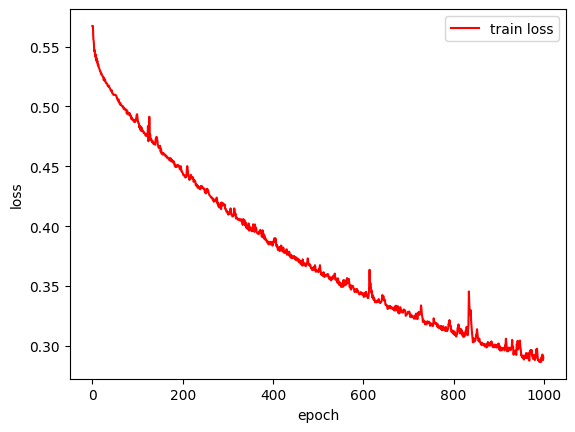

In [17]:

plt.plot(train_loss_list, label='train loss',color='red')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

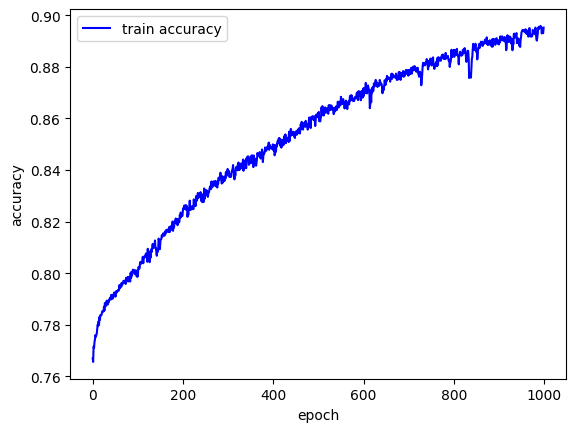

In [18]:
plt.plot(train_acc_list, label='train accuracy',color='blue')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion matrix

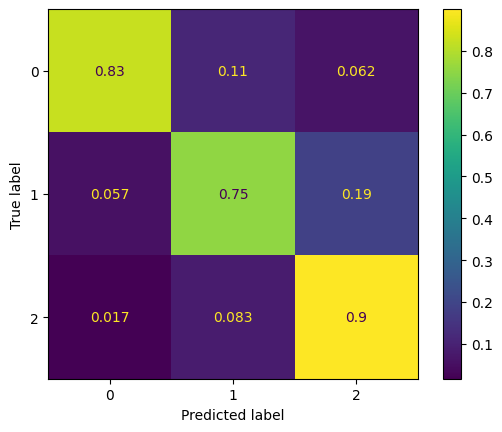

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, listarray)

cm = confusion_matrix(y_test, listarray, labels=[0,1,2],normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
disp.plot()
plt.show()

In [20]:
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
f1 = f1_score(y_test,listarray,pos_label='positive', average='micro')
accuracy_score=accuracy_score(y_test, listarray) * 100
print(f1)
print("정확도: {}".format(accuracy_score))

0.8268919647672119
정확도: 82.6891964767212


C:\Users\jaemin\Anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [21]:

print('SMOTE 적용 후 테스트용 피처/레이블 데이터 세트: ', X_test.shape, y_test.shape)
# print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_test).value_counts())

SMOTE 적용 후 테스트용 피처/레이블 데이터 세트:  torch.Size([16689, 6]) torch.Size([16689])
SMOTE 적용 후 레이블 값 분포: 
 0    5563
1    5563
2    5563
dtype: int64


In [22]:
from collections import Counter
result = Counter(listarray)

In [23]:
result

Counter({0: 5005, 2: 6402, 1: 5282})

### AUC

In [24]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [25]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# make sample data
n_classes = 3


print("roc_auc_score: ", multiclass_roc_auc_score(y_test, listarray))

roc_auc_score:  0.8701689735754089
